In [ ]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

# Create Neural Net

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [87]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils
from collections import deque

env = make("connectx", debug=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

class ValueNetwork(nn.Module):
    def __init__(self, convFilters, filterSize, boardRows, boardCols):
        """
        Convolutional Layer with ReLU and fully-connected output of the afterstate value.
        Args:
            convFilters: number of conv filter
            filterSize: Conv filter size (kernel size)
            boardRows: Number of rows for board
            boardCols: Number of cols for board
        """
        super().__init__()
        self.boardRows = boardRows
        self.boardCols = boardCols
        self.conv_feature_size = (boardRows-filterSize+1) * (boardCols-filterSize+1) * convFilters
        
        self.conv_layer1 = nn.Conv2d(1, convFilters, filterSize)
        self.conv_bn1 = nn.BatchNorm2d(convFilters)
        self.fc1 = nn.Linear(self.conv_feature_size, 256)
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, board):
        """
        Args:
            board: serialized board from env observation (-1, 0, 1)
            Current player pieces is 1, opponent player pieces: -1
        Returns:
            The after state value
        """
        board = torch.Tensor(board).to(DEVICE)
        # Reshape
        board = board.view(-1, 1, self.boardCols, self.boardRows)
        s = F.relu(self.conv_bn1(self.conv_layer1(board)))
        
        s = s.view(-1, self.conv_feature_size)
        s = torch.relu(self.fc_bn1(self.fc1(s)))
        s = torch.relu(self.fc_bn2(self.fc2(s)))
        
        output = torch.tanh(self.fc3(s))
        return output


cpu


# Helper functions

In [88]:
def get_valid_actions(env, board):
    return [c for c in range(env.configuration.columns) if board[c] == 0]

def simulate_play(board, column, config):
    EMPTY = 0
    columns = config.columns
    rows = config.rows
    row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
    nextBoard = board.copy()
    # Mark board as player 1
    nextBoard[column + (row * columns)] = 1
    return nextBoard

def policy(env, model, board, returnValue=False):
    """
    Afterstate greedy policy using value network (model)
    
    Returns:
        Best Action OR Best Value.
        
        The best action according to the model by default.
        
        If return value is true, the policy will return the best value.
    """
    bestAction = None
    available_actions = get_valid_actions(env, board)
    afterStates = []
    for action in available_actions:
        afterState = simulate_play(board, action, env.configuration)
        afterStates.append(afterState)
     
    # Return action with best afterstate value
    model.eval()
    with torch.no_grad():
        afterStateValues = model(afterStates)
        bestIndex, bestValue = max(enumerate(afterStateValues), key=(lambda x: x[1]))
        bestAction = available_actions[bestIndex]
    
    if returnValue:
        return bestValue
    
    return bestAction

def training_policy(env, model, board, epsilon):
    """
    Afterstate epsilon greedy policy using value network (model)
    """
    # Explore
    if random.uniform(0, 1) < epsilon:
        available_actions = get_valid_actions(env, board)
        action = random.choice(available_actions)
    # Greedy
    else:
        action = policy(env, model, board)

    return action

def convert_board(board, mark):
    # Converts board into (-1, 0, 1) where current player is 1 and opponent -1
    board = np.array(board)
    for i in range(len(board)):
        if board[i] == 0:
            continue
        elif board[i] == mark:
            board[i] = 1
        else:
            board[i] = -1
    
    return board

def opponent_perspective_board(board):
    return board.copy() * -1

def mean_reward(rewards, agentIndex=0):
    return sum(r[agentIndex] for r in rewards) / float(len(rewards))

def evaluate_agent(agent, opponent_agent_string, episodes):
    
    goingFirst = mean_reward(evaluate("connectx", [agent, opponent_agent_string], num_episodes=episodes//2), 0)
    goingSecond = mean_reward(evaluate("connectx", [opponent_agent_string, agent], num_episodes=episodes//2), 1)
    return (goingFirst + goingSecond) / 2

# Create Agent

In [89]:
# This agent random chooses a non-empty column.
def my_agent(observation, configuration):
    # Number of Columns on the Board: 7
    columns = configuration.columns
    # Number of Rows on the Board: 6
    rows = configuration.rows
    # Number of Checkers "in a row" needed to win: 4
    inarow = configuration.inarow
    # The current serialized Board (rows x columns).
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    
    board = convert_board(board, observation.mark)

    return policy(env, model, board)

# Set up train & experience replay

In [105]:
# Improvements needed
# 1) Normalize loss and value output (DONE)
# 2) Separate model for Pred and Target (DONE)
# 3) Memory replay for more stability (DONE)
# 4) Possibly some rollout methods to look ahead -> (NEED TO ADD MCTS)
# 5) Decay in lr or epsilon (DONE)
# 6) Make nn layers more complex (DONE)
def train(model, target_model, optimizer, loss_func, episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay):
    losses = []
    episode_losses = []
    epsilons = []
    win_rates = []
    experience_replay = deque(maxlen=max_exp_size)
    epsilon = epsilon_init
    steps = 0
    for episode in tqdm(range(episodes)):
        # for each episode
        epsilons.append(epsilon)
        env.reset()
        while not env.done:
            steps += 1
            # This is to enable self play
            active = -1
            if env.state[0].status == "ACTIVE":
                active=0
            if env.state[1].status == "ACTIVE":
                active=1
            
            observation = env.state[active].observation
            configuration = env.configuration
            curBoard = convert_board(observation.board, observation.mark)
            
            # Choose epsilon greedy action
            my_action = training_policy(env, model, curBoard, epsilon)
            # Step depending on who's turn is it for self play
            env.step([my_action if i==active else None for i in [0,1]])
            
            after_state_observation = env.state[active].observation
            # After state board
            after_state_board = convert_board(after_state_observation.board, observation.mark)
            
            # Reward
            reward = 0 
            if env.done:
                reward = 1
                            
            # Add to experience replay queue
            experience_replay.append([after_state_board, reward, env.done])
            
            # Update model network every BATCH from experience replay
            if steps % BATCH == 0:
                update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses)
            
            # Update target network every C_BATCH
            if steps % C_BATCH == 0:
                target_model.load_state_dict(model.state_dict())
        if (episode) % 500 == 0:
            # Run multiple episodes to estimate its performance.
            rewardFirst = mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10))
            rewardSecond = mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10), 1)
            print(f"Trained {episode} episodes, {steps} steps. Going first: {rewardFirst}, going second: {rewardSecond}")
            win_rates.append((rewardFirst + rewardSecond)/ 2)
        episode_losses.append(np.mean(losses[-len(env.steps):]))
        epsilon = max(epsilon * epsilon_decay, epsilon_final)
    # Save weights
    torch.save({
        'model_state_dict': model.state_dict()
    }, MODEL_WEIGHTS_SAVE_PATH)
    print(f"\nTrained total {steps} steps")
    print(f"Last 100 steps loss average: {np.mean(losses[-100:])}")
    plt.plot(episode_losses, label="Episode MSE losses")
    plt.show()
    plt.plot(losses[100:], label="STEP MSE_Loss")
    plt.show()
    plt.plot(epsilons, label="Epsilons")
    plt.show()
    plt.plot(win_rates, label="Win rate against random agent")

def update_model_from_experience_replay(experience_replay, model, target_model, loss_func, losses):
    # Only start training after we have some experiences
    if len(experience_replay) < min_exp_size:
        return
    
    # Set model train, eval
    model.train()
    target_model.eval()
    
    mini_batch = zip(*random.sample(experience_replay, BATCH))
    after_state_boards, rewards, dones = mini_batch
    
    # Use main model to get preds
    preds = model(after_state_boards)
    # Use target model to get targets
    # Simulate next state from opponent's perspective
    with torch.no_grad():
        targets = torch.zeros((BATCH, 1))
        for i in range(len(after_state_boards)):
            after_state_board = after_state_boards[i]
            reward = rewards[i]
            done = dones[i]

            if not done:
                opp_board = opponent_perspective_board(after_state_board)
                nextMaxValue = policy(env, target_model, opp_board, returnValue=True)
                # Negative value since, it would be the value of the opponent (zero sum game)
                targets[i] = (nextMaxValue * gamma) *-1
            else:
                targets[i] = torch.as_tensor(reward).to(DEVICE)
    # Minibatch update
    loss = loss_func(preds, targets)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() 

# Set up model and optimizer
MODEL_WEIGHTS_SAVE_PATH = './model_weights.pt'
numConvFilters = 30
filterSize = 4
# Create model and target model
# Input: after board state, player mark
# Output: Value of the after boardstate
# Model: main model updated every BATCH
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH)['model_state_dict'])
# Target model: updated every C_BATCH
target_model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
target_model.load_state_dict(model.state_dict())

# Cast model to cuda
model = model.to(DEVICE)
target_model = model.to(DEVICE)

lr = 0.01
optimizer = Adam(model.parameters(), lr=lr)
epsilon_init = 1.0
epsilon_final = 0.1
epsilon_decay = 0.9999
episodes = 20000
gamma = 0.99
# Steps to update model
BATCH = 128
# Steps to update target model
C_BATCH = BATCH * 100
# Experience replay min size to train
min_exp_size = BATCH * 10
max_exp_size = BATCH * 100

In [166]:
state1 = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,-1,0],
         [0,0,0,0,1,-1,0],
         [0,0,0,1,-1,-1,0],
         [0,0,1,-1,-1,-1,0],]
state2 = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,-1,1,0,-1,0,1],]
state1 = np.array(state1).reshape(-1)
state2 = np.array(state2).reshape(-1)
model.eval()
after_state_value = model(np.array([state1, state2]))
print(after_state_value)

tensor([[-1.0000],
        [ 1.0000]], grad_fn=<TanhBackward0>)


  0%|                                       | 3/20000 [00:02<3:38:41,  1.52it/s]

Trained 0 episodes, 31 steps. Going first: 0.1, going second: 0.2


  3%|▉                                    | 502/20000 [00:42<1:41:18,  3.21it/s]

Trained 500 episodes, 10553 steps. Going first: 0.9, going second: 0.9


  5%|█▊                                  | 1001/20000 [01:28<2:12:37,  2.39it/s]

Trained 1000 episodes, 20988 steps. Going first: 0.8, going second: 0.6


  8%|██▋                                 | 1502/20000 [02:11<1:44:13,  2.96it/s]

Trained 1500 episodes, 30996 steps. Going first: 0.9, going second: 0.8


 10%|███▌                                | 2003/20000 [02:54<1:29:44,  3.34it/s]

Trained 2000 episodes, 40730 steps. Going first: 0.9, going second: 0.7


 13%|████▌                               | 2502/20000 [03:35<1:26:15,  3.38it/s]

Trained 2500 episodes, 49766 steps. Going first: 1.0, going second: 1.0


 15%|█████▍                              | 3002/20000 [04:16<1:31:57,  3.08it/s]

Trained 3000 episodes, 58840 steps. Going first: 1.0, going second: 0.8


 18%|██████▎                             | 3502/20000 [04:55<1:23:11,  3.31it/s]

Trained 3500 episodes, 67329 steps. Going first: 1.0, going second: 1.0


 20%|███████▏                            | 4002/20000 [05:34<1:22:25,  3.23it/s]

Trained 4000 episodes, 75381 steps. Going first: 1.0, going second: 1.0


 23%|████████                            | 4502/20000 [06:13<1:14:34,  3.46it/s]

Trained 4500 episodes, 83770 steps. Going first: 1.0, going second: 1.0


 25%|█████████                           | 5002/20000 [06:52<1:05:04,  3.84it/s]

Trained 5000 episodes, 91621 steps. Going first: 0.9, going second: 0.8


 28%|█████████▉                          | 5501/20000 [07:30<1:06:44,  3.62it/s]

Trained 5500 episodes, 100262 steps. Going first: 1.0, going second: 1.0


 30%|██████████▊                         | 6002/20000 [08:08<1:01:51,  3.77it/s]

Trained 6000 episodes, 108638 steps. Going first: 1.0, going second: 1.0


 33%|████████████▎                         | 6503/20000 [08:49<56:53,  3.95it/s]

Trained 6500 episodes, 117131 steps. Going first: 1.0, going second: 1.0


 35%|█████████████▎                        | 7003/20000 [09:30<52:53,  4.09it/s]

Trained 7000 episodes, 125622 steps. Going first: 1.0, going second: 1.0


 38%|█████████████▌                      | 7502/20000 [10:06<1:00:18,  3.45it/s]

Trained 7500 episodes, 133485 steps. Going first: 1.0, going second: 1.0


 40%|███████████████▏                      | 8003/20000 [10:42<43:28,  4.60it/s]

Trained 8000 episodes, 141779 steps. Going first: 1.0, going second: 1.0


 43%|████████████████▏                     | 8502/20000 [11:18<48:31,  3.95it/s]

Trained 8500 episodes, 149880 steps. Going first: 1.0, going second: 1.0


 45%|█████████████████                     | 9002/20000 [11:56<54:12,  3.38it/s]

Trained 9000 episodes, 158245 steps. Going first: 1.0, going second: 1.0


 48%|██████████████████                    | 9502/20000 [12:36<50:32,  3.46it/s]

Trained 9500 episodes, 166345 steps. Going first: 1.0, going second: 0.9


 50%|██████████████████▌                  | 10001/20000 [13:19<49:03,  3.40it/s]

Trained 10000 episodes, 175097 steps. Going first: 1.0, going second: 1.0


 53%|███████████████████▍                 | 10501/20000 [14:03<47:43,  3.32it/s]

Trained 10500 episodes, 183613 steps. Going first: 1.0, going second: 1.0


 55%|████████████████████▎                | 11001/20000 [14:45<48:11,  3.11it/s]

Trained 11000 episodes, 192363 steps. Going first: 1.0, going second: 1.0


 58%|█████████████████████▎               | 11502/20000 [15:27<44:56,  3.15it/s]

Trained 11500 episodes, 200715 steps. Going first: 1.0, going second: 1.0


 60%|██████████████████████▏              | 12001/20000 [16:10<36:05,  3.69it/s]

Trained 12000 episodes, 209535 steps. Going first: 1.0, going second: 0.9


 63%|███████████████████████▏             | 12502/20000 [16:53<39:12,  3.19it/s]

Trained 12500 episodes, 218109 steps. Going first: 1.0, going second: 1.0


 65%|████████████████████████             | 13002/20000 [17:36<32:27,  3.59it/s]

Trained 13000 episodes, 226696 steps. Going first: 1.0, going second: 1.0


 68%|████████████████████████▉            | 13502/20000 [18:20<40:02,  2.70it/s]

Trained 13500 episodes, 235534 steps. Going first: 1.0, going second: 1.0


 70%|█████████████████████████▉           | 14002/20000 [19:03<41:47,  2.39it/s]

Trained 14000 episodes, 244105 steps. Going first: 1.0, going second: 1.0


 73%|██████████████████████████▊          | 14501/20000 [19:47<30:45,  2.98it/s]

Trained 14500 episodes, 253042 steps. Going first: 1.0, going second: 1.0


 75%|███████████████████████████▊         | 15000/20000 [20:30<08:13, 10.14it/s]

Trained 15000 episodes, 261880 steps. Going first: 1.0, going second: 1.0


 78%|████████████████████████████▋        | 15502/20000 [21:15<25:33,  2.93it/s]

Trained 15500 episodes, 270500 steps. Going first: 1.0, going second: 1.0


 80%|█████████████████████████████▌       | 16003/20000 [21:58<16:29,  4.04it/s]

Trained 16000 episodes, 279515 steps. Going first: 1.0, going second: 0.9


 83%|██████████████████████████████▌      | 16501/20000 [22:39<13:52,  4.21it/s]

Trained 16500 episodes, 288236 steps. Going first: 1.0, going second: 1.0


 85%|███████████████████████████████▍     | 17003/20000 [23:21<11:03,  4.51it/s]

Trained 17000 episodes, 296741 steps. Going first: 1.0, going second: 0.9


 88%|████████████████████████████████▍    | 17502/20000 [24:02<11:10,  3.73it/s]

Trained 17500 episodes, 305430 steps. Going first: 1.0, going second: 1.0


 90%|█████████████████████████████████▎   | 18001/20000 [24:48<09:47,  3.40it/s]

Trained 18000 episodes, 314731 steps. Going first: 1.0, going second: 1.0


 93%|██████████████████████████████████▏  | 18502/20000 [25:33<06:35,  3.79it/s]

Trained 18500 episodes, 323436 steps. Going first: 1.0, going second: 1.0


 95%|███████████████████████████████████▏ | 19002/20000 [26:19<05:39,  2.94it/s]

Trained 19000 episodes, 332842 steps. Going first: 1.0, going second: 0.9


 98%|████████████████████████████████████ | 19501/20000 [27:05<02:25,  3.42it/s]

Trained 19500 episodes, 342093 steps. Going first: 1.0, going second: 1.0


100%|█████████████████████████████████████| 20000/20000 [27:51<00:00, 11.96it/s]



Trained total 351939 steps
Last 100 steps loss average: 0.04726147888228297


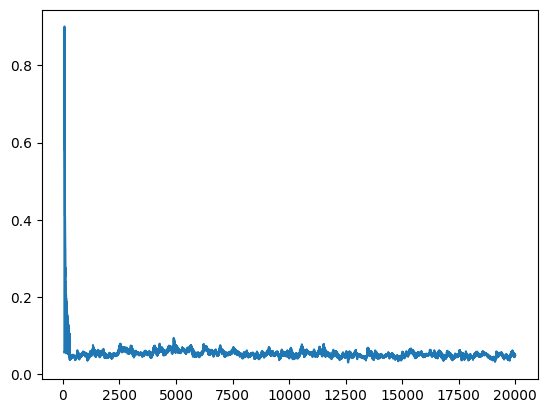

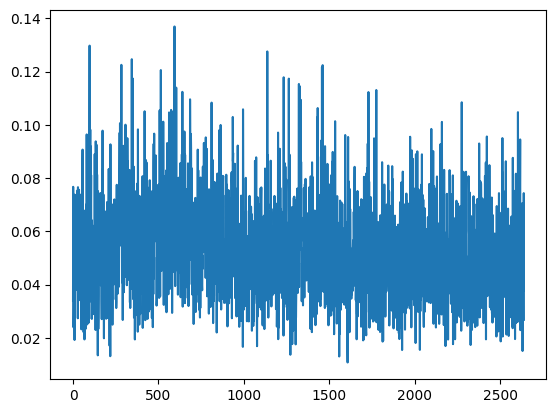

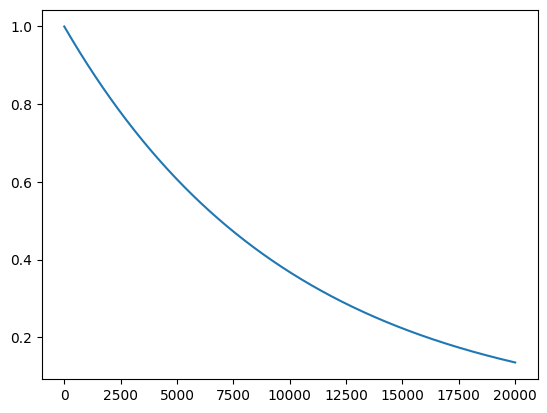

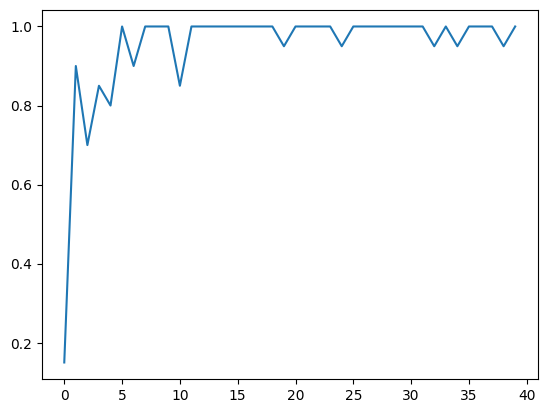

In [106]:
# Start Training
train(model, target_model, optimizer, nn.MSELoss(), episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay)

In [ ]:
# Load Model
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
#model.load_state_dict(torch.load(MODEL_WEIGHTS_SAVE_PATH, map_location=torch.device('cpu'))['model_state_dict'])

# Test Agent

In [108]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, "random"])
env.render(mode="ipython", width=500, height=450)

# Evaluate your Agent

In [110]:
print(evaluate_agent(my_agent, "random", 100))
print(evaluate_agent(my_agent, "negamax", 100))

1.0
0.0


# Play your Agent
Click on any column to place a checker there ("manually select action").

In [158]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([my_agent, None], width=500, height=450)

# Serialize model weights and create agent for submission

In [140]:
import pickle
import zlib
import base64 as b64
import numpy as np

def serializeAndCompress(value, verbose=True):
    serializedValue = pickle.dumps(value)
    if verbose:
        print('Lenght of serialized object:', len(serializedValue))
    c_data =  zlib.compress(serializedValue, 9)
    if verbose:
        print('Lenght of compressed and serialized object:', len(c_data))
    return b64.b64encode(c_data)

def decompressAndDeserialize(compresseData):
    d_data_byte = b64.b64decode(compresseData)
    data_byte = zlib.decompress(d_data_byte)
    value = pickle.loads(data_byte)
    return value

print(serializeAndCompress(model.state_dict()))

Lenght of serialized object: 517816
Lenght of compressed and serialized object: 463960
b'eNrct3dUVNG25gsICCgKIoKKWRQQFEFJlUBFUURADAQFyUGCJBNRoiTJOSlIlJwEan27kCAIgmJEUTCiYMSsKHbdPvedcfq9Pm/c/3r03TWqatTec689a31rzfn7gvlTh+fx/M8jdpath6urva2Ps4e7d0rsLEMvO3sve7ttzrY+Kckp8ntT5GLn2Xq4H7dytT5l77Vx/Ql7Z0cnn5TY2T4eXrZO6618fZxduffNs/Kyt/F1drWz8rF39/bwsjquwr1dLlb0H2He3C9rR/uUWDErVw9rOysHLw83K5tTPvbe3KgtgUI8PMF80SKuv3O2/1zuUmq0cH0wn8H4DO5ngCePnKkYN89jXh4+HtxUrY7be3lzc/Xk5QaYinKvuDr7+LjaW9m72zlbu3vynTUV4Z70OXXM3srb+bS9t+eMAE9+OVMB7klvJw8vH08BfT7TGdxfzu4+noL6/Kb8/zGGh7uj50x9fl9f7jPlTGf+R/A/Uvbksf2ff0FkOzdxH5N/nBTx5DWdy43ZuElZbaOyiqqmpvImDWVlz38MbHvM13OGwRPePT6e/Mbc8Q578vxvo3mt1z/h/YcKGXEujJFEDeqbahGjfi0v52yXMlOJfgop3ic4pZM3GFZxr8n8KSlOLFjUbUMN6vWeI5zrhXNZid+XsC5fTWL61Q4yjHs2MW7atFN+T7SYRbRSkpQQjv4d2XD63MbI8xOllodUMrv7XlHvit8yGuQT8e5rDsOv5TxTJvsKte+FKjNGhiKje8Qo1+fZTP6e2YwXP9Yx3/MHgG/0BiMs3J96pfsQyo/UmFVqCsz6wAy6ZVU9tSK1mZofVENpmKhSL9RpTI5bIZUUT8HPa5gaHi+jjE4YUV/KS6mBXBnyTfor9b0mnpLg1MF9iw/z7BRhVrJ8OF8

In [153]:
# This agent random chooses a non-empty column.
def submission_agent(observation, configuration):
    import numpy as np
    import torch
    from torch import nn
    import pickle
    import zlib
    import base64 as b64
    import torch.nn.functional as F
    import random
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    class ValueNetwork(nn.Module):
        def __init__(self, convFilters, filterSize, boardRows, boardCols):
            """
            Convolutional Layer with ReLU and fully-connected output of the afterstate value.
            Args:
                convFilters: number of conv filter
                filterSize: Conv filter size (kernel size)
                boardRows: Number of rows for board
                boardCols: Number of cols for board
            """
            super().__init__()
            self.boardRows = boardRows
            self.boardCols = boardCols
            self.conv_feature_size = (boardRows-filterSize+1) * (boardCols-filterSize+1) * convFilters

            self.conv_layer1 = nn.Conv2d(1, convFilters, filterSize)
            self.conv_bn1 = nn.BatchNorm2d(convFilters)
            self.fc1 = nn.Linear(self.conv_feature_size, 256)
            self.fc_bn1 = nn.BatchNorm1d(256)
            self.fc2 = nn.Linear(256, 128)
            self.fc_bn2 = nn.BatchNorm1d(128)
            self.fc3 = nn.Linear(128, 1)

        def forward(self, board):
            """
            Args:
                board: serialized board from env observation (-1, 0, 1)
                Current player pieces is 1, opponent player pieces: -1
            Returns:
                The after state value
            """
            board = torch.Tensor(board).to(DEVICE)
            # Reshape
            board = board.view(-1, 1, self.boardCols, self.boardRows)
            s = F.relu(self.conv_bn1(self.conv_layer1(board)))

            s = s.view(-1, self.conv_feature_size)
            s = torch.relu(self.fc_bn1(self.fc1(s)))
            s = torch.relu(self.fc_bn2(self.fc2(s)))

            output = torch.tanh(self.fc3(s))
            return output
        
    def decompressAndDeserialize(compresseData):
        d_data_byte = b64.b64decode(compresseData)
        data_byte = zlib.decompress(d_data_byte)
        value = pickle.loads(data_byte)
        return value
    
    def get_valid_actions(board):
        return [c for c in range(7) if board[c] == 0]
    
    def convert_board(board, mark):
        # Converts board into (-1, 0, 1) where current player is 1 and opponent -1
        board = np.array(board)
        for i in range(len(board)):
            if board[i] == 0:
                continue
            elif board[i] == mark:
                board[i] = 1
            else:
                board[i] = -1

        return board

    def simulate_play(board, column):
        EMPTY = 0
        columns = 7
        rows = 6
        row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
        nextBoard = board.copy()
        # Mark board as player 1
        nextBoard[column + (row * columns)] = 1
        return nextBoard

    def policy(model, board, returnValue=False):
        """
        Afterstate greedy policy using value network (model)

        Returns:
            Best Action OR Best Value.

            The best action according to the model by default.

            If return value is true, the policy will return the best value.
        """
        bestAction = None
        available_actions = get_valid_actions(board)
        afterStates = []
        for action in available_actions:
            afterState = simulate_play(board, action)
            afterStates.append(afterState)

        # Return action with best afterstate value
        model.eval()
        with torch.no_grad():
            afterStateValues = model(afterStates)
            bestIndex, bestValue = max(enumerate(afterStateValues), key=(lambda x: x[1]))
            bestAction = available_actions[bestIndex]

        if returnValue:
            return bestValue
    
        return bestAction
    numConvFilters = 30
    filterSize = 4
    agent_model = ValueNetwork(numConvFilters, filterSize, 7, 6)
    weights_b64 = b'eNrct3dUVNG25gsICCgKIoKKWRQQFEFJlUBFUURADAQFyUGCJBNRoiTJOSlIlJwEan27kCAIgmJEUTCiYMSsKHbdPvedcfq9Pm/c/3r03TWqatTec689a31rzfn7gvlTh+fx/M8jdpath6urva2Ps4e7d0rsLEMvO3sve7ttzrY+Kckp8ntT5GLn2Xq4H7dytT5l77Vx/Ql7Z0cnn5TY2T4eXrZO6618fZxduffNs/Kyt/F1drWz8rF39/bwsjquwr1dLlb0H2He3C9rR/uUWDErVw9rOysHLw83K5tTPvbe3KgtgUI8PMF80SKuv3O2/1zuUmq0cH0wn8H4DO5ngCePnKkYN89jXh4+HtxUrY7be3lzc/Xk5QaYinKvuDr7+LjaW9m72zlbu3vynTUV4Z70OXXM3srb+bS9t+eMAE9+OVMB7klvJw8vH08BfT7TGdxfzu4+noL6/Kb8/zGGh7uj50x9fl9f7jPlTGf+R/A/Uvbksf2ff0FkOzdxH5N/nBTx5DWdy43ZuElZbaOyiqqmpvImDWVlz38MbHvM13OGwRPePT6e/Mbc8Q578vxvo3mt1z/h/YcKGXEujJFEDeqbahGjfi0v52yXMlOJfgop3ic4pZM3GFZxr8n8KSlOLFjUbUMN6vWeI5zrhXNZid+XsC5fTWL61Q4yjHs2MW7atFN+T7SYRbRSkpQQjv4d2XD63MbI8xOllodUMrv7XlHvit8yGuQT8e5rDsOv5TxTJvsKte+FKjNGhiKje8Qo1+fZTP6e2YwXP9Yx3/MHgG/0BiMs3J96pfsQyo/UmFVqCsz6wAy6ZVU9tSK1mZofVENpmKhSL9RpTI5bIZUUT8HPa5gaHi+jjE4YUV/KS6mBXBnyTfor9b0mnpLg1MF9iw/z7BRhVrJ8OF8bRpgn5M+j+eFDeF74AWqoEoavk8jlIUdsOrOHzXcrkNHx3hN7jZ/QF4Y20gUCPKik5iOcHRmHOV9ydDkMcxZHp3wBpS9hyihVc6Webh2l3i6sBY/WM3rvvELqVfU16r3jc8iYpFAr22ewfFfsZArVhSLMRIbFnFrJUGDEM6o2FmGVdDAlGJ7KuHRbjXFe04XJHzaL+uYSxxxWnWLaLwulZEXqcKXuPrM30J0RxPOavOgJYwWUiHJstJ2o91esmDc/bGXGWIayFBQH0UNfQTFturSWRYuxnleJMXhnvyb5UibE9oAwi7rnxXiySpbkuLxCpcQilju5qXnDfBdzwU4BZld6FNkQHcOQeFjGTD49wRw++575dCWLZVHrydwcOsXUfZjK7C2eyRJedIM+u/EBUziKw1zeeIh5aO4e4rbgA30g9Byi+C+QK0VMqtRKjRl4XYyp1imJGNU0urLZGczKMIT6OkU2rb6c1ay1l2NmFEZlhc2kRJJ/UmGvvKi0SQmoXtFmmgo/ow7UrqBGtc8iWiGfSt5VyIzSLiLzpnk553aJUgeflTPfS1twRlaOM89519GvSFpyDo68IelJFCE93TDq9ucUG5oytu+QZOatY0Ao2JOzv6WM7nsviuSldRHV0FOcbwNPSVNtIv3ZVB5JGP8OPVlr/BiOof8Gwd6DBswQ5gRZaaLNmEqawtj8MObGpSW4EyaDi62LcJKtxfp7xoh19M8qVsUlA5Zt4h46RVMkO/X8WTu0fOg3hJiMqw2E8ea3GiuIIcUg2oGYehOCkzeUWO9KrqBFt5BxN/E9u0x2Net01FfGfv2/TCPeBMzYqcBoMVRi3noXh9l7rzG1+c2hLxPN9u/lpeQ2Pqc/pDkztTxnUQaRFtTZsaSW6QvvKF/ti6zMp98YhukanLMHk/CyaClVU3JMa/KXA0fqdxpl3XOJYXfLmSayz5JDOm8xfhcKMZ+ojzNiq7dz2s80M75svcP42ZfH/hngzao9dI4eczeZWHvMwSkjDdavP8WMba5u7KH78khbv4U156sI4yVTkaEkKoIYd1lWa9I5RlRLH5GVz6EHfyvAvoPjrW5y6lCwTGQ9jz5LXmlXoDzyJ30iNp/h4G7Kur+6HOW+tWS4WxQatiV0uW+OrAd9t9A0/pEdqLOKKiq5wOSv9ad+znzAPD1Hm+Uwt4h5SzeDuVcgHL5HZrO2t9EZcl0vycSmWdSaG4HMpggdpkxjJmW1WIMhn+vL8NkmwFBYeJR9JC8G/fevkxXLq3DOTZjx+nYpovQ1oH/+PknRu88O2nyQw+wx4Bw5bMBR2+jAOVURihcLL9I9O+UY2+UEOOPSccwWX2OKOm/B9LgdwMm594m2pNCTqvzQTT/hrs95/VaarZwuzzDO/ojGYhnOlVw6RRVbUyuWx1AbBMWpRF0aZUbfRO1/t5FBHs2iTGdyKIdpV2qVRQFjX4wdU9r0NnWr6BImzecxvlLNTLcxd4azaTtD0KiesddIm3k3/wx1zb+D+bKbyfjx+BslMvyVeVlLgGo/OkapLqpEmdMc6n6TOWfbHGWW3aJOTEirMLOOnsW2fooR632YczQsmvCsHmTkGDaSC/c9OK99T6GdHsnQfbGO8bD3COetyhE4b+enRqPjCJvS59CdhMnT0+Ewya6gsy2N6d6vtrM/mbQQ0zNVsL42Tb9S7sz+9jOCrhZXwyi0X0B698uzLvdsYt2Yv421yEaXxWOdS518GIE6yopqLEujniWFUAPlldQqBQFOhtNLKtcjjUpd/I3iNy6mpKIeUK+S4hg3TXQ4972SKO2OtRRDZwaz8uMZqnrnAHUov5nqTJHndM9IhN3PV9DWHac+3JEkDjFLOJKic5jJCbeYG0LXwmoFP0t5agdHKnsu4RU2ZOrzuDJxxJI+XjCL2cf7iW09K5RJZyYyv8ccZSRISKGvw4v50IaNamtlZv03RZZS9GbW2pvLWaYhwqy5h2Yw/dasRmzDFob6rGCWV9kxbBfcjBCDE6xqXl5QF+3gvfoYa3ZKKslamsZuGzvGuqE4QZR20dH9NZ6sCvOhVj05Q21LOMOcvSWcybf9AzEzXEvNU+thrD6ajZnJzlqWUeKUWK4KJVelQ79/f4ghOpcHLUJy7Ph71kgJT9mbos8jp79Un1efX5/fJ0VOX4z74tfn9UmJcuLjcpAPNyJW7F9RyMbZ2jvFaaack8gWX97/uwlmE5dINDU1Nv0rwegv/TcA889gLsAs/Qe/8DxYd5izZVE15SQ0SW37OJO7AW5TavyjlF13A7W6MJLT3ppNvDMyqculGylORyFn4IEhZwe7hLOQ9o1SDjPhYGcB59iiEM69+W+pr5d2cb5k7ee0Jr6BW0YM1XbKk+OifpMTvTCXPTERSh07Zk/9WDLNEWl8Qf2ncPpLw1P0ecP/Vaq5/1MqG/d/Iut/D6U2KytrqKiqafyXlPpn8L8oJd18lfnhgg5zQZAc83fsLNZ43VpWPLOcea9ukrnZMJKln53PLK0ZYTpyCFOXP4bVt3kTqzOkgFW8b5Q5o1qNFSpdwlomvpsl4cDd/gMuLH+5QebxkXIGJ/MS09ndgXXl9QztKJ1bzHXFbcwzI6+YKsI9rOTCRua/V0r0n0r9N9pRm5XV1VVUlP+rOv1n8L/olHfwPqVw6zEl09dJPWucxfErE+XQwlZw4v8Icl4Xe3FeH1xOFEzfUba0cmrRt3BO5/YZHIm/Jzl3fxdSny4acWbpRXByVu/myMR9ogyHj3F4d8/gzBHQolyOtVNVSa6cOavOc7bZqlJPpAepBW6dVCxPN8egefD/Z0dJ/lMnL193d2d3Rys3e2v3/zZ6qaj8lyvgP4P/Ra//U8e/12v+/0ev49Ze/33k2qSurqb8X5XrH8H/i1zBrP8T738vl8w/5XL3dbOysfaxdbL3tvLxsrY9am/3n7Lx/98g225uyL9TTVNzo6bK/6oa779V7T+Duarx/u8Xvbz8v8yfiIPt/6vX81wQ+L97kW/crK6usel/ma5dPE68PP9uxv6feO6M/UfYfxxrCtJwYq4yRo4dR+MRc9KXJQ35d5nkY/dlMue3G+7ur4dm0kp8WyaAzlZ17Lx1lubmlI6k3DZ07NyKS9MpkP8ZSVZN/Ca3ReXxZySRNgwO4ShEkN18a/GhwxYap39qnRTzZQ8d7CAHdudrXvoQQfMffYfThco0LdUvbLJTBwOXmxEtYgvNw2/gui0HWQOH2PmDQrS1E4U48u4le8RlN/bJnSdaETHofKqMgG9snBiPhfyiJ8S49Cmx+yGGNtNWstJ3FaROyKHS7z25410IuyJdZF+uw5aLP0nuhcMYOX8V90oHCadtFvn9vQ3if3sQ0HEHe2MziElPMP5aqGGrfwXuy4STuDW3SUyxA/Zdn418l1So1S9G8YpLRDWolJzs8SHmMlFETTkHa/TqaRWi9vCzWo35aom0X63WSPhBISVdHe93D8LSVBXapzmkzF4Z1gLCGNu7Ce92jyF0iiI9pVLoTmmHbEclVhA3WNGysUbkE9nyqQ4Xbwtq+d0Tg5pYGaa2JcNy32fCZx+Ju8OVWDirB9NR4Wg83IrSRxxoOKQgxuczeaCrD9kZMjQx/SQUmlxElthk6+IVXWjAONHWqtXKClGCzFkj5NOq0T6aQO70cbQmp8tQ9nYT2rQOYODQGDE/XYWdzlcxJPGTGJ+5QXY3LoHkFhMivns/2p69JWYGWeT31u2I/T6EP2/lYC44gROihKaw+gyJbL6MDZkL0KK0CUs9buANk9DSGmYQYe1GqEw2EZmdNng0uII4UoKgXfpBFE/8JIxve0njIQ4+N6RCl7ecWFkI4cnyJbAqq9RUrfxGbso3YniyszVWxhNzrPfhs2UIEByHe1Vh5MfHbLjpvyHFOwNhJicGv9ZE9MtcJwXPdqBi63LuOjmBHavnYnOzDRYLvsKBL2ys/6ABg0PNSOtIQNfPMzjQdgk7TSlcGM+Hp2A+PoWlYPLdWzL5PRLmD4ohYNWIsH2p5KyPAlg1ZZh3VBMTFmGonLxAFLcmIskkTfPdyWVYzj8fCktukbV70nG4Sx0SKzshP5ACltstaNspQKrhCXlxRxUrxzshFKSDNNW7pOWGOwYavMjRs3RMPjgI1y4zaP8+SRNdXoY0+SLonRCGkZsz6Tv3DB6CnjgqdYn0WHe3qgcnQ9AvE65lSuCxEUbLkS7Yz16NFh0OJpb0k63abLDuBsL1RBJxt/lOc1tph47FTNpFmSqUnteH7XQhd62/ZsfcqUOTtT8utUgTt6EYov81EBP+tmTOSAB7aCoN+Yd24nVnMGIcptiPTPkwWe5Oi6xJxtxPr2nBR6/gWt8sMiGRC/eAOGTFqaMrRgLR9iV4uOokEco/DL6fxlB7K0j2/lXAYeuDULavwWPtOky5GJAugUOI2leMnb1t4G/biUOWZ8i3Bx/JIUkhGK7OQGgBLzFsjGabH/TFHe+jxKxvDA99ihD0q4H94K0/FEviUeQaQ2O1pGBw5D2G9ZPJ8uhI/PoWDKXWPJSEOcF2RjyZK+4Nr68jhBqqA456YEg2Hfe2NIDHZBX5YAaizkzB+MtMlEg04vANHuy1n4GZz0fws+orbX1SH6RMxcnd9u3Yx6MPg9dKUDR+Qk5un4G8RfXYYpmA5TM+IcbZmoS2RaH6VjRW3UsG+0ArFg7p4OepZsRL/GDnuF6BVeteRP7ZhQjfi/DgnYXqGSfwfLET5onsQHH1MzJ/XiKGKhRoq0VPEfMX64neplQEZCwl3z8GkaKJpaC8slH4tA2vxkwgfegBasteIPNXLtkw5xLU1whTmXVfifhLPvgO2KD2cidUHqtDW2w1fncfgLWoKX4XFiHL9QNmF76GavZLIuPwjTSFJGDk9X1yMdkOX0k3doVEkenVSXhtcxzHL5djJe0mmvo/kW2qHni5zwGXa/gpXb1k4nCOF5u816Ls3Dv8OCCP9F/j8LTqIF+nruL0Zjk4r5iL4sBb2DucBAY9C1Z/PCER9R4imRNg5i9G+PZhzJF5QKTlNiFiUzMUNn2FZsRm1Jj34rKdHs6of8euLAeUiX4nfjn9OJlpgWsz/aEcOE7cRnKR/fAVPufNwE5JHdjHJ4NP8TDklB7B7/gVIumShkcnCD4un0By9WacbmSiKmCEpA6sQXxOMHl1fz53LjqRf+QSagwdsd7wI7GVfIyBq404+v0j+eU7iP2X1bC7Px879B5h+7Of2KAdD0eVcjhFXEX1VBO+rPdGeF8RaoMqsbahm4TdfIh23MCqyeeoHS1Dp38sbv6agNGMAsR/GYX0ny94GfEOb+MUIGkZSyT77kPOpw892ztRIJWBk2d8Mbz4PPSWvIT3OVN8SHXAreBXxPzzWRR4LYXGm1GIWHTAeXUfnK1iiSnnKfLEKyE+Zwb0nBOxatocyutOkaGiShy79BCbhS8jZ/tOfHrPQKK3LxYvKSVbqEk0CGpA3sgL0cMEuXuryTn1ZAxvqYBLhxIO/7oIhmozGGkLiMH5IQi0RbJPrymGju4nIhslA3nPMKgq3EHiyTOoWW+EQwPCVKDDVZxvkYT6D298V2Vg3ZPDsNO3wrylYZi1qxGRvc+xpGcJOF56qB12wHfpbzB1TCKn/z7Go4HD2HVNCbw3bND4e4R0BvVDrnaUHKkYx0HLV9ib1UfY4uLUhncvkLj0LXp6o6CZOYq6c9zniF2BCv9q5GlyazTTFlve7MKMRl9c3W6F6AVt6G1fxc05BydOilO5Gk3QF+wGczf3WoUDHrXGQ8dcFbp/XuOqOy+kNx9F+OMA+N15B8UsNpiD59D/qBgayMXvbwng8WmBSHwPGFbtMF4RhNzsNpR+ZGNJ7RB5br0ZDlztiwwe4dK7CqLSWo6dn7+QqNFBlJhYYYNEFx6pKkN5OoJkai8ka9ccw5sRgucv6nC77zs2M0PxJVwWLYdbcGR7NoZ9jFCo/gNrM+/jo4YlHL8+BPPaI1Kv20AKmmqQ5vsSug/0IKc7iA0DHIQ17MFN7nqde/s8LtxLIwbKhKR8rsfdqSEEnxbDqdwxjJgUEuQpQ+L5AJkQz8GLg7Ww3JhMDvZVQP1nJk694P7vqFvYffMNNFPcoSVTBtOyL/jAaAeneRaVfWwhsZ8fBroGh2zc14eK232IeGmEEY8oNKr1oKqnn9SnDBGWcxUgPguXTC7h0s63WP9nmFzOpqCgT7Bl5V1inFxITGyiCG/4fniOC6LtUw+s3ryH9+wDkLvGxDeel/DLziOCczLJdgVuDRqwx5LoDHJM8SGU38vD6I8e2PLtiD+8BFePPIK0eiFaGeVYO8BCPdMIAtvDiJ4At19Z9WJycwxcY9+A9iIMugPzIbf1Gk6V3kZbThUCZiaRJ0NaUFL6QNpHrkJrbxuavgygVr8S0zKjmLlPEW/jTdC5Mx8DvOPgGbPAtr3pGPGNwYqVZRh5IIfqYRW4Gwri+axyfNZUQVHZQ1L4eB6eySbio48icWq4w+13tTRxnVc4H+FIRpVSsOB9KMNJcC08+nlQQVOGzRknjBS/QcR2UWixDBh24pKMGrfGVnPvRzCJPwqtUhccaIhFf/tfwkQowj4rw8jiAXRvl8I1LBNu94vxdUEm6kJ0yBLTIXjzV7APLgrDBeuvJPn2BWTZ28PsyCaoibZjV+oa3F2agZXta3GI7xLW63lCz0EdL5LSUaC4gvCsp4P+VR8S0nr4QC+HyFgq5GuuYmOFEQIkzpHr5lXkm2AW5nWvIN2pHaDZP8Wl8AQM6bbigX0249C2VhhfzsUVP2MYq99GbkMN8b+iR9oYOWwRejweSYvgxNOjYDPmYYpPB4KRi0Ae9WPL6lrSGpqCFea3YXojnlZKdwU5FoLcH8sY152l6M4qB7DyUQpD1OQjptSGIBMxirnPb+JgfwxoryzhEl2FT6tZdPNl+Rj62oVXKyZJLTuUWFuLYPbaB6hXziJzhh/hopA7veiNMj4XXAL/zEgsVH8G18LHqDyrijUeLdCuKCBpYZ3YOJsFx4MDmPHBEBEpafQPH3yQV3qTbBa6AdZLDeweScKZlSFknWQYTfN2CX1XpBYabt5AsqoMVkQVIFgugbFtfg+WR9/Cp7Uq9EtCL3A8/zmxii2g2zrTSbIkPyb0usmfrFqsVH5DX/tyKaPwNGh/H+eDaa2LxtFKyGjFQFWkFIfaFRmbIoThEupDFtarM+a+6mFE7mVj0rsZNj6uCP5tgcPLBnFaUgnHPLxx9fxxxs1wM5w5OkTchq0Ao2Ok+Vw3TFtlSTajC92Tzxmv1OqQRMvBpNNxhsmKfqhmdJDgO85I05Ymry/Mwy6BCeSteYbXG51gzC0bIr9KyVm+8xAM00J5Dz+86Cmwv34J0b9Uwfz0lBhHdeNWsz598qkDXjndg0xaIVLPmTGW/CjB1XI/eseBTNgOFmBeMhOWaSLYNP8+2bcqBHdUdBmDQ5Uo2sbAad7HRO9DCP17dgEc3urQFkxew45bF5FStgdMzgOI+XCwZe9lPO8awDJyHbwZl6Fmy0J/siy+VO2E0c1mYt2oiDu/ZuLwblu41bgTY3YBwr0eor63FJEx8xB1SYgRpqMKg5uFaNuyA3GVRlBc/hihYccZ6ysOwCxjGWOPx2Po6/BjUYUs2eIcDYfffbgqK8g49/w6Zgqw6Vl64kTnwAfyvX4SxdsekZp9SThwug6MrEBIbliG5O2HUKr1h+03xmUfqyD8ajxGdq2ZRm1TF9fLlSE/ZAhr8vSxRkIIe6Pj4XFjmPRq81NvjjZifQEdVxztcIGHj+JpFsJjyXFoPdPCd0MGbgT14uyDwzjs9AehfMvgWJsE9+JrmLa4QgIf69Orj0zQDYdi6PpLHtMDS4UZg5dMsaM8GZ/TnZDXXImz5THYJZXNGNQeBrJOk0uX/fFSpQVNndXIHhfHnMAYkplRD9rDbhyf/xVcgsIMqhkL3/YiedlBCE5wcx1dCTPR69BSuYo+0yI06YYj2b4LNltsobtvA446DKLL2Rn7UYy3ib4YH+aDATWOz2EaKGJwvXPbNXK9ZQ34nzFxr6AX5QZekPdeRJIEDzP4r07R07pyGJY9OWSzvgctsCWAschekuEcvBxagSWM3fL34LeUzRCb3kust2cQ2xW38M6ulp7E7WuRz2dDVbwLo6bhaKljE54KWxxe8BSbxu9hTOM82dVchFDlcuStLiZxNxsxejoUNvQSbDgjyU59VYr5sWWInQiHr+tCnNYQA5PrIbNUY2D0tgEZ8y7iavUVjNBkaI+Tx2mzpKJg8WgzWE5r0Pfclvwa7Qa18DBeKdYhIkYQ9dMr8HT5c+Jkvwe79JfAqTkHinevI3azDUIEfuCkWgWCG0/BqdQJvVzOnHawQZtGP5k+3KDl0NxEfFeq4afAadojjTA8eReLlKkGrHxxBel/TYE9NSBrBwm13LDV+ECLVtxUKqI27MVD24+QHlhA51SuQbdyC954boOMaQaKMlIwPI+gv9GV6zsaMFOqDG7BzrhT4IA9meqwUzKBFLMZDZPj5J1iM8k6Vg8vVitmp0RBWiEO82lpUNmaiYrtVeyB8N0k96E7Dtg6YsHjJNxca4gm/Ss48KYZl/1taEkf2kD7EAcPtW3wC+YysxQDS6okUS3FQ1WVtkCgL46kPrWBmfgxtkJ+PxxH4rFxRBZHnyei4Wo7Un+lQKPxOXrOC9FvCAdDMu8c9iW/xK6MJZCZaQLjvjbgLx/1gROF85rhGHibQO6mRxCb8kuoLW7i8sAQkX67G45BSzG0xgWreI2JqKQTwjqMMO9kI4ZzziHyoxT26ynirncHHNa3Y9DYnb37oyDeHQ6CRro21pqZ4Z4bHSZpMcSuSpga8eskvDEXEXlQH98/LcMMQ0MYMvNhwXEFq20YTzS4HpLPBY9FL+CTQTnyM2oR7OiDCiM6DCuvs/sFNzPKpGfCh+8ce4uGPq4Et5Cj97ag7LoiXdDECGPfJWlXpcPZx8wTib96OpFcU463c87DLn4P+aQZQArlKzHE9Mfl4Wp0vq6Fg5gqrIbkwOCTJkrbS8jibzswYHWLvaOsEowHkWQkNQGfGIV4kV2Bfq3tZL3lKbLHbw94hfmo59ppRIhuitOh4ZgxuhTXXRLwuCQCUurpCDS8xq6dXIWC0kdE5+ZlJBxMQS6/D3xD7FCqkokomRKEpPTTYGiCZ636uL2zFDn9lfi8sJ9dkR4H1rOL7LkNGbASek0iG3pJ4p0zhH3rPk7tFkLsj05alU85Sn/8htpnQfqn/UHo+rwEZgKn8Yn2lP3d9gGKj+vj08E83BVIat2SHUkXUT+FHlc2SgVzcPWaCCzenMQuievEuZuFse4ezEm+gMW/j9JXW2fjtBs/PDvqodzUgq0VY6Q1ehAd09GI7zLBEcG75MrTE9jq+JtMvz8G6WtNZHnxVxozpwM3NBzgNrQHnZIpKI/6Rk7+2oocB1v4SkpjUno5uTDQCaPOcAxxKEwI5eCkUixxPNuK0e2jeDaegwNHMhEiZ0DWiL8kgnojKClcjo8nWnHQWQcXvrvi8OpOxGsIY2r3B43oo8CJD9wamihMJSwzIhH8/JAJjiX+PcFkn7oy3l83wY2b8+CsnwkniQ9af5UN0X3HFzWVtzEeFgyMXsTyfbXQ0T+Jj3SCstFiiCq2QWjWfCSVCIOX5zu5EtQA2aQtJPBMEzmY95xEnuUAQrHYnlZPlvLfQ7pmKyoSsoiclDUYi/tpC+JKkJjai45AO/x53spm3XaGJq0c0qsS2IOpBB5/lFBTMkiORDvgypV+nKozgdIaM7RMi9H5g+9D+4MjmlvPIVXUETlbj+PU/AvIFgtHlVQeum2ftVr8ekLkaNVonchA3veL5LRTGrmvso1m1faFuMjlouf0OZyvDoFtThL5QgVBqD0aUZtcMPGwlOv5LmGpxmLiw/VaT/XKYZ5Yj1fBs/HxxS9C7we2nCohP59eJw/DvdDUcoDkNHL5ul8LL87PxeoPuYgfUcXqrn7iPT3YOtbRSNbtSMGYejYeWleijssK0tdCsNSJDyt3C+C4nzU4nfu5Pc4c2Qt+0awrzyJC8Sa50+VOZBvZyJuUJMM/04ieLAOaQWYwMq7GlUUHuT3gE5rSFyNgwXb8wHXyVPUyVGNHYdU1RHKjKIzwWkEryAOfxTJp5dOTRM/jNrYW9eKQ2RRp7htnjxXHkG1XeqCfV4JcrU6tuo8cmE2U4jiPKNsuVQg3LHs1fiQyUazdjYTnZezRJnl81I0iO40ysUgP2CyQj486MjhRVQ+LDQ6EE/QG5nPSESvkgA6VDDRF7MV04AVydM1MraAecXitj8Ir93h8MRPBkZYruONxDpNNF1DbKYaU5qfg/HpNXEV2wdVNCNHfCYoXvKK9G4vFZp1rxNa2kHSZ6WFAyxNKF8tBt6VoC9okiOPXMZQJ6qJ/8D4mE0vQ79aD66u7tIYrVWFmpIlhxVswKq4iDLFEtL5vx8H2DJKmdRE/GvZBIaiRVJmHkgNbE7kM9pbNI8qPTJVy6PkvQe62I0irKyHz9hci5kMHu/JUMVa/uwCBZbux9VcLBDkL8SR+NzT9PZG1+QKsaSnwe1gCr5P78GE4H68nqsl4rB9UI9QwaJBNrMpNkdnIA4+JZoSPpZGk6avY/7YW9v4qGJqwwC6jGHRei4f7mDQaVTuJ37QHilgVZMXvWlTyaWC7Qj37xJJn7L/q/gjMa4dZzkVy0qQCjb8k4LhlBlH6tBbXq2RIItfPfB5kQbDlAtuUyxnZadcJ7d58bFprBb3HdrTbEMfZ4jwUBERD6HAKbLraUHRmI2iKFYDTBrx13YZPZ4Mh/z6ZOM2LRPq2eqj61GGd1RQpDVuBMHlxmtKHxbghlEuWBX6g/bwcjrDg9+zXBrMhnDwHfsVzuAy7Bm+zThHznTrw2N1A03U7ys6TLcHM2540zTv+ND7HN8T4a4aWhUsGjAdqoEQScPniLIgtrYFc3goYyW+F64NH2JTgga8BPTAzfk8qu2rJ7BVOSPllSKQOlaDeSg+ryovwS7ISGcEOkP+qSkbmCOBFVgEm/OrRGKyNtydz4Uv3QuH4OXjJxEF62UKE/1hDDoxsoiVMV7GX6Cbh57NgcnpVM/qvmoN1NoEkHigjp5864f6rd7CsdsPMS1rQXaSKW/eG8X0qDm9STpKUvbVksNOb7SOUgunD9/H05WUM7GpCrvIZrJJR5daIfLzd9gyT42p44h0IK/Yi8mvhVeCMEmbTEvHGKx5ZnlVqzNnFKHg0SsyeqUFqVwsa0i+CT9iYDPnvgeBwBQzKg+B+t4GWLjkT2SwjrGdNEr7Hs0gVfxgUfmahXKGUbFxzHuEtihgrrcXq2b6Ya9KOA2aFpFhtM3Y8joee4xKtWWMX8dHXD7G3d0L2UTRYPrcI0piQ681DobQh2+bsKViflsf1qR4tnR+d2KXthBU8PVATq6YNzhyDe/1TLKsvxzfDXJQwSzBZGg1bhT2EM71MU2HHNjhw68/P1eU4XT4fpfynYbl5Lxi7tyBY8w5Z/mmaJsEcIJbFK9mT3peJs+JGsuWlKsqzpDDLbytbwloIHOc1qFa5QlN/lga1YiUMOvaS8MYLsHEyw/BTJeyQ3NWqsIaDW1f/YKpQEzZG7WiNr4RdwVGMVeTiosor8N0NQfvyePAt+4BK70V44OiGHWJS0Jg5TLKimVjxvBL8t8fwV/Y+tLQPo/0GP+SXhpITfl4QkbNB77ID8Jc/BlNRTbzQe0TS13qT34VqcF8WDa1fu0GzOIIrWnRE5Dwgd38G4G9oGFl6XRFzbBQx6/0B3Av9RlzPrsaL9XGQ6HxGHKe3YuDWbXyME8a7uZpwqbqEl2op+CPcQgSLObA8pIEVn3LJk+6PZFFhEntaOx6BO3ciOrKb0GqXY2zHdZTsjcWeFbPZztWd7PZbX0kCfzRe943glok74hZEgDlcCfq6q/iCSS431iFqgQlZclsGK4vPkekeXaJ/vI6tfO80ns+zwRptPipLjQcBdxXQ9eAMQvsEEVPJT0S/RuHxjEXYurYPoQILcLWA259aNAhvZiFyiuSw1eE+WZOwF1tjSjC8XhHy2nfI/bGb5OasCziedRAV5gMo4ZmDq3/OsB0K1+EgPQ8VGmwkx3UhV3wYr/clkoz8vWh/5wIFwes45lEMGXk6fiQ+Qvh0F1zGIjEleAzirork+Xg/8rRbiJPfDWj9jUDJoXbYqK4hmw/sQ6j1HDidf8oWys8n7ySsEXZfiFh61kOEy4AyxTkQyTqOsbQkvJrmsllHDcb1dqKDWCH8yE1y/fVOBHl+0VSQkMBDHgFcFQvC3IRgxD1diMymBCJhNhNmD4xJ1a4JxCVdJXTbfGw2YJP8ERH4zbdAiHUTAgVmYfULEapz7Cr5M3chwsgBPI4pw/f42yhd2wTXFnEyY0YyAj2Tsc5ShX3q80MiWqpO/l4sxqHv3B5qQCEmOAGDXH+av/U8ui5eBO1GCjZaHkD0kkJc/+qL0IAnUDsZTLK9LqJb2Ab7GzNxtScbotsdiL54EcSN66FyMhn5QUCGehDJLOzApvunsHzoN/I2LyLHLfgoAb596H2Zj9OzXsIul2CpcyZsPVPIbxW51mK2KnJk1RDysQYCjpeJtfoNiFaIQ13XlR35vAlWH58Rr6cNGHV7zZYZS0a6RxY57puFbOZbDKuexm/zM2Tq6ASGv2myz9Oi4VsSjvcRl0hmTSJ6havQK3Mdm6yrYTndj/KFDtjVmI5jV4uwTSEN38LS8UKiGrtZV5DUJ4Ze3SnMXEjhDuMddjiFoI7L3g+vLcTDUTZSwpPZAZ5XofopCwGNb2ARWYgDN5aiOLsZHtGVcOpeRvz7VeFqeRJBxmDLl4gRzRmmEGorwK2NY9jYnI2PPy/i/IJ4WM2Mx4HIQSg/6iEeTwrIJsji270zmFhZjpN+T/EjvBUc2QRo6TrDbq07UVzbiMfXbxIBx91o0A0hJwyq4N8Xgl0lLjj1/DfZ9j0C7QZ6mGPgAGYEt99MDJJs1+uo1JmAzIwxsjXLGBdGciB1wgpnNrIgcl4Ki7jx5To70a4cSSI45yC/8RhRXREP378xGC+agVbOHCQlL8OatByI054QKZvdOBnKg1rJs1jklkgsgxagZHQKesrdeMj103Jv5+PrA0/8WeIHM+037G+tluizFETH5hxUd/aAbX6JPIy+S6Q+7UFQfTgW7O3BUcVy0q1HkS9dddz8RHG4fh5y53P7bUQHQgq+wvcot/ZGd2NdQzjOH5EiEXmhWMqTAKcRW+RU6mOozREZgR9QKnSE5P84AQO2Ab5ajxN7s2F4XEiFo7cbsqjXsKTrQM13HMr75qG9fRgRrscQnRJDFuoqIdpBhDKW2AHmxmas6g2A2K/PxKuejdGxM5g8WIZ1QnaIOyeAIH1hbL1VB4U7v/BEdAfun5CDnXkEGVhrCnOePIieaiGutk1Ex/Y+Lu4rIflaJxB1aBf+GtyDpogIFbK+AEx9WZQ0PITpCAsCTY2QDHyBFzfTcXvBKN5clUGiRAoZLOdg58oZ1EHZZsw+3oWyT5WY+4wfhl7ncSh5BEqr3PDzSTAmt7thfXA0jvQ2Ycb+etjNMcTPti8wDKCjbWw9ahpT4dvXBam5AtSCk9dhI1yGxUer8dg7BCULTqL/RAtC1r9G1FA+HstGkI3Pw9Ds9AzbJlKgtuUFqLXWaBQPh3B1KIpGZlGyfNlEXLQdfvIZbLnFmqiZ0sOSias4lDMbWfx5WJQTgrm7H+B13jry7dhHDBi+QsfTZBjosGHJ8wFut6XAOaaAilfDsJAtxtevCYS1awQPbnLXT50LgkpiSM7vYghne+DTgl6yzlgEp348xFP+GlyxKMRqyYuoWqqGRbZl8DZ8CY32XkTKl3O92iOy+P014r+LH5NLNNCWHU8Ud2dCqY8Hc1TDIa6phH2Jd5EzUYT86Bg82NgAl6f3UGHSibSWapxwL+Zq7kxcQ7NIMs0WuoqVODLuhIzqWqivkYUL3ysUD5fg1PURiJu9xbiOJhZ8v4bSQmFKLagEEa/foG+8DiYH+SmKnY/QF2OwaqAwJ+4GqngYpLF1JmreRCDgZxucPHejlMuupsZy+FrXAMuOddCZeQvjJx6Sfdvm4C243ojpSSzKwuGy8gQ5t6sB8gO7seCAHF65TsHDfhiXVKPhIhiLz2sq0ZaagR/vdNBtMo6em0nYaz2ImdL1iNW6jsBH2pievArrLi0Ecj3GhEsOZOmqZMjGHSXnm/FlcyPRiNsOxXvlEF2iBt77o3AeGIPGw/PwbKhH7887UDnMJqsG2pEuGMmtR18waPKEiKwWgf9+FSyqFqYe/Kjj8vsb6PFNYTD8IDGwfwjOUVHKVvYelhbFwkZHiXTMmkctKYqB79oCpCt34p3gGyzZHUXC9ASwNDEVJcuu4T2zi9yVmQllpSOQvTIf2JmJC6qHsV1IFtvfZ0PV5iHM1B0xqn2Z5C4xgIbKXNx5+ZwMZCWAdY4Hit9CcfbOWdgrFJPXj/rQ9OQUDhVWkCsJV8GeLgVPeQoOzhqHsOFTdK6zxsrrO2D/RA/M/kbMfhCFI/Mzyanau/js40F+TdzB0Odc2O2/gHlPjkJjtBhtX1Pgmq6ApM7LWHOrAGoidch3eAPL2Z/wIfQ0igxmoKf7FNFXy8QXrSpct/DAcouz2HVTFJv9dXHILxQydSLYG1PAnfdSMiupFBohKTC30EFWoCNaFqtg+v1CIq5wFc+zPCH1+yIuz5fBze1aWC2YCym9c5iqjUW5y1zqmVENzJwq4Ezn9qy8MBKwQRKKNpfg8iQDzFxniLmk44jsDS6/t+Jxzhj+FPdiXmwemX1zHuYtLcCjKF148N6FonU5GQlxh+Dyp6Sr+TbuFObhSVQX5o4vBM+8s7A7Kg+OVwnGNLZhsblh6+YYT7ZIXzf+LNNGhmMbEW3uRKNlNcZNk1F8ox1HV9wggy5zcNtGDvndC+BpdgjZS9bBjoolEm/Swbf4CiIFSvG3SJD6VrwMultNIZfainX+OsgrTEQ96ww8LMtw2CUWUUd80RkQRZLKkiEwJgprsxfE7HgntJojSH/cAax9VgUDXCJ9/qkYSn+IMoGv5OTimxBbdw+mlxqx9fkdbh08hK29OkT2+0m2UOp52vpePXKt5gm8D5QjSNweTE1hYqvci3V8Saio4IOJpgIW1yUTtxNDGD5sT/4oXoPsEmVUVOYhzSQcW75yPbj3OHHcWQV3PX1clh9HV2MRCpepwHPHC3y2m8CFZxfQcfcalh7Nhgl9MRrn/oWDcQOMPreS1udcv6jxBq9kH0B7vAZbO6VxXqKtZavDXJy8MQnRP1/QqXwKuoPGtK2rF+Bu8UHMe3QTMkeuIvVePbE7EAeOyX0yUfVdy2LxMPbMioBY9XV8fdMCve5S8pnLK/ZVHFzob9J6V9NNnt8tw7BgKfI/GGLNhXp46U1ibE0ttJUCwVpRQU6cm40TXWrYaDZBwkZK4Zz3l1b1JxPNry9Co49bW3a0kzn+l7BxRT6+M/TQGL6KW5Oayba6g5iU5gHNpJXcen2H6GxohbL/Hcy8XInI++mID7lB3lRfJhOL4/FSxwNRNH72ot57xDZpFmaIZhCTvTfJjXpXHNnwHOJfVmPp3/tEv78Y7k/uY8pxHhraL+L5WYJ9QgXgn2uNqqZwaMqngnJqYWd6DbEllCcxKZQMYdnD+LHYFBtkDbDZzRgb+zJwJECECJeJ4VDrKpSmV5FOuUQyvu819k7fhf3Vt8SnPoRYx6eSz8Mb4f7rPn44KZL9f1IhfTCcXGA+w3TeYvxVpuOiazEGloVAonI7gqfiaLOX3iXN1u1kNFAGllHSsD2thPmG2TQRqzWQmrRHoEsDUs+1knXL5HHvxCSGtBoRvNcOpDUIeZdTUDEiRH9Q74ca58u46/IeQx7JWKrXD1m389hpvocd5HIHb9KGcKWnCKPjLzFwdD502kfI0J52mP8YJKZfLLB84wKwl1xEW4cHGjIWw6A6CSrsTlJSdwnw8kVHmjIy3g/j/g6QgO8rYTNrEalSMIdrbAXuFl7D77qbKHj8iD1bsBBLtzZgcv0z4uMhA5VbhOyYaY0SNTc0f/hIxKq8EGevgC8SokgxfYRVYoXkiGwOWcUjhyOjPZi/JhYFJ4Mx9WczNlbOwhuXYsbCEWOCj+OIOXURQoIJyHvliZVB5agJWQ1m5xBu67fA3Wg+kpmPsVgyGg3iYxBQuEUCbi3G6GsedLhz+TghFTtvfsR6azbJs/CE7NAIdH6zaV6PeqBs/ZNk5vvj7t5y2nXTNFhsMUef6Cky3R4JSuIFOf54DcbyuT6V6xOHE+oQJ28CP7NbKIhsw5zTdFRvPo+vZpaI3L6DjHUnIzFsBzsUI+S9FD/eyYeB4eQJh0ELxlHrHch37cRe05l0X9cZiDrDRw05RuBpz19sWnoZN81D4TA3hfZ58y2awfkTaDnwEgFc3l33oh5hFz8Ql5/9xClSHqXq7bjAHffKvjjce89da78jNbcdCyAa5qZIz7tP85ONxMMafcjqHSIlYtK03T2G+FZ3BP63OESp9ANqq6LRfzUbTTcpVJlH4rF8BT4vXYAH1x6zT2V7401HFmzZvaRrlRrenwhF3KtOhNs70lLudWG4/zI+Lo1AdtQEmXT5g66t7a0WT2PxUjwYWXrymH/VHiub/sCiUAVPfq8jfqtvwrvnDPFsToeL1FusldACvfcdmCl7sea+KSz+BkBGyZpWIHudbIcLzsUJ4LHHa/RWVpITd3qwWGMnmV+biW97h0jGjFryKIEGxipLSEvfYNfmtCJm3x5yKTYKWm+N4bK8A1v2VuBk4iYoLE5Cm9Jy0vrtBQmrL0NcbR4so8swulEIP85aQHx9DjK1IpCfWUw0pfy0mMwluO/Eg1mmfTR7p0Zck7vX8vdMCkYOFaMuWAczk9rI5DF/jC/eRbTWhiLccTPsBPaSuz8vIMdmMVnYU4iQhH6SsFAVg4m3oaK4GHkahyDysAbu5xLwh6WL7rR8Enf6IH4y60jzuU3wjb6DjwEKxO9yH3nVV012+Njg95krbP7OfLKNz5j4bCzAfHsp9sPUjNYzI7z4ND+SjGc3IWBaGT86CfaEOCJx02Lc+30OEutWY5fmWaQIx+FKsBK65Yrgn6sLqaNedJr9bfh/zcdESCcJtXICXXQRVhqeZN+x0Ibhy2a0e98gn9+FEwP31+QRtw6YTF6nGd4QQs+PJDC/tiEwqAYL3o1gkctL4vB4E3o9gjFhmU4eGeUQ/TNtSPJqILY3LrXeGZlPmk4qkXPtfejV0YC/D49WiaQs+hta4WbuA7FV5WT5DUBceBecGtOIg3KC1l0ZfQi3BMN7jTB0TnKZg+uxnqSuQtIW6daV14Sx7a06znfF4KLkYmR6SIJzLQziAe+IiswfkrvYmLhuZIDxUh1vNp9BgHwVXjcuxfKqbTBb6w/e9NeYpn2EdH40dm0bwKpns2g0vQDyff5+bA7Tw9qZkui4U8S2+XxLy+VKE4LmHWP/DkxG5N+F8Bz1IQ0fT5OSkTRYH2iBh4E4va/uNJSOZ2CHbznbx6QKbkuEyXrh5agx00FvUAGbR8kTwRuzENFbRMzkmvBLWRTjtv5YEUqg5LgVnV8jyEv+GHw414th19bWELEOovIzHA427S3yDotoq9fsQUC5JlaljBLGDzV8xw32jqYX5Bo8sGV3JhGIjmXXOv8i1rdDcW9GFU4JpGNw/x3i2qaCTml7kmbEgb+JPP3epBJmpt8lK9Zko9srmvQFmyN3aTFOat5rtVewIT8rsqA5IQqDChGID9XBNf8xObFSiDx3LqOt/XUEPS3tpPf9QaSOTpPtn88i7YEJ+Ect6eVDtVzmfEtSF6uz+z/zo0fXHQoPcmk1OfMRrdXI3nFGiWzR4OZkvBIn38/BPTklcoO1AOva4pBgr41DW0pAit6Qo7eFyMtb82jejWfhlWmHAJ+NaPzOgymtO6gOrYOYVDiESh25vSYQEhbnYTx6WqtndRjSjhMSc48OgestED6pQ6fepyL+fRZ7Z/lcqCKVzaNbjNbaXNKYG0y7drEOZ+8uJbUzD6H1kyFcUzWh4JxK6qPjsDI6EI33wohwbzzOpXOwQ4Qgu2IBPYxVzn71TRrPpedjRMwP1Uq+OMfQh9J3Pvqz0Fp8WG5HZLPm0L7JtXIrlSe5v3c/djygMMv6G3EZmUPO+0hArd4DPIob8dvhOVkp9oGMX6uB3vl8nD14BSI6P0n5iirMoChE+ZcgJnUvzUXfE7oluq0f+S+TPTaJpFL9MnIMuPvYpxlz7jShaHYSbJ/wYaU2k/14kwrcufzy5PNcfIzayj67oxaPUx6Sk2OyJORvDTrHCDHIbyK3Vsag88gSdkFEIAydrWFW9Ix95edD3PQrw/jEJAl9W4RlZznYsskcwjV6pLldDXtK4/Akr5681s/Ec7dynA4/CmK3FL9O9RHdbxsQLaAA49k/WucUS9Jnvz1O79h4BUVOprgrxuD2z0QEueRigfkQe8PZDtrNeVvpxZF3iM3W7627nyZgyKAITxX1cL2mGC726VwWeUGUPicQq+ownBI8RFM/7AhtA1dYLpmNBzxFZAjnkGMhTH/lP4e+a3wR5tOlMcsigfz8/ZNkfDyMW1v/knORwki3FkLUgRU4uX41QvdMtaosjoKkMD+aHC8h8O0icmQiDx1HbKCekE50tJ1Q8zIBU1nraJuEXei/U10xS04DvoeDyIIqCsb15iiVTcSdxi30r9vLaWoHGmGyvAXbzqXggNFhnPEOwoW3trjcI0ZvuJkCzYMX8HNdZesxtXxEu50kGr9eEAkuazzS4NDu994hEetEib9wGFZukSetnQVscc1qJF9oJtmhJZCaF48w2b/kaMBa/Jk/lxZx8Rxpe99GericeXA9L5Z7cp+9qok026sSKzFBmG+Thc6AC3a8DyLVCtlwii2Exzc6AlhJ5HXuAJkxogzddf3k58zfZHZdAH4HZ2P8E4vOK9hBjrvToP59NsofSWIXaw7aj+cSdeeFUJQsgpGdBR51RbPPXHtHWmefJ2+5nCkip0WenFJASlA03pmebbWr0CRTaXMwJaENTaEIUvF4C53YSGG2QDByIg9r5e1fiN3WI2zbQymYpFzx9FQoaZasxvm2tfTibg6EJNKxjdun93tNkdSb/Vp5HyNbd90NxsbF0ZCQ5GPbW2+CtIIB8s1OodJ/kNYUXon61WeJzplA1PdJoTg2i74tIgQssRDs+ZaOlcku9MDaDWihJ+GR8hei8fcANk6UEtriHXST68lYZBSDn9N5EArIxubiN+SebC6bbDGnKx/fgmtjW8jaiyPkvACXte9q0Le9dWH3W9gi9qwd/bxlAy42HaDXDdeQG70OEFkehgBfXjzmCLPbl1Yj33EJXXmgkPxifqZdCjoCEYEcPDOIQnyDEeZpRf4Pjs47HKv//+OSIpIiJW0NI6Ml477PjdLQjpaKqJTSkrbslU1G9t6rkHm/nsfMlrJHVPSRtPeun+/v7/uPc673+7wfr8fjXOe6bhR5OiPs80s6f/Um93X1Pbx6nETgedOxiHW46JOBqiYtju6HSCRmilLopyDsaEqmF3PjMCXABc/k87Tzk2LgtM4DWwMKkWnaWKpsV84PtYwca5pkmDmtgZpaNaU8EMCJ/SdKd6hEQqf+J39Z1T9inDvo8bgF1Bi+AKOXCrHl9WrM/i8V6zN0sUcniHqbW/kjclUchfQE6A9fx7rfidyH16Mh6K6BHSMJfG13eY6a71NasSaeYoaiiZ84TB3z/Gmosot/NO0Fx5Z/gFNSaY+hoGJUzTiC3bPncnf4n6Dgh1u496c6Qr6sn0JLsxE6bgPsB2Zyr7QOkuiN0zBSdkDxU88xX75LJyLf8Ud0Bzg3bneTXZM78o/XUYefPB4PbaYrBYpo4ExH8nAMej0TsZZ7GyoRdzndl3/S2+v28PHNRd7pCrxcdQehHQx0S6fCYZ4OBPbfQLl+Eqwd5CDUuQD9cin48lcCzfWnuMK3cnFh+37uFdVUDP32wgZdb1hZH4fD10bS/m8N/82JfmJOr+QGq/nCc3owvGVU6I3gAq5kVjiirXLw/XoKrt2Ugqj3Lgym7cVCI3Oca0xBRWImfE990W53DMDS/ZKcxb5F2H5lKSxaF5PPGXM0dGuR6VMdVCeHonpjPpoldUn0zQCn/bEdTF4lciL+fqHXP1I4XV9KUfssFht+r6FnD6KxweAG5enVk6HVaXSTMMrC41GTNAt7V86i8dO98TxdiP4V28EyUxGnNMKh99eL1hVM4p49bol6C2f2X+ksHYs7y8v2P3/P2uutL9stEAmzpDpaNTORrfcXKKu5oMBOeJXJqzk2pUzv8Vw2MO0ya1Ezmcd5Lc+7YCjETne8Ru/KVDlHHkxneY472I2H5/B4T3byMqyv8cx+SJWdWXgBZuy50kHxZN7s/nS0RzQz2f3A8iJXNkJZiHnitpP1OjqJ937cWIGZhzPiBs+Zs0mTeDkLFHm2+/eyPb0P2SMLzdinM/144S5LeIsPO7MRf66yG9dU4OLncFYm2YIVDrFgxQIbedM0T7BfxD15tts26PQNPmJK167kqc5yYB4IzKSkb0HUJq7BH5Jt5y/+4o2VY85QNzCRaS6VZtuv++NuGPFSxephU3oXrmbybEuVDJuayWJuvT/7b5s7O9EqlT7Ie7C3nV5CLNqXcdo1kf37bj3ruYLY4/aibN9OMXa1vAArmveH/VKbz/5KGVdW+FmS3arzgndH4BB768ButpvvwkyM2sdmKUkwaQuFy2ZHPmVjvJxYenWB9Xk6jmWuiZQtW8FhvywpYqu/XWClOvewEw+58nL3uPMcFq+CY/of9lWecNmrUz5s5ovPrEhMCHv7mQJPa/4oNzvoIE/T+AkZ3/3JeIiNh3BOCJvV4c1bZ9mJgkPO7IdFWmyIcAN75Z49G+HEZ+ea/WBd7/dh6p+z7G3HWDbc8T0jWKrHE6hJ1In8FKrzpaCRe83jEcv1PKmzkV3Mu6qixG7ZM8JOeSqm82jGL7TkHCn7uuE9O+gxXWe86mkd2aZWRuiBLc+CUwuJddls0o1xPBoH3l8zLi+5Vl9nUSTLPktoQFZcFat5/iPbvj6K1b1iwnhPlS8bedHIGn5+zT6b5MOd1RjCtnIXljltvs+6M9W8shBhnTMdAmXPdBLZvc/OsDrtw6zE18XsNJcL7Ep/CZ17ixN5HltWs+LjrsH8k51Ov/h+ncpf48u+zXnPinDMdEyktvAeD06j6QcOsGKUwhOlPvj0tbC2r6exI7VVrPq5m2yC3m/W0nM1b/tQLusu5IJ5rCvvZsXUso1NH/En35eJkktjwwon6oz3mF5msNOZ0ToqVea77h1bptnNXrh5gPfh+lSd17sSeY9mJfCMfPRZG/l6bfvmWWzK9GTsWX+efXVpfNnXvXPZ78PebFxZCfvZO49J+yDA615kAcmERvbxgwLc01did16JYYeHoxG+tIfVY3p4ab+Vx1pESEdKZpXOB/vpSFJ6iHpHdfQOfiVG5jQj7XKIXf1udZnrP0NGqbOXNdj8iZW/fKhs8pFUdu0WM6ayw5ppmjuTfbSwmTf17XJceNjNZE4rYbyywnjDMx6gnHeRV9tyjUkfa/aY2y6Y5R/N7FrnyaRJTmG+jutmDaoU2LrPUezOygrma8oCcJpfsXnBr1nZDLmy1tZqdknEXJ5x6krmqmAG7/cTDR07iWhMureK9ZAtYTd9msxOGXu23q58QVY6Wqxg1wpy4cSyG/wEyvRrJHnQfMaukFdmJX6FsKlnPrMtRRl46uPIq3mpUaboP6nsTbJQ2dkHomVn+1vYzdVyZUOlmcwxs3u8nksZbKwOnxW8f5sVC0tnV84d5hoZOjGLxB3Z458c2E3bFcta3i4t40Y8YSUXTS2TaN3C1btyB3tWSwECr3j1Hhze5+IAVnuCSFm/sj5Xd/pL3gzd8eymkW/Q2pnGLjSL573xi+Wdaytj7h2+xfSfSWJ9RM6yk0ylkb/9Fm/1YD+vsExWh2PYxRrp/WWDN1ezayefZ7lL5pUdunKZLUnuYa/dOc/LOmLBKplMKFs74x9bM5rKykWrM0Ukz36PmMp+T/tMrK0LGz1vNrPKUIFR0LfgyzgPwnXBWp5KWxZ3baIayzjGI2/eMwjon4XDvVO4GDoX9+c8xbE55lQxPw2KqTn4+ymbYacVoWWrP+70+OLekTwsFhWjFTkdSMhdzjRMMsH2FY7oGnKgne+nou/ZHsStuAt1/Sd0t7qV7jaE0PREM2TuckTQ+i2Q+XmZFjhV06hSKPQNaxA3bjwyf1yBfWMb3YjjovzRPVxPHI8jlWrIOb8KXxXuwaVtFUmbl6Bc5Smea3gxKX2z8Fp2lPZt6oKJ8RCu3BDFc8seam3eAws1V8xSs4HgowoE3fPD1QoWomuMx1zoCYnFPsKE11thSg8RMacbay3rcPtgFAZWspjVUIsWvXKcO51MOT/z4XDuOylE+WJOFp8q1qajt0EPOza/om1z28lpSAEue/Tp5jkPjAgwWO/wgSK+leF6ow45tFVDIkoJU2uPYbvpXgzmMzSt+gDOiecha2YIRXGC8DNzhF972Q6ZMgn4abIQhXYqML3QjFy+DZXPK8KS4O/UJJlCohN0UJs7RNM0TWDVfnDMMeIgOZ2FlXE9pJdV4lJQKVLePIHm0vsIcVUHNtxEyMMCjOrEkx+rjvIMOZIbbMTayb10+s9NHNEPIk7kOszaWoSjl9LQf6Qcdl8FcHnzcqyaO4w5NSUoDChD5IRu/Jw/HdkLnFC1rhJpDgkoyWQQn5oN71RPcLS8kVJaBaN6ZVJ+64eRqA0IfCsB6bIHcNi+ks4tfQgVs0nMz3JNaN3fSMMRiYxyUC/m1F3Ftw3yCCorJ9v3plBuO4fH+tpYa2QF1bIv3DWrn9AG8cc4KbQJq9+awan6As02YjHS24hovh+qLzlDtO8rxdfswrdX9riRW0Cthl04croBabkBMC8yg4LaYhq5UEIfqAz/nrXA808s5IiLF3snIvfdJEZESQ0mm46S57MS7GspxMQjBWiZFI7y5yugMOCJkyn2ULm7BNN8H2B22DKkSaxAWVgwDUR1cz/LlONjw3HKHAiHjdoxbM12RKOfD2yWb0f8x1f0X7gzrLvVcGNuPFSM65Dn1Yebxs/J9PJR3NyUCt7mfmwenI+4kk60yfThtv8cpKh54VtQDKl/EKavyskk3zoOm/NK0fTfWtL72YIusSzizCuBS5UPNR2PxmVVV1T51eOKrC+VfcumG4vHk6ieKLLEI2lvfxxUJDKw2T6OkvXtYaVSgW5pN3p8qR5ib1XIxt0QGSdqkG62Dd2hEdT4Ige9wvMgol+MPxOi6cI/f2yeoYW+i26IsM9H6cQ6/JuwiPakT0FZlRdMTNoRWJcH51djfX/MGTtjrVF7zg15Zs3wtNSgFzmBWOS2EepfyzFxUBCOM/pRmABo2gmgd6wtlNcDT7kpcH7QBJOQW9h5dyZNMfGG6O1JNDd4DuL2FFDEOBYBv9ZAOs2VxNVDaXRpPd5XZOBq515MDFsFeQl/nLqojQOdKsQxOIq0qgqEni7Ghc2D8JdOwtI9hLAxLqwyiIVxu/4YJ77Rkt0c3O3vpW+PFmLhBX9oyLbS6JQOfHCrHNvnh6Tu6oy1j3aj9t10HLFzp7V2NXg53RkcpRHiHJ1C8oE7yam0AR5HG/He7jZK9+rhy6lEuqEVhy/XjfDd8A72LpQlX68qiOsnovH+ERQYd6HReuyc/piNmCwNXNB4jFsilXAy9MCiF7VoWriMvPsKaHm3O/J23icz4XTcDPRAjqs79vo/QeCNiVAvOMFxMTQmsZU8ZGS4Y3t/E8ZPjaGpaZuRPrsQsV75OHzxEk25EUxCWSaw7FuFozWDdPToP47TpBjMty7H+fTFXJ/+aM71/L2l0ze9oLNLVyEuezJf1UOK+/fCe5qTn07s9oucy28yIN6Wznmn9pryDVJxylKR27E2iG8tN48uUQEcJSVx8L8UvBJx48wMdMMyVwMcHMyAxo04iFYFcOJ9jtDBwxfxe3U6pPon4fyH4xD0VARfuhhO2fEwPFlFfsGa3OL2aM6az2vhP/CNHr+6h5dO1/GhtAOlD+3wTm4JLiu0w7dmN//1BF3aMW0/VVevpb0ZpbjVUIyW7FUYSU4B0xNKF78pQv+CO71KmwRrjiz3m8QWrR+jP2lJ/nb6UX8Vu5bf4XeKHKO1MtVkOsMNmwwFsbncGu++bIet6mFaOWyCP5+SMN50GSxuX8SBWC0YhqrB9acq5nZHQuwcQ4YVwlD+ehIKJ3Mg1xDFt5RRwOpti/BqZw4SnxrS2V9ymH1fjqR/85Ftcg/f9q+HQOkEjovYPoR6KCJsyBJ7ehVxce017fi7wdB5+YN6Qmdg9rFszHIKQJ5qEaSsi7Ht2CQ0pQHBZVcw48UJbD+3FycGKzkGdnNh2b4WxuxN/P57CTnHbPj/Lt+jpCNunA7BFJh83IIDca9J58YkHA1yhNDtsebJL8C2EQ++RZYL3NcKQmnRPJjV6MC+8gy06qw4kdv5HAeFbcDB/Th/IA2PK/zJcYMO7mnrczr3HKLAjXKYcSmZ0puMIGI/EwauyogZyqd94gJ85U02qFB1w5/px+AvFEoeRR+1DH324InPEu4phyu48eAU/l7aiKrXY7PAbAG34lAxZB8IIM3oJ+GULg7dLKHZ0cnYMddTW5+rCet5azDh8AVETH5ObYsdkfu9HeGvE9Bz5CLp7VkC+Vs+OKNyEK7jFxKa4rHcOYFsX2XS38VhiDf4Tk7FHbRGZwq41oVoWnsSWRunYuWlE2hdkYh3TRmADWAlNa5UfcsNKgx2RIXEW9ooAZjsqKUFKnx0TFkLxbkrsfl2FjR2mmJt3gJMuTEXtVtOY/JkHzyImMav/RTHv5RjirmbE0h4tS9UhS/gRpUY9g3PJr+zC7Dnwu3SEYdvnMOOcuQf7IEfN4HkjNsY7xuOXjNxVOSeRNkYk0S93Wh20h7MvpxJsR6H+Q3dmnB8P0BbspUwd38curIzqKctCt7XV9K/xT0c1yEvFARugcMBG7i/8MVeXgyinXKo/ogLBb6LROfRD2RXF4wLMgKYHRqHiNYidOiXQ3N6F9/qHo9jJ3ObbkxzxqdRRQwZBeHPz7v4EBePWRaDpDrPlGJtfDCn8QYCluZRgOIxjDUF16T3E31tV+MOiMqQQsh1KKb300HTIAwtugmTyWG4biwOEfiS8YQMzJN2goKzJcaFVqF75zXkbavh+MtX0+w/TiQ2Y8y7DtrAwSlW+3mPG0fwTDSUG1Zy28uTYFbuhCt3huie/URkqvhgRmEu6peswW23NJzesppszQRoUvBs/u/TBWi350Ft1hxt46EQvpehBQl/fc5f43EC/PRDiL26Aa7C52nzSwmuctpenIx/TpdU9bhPJlsjNSUHCIknvucaGNYWY2SZN/L1Rij74AFEGBqgOVoU/32p4Ss5msLuRQWadILx8GUkGJ2jiB/OpEVV2iXmIp4wj3PldK/25dsc6iGZzWthbZ2ExV98oB0kjt6wZERGHsPdrHE4yYhhLdsISbM42Lw0gKVhNtRin5GfiSdeGQci6sUd6Lps4CY9iYLtNWE0Fq6iKPlbNP3+dszW7cbqsDTUR/rRzvHDeGw/AVIbRVCYvwtVR4yZEaEn9GVnJ8QTZ0DyZjUe1jvTu9BYJnRmG9xtBPBzaglKjOW5kQZOsF7qgcR1fpBxT6blUs+RYr8K08Ueo91GGEp39ZAQZYuEsrtgZ52kqpWmOD+pAOsy+ThcxSPxM2N8D2umomkXEO4YA/G492S21xyV232wJkwQM+V7MK0kncy0QqCrOR5BTAeyG2Sg6L4coyI5ENo0G4ORQQiZLYc33lrk0OuLBR/9MX/aYcxd1YiR7l0o0r2Hmfc52K8diFOCneSVaIyF7zIpxjMRLk9NoCXrRJGLDRC07B5uHKwYazEFGtT1x4fZc+ns34moDXbCuT2GKH+WjZzorZBfZIDjRaGwXBwFHVFfxAbH4quuIpLvumIgyBVrRbMpy+40niUVYV/aP/p4pY2mawbjzRM37Ayzx8sCJ7L83APj349IIGcNWvrjSCe1Ew4fJPH7qh9StvkjtF0DZ2KisOXhQrxUsyEMzYCGeQ8mm8kisEIaTs1rkP8jAW0ep0hhVzxTqWkHF8dfdPfvc1KccghV9VmMxI5ZoCXxMH4dgbpN8zESeQtVC22gtLwId7R0x+7jJnYGpUDq7BJwuK7YfiAfT0t3YcNMf5r5ZT69zurDcsebdEr5JRlHSWFLnDr2iuRQGPcZ9j4qROKxcIrTn40ibR+6eLcLF8b2YcWpEjz2rGMsTrpB+nYVVJ340HkVSS/DtPEnJh6R3oex1WYzbX7nh+BMRxy6EILtq/uw08YLB/IV4VSkjsN6D/Fr11jz3TqA5QcE4BJgANWWmfA5OEzRlxWgVrYNXyeV4y/bRVsupNDbpSuxPiMA3rc90JehDvWZrtwSETtqPOfEbHFdj5MiwRDvGaDwzgsQPdEF6c9DJCqyBDn5SZg0eQHaTwjTp15pqMyQpQWhZ6h0DiBx/i+Nb2vCbK9aEjs2BRVZA2PumkwGHllYa7MGB6WyMCHrLBaXgtYaVtKU+aW0usgOBXwDVMUVkHZ3ISwtiMYlq5LrzELckNHAtQfTcXunIOqy+Aid14Sg6jS0rall5P9rhbZvJSw7YzGgVg6r581gjjnBQLEJZ0ZTYdwwD/Mf7Ec99yF0ozuwKNURlt2TMd5hD1k/ah1zATGUSxnS6lR3fCy1h319LGTj/DB44yztXZYODZPLCJkvivsx4zA08ITsjO6RrHUumsZcUrrPGSY6n8nVXxjdsfnYlNkKD5+F6D8ZOLZOeuhWrIBzoznObGyAEfcxck+eQ2xcF/PF/iZqdYYwf9dzDNg7cYc2nsZXgQyasuAakktuMkWIxMINGfAL7WQcDliSmNwd5H0Pxo6js2B5awaeZYdhUVsqNEW0ENbeRNYf2jFXTpLK7bxgLqSHnHBbKN4MwcfFDKptF8P+3ywECeTg15dcorubsFvMCb+ih8hN9w6msXcp3SyfNjf85ifmT8aXQlUsjZ2EMs852P8rEMnxreTV9ImOnZ4EbbMc/G0IZYTVz+B0tSONRHVCOLQPSuoaNKrmzsz/sxF5YeCOKv+HZ2+3o8SyCFUhxXgyVx8LlLzRNaESi2WHYDB271o7GtET9hgiC9biiMo0bNeIwJa2c+ST8hN71/dDOHoBzXi4A9EmDzmc3EiMXIjGgcqt6Oxzohn79qNkvzFkNqZj5JIrzq34hrnRy9GQPB0KVlrIWOSI3QmzqF9FmmQfyuFf2yasHy+JRwfv4/pbEaxSvYS2nDEfGTWlEbUaXOp8jSZjJ8LsKWPu/QsiXtq45TMVLz6ewvZH3bhqOwHyTycjdlYz1OR10DtblXQ2jYOQ6huMc3pRKuZRju+dBzEi+wzmJR6onSqIrue7sPjZLDw0KUL6mcc4e6uOv061GNvn5kB1/eqxOeCNXJEaVFFi6Z6Kd5ismwxV20D8dOZjmtlXqKwWQlTkbKzvikWv/HQIeFdTtuUI8X2EYPvCECc/V0D/vxoocTIwJ6wHSnb50BCKwCmjxWj9OpsGrbMxNNsZj7p9oCLyAQ4FtqhQ7sIE7RBcVBpzkPI0dEWuJOvFO3D9/DMYfXUHPygXSZYPMVzdRu1Hm6GeO8rRmdKAcrswrAsohapsI7bm3cebPlPSGxeN5G53Go1vwy6heiodMIT7WEcV77CCokQYZBXr0D85Fe8MB6iheAnO5GqiXkYbpdYueD/+MmZfVACGrWHwPRWOzwuow0MZE+9vxvCNGuw9pQBJoQ243KeH9Ij7ZNnwGRJKr3Fk5gW8iZyI5uoQPDI0x6MVmSRgZI4P5ACzhHnorrbCS2FBmJvtg9vW9Sg4m43XZz9Rxl1TaFo34dzGLnATVqHs20F0v89HtnoENiQRKtx/FMumCrD3h0dxzfQAZtZbIcZ0DnI+uqBqsye07xsiVPEyd/xoGmlLHIK+7kG4D06D08x6DNj5jTmVF2p2FWPpV0f+3tYJKB0IxxuTFGxeUoJ98+TA3zsW1E3jYJrWhWXJLbDdlwe5TdmUXrYA/irxYH7+w5lDpZQxwQTr1MXRdzkW65zMMPvpCPQnHUNBpzZWFe9G3fo8LNBuoITtkjisUQ6ht/0Qf3QLxZ3esKhywMUYIzp/NgNn+clQCNbEuP0uaDodiIuVZgh8OYggXjAmpzymDa15aHALwLpPW+HoPx0vJ2Uj+9h9bKmPxJGVP2gzdw7qVy+F+ptP+M8itOSDXBK9eaQI/+fZMBpjs9R/T5F4WAW+6aWk12IOHbVA+J35iH3TQjnzR/0RxoajTqgENtYbyX1ZMejMcZy3S0awYy/9GD2NhiZXmPa+QeDwUUzfxkfxVkOIWTljYJMPqlLujLnRDkiGBpHjMUJpmCyS9bdjS7w+JKfKospgFl34kY7BdjMY1A+T0tjv4keL0Tp6FL+6dyBn+XRMkL5PwvZh5CLrhHlhzmjr14PBRGUEjpuG8omLIGqeRkqnvqIuvYceT9yH5nPzkTsYjSnR/vR2vQw+yDF46f2Rb/q3GlUx97ErmmjF/B1YONMMSauKsen6LX7biAXeVJ8C0+1Cb7eUYEcqH4pywVSbV4ucqQa0+qoS0hhH1H1cgPO/PKDNfOafPHhb6+AfQmHiXBxPDqQCjQR4FG7BkVl6eBuVCZmfelglsAAHdSo5Mh75lFHjQzVu5tAPr+SYTSlGe0Usdhetg9hoIvBchq+n7ozL94o4WvMvw2VbFb6NcVTMKQJ9h3PgJPkAjr/KUPlsE25+n4LlqYEQnhANU6+H6A+JwfCyVNRoByDkoRpe5OxA7eIGzJeYg3El+dBp94LQjXpkjPEt9slJrHGSwppTlrDvjkKJ93Hsb0mnW8nxsH0TS65BZhAfSoTKhwD+wEg/FalsxnKDfEQU3sQq8XW4PTEdS/qOIcMkGOOUZyHpRRRmLshB+ykd2C48T59MzHCoZhPEvylA+moWntt409qTLXhzfgYcFsbgfOMZSBrMhYXLLwpKe0DPefnwM7sJY4VoLHOfB3/DnVR9/AEpJYWhq9CSPtsnIc7jFtVPkcOdmQaISR7HVT3gj7UTD+LjhCyMPxeE08EJ+PZeE7zeIVojuQU7ZzqTcaMV/g39h30fFDl1VU1E7g2cQCsdXBeWhFgqIXnHmP/9ewlNt2B+qQ4f3cNamKOkj4s1ZxFozdKvTzdh9M8V6eoxdPHAd7IOLsC3p82IcpmBN4/UMD8OOG4rief2Amh54oykDXeJV32xtHPBFwjYESlmeePr5Uba11tFminvaaOrMI78kSCptA4Yrx3A8LYEmnArEvL/isnkCfGz219gc3EmSqvWc/T2DOO++RzIHVOHuOUoboSW41JTNZys72D8kSLIuMVhdXsevHpK8aQvA9Uy+yhnQSU0ZaZC7mwcHb7pjFv28fj2IAufPOxgXl+JI33vMbngOKQU2DGnKafpGeV0+W4UutPLkGtUgydVSZDTDUdeSF5pn4ocDJbFU4fUIOfCwiB47aylM+f18dk9DifWxMEiQQNxUUb4HiqNhk1m9Kya5Z+xZBCVrYZslf+9zziKT8278SNkGWZcn0VCMRL4rttN4wYOQ6dkAG+6x3y3aDeu+5eSt3EO0t1Po2V7IDz7ZqLk6xMMbjgJKQkp1AqG4cqNSKirLsN1VGFWRz7nv9WT4F16AkNfTNF2zAMN+0dpvmYx7eg2xlNuIpbOOQTXRidtlaNv4V63Fl/GPKPMXBHiomH8lT8aaaJGM/9W/U1YvJoIK6t6fC9IxelF2aQaLIYhtT50CP6H9SvCoKPFwua7IfqX3MPjeRP//5vsdDHCmt+RJPHeE30qizmebwuQvTsalz1noWLdMC1xtoEHPw7i34NQ8j0BhhvrEP9ijFVCY5xSnqDNvfEME+c0Qt03lvIf82mP7gXMUjXgLChq4Q8800bdeQ0E9tfDYo4Q3Wmci6btQC2bTx5vSvBxSh19DPhEM3KBso3W2LrCH2f3SGN7kBuynD4h4FoQhBfHg2+liYLTLHILlsFwhjk+TkqgLv1/aJgyjw4WsnASFKKvG1SxdREfnc5ZyLQOx2+3cSh9FoWokXR8l5CBTUoTfh1ahqeCX9A11nGTNs/BtgE9VGqK4oXBe9x7Hob1MXKUb3oYzg5D1BL4AirMIa3qwPd0NfYf3ya8BV1ts/DzB9GFDWnk+ceNmurC6NyZMPxdpo6UVwVwqJSkKUtj8CnVDzrfpnL1t3aiePkTMEIZfLnrsVh/tAvrT6SQhvQdbO725VhFfiLHSf1UpjAKzqXx/PkXg+Eia88vCyrkd4a/ocefyvh6GWKw/uyCocdOEC+5is2m4ajOUMDR6h6+yHgdzBX3Qs+qNyTYaEc1Pnzs9nsB95J+3BbppTxOBGb+Z8u5OjcPrlHx0B1RBZMdBSnNYPJ+0IyNm3jYlvCXKmLfYIrCBfyJ18Q12w/8bZM6yM2Fz/FaE4or3gexvz0Bbnr5JPTVExaCfzC5xwFlPWPslU6G2eAI3Y7whup/QZj94Bepp2hDObF3zOUtcOhJPMV874C8aS4+DDbS740bsCs0FpNuydAOh1GiQ1bYsSMRfZpx/Kztv/mtIZOx4F4WtAxnYojjgrNBMxCnbEQef3yg6BlJ7KvV0NbJwTfLWHx+KQrpZ1m4da6UPyRaTsvne8LlWhTOLx+imaXh1OgkpikamYMb1b6c/NgnHMF/6yH19whu8LMhkr2IY5ZeBTnNaYjpDedw6yPo9r9dwMZgGIumUNrL1Yj2j8f2Oa0lI+67yG3pI35Sjz2uvX7G2Wg9DdIXeTijLU+982/g18ZzUOVcQ8u4++Bby2JOtT9Z7v5GWg18HLcLwNHVtUib9ZzvJ5pHIrf9cP70mNd9uow7W9050S0jJFP2gYy+BNMjLeVSH+VicJ8L4ddKbyR3meN1aCX2W5Zgvk0ENHJTwMyz5DuPe0mKyX70XWgvAoPOYXzwGdT3SCN9szh4n0xh/Oouio3jYN6vijkv/GG3aBy3zlGUv3mrPwKzhJAYeY9z89wPzoMnspDVWoCZfBvEPfehjbUzcPRXBHb2VyBYeDl1spKw1zmHHNXYsX5ZT5KJvpw/H8NQ5xmDgGlp+K2/gv4oR/EPb8qE6PpgTOH+5nva74H+gnWY8nTMYzynYMWZNOyrrkJASQZSXa7R0PS7SCo0R1BMAea/i4ViQQzN+88H/df3UoKAA3mZyyPz9Q4SONqCwfnbIHPRHLpVwbBuGqRrr8ccWeo0Pcm6B7kNCdCO2YSyjBzwr6WhND8Ezz+BZB/vJbW10Wg+XIMYpZsUMN0CmgXyVMMrR8f8PJi3pZNKhR+uX3GAu0I1zqf4Yrm6NSzNTiDwy3EoXvCivXsKkSznCf7OE/gu2cyxCA+EVXMNYq9UYl9oOz0af3/sLEohcmIwf6GYKfoL31J/Qj4SVhqTxFQ1SjjWTqWTgkj23Q4YzElGXUo7rb78hSwO7ce5EBtYIWNsPvFp3e4J/G027SQbvAzmncklXRMPQfNsD718WMs/dycZL0s66V2PM1x338e4D8GIStmGFGFbvG2UJY+pEbRz+hD/OCTIVeWk9t5bVvwSAVGci3fGq1fbcEb9OS1zOw9pCUF+3K9XpGtyjhPqFY03M8bhyX4TjkqLNG4dVoTGSidsthzzdMN7nDMf35NS8g5KnQOsvDELobbxGAhVRdiQG67nOKHd6iL5xh0C/9BG7L4yFQaTP9M3LwN65OOL/LUukJOIw34dd8xeEk5Of7LR4K2FTn4IJHV8SCLagriTWVj15kFvahWne6oB+tYGYfO7A8i1/kgyurr4umekdHV8LacxuQLhditQl7YEl10qMXkLi41uXPSGAz1mFRB0i0VsZgUeRpdgdIk7zDsyoFwmSItLq+h9lhwuBF3Eh/DHZH8nk151j+M/bijnH79eqm3+5ByW3IpD778AEmhrJoOHCXi34BFSK1r4Jz0K4Vm5HRsX/qTyjiK8G0xCLt8VfwVl+NFcS3yxWYPDi39xnB3qKPJoF72IcS0VXGmCG4tFSPH3dcx8X8BP/7ESuquCMKyVS9VHb3HCvOI48sUJ8Bxz+0mX/vC3jjVEsnINUsfF4OQrHn214GOVURqmfR6HpQNBJI5yfGxm+Nf7SyiuNh7Gl3VpQGOAI/kzCq2JFfCdV00fPjdQeF4m5PdcwrUXLNaVnEPz8fsketkDxxVrYDN4DXZhHTCdIIrrhUNUJjeedIZu43hSEt4fSYNu9Xyk+xbh6M0CdK0pR2NDFnLNMxHIv0dF38IREVeJ3IPFSOi7D4Xf5fhwk49W52n4dG0ZUytSAW3Fx4xzRCp8+8Ixo/Mi7q/yRsidtZh/+hZeJoRAq+UgHpmnQ3B8PjNtnQjcDbSZ7x6rmGunxuZexw7EHFmO7rdPMXXgPqUZOSPLQxF3g8+BGRrC8NIqiLQHcCPubwUT5IWMtc8pcu8g8V9/5XYqcSAy+RrCVzRh+7Oz2Pe7C4PRiczM/uVQfpYCg3InnGhwwpKH8jRDswAntg3g+wcFKlXwhI3/cjJ7GoNXc+dD7XAr9CrqaMOIMXqvt2LGZAdMvOAOCfRShVUJno31Z8P3ZCS7NWO3UAbmqXRyl16ZB+POEOzjVtJGNz/8EBzrVcsICCY6IWBTKB5VHkJ9nwaizu/A239L4a+qDFH/HehwK2SYZf1YaFgH4kyn/VpxyFonQby3LF6/zWCyPk3GhH1CzLLWu3h5MYlaTnjh5PyH+O+5Nmw/3caUKenI9XoO7pHLeHx+O747p2BpQDS6GkXgJO+CRp4QFXEOUJWtMmMlnEK/vHdRvkY21Rj2Yr2DDb6oBcGzfQhtVX6Yf8EFeqaRuDzoRsJiUxGxeha869yxfuYWqK5+Qh+7l5HM0v3IVzqJaUKL8FdgBlb/JYg3z8K2P2uotacPS96loPPBerx9oorQqhCgbh9OKJnj4vh7lMbzhL2WG0wqrMmj4C787A5DRWuEGjXy8KXrAA7d66drM5yQGvEUAS9dMX/ieGb/3EnMWjEphJcfwsT19Ti++xHXqvgjxZ8row3pndh1solRO3oTmyQlmWdLGxEUeI8m3lOEus1uZqtfyNj6zoFuayn+S9FF/uuVeGpUBKk+ZWr66cIoVehS3mggxHWCmaK/EogUmIg5+Rl4eNUOosUPiRm3Cm8Fs0n+PpgFtja429TBzG1xpCOt+7mJ4WvG+JzEXf8wFcY2PyllzXbIThYh08pSLHhsha+957DuC4PjBZuYiy/uU037ALdScCYO7vxAJa1JtOLyBRrJ6iX2sykmvq/l9rcBr7gtuHMqFwvnfaYTK7yxnZdN2f2eJJPUipnVRjBaGYu2vUtph1Uh0ur1Ea98AM4udiRnXIG5vBKqFVNBUP5OLHdSxZbucJyLHRpzgZWwOhbLiITPxYa/WYjOlEX+VifkVnSiRjgFHmlL6PGGmSj0cEWzIWAc0EDDG9ZT4TRX+EjdJGM5Lyxapgc123wEnPWGz2xX/LBVohDGj9xPeGPVidekdryZcbC5RP4/b+LvEg46315mvqqPkmaBPW1qPYVrW5rxWukBNUwthqF0O656b8bqjgo4MOnQCAvDJe3JmCOoh0amCH/G/PjQiXnYll8E77nNWBl2lmFvNSCg+DlO+ttS/eYOVM1LhVJMN17q7cT+H7egq8Twz8ocAmvRS4alZdxPdi1kl7sFydJBCLolwLg+2IDaNzcgwx3C/YEKNCz+RBOP9aIvYhuuuQWgoioV6I2AXFIVTnxtxKQH8VhqKY1AqUaYLM1C+gUW71eHkuLZetgPBqDuRCOatt0DPhZC654bbuvuwNolkczu7puQj+uHaZU4HdE1wNoPefCXjcSodSQV7tfGTqXXFPBVDW1HdaAi1oGFhZEY5OSjfF4LTI87Q71NEOnz3NE6TQNTc+MxJXMvZj7Nwn8aPOwzr2WCr80n97Fr2GTfQcefcCi/EUaFbz6ivTzw6PQQHBW8oZyshvQKWTqmkI2DJmbQexlLe9SSMPJfFs36qMgk7lZErIoDOnN34M70cEb8zgMINJ5Cplk42nZUoSehBpJeM7DCdTzLtxPgpugX0r3g/TibDfrR9wV7z9dhNNwTm6pZaBlo4vxRH5RNtkGg3RdKD/TAHY0uEhPNhKqSDK5d3wP1KRF4Mz4KvuxO5vWje/CRno8ldxvQIWGEefZncGqmLbT3NpLGtL2cNefGY9MSGWwRduYbjTWD56HbdP/zASx01MSvs5V4Mv8WHb98Almm07BF7QuJTbuJVR59dPRSNgbdDBGiGAHj0p2Iruci3tIa4xty6MndCWxtaTT2XdfFQ498ZNu3knVAPwoWPIDi3/doGgrG1Q0jEOh1p+cak9ipM79BO6sDkTeP4c7VOWQ7bSeeCVvR9COvIf7HHT3dr/BZX4S1eqlGVx+KU9qPaLwt34TdP3bA8pcIm2maDteFN6jgQAw29fwHq/cV0FJqwREhH8jPuQ+RWgNUDrrj2OwebLOth0niUwqProfRuh1U//ouak920eJ5OzA6EIPMpMc0mu2BYtNXOB2UQdfiif9b9T79dBikyAUSKC6ThtYZNfg9vg9fXQucRynUL7niu2wgupPc8X3yEDY5mkL74A+UKsnis+UKiBjIY4K2NH5tOEFxk5w4xTYq2M6JQ1rwCnjt9EVJrDuihIPoa9JspmFLOw0UzkdteCbx+41xeWs+Hrz/SbV+nyHOuwX7SVHQzQ2h7ab5uC6XTIt1BzGcUgI2vpLx+ZBD38/chdTLZdot5gvJuvUfMcffj7WaK1mwvril94YTqd2MRqF4XBw7VxQfjlhFUWxMsMXhY8/goKyIKBU93Dj3G6QdTBEpLK4vfINdA+6o6HyHzUK7wT59gNVhPGTMPgr14ho8MukoLX3mg/GTvDhPxq2B27fF+Mf8xgnHCEzzF8IfP0No5rOon5kEpRxXGETGwztYHj0WE+FufqD01wU5MJq1UF1VM9ZEimhxycWbwEKIaOdyxB0XoOdiFKTfVGPhzDxsvXILVjIxmK5qhudR/uBf/AKV0sd4/riSzi9yQkj8GbpuMhmJY7Nr57X7VBlfBQ1pHlb4jYdMWTOOqUYgizsBJffNcMJhF2ZytJEevx6XUu7Qj2VL0BHDhydfgDWK9KeBkv34ZZeL1jnaOPFHBwPtrthwNxPN42Ih3P2Yvg02Yf08HrT+1dM7H39YSHzG3YFMKhpxQe+STiROSobOgBjuKiTh0p9oXPH3pR9NkdDIGKWp2+bgdmo2VjzpR+UVE5wZ8oNH+G68SRvz+9Bw+syLQ9nMXxTmtwDWw4UI2RgDT8MeTJ86jMM9xxFyLQkmaqHYJ3wc2/pcMdM3BAlLdkPjcia12HfiS/Zn/BUm2PrOwgXMhue/RYgP/0hH24tJYnolHJxX8w8rjKD5zyhElTch1GIID02uYzg/GE/HGrN49Qjxzgjhu+s4Vn/CF+wu4WPWMwbSipGcJ1lS2PbUBY57P1Opaz5FWozNAy11KMiehcnrENyRYLF4Qi9q/yulhwX5nGPfmrFKsh6N59vAOE3GA/M0FB2qw3jJLXA4b4Ien2BI9hdi9+p80Bijr61cife9onipPp696hSEOitBuH8+gkQrAfZEkztycn3x5ud2PNUZpAszwzn+K2chWaUH97LTYXDpMD+X0nAgLgDtRmqoT7rDyX/0kPZctsHMlj34kiXKTrzeCcPqdsTKpsL/3CN8lYmH0SZLrM74DM6iLrSp7OKPLrbByqee5JAuyyS/2MXMX9ZDCXejyXvpW7qA7cg7PObMp4OxT8mI8dq4ApPfLMDpV+1wN3lHc2K2MM1NUqR5oBD+X/ag228FZmTaY11eJpP6wxr88hWMh5s0eq94cp29WqAd5IONRw/gj2Qe9l5UgtEScQjfWMP8XF0D35FmsNs18c7dAue+vca6nk+YXJ08xtEmWLu0QGvUF17BQZzkCbG4J3SXPLxcsWffckzNy0F6TQCsJe1w10sFB0W+c7uvTYbjvUXI67oGrT0/ofn6A50KfYIGPXnmQtUn2raU8F3sDz0evxZG0tdR9ZyLRXeXYgtXkxHIUEbLpeH//UcDe1HsKuxFyviZD25j/51J7AbD5yT+/gAevlMFf40p86QhD2m8CoQUVnGm3jjLCC4Bjh+Ygfeh5Rjs38I8du+lpEshdCSmGCNWb4kfJcvoeQmwD9eXUImyK3T1OGgtcYNhdgW3y1oBrTsjEPWxEVubkvHfutPYum4lqoSDuQ/TJ7HYI8RKSyaQ3TkxVFfMgnX9RjyeNwoPz0KE1VxD6QJr/GmaBRnLZkgtGcTfK/nQvlJI3lr50L8tzA68KYTFfQ7znpdJxQfuIWTFcv698iWofHGG8RI9gLcBl3HksCo0Lo7T0rx9B7yqP1jvpQi1wsV8s/EFeLgtFyptrWj7chtfpz7FLE8/ZkR0CbPvsDUeGtxlzj9s4Pu4DCOq3oEGPXUwpWUAWVdicXDlc5xTawZj34X7tXvhxwzg33Qv1IVcQce8FKYlch/edWyDgEkcfah5iaxbE7kDQ81jXReFNZPlobl1M8c7RnqMZ1OhZ9iA8HxpRunjEzr/9i3K+ru4dk1XwRSEIELmGSXtAvEjiyj5ajGSbH2w+bUzvvldg7u2Dtrfz8ApsZsIFc5FQTAfjvylqM0Ihnh9Avp23iqNfWQM6aSnYzPwCUU2Tyejg33cN8oE9zt5OFyUyERr6CC9sQPux8LwwL6fVhxdDx3DCHieceMOy4szV3tjkP4yBwlPP8K/bR1OH1+G1m1nmHFn85i/PS5473kfkaEsFLJ9sU+hFEd/iKDPXx03JLuwZLcnyk2P4JuHu/YO22HsU72NvJYjeN1ZpB1f2AQr3w5UT/Rkov16YFYuyjYrH8XpBE/4LGrC0yNViOgKAtLU0OwSxwhW/ob+3b90YPF0vK4ZwJqt8vh+PxIeJ0OR7PwfV+qUK7aNeV9zzXkEBB+lNodYHDvthXkNU5Gw6xwednyl5kv9WFNeDDXZRVAU+EVHaQo3ye0THu0QYx6rl9F1+Rk4eeMIVFSH8OQOy23IEcElMRHc8veEgcNq6GVMYIZfjiK87RaT1HmATEvC0RP6k9JHxzMJlf/Iz6KFYrrT0SaxEi6nbzPzV6RAZTmR7Qsb1Bf+QMKAOTnbC7AhJeKQ+FQGD/so6EuHoa3rIX7GqGDxynQc+CrImiwzguL5YCxyioFtljGo8BnUquPR+LwN+V/94Dc2rz4358LQuw/qb0fxMuQfRAQr4DlxCyTmr8bRI720SfM2vtMz6A5Eoc5NFnN1vbD1awcsDgpAwbmL2fPuDrNlVyCMhOfhRUYR2fYlYNHUdO2RhmhSrVPmdkwRRwNXA04j1dolkxsYTdNNdLt1J74sa8fJnI0o3S/Gxoo6QXKcPa4OAlJ/xLB3rEtT95+GxK94hPplkmOFKa4vqoCTfgL2/nrPOSe1Cdyp2TgWFkfKMq+oZmXEmNM3MsvH2KCWUYDzx+PxMYAPyxFVXDxiDPMZfLzST2W+/rnFHB3zIx2LDMyPvMOVNQ3E7IhGzLD2p5mRi0h6nAKuqbjDIWobxRxMR7S4BVPiw6PECY7MtB39ED8ShztXGjGxdC0sHLQxq8YK16yToHNNF69WxuO5FQcWDY8htns2YruKITpsC+mOavR1B0KOI4dPYzydLf6HvE6JwM78PkLE6pk9z3LIVGmsUdw1Ibm8mzY9mAvZRfNwvuwZFlqHYrxgBWMbfQXrVQkxSeeZACMeqWfVQ8vvABm3NTGfUqNhPfYsZpV3IvjwJ+7mgXwoqPjjWOUGeC5Iw3v9Upw9dh4npaZimswwVaXtQ8uQDB2vX84dNo9CYdsmvJBdA+3pLszzhj1YJ+MGwbqp6JWeyOy9GYdPjndhsGIDnTvcguST5ji/7wG81euZKp4ZknImY3NUCA11jWO09k9CTdoUHBYrGduXM7h5vJXW9w7hUNREzFp7BU3+z5nYL8dJI80QcgvG+mNZAJP08QL+Xb9MtwbCqWeBIK53pGJK521SVcwkd71mlJYUUXtTHxSZJNxaFIAGu4nEthZh9qIsRAinQuP9KP39VwDZkonQqz+LveVB2BKTzRw4HEuP1JMQlWgB229ejILyf1hnlY43P/TQ/qkf6ZnO8JWxZFxG5mBUwpn44oH4PS+c2fE7Ddb7cjHv7BJ4JpgzBd36qK3ci6IdlTDJ7YP2jxWkXWLJpEjKYe3XpVjYJ0WSsTG0bloNPbc/Tu9F1HF/TxZCtZ+R83AjeO8GyEzDhev6ZTGyOpLQrbOIbiy2x82Ez1RrFEYpRwswjXMQGidOQ6TajBFeupEb8lmNlF7207v2KmapxWomV+A7OV4Lw+2/m/DfByN4razG3rG1H5WKQ57DKuSo/wdFXgtXIr6H7i36QAseSOCWQzrjwtVlPu7/RoZynRCVCmI0zVQZwfGtXGGNbLxYcwwyFeXMmwWPOHuSpjMC9U7M6WO1WNnkhUcfw7ihjz7yL3ET0NaXApv6Iianrx+zAwuw3igKz5en4nxhNQ5oeuPavTrUb8yHwd0iZBuchfXvLUzM9nrs+ijEcBKL4Cn/hJur44XC80m4E53FOBRlY/TxPXJePge7o67jxoMfpOfQhac1h6AuNI3bbqBNJpNmIX+RJ158qMS/F+ew3awDrtuKcfHxJWRMbOHOUhDBwGY3xFWHIPTQHbx/6wOXwYswSg3G7EkcTHiTSsHcSpw4/4f/qnAdqnYNQzBXkllfuw/HEhZSX8B4KD8bgrdHC4YD6ij1dDP3UNsZCjh2FZt9dfG9eAFejXrhZlI2HVQ9xXhYKDBdUw9B26Uf64afMXKGbfi33hUuqkfoukcMo7GJILVPmKqde/HtkiD+SNniXQofHdNt0bKiFXhlTKt6YvHSqgC7ew/g90ol8jd/CHFvHSg33sPeRTNgtGcTnGdbMDrXj6LqqijCt9dgtGY8KRruR5y0GRR6pCgsQQrzH1WT3BYV0vy6mTp35SE6ZB7+JO6hE4u06djpSPzbXo6YDRXQNx3Crr8sExFUwdx8X8cU7HqCDXVz8ONyJSNkmotJjwewsDQcTdLRjO/H4zR36UpMXpyCZWn9uB6ShML4GQhIkAHnIAsZqWWo/9aLdGE16ksf5S4N1MVq7yz4Rq5GtvNDPHC9AhtDCUYhU4jehwpylm1dz/y+ORkyynrk9dwHkp9McOOrAtSWzsfBtBMolOHjbVgyHtoWoS7MkAxeRdO7kQeYp3ecip5mkZPKEE37UAuBpXq49uURDZ8YwKv65XgT6Uf/R9F5x9X4vnG8qGSnkDRkZUZm4zynCCmStJQ9Wr5kZZTS3nvvob20d+f6tNMiJBJJO7Mksvmd31/nn3Nez/3c93Vdn/f7j/O6CwWF2ax7J2B7NBWrrFaS0MoBUmJyyKgmCy+HvdH4Mx/SR8U4ym9WIPLmM8TH2WLTwVYsE6jDtklZjD7/wNnML411/cbY7jYTutXaELrqQO7T86Bsdoe+RDxE1TwX7DO8j29Sh5DSF4p2nae4cDYB/pl2KA2zh/PZXCz92Y37hbEQyxiGoY8HAk69wPOLz6AW8IkKpRrR/VwePKxYGlYbpIH9jdx+u0mJAfoQq/zM+buJg1syLNqe8wAXZSMgdHMq5h95hjbuc37sKqVaTgtUheQRaSSBj/UZ8L8QCdtNjpjx0QjFwpXktkSHyqP9sKHEFZoRdSiYbY9hgVfI35oIG64bLluRhZHuB+i81YJ9d2vAOdiJqYqyOHjMBz0y5UjwWAEUuuPZXTmI3BxAYNhUwls/2MTdw9EhE0TPzYXSX0mcNevAHARC7r86qvgBurQ3Fy7tT2A0/zXcbHhQPDoHPd91objVAXN/2OJ8xAoYX12P/a4jVKrSCPWul1B8IgGLB5vAmdWO0RI26uLN8MvYF+JbvWH1KxHT26azC+pZkGZ5cFr8Omhi73GM5nPzYlQfh4y7cUq3BWN3bsLNfQ80X7Rh9pbd+GKuxVxW+8Gp14uDoQ0fzSj7TVZ/vTgzxOIZ8x1bwTkSBO2Ul5y9rDB46Q7CKnQQboH8SPxjAml+DQg1zMN3f0HwzcjANaEq1HaK0qIWBfr2NAtZhU5YX9cDQaN1dO/LanyvPQPVXjXcP5SBwcW1mOJyF9LnCWdWroJWgzNU2SYQOCSCH8LFiH8rAUeVHuqNqoH5t/vgqRtnfX1RhTtvZPD4egLlSC6hF48ukkqgCnWJKsBZPoQGDt0D36tmfJoZjjdrF0CkQAmT5jMxbP+bSRq8hupPSijjE8HzoimkOpTGiIT+oWpJS+wzt6Ujceeweewabn+fCVudDDxPGufMmSzDTKNkuETZQyfoDHmNOOJ3zF2McX1Yy+U55EU96EAloTR2Fv1b/ZO8JZJRef8L423SiMv6AVSlMUa9pmX4dKuSjv71Qep1P4Y3OBfzDAC7Fmf6UZyEyQ5vGC/dSusKn2L4gjf5bvKA1lk+PP0ugec7X8BLtIeer8qmrXExyPK5TAE7kxGeZ0Pzt3fh48Ra+vMkF1XuWxDa6AWDXfYkMMELc/0HWF3QC/2vfliysBYKsyZJ83wwek7sx65WT5SpO0NqOBKlKutx1zIbiYvm4FZPCFrL98Hfu5O+XDGkkKzLKP0ZhsCmxexks3aI7R3GrffpJH/mAA1ULGC3mezEprZS/BV/CgfrHlrxNwQRlu0kZCVGH67G0p78cKgN1aBjjhxXaj7R/S3GqHycgLqEJFxwJGptSURFUifdqXmMTI1OxK0QhoXqKeSeCIa+717c8FmNG4ncNUsGoymkHm/rVOEoboBTnDzArJxe2Mih6NMfsrhLsEsmXB+KQgH/O8aRbc7lvDI6Xa1GPIXjiq3uquzpFyMwuZqbV1SMBYd48Fv3LLOu2A8Bm5VZXWOqyBoXQnwZL8Il/enhWCF4VPRw/EochE7uIb7P/JCz/cCSNerHhW1RCJ6wQWbiQ3qW9JRcdISx7Mc0FKsUI1RNgG33XAouOU8QucoT4iYfafPjKuwwegieljLa9jQaBQsMMJamryT8Kk0pP34WnFbmwOuuD3Lsx3FT344GhT9gZMAPlRw5fLnkhWWZgtjTo65YOCMSMzo/0K2KEiiVrYWS4gYEyP9m9m3wxX9O3LnwSBtGts3E6dVArZQPvdtZjsybNfj33g0TSjsrdl/j0I6HRzFHnQezlO9g7aUs/K2bwsQLm8FZpgLCVV4cafVrOBvkgq8m78lZfTa7708DBejnY4OVJaZ8U4I3N2tHLPuUpkf5YAqfB+iHEJYPd9FaqyQqMJdBv85DyrlzAynSgciIUOS8l63EK7lD2C2TirlFoThRlAL231O4Oec2/kgFosE/EBx/VaTvl8LEOiN8tbmNhndFDO+fNsiWueA1jwoSZrpDcONjbEuShbhCEgy0C3H7xw2cu7cbU3d3kOa2YpjuMoDWfGvO+tIYlM7uoiH+fqb5Tj82rw0nu2dWaLPxw44TDcyCJBHuHFoNq/dTmOWhbVjR44vfa2bgxH/LsCCgm6Wz+i49S1tNR020cDM/HX8lriBPI5jaG6eg6qQH8+HdXLTvy4ZrZiVu7nWERsY0XMnlurySJP3O4XCSTRxxLUuESZx+mx7oXABbYKJ8w8yTrBtHNzDn3r3h2OWpsb+IuLD7HbXwZl4rVFuvUwZfCA50fMS0hceZ0zaPyNIwFcdu7kLwn4dUfrERr67eg4dHCPFU10E1IA2SK2dRtL4g+C8/ptt3b8Bu5tTKTWei8SXUCvMljjLtm0s4LYLh4JkrhhSTEEpX86L5cnuZX93VWNh+BY0LH8JD2QEarEeQEFvFLmIWsW3XvGEE7v4iG3d3Oh2Rj8rVrZj5rBrZap1UuMKXk+iTh/LDMYx9EwvTdzgrfus4g+FVp7GsdR0WetdwXI8lUTZzBD+3azGTF1Sh9/cOdr/VQVfkAHa2LMf7WE8oOFXicYko83dCDlUzzCFq5ocUbi8snd3BWvo3DC26b6j8tBmCks/S1t5MXNucjybHeGx0uMOM/lBm3r56w3HYvBQldjvR7yXGDL5aiO6hdMipf6QRW2eq3VRHdwUcOaWK89mPrGaxw5RC0FTkzWw9LIyvj7XRFf6bohTaYcxMMuKaOtglfQT258bhF6aIct6P6EiLgRxPKtLfv6XxJZlY/V6WmtU9SIo/r1xoaDMzaCCGv0UcbDj9BE82WENQ9CWuxaVi/tyTEJW5g53Rs1D7xp8p1tpAMyUzGS3lCFy3OU9tj3YyszY50eGsPmb4pgVxww7Sun/oxJW7FSacT9CIs4Zu6Evi3TKd7s/pYlUousP0Uhz1KYdwerqd4bf5IlK+pMKpxAppNwJQkO0E3kk/uOu00zzTeMSOczN/qIFK7j3CyVQDHH/SDpdHxYiUXoGFQjdgtaYaJ9ZL4kW2H168BsktDmN+RfLAwqOYcoLjcPqfM1ZPcaQmq+soeFPFcJxLyO6sIyvsAy+WanFZJS8UymcPYXCjExJfzGetWO+Ip61hyK95AtOQDHp9dIhaH3yo6B07iUtTkuE7v5JExXbi6+oS6lZ3ZEXr/yaNw3VwyY7FmOclxE2aYpVDE5oskikym5upE/OZ4h/vydBwMefWnhK89fBA0BcXxHQ9g8fEUawLTgHvcD6CpTZAwNGZI/34EBbXjpDAiuOI1HfF+ZhzSH71ndwOejLDWXrIuDXMutvhif5DzyoKVU4j2G+A+H7aQbZgK15G5mHmYAQdK58CRtoZX33F8IGfH3d3LEeyFItpk3elAOV4ShINxYKt5ky2Xw7p+71gYq/PxPjxhcjSlcYKHX/SSOykZMdQLH+RxWSEL6a/rtNwB14QueTDETnlzth/dsQ5nf3c/oolydEwZIpLKE23CMP5Qn5cZZ0mTUNX1D/oZgz0r+K/BW84+gdPc75nOiJRIhguanas2KunkGk5BeV+GhR8NxS3rtWQQeQRxvm8Pvi3ljKHC2Kx3tgNnRwFxNySJU+tEHhoCaHt/3d97EuAXFsSI2H2nkIGg1HHUoKmjhxr3oJRlnf3AVQt8cMCGQ1IK9rgoF0k1sdosuJFozBt7w6m6cP//993F4d1XzFLFs4g/2gV5vAnJ47bJ2N8EeiitJv/4XxCEVbucGDOmCVjkVEUpi/Wqqg/XgTF/Nmszb43KfZOJedXXRspC63DFuM80lzjAb31C6CWmsCkRrpB81s48ztfG5kxP5i572RY/TVuzOaFIqy9lTpwG0wlQU0J+MobMAeqdDFmvZRFkwmAoRVmV/wl/fldjEmlHR6NjtN5uSpmouQ+0zqRyMz59pRauvqYljFb6j24kyM8fw48lYao8vY34sjxsB02bcc3B1c8ELNltLR9KI8dA82UnYyBiC0nRySv4lbqFnr44CLao4KwW7eBZgcKs/h4l+CkwDFay2MF65+aTGn2diYko1VpnMMD8Rk9pFb/lzS2SpP+dRe6MRBDodP9kO1wEKllv8pmmmZDgb6UK5TNRKJBNJoXX2b1C0fC2l4Kxw9/Y67JpmJmZBCWdW9lPOblkYbtD5rxvo4xn+cE4e0uSHmRxNF+1EtpiW4wlrmBkPvenD2vc1gCJiaIP7sBZt4szpPPMjjTH0A71B+yVBRMKdY7DIxnJkz2FrE2xDVD9DSLkdg0l70i2oxxPbqDjOPisbRkhHXQJBKWGOZ4v16EMXlFRNhMYfaM+qKHy0bPbKJJuHmCI3/oFvNc7werUj2QmT91kPTn1YF585t0u9Vx/04Ha6FFIIZ5rfA26yiWzF9CUjExjEuXCnIkHrEOkjg9OGeCjihV8tMRo6/cvtQz+ELB0uco8qcLs7swlzn56TklP9GB19plCMhn8GOpMm71zqLs82r483kZ29hhKlbZTsPn3CHGO+Ed662NDjoXxSDifgGyjl/julM1Z4p8GSwfe7DShRpZG9hyyM3Mx7fONPC020CnmOsBcdpKTQatzNCyudA5Ks2s26KJ87+TFQXve2JAxQ3tv9fDJrKQmfy6iSnXyq2oS8plErcKEl9FOMv/XzFz+VoobciywJq265jz4xfr1tS5lF+tivUTbuS8MgrbziaTcr0EtiqboKRqE6S/tDCliUbI6mezqhTKWUuoiD3rZzUnPCaz4nLzVk4Eeil3fD4lRT3k6M87jepgZUyd5c9pXvtdKaXDCu+jV+CySTGTJqgEwwuKuGa1CNn2/mhwf80EyvjC4egNCny0E6vemHN9zBvWKSy8PHuPOfNXirnxdh417vlL+ff8SCbnA5Ufl4WVjDHt9J0L5p4ntp7whuslQVY8jy5Nkhoq9usrDdwwgIuzF/wdN0P3oCR9GjFAWGYbbddZgVr7Vvy34h1VOfnSs8tngdeRUOOpoFTHcc5OwfWM1J0calg4xpE9IIHADHuopZ9Bvd8Ys+/SLzK75Am5X44I39YJ0UAPuhXlQFs9lJixusUoeVjM7K96gKohdXjqKsN2XgD2r6yF3sgSVn+mM1LkbGE7o7y8JTseQmdSsePcAszlqcGbymj8mRcK6UcxJP/UHrb/qePDYkck70uDuXY1jJvzIfNrKxbm30X5/t84908Edw96YFV8Ajh7pmCb9E5kr52LwWtRdFE/BCKaCbi4pxApYSKk+X4Evgursa3JH/0zVVhe3S2QOCGHy7wzWPkXxeFWG0QNt+7g7Q8zMN860Xb/Dz3xziC9tfnQaPejNJOZVLHtAvGiBgElOjDsT4Nj30Ww/hbR+U9eqKmfxeS87cWl6cl4GXQD41d8EBsyFSHT6lBY4wjJo9nocErhlKX/hx19NfD9cZtUTNcg/E0N1vxJwTcTPySZZePErlqoH8uAwY2FDFsuHV+5M2rX+1xM6b1Hdc6NOFAfSXrZs6H73xB97V8Cl+/qkFaNRDBPF3lXfcauzDBc1TGpOCb0CitTajj5RS7YXTcLsx/mwnn7RlbjUg9kfxrD35T9+CslRSOv1mDEK5DetqjigK0kNCZCaNe5HTglHQqh78eQI1iEsIg0qGR10TYLXTQ0a8HxoBYsis+CJezA2vQ4jhriwkj2Mgvvjk0hzfZw9E8/gO8sB/pzMISsJprxZq4bvbP3xpEvgRhVLaEpC2VROmBEKyN4kLu6FvOG2BBfHkgex5/RvqVmuKW/GCc2E4KaK3BriR48/36gw3KJWNfXBz3pKCS+UYaHmDx5zlJists84H0lhPVI6x8ZWHfQB+fXYNYpcDzWmSJ82mm4cetD8nMapmh/xHGZKWjrcoRbvzdtMtdB9/0j3O9kkmYzm8rPFXBdbDvEW8LpSNIKKDV6sEylM+BcEYxFRbkQNrjP4t1jTPu/ZZTvyE6ESY8fZokuQOyycjjw+YF1cy6EdVbj6LljaMrYgEzF6eBwz3UW73K4Ll6Ed0UW+CcdQu+1YnFrvwuEJCrx+sNKpmcJH6bmlONkDtfRZ9wgC4EwjMvkUV1vEQrPcOvc4DzKSxOwGZfwW3o6+sdP4XR7CDazFBE6M411+V4gipaUo+1tFqp6D7JiijPpuloiTs/3h85YHbY25ZOmgQQj2xGJlJBmZD65TMrGPrhy4B9t4PWDsP8UWP3diJl1anh+PApOhmXQn9qLzsIE9F4vgPxHefyudML54K+k5p7J0Q2WgoG9AnYtkOTuiQFE1SShWrEPeUPi2G61GlUvx+Hssxfjo+E4k5uJBwXTK/6FFivJnM3Bozs62BEhCnuDZgr7XsDK1eZjzHPPc86zZaGc8xhpgaawEVXFtM4ArEh6gtvc3nE6PkJGnjJUb6ZPtlcAGX4vGt1dhA61E3Br3USunkfwn7ElDpYkIVaXA5OQWejRaET+WBicRVfAaYEVds4KpROzb6JTvgO8Mokcqw/n6fyHIOzce5f+REzSNbE9iMnSZKlea0DEGQu6ue4Alm8y5HS4ncGDWEeaDCnFpV43bg+9pJO8Pbh4Hdx50Uk3G+o47Ook3N6VScr5tWT0LQ6uPs+xTuAmDi2+glmmdpSRO8C6zU7FqsEmTtNAK+kVnUNZ6BYsmwWc7doIm/QvHN7tW4n1Oprq5ZroQJIhCuxcoS2hT2vMnWC3RB7VD3Xgu0ALKr5vYeeQST8TdFGZuwO7uj6wtG6FYuvbGFyteEne0oZYEf4AaSHttKLcF6W52bicNMAp/5ZA2glrKPXkYawdNaLtx/ZSQf9L7Ov4ANOWF9CJewwFvWJ6muuDgfxArOqsRl2jMJQE4+D7WAzXFMYpaFs63R1ZimeZjdhrlYvuM1F48OwHxySfn4b3qoOtFU3OvpuQNj8OzyrySCkzG8w2R6iZXsZ4/3Lk+n/nDKtU08+VsfS+zrSCJ2GQBprGsf71SfBN2wavKx4Iu8fN+jNVpCdbCOWyMcQ+V8FrYy8kKxKCT7xlHVPRxZeBuTgutKLU5KMzepVXYspwCmSvuuHtayL/F+KwW/xZ8a3XFFjnf6UJZxu8/FNIQ1vSoJxtgcMrLFFyoJuEp6wl56JRKkjVgOaMUgiYZ2CzHVDH1IOlsZO2XRTGSwcLkjZm4PIMyKw0JFd5MSSLd1FgShsCjO+QXs1prAu1R0ybEcfdwY1scjPp15gv9qdlIVirEkePLaPu6x9xVLKBYjwnSG/nBpg7iMD5bzLeVhE9zqtGxOQsSFnOwM+kVBzkC+POuxhMZg2xvnPr9z+ZU9Cc7gOeDCccU4oGR2cMZppy0NZnOLtDkpE7j3CkexMct1jRdN8Gjtc2YwjOu4iabYlo173PMbw9E8cFs0gj7QUt0LOB8oMtcN1/Aa3sdlp2xJBq7vTTL9E43F5cwDlhUE28QnYwreuAkocmWvR4K4/xNdH7H2Fo/lDJzaJjijN1I3DEYCWejOphiaY4rhqLkcv7l7hn7YW2j+uw7JgvhrnOXqXTQhG5iYivuA3BN4bk2BgCg3hCnfllFPkmUIa9H4yvfiKVOgnwrN5HmXsKWelkDQfHWiRaz6fbO57i4Kq7cBl+Cv7PJ7BGQwTl/G9ws2c1IuJfsM5+ckTuqDgyx9iYY8HGoW/muOYbAIU3O2iXvQrUaqTg5X8QLy9a0pLruTD79piTHrIIep6NZHnutlKYQAaVFolRbGEGyr7Go/M+l3seXQVn+CEmIutQJx4LzRNvoR3UiGp2Ld5+icb3Q7GQOdNIiYmtEBDOR1jsWma72xGUOO7Gth1/6Kb4JYws40e8fyveXnhBnsaXwOs/AkslAwgX78WBqnocslTBnB2hsDyhgmHvg7Q6pw3/7s7BPtVyXLrlg1vpM3ApLY4WVAjgZfYE5RT2kNZ/qZimVwQfNT0sX2cA5fkboGhsjLjLKag2+43NYTYw/3kDqtlB+CcRjbNffUm/LBmC7xnoHVnKRLh8pYQFZZz8I3K4dMcfPw5pV6RquCCxQBQp/dYczjtzfFq9BxvUC+n4Kj+MWlvjXeV2mM8tpQXMDlT4V2K1A+A0UIrte66iTcoSbwJz4cPllwPzSjDRGUn7o+NY40odGBY1p3HDGMpP98G3g0BcxxUWb1Awdu1egH1iQeWe3Yo0db8amJZWxci1frDZ6U2/xx8hvrGXNHf50jrDzXAuVsXw+DrW3SO3ME3lMLon4lF/ORwGyo2wf/AO252uwzApAtW0DOrxASgzLyHRe+ng+ZGFtUJVLPFdpWgLCUZwvi9CKnwhe6Qdyptd0ZCxjXVQZR78rmfg2qsL8HnaTzLWVVB1WYVDE05o6ZsB4aMf6KjTYSQm5+HadVGsFRPAvdAZiHV9RIIxmTC3H6Kq6CDIJZfCdCIFadXyqO29hwJ3Z/S8X05qgnugxc+L3B352BU2SO1eufgi4kevC5bjdtAbHKUG2rs5Fz272SjXiqfiU9LYeCui4qhhPX5PbyNTbUDDpZa19Bwf9jaN0KrCGFxYVgDdfZEoMGIja9lj4s0Nx9MhF9T18BJLlY1lbmdp6bL1qOHyw2/13fTqigiKR3xQ7nAfX25vgKhiCt7vDqHJ6vWYtSgW78TKKS4nGTfuuYH5owUzjTlwC/HHGolEbHEapwiju6j5PgVNNy+S/KQjNvg8xIJsObAuL8CU57eQI5dM1/AM5/cfgtf1WpJ/4Y/HE9pQtH6FX+mu2P4wEd2lXSh9GYHm/X7QEQmHdqcC1p4i3BksRcas5+jPsIOG3B40ezzCQunjWDPuh1LTejTXRMKi0Yq0gxYygofPYMnJWhgdOcxuTw9CxON0PHQewtSEG2CdaYW+mgSWSzcjPPw+fqxyhLv9Y6jcPAGVn4txL6ADaieaIK7ii1zhs+QYJoSqx06o+1BEneOR0DVZySgr1uCO6SxErtPAj9/+OLv9APb8eI6mhDH6PKeZJAWCkLdiMWZvnksHpCLwer4ZOuufIb4zCuF1G9Bc14YLD55C81AsnWo6gMPP78G3LRk53ByJOJJKzC8/FMz5Ts9u7IeNHKHA8zZ1ZWhjZVwemrIbcbihD2tls/Bs9QQ1xmei+8I+hF5KgWlsEU16AspnbLExcAjBOiNkSavp+Gg6Ha2twO56RRSZKdOrdlF877xP70+EIt80HS4trrC+J4WqlmLIv9uA3mnZ+Lg0iVH/EI3nsg4IiLHCtYOxuOLxEIVyl8i805+8M8RQMLiAFrqF00TfU0x3X8nu9y8mh+BAlsfFp9De24ZLFUR2r/exM6KloTy1oMIu/hg4A9fZEnqu4LxMx6XHnhwTeTOMt7dj95Gd2Oe4BHaKTaR6VQbF0xrR0H2EgmX/kl6/AYYandhrpJ9Bq1iBpE0WQTmrEOztJZAMiiPxbG59xliSnHgxDat5IaxSm/7jr6XQ3+YMr48a7DVsUbcvGDLfQvEnNJ9WCz0GJA5hl1w7xDQY2ITug1WyGXvvx8dY1pXKrJJZhcwP/Jjj08TestULJsJ17N9cZ3kVc4POm4oj5FoA8ac3w+KxPI7mBuJZdTHMb11FeR4LtUeikJGuj0UT/ZS3VhfXv/XC5FI8Te6+idtrRLFmogglahl4dn4j9Y0WIfpyP7ULN2OJ0QStnM4Br/gqnDvRjxAzKaQfHaTpO8VQ3bgSK9/Mh9x2FRrxCwaPUY+iQ7kelvpFoEWgD2/FQ7Hl9Ty8u/8YAYJlnDVl57CxXhvxWwdQOpSPziJhyPNz5w9/IYndnKAj1wIh1mKFHZe5PL23BrnPL6LbvQPajk6Ie96L64f5sOaVI7x2cN3vvipWqgbho5ssYm3LkLvXEnPy6ilQQBTCJ+zpgtY9+uzdTwcar5N9VRV2/xClq5IaKCrUg16TAtOs2EOHrQOgsvA8PkxppFUX8mDtdoquG1yiGzyNuKB2npl2YA3EeQPh8WUIUkLymNpfijlTArhH1I2VlYPQXXYXP38VkYpUFamM+XE55Dd9mnyAo+cHaLz9NfilKyAtvJMSvC9gs344/X76j0oHdCFYeJn2zPZFZPd6rLvSCJW2tfRdWpnkr+Tiu6Mi/Gqz4RafDsuLIVDoU0Nw61VuXRTgkMEgVvjdYnLXd2JdsCaM43UxnpKKIwdt0KkfAYtX6dA+m8OpjbaDJqOMp44FdHRtBsx3v2UZqKujfU4RrJvT4X3nPplFGIK0u3Fofz1y2kJp+dpNaD85AGuzLTB0PkRlvo+VTuwJwrw9ztTc2owc235GqzwE8Zs6mNBTswgBHJRfmsF0BD2nyHt+sGpVwZ4TxXT5CQO+GaaI22DHiWb7Y5WeAw4fKiffmhyMzvZGr8YgO3DgL61xD4fxnCo857NGxOUk2hJtpWQTG4/ThYtxJmQhprOSmM0V0SQ6S4yz9UIH4oK/KiXNWYl3VuLM2l+CrBlP9NF6RYBCax/QsTYlCBoWI2z9Kno4NQ2/zO7T2UNezK4wUVbs2T/0YdwQO27Pp1ZLLk+4jtIWxS7Oae+3pCPpjIOj6+D8fAMKhRrpXa0erARLK+6fb0F41nv6fa0SZ9hLMIs/nm69HyIRWTccivXGr3fh0Oeeu1CgN1IoiubJqCIlQxz2+8+ATBuYhOuyTL/9KXp4wBH9e+VRIboWFzYk0pvGHuRmBWKJlhqmtagg434GlifuI/OoClazgAC0uLC/6EI1S8uHYdkP8yDj8nRm3r/N9Hcul9sXrigbjt2MRg7hWexFztUqGay6GMo8mOEGQ8HN1P/tMiXVSqAyZx2ObzvJ2dekg+1v8+iC1BP652dKlqc7mf9mfaTMLG/screEr8svqrR7zXrT8JdkH79gxA6ehlpgC44KNmLy5y96cAf4HsWdQU+nsm/nvsPZY0dIvFWC+sanUdZkKOux40lme9MU9kNFK6SlNWPk1jfGv+oic8MrFoU7UpS+/wqnVXwh+PjWgJOjYoXHEp8oYpMaxahHUvKThApFSRVs+NJT4SpUp2S87gcen+zjvAsJwjt9MByhtwgNeIOqNYGcA59eYUpVBm6JSoCz5Q6+h1uzJlYnYXXTKoT84XrZSAfHKbaFdSs5E5OdU9n3Mw8xfmOVZC29Gt1qwxVh9BKPLMcY1rFgclZ/ysnNtqfSJw+go3AMu563YFpGPbMtrRgTZu2MbocASoy2IZnL6dVlUXQ18gw23p2B6fbjSvu5nLlmaz9KZ3RRyB0R8jwqS26Rz5nkU0KckpEJ5ms4oSZ5J8zPP0LjaDmuH1nE7PObUpmaMA/OQQLM9pNJKDJ0wIbJv5RqzaHa3a/pY8JysJuCUFqrg3M5r/F4iTjKP/SR4IQEjDyv4Zt9IvZtF8K/jx102LSTktvisSjrIA2kB3M83DoZzX5XxOrUw/xMAnY3WdJGrs9XzXBinhyVZivypTClf7o4AQfLcctIjmoXN9JS7zQ8nqaN5UYtpD90lf4856ncb+xNc0W6GAOx5wxnswmMzsVD7YMD7Dxl2JfypHAnzRXiLeeQ/amI84duIDOmClYnkiiqqZjOxDpTvuY2iDd8pMpNefD5JoNFxwPR8ZXrTrcXM8NalZTl6856suUlq+FPK+dCtBZ+7eGBgBeH7hjGQsnlIDMn0QOfNy0nsePz2BL5zzguhf/Ia8oEk2BkxvaWdIBmnjjY33+zBD79YUzyAmDlWY8l1y1YmeVOOBmvSoE1IyRW5sb4GPbS3BIXmHWvQGKAPA7PDIbA3HOoK3Lj+rM7rnpwsPHHdiTersPUNY7oTFbDjPBoKFktVVLYWIzdG7w5e4qzsFORgXn+moqZfHF0VcMVZ/PlkHTAGl8MPlKzfzQerK2Ef4oJKsSDMNeyHuzIPib/1hT22o1dWBRojuV771BOx2rMXz+HcR3Nw5HXwmyfU3E4qbsEF+tlcehIPBQsoqioJw6dW/6wZvV5sEUzjdma9R2sMStXmtY5ik6+eVCTu0ViPJmca2cW4uIeVQgErcRD+x+sWxaLqDeMF3YBJmT0IJHF4ddAoIQ++ATzObp5b8mzSBWu27ux9GkrnsysxrXAA9Bcvg2D8VFoC/4Pt/Mk8PrD/++qv0LTSk8jXMYPN97nQuqAGgSzMyjR+RwOLtHC86EzWB1yklJ0dtKcJO5sN3uJeSMtnB9ny1j70pJZeZYOCB1OwWOBz5CdlYf9+lHYsXEvriZPQ/RUNbp3nssLJifxWesVKyBTEdoMDwalPmDY1weTNdVkl6OCKuU6TOqMEt+ALTrXAoYa3oicz4+yieUQiBDBWccAiH+fhl9nE7As3ZUzXnWG4q4vhtEIG7xzfKG8hI8lv+kEfE2FcCVFDw78EjjRPUmRJ7Ow5akLii8FUueXGvDa+HLCWttZhosMwNthhsfvn9DtGGW0Cddh2HEmSlLZSD0Vj5vrFNB6sQdTmU0smXX2tMmpgLM3Q5TOKUrSx7Cl+NBUwVJ0PYlwvm6c8ihE4B1xaDWl4IEXBy7SuZR6PYcWDyhARWUcncvssGvZeTitiABzdQN0VmTi3q9bdEP0Okcp6hK9PeKLmafjcd0gFlYKsRy2UBZc03vAE99L/eoukLZIhsCvkxT+WQ88hneh1phLs3gMUB7ljOWic1EzzxT9crNo5eVIGD/cjvEIB5o3cgrLcibJ20cbBVf94bF2HxSyy5HvNAPFzpn4/fMKHJ55YOdGH/TJ9bKc36RDa1YmFrZc5Ex/20zfnzjh0dYAVsiCYBq+pomx3gv4xH3v6rElWLe3WtHrmxL2jlUgL+EU1LZZ0q5zM0nt/FE0TASwvhnUcl2lEMy+lzDath89w8W0418xAlZIoUztP+TaGZB/my/UqoKxfrY0jarWku+Zq+gs9UTujHWo6xRAnbUmhDSLaES7DUqpPqgY+EzfV9miae4iaPG20blrM1E8aIueGVwunazEi5ENuO3zDrf1SqB6vR2e57OoW9wfltzfLpgeDLOscDSzNDnfd6dxOawEnVfMkRzF9cA8HSzpcYK9dx9nwYIG6jqzFYOVVqg5bYg69Sh8FMyErlUALsSMEd+dbHidcsIp7QSsDB5kvTrcTgV641Ty1IO0v8pDZmoe5ZVzncAlm1ZtOoww6zfYpZ5HIjsqafZUQvquGrQ3mKIvpxSyrTtZb7Se0RHvwxA7xuZohnXjhVYDNXzYi8zVJ+jsWmeoK8yA8sRU/BxWh6yVOvFLLsPYUV8U9nSw7uwcpGsmzlBUl8Bco0wqkDOG9bcyPMt2ZR1+YY+gdyrE+yANwvGn0WttCbnrO9DdVoeLMUHEV36Dduw35ZhLzEJzmwY9OjFAPmdCYLv5JkodpPHwphaMNg7AZlkCtst/wJ8pBaxPDyTBSGWhu9gPmc9OYZdCMIaW30T3vwNIf7QUifGPaaqxNYXOjIWJoRiCE/QhmbkYv/v7sfh6CX5GO+Lqx2iwk8rhUORPFuwanHv0HCtST4BXxB2v95fgwvlWFNxQgEZMG2nttsHAml7wqygo8cdXYd75anrnwwMFx7UoGhTCQv1ULLY8zBpcJYm1h47h54tx9EtUoX/HXXyOKqaqQ8KInkzBy6PJcG/9R9cU1+NpRT+xj9rjs+hNjHxXhZtsPDU8TEDynwxkuqZAWy8Cegv/KXn4ncMzHm20NNzA84IIRBhbYd5ddey9FIn6fbJICtxKd58/oPaLPHj7SIMuGR3HOj03qE/uhWJaKvZf1YJjzFTsLVsM7wt6ZJVWhW1pZqg42IW5+9eieVUv2ncuho7vRwgdf4OtKxfigs8DjK0TwaL0OIx1zCcRl5kIcuaeSfw7ZNwewrbvRUj4sANhY2twyf0IcmfzwTQ+GE9rwshu6xzoRfDSkYWbMTS6FNIDj3G5qVGJCqJxdYs85j8jzLzQjYBJIXxT8sQWvr/kMSue0j2KwTG8DCNLeZx18qKkdDXMlQqF7tI2hISywXh444XGfBqo2YfbnnsrEhNHEfPwCiSYfOTzBJLzcBe23hRHP78ZXkt24daZMlgGJaLK7yXc323B3OlHkCA+n0qMS3H0nyOrdpc05E0T8E8pFJXHufX4MALHuWcUs90EjYq1MBpYjQR5SSz2vEpF3DNf6ZhHQtmKEOKNw/fB97jN70mzyyxx73Qgpig6os/sG66cr6qYKTyO03OrMbMxF/Z8+/D4Vi4qTMawP1YVMgkBdFI4COG/G8jpfTJkVkaj+ngyGZALosbyYKEjgyf33ZXcee+g7vcaKPi9oFG1Cdq/qBp5AQWQlTUjmcxcBAy/Z4kU8kGNOzsynp7nzoMm7DoTTmrn9uGccC9VPE+ArQuDS1YcbLIKxcBX0M6f6/Hr6xqYa2WB4+qFldx8KJ27FhGZcSTcVAFDrm+uKXuBz1m1OFOxAVd36ZHaWCj26D7E/l99SG98BJvjD3C/KJK7Lwq4fkMWi+6uwf2A8/R2tidmpNvA1MQbyQ8MUeUPBJ8Nxl/VL/TJKxTdy0NgGrMP03QZmGZEwXHaM2w6BJptHINF+lfwqDiRVTPK0IsWJ1bJtrVkPrOL03UjHjmFvZBZ4MgSSVwC58KbdP+qJH0f18Ha9FdQbzNBelY2VmelU5NPEA66hmPSVhCiL16Tx9J6VLVaYM97J1QlzseL172weFeA04PNdLpDAW1GzVAWu4FNBUpIDvdilf5ZBBvreKTNfQmVB4BgQTidiQjGy1fxLO/OKowkq4JRJ6jpleGBYDcaJM5h0ugjrpkcULo9Q4zCcvahdUkBxDMv0NSac/RQtI4e9ZxCwPqTcN9TjAOnS7D2aSkWBIkhx6EMKe9+sY5+CqeAAn54hC7DcxtXUqpwxlXfEfKLeovvJSUkL5rLsvyQirWIwl+pA1j9UhkJNhHkfPEzpUfNoJeWObi4YIC0ZMSw7vNWrMpZhKwDBTDjv4CQaZ9xajAH2yc78Nc5HhonftBE5WpMu6OAI5JVJCwtz3q3/CEaFjjhy4xBfFkriCt8XF8rScAO0+eETGVWYvsSKHF9+W+HFf1WNMZfJhE3TErhUHyTeuOSIarXCr6GzVS4rQGZHAnW25l+kFRYj/hUC+zP+8waOFwAta9ttKJOBOaiyxC6tQzKaZH4K+DHlEVuR73VOdrTl0gXXW6iOs8f91YkoufPEWyaLoD4wZec+ZLSOPLYkrvXVUpRwspYVtRDicFyVPDfCMzvNmLz9Cf44eaKkY8F9HfIAM+8trEuS2RwxuXWIdVTDo880mAh7E6risdgt9ofyzVSOdNen4dH/TGgC/Tp1QiVWoSSw9s7qA0Mx3HbQLqTl4v/DI/CkV8E8yxWUlI8P3z2/FbaY38EbxYcQvJqdXr+rwCmUqYQ7O1FsORe9I/Xw8PuFq6scKMKhR8s26mSrAbVJliW7MK02zJwVVfDQr4rLPUT9Sg2i8YYWdLlTdp08OQGNLxzhdSuUnSNeCDtbAH7c+59RnHxNXafQBRunTuNpW/U2VkejTj2t44tm7oZuxW12G9HatE1eR0bD4ng3H+O+E84HtsUD+L3qU7MPTSFAgf8Eax8jDbRZtiY+VFV7zJcWbOKXDyC8Nt1NyKUrrGnPJ/H3rIpC2Hq06EkmgCl+3PZn6pHqKQhBa13FOE93sQsnOmIWR93oHNDCmULuuLht9nY2H0eOw1eonrxFUx2lCDg5HLMvHeP/aG7BTlVmXTnwh0MVRBElYewo9kQORq2OLlkI/zy4rk8tJfWa9eTlHEX1ao64f7e3XCKF8Tbc/owGJqD2lWbUFvSBtXveZD4eg28MumYbDCBREskGoVfkvPzDvB9jMH7mijC9h24nGKId92/qYelhXA5Ljs+CqDw0QW4EOQLhV/7sfpDBbthsIpRdS1lR/QdQrRbKrQ+iDF18Sdol3cEkkYDYar9EhIjmRS6gcvCw3ncua5OG+gVfv10At89EdzgeQnTuDKcGNbCJqcMtuxnSZo5uAgbUmrwyXoY34ZaIPfaC29LLmDum2R60SkNuWNpJH/vIc2fO4wzRT1YwueO3HW5CN3Rj9avqXi/fhZ+ClfilU8tTjW70be9d9GXqo1zv+rhpN4Ck74oPH9oRU/qPah4y3R2Ue5ttu+pYEZyySdO+ao2GB+RZtsnvcAq/aW02zkQx7a6oCt3OXtE6BPZKYqxVbWz2Kkn18HijReEAozQOnUN7VgtApOPvtD1vMtOc8ll/9fYSfNe5rEDj/CS9Fd99vxpDmxx6RQUbqzn1l0A+/a3BPBKRmH93j7wR9aiKuIJYg/dxblpnfjzuxm/tg+xjRekUv+5XNJSsGfzfu2AxbaHpCKUA5srexC8qIOt1K8Ms9itxOJ+3nsgAOuTt0hlUTvlnueQkog4Th6fgwpLDzgYi6B/Tz6uKy+HrpMs21SCH5ojprC0mA03VDPH3jyBqbcjyRXFYfefdmpZXkV9TB18VdxJvdeVvcF5D+SnGeOKvR/z/Zo1ex6POw7mMWhizcWMQ/5Y8MEE9mnZmDReyz5qIokDbho4f9kW7y57Yn29IwQfJmJ1+SV6k8vglH879VwKhedwArlJxEHlSCK96dekRSeOoqdeHpKjCjB5NwMWFmth07wekV0LqCJqEJI5SkB9Ejvl/XPGhKeM3fIjBje9ZmCU35k9eorN5hxVZZct3w8N8Z1st3ttMMicoMzL/cg8Oh2LyoPZO7+4odz9AYzsBpj2pxxac/oi+6z3J/qx7yn7a+osCMmcR88sBy6zpiOj8DWuBcST6oMaVNW3IKRyBsYegoLEaunHwggI7ODQlvFGCJnlY1vUJfDbCbLD4o+zy10TcGtfHYynrsLh693QsPWnj/b7wfeuCJf7HrGFMy+gZtiG+TDPETfmRrBtJHyoY/9q/LLazn7YVsUMXDsJ3XhVRK2roSmFuuzn1xQw9Ukj1Hg8cf7Negxp//+e2kS0vHhBfTz2WPzjEVZOJGBjoh4VHRlEPASQ6StO6oZeZHrMGmk/+SCgII3JZ6GQDxHBxpXZCO2KxjqFIKQsfEJuj4zI38IEQvvv0yvFHqSkuVCJTB5k+lag5EIuCatH45KeOeq2rEOt9inM3vmOY6+twc7xKoZ3YAojtmIexfcfxYt/HPp0ooc9Nr4fx+Vl8Ll5IxP1qA8JKpXsmCXezJwV44z5ioNs2z2X2NeuG6H2dDZiDB+zHbTaYTy/FjuX2rIPcvPGU7aQ1p/l1nj5H5b11RXs7ik/UNmnC3bpUbZd/U/Wb9sa9Fw8wFET5a98+p8qVIT8OMKHppHqjZm4eLEZ7v9lIeHgKQwOulWYqBhgcZs+ZYivp51NJsSz0Znu59yBQcInXJczpcQgVyz3zKPVKgcRpbuSea3rA+PbCpyyRfYY4m1kIhQukeH7WrpXMkRLZabBQdiezr1firvaafDdmK4k93kvHIuKwG5WxmK3YLT72GEyxw6n3tdydtl04orWPvjP8aLRa9/pe3AvvVk/iKspmmjbvZS5ZFEMky/bGclDaWRgWq4Yt1GOQu8zKH6nAvmCG7TrSynJNaVh9PBVTJVawe6zuQGRgUa0tc3GK8VUGKYlw7JxEXuP2VRcjeI6zNJE/M0oxlJJBUjfzGFlCCYh8m4ArMeXYmzZYmrO1oTgndPkV62A5u7rtLSoil60bkWrtQpSOq6S0aM0eKifQ59PC41dYDCDy8tRAkXIrIhhuoSmotUoB0uuqqO8LZ3rtVMq86ZrwVuRD+W1Dli9wJ0uKVnSXspnLjiup6XHizl637exb481wibNgfmwsZnpnKuEOapLsbfYgRaGjTL9y8xhO/gEgRjFM1VJXMn0BH+MAHt+3xYIBScitraWHvrU0s2ahawgXCBhlae4b/eEYxDnjA2q5njqMQ0ywUsYPtFUnLF+w5m+XpR9My4VqUWCkDsehkvvCc8KIyEs8ZxSulOYt1Pvcmq6Smm5wh44yUfDWbAMk72j5BE+xmR4aZJI+X0qCWqG+NE57LuXatk+ZXPYnfNsmdkNTRyp0lpUF3xmJGbnVhj6f6Fq51A4szTxb2sEvQu9hhTfAJbIlY1M+dh95tG7fvR1SrEPDCjigvRyrDHegIvrbCssxmfjrPIvjkdwMC4mboMFywf1gx85G5eVY9mmdYxTIj8jzn1T8xPJxD/YivMCJ2H19zutHr2Ol19PYG3ZGry6q8kSnboIU56q4yJ/ILNtZgXNshRiVtg7s482ZVOtXTGtKVdikiO8wCdnqQSbM8xcgVtYnyIPV+s5TKFcH0lUCkDrVwwjcMWRxdleirKubFRLtdGviyegGuqNlR7zK3kD+Cq3C73CVOsK/LuXTN2XoxHdVA7zyN1k+6oMsiOFOOx7CluCBCl0lyo+7o5H2VxFmBpa4PX1A5hpZ8s+leSBpeKxtGqZHoQf8rBdFYRgsMUDt5dtIiXJOvTNz0Pwq3Gm3O8UDGXdcVHCndl20AdBcVl4+igYpxP0gYFHnL2fc5iJGSehblCELR0dmJg8By/lPezokjnUFpaKO/vbOO4iNTimnoqT/4Zo1XcfWOk3Ii/vLix/CKA3+yIJPLEjndtZtNhkH1St0kn5DJetXAh8L8Wo6Bgvq5YdRgXDq3B+ughEXF7j/gcOJGW/0mIpVXbW7ql4tYrNfDm0HmVS2ehI44GO3Vk61bwb5ZcP4cncvzSwfj5WxffA4WYOhnQbGRe9qexdY+XQ37qE3PMcwVvcgYcLUjkLE/UhN6pFxb2/yeI/Z2iMFuH3L2dg6XN4OR3DgZTGCj3ZcaxWmUNP/guFqd8qGE0PZNxDA7BlOB/jtnvwp+Ufdgm+ojW6r0hiQRDqh6ZBo+08+sJ2ojI2kepZt3Hv3hG2UT+R+b4HVCW4HB+96jFLywPfpbew1YIF2Qf76xEhdBrbbR7hmq89LZp+ENHH+Cr/PonAg44aRvXLVaY0yIstznJB9DJ3uAdWMif7XFC/aQTPNByZR9sFaPbpCyjRd8X8PzeZ3Tvd0HnzF1lscoRp5mmSErBnFZ5wxZslw6zsRfHMopZLVPw1Ey/ruB5WdZL9cStxNmzRxb+fFmjf/ZJmugriZbQv1dl5YlMZL/utZTp3rduYr6Fm8Hnfw+TtikPSs6JyrUuL0elyHMM7I5nHffK4uHQFzgpHM3KLeSjdfy46u9aSyu1yhO9QRvnEGWgMSZP+QAD9iyhkxk63wetxKct46zk8f9/AORAzybl9fQ2nfe8w8/W1NhKLfldIDhfDPcWREV9uibfa6zD53JEjZWeHfZGxWJUmwEgnxWP4dh+z82kBbfDYznTzb8fDWjumd2sD/d5OzAzDLrD/FiA77ktFxKWtuPItB1v6nGDZsQYz9O7AZMksBD6xYd6nJrAizojjmXQMlCPeA2dGlU4keOD6TV/MuVrOyNvsoKBnzSRWK47NcxYxBfuKYH/vHKuv/DHHIF2K5Fengjlehz0n5DDFvY/1VO0L5668MuY3ddEITypylLqYT09FaadxPedPzhyszEpkJex1wvyKh7RRzRHCh7aSm8UtrBHN53h/yWY1qsdg9PMC9oJFVyHwJA+/3MqhFOhJT04tYhyFFend+j+0SXAa3omnoO+/SEpUXQJdNge3cg+is+EBfV5djBmFrlR+7xjFmyoyecd10KZVy7LuE2SLxP8jXzhCqGYl/AJ8WFaTQ6yvq8RQNHQPNWWHieVymmUUFg6/xhKYiYrgAl8RszZShXldGAKnv40UadJK7icq8P81ntepx1++6ai0a0ai13u8qr9KUuEf6e2j24zkk6mVp2964GZdH8fHuYfz+edD0u8JwqIgaWbDEw+0z8ig8pFq0jItphDzUI7mcVmOyoJK5vWT83DaHoM66xu4MScPfA75dFajn2K+LUYtpxkvIrax959UwL/ntxnOgyVKVW9qmEh3bj9dSYDk8l3IKYvjWBvsxJKf1Ri8lo5IwWrcNdvBZnoayDGonbn+sJn8vs5Hra07Bd/zwgvTj8QMB6FL2x4nL+fhW8Y1Zsk9T3jEGjKvzZOgw58K14wC+h/F9v1X4//GATzJaJC0jCQSiqIh6j6nlCij0DKyG1IUCYlo7629h/YQ7XOu191SKg1RKNkre3xs4tv3H7gf93lf9/t6PV8/HGayMma4JVHIo1OIGB+E0ykWiFDyRJTcAP24poOjQlexoMwbK72ikP5uG0RiRCAeLYSyfmnOTR9ChZ4+uLvTkOAoBqfhEl69bRc962mmxi8TuNvDHUm08QGOyzRTn3kD/0LvPvzpMEHFvsPwzp6MqL1lzBq5U2Tu2QOTVZFo/PuGv+/VDAT8ZjGXDkBgwU4KMJeHaq8srO0NOTc6FPD58hfODysL4vlGI+fAmOEFu6FzguVL3Ypi3vRK8jd7KmOffyy+iORR0vFtkDPOIIsnU/hhS37QhvpRsrqZiRIbOWjJ8zguz1Yx92zOw9IzAIPxL2lZwwWsdiRmelgq+u8oYmGXPldmqSM8yt7hT6U47eTIgjtmkRUesbRDLpETvZfPubizmGQeOKE3VRWT60KgvWsS5vBe80q/TUNf1CzMOWQKjYyxvSP7iL/GpAFbQk5w1mZfR+u+YsRdqOd1309HZ5EVVf80ovuvr+DL6VZ6gDqGGRiHjrZashv5wcsdcEbsLHVQRg6er9uG2/tqsPh8Cj+iV40vcbQG5pt7kGd4DcZzp8D4IR9GaUs4uTMFyL1sPCZJJ3P0tuXDY9FRGvnngOBkdQiUVKFFYh9X+EUm03abj2WGRGKPZLm906ToYUUpp+f8EFJ387FDZj3tKD0+1pdnML6BZRxZjSxmQtppmFkZYGbrepT+6of9JR3uG/EUvHQS4X9dehEL71xG5/MkCOpI8gXT2nD3SRw9HBFk3W6JYtb+Xzi8LAci7yaM7b1uplYtA9zFbqg8H06PzsZi0SY7LPNNwq1QQKHzHvdvuC1Wq8pgpQEPu/qXjGWAITz3pWG+zDnkq7+Ff7MFdaSp4O+vlZyCokWUHSmGXRrbUOs9jBq9TrqyIBunxtz35k8zJmzXh1iyEqLsteD4VBty7G2IjZ+OD/2nkbr6G4yNgjGuLR/+tvWUeI2PeCsVfCsYxwp9bKJ5P5shcl0OKrpLseTaRNah8wwCRieiu+Q8qpaUYcORx5DSv4uS9IcQ1nRD+FIdmDXHovzFcsxs+INcjUB8eqgHgW5DzFT7CvljE9iTArGIC9mMsj4pKFoGw+HIZPg6+iFX9A9FHAjCDuknzKOiHLSft8GcmtX45yOE0q91yNvnD1UlLt4mSWDCEiNkP3kIw8ZTON4mxNb9qMKw5j0s8q6H+KP3KIi7jJifdgjJLeMX0QTIhgvio2koZIYGELo8FXMPEnmZLIbhvtUYeRKNQdGdqIn0xImIp8S5NRF3NPWx2ugPTslm0ADvHESkr9AMgzj+26YCTLmug//qnsN90Tm4LxHFk3EytKRPFLwvi1A8LhQfLorgcooI+MHdMLXTQL/YIyzfPw6LtYuwKvAd/7hCBsQW1uBt0y/kmu5E0doWHNHsxw3L41D4FgOHrXEQNv5NnTnhsDpdh/Z0OTh7tuKDYhDicqOQ9EmCk/q+DN0PgxEnegBfP3Ch1dkBCYdqrMs4g5fSCRgsuo0Ti8txNZWP9MAAWKuaYmvTGhhlVOFX+iBW+R3DQRFpiCslYktlGgXOKMGd/eIoWNqHRUYyqFj1FzH7pmBuhBBbfLaS8ZSIRPFAiu4t1Qfwm/WYjOQ0yGrJWfxLPQX/glHMPBmAq1Zz0HEzCpkLEzDuRhCcjkvh9qHVqMMrKN8YAX/jHLhFVEHexpRWL9mIEJEYqmnMRfPck0hUYCB4JxBDhf149Wo8Oy7SGG9kMqDHuYuFrsXIrKyjnfofobLkDhxDftPhtEfM2ZhsHB03gGtSSYiq3IKCke9odAuDfZIe4i71k6vw3/oLP0RRVbASzznv4LaFhx0nh/AqIgpB4dfg8csCWn0NmPv1DyyT7yE/0QO52legm7kQqz/Pg8GPQjwzG4WYcQZKpmnTrZtpcJMdxvllyfBeXYDpa03xT1IOVSIhMA4UZqM6l8AsdxL7sa+FPBLeY4L6cxRrhqFkpQH+jeZjpUo45EW+4OLY3hWa8x38mtekdi0ZO2IekpLJCNZeasWvzR+pe1kF/mUW4brdRdxYbYSiXnvILgnA4brN5HexEtyrR7DtkxxVeKdz+Wva4bV1D7wXtdNJo1KY+WZB60kzKpb54cSNMoiPWaxxfzTaSlLx8P1uGDUV4p7MH9LtycNNAREqVRjBisoXcFXRgV+kMw5+6ib9bj3cuTeKY7Jd6A0qR5lNEMlu8YdUUzle3HwLpfw5eLJeEVc7dqLWZw+GRkLx0X0R5n9KQlZ2PDrfTCcHx2CIP38KFW0ZcKf4YW3sRBRc/Ewy576iIP0KJkRPwvn+RoRWtGHz+VJ+9Fp9JL/KwDEPP7CuHOgve0wKLmfQ/3cVp+/oQ8rT6sTdQCluZEEOBT4Mg8cbVzyL/YrM+1FYWJWCV8se4cOrOxAsPo7Sw/6MQuhK5r+Jg3h1TgJPDgXjhm8orXc6iJXn7sLCeApMVvJoRn8szZ+kBSnHRWj1XIGqoVzo7/CA9e5ESMTa4rB1EZKy81CfHoWRf/WYPrsEYrUP4ZQYg/+2dKGr8Qa2urRji24iGnbNobrmt5R7wBrdxaexvZyPXyoyMEhRwt8Z03UrdxTRPK/deHn8DAanx8PzjiU61/GoM6SYWigRd4MbmIgrD1Ab0IDxK++hsiMCUkIH4XTDAlmmCvge5Ach/0P4UhWJ/KhbjOKaJCxf842er8mjS92XsHm4BW9stmCjSi5JbZGC/hFhUMhDzDn9nnLdAjBL4wZ93LkYPw/HkUzTOkpd5UZS5q8hvbAEXLF5uCbRje+aB/D+hxWJvJ+GvUYXcWCoQ/fnpokQyg1FRWsGtUmKQmZuIVKKV4+5VJfa2tYwtvYrcb+1nFlu10xukrMp4TYXF5oPYLNaIHRFyrBxlyTff9gaoQInSHtFEj0ItGfW2brBRBRwOH6acdgrDcO0WBwQ7cBhzcO4rhWM+AUtEL3RgE96jvB5uhh6uk/ISegAtmbLw/DGJhRY9MDQ9AStDt+LxYHnabZcDn6OpiBL+yHmbi0kxZxRKrj6DpYdf+nPtWTaYFGH17clsVbyHb1mTeHZdZvR3ptDW2PyMUNAFMNsqO4tCy08ZXNoV/9VpEXU4Xf/ZB6jZQk9gc98A6N6VDxNonJuFzNBWgMDWwLRqHuC5LAfw58joa33BCeaVFDfPER26MCoy3rUb+dj4OQ47OCfp41HG5F6TAqXfplBQFEbpRmXMBggSRfMGlHo7InA9zM50j2+9FBfkYLUNFC3rhLzV0bTjOoiBMksQ/P8RbiyPRIS3O1orzFnmsrb4bTnDfr5SqiXFYC9aib29oRAoeEsFitlo11ZG4lOq/nC1VVo3pWMe86VuHSuBoWRPpgyPRrl48pgWpKG2WZpeC0ZC7cHZnzzdxLQlItmoiUz0N6ejNBIQH75J2wYCMabVc2YO3gTg088MfRAnul95cK4/HcU/+Q/YM0K8Kq+VPOblhfgj38aXT9Ugw+LNGGmXYIpRwvH9o452GhzXJsaxSTa16Av/wJqvhui624Pv+jAIzyR88HTgEc4N7eTHujNoVtnU6BlYI/GwVag7jHqIt7hRKMJDtVE4vONdKa8hIHm6vmIuSuOjQ0pWJ/8CSkVcQiX2A3pXHls6QiD+Ylb+DnfDrpNvXCPPE6HxtUyBx4pYM4dDRKuyUOFXylG9h5Fs/MUCJ8yQivrQh2yS8B7LIqtz47ht/V7sEMc/Il6Su6MC6aM14DH8UYoyp7DlK0H6QmHBcUOYgFXHmdjPtKJP8VjPbsF9Yd7cGSLAVr7ski3WZHeG7bDVMgR++0ycEn7MpjPfLxuv0Vae7Mh/XQVv0AmHbumPyOV9ABGLjycPOJtKOX3SShYVuOKtAqNk4iku/deI/eRH7ryJ0An6SyGeg0wHDwT0UdZftjXf8wtlUrST01A9H+b0JqghBqFVMTcVqmfvzAUT43T+V8rCujpzwYcNdeACZfQ6CQFjRxPPEvKQfQCB0Zm8AvfqaefnlAfNa8vB5N0ESdfNSP6bihS1wTiqKI71l9tpyVDUYg3KoHBGh8EjVyFh/Nc+p51n37Hn4Fz3BLQoXjasNt1zKh68NSyQoaHIzh2VbiydhlcW6IhENOEHcqmENdgYbLVDgNJ1+GQIYS5ykuxfkInLnyYC+eqAfy2yaf7m6twau9tyl2Ui/PzHiM7QZsMPmuiaE8Ryq7o4K0gj9b95WHe5OkkF5JIj14UUaeAM07Ov0e7n8TB+PlGvFdbQGe6i/Cv5yMJJo7H8JEoErCq4u01aSB1t25czruAyzEXwO2vIXe1O7idEIi7BmLoU+uE2ypJ6P8uhbL8EBI330d6vxeGrheh5kUbrm0ewLdsJxqsnIvIuHYs0d9M9fbV+P5rLqpzOqCjW0TZyzIxaXkERleEje36XiwQLYPBHjEqCylHnutdnPMcwr/hSXgsnI+i1xEwV2nBzBv5EHpUhaSI8VDdmklNu8aj0mgSfjj7Q79hK/nVuMBVqZgqav1h/no/Uq1VKbFiGAXmqVjbbwI3W8IO2SfI+HwBp3iDULqVCTXvHXT4jz1STvPgxT+AH/emwrHOGHt++eDavi90o8oGzs6HIXKbcN+oH7vHB8Ny+SVaFLsQHyME8HUgBZwb1xFfbYYPWwXRfjsBfil2Yy63QrOoA5bWDcDIUBvuvnloWDtAYQolmCnZRX/mlsC0awqEriTh/L4q8qzYh2ejW+C6zheY2or5Nr3obG9A1dNxiD80ly5Pn4UfkwRh9VSH6pIjIfKjkPaEl+HKq064ZqjCu9cMGcc/kfT+bIgfHkaW32Vc9XLHzGWHsS/gKpX4V1P+9jXQ/WeKqYs60fpHjKS1AjAnrh7fSoOpO1GI7nJG+doLZ8GisBXyrvXwc5jLva/UBaPuFLp7vRHfTRmy8irEgeyVOLqnHAsV8/F6fC8+zO8mg6vX4BhwE9F9K/CurxCmY3cnsOgiJpcQmFEtWHhUY5pPPHa7V+O/CZMp8W0lFQ08wkkmj6YpXcSL7N+0Tn037VLMg8eRW8h77IqQrQkU/GA2xrP1GCoRJY2uBJrklE/Xy85SzZkhmDwcwmstZ5i0JuLs15s43PoEcf5jd+fjbdS3/KTLx4Yxy0SbzOP6icl/DusBdUSmNOBrvi/6ZP6Raut3utndRyZsIswf9pE/vxo7XpnS7WhxpEyuIBHFbqwfvQzhgTJSuyiORxFXcTP/F2mbraXqfY7Yk5GGXbiMbysG8WJsJlXT3MlGQoPUyyoxpgF6/nsNtzHKjTF92ou+OXx06UqQs54YTtXV0LUvjpD/24+6tx7omN8KZqiD0la8gILhP+o4+wheX7zxPc+Jzmy8AynhVfh7e4Qe3y/H1GdaqDt6DqmJWdiyPBZN+qqwumwLw9OfyW/NUzhd7sDfM4MoFQzFdjF1vGm0wa+LoViwNRdmb7uw/FoKVJyzMTXkCJoW5yKzfiOOl74g/rYwjB6ppp8SMbQiaMzL9/3Qr2fBab1jxHXRLaRTk55j9/MhZDnE4Y/MQjyI1MJbbh6WSL4k3Tpz3Dm1GzZOfciSqqSOmQ1YOSKLvIIOWI11NZGzd9Fd0QvRz39pn2UcbB4p4YwTB3c1GTp4bTYsFD+TWMtxmOXEk4utI16mteD4imEI7Emi9gWLUL7lBk66p+OvXTcsUyaR6qoUKD5bgQs8HhKnliLqvhmdUO9A2BkNdGUy0PWagEEHRe51uWb8/HUQwvILscnGAG9tw7Ha6SZt37wIlaq2yJv8AE//3MLX+5HwVW6B9XMORKP6kK02EY0L5uFudDdmLcnAlPImrKs+iSfJRrRj/BO488IxMciSe7ZgToPfnpvc7v9C2VOVwKvShXrSWuC+KOtDd+tDXAvaz+1R0NPz3OrEbs3W47/a8YezUPsr0XNRjlLjZJ71mQTS572D54LHum3/yhE3WsO9dceaaxj+nDl7JgRNo42cbc0G2LZzFz7o1eCE7GKW/2sypp4Ygpj7ZaZUai87aMlDRGwgJN9tw0KLCDaD34fVLvfQN+TAFq//hnlhzTjkdYadln2LvXD7Grvb8iH2B1/ne+0/za5bGcDml7iw1s7z2Hanr2wTj9iv86tZZ58E1k9+iNuz2UPvvEs7c0HrHJzLfchGMRoTVoqxLqP2ek+k/1DbplNwfcrhmjxR46w60IG6Hil24/GZ+DXcz5XR+sYRcJvPzZvwnqY5p+mZS2hjByeU3XHiPufN03xU/A7Dk9BU1vSLMDrzBFhV0d34vjeK62TTj46yStZFcRGbay3Mbl8aB3Hvf9yyeWdJUDKCqzBrE+45BJHg6akN+VOesI4uD9j/5jWwR04uZfUVhVitLQMI69nNbs/xZrMr/2P1TUrYihttrOT5B9xFDyOw/7Is6/PHlDWoTmEFsRST26+weyVn6b3av5ONuQu2JuYr22A/kc0uF2Lbht+iUGgumJQR2n8zlFMvfIg9436MXbXRD/lrwsjNYS+rXDeO7U9djgk/RDmV3I2cqZfssMrjCHcmBNkS9fd6kdKKsHeo5N4elmBvC6bpL3OIZnc/KCJNQVO2ruYWjrzpZK2K77Frb75l98fMbJAOeMr2PIxhcyz5XJtMTVb2aimtMv3CaV0r3rBmyXW9wWuTGpqW5bBTuyoxN6OKIzdrvJ7MDj/c5sWzCjN89GJ3LNH/zzmMnT3hLWtg7Ke39fymhp2WlXRUNZq9+0CyIcTKmp3V0sltsiliW86qNLzL62ITs8r1vjaL680a5SNsB4/efHNkD7kp6a+YvZy7K3E1a0Jc/ucz8vqh+v9Qk1+A3CYGNhEHIPJbnbXkmukVZ6zBxjO+UKgLZx62R+hlGglxnr6ypTkNkezPZ3tRZTkT1QOeersO/0J/fTw3f/t+PRGNSGpbF8Ju823h+sesZz9pLmIDiwtxJzFCT0OxlG25mgI76ZUNUjnrWK05iVj7Owv795+DW80mVmaFDXvM7QCsx7myG00N9aTWuLNCQUZszQ9iL3zVYL0sVrMSi7NZzft7WDZNiG18XM9ulNPQq/UP0guRltA7ttyMdSp5z/U7d439vNiAVRo/lR11+MD5qN2NwqkvWZO38vrT31VwfeTTsfi/Bjbwkw1bMSMFRrbb2Kepo/RsSiq3/Js143j2KewW3sNDrWhqv/iHXibNw2FJQb7rlAl6eUmL+LtsFrNPPirqZTo0oqFDmm2p3MY9ae3Cbg3V5lYfmIk1pW9Z7Q+1rHupFrt0raVe2NslbOCcYLZX8QI3CeWcd+PCOH/THdj+hLl6q3Z7QPunKAu7a8i6OBWv824hXmcjX+JvD5u/9RSbeqiXbRUvYfe+MW2YJqWkN50bwLprzWdvzT3G4TVa6cWvG+acmXCC3VEfz6YISbMNK+fo7dW5zn5WsMGX8ZPYzs5ybt3sITbFxx3HZrfjBFuGcuUlbOOHEaS53uemT5ViS7btZ7NubsCCopfQiDJAuf0tdmQkmfPpXys7yViYOdmujMCJDuyhrUbs4FQv+k9Nmn3dbsce6VCH1Q4xvJFqR2jOMtYo5DHa1bP0Xk46iZWT+tjXW5/hZJMOUiLPsvHbxRvkv4awElJZbPWKrexM08/sm/i97N3oIG5EeTVjn9vLF9pyBTF1x3Tb9ozHsxdR3LK3DBRWSODgSX/cLghCyepYrtGvWL5DQxKKCmUgat8PK8N+6FRq44oLl6yf1uPTCz5OX8zGqSEj2I72QHwsY/6T/cnL9WzB1v2E3mlX8HiRMkf16Co6zCvHlMwsfH5wCgZjZ3997kUSkDtFvxSS0HAzGd3PrVAjYA8Jyz5cX3QXE1sFsDu5Af9qJiD8txlf2UQTJjHxPJk4UwTe66LPMXvomZEePzihmLp9y+mlfBmMPqtDbO91mj2/kdZv9IWMaAgUT9ymuhuhlPM2AdJip9CWuASKO3JJz+sDU2Qgjynv7+LWg0jeiwcz0WbwmNQa5mJrmh3UNatQxW6C5IJ1sJJTrx93fDw8nlRi4bObeKlngQMNLNTqGjEhxgq7tW5TiE455t2NhrFlDFyLtmOTuzdEisWgpbUJRvG7xjpuK+6YHoCnoRLfV0wMz0P42L+7AOO53fgakEb1vO3wmD6A1T+k4GH7hBm0VaK053soVXonIySQww8VzUL3xQrM3tWEzof7YTXOhvrdr/NPXbKBnwwPX04K4eEjIbS9W43v/uL83r3ViPQd690nLflY2YNAthJNC4wRtXUtGt75YsJVf8qS2YFXnwvQtTkPkhaLmd87pkFXEOg1PoJtsgHg6+ajoGsLiaia4beeE36mHsOD74EQrxXAgbltOFPZj5ur90Kq0RtvDsyDZ502+O2XoNxuh2inHNwf1YDgcAslDxxATFgEHp65Tq/UDtDKcneoBt3GvTWxY899Qm5HZxKfPx0a81m6fXUTOGWdfI3nzVg6Op+vwfbi0r1KPPpSBq3iWXRqxQ76ZpqHodmxCB5Wrq/QnIXJCQso95UvfL3XYvdWf0yUjIPo+Uhc3G4GL2951E7zx5QVJ/hO1c6Q6luNCbmb8Mf2LvTrTsBkshY+3LJH218vnLn9knc/JB86CifQOOs0tYtVwciOgyNumljZZo/LnpfoYvZFjNhooXx6G6o/FSC/bxUdtTZFw70WXFAthfjNMRfnSIDf2Mpvey1An7/94K83kYd4ljuOWNjjS+4A3VwWhZqEX/SoMwNO8yrw36g7bdouC7sjMUgZMxNOR+NmQxjOC7+mQ3FyKHe15NsrV9B041Z0N9gixFWQ423WQl8Fm9C6OAT2fQzNnTbW9TtrMTLBE+ds96NJ8BzOHZ2E3tGzMJRShWpXOkZ1fan29wQIdWtSVU0gcp5ugfeHYmTfKMGc3aII3NxNoyoBeL1rGd7+rcGlZUcxS30PfdTbCN1TinQ3KIveSmRSTO57Sju1HmE55Vg8axpmztuLlpkJmDlxFZzuOCOgIQ9hJVXINSfwooLQECOH2svBVDzxFobXLEd3YB02fPCi+X75Yw5XoKb5+5DF6OLu9cWcuNfp8Ms5C50Z8UzhoAFpRj6h5ANe+D4rGzd2KEA9dsxxVgX4nLyZv+lGHNysr0MoKxK7cztQYpWB78fCodO7Gdsrc2B6R5MnkR2Jn/c/kpi7PAKoBU/U0yAVn48fivf5ylWN1DW6kb68f8L4WNXT7aYqxmCGMqb7rMXgIllEL2uGyYg1OoxqcLu6HROvjXW12xlIm9wANfW9/KB5sxjVBekw/pUIXb100nw91lPFpsJe2AKTf8fDbG0yrWkpQqJfFW7+fM6JDD8PA+FysKnisBq9i9uiPbDubYStdxy1/I5gnDaCY9tahaD/iuG6VYMOKSgi/WEpdgRfR0/kDbQqfCQTFQ1YVB7BSZ0q8s0q4dd4liOLE4gWq0RM262P/NFYCPBnw2XiJCj1XaFJGf4IehLFdzrIJ+VHGzH38NjdmdqB4cnb8HCs514SS0fI1ENoaJGCjmkQP3ZLLFqGuhl9pzqM91KBmIcONpxJx/q4NtTGXoZIfxScdKOw1FMTB6J9sXHDb9JIbMOP1aLI4h7GrkIVtLxwhe6HCzhe7gvNkkw0fMhhwmK+UH2oMp4c4aLsXjDlH2YgdWQL1JIBU5Ec6F5Yjlf9s5CuX4aU5ZvwIKkA+ybk8z3VcsFop5DoYht4XU2C49NKmibygkkd6z+vhhLxtzeH6d8sTqEFB2Dcy0O75wXcC76KGxtWImRxMzrlriIwqo3kPjvizwcjHJgshupNzgxvewA/JsAFn7ou4cmxXVia20YH4ydz7rWX453jHE7HLh2cV1qG38IuVPfgIHR2OEL6WBCKKzPo341iapt6AYXXbusEnYiGk107eRr6IjjFEZnuV3GtK5+8v/oiRnENLv1WwzUP4JTBbzK28SWh9Rtg1JWz6qtgFn6qPKRhl3b68tKFDvx8RQJVlRDPSYWIw27cS/pA7X+8cZPrh7pGFZ54nhamBodQxdq1UP1RhRdmSjSqkMDX61sL5d7VaFRowFVPbzpv10VDhxah8GoROcTW4uCiAGw4G4+DNzei5usaZAeZUdJQJpT2sTR1izad0A3lj25X5307k8SvGrlJtZ1V/Pu8ZDxPm4G64UpkFNTT5O1+qN8fRw4Da/H+7WkqsVXCvqyr+PAiFdK77Zgj60XxNySTfEQtID5Qg8SgOLRO2krL5ldjnlMMPBQFwbvlhWQXBQwdOolJi69QIi8b4vcc8G6JDwxaWvH5XTRmKEyFVNAXuvNyEl2ffxW1o0eR5zsFD1W0kB4oDPmBTfixrpiO7PSHgUQuE7RoBqKUrqJd8T3jFqlDPimToc8/SFvsJRFpMIsWeTRibRgPHfsX03fzsXw9oIEEfV3UimnDb3sCEmcsx32hJPTuIGzSTMQJ6QAaVhOihfHzmbbNf8jvwVIIfWzmW2sKcdR+8WDMTSGhkLckuzwJvurvKGOIB6md0rhwcz2+umlh+rRA3I6ohWX7LhT3yNf+tyQcA4ghTuhKemAegnUh1fhysB698s6YIZPHVzGPx0sOD58LF4C/LBfjT7SgYbYjRFcb4axUKTl/F6d1Dxagz8IFz8vr8HzCWdg4CtAb29WQ/JUB7uBMxjh9Kr7vCgXtSiWbOcroU68mycVN4Md7Md/HGWH0txGoZBpWLLmCjTcKsFR4CsYdHKUt/TZ49zof9iuT8FA/kcJt8xHwXB0+igGkPuSFw0XF+PGhgM4FmJNf9ACTGjsRLWcuQnzQD5PLN2Ne+0koFDjgX9gwvZSt0j1z4xcprr+Bv1mnMNyeDbXhfiYwSYvhWpkg4e0Hvna0DI4v8EXIU3PaefsPzbSJpcAcd5hVW+L1U0O+t58IvTsnjb1PuuiC8phBfPkoXVaAiO7ZzL9pm/FiRwIEHEKxUrYSUsNbyOt5OoTOGtPvbYRdESW4/uwOTXqSiXXaMuCERaMqwYhuj2XGoNBz/rVnSvh8XYIfu9UCym7Z/KOR5qT3Mh3v/jPEyHxv2Kf48HfaX8TQuWiyPK0Cw9zLmLNBEkxnEurqzJAgtBMn/mzBwRZz2KarQ3b0L8V9eEomEvV4WOcMCZVUaIs14/eRSVifWAje6kU4UlOMkSN1uCbIQ1tTIslNXIHFl/dD/XIePjmpoXVsTtduHoOLyjV4/poGpwsK2LVGEF4pH5jnY9kstTgTeo+XYsVLX+aTVhP22jHg+yZjmmghjs/UR+juz+T4oo0/7c8FpGlG6ZasDEHgy600OUsEiZa1mGDWR0o6u/Hq5GWsMCrH2bfCWJg5SPfu1cKbtwklDbmA9RgcbmZC7s53/r9CYbySucKERQbhmM822F3yx5uj2Vi+5BHzddxSCByLo8f9kzlPGhdicNN6yHreoY7c1Rjff5Z38nAP1dw1hPU7L9TpZGGWeDwUzoXTA+MD8G+swbQcHkpPicHyfAzupPCx7tUixAcW07lN73GS7qF5x1nIM7V4urKJyXxYTBvKfeiHbR9jaHCPHgT34OB2MczV2IeFVoQXl3zwetN/2JWrg9bkWISwoVi6RI8wI4Y8vILwL62S8v9rg19cpG7k+9VQ216B311bEPJLjhbqvKVTP/cy9tJZWDr2ztW6dTCKHaXzx7qgkHsJ0ZLnUDvmZq01AcykZT647VWKGxKD6FpSiPe9chC5Gww3bjBO5tbSg4XZ9LGiFP7JF+BTtQebVbLQkS1Lb8Zsujl7AVbtkUWYy3P6eucjJe8Y4cfW9JHucAkK52yDzSw+KVx/g+0ni/j8xZdxtv45Yqe0MAulGnAlLIGJTS2noZYFuBlUgasZKhA5qo62eA6/clUiHWUOAn6ttHT6Uog3WuOyUyMtj49Exn8tsBSrHDv7MQ8P+SJ8XD/S3PPpnqoDrlSwyJC8Rv8mVcDXq0rnZscH0so5gPNjHbV5eSxPcnM4NH5fph6zNFiOMvxkRR86nl1I449cJ8bPiVGZmIL6vuVonFcIg6/hNKejDeqiC2liZgs/KnyIgnrsKOR3JESqSyDj6AX9Pm2+vp/H2PdciAAJcXz3KyaNHW4wDtsHDYH3aP94BZZLr2K3dyLalJ/AscgDI34ZwMV1cDS7y7xO6sGShGCM3yPDDxqfiSn3t8HvUBgpVbbQm5Z6fH7mzz816QzFOJlheXs67fxRjFO3qtE1uRBJQ1fhinrkdFcg7foGHB1diarEGoieTENAGwfya8XpH5sBeVtBkg8qI1mBZ3D6lY8ZIfMpS6cY989O4D/2/kMFuxpROjMOj1dU0JG4PhIf54PWPYRMq2+8MZbAv7efftc4w0l9P4w7pkJA7TW/LIlFuXosmZzepWvRd4dGTbKxVTocUyaPw/gt9+mw/dgzS4zh6ZIHs3FdGFEzAeq+MvWiRbj1MANXD0tg0WJ5/BVzGbsnJVg87RJO3xGHyBQRdAuexQb3lYDWVcz75Uydhx/xakKKKOgei+SealRVmUHrsBm+zYuDvHoL7p8sg8C8VPqe3oYbeTXw1VfAo3dTIeZozqw4vI3fEZNHsSEXYfX1MyUb1FPnfX/cKd1AXOd7OGkojekuulh1JAhKe2wYMasH2GjaCrvqfGzpGQtL0SCK/MXhq+/Lg+DxLNI/+oH26FzAtkJbtE+LJPrpiEaLVjLwykdElAbSq/QZrX+vabWaH7rHJaPh8NhvjQqjFTP8oG/kjbTSldjoXUVLdkxBbfM4fJlbiu7idHB/XKTLrgqwyOggrxX1zK0T0lA/m8k7WOmmm/lTnX4IumBvfQgiijcR19Ea5w196b1cAiTuHIHhmzNwTtjPiFosR8sJawRvvYiquQvpYbsVc+5cJgZDt2Gf/z0qkW1G14rlOHZdBN8WCcHLfsz/P16R7YcwenO5kNRyFzBtPSN81+E4DK5xBjNWp9+MJmHVSBH2WVhA4tY6RJ8IwvmmGOgsaMBL83D8Ss9Aau4QMhzPo2e5E854NCPumTddO/QMuYnPxzKJgbBFEC07boBbFwxwpt0Lylq1OP0sHmErF2ONlhXWRk5BZM0lfm1XDdRUB9GaGI+CxBZ616ykkyeigmVvNSh5XDbZpr8lKcFgvmhmNeV8v43n6+qgkHEPF8OPwfiAKtmpzkachwTMZN3plf9HlM2eSAd3PuJPfRaLA/lAx7c4XL1SgUHndEZyjR9iDcXw9ogxcsVK8GXEEo4FE/A58zFZTx6bR8QQnB6oY0mSA4q258EgTRlf+9bj7/kWtMYE0qJ16fiWUUhOLzci4+IrbBdfjuhxY2fNhMLbpY/vueE8vd15GarLUqh66yFk2dr+/z/NuPo2glz3jONIXo9FscI1+KRdJpVL0rpTZg6i7/EjMl2njeTYPOj5RaNy6gBE/20i8fUTx/ZgIGpWxqHtfARyL7zHC6UT2DrXFf76O5kHPTFUqHAHBrn38elwBZ4G78bLK81YulYJ3QenMuv8BfnClVcw3ncQdv1vaNOeEno9LgyZkulYVZaI6udOeMZpw4v+Fnxo1YRCvRs+VZljo8woVYe7gpufCvuhFNSILuOPvx2DqjB7hO58xNgbjNnL/ik57suEjL4P/B5/o7Nl8fh5TY2Ozc9FiPBKJO1MQ2S5NX9HZiOJWdtCslAEmtbvsOfKMnxSq0GfQPKYl9/glc1VTC1diwsiZ3F7ZjFqRS2Z+dOq0S2bisawevwT5cN6QQojudUcbdfVKHqPD0T+uvK/KtlDONoTz2ZeBy1SwryHk9CYZYLBx4M6h4U/UEFhI9OvZU6PZs8i6fBMLH6ZC3k5YUpIOoKvRhq0/dgu2vrdhz7xx75/xUR+jkYSBj4sg+tQNFpHXuJVRCWUk1aQhUAU/uvK0T3j48kTzorCzIRxmJA4CaonSmnWdqBJawVC17B8RucgcxoGpCV7GhJPvMC6B8JgqhHKhqMRO20/5lw2x/0aL9QenIbX65txcGY+LjebYOMFVwo1WwoJbh026ETCIW4BvvWUQ2f5I3Sa7SLexDJYjPWzCV0juFoajEfv8ylfr4JkvX1JLKACs6ZvxrL0nZgbWUlvBN9AP5sPrfk/Kb+jDFXjd0Ek+CNe/3DAYPk7JrDRFHVnWEbI6DK2VbNov3QWCgbVZPtkC0bSRODRsQZvaj9AojMH/u9OoXD5AZLe2ofDRx2w72IhLr0Uw56L4hykL4D++ngM+tTQ7/Ae/LN5jI9zImiDTzVedF+BYMc9Mne8TxEH0nH76wi5Ty+A29FSDG0KwKsbhaiquwC755E4PToJqx8bQ+M/Oay3DKLDA2tJuTeOPDYbYvtAJtK9sqAdEoWRbnfMP+2NcKtaHBc+C6fGSpK8eJlxvdUNn6IIqm+fiYAvPCb3mBPODvhie3YHzTspiFYRNfSHzYVV5jXMHTeCW2PZMCmZIGUwhXPt1Txmt8p2tIoO8OeND8aCLkPES+2HSeM3+qx5F39X6NCk6eY0/L4Kp7O+MAbCtmgyTYXc4iLd4qqlMJZ+hp/85fCTLcXpnfMQon0c1W1+yPSp5ZmcfAzFCcNM4fcEbBbPQ2q6N4ITAnB/xgt6V32Feb/2KCxKgsn5ki1tHFiB8BFrPFc2Q/EsL2wLk8Ljl6J4PvcsTur20NARTY69gBkWqEahvbKcBNgbpHJqzK3J+rz+pDZ+XrUN5tRaw9l5EuRen8Jhfh39krGG9cwKzornz6hLMwGnMx8yCqqG5L5SnrNmUyAnNGIjpzNgJy6GRTH/VuxE46Hz0JA+x/n5XhUS7fYomM2hkRtC6FXbDRXZcPqhkgkzqZwxw8bBPP8ZRee3cT5ccoDk9yKyqPJGs0st9RhvwvGoU4iVqETy27sUq/uBIh3sOZsOS3EG+tU5b6alYQPPA9NVOAh6P8gsEo7B9M4IThTbjOW/PNC+3RoneQypzpGkhkNlnMPJSdR4KAoWWapYJn6Tnv8UR9rm9cwU4ywKMAX/hPJ7klL0g9ZwH6d3qjNnrq4+874uGqcXbYPJCOm675PB5FYrWnZ+NW2tlsVO1XjYCkuPeUQZUc/1KWepD68rRBMjrkH4rFnB7+c5wHmLMvGCpTnbMx1xX9+c4xd7ETdWhdPce5Po2LUMytWei/qyiZw1Xdv5BpSC0lFfSH50RkxIC0pfrOG8WbMNCqVF/PvPtNHh9Iyery5H20JdzLGzpO41C8gjfD5yA15S/P4FtCDfBtrnSjkNG0Q4n1TmcGTN/ejx0WD0rzqN9PgYxjNBDsYKX4i5Ekia9yaiVWIJvIPjsEXdHuaBQpys/y5R3Jd/hB3J9MU9FUGCgZhy+wAkR2XRLpROm13/Mgl5SdgTY8GZkOGFR3qTERJ4EIFVcQxrnMoUl/ykdn1/PNjtCN2lJ7kPTMTwfcs2HN7gjYdJB2G8vQRVl/UxsKqWRq0TcOTiPToQoInlui26RtcTkWZXhKUDRsTTvKOzYVgbTQNSDL+4AFf0iiAbK4VlE2Tgv1ebM/XcJWq+eRCnLk6GzetEavPKRkPDBTw+585pz8uifyYymNWiAcFfa5lxJyLhfFoH8w+7QKvhGeflDR7HJ8yFM7pNARcPl2OVzHreDom7THWaHwaOXyJpcxcs6V6DpLduGLmSOravvaBbNOaXaRxm3LwiWj2uCL/ldOh1pAc0VkTh7Q8FFKo4Ub64PGe+bBikjXhUvk8co8sKKagtnMa5Tac9MveYU7o85p1RNt4ocjG3/yASXfNRa2mMVbz9KNi3kjNHYxumatxlXGW9yHxPHjkJx3GCu/cjfZsPw+ZORcSdJlIsUYWQwB5qdyhD9IT7tCB4H20ofEgGZyqp6+0xZAs5oHukldH8UEjrhy/D4Fk4fdkeg5d75XAoLhKbguZg58vjEP5igw2qBhA8as+vz9NmDnz9TaLiJpx1q86g7nE8uLHDJP/+B/G+99AlK3WYd5+A4E4/zmPXUE6tA3j/veqmYVNbvtQQA3MvDRofKMUPbM2gn85RlKmcQ0sF19L2juNwW9iJquRDFHY+GndXeEDYXpbmNBtyInzkoD+UxxndfRwPhPOwx46l/geLkBs+FdEJ9+jWxHXYdn4plM9oonMs81Qi/SDnno7C/TnUan8etnvDKUYxC9/PNTKbP85DZf4JvJI1ZUp/76Yj/Ac8jVJf2L3aMmbiw5x0i5Ucl1VtZC1/GIlyiehw2YjWQ7kQnzSiy4iEIFRfgy9fvgnLXL11W1cncbamOpBO2iv6avpSd1KkImyS6qk+MAg3mI2ca4tT0No+5iahKSTweCfJz8mAhK0i9ZQfoKc/ZuO64EE6PCse5d/H8+uWp5LLvS2c6SddqHfCDLx5JcbRGrHi2B67iPaARsy908T69ijrLcirZK/Kruc8F9zHhts/wpWTtqzhaBObk9LOzgt+yS7dncNeKWvCRksv/LEIwuF9TsCzBO5L16Mc3ToJXNZKofqwR5yNd1gMrSJMHyjEyhWK3ADrQu5t8kGZfzTs1g1ylLyKcGy/MwT2JnOHixgI3HsKdcPbmK+zGd4pVSiOntzwbj/YmnZVWmTGp/Wagg1qvEruhaQGVuNAL9sZfUxv7oIEDBrLshdMrnNmi03C3FVl3Ftf1NHZ+oV9/PoSm7/Jle1rFmw4oybECs3TYQeWy0O+oRKfLG7jFX8K/o5uofyT+7HUrBFfR9IRt80Zw2fasdbzGLj/0jDh1xq2Ie4nzYm30rvOncXeaBpEftdFbPhdw36K0tb7ahjMZq6zYDv0p1Aal9gNUZtY7fJINmXJFe553xTUhpRzPUcuYY5wL7k96IKtVzQKlbbgMrWyoveKoHZ3Kkd0Vz5yxnWx2yUK2e2FbSx/sT+7R76S9RX4yaqZCTccG37Lqlo2sW+muLNKvCZcuXecLe7fgylzrfUeM1lszGgnm+2wjE3tCaZuATU2uOABO1HzN86frWdvzVrArvhTxb41OU8HX0nozW8sZUfcC9kI9dt62a8N2aX79VmLfU2s6B0n9sDSCQ3ilqZsa+hS1v1YHaqXZXOvnWuFy8gwvMJqCbM/UIvTZZiFtuOXrgRa74Tj57uZ0Bg6jVR7llV+s1mP//cy+5WbxdpZRrJn4v9ytmQVgcqk9JJXxrOr9BfqflmUzPX/pKrXrfaJtuyYxNy4as2vsryCU98DYLYkD2qN36lqWwPHI8CaPXqwFqWSjVBL12UnSRArtH1Sw8wrb1nPrgZkb2tjz9g8YBPHPWd7F9lxF58GaxfeyPppaugVtmRwV2y8BmWzQ/D8dR4XT6+nffNTydTkEXf/127MbPGneTlFsPkxxHVTaWDrg+LZFSks3j8vHLNrC1xmJmDYMBKsdiZ9calmv757ip5Dobi/sh7KqbMQsPAB13KvMQSnx6Fa5hJHc3E6u6qNqyc5tR1MZA6yX1WwxuVh+KN/RG/9+7tsguxV3Jzqgh8a6Wzdu79kG8pDlsFuWIgLQ99hiJt3J4Be+v4jX5M09BbM14sfNOHGHeuiKaOO1PrtCSwOX6SDbuP1zuXVs1vUH0GzfA06TkXC98hz3NV4jIT8SyQndUHvcdhTvs+YO0IUrmNSaBV0JzaxizV1MLBMj+v8yJ17LTOLm3i3iRXSt6ePD4bQPI3HnbtCgfa7hsBALwJfvoZzJX8FYWL9BFw7Yojgg63cosAIrFK9gHPGSohXrYV44yLc2VvKjje31/uUwQf3eyk7ba4imEvlrN1M4QajT/epNn4x23o4ErLvfbD+fgoWGT+jPDF9Pd+gUGycd4NtDrkxNtPLbNXEZlZ4aysrFfuUNk1y4Krn/KWFsys5eybr0sT1QfA0XIdQvjzuSxZCaVE6OVnOadBMDGEtrE+x+Uq97KkjzWxQ9in2xJiu3OfvZqXWXGP33tRkf9ztZ4t3ddDwFLGGPe8T9Q7EprOKCxz0hv6LgPy9Ybp67xqMPmawlZ06eraKbWx/UT7bElDAvjRZwy5R/UHRiGDn7/0PgXmV8LCuYv32XmW95//AhzcXoW5xFZEKfdzhHdmsSmUF65Zewh3sWqM3/UwTve5YCgfBw9xzKjGYJLaTu8JtMh57+FFzcBpO6w1zLAVqsfAO4bv6BXbmNHk8trnMjXlmyd0x7y6sf/nh8chNJPpr4bgQ0GZox7VGA5dvVMtZblBCNg112FnqydbN0+R/H8tE5Xph1F7t5hRLZPK6RY1YA+MpnIl2UyjnoCUrrVhGyT4x+Dl0EC0pHnhn7cMh7hXmUnYxbeCHgVJ10ePoDKm1kZx0oxWUNDarK7M9oHvgIWeP42cqVyjnfXrWS4U+QuiWOQeRJe26bSZunCOkjyufDfl3unxQnnoJMZtVcSpFi4kU+8RhjES43DlXcT+0B0MLlPDuDl/3jL8upioOQF3uO13T7dHNTONwEmdUwilbhWvmHom359K4j3Znc35w4jmr3NdxYsJ8UbjhLb5GRWP+bmHONm9FTFRPIPVlzznLN+/hNE6Rw3Omgr8tOxJdJgZIe2UJNQFJTmaIH99s+AG93adO4T+BcMM0Tua2Cfh8xxRX73LRnrobssezcV+XA9uqFIQdF9dTlhgmjpIGVbZ+o+Bt2djq4Y2huAmwTNPDAIUy9ZaOnLpGJ1S+5EPtcQ4Kxrrdq6SvFLFzBWTcn1J5RACyV1/GzsJCpGnEQSztFHyXaGPwjzy+yb6nV9tYmlaxBRWKccwhscs4r6SAFT4ieFi7hOo80jhLJuvi2ENhTP78l04WDKH8YDbHfbYip/vdYq7ZnwGMjiwmdn4ANLxfYVdSEfZkH6dP5zbwXEdGKKZzDWwWv+BpTrnP7PqZSKarFuLFNkUYxnng89kl8Oicwn+oa87hj5nllpcpTeYBGb6F3KaN/6BarInpxa7021QL0x0LeN2XyuBVZYP6lApajEzueXFJWPeEgPsimFNsGA3XfXncZ9+k2XGu9czH1WHcqLve6H40SmlSQ7R3iQSXu7qU4y/fyf2QPwcfFaohYzEKI0MtuGZOYTXP10B7ShXmvBBkXBfVcUR2yhHjaop5C8zQU6GMXU429Ft5K+bzNkL2mTKUXEs5bsxxjn6OKVqOFBJrfo2TlxhPeyTE8CMhkLNUvwAPt8bC0CaGczJ7KXZpCHKX1jrTT+4MmiGxkFkQW0Xi28VpsOAAR053E2u+LAN/f6dBP6oLaSXJ3PKIOgS+TsDy03bcH3Yr4Sd5gbznvKLly8XYifr+lD1qgRf7k/DX2RO7L8Ri41NNjC8OwR3hDdxIsxnMYNgJzJsVziw9v5prMs0NKQV+fM09NQhvGeFECv/VrdBZg/4l1XgQOg6LFQM477Qm8nv7Sjn29lrIEgqEw/G33Je/ozjZRi14Ympd3zY+CjoGwVzh/Dz+ycERmrc3HQLvy/ByxmWOSPgZDD2oZIxuzkB7cghJPFuADYsyOCEuIWRWvpUz6LYRmyd10s6yqbiSexzBp6bRm/cuXK1SWW50+nb68eYeWXxciM+3cjE4LZ1bYxaAn8GxmB0zEfkT35HskQzGoa8UQfo+HNVjyyBf2kQhIXFoHHqMtXo2HPVfXLp7rpfz+G0YKazewzGvLWG+aclxE340s9Irefy36whP581ih+1ms4NNPlD9+YRsfFn6vvAGP23IBu8f5jOFBTJwOe5OjmM+PTrhJnMjJByb0oqgJ5iBqR0/+FdmrEDNHWUmVuEhfWw7i6ciQRD+pIL0/6bibpML51noct0aI1+UHXHjfC6Q4v44bgyrS2/4TQ0MVrhHkcrYbuh90Q6ZLbd4BpsSGJ7FQjipTOUmp/M4//b6w+CbKjfWfBrnUN8NvoztJVhO/ETBYWdxd2M599ypBpqibMV2tqXBZsI1TkjTYxxqtqMjutswUXMdtvxcz5m/MBPny/bC38oCMYP/+BejjFE2R43GH3JGp9ECpsXxAX38Us2XCv7KXxk9ioZJxxFhxWLwdx3aHIXAKm2hF+eaUXy1BiVD6eTpPBlyV57Qz0sZ3KsnxVhwJrBS56rwQWQTUr2jOUKnxGCh7smZWBjLXFmijC9KGVAV+EDeOuGcIeP9SPVNQEvOB4rMf04e4+Zi2kdbbDIOhNk/SYRa5dCsWW/hJnAL5cdf0P8oOs94rL83jjeMVIoyMipKCk1RcX+/t4Qo7ZTVEKXStCppiKwiO9llyyg77vM5t1UoRUIRIuOnoaEoVP7+z8+Dc67XuT7X+/3knIVFJrhsHIN/SnEIvMjHjctXOQbPxSExEoz93+0xK+swuaNym7ndFYMXPu+Z198TkNtXBvNWJ/KeuQbRCk9ICvYh9r8/ZJ3UccTN2wLlmiY4ecai6KkxCt5n4/w6d2IYyuPZBXoheWoa6MxN8B5s50w2bSdh7qYYm22NqNu/iYNbCGx56zlf07yZrIT5pGUvA+2GMmaQJkNY/g7iTwZht5w6FlQo4sXhUIw93sQxCz6BPT3yaDo3i3On2IfpmxJMoszWscUp25mA8Z5NX7cPw+sT8dfiFr7sX0x2bGuFVb8H71rNMwzszUWXQiWmW+SSU1qHccFwE3KtXxKnuMWY94tDrowVMvGKDbD17YdNk4XWq2XvyD/5QXjfc0fue2/SPSwE2TPPyH6niVSsSZMZGLwAsasdkDz7CxrhO/Fpgj1xWNBIPvvLIuxMDDHOqie2W81x9lktestL0RHxBcYXrIjycD/myL2A7JxVrKJhO3o6W1Ak/xZCras5vefskLwhjCz4Nok6jTv1W4UiSDhx8K7jA0R+PUCGjxlKzvzC7tP30SwVyOxrtmD3HFlMVsctY7u+NxKb1Xl4JixEQ3nbYfE3gvBGfcku+2YknE7Gk8R/424XCEWLFbBI+ovLLaWQ0vEgpnLvxiG5BRlWM5C37RRm745mhMzHmPcja+Dwwh7ct7oInmYDoZwPHJUzbjDZuRDaWbPwXFMQs4Rr0Kn8DtD3RETx3GIcU2cd1k/HyWl2jKGpCDJyl5GID7ZI58sxr6ffIOU/hUlcqgzbuSsNd1zqcGJKDOa1M7Df/YoY1xghUeE0FI3WYHilLMRVtJi1/fN5qgKl0BX0YOIuDhf7hEeTDOGpmDfJDVrubXBqsCIPa6qYzXNuMhOsu3hV3AFyb84WrJTnwHGlLd5u9IaUx11tpefNeOk5keO/ORLfd2ShOyyEmA+GMMekvHgV07rJ9uvbOT+3z8f0tnNgfj5C6ro0CNveRJHwCjZg9SeSd/8hyswnMK+E92G2sgWKUj7hPeHj76oyUt3N4Mr07ZwZX5xweH0VcqbF4uyHSp6gazsx6ZGA+bKp0Nn3jtMS1kJ+2TkzRYVnoPPsFVHXvadlEu4Bx06K1PwuaNx1x6d5p2H42pDstR/gFH4PwIa8OORXJWOz+EmoynnCSS8D9W4XUZdASGLkG7JpQhtEY6fjUEsx9DQfo6gyFsP/VaBjoRwUxvts3cm9LDEKZQOearJcNQ3yTVWCPbzJGgdczyOPGiB2UTzzacYqvJiSxJHeNRs9rxzJDcf1iHXkQ6JaCudTBTA5qAzXVq7GQ/MqYvnUAQtiGon39HJy+v0e3OxtBn/fOcx87olLRv74J5bKuTLfBwJ1vqh+3c3btHICOIbFkK14DuexVHLpqCG2TSgrnmtWp/1eaBLWfoxh+Kv8UebFwfEJpvD4HA6Za9KYNiRCllkUMeJ1+SRzF8vsn1SF86YFMHsqQLKPyaFi70y60KIUmm232d01X3Dpz2G21C8GVnt7yfJkIV7+gq/kffd/KBzehwd/KtHFiCGBP0zOZJYQj1ITFEwyx3zfPs6ye9oY0TCi9xMDWKM+fRp/bRrrputGw0+E0AnHp9MkzVx6fe8w19BckuvsSuhltwY2MEmUZjnspXv/u0tDOH5cDYlqWpmZTeOJBq9On0fNncXpmmoJ/sq0ONYz6AE7xrrThpfG3KcRTXg9ks3t2rSSrVzsBXGfXubLWCYViSiiN1c0wWrpI2IntoxqzxljJxIh/rRD7vR4XyitOtlNvj6jbAZPBRuem8PkwWII8Puo/eyb8Jg4xjONWUft/j1kmup9AZPZ3ICz69Gg60inHXpIrWTdODd2vqFGy02pAPlAp75YSMtH13KVpDO5W1T8aex0dyp/JZJq7vCmceuKaNDFAdo6sZLMWpdMU0P4RJsfRitT3pOoF8nUS5/S3iNNuHrYjTmwOZM2fX1OOw99pb4DyZSW3KYyV8JY7/kptExgFdfszCauTJI11s/ZwX1i+ZO9vzGPfrq2Zd1zpTQqHJaLaY8SaXjDdLrrvBh9XxJBy34m0N2L/tGAqZr084LX1GqfID/t0z8s+fGGNnmJ8DdfW02fpG2kDh820eL9lG6SKeKFts+nWk9aUT7nIL2o60l7y2Oo3Yty3F3oT3UUKbX57w3dcNOeuvw3hZ5K+Y/Gd6fQh9k/YCxjSquO3Sf7M5/Sta818MCiB1v+WNGSqXFU6cwuavpjLX2y6DQtPyTCPfbfXnrOaC+17y/F+7YvmGoYTZffYLgLH6hxR14O4fu0HFq96inteyfBaMgm0AvfpvNDPk/jn76pxHeLPEEvay/kOulJcau+R3PXRvvSLZLHmb99cqxxBkuzhdS5rn1RtN9gEpf/IZs5KXqEy3Slw35rFa05fJyOfjSmtSSZWu+ezVcvV8Gc35504nxVPjfEEl1nniJfp5xe31ZNOIbb6PM91ykZcEDvkBbVmeDAGFmZY1daDV2lWkytThdCYW4oG9TsS5917qPVPyIIu/4NEv5m0Ynj51Yfc6By8da4y8xivzZthmaQA/erRjOEN9lS7iUbnNN8Q/12sZxlD3fQYa0wriOV4i7RiiBT7TWpYtdy7rKPD2n7pxlFUnQp/XS9iH7P/Eku1Y/RXwMR9P4uIdIsBVSt2UrHPstzX022ZmcIr6Uhv/nsj+5A2v++hJoK8unmc610p6EX3XJeUqetTICm77lNNNKi2XTTOlbAciqd5ziCRN0N9F2+MY24Gkoduj7QusZImnLBk10Wo0eHX8vR3KVOdGdMFBYIVtN+vQDu5nM36NFJCdjyzYHmZBtyzxjdoi/DF3I7q4yo7JIh7vJphYyD0kT+ISk9ejmsnewLnMY93apH45fPohvarGjUUg9a69PDeLQa0n/VVSyzVpf+XCRHuyt30qBBM7w5Ykfr0EQj8y1px+l2upHzmZ5cl01LRr7RkzdW0MKf4lS9xoA7+fsr5tByX+4F8oD6Ri2hNd+GqLfbPG5+bCl1KE/H0sAMxrzan90cEUYFtJ7SHskYelksh75cIUpdLxzCpo+y3K9vvNicwxswXCNKX+6RY6/c06NpJ2zof6n+VO6eA6bsmEZJfSfNTf9GrdV9UTdpkA7lldNFf3yp8dRs2rkpiF4sbKHPXm6hyX8f00+bz+Ku83qa//cGVR1po0/DRfkOcwl1/3qdOftoIhXeO4F/fKo31a7dR78XTeHfl/6FxhV86syI8X/ELaS1Q/F0wRFDGiwvglm/JkL5bTQzWzQOBc5zufdat9Ket6I0cNyfciu20xU9E9iJe+7T0cb54z25EVev3+PmrhaiItKabEVHNVM56QEyM8YdVPkS9Xw7h2vvdpH2bKrljqZOhYjTVrrN+DKNG3tNZ+zJQ/7EI3zdAcK2pk7g+292pxPro6gRs4T7dAPh1ktE4PC7u9zqE4PcoBOeVDx3u85mQXl8OsilY4K63CGTGKJlGUtXpfHplLUH6GutJewfxxxuwWYxZMReh1qaOt7MNdUxPGtOEzyK6f01a2ioeBIt+6Ktc/dYMvfygRi6VzJMZzCc0LKdz2lmrQkEVspwRR88os6jPiwVK+eqmcdAUeAJY22UwJZJhDILri0mr60JbbjfRxOS7bkc3SzuGo3tdGBnEuU9LuMGPJWgsVJzdDQ/C9Hsxpncn3U91PKOjI6/rRP3uecO7jLFpXyr7tn8RVFCXKVRK/7WZEkdrZ65Oj9EA2lvwTJ+WZsftyekn+RUruf+dyaLFbfQ58vte0s3XbOjLgkOdNftAVqy5Tc9aeqBS21T+XL1f9jI5ic6l8eeU/fELG7/FCkud3awTvr7Wfz5tzbT24PQXrL0DndQRkJH9YWGzvIqR65zcR67cSwKRvm76Vr3v8g0HmRv+i7SGRFfzT149hatFt9JnmWac7mbE+nP0Zs05ncN11LcgRryL3Abj/nQU37afKXzR+gqhQzqZnWT7+PylD63baEbroLufzxMD1Xbc2tG82mY70z+w5n1NMl8L51pp8Q3ebaNP7r1GnxTZfnLG8X4AU8m8QNOHeBmvp7NbQ/3ZG/N2kmVHHRpuoc8d6Picp2zV8LZSsUG1l4sne5JMyTSyQvosuHD1LtrN3eegD7/06EMOnFWF75IbuJfHNpKdx6awu3RB734xYXvet+G3vJcyI36WQbTkUc6Sxlpmnt+gk730GTu/p2Mjud3OxqR9YXLblhJ3/uY6KxIrGfUxYR1FARl+E0ZCnzf0HfU46sl3fq5kT7JbOf2fp7DDxSfxreOLoTOpmL2qEwY5nxZQ/eq19ITTY/YeFUR/uzlQrRrzhEuPRXMveyhxf/hvYCqNUtRfe8Yruz7Daxb1jOs1R3muW67zRHan60zuTmD1c22pAf27aeFTaE6aUJy/L3DFEe2HKLOk47onO78yLWOGeCe77DDtc9aVB9rdCz9n9H86hSEma/glkyKpvuut9HtN+ToUYWvuBpBuIdkI7hbp8/gXvPr5hbLFVCe3xk2dCRC54Ubl6s6JMWaMsf4IW9m8jm7B7jPfLjcqV91dXTm2lOJ/tf07DIzVA+2caekH2fF+7Loa6dMboKVJ7dbzoWDLHedCPO73AWlb+n268Ns+/wE+me/AfzvXoDkilI2pNmIy0j+o0LTuHStuCJfp24tXfkjVqddRZxijQn+dc+ndqpj3Nhb5dx9l+K5thsl4B2ZQ9/MlOE+WDOFn7WRR392lND9R0pY1iVUx1N6GrPRZSJ32nlJ6rV9Et2lOp9o6uXTucZ5dM+C/6iCsB4V1PAkT2f50+M9f5nhk1+oS8k0nZQT3XSmWibt3hBLSxNPcXkDy+jdKXFctbDrRGruF65q8yfaMeyPdVnv6Z9FvdRmsJK7VDaMpms60Dt8GZ1DveZEZ2Eu1c2/z/YPyOu48KX5nHV1dN0CSxqmtB/O6aJ8/906fPLiEZ2AWfxfw6OY8cGMnyy4kJ+T/5dG99Vw3arG8ObwMq7bo0wu74QA7txrpsoHWf7tT8b000YbquiiTJe1SPG/ePrSaLmpOm29G7garmqQsXbjTjQB94FSIvoX+3KvrD7B/fnpPU196UFn7r9OjzkJ6lyNnMsNDpTVWYbN1Le2jB4ngTS5WZFfEhLHxWKW+/LEDr537HgmPa6lWS3X6Y/QW1hX/gIrX5xmJy9rwJmV+9kbM3+Rp5duw9fRhHSO8+v5Dznclsuy3FdNmYj12MYenyLBiP+oxsHpUePO7oDlagSRHoGoXBeLd3EaKIx+QPjXXhbPcK6As44dXE8HQOjqfyReKY6sX+CAh8MhaHCLIXenveNsmemCXJcJkCubjmncJ6R2wIyscQ4i2sOxzBRlBabmbDg2VsqyK5c/xCm1AdIflw7bZpuid7qBhHuuFE5v3pGcFTHQtrdgGrbeYIR/7YJP3TUs1VPBw4/55FpsPzGYFEA0Nv8g5McaiJ2bxRQEZzJ2Uas59pPuE5Hv5Zi6TYQ8vFHFqHcmc27rB2N75UHs/XyV+SZyGb9TT0Dw21bErzCB66l50Lt9Q6u2cxszWY+iwyEIQQlnYVZzCb92lZP8a/pon+mD2uMWzN7LKpBWnoTR2a1FulvPw3SJM7xTHcm+cf5cYBpF4rTnIdlhNZmn68EoHfZGxywXNInIkiWedhjrECIPns9lcg3EsSb7JsRV85gLp0aIxN1YqFxVxNfLSSTAKAg7cv20e8Sv4VPTeohobuPV1lgSzUkTyeFFoQje9Z4YOFlh6xl3kih6AwM0GkIuVjijVsvs9PAkQ98m4dfWOObpN+/x8xvh17F+8mFJA+mvPkIigk15DbNHybB2PU/8UCpqG4Kg8MuRx6gdxsdzOxGvdhFv88Mw+O8hCeCGk6tWXYyjdxK+riuA7tuDqPvpjqm327DZ6AEeSMuAEykGo/NrmOXXD3A0CtLw4nY53J7fK/5Ydw4F+ifgrrUdBhsKebbK1ZhweAN5dzua97c6AEqydfggWIeMlVLsn3ujxOejDFI/Xya9dc+xT8QKhmLrsXiHNrtHc3MR59ohzhftO7DbwIP/zon4ePk5J/vIb3LYyAaL3ryB9fO7JLjSDcO1PmTpehtYbjVG0d4rjEa/L2P7Wh1TbHW1FaRWksyvjrhtVkPynugQJbtVzO9J1ni4/yVRGPVEyelbCNAuxua3SdomyqcxvTOek536iFN/Th1rFC1h+zIG9cPy7FFhJ8Jf1QJXxemEXEvmVffNw0/5MjLyvpxjtpwlx2KuQEPrJ5FVdiUfJPRgnX2TOWPszIyUDBCH3yzSQ7wZbzMHkpr2jDcwpYTYRY8R/TnDJN9pkPNFLIojMHCKcZxjwHmVcA0q4nOY7O5QjAreZjZvkoP65MVkdKorR/ztL942VQ+cdQkD94Qfct0DeI2XNiN4/WZWqvkxnKbbIXa4jcReWoNZcmKIOe/K7L2wATuTArBa/Rg7OuMNuZ/3CiVev5kt030Z9lqwtsXsfp68+Eps7MklC9+5o6NuDQn6cBsb9bciR8iCmfpDBlJbr5BOXQvmpekKTF4Ty9i4ToLNbJYMBXSSsxP2M7dS7aDHP4HY0wchq7IJKmf3oKTiBfEz9MA5/xcc1Rl/mf4NhczjpfY49jid2E9cx6i/yWC6+rWxPrGS1Mtq4NWjZIR8msKd1OvHW2i8ECMVReSfzw24nnuG4YJcZobqTOi63MVdiww0re8iiVI5iO3jwviIuvbVfTwM1gQzbmkJzIqL6cSi1hgJQ+P7apRFWIQJVuXE4HWAPpE+6gsBbyEcGeQi4J4Ac4eNQrN8C0f17jJOwR43NFkbIP6DBQw3u6F16VqmInwh80edT0YzzoM3JxBte4/iHScKtx4vIUuHbJk3K+ejO0QeElEZIBIfibnpLWyVd0RCtiK6ezywc1o0Pghn8o6XBDCfzasg8b1Ku+hxI+/A6+vwVWHQJ76Ouae7Fp7rW7S1yprQ8kiI2Z16DModAtD8/pHofLDFdUETyCScgfWdw0C/BypqbqLRuwa5tjNwWP4t1HpacDC6EoMmC3mxCkVYUTiVWA29wo+U+STz3ygu7IuAktgYfijWEJ3gJUjtmoWqSWHYdy4FY8mJpHecKS0r+4jmnCUIiffCsZxv0Dlmg1tJGRgs6MeFRAai6wyZpJp0ItDXDP+JBWTSsYPFn3p1Uerkjs7v1thRE4PSN38xa6QcO5t+wFCuEUkR4vD7/Qzx4irE44AwfTjWAesmMYx2P0efkRAV2yOJZgMRWn3lPhIvbof+0mnwCPIhFydKwsD9LKJN7pCeKsrjHilF3XlHqPmdx7JcAxRIUbL/S6XWbM2PEPzphPNrTHFQQh7OqrmwsmjHWZ8wuB9rgPrHWvjbKkJyDHgo8gMh6stR/tiTjCZU4kZNHG5L/8G255Kom3wV2rH3kNv9irP0bSsR2SHL7vX2xrObH7Hl712sbc8ALUmGxQc7nHJsw96ie5h4WBx/JyVhYoMMDgzawLhLBULBxgiNmYVL6t/xfUYXMkY6EXF6KvpUbkFIfTp6Z6ehrPg37DoqYX+yEne9R6BTPUa0zEUZ4c/R+OUciWRxAXqYlwd3v3P4jx+LZV0f8X11DmyqBbDNcBa2LAlC5tQS7HrqyCt/mYyb2/loWlrKs3HXxrf0fbiRshOvNtTg2acElMbK4MS6V+iySUfm3VcclZ0VZGIUD0k+Edi0ZA76X3yFjf11hATEkNfvlzHXfxeT4GYNJv9kHS6/68BaYxUMn83DMbtoJP4M52mVlCFa4y+GvMIwI2IHjtfnkdgJpxDbVYPV+QFksYIt9u/xha6dAbOQJ4aLexzRkeWBFctPwiZfHq3JV8iank7MH92PJ509kH4USG50dSKgMQmfDa/jpmITfrIvccolFHMHdUEXKGOOnSV85ovDM4WLod1vUXfAmh0lO9CcKoFHMb3FUwfqCdn5lix/n4qMQx7kX/8mhGzchLdvTBFiIkxsRfZgv3gDidXUJzubD+DCJl3kSveRnt+CpPtnC/aX7cPhozyULbhKenopGYE95raGYPvjNRj0mgd1h0i88zfEJI8EUr6Ow1PRcsK3JSCfpvZj9T0LtO3JRACXCxO5WqKn0Y3eHbJoOtmOmi9bYC7wgailFuK5xTyclPFja6T3o3/pXqL+3Q8OxZPpfw73EPcwAcJzWsklsWTyV8MTj5c+IXriSkh/XsgqqrjhcYYGuj3WwFOwCt8mUp6siA4Sa+5hTaIz0VG+CDn/TjT4fUdogScOGSWgN1YJ37a9w2i8J84+8kfatR605SyGo+sbBOYZwPxdNWJbNLFI7xV2PRSC1fkpdPcGbybMVAHNj4axS2YJjoVsQGVeEIZ0AhDd/R+CI0Wo4thRKI++5nxuyMGCsVvYkFSMvrL36FGvJ6v+s8CfF8vJeTE+lj4oZqedKSAnL35B8AsFfDiVB5pYgsIKgsep8RhY8wFWntU47xZF+iYvh4TDBLw6k4f929TRtiMWkbuk8bx4KlzYZzA5V4fKXenQenIG2qcl8frN/9+v64XpllAIroxE7o82EmmzgJhacaHYuxe3Pg9i3c9kdKy8hYjD53HD4hUCdDKw3SKcc6ajBiulI9nMkmDkFfRhdnk0EyfaiJ9iHliW5E5exP4ieZmpEBLtZZdV68M8Npkpt5bBTZUjJDUwFhlVkRg4dQDZa4qw57I5RI2uMIuCBOiEs0uxMDEEUTdroFVOMetQG2Jfh7M5/yLJ4EI9xFvUkPMnosnYqhwofF3GNmTJ4al+Cg7lp6B2qxsU1zaSJOVmWL5RQgVbiX+LGLASD0n4qAb+biqASkcuMfZ5ia8frkNgtT+0FW8gvEsBGTKAbEUp7iW6oa7kCzG78x75c6aipeox1GMKcH8gC5dHQ/Dnpz+k9rug7NMnEmlWC+nqs9A5vm18dr/A3IZEzFm8AK6/JcDJewuhycGoONqOiKOdqEm6j2ulI7w736+Q1m9mZJDmI6M1Cyb/vUKx+FOcspqFgtZ0OElWgfGLhsfyXuzWeUl8luYQt/Ud6NMyJrvLzHDTxAafHnjCuO4+udMTQQ4cDER5Qy2OpJVC9WMy8j6HE578A7RYHMe59nv4N3APIiv3YmSGMWbYakBI+CgT13Qe2ZnjOvmsCTcC7kPrex4m13diY9AphJ2Lx/ABJ7idDYTb11vI/dKNIdJO1C6dQqhrH3k45AnfUgYSj2bgQEYMpifV4tH5RiQLuMD04UNMdzoERkuUJP+VgTWtgvK+KGzrCyXxqvVQybPBPidxkhoegj2837w1/BBi/7kDRz9kQb6gihypGyIibxuJ3k1haCTloPvEVPw54QtXozbcGdTCkydv2U1rk7G9MIwl01/h5bGJ4Jw6CulNjShPewx7px3gvy6CpFULzKkYOez2jyTs+8kpabjJykwPgYFtFUrEglGaXcfuM04hB95fx6EYW7Z5nEkP/UnB0V/CbO0vc+w9FY8OsxfwTZ7ATtjdx9N7c401a9+D4qh0FHlNR5hTOD5VFeLXDB4UTvnDYGYDpk/0R8q2S5AaVmM+ygeQ9fLPsXnID1LLX5IcyQNwUlEnZGUBpFJ9SG9yB67sbYBW2EbcZ+ux1+80KW/Oh8LiCvKypBJHb+Yi8L4XgjwO4N/PAFj+CYLtfmHy55Il1GgiKtRYogJjtMgHQlfRH1N+/yX84gN4oHAXJUXxrK/BZCivfIvYJd5IUsxDz0xlFit70WY4E835z9F6iQ/bYE+8s+snlec9oN02GceqH2PrcAXsjBLRuWElHtBXkHsZiKHiXASL3UDfZW+EmG/EI2llbLFaB1XWHXXCLSTcPhSn7Ctw42M9VNdxkLC/i5x1ZtEbFYs8iy3o1A1mvbXnkgOi+9hCkWqkzlvC3pLxx7LPPoh+6o8VX9zxVrKHREqX48paA+I84RqLyDeovcniXVAR3OLHa1j9Albp27FMwZel2VeRo6iEVaJmpLTTH/O6unAwRRA9vgyJO72ZpDf7I7NPDJuVbpI5ruGYU3uZ3Jv4mzwLVcV95SM4728P6XpvdDX+5n02qSPXe/3wqDSITC9KwH7bVsJVPQ6h8dw9wxPHhtULsetqI6+/8CAeHLkJhbdLmK13FiCm9CI6+oaZjI16+PHoATLhR6R3LsLG2NlE/qskjBvXYWFxMQJTCJSL6sit0CX4K3kHjxc0YllgC/n99DCyQy7A4Lgdsc99D099W4h+OEdys5bg1IteZE7gIzY0ENXRxfjb/Qq1Pm2kZ+snUm8uhn8aAjjIccavUwugWpGO6IyDKLwTiKr6CmyOMSRc2gnFVcfhtX2AXFzFJ7rjyf9hPKPvfuVjwM8Ll8tFYZq/ixWVcCEKEe/gpzSRHXjsiaH+2ZDU6yJi87PJnusroBcUg9tWd1gzxbdwIY/IIm4Cvr6UwnbLNcTJT4Nk/yrmPetML3aJbOJEZaTg3Z17UH9US0SSZsJ72xuORORXYksicH5XAp7sK8XIqww03zjOy2FjUTdPBzaN6xHGP4DGjXkocnEA0xmALRancMYxG349PJhfDMPUlACe6f1yEiXZSRQX7MLq0SwUfzJE/sAHstdvP+bY/CbzvxQja6EqNB8dJ+d3ZOBNYSQCn3px3N/LwveVNdKcTfHBy5MMH98IWrGSscM9iKZlI4mjgLJ4ASitG+RVn6wjw26zOUPbgjDPUIIJm15Puge3QGGjCrzS75K6zyfQ8lKILNVdih7tR7hicQ6WloVQL3pM2syDyI7X+eC0jnEGKqMg1OwH7c7bxefTGPyOnYWG/g1w0hQh2BKMsMBOcrF/L1YenVuce3WcAScHICrSlyzYYcNsUI0k71dlFk3Of4qy6qOk6EcM0f19EFuk8mB5rZ78kLImJVnpWFscCQ01K9LlnAIj60oOJnph53YHvFg2RkLYWfgVGASTQE+k7q1B3Y/ZuPJ3M44eW0JC5UbJ8Rh55rCEEMo/pfG6q8IxYZEZk7VXgKdvpISfsoXQdopHebcKR7LiNpkf2UJyn63CP6IB3rRkxOS7YS73OdYXJ+OzXQD5MjcPuVvlkNMrylTFUhikjPtBlwXHd4k8vvvE4GFMM+fagb+k1K8VLnvvkZgf/0jY9q/kBNvEu7Bs7Xgul/Eq1ngT1dglOLteDZaa4/lr40mS2XN4I7mKbKx/iE1rbkFgynaMCVkxL6bkkM66HeSxqA14MjuQ+/wmPKvFWMGJRSQs3grdVzIhNaeF135RH7d35pD5Yd5oWiyGO0cKITbPCmuKKonCjlkkfVobyShoJyeeOUIsJxW9mIHjRb4Q7blNEMKFk7g3sdlpzJDiyTD59I53dUcx6Vzmjq0OQ8Vzg/Mx/UIShOtyEUBX8/5e6CDHs6M4//rsOJ6NNbgYp4yHe24QH040NoiYYenbM/i3Mx8x0wtIrmo96ZH2xkDQIiY7awMyS6ORufs+0h/XElH7ZcR+3gxiKAms23AQzhuNyMppc1BzcYjYbdlApjT+49DmIDJkLw+BzW+xWjBBO3/cVaIXeMG4PpKXdeYtJ2zXVObObH3yfo4P+Vmpgo3HdBiTSWsQdUUT/UuUeCIaM2C5WQ7Or89CcLEoMRvuIH/uW6GwhYHmAm+eccxSNO5QwXueCBbf8OWozHyP289SeQGbdpI9CpEcqe488ir9KKaqvSAPku+Swx3/Fe8IaMX7sVRcEn/H0b3cisGpWfitoTg+D9LIkkhHXFDfz7je2s0RXnGUF7xiKUk9kYyu9Yex6q0I8r3mI5sdn6NCZkjkacFP9SznqcRLkv3zE29royCu/HoATnAUhmUnQ2CrGhKbtuGU7TVMHJNiHvltwIB/MBYeeYJ3016R/K/+pKDqAZz3xkOmyAv/9daTpsw+IqguhC2PB0gFo4ZJnSAaK9XQd/TuuIOdxbElR3Hk6nkUngxD9MPmcU/L5sjXKRLv8Zrku7qB2/yyuLQjB5GDp+CQFwL/qkMkJ6CKuGTMJE8vDpKuUYfxPLpPyt7dxrXQR6SInoKI8TyO84R5JOfrbSQpeUAxLwBVo7dwL2wmDLeKkC2sHqKWxyFT2gz7wzPgfK4d2+YJo/NLAJE/l428znyO/w1vVPwyRi7zitf6OwraHdfIHseziF9SikUF6eRz1CIiv2sKJtloMq/t7pHkRF3GknCwZmYh3ASqi1ID5mOfPIXEFneE0TbSMeMNO8IkwsnyKeeY9E8MBySxOem7MS2vk8zdNBnfDQ2x3CMQdZv4WLh9MUx1SxHJMYJCQyr5qGmF+Ve+kzb1huI5tQEwqUzmLDx8B8Kf1yKl4TSm3Mhmgz6HgvwUwUSDf9j60g8LYkIweL4IBVXH0JJcTS4uF4RrRwAW7RfhmE6OQF9pEzl5NY5EzhGmM1X0odAjhpT3LTCxKIV9/wPc+/UMf9KvYPfUTzAbmED5AU+ITU4+yfRtg1pxIF55diK4xRHOMoFo1nqK3UPBWNy4GI+tK3CwuxKv2G9IOKkHh5F0nD97Ek9CYrFQqR1vVnSSo/6xqHXtRJP6P9Kbl4NCQz6aW+5g5bME/P1ZhOOLdPDv0kOE/zYYv39e2L2xglz6dAsGV7eQusSpnNKvEeid9RUam4axqOF3sX/KOtzy9EZJXASKqktgcmUuOkdGePc326B5+W64ztDjyV09Chx8RRQ2yMIhsBRr5Dbg4LwerG44jkt3Iojs1v+g03GRfHNcA274AAnurCKDu96RhU77ISy2GE/N+VDSl8SBcTdYqZtEyi6l4lx/ONZqf0BJywuiuaER4VMqIOiVQmY2d2FilSRUr/uhyV4UezQiiDNtRdOHIth8Vkdo5Dt0Fajg7VMevMe5UbDvEV4m38fIm1ZiI9ZKjItfwvHmN6IWBmhKyuLI0Fv4pFVqa31dhzY1TeJg8P8//qzRSmNx59MIufAtlxyTZXFA8BqvVs2EeTfJmG1h12Lx2BueRcxDtFUvZvOka7DivDAOeS9hpRssofrrPLhP7mNj2VVsro+C5Y3b+G7tiSRTb+iNZ8HSRCHMbviKiAUjRPDpA1hWF5D181o4tzmOqGt7gYvaeRDqK8ACoUVYfsAdM6xfw8xLAq/nBWJSihzCD2yByrFkorw2TZuhJ3B4bTB+v/yBI2MPOO/tveHTcx9zC8DOnzeJiZwihQn6gvjPthY06DxuWfDwNoaP9N5mBIW1EYG+OszbEUtS1fMRsPgXmoujcOJqGYS9DHHpQDyMT//D0C4TrCv5gI3PF3A2czV5b3ofEtnVp5DwXzG+/3lDzK3tYf4vDLUnn+NHjS9O/R0hyKqF76dIlLzt5Kha/CI1Cmvx8PY3VMUk4GSfLqQffifb+laTq/uq2bAvLzBR+CAeN4tBsDgMkvvlUOMYBb9Tc2E5vAVzRrVJ0hwPKCvchABiOVL+QUixucdaTFqIKR0y+N5xgSwdKiKLBQIh++MBGYuvhP6MWOhPZKF9LQkvhj0gFVyBmloeVle7wH+c2+/LHoTPa1t0NNfAYf0tsm3VBFp08v//X8QRe1oBp74U7DpoDoftXTBz4eFD+AcsvDGMrbOd0Z09AlmSBV2nV8VJBU+g5GDK/v0Wis/5hzFsLojQv3xo2b2EaFwBEez+QhQ+BOHLqTtYstAL1Y6+yNhdCxfXOkzozYCpCIslZ/4RR8Gt4y6ZS+K+XSHTRbzR8fIGDEL3QFh3BTL29iBKoRkTVytjzxOKJ9G+kLj+Ga0Xk3BhhQx0lgJFPf5IXdAOP4lYsl3vB7juLzBJ6jkpVxMmq6fsxKTHC2G04jEmnI0b98ZsbEr/iTc7LZCxIQiXFhsQfflLCD+TjwkvhNm72i2omviDFKlfQ37DHPybtol0rL+AlRwvUIeVaD5yjP1DpQkz4zWkZUpImKop6rdfwJTT99BH30O40hkS08qwa95TyGQKoDv5Ntr2huOwXR6OKLuiKuIKBGobScv6SIgrmUHHNxWvG9PYegM7nBb1hnVUAywdJ6NP/hFWnyuFwAEWxHAu2TI5gDS7ZmM08CQyFZ8z62uUMMjvJEtaurB9nPndf1bh47omeAU9QuMFU7JU2Qc7Jv8kW0yEmazb/cTeeyXsDE6RoNuE5B64gt/e+ahyEiJGPw7BVm/cGVze48n3NyiOayMP/+uAzm4uVl6txaGaZ/AZU0T7qoOktSQMkVEF+NmjAHIslLh3b0ZrTznmjAShL8QEzLw4pIxdR3FeKjDrHky3vUZebjT2/LFCqgOP/Tg3DCoqYkjSfIN/ncGQ6lCC921bdNVLYrZGG9Z76pLuno3oCa3CSpuZ6Jj9BAO9CdhlboanSnehtsoFEtGVSFubjz/dn0mwqD9RexKCQOETrIgDD9/668mZg4ZkWPIVI3P2AVEx34VBuQJsyt4FC58k8o7eJ8z2Znw/MRc5vs9wNzYbn+/2kuzEv7zR757krL0a6X6+hah/2gvbxnokqicRPb4pcfWYAJsVBdjFmYG/a8f7+nEBHK9koSeIoG8Nl9THOZJbs93BYWShQV8Rjp8flEaMiPm2B/gZ7494wXpIr0lHkD3IrIVnIep+FVf17ciXlZ1QOLEYH25W4UtMMU43GLK9Pfogi11I7tJ7WOo9GYNug8S9voMXevgglh/NhdzvUvidXk04K+NJZ+16LFd9gpdL/aC/5z4i9R8T2YAHUF3ryfx4E4Uf4Sboaa1HgmkEZo02EsXQWejmGsH9rzgicxRJT0MWZpfcg217EYq6PcmBh09g8TsZOjOGyaIV3UTu6FP07qyDg5YnptmUkpJWfezTUMF3aSsSMGMe5gi8B9nQBu7fWtya0oUTiS3kTlY0PocawrUskIgqmRMxF1cUh/khR08ZP0YkCF2+iPzZFojjng8xl9SQii4/nKt0J0ofchF0JoD0GHria5sm8Rm1RZxSJxY9jsDeeYToNwySPz4rcMjlNoIFb+HzjWRYBOqy3Z4K5NIvClkpaYwe9EdYGwu+TxSypxQj3Pw+7Pvuo9myiGxe44S6YW1oy8egQ/cFZv3oRs/7w+Mz/T3qFu2CqBkPj1dPx57kN5i7qATux8IYfpYoJA5yEHPaDRm/W3BmVwrimmyR3rcet/ODUTmlCp+uM+A8X4y9186gxnsKPhkMke0zfpGfN9Zjk20kFsu0kl6FVvQnbWBbVhYR41pfyF1wJz8SM6Cccwv23N14N+7tky8TaA0NkHixUDJh+3osWTEPW86FwNQ+Crn2TkQjWJQcup2GBONo2C5NJW7resgjT110/BaGwaM4HK0Y503b78zBJnd4RRVjwlAmYgpeIBPVGN26FgEzH7Im4+seiVbxcgZl8cA0BE7npzFrhe7hhNwqOE+uw+PDofh3+SC2DuhilmAt9FNyIBXvgsETjhAtVETshbeQfzjCiWorw0wdHwQKSMO0MQgXDZxI43sZiFnuJ8o7CxBxrgNWY5L4nNaOV603sFJwBTFcYElE1boIXeoLTZ9APP90GS6z/JBrFofc+GKsdrpGLmycgE977kCBFMJSYB87g7zF6fYdoFEZZMtrQcK+bsZWu8cIvGYMs5hw9oz0W/QceYFDRk+wxzgbkl6vscl1GZoFtxKXEnMSpXgHhVdiycY9FCkqvug98Q533kqSYbkAWL/qxK7vwUxiYSXz2jSEdQr5iwsqckTB8hhEmCj2zbKVpPuUA9bsiiL3nk9mPzlvZH945jMux9KZzBN2eBLxGfeNc3Dusz+YI2qYLJyHmv5E1Br/YCZzdnIejP1H7M2XklOrs5gz9h8Zz/Gct/7UwP7wWcaK+HxhzBONWb+ZNnjY9h4fA3sQ0SJFBK9vQdvBCHw93Kc9OzmOzfniC3+PVHBSkzHlVAoqj1xAzuzz5IbvDY5RqzuKbBZDOdkLKrYZxLHuHnnv5QyTOz64I5PL7Al4R1Zez4e7ziksafViJcXksC0yGHc/N4HvcBQn4jfD80U8Hnnch2+BFiyUl7PfprbA17kc7RqL2b6Ht8B0H0fxNnc8epGKv5pWzMpdmtBVuwGLKGNS32iCO6HWoDQTf4qqsDunBMc+vGR18wtwkDvKGOyfAc/MVYx2SySWTfVhj8yQJBVRO1ityXHAKxkm4IoLtI6uQY3/b+QMBmJa9m1myqPzrNb5yUxJxABpVRXFx64ssn+9DeT+RBOZ1hakPGgnzMwjMFt+DdbjYPpX6AfH0m6QXAlPwo1Sbfjf2cnLz/LE2eDD7GD0acgE5MNcUxIOe7ZhS1E/0X5MSUrbPJR8v8e26zmz7ocamQGXCJI6c5gZ+PaEjeW+ZgxqSlgUmLPPIs6yr+sjmDrFPobb0QwzyXB81DrLJvwxwDHebAyMzGZmMLXMkGgulvrGsQJzzBg5ARs2d95sdqfbezgtCUFpVwrp8NyDiVfu4Dubzn6Ud0U1+5s39MuEfbelmL2veRY/HYXYD1/vkQc/u9j4K/vZ9Aw9pnv/dhzxb4Jk4ketAsnNEJPTYSYF3eStO22JuccKIKMiglsL5qCszwSvuW7Y41/BmOreQ2+bM07azsWVg9bI8FrDugkp4UscB6taN+Oi67jLhxjB0Vwab7/ps12VL/Dnqw16GoCk8LewtX/OZpQJsn1XbjNROa7sdIkzjNlrCnUzMzZ17DJ2rngKl+AAZuhIGxEttWQCF2xi95/L4lxQaiexixewfaNGmC6exqZPy4KJpQez+OFytqA2kPGq/oXAJ9IYvHIJSeX96EqVQ5fyM0jFvMZBUXGmc3sWps4pJBzhZnSVuZCRW0nYYTqeCQ8CyLcN0+lUoVmkfO11dsHhUDbpUgMT5PmdaUvgoMPlITtZQp91uHiDjQ3Qg7R8D4JL85lLgvZsRYwzfl3Ng35VCqMiH8s4TS9iJ9BWdsasMnZj7w3WJdsWCp/GmN91W1Fal4ttamFspN8UXKx4RYzah0lF5nx28vxcRK6LQPXHSVg03wsSPhsQKuDMnkQc/GTDYTfSwez/PcQc6ExAYLsqBBte4mplPhIbX6N9jTRqY00xW6qMLBlZyxaZdrKV1ZFE8dV6dvIjdWy7cYMd3XoKh5WP4vuCJmxresgWz//KaG2sJHqnFrBSxdnMJd5d5s7cCvIlMJWIt5ixf0wKkZJmRELbuZDjWUDG6Cb+i3TDlr5SeJx7zNC51eR84VKMTArF4i5B/Ov9Qg6tvgp16QSsyJHHGw1/dDS8Yb7WvYKLGoPyVSIwqHuODRofcDbdGsoZI+AL7oGLxwjJ+NqNIO+vRGxuJONw/zZ2NvWirEwagUemQWS4GSUmr4nG84XMlesNJHT2I1aW5rDOw5RN3GnN2dKZz95q72K6QqSZ/AvXoMeWkZ6edgRWU3b59nJmz6g1a7E2hx1cfJZVfjNCHF1Xs65z29kpyuXoLCxA5b9i2HGUkRr8m5QucONcNVXlrHvtAAPDG8w7o/Gsy2zm5YpdYqrBkn16KbBKekHqW7OYIw6q5Hh9AZlee5ncXlJPlp2eDs+cGs70w5/JQR1fzpGHFcTSI4nYxbUSXvwr1Dkt5sznVjE762t48mGrMDDumC0VD5hZ1qu1G5b5MW4KyViVXADn+YWk5eBaVuigJibWZpJ4pV5SsV4HPoceMLN/ZBV/MWhCU5EC9olOZRKnC0FSTQnKEbJs0IkxInv0Lpy7MrXoIV98mOLESbKy5mnm6UHdUJA0nP5GTloHY/9qAdyKf4xLMpuwj3WA3qFtJGPTTd7GikImMPgk3jmsI84uMViscI25oP+c45FXxqx2bOft2ueFHyFqhbYzIlCrpINLL/mQaZZC+Rx/THPag6kLZmGKrAiruFuGXZ0Ixo5t0m6cl8Mwqi6Qiy5jbvQcIDqpnhiWMuRl3/yKu+mnOULhK3mjXAP2tSslXzLCoRomwhrc2Qw7D99is7nFcAkUg2aSDF4Yl5LrlU8J74Uxm2rJcGpnniETFt3E5Bx3TL1Yy4tISCdrD+mjrjWeTElLgWrkIlS/62C0XQ+Se/e3kvmWW8npyyLwCHpLjuvY4mXqO8JO0Gc8Cjbi8URRNpHdwChenYxCORGIy/mS+f+9w00cxDGyD/t1SplzwofQKzEdiyRmMWl/6nFFMYukGl9H0KUgPApawrZ/UWcXaivxhOqVof2fJCm6ug+1CZfQMvUFeq61FXce2I2PpTuJvKQF21vXzWnoLsGdT1bkz9AzUljtTZ7uPMT6SR5nV+h+QfXiKJ6gowPa/vOCybsqTlxjOWxM7VB49izCX/rhqJQXkz+cjEM70vDAf5CJrJxH1ieOah/ffol5JCYGb6Mh3tQjlqh+LEjibWYxv7eLYrl7Da+d+iP8nxBRuSDNZpj1ksafScx1/VS89Z7PXPr5nKMXc4hptRBkohU3IPnDHJaoKSBVbTvsJA8XXzKPw/AVJbz9tIgcvNRN3rg4MSnVZcROr5WEcDI5fYLhJMc5nlc7x5DD2aJCvhQqkhyd1cWzP9WhtlkNZoPyKD7+myO1cS4sbHYRAwEHZitHEAfM3pD2sWg4he1B/2NFzDuczezOP4IZ4kcJv12DTK7uIot2CeHD5Q5m2WEwzy+wRDrXgGil+eCK9Rees34yro3cgpP78eKO3U+Jp8Y13rTlQ3Dm/iWKn72Z4qtboSHxErlfPIrXJEwk748P8GLX5DIH697DgPscYuI/yd2Xbpg6dAo94otx+9ZfcvSIIDz6R0maYCcz9+l0/FsjzklOOgDlrn/kruRx3PuYSsoz9fB1KJq8NXuIGR+8mGq9KAxv2YZY5QlIM50Fw9wTyC6cx8a4JpJrfxeTFP5H8pqnAbHfacxQqC1U/V6QE/bz2U4zTRz67xnx+FjOu357mKcTV6nF1VzMeit9gPurS1j9zxqfTzkQXy0uigoNsdQom5n3rgB/9HTxpU0JVco5KCydR6b0mBOpwHge95APClpWkaWuV8jvlk7OzqQV5J+jH1Q3GfDKdMyw5GAxGdqxCbNuCmG5RRIz8HMHpArE0baqCv7Wu3jWYlbQI1UY09iL6avuYtZyL8i1yEHt810IC3Uyy+CPkq4wlJ3gok9EAMc0y+D8wAa940wmM28fhCea4UqEAvM3YAWMvJYg5tsRxuzWLvbFeXf0qSwA/8BcRHnbIDruNCsy4zlGAqawCmNSkCYz8CR/CRqtDsHyQiAOuPpBfpI5fCZ5ERywQ62jMLsvfBM5cTx7jWXTTGx2D0VxiSRKUlRgrBSKjY93wnHOYiSqXMZUgwx0jkqB+ZdAZs9PgRT3JAxeJECk1YgkGeljVJyLCPYhNBv1cJQ/ncC4ENLr3WEawCfV9+0wSfIR74xqEQKqBziO+eWk+bcBmjwNIXRAHr8+JKNX4y/ZPsWTbL3giKDZ/qi0U8aIw2eOa8RmPGoJxvd8UzSx07HD8yYOxwaTC641xexraZx/l0UEUnNx5m0Afm5cATbTF+qJCxCz6hpv/ctbpKp4GnHdOBU7LnZo+6QsxJFTS1FhfQ/ro7Khpn8DIZcNcNFtKo5ae3NuWVqN12cLc3zWOCf73kKvAR+hxzeg0X6M/GkJ5i2JnAbByGjiJnASPwxCecbmCTiySwb3xvl0H1kOzSerIOlXT7pOhmOGZyCRjjqP7osHQdK8ids2L6xI88PC0rvwnexJKnR3k5VN1yAv946ciDyI3aa3MDF8vBbOijgxSRz1l9tJ/8lo5MxXRpPTck6FFtVeWeyPo9/l4dcdiD+N08hnAT/U71+CrOYwzL52D8YSGZx/494Qt22M3KzRZLLuLsN0bgLEfqbiXOIFqCwJwn+n12O5gizjLFiAB2bpmFS0EQmTTnLKj5lgptg6/FXXhF6UKU/z78N19fpp6K/jMMHXNZG3cAoWT55PlK8qY5WhHfG6/Y6EsUnYOtETTq+FEf4pCHXembjhVorDz8Pw/sltiK0t4dw3ughbITXsiN6vbST9Qlta8wyZPuk8VI/tQ9q9O8g+aYqs89+1RL+vxtLH07QX1l3HQPsVGFtFwBcsLu3JJDNyXhZ7uEdC+VYcpvRvRUWYN9zV7bUzXO3AmZfEO+AZjmkqj3ChaS1OzJYg8v5ekDJfjhP9V3BvgzSJ0l7F6agJg4VLDWmOvEU2bOGhqjUWC5KT0CZVAh1OPvESBCk6c5n8sx3mHf4QRNpjjmEkWp6kSXqQoyWGMFPOxoHTluR/DJd3PFZvGMbNRKRCaElpoFKK8L7nvLYiKYnQUor2lHbZK3tHIVt2Ed7neo4RSqXSUFRaohBNzV8//54/zuf53M9zXff3Wzi5nlfStkQ4Zv53wrZGEQUsIhMORpIc9whMnJ0Ih8q/ZP9eGf7jD2m45guYmvrjze48OH0QwVltHQh+KQidezT5/XpCyM0LwwwZSdjOnE+2pQUjPFSRP/FwA+/opEwYPLhGdo+TFTYuiUZ/yxrcIQsxXyccMtGK5JHaa6NNaQWQ9g7Abo0jaPwcBcPwKOipRJPZIgchvuU98dqVinTDHMx6kESyLCiK35aj+PZsdFvUQPw/B96c2qtokKrAZB95vlb6dnzVP4sHDtXYNCoTP4/th5+TEJzdCrKO1eDznf0hWxyEquPgzdtkh0euenj3KQ9RGanCdaumYbf8HrJw/QnksNm4b9du9KFwJTiX1XDUyoP1HU2cGZNEforPxxXb+QQOTcIraduhZMQgb70fpAObYb3zD/nNBUOPVw6Rb3HI/ReJpH5NzDdqhIXYIez0AdoPj/CQbQmU0y5g7/Yc0rjDHz2emSgNJlh6w4X3ZF818vZuJFU5W4mnzkpezXI/vC6QR2CFDrHoOcLzLy+Aolc+mt8Y43RZJh47LyS1Dy0RJbWOJ/LKlzjurTXMSB7x4JBk9K8Sh1pjEfabBsLTOR85lSnk801n5DkeAE8xBCrvZpNnr5wRP6FM2FVkTwostuBU+kWh3kAoTjWUkP7WUGSNVOzJ6sNk+XQ58mpfJISJCegeVUyeux4QfswPgmNzAIomt2BaQhtR+ZuMj7xKBJfOwUT7WcKHf2sww+0T0ZxwGGtCFbm3ZaHcw3GzuVc2hpz7x2xujN91mkGOc+s1zDmhvhp3oE2H+5s+iW60nc+ZzdenvSvM6RmzcronPIVecP2PklGv6WGXdqqafpLd8TWZRp26Q2fJqHHy/wKpTKik4MfwM1a0xoAuc7oNZZ1D1NB4jKD3SAaNFK9hNBV9mMyEFdyuxB5y7G0hc+JkG/Wzy+ev1kjgMj57cDoLL7AjjiCQO51HxRV8OL9DLxivk2bMTdaBq/zVwC6qVqHD7j+ocsZVan7Ei3UwAj207yIsjpWxwWfn0h3+voIV+yMFhWrbBXmP9gl+6N8j/W511NnRhctrH8stu/CKuiQVUfvN+2m0Ygy7PWcKF7LFnR61Gs95yMVS090u3P0pXjTnlBZndSCG1rNi3JQlBfRSppA+t1hHy7SncSeNirkq3S9Ubdlc7mHNbI6NkOXMLz2hExKC6DuzcRRdh7ivUnLcuQ8WXPHPtzSjzAbvVy3nvllqcE7mLvTSkflGs7vOMvNb+6iZRzR7y32RQPfVfVZ00gDUHw/S0ISX9JK1JY3ceBS3fE6wjto63IAGj97JExF8UFOkvenqrHbIUfaC4lhBFivK5XqGcb/sa7nNCVbczZF+3npzL52Za8Fs00qltVny3Mu7GZD5PJYuMV7Kzc6ieP+hinawv2j9jrFMV+AMNrK2nRq8TKTr3E2pXkMatdlvw20MsBXU9BUKxmxjueFfpbj1+bugt++GIOFDDs14Kcn9WyhgXfLPs5LySqzVxoekOKab9sss4YRaizlzy8W0vKSGdpf4cJt/R1CV0RJc4sECmqjfRgOTJjCxx+ZylU0X6LMtm7jhW7Fs9PP3wq9zp7OfGyW4K2Le1GytG8u4yHB9FqmMq+ZLqi3lQA+2iVJukwN2BWdxV1ZWcI2vFnMvtfNpaaAyF5foTuc75dPCips0YO9MmvPcSLDp00VBSOZzpp8c4ypLbAVabrMFvCp1NiJAjFvzNo2y27W4NbkSNbaOpdxsPRlG/8xGbqDjPh24qcfF/QihIXCn6pudcW5oJ5WwEufMPTqo7InH1OC1HPXO/w3uebvQWP4mnaQYzv3cdJybrbaEM3adx0lG+3HveUHU6oQC59kozh340MxazhKl5aNq2MwSLzqZG2T+KYtTdTM7OqiezgQMuNMPgx9xJj6BfflSQeCi/py/PsCdTrKVZLr8G+FeKm9cuEjS2GJekUBdqlBAzcy4arlI+kojmDl+NgRVvVPZKrEsetzRiHUSPGTHN3gKtmjn0jKDraypooTAa04neXn6NU7PMGTPL4ygjHs0VShgaMBDPzJXOpDtj5LkfBNKa+5orOc9ky1gU1wDSODPhyPdPIO7ePUVnT95D6ztbmL8j0Sa9ieIzgqRZsd7+NNmrOdc90/j7ihJUin2H53pkUWNMJmb4iwQ3LZU5G5nc/TGuw66+MpGwazeY3Qxp0gfyt2khS3e1GvxffpCVdHISKaE3PvdSOxOZNLHJ3ZQbxtZruCvETeOVtLZBoFUeeFIZvXOC1fk/0Lm8AdqHPGe/sdrpr+bX+GTazSefFVmU0etoRrqwYg7lkKbfGewWm8aqKvdF5qQVUyNSnbStQ6G3MmUk3QztWf9BE+pmv9+btiE4R7Gt9HC3BR6MMWUukkNoCfamGmMeMd7UahD/8UV8cu/32OPx3eyLs/H0aBPKnTeHy02ovo1q14gwR20m8KNLgG9MSDD6dBwjnFYIOh/qQ9tDwN6iRFC90oAplrM4/gZElTgJSaQC3InRxdK0B9fZanVzL1UeuR9bPkTz35bLsJsGLmPuEMnWJlTQv5BpRjmr2obVEy3knA5TXwSaSIXy0/gffM8npFaDmxUdsDkhRYCX+4mbUqn8Ur5O2mxb8LRpAToqUci6s9muJxII7PcJ6CjjCdMLY/ACZvraHH+QerFsxBx+JnwXvkG3NIJBtNwAdP0ZDG5PxOh4eFw2h9Eska4c5n+bCJj8RyOA6Kk8mQAuiy+kYL7N4h2ZQjyjVbDwvYCUvmd8CoOxGbFXYRxq0HKi/modjeEkesrcjr3onDp7AoI1+SSudqZkJhsB9+TE4Xl9XfI5UJTomlLoeGyEFsnhJLouRawDLqEwZPh5J9gLVk0NB8P5W7gop0BRjXvx+3Y6/gnDkw9+wyHAqNwruVnTbGbE5n37+3IWYvJYPURpEXOJwl3x2JBzggrVoyt+Zo0SN6n3UPw12As4Tjkirwlhv7yOF2siZqcZqMsf0ucfORPJszRRzNfD7E7OlHuF4feXSdx0+6DcPA4YHmmjKSv+o8syf1JpCxnwvtbEHEujiUPa50w7BgA9o8FmbVJFhazhRAVKcFKy9XChGIbTCreSEI+JmLRwjScW5SP9vBG0rzrKe/sRHlSl1WM9VFxZMqFAszviid7Kzshm/VDeNUylYh7sNheZAf5sDJYPh0DR5V0VB1shl7zbBTLZJCgh3TEP3LQ+Og6ryfhIiResvBaGIuzrc+JUXoAOZMcCIkSbwS6r8MSUyE2LT+J6Soj/PUvvypBLRIDo76Qz1bA6v8qMLflBn7+7oHerKtQKroOz1IvzLxejYUlT/Bz8yDvda4ISalTRG3XD1KprA3DKQeg9akZvt99oVcXhmVzRvzueR5MfvrBe10GvqTKkcmyseRS5zlwYRQ2hz6RGwX1EIj1kVFvbPHx5zq41REy5V4R1luZIPxzPV4d8IOHyTQUXi2Ea5s5kU9Xx2u+Erae18IbvhYyQ5tROWsfxvHPkt9h44i5aieZFXrMaNU8I9wU+0T2vE3BFnczRG7yJOgygee2ZJhvSYZYow/5L7kEBmE52MxdQd6/bEwbWgWrUku4rDiES7EcmkbmqGyxCYOl4pBIbCIegVb4sqyF1/J3WJi7fojsivtOtiqrEssFj8nuzUUYfWMeLL/Kw6t1F1yagjC1xB47M7uJ1v0GLHrXC/dTOZj2/gW5TZ6Qp305+OlVg50PFmNS9X1899uNE7WZ+K+3Apu+78OtrFTEKk5G4q0IfLwAKHi6YXzZGsyIm4xVdW+hoTQBC8QS8fXqU6LxKASvdBcKr10rxRSXMXgn8xjfNM7Cdvl9YnvnEJIYgmc2/bxli0vQNrkJ81b64bmqIZmywRpPVreSjJprSNPdiFl7R7xzbjb+nIxAj34LHJzdyS/TBoxdm4khxTC4yHfA+20iJgfV4U4bIbusriF7QgFRUV1Jzj834T289IoopA6TX1v8UDLVDOHzq8mZ8Ry+GObB/HggzqRMhcX6WxCNF8LO7Cx2dXD4+dyTzNijhRczWnhexqH40G6AqpqlGDqQBNkTmnjiOxWr7VMQ7C+GR4b3seJvCS4tHytMsgnCf4IhcnKjTHXvpQPExSQS0Q/EsOrlAKlRtcb0z9m8PJ/zpLvLjqQp+pGPKdYYkvTHWaNtREslEXM3EMR27xPaBVSR2bYfce9VHApyF8PbIZKn8KEEO17kwPa9PCJvZZFlJxbDR0mZx1MNRKpyERnldRKLXm/nKTZxWLraUnjg9Aq0rZuN8JEcnv4aj5fjrmDBlAA4frpJhbH+XMYgxyaZX+W487H09txbdMPp72Qg5w1lB+eQGvXnTBRTyTzvSKQrbs9CSdQArbbW4jY/HkOH1mwjD8aGkNTYKppVVQvnNn9cHMloaI4jc1EqBU/UXOnU2Rw1yy+HZKQZu/tIHRvqNp8uIhG0WTae8u0+Y3RWGjOry4ua33enUzNfU4fxEoKtFcXUYCNfMK6pktn7fgPD+7qRZh+aLKhv0eSqF8xB/I2TtF4xgV0t7EJmrjfbdTaYxlVp44uDO+UG+tCuYkqtRFLYf54JeB8Uz6x4b0rNNXIE6lwxtZoaQdjzb3m7DplizeM8TPZPwKdPr5kvf6RptdF5tseFo6LDuUy/9AMkFGkzw5sS6OKelfSqmy0/MOMcXTS3nf639N7IRBKpj/hh8qpUncn8s4uwLTl8raz3VObiBG7phjnIddei3XHvsUS1k+04/EEo/ewa/TH6M82/G8OqlK2iDyYMEIXtGTRPVZM2Z1/CnL9S3Kn315k7sRX8rhVfeYdNNOgv803M9GUTeebSZYyVzWqy0reX2ip8IJYqhfT+aUN23vtjNHXuXeqU1sYWDYaTzg8PsCDVmJnnkMUu2+VLRUePgs7vG1h+LYx94BWPrO2+dFVuKOU9/UlWKMdDY8wBlrraUxydys6x4cOVt5D+NokVTPzUxCMuqsaSIy71XFVdcOeeNI1QnijokVXlZktVCHJbbWmURB+WT8mjMj+DuLSH87jrM7/ShP1j+YLHz/HX1ZWZMbqLiXCoZAJ2D9OQcF/WYmo0Ir3z6Hd1Ie1a8pHeC9bkJt+S5sx2PKQqD87R4F9qXH7pUzr2xxhqpC9KHVTHcMuaVLmtk1OhjD3clC+q9JCUP/0v7A+NMQmlTn0P6UPXVlwzCyJbk0S51VetoX1ZUbB4XA3c4x0F2to7qM8eT8FEEsbozQ5jJwYVMtlbzghCDrbTtDP29HqHH5mca81t+RdCff8coyrTDWjBBZbz/HeZrl6bDTOrDNbZYirnnDyBc44LoN1hZsLS/gAqu3knsUoOpUHWY7k3DydwMyNvjHz7Bo8UVZr7M5bKqWyjnye282+2i3JhZk70zt6DdOkkXa4j6xx1DnSjGuWB+JR8mz67sJ7GV5rwL7slQa76FfPt6B06JukfI+++gtGaaUulBuSpjliY8MPWRnbc8Spmmkgk891IQM9vvMiqa9ki7H6xYO98bYHSPDXuguQVOuCwj2rVLGOblYfoWN2xgtSjD6lbaQKbIr0TM75MEVhcjqf3FgxDF9eZxtIVCC/pZyI/+VPjNW2weWdM3eVU2YU95Uyu6x/SZz2EH8vO1fytsEWfdg//yUwR1mWDHvVeHom2c2/o6LNp1G3nNO7p01HcuMQpNKywiH55nEICxSsEHocDkLS/QhCZZEddhKWsptcA1q1LFYgcyaOc/kemqf4RHvRnC/5zj2RMfEdzRx02cLJPc2nycTnO9NwiLs1mIe2bLMapnVvP6OQy3GjD4zTG1Yl2Pb1G18usYv8k72M3PVvFrgj0Z1dOlWUvRu2lakE9kPudQqa97WC+LMuj2soZcG/eSjcozeVebB3HtV5bwE0ZfRdPlZsof4Ymt8+infqqqnJKHuPp2oWv6NnzJ5i/z5KoxnN/+tJLnW4wmEdrvopzAfMC2UkW0+nc58Hs1tzdjE9RGytilsA23htixkcqMG8nOHDNdQyjqz6L6xTz56Icf2C6iC1XKjqVGz+thqtnJTi+qzz37MksTlRyJpcukcccujSPlkbsZnqnsJjccwseR8OQsY0lC6PSmfHuTXzrf/No5L8wnPc/ideGjjyxN5VEzyqCvGIihJX9TyCSJk/qs/KRu6EWs13WIlntmTDf4jF5xN4j25gaod7yPrLxpgmS48SFzh1X0d4bixO/LNG+ZSsmtseS6CnTsUf2M0/pVgfWjx3J6hIxXnLLdaGUobVQpzAFoYvSyJQbGfgrtQPWP9xxtG0FDma+gnslhWRvP9SvR5EO5yq8Nq9HksVWjLPswlmzKrRvnooD5hD+yqgGDAZ5D8oZWEoyvCdfqqC5J50c0ppIFl26Qq7tnQf743dwWTENbVd8UJjmKWzaoA234VzcV241ulK8ivCHdEmoaiKpu9+DpIEUon9iObatLeKdPu5NzuxfDTnzzWg7OR5/Lm4lOqmOvKrWmyRjEQPNO2dweaEcf8LtLlKzvwi8LaVgreox3WgZfuxbJeydw+Mv1G+CePk7yB1sQ27zBcx+EgOdbbOx43YO2WMpgU83N/Auj7BJttcQlI7dwbBxJO4PLMBXrxz8LnkrrN11CoMeSTCxtCGViZ+Msl2f4FnLSvJphjMu7jhH3Hf6E+e2T2Tx4sfQu+8Ia2VCTjnXgs65DJ/cezWd/h+JTFMneet5DztbMqB4qax6OPcE79CVUtyrDEXY+MfY/SYe38I0sXV9LhbfOoXhOSm4Mo5iaWYH5HukIJsXCzHfZ6gKvgBzl3mQvx0Dp6Nb8VIYA9MtQdjSLok8mUvgQj+i9tYWMDMUkFTqiW6LY3jvnoxLt1PxcLExOTabj1W9aZj9cjUpbxgWrjfKJnzpJAw9+0AcRjg54e0WSMywIUX8cVBp6CYfRaUwfbQvT3vPWgx+m8T/78lLWL/5SdTC5NEhegKeq2YgUicb+u5RZJ7WLyJ1Rg+jH9SQ263jccA0FTWCIFw5H4lDhv6of3kY5t8yyHn5RGHemmZs0ruOKdb22PE0CJGrjyKjbQ4GnPSgWlhEBN8LoRYzFg6bU4nLt8uYNl8Nc1eOnCNCHRmd1/D2+Tz8fVlOWk7koLTJBPH5q1BsV4L+ef6Yd8wfpj5XieuueFhZn8Kl9zvJxjJLBOtfx9ZaU8xa7I+e1i5UjLUm0Z/0MWtFHeG+lwoHbLnqrT3V2LMuCQoiQlTdVoGyTgvRMW8lwy1iOHgnCp9C3+H9nSCY/RqFi5/y0HTYBxLd1/Dqcgqp+umPoYJc/FtXhM4dc2siOjejp2g1rD5HkmnvVTDDbiy58coCiTnRJNXBHDe3lJKmdZKI+WaFnZJT+JfP6VUnidRjGk8Xvw5W4LrxX2HEeyd8HDiMsruB6F7VYSQBPjkSEYLasfUk+3YB2fSkEPcc+Mj5sHMkC23kVm8zPDweEc29QVBoP4/xb6Lwtq4Sm1QUjW49DEXQqTS8O1ZBNie8xiSpS1D4KYMPdy7h1zExNNv5QU38BVaPvO/L6+phY6lIItLayYQRd0gtjUCHwTlci4gnPTLduO16DcVTpmFBux5EiD/ZVVxAxsQnYqbwKq9kayJ2cq/JKq2TvBXr69AVMAuhnf0Ib0vG1IPBuGx/EZ6qYSRu0W74br1LNuxyRMl9ljS1HCJVV33wfflcLBvOJeZ1K+GsfQn/PgHV4z7g6s0NpHO3KqTOz60x04ggj8rfCI8gGgma8zEgoYFdxavJk/mXoWXWimm7h4yOmhfzno7/ADHZMPJX6ISmqzm8u8fa8Df2O9Hddg1D05rJfrtCMuZuoJA4FsLzv7GwvmVkGK9bicaKYijt34PE1p/E7rCZcNODEN63uCK4qZegaNwUSIsux71tAUjk+Y+8rxF/3TBMVttOQanTY7xp3onXp6vIqHt1ZIfcDRJ60l441iUKp4S1YKeEYHatD8oDhXCYkUZ+Yw0u7A8n3cf1yJK1MXg8eh0am0sgsl0OJ0ySeJOHryHYOxyvEu+ie1gIhZIdMPRhif2vScI8/T7yXrcEjmwxincXwtv5M0l5dIF3cY8pXNcaI1u6EMH3z0F+YRSO6TvB8ZY4hjYZQMPbksxNzsdV13QUfPUlfaNeC08fOIiASh90tfiT8yO9fux8Mfi8UVD5Ww+tiXHYN7ILvigrolijCgGnwgnvmQPiVlRh3/QVeH2Bj/O77mGRiTikxarQWjDicLv1yZO/a8hyZxdsHmAReLAalp8LeE+/1sHc/BzWzH2EQPsCfOklcJ6Uh/NeqfiyORHPrx/GmCv5JHKwHJc3XMZVuUVYGhMIaclYNG45gb02mljW8gEXAup4o2z9cNXuFOL2cFihbIWNadPxOikUF+W04O2RRo45p5DB0EskxiFAuPdaGhEJlIZ4oYzwsHoNXA8+I3F+QfjaHYx75vNI7KJiXBlwJd/npiK9PgPa1nvJvQ4BSfruCXMjMbTc7cYB6Wukz/086awqhP2Ip2/9J4PFOS/wc20K5DenYs2oPiJl+4hcm58ORwWF6l89q4S6Ckfx+1kI3MaakI/+I/vl+200b4jHVOPXxOZTmRFMLuDTMgrXkF4y/sMoOMzjMPvVPZg9HHHS6UY4JJVM9IPnEw+DeViyJAibLiUAT7JJruhZUru3HIc0CqEQsgpXdnwmM5T78GVJCnpkpHHpSy6uBDbhn4coLP6UoCvtCUYfz0F++XqUrDVEX/wfown8CkiFnyaT6hdAeHsLJEcdgYLmXLivKYXs8LBR+aNMNJ/tId9N4nB1kSFE2syqvUaVo31YEjv32EM0binOvkhB/VMhKb/mTTo8ltdMUrpOjgoWImyHDxpHKWGw/x3EUjUg0M5GovJLotblRkzPM5Bc+BRjj1J8MtxKIjqSSLCzO5ymhpI52RXkspIeTr5tgsStKKzv7cSnpw9J7cExcJ+2DG7HI7C+eQuRPNppqGsYAS/iILwpbVI1XJqG1VZjkGvYDqkFTzArOgUdW5qJZ2GrkLc+Ai2+WejVaSQGxocgssoHu1q9EOb7GuZ+ZYj/nIKsF6UYGxQLmiiE/Iz5OPKqAxPeviKv16hB7+NW/DW0JlaXMuGR1wC1PbF40eqGMbx6GI6OIW/ai0nPniisVqyER0YOimam4k2tLP4+lkbeInmSt2WpMFSvGlEFs6A95IQa3RNY73sGa2yuEVaVj8tRhcRZkqItpxqpJpkoV7KEtF0Wkjc/MLrx3orc8eOwU3YP1HLskbx4OjqnBCNkznji49NJegITMWDaKLSZuB1uN2cjffsK4Qnn51j3UxJK73YhOqCEdyplKnn7fCo/4voz0vmHEonl0ujbF234rUoCiT+nYc63KajVTkPdqQbcXpwN94+UXEsb5nl3hxBPxBLttlIy889BocnmGRha85AcIQz+barAS82lKGY0ifYGOcx72gbb5DAI87JwqfMdcaYhKOc31UhOLiaet+fwtrvK8d+3feBZXQmG5KxZuOvgZbS99xG5ZzeyF0SvoOhyPa4a3iCpVRxikqcgzD8cReqV6OjQxpaqJdg6kIOHEekI7L9JKlsXgDdmBwSrlFF1uRN3mFQcP1BDEpPbyf2qVdzo906cfu8LvviXKLa7woVT6FBhprR+w+zsuhGG5dFeyTnc54YK+ml9GOujeY9umnQKMvFh7KtcGygEx9AkKVs6fPgidX+SwijN+c274zYZF0tGMrlYkd782sfkpy6l3t49mPfFiTwLfgo3vhb72S6AnRo7mr2eNobZEn+Xtn23ILNOfMK99buYsOOzWdsfMtT43Upu8H0KSobL6BvNI9h5/ze2XHhG73nxOO+NPnR6/B6q+/MZq297nnYvWof68ao0WO0uFWeUuNVLZnFhgihIr0kRiJsXCNqMzwomHntMdxv/olOs9XDwnRQ1cXGG24qd9KClrdHdeCX28Ix4nqv0IaI4w5xqdz+CdFYy9VVxoRGPHlKP/DShuvZ5OvDiBK3LlKJBW+p5vY/msgKTmdwWz9Xc79gFdNbVEho/XpJLEItgA0+spKH7t7Bhege4s5cUuNFbKii7MBAt12bQvp9ZtMSvnRUpEKEDNt9xsWI+G7tqGzPTaSLN1I5klXqesDoi39mwhXFoOMPnVjw7T4fcYxH51J9dPTqcbpXMoX3Byqz2mQb2aAKhye7irMgPH1agKGA11nVxnQmytbr7k7nGTmlu+Ic9Z3r9MXXZuBxnTvjRed5GVGx6O42JLicRix7T/yxVaeubBBr6yJjjvgzQ3Y/76fU1InT+ykZULzjD6hZqcV9iKRVbsJA+nLODZr5JZLdMyGenqMziaIEkVT29muh/+IPoB97szE/r6cGxOszwl6nMRPv59EdUKlPv6EJ+XwnFztm3KGdVyR+o1+DE/5Og93Kz6NyYPnaa4nRasug0N1bqMl25eha3YXYhdf2cSzkTS3pm0UNoG+gwy3uG4fP4IDs2eRcdLaEA0bC7RK02gopOnskaZx7k9uVqcTGmLfwZRh+FFsXd+G+jGF0xMwIXT4uyW1bvpVeXjKH65uvgKt3BTl/qSA3Wq1H+nxUY/Duac+w9SI+pfqAu6o10y5hGZsrTfuazwzk6zkyJ04vi08VhojyVfj8amW1N+6pnsn/PnobW5Twa2ubBzV91ix60z6BV48oo9Qxn6a/J7JHvItyfG+rc3tIoGv7pKf/r0Se04bw+q9i5CQuGEmn93hyqI3qDPdx4lnU96ciajnCu2vIl9KdpACNMlGFHewuoiAMPdnO3k5XBCSSat5fuG51BD99IpJ11DyHXOdF4jBcn2Go7H1qdvTRO6xLdN7yc9r+Sozt274TjhTTanL6aLvs6RxDgrSLYMTOInO7bjS2i+XRBdyurmulKObNb1HtRPf5j59CnBjK0oLmG8lK/Y5TcI5wZlUEfOwfTtWN82ZSZrcxQ1Ak6wfERoyRawyxsdWLPblpK07o+Y1y1mrD6+VuyaLiRLPYtof2lEtzvPYR6POAh7Z8k0z2jnJpNVWTtfUdxS19FUf91Ilzd0dtsAzOX86waywlM/IUKBy3xZfR4bm1RNt7lbUAIO0mg8EaZipWoctkVzii0niGQLxvhLcPVwtRpL8nnvBNsUX4oNct8SUvsxDk3i2t0jKYPp+Q9hrv6zI7GjTtNRW75w8lDn9U151M1BxFu1eVE+pWTopPKxnNzAnNgdK+DyiacY01MZwvDp5tRx14X+lP0DO2fd4GRL6WM5pNxLHXKZGpKCRu5KIjVFIazw+nZrO0vS/bO03f8fTVi9PyyYOqlLE2ZJ2OFz6IbmQPEibXS6CbSkudYrsqPaW16hQ63IroxWYddNsMFfr/66bktATT5wGaq/9mBCfM8w+R6aKNJtg0f1WL5abeuYsvMlwg/lYvT5SnMj+EYo7O+scIYmwJGwmPEZ0RuY+86V+yITkSzrwSjfrQNUkouRF4sCxl3F5FEQz/4WTtgfIUVGq7Wgv8yEi4lTWT5qZWI+2qEGysmMZZjsslP+zf8j28UIL+mCXlzzuPJf4mITMhhCi1nMNWDRpCzeF0dLPWSP4PZRqKaf5K1yTb8imSXEcd9AUF/HzHMryMbW0czCoFlRK+nmqexVZ44a4bCQ7eR/zHBCH0aLMq9rqB8c5/wxmOCDUvtsUnxFraazOB/uTnE81ncJqwe1obnknropx0iu84poEbVC8b/nSVsiCLfbU4SflvdQPX11cQ0+G1N2bQAGCtmEu9l+0jnyP/LFwTA+fNsGO8ZgNaL28IrCp7EwX43P9NmCcSX+vBH2cvjjYgmafIJJrYtFSR0Uwz5Vvebf2yDd42YSgT+uP/hU69yiFjU8MYX3+Cv+LsOmkukSY5OKvxCnvDFRFNhrXeBvI0KhJhVMP/3eA+ULw2C49gjKBAbcfSq97yN5+Yje2MY/PLekG0JQ6SvJY938Z8Aa/uO827Y65PN1tegYN8mDN6kwCjHReFpbAgZ/fE+eT3tNL5vtkWecAzGxJ/FM/XpzIFrsmRNkxt6HAGZEXaUSu0mi4e6+bP9fPjVR4rJxPu3SNeROiwoWoGfxs+JvaofCN3B/6hVBM+mPKH/2xnYHhFJboRR3qxVpXyJnJu8zsPpUDe9Q+T+WKLsYDpfJu0EKQhU50+xO4fT4v4Yb9dGLvnOQdD9asiv8uSn3lLkf1oYi5bbZ7Ag/zpsHmnh14RgyAbySeWBBt7SjHVk9rG15BpXDaVNzjwLz0MYHriI5eM/IbzHhzhLjGKu3M9H4d54BI97y/88XI76TjNE3Z/IrKkZ4n1eFo29GdGoWdUBg/3/kZWVN/gHinh85ZfnID65ESdHmyHD9A4Wh3bzahb5wOWgMs9J+zgcvi6F5NEiFDdsh6LNTGy+sgPreuWJ2opyoudoxVyc+Zzs/XscUdHqkH/bSyyWa/JOj/lL9F8Go/fFMl4pqSG+JbpEyfsw/JxfE73PsszJjyK4JboKTz/XYv8CaXL3TDBqrEOxQ34HUvbEkNwyB97MOxP4DUe2IG3ncfxpnAkXw7GMRpQeI5/1F1Z2iXDotoPJeGO+5beFwgqRft4/j0HetZMT0HV6PpbO3Qi3nzGk/Xga/Kfsx/ym0bBp/c3cnXcfWQdvomvaAqFVVDu/Us8Xgvg65CX5YO6vA8yhF/lk9Sh7vpR6HoY083n7RDQY2VNuxHflfSzNXEXGHWgSBiWuZbKunBYuLFdjDvc8woX1J/kmK9PIaLNqvLJbCSZgISLflGD09wDSbFGL9BmBfDktf3IoaxLxyx0mGRtfCDVVEkit3WqjzKWbcfJpLS5NlmC26Fogym0N73efGvPI8yo5oO6Mbunn+KjKCd/lneenZTQTj1NejK5kH+/ZoXdY31aKb1eK+eIjZ3W1usn/va4OslHzmYVvDHnHcnyxIjAdPOtdmKLaIUwLPAppXjQCtX6RMA/CV71th8PnLpEpRhb4sLAA4bPG8K32PSH5OvWQ+6WFWyNyqzHqIb93xhIMyeyBZG0rOakkCoOTcxByQIjNFenkKO0Trq4qwK+Gr/zxdZfgsLGcb3XHlyxaG0j83WqgtCJe+H75O9I/bx+2p0cYaSTEkUef9xvNhS5zPfAgf9t6UwStVxGuEVaS6IeSOC3aAMsWBpoiZmTayjL+x4PW/Osed/hPJHYykr25xJ8xrBm3vxDBz4eJSulYZsyyz8RkZSvCJ3wnEyOfkXNnNcn6uXlEX2o7LJtaR7o1CyStC6rt4ijTSsPmZa9htLsLwkM60GJvQ1feh8TraENs/WMEHr2EUbH+xNrsCznA3wC/6UHQSJOn3S6TMaWlBtJhuzGqkYeBGwJQ5gL633Uh3TMOmW5T4a17FCLLP5E3Cz5ho1UtAppCMeHKdBwtj8K1xHYyvz8fc07ZIvq9On4Ob0JRYhzmZati0q2fpCN8GY4O+SPf4x3sFJLxzbQRdSO5uf9BBQ0PEzHf+Qziax/BPuIVWWqQi9C3pThYsAlBfUnE7nYykioN8CpdHwteWUHT+jEeai1FpA4f301mILzLG511aui23YOujSVod3kM5xsZePD4AhoH54LZJQZ78f9Iomg/Bo5+I299pyBvRQKa9/8kGS9G49fLR5hbH42yi3Ww3j6KnkkVp486OsiiPwY4vOANKkZ9h/fHWwjadB739vSj8gjI30Yl0KUp0JYcj8PSPaj+TjDW1Qcl3nVkKCyIrIk3hoOnIyyd7+L1yveICCrF+lGlWPMnHx/7eNgyyxgSxsHkllcwVC6VknGHTbE2IA2XbKtwVUEVnjcb8LXyJibnb8Vb1SbkR5bjXvogyd1/FT90IlA+9Iz8jUwkF9eEkAOHTxPNkAHkzDXBQ4MbZP9Ij/9yNkBlezcmwRwHJoehpz0c37XycTVQmnrNN0L0nV0jLtiF/dOOQu2wH1Eb8iZSr7Iw66kNXI+8JrO6Z+C25BioD4iiv3IWzpyLx3rlCyB6wL1SebhtjsGjPbaQ3JUIKdHPxMXnMhxvvsGT4euoPWaDv7fb4KAwE9Pn9OCoxDXis1Adc307ICY/BsvOP0S/vSkuBL4BXTsWl75twTf/VrSFeKD3ei88altwZX8kymNWYVFu7cge0sU6+2Dsoc14ecMSh41uo8t1Bx4XHMG8nRQxly6QQyOZut/+kLhKcVhhYUS+7FNFwNjdZNPy5TjXNI/Ml4qBW24MfIdlR/xqMTqdnkBD7g1O5cViQ+5FhIyuhLjSI5jkG5M9Jb1QvhsKz8JUXO7k49SBq1i1jkFn4E04JRvDyLIbjod9icNSIwQFtEPXoBzfztrj7JFweOlzuPP0K/m4sxCPPOagur8HHimP8cNuEFP/WGHtklQUhB1C+scneOREsYC9i6t7lODR9pScyCqGYfVtfFUtRGbxCCe03Mfgxjjo1i6Df8ouErUoGzU6MTh/6CSOxa3Cxj0zEF/ugTtS12A9B8jwOAu1ynxk/B6HbalLMINrgJXhaugHlOLXxXQS+MsG0qdasfxLAjL6vIhySy+mO0WgK/YOmTlrED+q5LBSJpkMXrWF8ZXLuDczH7O7R/p1zR50m4vARV8e1Wf9kVnDYFOqGV6tXizc8CITS3mj6cM8e6yY6Yx/d87isYE+dP6uQMKOJ5C/cRcxr9bBqNcGLtvekLaoXNJsZYhv5vLQXSEKtdBwXNATQek+BfyKCYaBfTem921HiPk+XCzrwy7J0zirtY+sNmzEvFMimDT+HSRafbDZxAA1ttYoefIYf9ZcRvyHECgPisOjqAeZ48zgDQPUdsdgudQkTA6YALlncpj6JRjSvhOwbkYWPqiakAfOEeSyIIMcW7kEYeNnEOZkHL5n9JK87DaoTIjFIcfn5LZ/BYynhWPO0/2wW/4fWXW9A18FLaQh3ZGM/zCSxfqn6PnTBZ8Rz67aXoV9Z0RpJLOMV/kzCLpRRUTvxCvh70snyenikRkayZKEjpjqpMdXIC9jiLeJn4X8B2HoWM0Jo1wsMbG9Gu9G9sm4OdvQLxNvFPzGlvQZtJKzpzQhjLclpCsavO1/Sdrj82QF2uHrr4l+HSfSHRQhbE2zwvngjaT5MksejD6DzZKVOCZuh16pITJgY0KuCJ6TUtl1iJk6hZw0PILabCNs+zOVaI39QdJFO3mybolCiyW/ySpZGwy5OWHDvQsYfl3Me/1yEVH0OYatlXuw06CeLE2chafrP9fYLEzkbasGdla7YNXZ9YTsG43X23nk4pLjiHu7H/e1j8DjeDj8c/KFztuTUFTjiKV6M3jsWgbv9XRR6RqOk6fskZzliOGlnvhvah02YR0mtU0jV99dg8G0XCwpSSRd5auwY2DkXXiFI029jycztxFjf4WRyM2pOEevIYAY4cUXDUwurIV8PyHJyy8iySCdd6BCh/j0XsLliGriX3+TJ7GvCEuvhkL+RQNc/1TD49wsyJjng/13ngz5OWPW4FPyVyMC38aVk5UGpqjNTMe0BxeFBw/X4NdTeVw3Gsn/2v3ku2IcGdKZCt6oIBgJrmGfwA3koTesTlXgq+Yg2VM+j2hv/UL6ey9A9EMD/j1WHWHKB8ImYRj8xW6Tq9IJsFVXJAq9EZBoDsenkBQ0a+/AnS3noDsvGBVVSYjM6iBCow8kac9i4th1ELt368D84nX8HpDhhc6rwYWBDhzxaCHimwXIu3iPNM3yQeskI+J7aqQrbuXgNa8VDSuv8i57l/DmTrwC+7z9mHd6Gyl5wqEoyAGGpsmoD12J7QMUv3KUhPUygRBfEAnbdCvwDx7GkpUncPmLNfZ0J8H77llcjReByNQeUidWRIKXCxDfnYeYJetgV16NhRklqG0uQfS7pbzkMY04b99Qo3tTCtyERuxUewbNpUl4/PcYFC9+JM//NZHysjg8aRBDuGgF6UYlnjOugPCbocmZYrx+dRm7/3lAv8KRqDwQQaF9OGbWK5G4/fVEOOSD1xYrsahXTni7yxFJqZfx9E4+GTK6RA6llJKdX0YJHVkzmEyUIBvenMcR51wyHnnI9f9MJFbFwy0qFxrSBriUZQ6baQX4/nIUqY17w4vdShBnwBJRjSckSHrED4zrhO0TTXD41yQSyMzCsTGXIScpA05PgRRdrEb4enGy9YwYkZi+CnVhUVAx/EwS7KTI1aDLGK2Uh0m9L0jRzCNGncdnGk27Fguf5gze/tAI3L47BjyjTyRx3UWM/mmKoiY11Nc1wvnCV+FvlRwYhJ5FjmYdOjpLENbji77jItgwdgUZe/w4cb4hBBX4Y3PLBZR+j8GBDQm4mKEgNP7UiDNBZchKmoB9ucKa4n3FmGCfjTOuIqjeTvF5cwmWiqzH7OQ6obZzAbnYIo0k9zKyYf9pyHSa8Gpi/DHllyXCj+Tj8NM0NK3wJClPfci/pYo4Xu0FWYUxfOPTRVB20MAo5SJk6qTgzl4fslRcDoWurgiS7qqxGHEloWwJNKyvQmdqEbzi/pDeux9JwlIVKJ6txe6uLyTCZStcZ7USNsAcyi2XYXnJEoM1S4go4wYNo0Q0gzVUtaojM485IMV5J5aXFiPj5WScTmwjpUMVQkeLZ4gWHUOKP6jBtHwvUfqtj1O/PMF+VoR1vw45+HE7b9336YhLyMb6o4WQeTeB99VyIQbPvBDqvDhApomvw/dRAtTYjIfNBDMwk8+ydouD6Cyfw9ycm1MFqreOsb7vhlDw3pX/9+VvKhVqwn258R2DhzawH3KkEd6URVOuZLE2xVfpHZPr8Bw0Y0XevMCr9f8g8rSDWbvmCJVczDLkTj6bGKHObJXaw9q9vMH+WepNB+149MrmF3BVyKP+5xqowVQj+lxuCT3aoctZNUXT0cYJmB9QwuhMXc7dblghEFkrxa2NSmOn7tfj9NvEaL7TVzbmVRvr0J9BocSjkWV9VDtgHfKax9Mx+grUf1sQs+Z5NF2i8QD+4ilsqEM+c2xuCKNvYsZmX26h4yQbaOOjcfRE1TX6bm44itp4FCvGUrNWc7rQwYCNVI6lCQ0/EBZUxnDms9j216ZMz48atPeepFZ7NAQe8+Wp4/diatIuyz2KUodq7SR0alhDb/FhdjjvG2lJvcVUhOsw1bJCfrbkd6Zq3A8aF1fH/Mq5jcJvbewNXyl6tEqRK9XUpR++xLP8mdn08QJTTkatEsHnA+mD7ZHsH38p7mqoNbw93dhjx/KZxqpg9ts+SXrh9HXm+TkV6rYzkM7b3MhGnfpMz5e+wILHLym3oYJGfwyh5/InsIFj9GlVVQI9536PPWVsw8x3HOIPbSqjB8Ke0v3tp6mOugZ77edRemJ9C/2x/ytt/i7DYOgtY7tNllqJeLMGQazQhd8hEN11WaD87A1l85ZQZ6k1Ak+7G4LBfcnUd6UsazRYJLBzDxL0YRV63X/QS/4TOCXZSZxfYinqnbJobWoU1Y+nmHtfhK2Nn0Tf+t1jfY3e0Tkkgaud0M5M/+FPxzsP09eq7UhoXsYG+duxLXUjd630iSqll1G91DaclxjDlg3P5mznzaWqy65TwYIN7F2LOdzAgkS6ZNo16rotnB6UkWL/xdyhHamRjNQoMUGjgggrVxQj+HbcWnCgVpN7/2uz4MGUk4L9SwIEQXMu078KooKl0SYCPBAR8NyaqapDN99AN4efuHc6O2+AR2cvWEdDkzNp68EkNrfLGZ6vK6E39Rd0Bncg77cvLX64nS2P76XZVQvZ04djaWXJLq7mcQSNN3hM7VJtuZUXjWiPehEr/2ErG31Wk9Vfsl9g+iCdPhl1kQbFLODeTXeg2YVBlMMP2r9InV5rrmGls5Sp9u4fzL08FfrwnTcSG05TdsCZHu9toLqz/EA+3ETAqu04N/cLk/xJn111dAk9HXWMnm3SZcQu1tNpW5IppzVd0Ec/0YH8cLrpjD5XbbCwJs3Nh572UaJX/4ozMwwj2VOTU2jtoZk0hMrRCco67M28UEycpoZC2zd4kHqIHXyUI5R5Vc7c6LkmfKI2h43/YMjSF5ZIq26gfmu/0+0Tj1DdFBGWP1oKPY1VtOyXCjchPIb+WmJMTLoPMH/fxtArO36g3bKdmnY0CCS+WtP9M/bTuBnV9PWRHQLnrzbspK6JtHWgmJ5Uyma1C55h8e1W/gUWNGRZGa37T4T7uUaLM1g4Fn9JEttzFjjcocRt+3KCQ3ojFWEmci/8Cc103EA/vZPllmxIpf/1KNMfh/Tx2/HviD/o4ZTtNxj9C6HvHYZp7elYKLtlUr7VdHpA/x9dOOoCe9fwLpNzXIFzKJUVbIgx4eIk9QRd79dS1dQC5ldrNa3V/gOTlAomCiLcoK4XNU5NIb7MBTq+SpHdJbKNeZsdy2gQPg0J/43000Jk69bRcx9FuLXKSpzrne3c1fZavBUoc7eVvoCkjOZurQzldKdKcMvrCqmoqhM3ULieRkKMjTVTpeXiFcQ98T2iExSYd036VGf7dqFdgRR7+Is4885lEg3KEWXkxU9hVkC0EOJ3sd38ijDhYA2srZLxZMRDGDl9mDz8QI7I6eLUsWQyX2IHNGwb8CrHB8/eZ2DO4UGy910aufR1OeSrq3F7ugDcuzwsiF6LlWN9UPBIiFrdVlLae4osjZbAA5Md5J1hIrH6k47JuzThvMaUTL2QzHu0OBdtg+rYsrvPsE63nTRfSURL6Dn0DweRlHGDwplvm0n+szHkvUCsJvWJFCnYVYhLrBC3P2ahuTcI2jXe2LSpU+h+/6HQ3eAYpIc0yLPN9Qj3UoDZu0gU8nLxoHI3mTG6lvgbB2G2Lw9tz2JG5jcOa6Xi8Noovcanqh62Jy/AadZ/JKKsGb+YubyPb0fzujLXIqvWC3VLi5E76gp0rqvhbGcFDiSGkSUxYdiekIPBiBA0K6SSRw0H0S31V3iiZyN21XkS94qdZLKfD0zsyzDu7R10q3rh5N8qPHjxEEvF0yFV40E+TmhBoEMIHkY+Jv/VdBLP5XWoYfyM5uyKwOnWHciSOII1NQFE/b8a4jvOD76dVZh1RxTKD+ehuTOIxzuuiv70bARNXYOtxA9PNQQkKS0OKjZlaDW8QZS11sIpzRfv3hajoE0C1zxXE40yK1TLecBjew1pm3+G1zN+MjoGzmPfsXp8LyhCgVcwJpcIyar0WKHCCMdJ+C1D/ZJRuHy6AFeVKXLOmWKUrT54a+VgtnktLp5agUDBTzJ9pzrp2zzCm/MaMNpjIsyOPYVGez35GPqQFx2wEMPGNmQBlwyxdHP82XYUNcF+5GPkObRoliH9uDQ2OPFw7sFChIQG4PxVN0i2+WC6dhmS9BN5cgabwGUGkeCNNzB+7BlSuno5Kl43wV5MiEWXKbL3laJbbR003m/A9WYnkr0FRi1G16DMuwRzaW0o1R/AlPxUkly5DE4PUslJKVlsHZc+4n4lGDSLg5vRGuyImMS/5rBd2JIWDKLmhVHndSDxrgLSXwyEd8dehPHABeSPHhIaqGwXbh1ljsXSL8jUK+IYrqkmFjVziK5FEtGMSCbL64qxb2gu+kJr4GMZSVr7LFF83UdYGS2FMIsk3NnfCFnZbKStahJuOfmVZ+d0Af8uTiLZP08Ax0Mw6f0O2El/4T1VPERC/oWiIamQcP1R0Dp+Bad8KWJW1GF6bAr6NpZB9vwdmG70x/ZEWbR3eJC/l1ox48UdSI84lKVSR82mLddhE00xLt4ajbGSKJKtRc0iCxgOT0CfsBwzXdeRk0vyeXdV3IlfXjJaLjwhktcySd/7swg/PQWqExbA72cdoOpEOnoiYJjkgL4gP+yTjCXz+3VxKN4Jy9fokCStg7BJtSPbxq7E9c7zsL5/Ci5ijaRnkz0xzr5ds0hBGQpLs2CnRcl31Sn4tUQLf1LKMOi9jud0zhJ/q4XE+7Y6bKPOImBML9kxURz23vYoMpeBR0kWPruMg+JgBU6Wzob2YgWoZVjwql+0kq1GBAPhlxH2xxBLduYhOdePrK4bIMnX62HavgZTvatQWZqLzhBzoqAdRZgPy7B36Bx5WSAJ8//q0Fbzi4jFiuPOOm1cL1uL0R+8UW+ZSQb2xRHWJg9zg66TwSBTnOsoqLnPNsCJeCFu9SfSZxqM2vI3QoU79Vimwgl3vD9AxnYehIR5BtFbuIDs5oqRMNKJ8VekoMSfhu8pmXh+6B8xbMwGjSjCzDXOGJ9Ri7tTR7jZbCqeHyzD9bVVQnODDEyzdccF3R1k0YPvZPHVAFwems2siGdxcP55km1uwjcsGg0xFxX0/+QwPeo28u9dhvGcJGi0roVKgxHGOfogOfgyH4ddsCK+mLxMWYAntrZY0/7uf4rONJ6qrw3DxlJSaZSSkEiZlTjn7FOISDTnTwNppFJJk2TOPM+ZZSZk5qx77wgpEpJkCIVmUdFcr/fD/rr3b69nPc99XV/Wwoxzf+BRL0J//OQBVJ9BzX0dcg8JmHznBuE5ARBdEcQ+M+UOe2q+EPMtXGRId7AUr7cjfvoBnG+niXXyOB4cm4c12y+h53w3jLQqeJ+TmsiMTy3Y2biO1xP9CE8HrZC0Xx2NP+6gvHUQjmUbMaJ8kiRoaZKlV3IxW6GLNBkGk3Uz+vCytJw4bi1Dcp8e6M+FiM0wxuUtl7GIug6j6jLoUhaoXDINK5QWo3qXKeqZMFL18h103odAV6OCZ2eugXrNL0T2YjhmbKng3UivIHOEnbGXXxtHVl1F61Z/2JbVE6/iS4hwNsIxv3CsnvJc8dJy/Krlw3KnUXJ75TAO8ZdUGyxUxbQNX4nelSvoFD2Fl1FVOH0iGp58AVgndA6K/DSKh4/wMhNvI7Cnmkzq7ULcKwWUrdFnTwgI49lbJThqdEPryDp2/okFmCXyEnV2egh9z2FZl23AG4147AtaBqbCEV90cxCyugqzjtugv8cEwq9D8Wcwg+ceK4mRde/J3BMFcPNZigu7FKDFyyFO/LK4JXEBY8JK4FvtCb3vgXgndplll2SPS5Nu+JtlDv7Yi1AqTsLLxNNIFXwInVxClvwbx9e8fThdVIvyHBn8Wv2Rda6Cnwjtdyf9ByWx5c5iLF6phCqXeIhX1kD0xiXUlwezXusL4h0vjD260x5sj7vYzT0D0c0hbKU//2CyIom4/YsiR60NkLNKBYOdSVh7fzk+UiWYZRaPQG1Hdq/XIHYM6SJsrxfplvDC47tdOLY4Cio9cxAg4I8o1wIkcL6Rg9ufsk7+noXL6ZXg7hpE1J1dZLXCNNphIJIU3BOiM4W8eUvsEvAl9wRGhhugn/Qc+z/LkTo6Hw0P9Ej68VT8CTpDLBJ24IdhMZ4oxmJx1F12mmYVRGeb4I/EfeyN2oYogXyISiyEjkoyzuZfxu8nWyHImQWt4nj2dDIDV7MqgdW9OH59O6q2SuLr4XZ0LdmIh0eb4LHKCq5Hb+HdXme2GteXbQHZaulVIRjadgOjv3vJ0uI10BC/hcODV8Evll+5f+8lXaVMU1iznpC0S9eJC98OTmbpXvaWfg9oBeUi/WMK2squYcGgL/vgmXe6t28L0vdearPlPy2mMxaIkvtfPxCPwD14rrkOBdai6FQzxusqU96lXV9wfq00e+2NZDQuVWb/XXYdFiOWqDpeC2qHDjEtPsA+NZMhb2apwsjmGU85YBs6bj9AkbYVfOYHw2+uOexeyrHEpO/D81oddkhu5b0Mz8Li3ZtxXyAEb6+J4nJCGg4Ii4KZcRN5f3TxIukm2gJ7cSOQD50n53CylT6Qx7s6ybjtRSgeuomU0kKELwpn+w4XQExBG6uNNMCO0idNn9oxrh0ARbtKxGkN4MirRFI7UYEXtnZwmv8fnOlH1furazAvOJvUnXWD9s8W0iRxAp3278nSk8+h/ZBF5COrSav6GiL+wJ9U/QiDKuWPOpta8CXFYKteOW/uGgmEFejj1d8iVCkpEOlpp+FxNBpx7u3QCzuC853noO7Xj9RmFWxc/o/17e95Ir2NH+fEPhLtk9cgsC4dZalBcNw0SeK6upB18ip+uDTBWaoQCrs4cHcvgkBCCFtylQ/v2W2CVO5B3D7lysrMOoeSq1WkuOMkMvofYjSllOx36iAl9wx4s7VK8VWsgnx/EIcNtQlw7DLC4pFiLLX5QGTur2edZMJwckYY6dM4jrHILPz8kqPbzqmB+a1pbK3YOzi56zqUHX6RLyFROKiTw2sMOo2G+HUwGE/AqcMHeZ68KjhXV6DyRRkxDoyDm2Qiim3nYqvzLVS1fGZpcVph1XCK9N8tR1xDDPwX3CJLz/4lii/ns5N/+SD2NcV6neiGbzE3EP/MiwgW7sBzxwVsn+O3sHTdn+rjIsDy2g9k9YMsLO2Y+n58EN4G/ofjgaWw2ReHQqFqsG7cxRXLlfjh7QD9vfKYts4LVTWa0Ck4i9GSOWiPySD0WWe8nZpXKqu8EBflgw+nKnk7B5TwPFoet+7mwXqEAbzW4Eldo65UBM3zCC9DnKEu4mYGInyVJ77wp+GdLsBrS0Gkmhh2C9+DtHYpzB32kNw913Hu921sEDqI7S9zIVbOgb3kTPxj/DC2TgG3my7iZ48Xtp6IxBK9KY/4WEFCO46DdzMErh7HWZN7xNiKG4yIXP8dkhRpihy5DZh71xqshcFYIDUDNZeWst1f7yMpxINHz8lCbfw6Mm9yPQ7rd7F4mi2sCdXZ7E9yUSj/7kpkBiNgM5ahk5qiCuPhp2SlcTbCzopBo8QNhm6HCW9eDPYdicV4pzy7/qcWWcmUQXx+NEnwfE3Iw1Be18tSiOqp4PO7JURurBSPZ4djVDkeeY4F2Pk7iXw7rUBErOwIHVsC0WFNcv11LW+dwCOexYw9xD66mjxJGidzvqdBpl4Q7IqzuLDchsQ6V1UlzTeHjXw2kpIdsMUzn5xemIkD246iYzeD47l6vHfFgdDYFk3S7o7znu3JJJYWV6HYOxcvPyjhcCCDwmvWxOrDCnJKWwavdJZDaiybZKjMgVytGvZeOUUWz7+BmaOqbMvLuURGKg9DJ4PBM35PVu74ydtiKovmbTTYQV2k1ymcfN0Xi1h1e7i7ObI+8B2CF5VNHq8OrNb5bYUTxpdR8N9cqAu81l1ofBa16X3Ea+IZGR2WI8b2G1F2cD80Y0zxe+sHcmXT1ORVjcSKeg1sDk2Aqehc/J5dCCedx7w1t9SJ7ZvFLDuh/Sh5UQNhzxNE4EIRAgpkkMIvh/xeBoPSftVnR8Ox4ZkkiNR6hBwMR9DaaOg9KSGzbS+g50MMPD86Y176TmJ+zQpGb+bDpPUmZGXEyMjmMpZuqSdW/bUCUxIAHc5N6O/QIon5UYgzLoKVrBBSVO7gGmON/eXPeR3nD7NibuzCg4uHcHd1ChZILCG/JpuJJfsQCUsUBP2hCOcTCyFtz8XBYA659vUEuutCyaq3h1nuzE4iKudJvlVZ49eTRGgHVSG4rQTyphSetS5AxXk1SIqnoHxwGiYK5oHmWwD91i886slcaLnHYNG9zagYTeLpbNwHmxvj5N2B8zh/SBJD3+5C02Yu+HTXITJhNYa9dLFsRi4+DcST1/tESKO6Ps6GVCLPQ43k9seR8NlcXBp4QSa1IuDzOJr3Q+02WJdioLNuBdjtYtj0zhpmfSY4or4Rmi/CyMxYghHvEhw0MuPpqu4kebumIyTeCluPJODypwfkVtVZnkWzEmJWnCKRp8PR/sOd9xr2qOnJwBofG5ZIiTKc1tSRpOpMNDbcJ+au51jZLxNxZI0I0Z0ujm9qFdAx8EbTLid8ftLJOvmmAdpXhfDjyl4IzdwHv6b92Hc1s+qukT0uaifBYWUG3D4IocdsFRP4x4S7sMmV6WqxpHoPzmKmN7hQHgJL8eldLlP0rpHe6beYMYzfylzVE2OGsqs51JN8OnOtDfWiwp7+Ix1Kf/1mTd2Z0U53GYVjuL+RDmaC6KEEL7q634p+qLqSpjoa2W8wSJemKFBXVOcwl+c95BzU8aSfvviJB9cf46nyPlxeXEgV68fwBL9qMkWrXtDNOiOcDUIFdM9cghzVJNp9vJzu+fqUZu+tpFtEB+lPOaF0990KOmTyLydJ4y/nv+VdaLvWj5snhtmdkoJcSmo6deJpKDtjqQUlbeFKKTikU24TYtQX83Hya5kzO3p5OPZrb6Is0wKRdb6cTmE9pKXcplNO3w+xn2ldQRt3GENPk9kXT5awOgWFqdOpF+mCN/foo7J/6ewVNbSLrRbm+goyX2xEmNJSWdrw9yAt+q2GfmC5mX4/v4S2kqphHxCN4u769Ydl2bOeqznYytpZFcE9tPwo3WOZxX6YbkBLmdHcyL8n6TFTYUbypwSt3WtCvbMs4QxbTWfYuS709Pmm9I+q31iUsI/uX6xFTS/VpMzOi9ArJ4PZ+QLvaUmLAOi92I6NYwtYTfclmT5WJH1aO5tW+JZHc15E0T7/DtMvPH7yzDfZ0+zFCbRosTP9fvdjytDlKfs4q5J+n3SbVj3IYhz8pjHniqJx034l0//3GEczwJ9z//kZOnZHDv33ixM1Y6ABG08XUMGB3+iWrvconZzBOCbY0Wdd11DuVkYYvsvPVGmk0ttahZhDo3tpr+MijB2jT11saKS2mBpxBVnOXAeEcpPSjnLNZk6jVOYepwo8JjnzF0ZyH9rUgL82kkrakUCz9nRwk+MUmYKrqyjjs0G087rbXG9QzD/tKLpslSRz9fkz2lg4nHbZXE9fUC6jz+Xn4cbKnfTtcw10EVeT3vw3nnYX3Y7bHT10oy9NN/dWc96zFnPsRUx4cdMGKbQ84rkGuFInnktTAhrKdF+vPeVo7cf12uxN/0s/T29MHua4qtdz1592oxe1/qMuTkrRR5JauHUF6+kNRptoW/FKentPKvvy4zCqY30xinoGqINbntEVdBu9/tYr2iLdnea/vJT5qv2Ppt+KodA2jtKuSOIYPopF8mcP+lX2Miox8wM1ssqTNj9wlhKcoCjL6h4aEjG0uHo4nTQSTwU6JEDyax5VMZJGu8sLUj/PcOiuCwXkVG81XZhmRd1ZVUNVuWhTzk1J1MDnJ5Qty5yuKZGnhZaFUK2hftSytHv0A6EdJGZOLOfU72DY25+nD0ivpbpd/Ej3uQZO5mwHTlFDHO4+CqRmNsrRAeqi9L7ox3R4JJuTmCXLedcpTL3lXafLo+I52hreHO/zT+mc9a/wbNFyerg5k7PnfRqVs0+cKTD4ifnX4ukX7Q/p27ormbQ9UyxVJ0JvMcyhN1ex6bTNfZz7kdfpxx8C6ZhpNzl0aik9LfA1Hg7tIKXd5yjpw79RNzVLDgy2oCXJnPPMvIO+MRJLSX/J5i6kPnCe9whslPGY4Ma5P+SWf/PlPq0t5NatesZdJP4SqQuBMGdl9Mw9S18SEKUe0WrUWNER6nnjWepF/E46JGoT5+9HYapgWyA93yYaE0pL6Oz2cvptoyrT6dNMx9wposM4/LR9dSJb2W02c0vFh75dPYM5PPyPXtDZSMe/nc7kn6ZpJkeOybgUhq83SujckBnUhwMfOQvCfKk9xnJcyRN3qV7xNqoiypYevibKRDx7ToUoClFvvnXS8Y+l6Be7ZzFOgku4u1bG048OKOGN+jKuem86NbHmBe2RYEd9o79z2OqnoTCVlU+WydELK/roliMUlozPoANv6uN+qD3tOzOZU3/zOrvBTpFdFBoIxbZA1AfV4sOxdoibDeH7VN7eUygF/6sB4Odb4mCVgI0zDSEsaEv+lmSRsxsDMOjkRIzbGCjoMMgU6CbFwfenUC4eRlfHSZXxJqiwbrJlpY6yJxUcEXrXl21nM4FiuQqE75iNC2aVVf8VXIFy+zueymJndqNHCEqUZuDwcnXMuN+JcV4WSTMxIgaxLThdL0NuWHXi3DIerj68A7GXMoiwScZI+iRP8n015h+oYr1sCmW9m7kZllOP+7PtEKMd2BfeWGLvjwIyX/4j+X4nGoUFY7yb3c1k0Gy+7jWbDXg4+yhCS2+Rv3rFhKsTyuOu6SB63/TQzqaJof9VXKu6RAQVIhC4cTmZHWpOKvZr4JpEGHI1mnkf0uwwfcMK6LifQbSK7xRH3iVZYsEQehyC1pdlLPNbaVib+R/+u8AH+pUY0qRZ7K5sZ/QscGf9d3wfyMVtRMBACMvXFqHAIRH/HY8ginq/SIuuf1Wm9Hsif2wB2nnHsTkyEtLrW4hpQSLadCNhP8VHUjq38ctmGQrbukhlvAlpuXYOkzOvwEqtFXwDx3B07n7cOaCJTM0amCXexr3MDBgN+RPLZ8AhNxPQTUdxcpyPnZ8sAlaJOZrS1kNq7W1e88b5yI08i4xsBbSaGPF+zFihs353ONY+DWKvqKiBe3k29Jxc0RNiCWmLSmx3t0a+axzO7y6ExHgY/nDsWEqnlNCx517lfhlVIsWzRN6cI+BKn8OR/DaoX5yFp4el2T+WbcaJK57E9rMZ+5F7Cyxu96CsVB17q1ezU+ROYMf8OejP5cH5QzK5WbyHXI+WROqXmzi/JA6Xl4VhzEICfTfMsX/KPSKcCoi/gyveQhD9Qo4se79gyJbMhnjnbbhWT/D2x/fgA4cLH6tYdvmKVTjI9wTKaQWwanfFUUFz1h7xa7h6NA9ztbfgV4khVqYtRKrPHlyXniR1uwLZ6isGIVh0gd2a+whpUUUouXYVg27l5KSDEAKa7mJ84Afv0rw6jFyOQfpAFvqzfYljxTyIHymvFPvtgdiQJGQl2PDkDQIQXLabDC2ZToJqimD8yR5Vzgksro4oeyzeEgYHs1DA546sWwdQNZqAgheORE3VGJ/JXHSP3oNhThqKL23HwfxA6IarYaGTDHv65WxO8r0vVRb6O8kc2Qh2UYgFZqYn6rT315F5r/awj3c348oPC6QnTSeStkJkZ68v+OreVK+YfFllkxfOs9qmr2sct408nqgn1932s29ONuBr702s3iMHvWv5ONR2jzSWDPFUWNOwo98Xt5NzEFi6ELWz7/CSVNNx2OYTy/TFEih6P0Pgl26SF78Icm478dszDP8035N5G7vIIwd/bDqfj4Uvy4hrWx963gZiF+WEO1Yh0NM+AGlJExQ7E07j8Am4NjWzZ76qhXViLLKrg6ribjwis8s6SF2wARb6eyL63ZTzmWZBWNgPy7t82IeYbly0dkP1c2AyKg/iWVH4uj0DalnO2DIrDuan3/BO7K0njgbySOB9IV5j9dh9/QGxzDlLToez8OPGbcyXGicd+89Dnewhtf8FIfWRP8Z3xpEHJqFIu+GN/OtHYG5lDMchZVy2mouLwkfIFcfnJFIvgD2tQoUV+7qS/HwRi0dGvjj1Y4gV3y0HXY8h0CmO6CvxZxHvBxhdqob/Jp5j+R3v6tTEAHI2Xo8XM5AGg6wxctqpBt2uaag38ESLkwg8+kxx8WsdNJ+a4PJDcWaiU4xJWDOdu+qPDzNaLMmteuZIKX1ezfXZMEBlxp3jujkLcD3KNkEs1Z+KTJZh6seEGL/122jlWZOc85XRFEdqFfVFpYGW+XSFUnpZQSvuUqe7CxZz69I82OYrmqmAc6soFc9CSvtOLP2BZcK2sDxKDhkwlPnqHEprZDFui8fRlWWHkRB+nt4sspYaPZhGmchO5+renuKQcyJc9Y923JlBo5RLbxvtT33n/evyYJ74LOKOvOninC7+SwkbanDf6magoD6AXq7pzr2RKMKN6lfnJq/1oL+ec6fyJUuoD7xIunC5I/P5pxM98KGI/pIVRSePDdGvbbawE2MKKRuRhdwC23hauymZK+7rxFWvI3SSWiDReHWBfpsnwr3KzaTnGd+kb9ly6Y9SvsyhHjWK/VaMcth+gHqz6BPnWeM9an5mGSU8Ys5NT3/L2taiRZc/02F+tjZTwv8kuB7+vtSiGsKJ2C3AKL6RoazzzZnAGf7MKuFs2i7ZmXF+ZEbndHziTHu3jtkgs4lxlHpDmwhvoKwbnOnQK8qUk7IppSj8hzpmMINpsHpOad8SZ3o+z2ROik1Q05QEuKO3NnOrjtyj9nTvpg7KlHAmm2Ro5ElzawuWMZ7tEVTfJTPax5lHF99nce2mcr/n1V5y8ZcWE6F6k/ov5Rp1TGcD3f7mMbVWUhDrGou5692+cpt6g7m2019THoMa3Iw7Wlzv4m8U/WqCZmm95c4ZiePyfYqk/dP8mA7TZqYqbhtzRSWDQb4GY5Wyhok995b2D2eo629TqASdSO6Gn+n0o2ox5vSJJ1SQrwIzPP07/XdlLD03yZstfK2bY5y3iBL4WU6fMJnL/Zu6g7sqzYF7LHQJI/JbhXm8u5LLeE3jzhfzZ2xZMZyn7VxuTNMcRqIxGwIR2+kaBz3uSF84RR2yJs7XRLk8VQXunEdLqM2Hj3HVemZy5VsyqEtpd5CWshp3Zltx18tvoaK5N6kKrXZqbHAu0z3vNBX7+QaTxz3B1FQoM4ERnlzNCAOuQPxN6lJeLLG0fkNFbPSlxS/3cjiyVbCp12K0U7OpQbdFzAOHYOZ8gSvD+iHGqDX/oUe+v6JuNk/SdVDgRu48Rz3gb6ZmzjxOGydH0XJTddWfsYIhO3N4In1utP8vfuqYtDdtpvYW/BZC3J6TwrRIgjRXcs0uivIQp6bVJNPiHBduUdpZynjpYq7Xcyv6Vog/9XxDERWT70rPaBBhSqLt6ZfqCkytgAXz0OYWLdajwtymljCxu+oZe4s53NvH1zHDCucRvSWPyjcE9d/BSU6hRRov5M8ZTpWyCbXHrJZ+4F1GaWZIcV10k8nINUVqREOe2lXFoTpGQojnhb0IPiXFLArqoSW9itiP1/+jNokvoNp/iTBhfLmMtd82rlp3Jr2lbB1X8LwKVbp3AfeyVSj30OQJ5vzDvfTbvRP0+gMBdN7rZPrF5CfOryeFdEPtLO6Nv/OZgdTX1LfMQzRVHEAfPRTLXFzaw6whC5lX3gVY/diTVrQ1YnTuSjO6dn5M3cIW2j89lGFyN1LtplcoPfch+oPCP/qnxyNKdNt+rndGO0e3pY2+zfeDU3B8Lh3Xdpc++aSaPikqzdyJTqbLZD9R0+4sphXDBRhdEU86u62GrarvzU37K061egVQUr/+sqtaZlFaxR7MU+dh2nwtPyPusZLhmynM7Jy2nwk/wE/CDk+i9pYpNe+cJfeZrwgVabae+v1nH+N1QJ/WnjvVZ1Wrufe3cJiPjwUZx0+GzG+1GwyVwUfJKq2mlT1qKDv2Cmayw44ylfel15lGUnWT4riU70Dd29jHYcdeorZN1HBskgo5E2uCOF+iGc6vwxvouUZORLXmI35eSAHHZYqJBYyg2hwN/8hY8nHBViir6CPq/n2S/9AfCZNRmDFYgI//JNHTkYRftQthu0YVYUWKsPx8FIvZocR9kRQKerWhV98J9TW7kbS6El9efIJPdwqUB/ggmhFHPDNDcUYtA3seZuD4AlPsnGJCekM4DCS242P52akKaWDFFTcYXYpGiVM2+fK5jkzUD6JWZZSIzS8i9294YlXaeYx3GkJA/waqFSuJqLgXJBcvgVjLGWjNPQ0dubdkrlQ/tFfMQkZeGkYcT+Fyy0MIbs8kS3Ws8PnVKyT6a+H2Vw8kdAbwPl4aI4JfzuHSaAgiH7dCVfQo0b1xkYwcOQUNO1WiazJZvfGELIScp3hctBWzp78nl0StwLd1OWx/6ONNoSAmtKuRFOKOGV+y8VNjDZQdvWE6UxNCr30Qt2whjo6Wwv54FeT3u+PT+yx0Gp/AqSde2F1wF0cO5vC6dLxglQssT34M2WsS8LBMRVSmAh4y1fjq74FjLE/sNKWgrlOAJ7r/yHPh7WTrSAIyJEJg3jsKx+6zMDjLwqsd2uh0LcRTvVlkRN0AWSt/kFcej8G/TgwnlTKI7/B1rH+Uhs7viwj5HEaUVzejOmQ2yq6EktYv8ji2IwGyz0ZhIP4ZVNg/Uq3XRmYalqF/x0lo3bJhlepGoV9KAsubGkn/KjdMqwSCkICvnxRx4LIufmzbhesX3+KPpg88pmXja2ch1s0VYkXKVuOhGD8m93Zh29gzuKGU7Pwbgl9TrrzHZ5DcE74B78WhuOtvgP1kKcx3VkJ8biamfwd8qj2IzPNc8Eu14Oiv6TB0jIb23VX4WscQxZViaLptyNuZE4fvA2KYXQC46Vbh8GAKdjO9cL52AiPO/lg9UgeNYmdk1a7GhocryECnuO432wrwt51E5OIe3tD7E5Cf4YarrzrJne735GpuMVoyp2Pidiburhkj01SP8fqYmyQ85hp8dH6QBOlkZH2xgFNSI6ruh6L7uwkO3r+Le43r8Wz/AvBdDyZdg4NYdvY7a5pjHB6sPIlzJ4uQfcMSR3UH8T1wNjGXlIWwciU8fbngSxqFbeUrvPsWjRSJKKiKeLOmp15HWNZ+7DkShJP/fcTd9cFIWbYUN69tx5M1HXDOfQ+nCQXkXrSGtZkDjnAisNSnADOk3PEtfQM2uavCfy8BV/0eFMvvk0zHJfh41wgOrh+QxHaD7XMnvLYLxViVHZzTNmHiawrebHuN2NhQqMlXk9FLJjgRVUBUaqpRK3qDKDrtR97HA+S8/01s8t1K3j+6hO7b6hhWcCHvl5nAMyoHowZDRDk1B7fCGrHFPg6X7Hww8HM/PnTeIZ+SZpHFR0eIqeUAhL9uRN7CiOr+ZU+nmMAd4X0pOG6mioM7g6HWOowO4zwILctC5Slh9C9vIyp395OsA3G45t2Jtn+3wJKuBXc8HDvkliKWvGT9XtiLxLC/5J3IQvyIuw3xK7NQcuIw6dCpIMcf2EFiwX3ULy2olvt5k6h/X4lPwscx7MOQF4+7ySKZTeg0GCDV13WxwGMOwoQ+kVnvlBBhlTHljl3QLbTDqyuJRCImBkYaU/859wOqxW+hYPgz6a72guXWZFTkbMPTx56QVjPAfGYX1rhvgGj0aUzWCGK95C1oHcnHcFQvUjRdsLRoHjxk01E4uItobF6N5b7hkDQYJlkdqhAQ7YD54kislDFmBVwp4uSJ8MG5YiHZuVqU/E18RQJr8vAueIx4vuHC7eAr/PbYhKUPrpJw70KIWXwhDTJ2eHNhAOn7/+PUH/DH/M4k/HnHTM3y5WhaW4d74p04sfc2XglX4OX1FI6rRAKn6eESNK+TZH8vyEPtzEI8Sz2D+HlPUFKcjeU/MnBxjzBHirce9wQCSUxkMmZT4fi+wZDEzrbCkapkJJW8Jd7f9aD/3ADlJyVw1aUJLl/vIMUwAeuobViRVUAGBPPJwPAqcj5qOa6z7+JL0i0Mh8Ugr/omLHNnonnQAtra2WTogwlmUgw2/snC9pU8RNV+J0va8wF9fTT1daF4eQCkGuLxLewWLlU0QNnTA+GJKYjZx6CkahF0PqfBRMOAlA64YhEnFst1NJDYsA9C8wxwV7UEfQM8ThlvEJq2SkR2Wxt0DY3Y32fwIyspAd6zR/Di40pEym6Ainomgn4NI913Cy5GXSY/zDJJqqsz9P6EYK7sUVACa4j2JwqujRG4HCFLfmaog7tAFxOtobDIq8U0JgpHW2sQOM6D5r8QssPhKBrd6vBTNgjf52iixyMEGYFN+LZnkvSPZJINWwZw4mw47LufQvCqA6x1jpBZ33fi0lTest2UyLpHf1gajj2cq7uGMHHOFRWXZMDqPQInDXW4ZO7mLLWzItLVu3F/gEbuUwnO34fuCHPNh6zcXvCt1OOw7O1QUlELjd1FoB8wxLJaBe/3lnBOFWkTt6f/IXaURXYuDOfMFSojzxZXcsw617I7RVrI15M8CD4RhGJfH8CrwuIzBZhQWYPjvhWc0SW10DfRgNvqIARNbsA8/Xx8DPEit/JTyOiaEuRfDkemzl3kHp4kbmr2oNdVw+hWOyIMV+AU8xKVh+dgr18lnPcJQW+eHdTuNcHENAfCIacwOOaHqCwrRM09BHNPL4i8W4H/yl05gbZP0PQpGJ6PPXB9VhQGgp+SmCJ/nGzy5kSdeUTSj23iyE+0Qy9uNtYqzsOsPYs45964Iyj4Ct7L0+A/exe73x/G7A1Z+NoejSPL+1D/wRludjmYtItBlbg9MQ2kSdPkTqjcb0ZxhxTxbzkEhdTlROOoKRZQ7rD+lgN7JXEsY2ynvLIa1n8KEBZuQPZe70d+zyq4bL2Jy1mR+OLxhfWkN5ydtLMWM8KMObUDNQjRaON09gwQV8Pf7OuKOdhZ2s6ZPKNCgj7uxnh/HvyXbMHN/j88x0h/TuChINTvGsbyIPYUM/mSDWVGmHdsas8uWww0/STBJj0YPN4C/iMbSI6cKpzGOuC1OQUrFT+RgDOqRE2Jh51OReTM1PwJjLlDoqZYyC91EXYpTrn5+qkeFVDGO+t4uD1dTE6rniGfDyXi1005yGgvRTZTzrF5bIdrbnnsp0sfss/KXcPm9TdR7D6ACgtPPC5Zzfn9bxGHExaP1MhNaH7biu9dzfg3+zkelrmQkPl9hN/SE6f8NLBu6D+4GJ8nB2dPkKJsFlLvn4NDQwg2ffnO81ZaAo6cAE6XSOJALWA77xl0ol4RXJqBLmknTAzvRv6xATgUyqBK9Q9ZwN+Ckud9ZM/FNGjFbSIdPQ9I8+v1ZN0oyMUjU7m/VJTdG3B86n0JSI2NxJljFZyFAykcjQXJnJetqTB2C8JWoal8E+VyBm2G8PzJDHJsST9aLN3QGOvDeRlUjojHmzER95PNmPjg1L188jhqjFc60cO5834H5Pam4ozMvan6e5GY3ncQLPtAXDqXQSUgH86WfdA8lIGew2mwf8iB2o/P6OwXQK2MDy5YP0PH5ihslziL3WPNpF9CAeRxBy68bodvRj5OHRiEQfYpdoTgVJ/a5xDHj8aQucyCsNEjInbWgF2z3QO6fyxJzZgCNq2qhqv9WZIWIwm5Wwpkx2cZnK+eRMvrt4iU70ZV22ooC1+A+OlMzEvtwo6dJSis1Mbl1eoYGtqDmcKKuoEOwihSu40KU4ZIRXpCYOZ11ivmDbkiIgevGhvcSJKGvs0Y/BQyoR7wBUPzcrBINhURZuZwfOCBepcO3tqK9+TplS5cT+gkLqUeWFlSjC8Od2Hk8g2Oo0fh3/gGIiYpkPIbx7UME1T9MUQWzx7M+zRc/6qHBZb9yF1/CWXZdTiadBiTXpKoMPeG8l8BWtGkEoqTEfi2+Qj8ndzgPxyCrac+Exf2XjJNKp+oHVDEBb9MZPX2ETN5EUQ0LUHW/lbUiMrj2cb9+PSgF4UXNKBUMggz0U+Y30AjwamMpelShQpNETRLFcE9/zx6fdawGsI4KN7jB1knF5yasIH+8UqSFcvgXtpWYq+bCaKyFZXhjaz9nFZ8blPCFqlWRFM2UHvRQ8bnV5MF+zbiiUUaadP7Qpq/ekJZYspdgqbTguNv4GDdgMyf98iL35HwclmAmAAK+YOr0fhXhFZenY7NlBAdnRu2QSm0jax/vxiV8uKQG4zDNonDkJyjCgP2J7JHKgmUeRV5+JSgVeQ2iWWNsD/OTiUr5rghQGeIZNlXEDOTQPLrmAVejfuSycD/cMh4kBzqnYv0rCsYeJaAiwLGyFXwwYs/85HUmofxgHgkbEwggmU1UGlVgLjUOrial+A/vgf4Xi2LpRaxCPvnDdfBMryc10BEbVzIRdkl6EMhqgTCyUhfNfko6AkXUx4RmHiHD1vDwbkoCWf7KeeKvwUhNy24WlTA9e90kLjpWPWuGLF5CbyJe1kQDHQHH+ctSVDxg3t1AsbGRGlOwx3yb/1HIo9hMtLqA/plLS7M9MP55a7w/zqDVhg5g5Dzl7FdaxIWg2ZoX++DkjUucFoYiL2vLuNRynJy9uo6TLp/I+8vzsLqFBvWTeoNTI8OYv7vUOjvK6y24iZAx3wO7qjHESW1UPQZPkXnu53Q321C/glNkif310OdfxN8WlfDOLiaLN9miFgDKXb7skh0ZT4hH5b8IuWNiUT2UhwsJfawZ77IhkW9B6B5F+27y5EXFY5/CmmIOs7GgzmPcGHWEsQteAhjlRZy5ck8sK+aYX1dPyuk/gt+u2RjX1wm6SpcSy723yMrFlTgzL8ViFLLRucUB5L5FzD06BicZ1wgvx+44lO2km5Cdg7ZqhtBpu2twV/Tb+T/99hVaUyjv23KguJ0AuTcxqH5E2THOgO4bs3G4K4jUK7IwvmX8ih7kwQdmxbimTipq7Z2yrUSrhLr1MfVJYv0yefiB4Q+58d60n2PSLYXkDCvLKLsHAIZpWto+ziG8eV6aLKsxwIXe0T0GWG6ZiBulfujYEGHTsj1bfg3q4FMsgvIeeM4ZFwC/hOiEXnMFEXbRqFf5EqMGougH7gU4UvekvvamaDm9/EC5u5AyrZ34PvQicG980jVMQEErNqN3OUC4BuLw9V8ddyZmUPO+RkgbK0gXcI3B39n7sDnCH/08SUhyzMV/hv9yOugHXA/+oPwd7VD4nEPdgrFkdb+A3g1tw+fj47g6906cu+yB/n6dg58D9ZPMYUbXhU0IEhEHWUWoVjcxYfKW2lg/2wlYkevQLTBHwsfCJFI11cYsR3AtsnNWCP7gqcQlAZhdxEE7ekhSyQ64aAkiGVHp9P2F09hjVMMRNxTiJetIGat/EMijbayNxZEo/+tNylw/0NO6/uzfi65A60kfzxSDcJm3Q0k5nQsMvwj8EnZDWyRe5j+vBDHwsQx80oOvGPSyWHBRszODEOKTBo+nK7Gq7B9iP0bhe7xHrQu3EwaX3lB0EEXh6S6Mfo9GMN9u6B1o4oIVH8nOhuHUHbhJzmh5IJFwXXYLdtMGvoYovPGAqpdG9Ei95Z8fPuGKPkNk72eVehc5A2NJ5EwfhuGUX0RctI2FsIlx2D1oRoN/GaY2HgQ5h3PyZrg01h9oY5UGA3g1qNoPJ77ikc8aexM2T6VDXnYJR9BJAqWw54OI/9NC8H9Oh+Um+UQjeePsVjcF3IL3xObFf08FYvpYJUxKNJbhmuNQfCb049CaiaWfXcHxfRB5+qU33qehU/xFmTd98Fare04p9nME1a4ja1pB/AiVYjMCPXEy5VSePuulOd6uArpOxPgWlwLQ9kvvM2TZmhbkQDDQn80rb6Hi0w8ro4S6JZerBbdTuNwbD4Z3FGM3Z9qYe3rj/3x1fBgSuF1ayVxr1CGWs1D8vSQP1Sk2mH7+QZErUzx2/gwLDsW4MfR9xhfEorZSrn409dK/sSMIPTuGTLtZzAWWJ/B3qxmnA1PhFs4P6LDVmEbk46h3FYoilcTC9VoiL/P5fX1TeAO5yH0zSQxKy0NRjFLISMVCHmlY8TefCW+6M1D181jUEtphHzmG8JY0Kgri0FoZwN5fjATjwKrcerHR17xBg8ir5BLeC93Q6DqEXl40B0XL4yBXdgOs/WhcB29jrZeIVAnZcht40DMUvfDDu8u4sN/hrjqrsKWsnzCIeE4LKAEuYxsZHRoozNbBlvqn+GKXSdsdhihpvoRjJ7KkX7d+aAX7OWNNDOQk1bDktXKCKlcj4PHD+BqohsxKYwjCfe00P9rgPzYdwg8B0/4DezmlZ3xhNa+ILxcFYae2Aa8cJ9NXnHno9s4HC2MFP6c3YAnlDkedz9Cy/bbKCrfTZIsfUHsb2IFh8Op6PLFqH09GeOlYq1fOspsX5L2recx+fMIFCpjMFkhj+cMh+3UdAOVr24Sv/Y3pEVfBEf+/MRNn5kwiYzC0uFQ5M76/1k+44TPbhRed5diSwBBcvBNbGxZjrCx7Qg7lcF76rsbJWv9UNXbgy8ffSEkQxObu4/w9Xw1qWw5ho7Auzj+kA9zGi7hCd/UHi3fA7N5Ujj66w0x8w6A7FgTwvvMidniECg+f4G9tWqY4+8No5EOjs08b7x18iCbP9ejz6MeG3vew2tqdg4nbSH1lkEg4ldIS10mulc04FtWJ6SuZSBjas1ORnQhNLQYZ6c94Bkfy8LRTVpoDw/EMoM/5P3WZSD53cgVDMVFThSEK0vx6ocvzvSewc/rLtjftgK1rs/wrfAiNNcvIUX+58jqso3gztyPJW4XMfglEB5GC2Bb0EOUd0mQ2SQF6wySMfJkOn2UVwrFKS7nrt4Kj+sSupldjdgwwgNv+x7IEwdEr2gndEAhZosPQMw7C/YfsqHn+AvWd/Nh6yiIxh+LyeEgN3A0RlHlUoBdx/ywNioXAarXMfZJD2lPV5BpMsNk6RX/qQxVwaN13kQ6eCuMntQSeaoW/o+/wDstBGY922AUEovu+LBqwyW+WKB+Dbf+yRNWShSUmAH07b6CZylpGDEdQEttBExe3IdVpAL4tpRDa3wW9pyUIDsjvImv0EKYrbbCxjSK2Nk1sZJCo3Ff1g+Pd5Xghu9rxOn2YHPOCiJ6Qodc9p1BZjumkYLfDazdogkYtcjHxJAKIj7uwNo3lUD1DbTLaEDd7yrS+0/igmU6ItK90EpKsUBumCc1fgL77P6Qst4Icq19F/xzzXDiPzcEK23Fj1e9ZI3ElFe8CEC0chvZN8W/V3bs1e2IFYdSRafuLwlz5I0xCPYcxOGFi/CxKATOCVrE47k97H/78W7cLcX2oRO4dnYuWfaoGblfvPBOuRrF7dZ4vzoNxFAJr0+64/TWqZmY10oEptZaPPwmumz8kOVcDWnJB9AwbiUXfcsgFBOAWQ4e8F55H5S8L3ljJgH12BpoJC3AZbY561i3AqI+60LZ0gnivDosvKhFyg+UQkQlBD5fayDl9AC+soIY15THrUFV/DFio80DpEBLk3h6+8Ly8nMs+aaFrcYLq9/H5oB7e6ruVSY4nueJc+262MjyQQv7HyHbI3DSOR4jfKXYff45ppfHQKFDBFpXwnDINR9hnw6T9WvvoSX5CTYKNJPg18C24E+soYGT0NQoJtdTaiG1LQpP2yxxtXgIejfCwL/+Pil8Z0FCRQpgWnEV498+I/vdS3K44R3OzbsA67Jv5Hh4Cdb9V4GKaZ5E3kEcJ4bPQFztKRYc/0zqRV7i67IK4oIpfnPSholCN6lrmk0u0iFwpaezLTI+kunnemFesBPHXv4gWz84YOvsJSg7sIEVnXAHpnJ1aGim0Z3uD+uiBKxQNEa7Zgh0w2Pglh2KCa11yMqwxKM1qWR/XRdk6QgUVaWSoXJRIqI3ihVdP3HgaSUO6sTDMdgWsskc8EYfkLJWEVg/90fXPYKmfR8h8yMPootrof+mmKwfFiLMv5Vo3lVI4h7fQZxAPQq7KnB0cyU5uzoZ3tG64BQJQMSggVT4T4f8LxkU6AyQrdod6BD+QESV3sJxnRMycwKQ63gGtin9vFTfePBd5pFVkEPiQ3XIZs0mu+ANkykPfCsrBfvv5hD3HcJcFXeyja+VlPt+hXx4KX5FrkWlaTqOiYXgTf3ryubbTuj3HWXtvsZCiwkX0nYm6PP0gJfYCxKkvQFFquOIp3Mx/KYMiQ96if+vFFaqWwvMYyqQE/wVtUNlSArKgtdMgtM7xfFgwBJKWXYk95w1Us48JX4Lb2JT6KSuXdgG1DU5wq9GG9+KJsjCIk/y58VnlvPlQcyUqUKDfzJSRJ6RRoWD2NhaTDR9vLHnTiRm//DE+gAVmFjZoHvpSjyekYyYE0rY77kJ316n8A54TLLMDB6zRMLus57x7HlB56Ox1DqBTETfQartNbKpd5hMezrKUndtBG93Isk85ohLq3oR8LiMJPyUJPV6ZbDU7Cal/3cJ5WBy4kIY2St9CXT6r2q7BAp6vQlYOG8C7nq25Nf7JWivv4PhmhpMqDcTXzU9ZP/Xg4JphpD18MCDeRG4I70CclZcPFotB4X6YKxytcbB6layvf0e1NtoUpOQgFnhV8n2P5+gtPaYbqLyONHsidXtVPNGjpotdPffQMnNUVRq8iGmNgVGZ0Lx6mzplLPEYOamZhI/Xx8SLA75kn6cCHlLs5Nr3PF99C9ZkS3PslsrhkVpvqS67C3xjJ1OhsbOsAPsVmLsXyqx0+3EjfRHWPXqGftuiz6Pz1YePBlDvDxWhKZkwKvThpR67iRy29LI9a0viOSXVnb1Kw5ixpxxaE4HSfwQi+rAezCtdyNxWzKh+FAGhq+9MNC4Cy+7qkjb3jZySJENqY/p5OFkApozruDs1Xy08NRwKkoD008bI/CBF3haWfjA68H3PF3S3L8KQ/+O4u1VDZzJ2YdVYk+g1jCCz7UB2Oj2jQi4m8PxUjX+rJwHn+xqwjrzidCKcth0Lh9PRXNhS8wQdaEbso+SyOoTexD0Uggy4fnQaXmB6BezEKVoSQYWSmFdMYH1ukxI1RwkRZcfIWL7A/LXqgUHHm+FnGwsps3/SpyTivGxfzNny/pe4mfriH1n/RA7qYlDE+H4s0ILh71ToO2mztnK1oHtgSpUyAVB5ZoDdv6SgMwxH6x33wy7O41ENiiP7T/lAJx5Rvi3fBDq5VlYpNLJPrlGguNOXqLU5RHG/FOwJrYLew7b4AenjZw7Nohv72rA57kSUYffkOXX0/GTU4KL927i7M5tMPMYYt+Tj8D4rIUwRT4mQ0/A26uG9OwpAPvwMJqsg2HHV8EWuBmO/8q3YVmtIPaV3yH6RjuxndmGl4MZ+Lq8YWqd/DDUGYUY/lmc46Op5GqhMlYqHGBLOCaiT/kFruh3oX30M9vRTgFvYxmyYs5cLFpLQ5h8JX+TNSF8UAjbvcfJr121eLpSHFGXVnF0VZ+BrzRAZ8bJW+SnUhASPA2w/+N6ciy2EQ3GOri9zw/s1bXw/amE9D0P8VqNQVJoPJRdr6P+Zwpaj/Bw4sZPovusjsTu2UdGCkXQNX8hbup8JwOi2Vj+TBP+KULk2Kk0DG1IhfRlA1jfCsK9oD2wnZmBBclFGDFPZMtLPYeF4Ahv18Is9K45Cs6tUd7C2SoY20nBTSqq2iF4Fuyej7Nrry4hsVJK8D1ZzzqqFoPYt/p4ak9DaAs/QpcXsOqk+NEU9pm3wlkSUZM/iFd4GdYqPJzq9z5cUm3GuzdN8P2niBOJBXDw3I8BsWVwqY1CYrYF6a9th8GWIYid6kWi3lIEy8WTkW95EFF0xjylCGg5lZNpm0IgmuiAv9l9pCriKlZxctgKay9Cps8Zjl9nY4m5EcfTy5Cz8Dw/R+jLXJiqSiJkaT927j2A3R67iZjYTLTq6PNSZGLwbkUZRq9fIEOqlmiX6kFbTQes3ipi3Xg9/nFSYLZnJvwd7mCv80ZYLe9GnWIoLuA3+b3/LDE43wjND/0wjReCcHk9Fj7fjPZAb0TcAdjzpdhWmV4YD7kA4Wvt2N2yEik/fvACJ/nh9qm/aq7/HN7++/Xket0a6O+rQNR2GzLdxg7KrfE4bqKN68tyyOnsIWJqxM9+s6ce9iE6kJrVj1tKsfict4v8PlxHduyiURAXDL6Zz2C2AWhSzyQvrDOQ1XgK9jkU4kS9oToAFP3/XqdD6iRhVyE0zWRwtn4JMqSakDPKAXuGIZHIykaEuCe5mByMZcmRGPIqJAr/7kJjnwM+nuogUQsSsX5BAFzf56JR9yhxSKSx+54cW1pXbMrhhDjlLXLIFz7AFp5jiLhF0uR5vAvavBPgNC0CEj/GyAmuNZk1myKzG+6zneeZwkFbA1b0Ytzbr4zQQ6E4XU1gfGgG52NSN7lnvQc+cwdxfek82i3kBjMWfpea4SvLPfn/e2F0XGkLuVDq3jx+ptPHkBuCMO62HW/o/HmfadF9MtirsIHWnl5LT1xRp//Zj3HqVqmRa/sT6AArW86l+B6Owt9TnPmVp+hXLfOYVv7TVMhBd/pEsCfNd/wrx3afBZU+azpDqbrRGRJA25Vo6qSEGtWkXsH5bfEMcw/O5aa8vk3/fNNMj47+oJY6HqG7z12mB44q4xFnDrfcUoFRKJrNWFyexs2+VEe560bQQ4NyzIbyLczKtRr0xoRxqvIFH9fyhhsOnPehTZf2UkM1dtyGam9Kcr8Kl5UtSj+X+Eer6KygPs2WYx6bvKGVI+cwr54H0JlKcpS9/yp69aF2epYqMLL3Bl2wLpH2vWhNp5pLM8WGhvRHQyl68acaWiuqjf6ZfoEOC+6gc+KC6fdb+yhh3XjOqbtb6NEnf5C5y4tOcXpPBxd4k2qb5dTJx8708efzmAfh4aiS+05NRH9g7zrHoXnYSpcsnGDXG4pTI8clGMMOXTrY1ZBTlBzFvrIlnbK40UXdcY7klMYdZUoe/qa3FW6lV46fpfbZ29IBXvuIwdKDkN2VT/tJvqbnvzdCXfVm7tUF82mFg6a0WY0A1Kc44f9nuJ5/Zs15mgF0XzKkzhgJ0Lzq+czXtklwHx6mXG510M8+uiJTM4pj4S3BLB6to6nkL+xDqTO41+O3cfa57KNcrBroO8EluP+En3uk5RDb4aMCFe8nSn37LEaL/HKhmw6xmaH5UgzfVTa946Q00902Wi3MiSbnIt5Sv8e/0muNxJnmViHu6fw8zhWHl3SmLB/DrG2lVc+HUOXJY0TiwE06Z4kUM+eHMG3ON/Utq3h6UOog/W5Eg4qiZKmjAd/ovVtvUctCM6gfVR2cvpgrjE6uFp2zwojRd97EdI5dZppYPNok9R2tceUhxKLUicuxmxQZ2cybdzmS1rOqhGJ7G9X3wpqWi+NjPvCbcN4wetxrq6yY/zFc3nE1/WEcb1ol8kuiSLRTZlH3noqMikhFIRIioaHICKUl7b330E5J6z6fW0kqMlIaaKgIGUn2+t0/7+u8Xvec83zP8/m838/lP3FTWLK1OpMlajODTWsXCmznpt1bUbtKxJBT7TW7tqdlLbf2nTW35KIIs+/mU93sSDtS/Sime/ycl+6nw+J6lz4u0E2/9pMuPufWqn6Tqb27uFk37vWs2gtVirXP2vbVnr0sUusprlZ779dF7szrtbq0/CW6lpnpHjxhx72jHsDNtoqhsHGN2iRLA65GpC7Xu3+QW5q0nztl73+6W7/90t0lLqgnyLeitnmXEmOQ0sUt0mnWFTB31Ns7r0RvnjCL66hzvvbwmo3c22153CRnIbQoLdd767Fdb+0btdpFh35TTdtm3X3LrfXM8o1qjXTfc3dGLeRGV8zgGl6dzN3k6s29nbMPTtd0uGsNpuue925EoZ8Pd+a/YPzJStTVTRhkZv7H1nXYW4+IE8uZ9G9usBTNZ8KPdiBjZGutb2c+itv7uNqNutw3hmbcU3/06VtYO7Psm5Wur8NSbotrFWS8NHRdBSX0Is6f46qcU9WdEmSrp7EgXU9O8ztXy0RY1/WUFtdpTByfnoI7YXS8tjXBrLbn3cxa4eZa7rDTARLR1q+9tcmy9t6l/dya5vNcvbd+XB/jRVzBmGGWZMUCvc2nm7j1ml3c2VpVuto1/yBvL6KbMqNTt+BLM6MU+Vr3kf0IN04kkWu8ZnFtfYMRV26/Pjfo6RUEHRauzX6fy50lJF57Sq6Wu7rFsvaI8FNulk0oW/nvYW7iUclapXuXuZ+iWhiHc/y6X4f1dfWXeev6XdTRY988wyxICdXNHorgVi6dW+u0RK124oI6V9dHuHZz/Krab/uta2/EL6ydH6hZq/1oNnfcernuoDmbO+axpsb5Nxfi8/S4rYGLaR8jxLVh2rgF238x4kvVmFGNbkTIanATalzxW00M0z1aweTdZVxKonDrUwrMzDxh/+kkEzM/kNnQuxTly7XYq4auoPF7L5xuhCFfwRt24YXE37gIfA0daPzzjNEI7mUEBXnDvW3LHNrzEBXVsaShFgC5WFksmZqM+3tlcPRCIK7fbcd7+R8s6/BcVJu3Q0NABdM6UuBZJIe6yBhkwZqZuvIxlo/r065MSfoxLx9Jf4Zgu6uSsr246JlmiLPR89ky4nZYqFGHaQps6p5ViZ02LQiaoUd5GyywZayP6TRbArYsj+ky0nC+9RQV9EfBqOcRRbtF4svcJ3DWFcLL5u9ko9+F7CvmWKAaTu1fbjO5K6LRK2oEt2UGGBSRR1dmM3JP1gFHKjCF9Rx1hwzo6UNrNPO8su2WEJYb9CPeRIbOFpSzc5o7YPIyCspvrmF0rhV67O7QgUETNFQFMpZG4ZTlvorxcFWDc/lPSsi4i+dnPZGqEQFVs5t0TH4WBdm1QibRCkonamDxowYXdUNg8NCffudVYwk6EXK6AdcHE5nHp1dS1OVGfIq7QlV+Ajzmug/Dsv3U61GLysF29GUqwmHaVzLiMaCE1xaYs76S3Uwr1Eh5gz+5Cbe+D2NSSCECLOZgwJSFBN/zuFJ9AreOh0F+TAUD5cUwNFwBe9VkcD0TURZVDNXHwlgifAZKVfq056QQ6R65j0O6ajxeYcG08xlOfRDAl89lOO53Bfsb1WEuwYW7YR7GWhdhomIeW64HjGCdKKKSHJm0nxpYdSeWLq5Tp57B+ah8w5vB815aWNkEtkMFHJI98SbgCeYBFN2thqVTrWhS2xWIDuzA5p/3KXPUHRIVXcz1tV2w7d8KGZkKpkVaEvdDA+imfjGmnomkv24CEJjVgi3RDrCxNsYBHwHM9JFlmAgDzPEIYlanKdDad7dQwV2GjtCnWPJwGbLSw6nO4h1dvFcAgc8maDLLwRlbfXo52RvbdJeipv0CtEQ+chwUffD9hAY8lOUxrnYV78tNYOx+maYwS5jDuRfxdvE1THt0BnXdsxHy0hsFy6Kh7SSFndJPkDXtL1VejsYlvwcwmMfjsrcV2MFNJ2l+dzjGHsCqEVVIPhlG2+wUiouNpx0KU+jjjutYrpCLP3ZZ0FRaBOOZ00jlvzD487kgb84zlAxfQbmMAbJ/WsBPdg0uipkiNKwQuRvzYJIwBHZwEzz8jtNwC2Aw8Z603DSReEMS9kd9sHw4CS5vOuCUn4qvDktxpSsIhmZBSLoWjecPhpH/0QnjLeUQzQtF0FdPfDsggTNPlkF/iho9vRpLMnqfyPlfM0rj1OjPgWyoxz6D3n/j1DFeDh3Z/8hUyQGlSz5xJm8fpuJVxXhWHUM7z4iRixiX0s9GIlxuNdSzU/Ag+zZ8+vPI/qUUDj06y65AG1L467HntQuU2YXQeOXHRDsV4vtsQVxp7cXL2p1k+18NqYSl8rg0Gf9qk7Fp3S1oHfaFsnw2pjy2hXmmMBZuSaGJNcFQHJGgZdKT6cjBy8iYkYjiN1ZYfLEPC7z9cLjJDoK323AlIhbj/oHY16oJj7qvdMXRGouCy9H+dDpiZAkjw36020QVPWWb6ElfAVb1AicX/OL8HOAw/ZJPEe9WDpWIMCjNKaHd0jfwM8Udg1NfwIZqqftfM30sfE9Hgj2ZWJc86gyURlZ9KaZHDOHy4au4mnGFXoSq4sNdGzhX5MImMJz0jNhoEA3GrvFRfC1aib8P47DQ/Qp81BJxUNcdWfNs4Xg1GPO0LoNtF4iPcxNwdGAhmt7fxK2FXGztkqLoLUMYcgtHxpkCGPJ1omj7dYiGcTC7ugjBt0zguP8lrY5WR+fwYlawlxFtnWGBHbaWyNi6BzVjojBfZkmSM8YRIlYLfuEkPJ94xHH8/gibJx+CdtJmDCV24rJvAD4Iy7OmNPtynCPN8bckgR6LPseudeY4uPMiDUvMxamtBdRVk0Um+dOhNsjzVOkROOgV4LfMbWjfksCOB/WYJcAht6+LkH7uEPriUzAk2oe7cXJU+dcMBbOOoXZzHBxNP+OxzDDZBh1DX852nKq0oPvd5xHXlIgqiQw02Q5zNM69Qp3AYM25okqkTf0P3xNVaOaZImQFLsS3xjyEPU/DWFwmjm/owPspFvDMfE6ti7ch+qAotdWFQaTxFJpd91OP2WSy+hAD6R9XIfQ+BV/6M3GxRQVrjrZjcsRbzNtZibn8A0i1vUPaYfGoMQ5Ey8AqnLPoo0BXXZKy8qF120KBRF8cNq/C7P0JqKivwM3Fl6mHCcKT5Cm06NQD8L/QxfSduRg/k4+DaVOp4JIrgtruok86B2EWO5D/w4aEZbmQOqqMAxfOodI1ii4t96IjWYXYJ7QbOmG76fbf5xhu3oBXrq40nKqPoPEqdAq3UfCDBrycvZLqfN5SxexpYEVegeV/pXAKn4nZ3Gk4eL4LHSdy6MdlH8zx1IdjUy7cItRxnY4iw/lejefTcDq9fAS/Xt9A8dtQSv/Chf35GOzS/keznXxw4FojNEMqaduQICrkOjmz29XgXe4OhQY1GlTyw8iMLfTmhyymcDpRKyFWxa/viUHxGoSbrkBl2W7sMX5MtR9FSY71lO6xhzlydcKwTCyFbOU5mlCaCd3UHCq6OQ1Zg160z3EhlM7HwmxfDuaM6CF5hz8lKu6D+LUdiLqhiudRjSRSfpwe/7wEDRtHbJjXR1Jf10O6cYHO0oWXMG00FLNOGWFvqBy0t7+gX72n8OW1J+14X4tY+wbwVVzEyLNqiP/Xj6bmPqq/3YT8uksw1PLDj8u+kJoZDKczNzG8XhOHEvlYY1OTSPTZbWi2qEP8uThWerzjtBjnU/Gb35QQPwl/69LIa9UZVoF8OArezcbB06J0R4zwQvIynfhVjIsvj7E+FbvRrjNjlNyUitPRVZAy/4jpVguxs2V7jcZEAdo+v+OYP+eiYLs3Znytg+l5XxzSWIOzYlI4aJ+HAZqNRLkdUFZJ4yiKeeJxYB1Yy4Mx/9k5xIh+wuELEogfvoYtVZ5QHsxAt1EUhJZkwdP2CE3DA4ofmwkpD3WOU/9pNJvX4ptIBCc0bj5n7WbePA1fQP2hCwlvCGGttnkMJLChJ3hT+8o0fWw1U8DIxQNYOXoClzxPwyHBBO1XA6AQJc46ZxwFLZ4naltzWYLyAgj/exKC2pY1jW62eFtD0Honh8Bj9Qi5epH3LCfxPNoLN5y6cHL1FAg0DZPm+hGI1Otyds+sgN3QMypwkIDlEm9oDM+DYuIZhGaV0Hbds3j/Zgi7TB/SgsF0WitViM4jRwGZs3CK+UpnpR2p+94o5b0CFhy8gtKPI1AW5u3w+atICi6G+VJ/CJ6rRI9IN0XZe1FN8xQeI0zm5do8NO7cjXrjjfiqlUC5i2ZRqV4S2fBlgT1UgKjcUEgOjCFkQxkcZrsgtOYw/nw2wC6TNirasJkkH8Sizqob60tBoUHHWBMLn+Cfrx/aZnlhXVQPy736Mc6TA6qb5DmlbF7P2KTDt/0y5je3YtfPXspyE4OxlSOYDCOkjlfSJ5EF0DLZCvuraTrpYqepLW4plirXcAoL/rEkVD3wYuYjknL0RHiREM77LoVjAz8mVvWh4nYCKYmWIUk5nuM94Y85wnN1zD7c0jEZPQrPxmtkR+14mMhlHegKhk2EAy0vm0uiS72xcCINbto1rGmdjcitDkblV4JpVhmOnq3Di+prOOCYh6PmefgXa4Zw6xNosjPEQCRvV89WIW+/Gqh2E/SYJhwQr4Sc9QSNnlChhkE1PLzdSeMLWnFCL4HuycVDYigPpbUvqMlfCJfvjJJbdgDUbu6ikktuuKTqyXoT9Je1efs8CEyrwGOTdkh9qoHBuyiaYdKNxRulKWzGb5ZqgT4KVv4H+0XH8N6ci0Nl/+GorSNEa/bg0Otq5NusxEPtPfTHsgPSe2LB+qUDyb6HyIt+z/mZL8H7v424m7MSFpumQuXYS6yctYqerDnKmhbxnHNzbzKmhXPwwfkIwq4twE4Xb0QvuwBbNtAw+ylaAi+g3SIGBuwG2IrI0WmtUVYyL+qDTkiy/Ir3YFKqN3oj/qNDC+7gftFahK0KgKRHJ7zZ9Zgmfx01e2Sxt2UL+LzqsVZ9CZ6u5RB2LUWw6G9OUPknllTFUUqSPIET8dsx/GINpO6pUMnjDJzefxum1kEIf5wAzQIf7NyWiAjBo/h5y4R958JdylJWoIHxOOx6eZwjZTYVunO30uqwBZg0vJWOcfZjsbsjDEU80KI6iGLTDKw/9JxiTqSC72kn3vz1hcVzOwTunIu4Hmk8+7YIKQ6htOPfbqwTiGYpP+CHW9RzWNkq4WfwOZ6RVGLhmkhcrPZHmtl9GJk8wc2aMTJ8WIMb6hxELlyLqimX8G5uGIrmumAK7zvtzhyEulIovT07CiPxvRB/eg3vXErooIwCVszfCm37UFyO9YXtuf0sQQV+1tH50jXDpYKIVL2Jr2bV1PcyGTFJ55H+lUuT7rrSrTBnGvh0HzjHj6ADhqgqy0KswQ68qFDDxaRKeBy3xw6ZHxRnEQtBwQxIBxPCJp7BqN8TR8kH297kQH9QAaL3Aunkan+oxqtgl/gmdnNWMH6rKLCu1kShsbsfLywCcU2wABfnd3DmXNyIfvduBDv/o1UPZOElp8ZZEZMNoyNuUDYqI9PsQNRP3Q8TY2fOy20yZJ+xEifuvEapVxBHbJIQSvT4oPfeDW0T2ki774D/jhug+b40qh07sH77XJxUH0VwpRVkeOfkupML/z5luKZ8p27jUYgplCHEuo+yBopZvjLTECxXDKmKePAPd0G8WA0Zk+XYc4QBF/dtCP30mnbiIm1//A7Hf98m2/j3UJrkh3VPgtHOCkd9oDcGdnMod2ES5Kc5runYVwn7oF80eMkFPhk9HFX9IhRNaSRZBS/M2diIVD7eXvscxuLjxYgyvURZVlngtB+EyDox1ldLVUz27eHkmNuQu/t8GFsKwHBEAbN3rkPyUX28uzJI6oY3EJUTj7JHqpw2S2/Wk2BvUje4i62sGlLz8YJV9QWc3BfHiWcfBa0TYT1QZGPs2jLI5jZBThMoMt6Koo++GEtIo5S4V5CUuIZ9KafoQfdOZKcvYP/dFgOF/Ws4f/N0YLU7E//sA1DpOIzpz7YxYQoLqFPxBnJvyrCHq0XwJrGCOHlBxOe2pmbF4xC25KVgtulFYeqWT2F5X7VGx70sKhrzoJU2dYgTKOJEmzfT2sdXEb5HgNGq14fNDBZYTpbY/EkFuuY5FKT0GKes1zB17XVI11jE/D4pQnzOm1nZk23ABD7CPG0hpEespm9F62E9NxnlZpvZMbMuY+BATs2x3mocmHuLll64jqb7XwgNK1EYE4yNKybYw3JJMDw3mx20Khei4gNkcqUSVd69nOJ+H0j/moTiE73YdXAQi9LEaeHK4BpWN+HdiUDaMzQdlfZsjDZUUdhRLdav2Duo0huitKfiHP03cjiTpQnfa7oQqPnHHnboxL6oIrZDoSXsw8xJvmUn6rctwXfPG3CwaMH5o/LIzI3HaIAMMyPlBfR+KDJvQhJw0seffYgRwG/uYTZHcBn478miv92UuWbRhnG9NpJ2iKbzavxMXZ8TlGa0oH3rNObmCXPcOSyCVS/8aSTBG/cS/PH3kCtdZT1n687qg0NwCEY0a+CicgAjZw9jYO8nHdHrz/GLrw8Jx64DFt2wYcKxoVgfp2OUsWb2SpxqmwqD6O+04asQ8lrHyXSfGEeVPwbsFdq0wv4D9bamwuFvN5q6S/Fpjz8sF7PhPGspsQ0G6ZSmJrO/VBiFYsps303SdCS7EHKtlsxwnQk0b8ah8bkGc1LxMSlyb7CHV+wmiY1a7Kk26xlTjzqOTGgc4nuFkOnbjoWuNhT8xxqmpys4/0yBPYb5kC9WYdvllkHr6zF4cE+z51WJwvaAKdPxz5GK+T1h6iTOPqMYiktrc/BWN529ztWeDibxMb/VKtF/QZWZbZWMBA4vF6cUUYOkLPhfZ+HbcQe83veH83BsKlO0cj1OekijeX4Ex+f4fSh/PAKLj6sx36yWND3U4WlfjD5xdZSIi0Cq7ioEx1cxfTmCiOf1sOTKT+wpYRspa28AQk9VIzEmlRXI3Y+g5VYYniUIrZ5opO2Yzpb/uQO7896yTYz1GS+DbXC/tZbZv3cbpQ11cpLXXcGjypV4rVJFG0sb2YFXYnBh8gbm8914MqyPJQh6o+HNWmb3YQtIfW2lOLWl9HqRFPsG7/4VY060SvcPx397LNj5Smwpt3Jy9TFnOl/eocwsPyzXS8Vnv3eU+DYfyaqrGb4L63TWmi1j2qsEoH2GjfiyDuz+85M9+ZAGzVozBw8VlzAnRdnwTPXV7riqhfyIUnbSVAt2enk1LQoPYuOfF56G3qNfqpaM6nV3OuQYRlmqHDzq28Sy/BaNg5OeUUCZPWL31eLi7GT23Z0JkDSoYWsqbWPOJtrin/ZieFgH4tBKa7rVnoXnCcoon/EfJlkZwjNElIPnEXTEwxzyV3tgp7SDSUySYbLqI1C9jzcfy3M08MWCc3WpIr54GDKO94Qxy6aQsr4L4lSwDDobbtAkfxZO8TzX7Fkeoi2PY4p/LXJjOUivTOU57BudFxuk6EffbHjVxiO3tQWdKRtwgce1xPOU7fds6cGvfBzOy8XT7tOQ+b4GVcqVrNsXykltQId59lqQObb5CnQ1GWQ5GiNk5BzGK4qw77AO4jq2IvdgMR5xJJHmEog58eq48lIAD/6lw66hBqfqZOEvsAlGfy7heqohlc7JA9/3nXj8SRkd/ursA+cm2HvCtFG3JQ75H/zZQd6RePLnFqmfkmPmrdiAwpkqbL5wd22fynCyibLGyxY32qJsjGcSAXQrqwoe20fozzNtlH7biomcp9jTr0wWK+8zKjl5uKd2B93zHmCLWxZuK7fj3LdiKIp7wvFWCH2oz8Tc8HgcuKUF4XdlmKF7ndkQHs8MTFxnXmTGkMShWnI+KUcfl75EUNpVeJRWYZ7BXkxpCMXbuEIYCF1DP785M+fVfbLeEAHltDpkvCogObHTjGt2GRx/eyGb/zzSGjKxKiocv/5WQSQqFC+maCOfdQtLJD0xtiAdx3rPsHfzfFaGrUWfTZRgOGSJZ14vkCqViyc3XqEwaZx+L0+k7VVNtIObxiRf6UQCfzjynxbSEpjg6/JnsFxrwgiMeMPy6y4oT1bCRdtGzNm9gm2/sxEQTsbGwhje++2G75tMrLUWJMm7BqS1Ig95N1qw7XUUDDKsKfjoE3QW7cDrogGayimiF99m435dKtNU9gidmRz2pAAj9q1KBsaPn8BvyARdJYeZM7s7GdEaD/BvqcfeLDm2UyaoLXgtHos/hKpVH9VJ6FMZL3N6rQ2w9XERw9w+jRN8CST9zRAny2/R5aRhdDQ8g+hwOL6YNON1RSe1rryJb1vs6XZnMxakHsLbQnsm/1w9Jv3bDqUYXQjGqKBefIKe1D+j9SPbGWfT6TBTfwJheoIVmwvQrJwPhY7vHBuzBrzK0YUV30GEToSDz7AfoYXT8FYsA1NZg/TJIAZfDR+Ab84L5tBtObZMghspl6rh17YKUnW+h5syXUjx8kfUlyqmvpBB0cUYzLltgclu/vBUfE/RydmYyXTS0+5qrF34l8bEo1C55BVt1VvE9Cc2ovHBOio+vofXK9Foei+IPe9PoSfpMq18JE97VmXgTmMqPfi7EhttJ+HOPC5FqhojubEHRV0WTMZAGLPieiI8VXchZvlzGqtQRMs6Jyr/noPB9AFEpK2mR88+0RnbPvg+ksCreDP489cyieyXKKt5Bv8b8UhnHYTlTwXKTghAidwZLHiehD+sGmwoe4yknueQyEpHo14iUzx9lO7PdmAy8x4iKqIMUxxa0aq7Hg8z/rGfrvIhq6UEIRTj+KsI/LH+TXrnvlDrbSdUqjdQsdEgdvn1Ym3yIpySyYVzz1Pa/7QWFXvv0qUVrZjZ1U7330bCOzgFE99OMU/dqpmlO3i+9iEEfQ1TcIKC6Kn7bEhc4pKPlAXbYNEW2C2qZD7H9bDeNtTB4E4mLphlovk/Lo0NJ1P6yAP82R0C6YOqWCzUA04cPzL1g3B5qJ9ZU36b5s+JwPpzXXi5di/P15tw9lg3JBzN8dCEhbO5Ryg7Kh+Fh3lML7od4wIxlMYnRMNyV1H1nzMmNg9jzd1QdGsM44TAddxrWwuzQG1aHsrFs1f+CNr8nP5lxzNlnz2Z8Pox4lt5i9KLc7A94S2demqIDxbHSNNuHhPS240jQUEYep3LGAl4kJuQDqan/Yf9R3Loc2oZq+uQJyLl9+DcsSZUWGXzHCkAMwWyUdK8HIry/ng0yxhepjL0rq8Cx15uo5nKgfDdYQWPDU8xoloNbdtebA81p5oPW/Bv8lrIOjbRYuSgcK8UTX6jixPtURj98AxJoWlw722D1rIo/AnuhiJ/BVvS8zJ55jagqNkGDc4bcWyvG4n9DKAT5e3MqguKyFy9FybLe6BoMUqd+ieYcd95EFdIQ5SYD845H8dQQB0ZndlPq45qof+MEpvPLphhnZmEXXZasPNtw58dK0nj0g2or7qE4o1utKqnFOtfcKGf1ozwwT5aLPeVM8uuBEHhtvAT/YTB+CoITP+Mm/2rdPKfvqdg4yt0JPAGul+5o3vFAnz3qOdsN3mG7KvVlJGxDfWv3MjBqQGfj5ujybyIjpqF4VxwEYksOI61T/QQ2OMEuUOfcPn+QVbc8AZYBYbivexrTH32AuziHcjXuQTtkTGs2muKdNt8WE74UdWV8xDaqMe6u8kBMjcEIegkCd9GSzwMPImAvUU46fsWswrWQUPwPfXZhAGNG0GJTjhr1IXFN1/R6U55HL5sge6ZAVjKTzQgUQDJxHY0F4Si7c59XN+RiKt/rtGda/74+mcUMe1rEKa8GQtaA5Fo7oyugRiWbdQPMttzAxkzLDHtVR7S43Zg7uP9ePt4lIIW3+N5XRACRdzpevQFvJViwTI1GxJ6bZwtfqtgvHI6OFev0AWtekjrVCP38nG0FOTR3zNL6MOGFli12aGZx101ovU45FdJ/PlNuKAljk06i+AbUEaLVCZhj90nJCafwW61ExwXvksQohFMCixGg6wpVBYcg+asw7B46MWps43BjZ+nMHVdPhJ9q2jL8izMr9mM+Ztq4OhsjI3i41iYFohHqXcR3VAF9ngcTF6HYqsl8EWhDqqRIhg80sZ5uc4YArOfY5pxAv3i46L3khf9eHSYLs+egben8vG9NAyhNRwSkpSCzNAPzCt2ROGfHZzUsw1Y1v2VsqWTaPFlcxg5NrF6LqUiSCUVs7eN4lOhCari7HS6z56Cms5uKC+todDXGxDGeo1LJQN4uWEEhyc/xLOsQPKQUMdzKWv47b1Nk05YwyngE46sn8PJX5+Pr8VdONjMxWteF6XKv4Nw3CbMfVOA0CP3cZybD/Gd3YgarsUiOGGNyD1MNpfED1lHfKs/gOEuXdQuP4QMhR8kmjUXdwtukjt/DvrGrmF/wXFUjS/TnlllierDcfizKh2TblZCtVCdPF94Y3HBYox8aIG4YiYmz+0n/s4YKHURbu8vgnL6LEyopmLVQ1+ExNah2P6qTkGpMs4t50BUaAzVi1+yRO9MhvjlfsrS5eJo5WWc3TMTfd+k4c1K5c0grqbDORwO3jXQNLpPokeykRMwBQ1FDZCdF4Ip7tuRwu3WefRnDL2mQeg3ssYe9gfqNL5DL8qMEO7qAj4/L5iXd0H3mzjmlr3Fl+1WuLZqG5xmvGOVT2TD80A1FbzsosXnK7Dp9T/Kv7QdM/xryPo3P354X+M4Wnyk0AdcLPFWoS1SxVj2OxZuUbKsB2tGEXhjFDmnn5Ls+ytYKF+Hwe1sxL7QgIrNB05sZzV0suzx48AohXxjI6vjPqd8SzjEb96EgCEL4dkusNH3po7eD2RVtAqBZ5fD4ak/Qoem8txoAnMlAjnOq9XpjuJHPHnDpZsRQNi2AMApBK7Sd2EU3URrzinCryYcUsUBkK09h75TmzG2PwKBy0PwY/AS2vZJY13INaQ2qmDj6ilI1lkBw9uJiPd2AMldxsbrOfCfkUVaLt44eX01jzuPI3tNIB5n6cF5qheNRMbiR4ECNnQ8ROFFBtNTJbG6q5kmCw/i/lt5rH2azjFMTcRenQx4SPGuR3nSgV5daM+dhZxX4Xi2KB0hZ6IQHJFOpQEZ6P0VgdoziXh3oAcO3D3YEvyLLty8gwqHQLItvY1NK3n8HRMFTcTCuioJkzcqU4Icz423pqCxXB5i105zJKOdUGgUT6uiMzDINYVpyDdUSFzEfcZLxz1En8clZ2n5gXhovPFAgOVk/I7fCyvDfPZvC3s4mO7Bu9+7oJ7ZCEvhFjy59JBxFVzN7jqcy0TV+dDsqslomNWCxeGN9IP3bBaR2Vh+bBcUuvtgarWaeqZJIT2lASryr2jDmUtM+FYl/MgvxAObEGbZ+dOsI/eAEhcDki9egzSNToxPqUX2NzH4ByXi7pFmvFNTZFRVI5G793ONnPpnSud/AWmhWjIPlqccZzu89KvCV/5xUvj3HgYLP8P0jQXy1NOhEr8UhvPKIXZAh/l+rxCi7y9hX9BbbLwxBynJSpBtXolfB+YzK1uKcclYD2GSfcgX8mVE26bgv9AU2Ht8hPpyaUxepsRz4kokbopA6qFLuOiazqS7KqLzDB+3q/gF2T3xpvoaWeaxQyHD4athtufV4tL5ZKzr2MXk/fxOR3xUoHa9nQl7cYXx39YDbeUSeAUF4JniP/p0jffNzeX5Vc80Lm1VQXbuA9zqDEfPZTbT6S+HaS9LwTffATNOzcCGoNPYtjUIPl4HIao6guKz0Vj9ZB0khMIh8lkYQfayrOd1BugyHoGBfgu1WIWgZoT3npsGsGSXEHdBbyvy/jZA1ekcOu8FQqEoiL7GdbCHhr1RcCefVn/JooFaM+w/MIRfpuU4tSEIkx6dwMYNK5nI2b0o/r6Q8XfZyw6bqctM+ZeKrJ4U6By/B714f2q//gSxM1PZ/le/g2Fm488sTWZiIA7jdeE0O1oFx/wOI2qVEP7OPM3ISrrj0+InyN+4CGxeb188KEaFawZQM3QHY+v72c7/JSItoIECgmYiZHkg3F/UY9yyBt/kb6PrdilVtc/HZ4EG7MqUZ85b9cFLLQcXeqfBsHqcJkkX4IuiG/g1w2C2WwbBl4Tpx3pJtN/pxq7sdNz45o24cglMmqPLXngnHP/NPApfrS1U8Gg7DWlH4XNjAUxMeHlRUIXzr05h6ebvEE/wxZn/2tG5s5/Z+qCH/b1tJ4wjK5hFTtuhETYLL9NNEfXDAm0H7Wmv7mqU+aaxG2x2Mrs2lWHtZh1o2n3QKZEcwRotZ6QOWGHi8FX2velKlDjlDRb5/MGIznlEnR9H97p/WDq/hX3QMAfdYgex9MYBrE6cCRn9apxb9g8S15ohbHqE2fTpFqoMxaE/6TrK4l3hE98EGXCopNAVLq7OzKsnm2jGvFT2Q4G3sONx5KTqJJrPjUTJIUKfeCFy3d/S1oKZqPGsxfwPAWzxsal4uDENMz7XQmJ0BMO1+njqzEHXzxqc1CpBmqYhyRiLcJ97sKEwpxF+H8Zp/2tVRsosEalZfFxlmywUt9STH4+Hjd9NgbtHNNM/qQRvTFrxcngYSfPS6XzPEzwZ7YMiLzte/j7IbFDrRWK1HryibrD5jqlC+KkdBl4ex4q5xagfSMDSFyMk6t+A41PnQcrlHgx/eCNUKA71O6yRHTCCtetPobWVj3vw9QucWe6D0g1FaLOJRopJLV7tdcDJ7+XYOZXnBAnykNnXRfzvJ6Fpwg2lh+9AalsUJlg3oPfVCra8s43bcAKFd73Ydrv1sNvsA9vymBa8nnQhSroX3058BXVkYrz6JcU8WMGuZz2kT5nX2QoOs5C6QRcJzR6MbGgUUta4IP+fCYL41zMJ0TEYODDBcpxuRfWvCCffPUSMyW1mAY8P45XLMHfTGyQfNYNYoghso5XYGisXY7ymGVe0X7EO/v1M8jXWmHImmyT09fBhTih0p5RC4YkVFOf1gjWpFPc6jeBwsJs2j5+GeBkfQuVtcPiBOiqdd0Pm2BglBO3GrGNrsK64AivWt+ORsQgpFeTiq7EXVXw8Atmjthg67APNwd1Yv8UfW47aoG9/LNb3VGGGoAzNLF8MW64g7NSFkSathMWrf5KmxUwck4umjvVnkSvZR7NG7+KkfyxNfLsJ+Q88Z9XaT9VF9TTmlg3Vfn3ce62Ka1VHoN/zmDN0uQCtq4sgwWxF15RqxP46ALGdixCePB3KYy0Q/vCabEpsMDJ/Eqn0T4JUehpGF4RipcI1zF40TqU9EtAxz4Hb6BFczxTHJbdEHHmiSK1G52BQbQkv2d0w7zDkWDfkIbWqEw5Cj9DT2oV/x5Wpe6gVe+r24r3qG+qULcCOO3FY/vIuWCKb8VJXFzu7rmH+K1+siI7Ftm+E6xYptPlVB2aslsbe51+Ief4NYhlS+GW2DSbkQY94eW90UJGuTZhg18U8nHjJ5rFdIh7sK6FNXsM0aWokxmXLOAvEtmILnw3OqryjOlsryGR2omNyMFRcxKB4QYGOmeaA/XQ7LdMspjr/e8incKSohODTv2vo/K4M/RceeKt5D2/LRxHWdZXzojIUHj5q6Fw9iTQ8T2Jt/FVc53XH5Y4kjl3XLnhbRsC/JBd7FwvTjal8OFBeQGvnr8dPAW3YsbVQN2gNFdNSuH8sJuGfzqje6IPY2kjSmFmEKepxKO2twV7H0zA8tgUxxvdAyyRR1GIMUZ1mjmHoQyi2xeOrXC/2ZQtj19qTSGAFQaNnEVlMyYOkWjK1HxEhnfNdJLjACLFLopEa0Ie011qYYxhJSyT5ue5cM2R51pFGjwgaHdfXyIlXccL28uPUINC5Mg/fvGSxKTGexLVdUDN8E148vvdqnYOBC7rICFiAs0vy0eQXj7jP19BsH05VY0/wydQTrp0luBr0juZOP4cItjfuyz/FUXlJ9PcFwqmhEVcT6mnItQUfQuqgPn0ptkifxbWffogx2wDjkiIMrl2H1oxCnG/ZDi5rLeTSD0CwPgab1RfjhpIr3X7rDHGvxyQzawNK9l8H/3ATbK6Zw6xjGVhOWZS/tZ6TaSAA7T0mxD+zmFYYJRFT3w9ny5OwymZwvJBNCcYdaNJtxooXWpi/tw6N/e4Q/SYFF98S3P3I8zPFAFp5twr7arng9zJDu3EGvViRho81G6Eveh1T2F/J90Q8akUmQ/2uGnKtMxA16xE8QsMgEnAUg+IZOJD0iqbTLKyd7ol9UeuwKrwcDjHe8LiTjMPnGnGxSx+bVd9wai61gVN3BsLhK/B4XSXS599HqGw47v/uwMUzWpiI6qfkgENYuDgBql9WILF/Lb122IMTBTth/scdBZGd1GenRJm9HKSvfoLhinY4n8hA7uJQiC+7SfOtu1HTnou1dnfAt3cRglTT0XZpJ6VOPYKKnYc5yRMXsfheGaa918TBI+bI9pPA5RtT6cePo+j5dYVjXfoQBdwuvLMPhmn+ZbxJjscOn2U89mrC67pCKC3yg51AJ/IdgBfXfnEuy+djm9oTeP9wo9fKjXj4uRC2lR+JvzIVqewCnLJwgo6JIo5PGiXP+avQzvvdwzTSIWc+pB2yxR/Xx5j1+TCihcTw2vAW1RwIwufJtQiyi8S1sSQM7c5B+o/T0NS6ge/2RVgXYYsMowioJBtCTruUuDc0oLs7GPecK7B0bhz7gdh2Jj5iGvf3/WdYK8Tr3Hfv2J394bhsGowjlIfW0mawZ7shJGQbzvsNMsIBXDgqlMNmB6hsbhbmSWQy/3luRdEVO56/vERzWQsZLtDHEQkP5qhqEI3DHho3bkN5ez84I3L4NUcOJ2adQrtJE6a9uojgYCXMGa9gp1+2R0yPATZGWgCGGcg6oEiuFRlwHA7C7vKvOLc9Bn+LYnnnPo0R2+yPlAeZcMz2qpG8sA8yc2WxzUmM2ZCijRUFt6iyYx6UHmZAUpmw9dlpZnjmbVQU8eY8ZSccjK9iTtRSXFdbTo/mbUDCA3OYv1FA2Nd6hLe24pBLMuq6JsHhcipK3a0hMjGJKzBJCLnFS5ggnTvYtCoHx+Y50vfe5zw3/cLpOlDMjGTthp5xJzSj9DE84y7kX1fB84s2gt+Pcy7unca1t/gAt+ISKBmMYLLLONpPZcJFyA//xBbwnD8E7/q3Mde+h2C18HmYyA5AKXkD1QrzQ++5IFfpvT9En2hzLp/pRaOOAWbbCWJT/yoUTC+m9OJohGz6iLGT5+FU5YSrQ74wnN2GSwrvcds6FMuty1BRV4a03ATIj/EYTeANhJ5Pw8z6PXjEdsfbDXkIfOTGXC3Zw7AGuuAwcxUavU7DqIfX+eVzcUP/Onv+nyLat/8Rj8+H8WZbI1bsTYIg+z4Ntx2Hg+AVnU2JBxFn3QSM8HJqfzMO31iB3231ZMKOxcDkbDR9VcKQWAvaD/+lL7+G8Kb1Ld3RssPCPbze+JeAreqvaeCEATRsd2HU2wuiKKI3z+Op7aYTDl+PRG9CPTovfqd9R6dy7f74o+Eoh7rXiKHjhieCJ/aA/5c4e4pLF0rCJ3GFt3fjU9FqJveNL2Y//0TSy+/CIJWXpa3yKL7rQpEXyzAaJQab2dFY+qcB8pF1tC5yBeZsqmSKH3KYd8HXyPJzDWm/v4NJ2eFICOjFPc52suX6ImDWTSb8cREKzT7SLMU7uH7xPxg4XoWgcw79yHZF1NWbOPhjE7rZudRzpA1rZ83AgTeZKOdeZKaO92L7HD8M1Hqi7JEX3opuwILxCKw2X4fJWSoQrHoMs+O9GMpJRW6yM9avCIJEZAJOyedgbJ8RlHsnQTZiPoIWj9FHwULURFRi1jpb6PxSw3TdJliMDSGr3h4/DNpx7bQ63au5i5+lQRQ+JA0jl2eI/5aDJSXuGJKPpKnLcsDVeURqK1QQMuMQ5qY9QoUXP7fXaA82CLNxOk8Gf/f95JwbLcFjyXfQP3Wvhl87GnNsEuGkooD6ozdYCiqFePa8kYak3mDI2g3dvukoZfURR4ofF+Nk4GYSDZVnS5mE/t1o/TEdrI138VXhIITGpuFhTBvdenwXUmK8s6iX5HFUBPQ6YyAumoS0sSZm9EAzLk4bhKHZScr9N4U7lX8RRja/Ad+6TYypSBK2uU7hzvV/Ad9UK/Tba8KrT4hbU3aLiCWA9shC1N1xhX6wMA4q+8M2uwUPX7/EbJu78B/twaasFDgUhCGn4jKk+Etgn5aAzuH7mJ7pRxZNvnC6tIU+IxKtk8OQETeAvlRLnN8aBoGSaLxY3oPzhlnwvrUZFd5etJt7lClxyMQJo37caliPL3vHaOhJOqL2VxG7ygbtrCSSHnkCi/5QUop2pqmxXrDq2469Lb9psFuJ4nWeQu0jb99/xoP2bsTItx74x57Du0eGrLh+XRJSWEsXChTYfsVAdEkyHp2yxiFXLXzxLmO9/uuJ+6cTIabuQR43vtPr3CJIP1HAp/EJqlRIQN63zzTzzRHq3zBBG+774L7cOaxYeBMd986jSLwNo7dyoH+0DMrmtcQ+s5CKert1HvHeecnRs+B8fwBtj3f0WzGBVf36HAYoW8egbjrb32oxvlVswmF9IdaJfYFw0ZjPemmXTP2aGfBe4Q3O5SXUl38bmg0r8UrsE6ZlZJNHsglOhyzGstqv1CBaS5lS0vg1dJu+8Bcg3nUJXGQ90ZY9QnJRxbA65MNp+OTPCUsKg0fXVbyyTcWQri3NXxhHw5P34MIre856JwGaHD9BSdGtOiLH5KClr4+5HjE4uiwYt1oVsHfTNHz4loeWC4KoMt+LZKMyNDZlUfNxWTxZUIMqGwZ+q7gs228FKHhmjECFpchp9MDxkEv0Z9sJmMoepbUyp9CYzcGtBZ06CfQMDacLce28MZ7J/CbRHyVY6uyM+Q5v6eY5R4gOVJLnmesoCX7IuT4nC7OuyMDxtjFiDybTvbklLETxvPdvAKbJZ8Di83I4u1aifpcqrT3TiPO7GulHpigufg+lgGVfOc/fCrIn3kdDQj0MLjKK+Ot3HHP/sHUWiKQgSSMBBtkLwa0Jhrj5Shz2mo8/LSIcU16HaQTWI15hDbQUfGCXMAXaNxfTWPUZBIxeZ7nMLaG8pAOUV74HrbFxiD4NUvuujU/GrxH/1BpnZi/BLgF91K/3waBQCIp5+7PttDbmiRbhr08c+ax9gNyHb2G/SJaV9sEN31dmsUK9bSslhtTwiM8OptO90bnBDffbr/HY4AAOHQxG7qxMPIi4Q8vislDV0kB9Z/PokvxpmvTzE+umSiUUFXnXd4ajQKQSm8/m4FfrX7Lav5SzJHYbifl4YPdpBi5xOViuGwyZgWNEi9/Rqo+V2N+nRZqi8Vhw25kumBfSU4sEPGyqZt2W1sfpgSpIGVigoO0Z5U8cgJuvPM1vX0MLp05DytX5HCepJWh6+Jb+6mShqFaYPJa6UPmvOSSkVopORy+ENspjzwx3SKGZbFbO4Qj62sLvYRjrxdQx1p6p78ikXxIdr83xZ3sKpSyTIeMZRZg/czK8VKax40/8IjODDNr5KhHS0nvw3Ugex3ckEd+c+1jB953euuSjdaQM05l3rNHRJrq6OQmsuj/kGXsew/J3dF41hmHXEnvsOFUH3TBLXBKbDg1fFkbbD7IcXIxY3pZ5GFNKw/e3OigZzUbQm1sQ1OilOyOayJU7DvECTzRF1mJhzDGEeRzi7UIVxfwsxsJHx2DwDZDuU8Slfis09vbjLWMA81MLWYHlZxGz7QjKEk5idvBHPEr4TUGny1ke+1QxnqOBGNNecp/ezfnNWobuZfkI2e1KxlJZaHa6S1OviHIW+34ijfm36fX+FPxUyYGF4AS5RZ7Ds2eFuH7rJmycU2G1/SQ2J3ygnwXRtL1nATRaciGy5BamuwqjW8kVfFYzkTGQBn6HeHB6WVBbNxuu/30hoYHdsDxVTZUn1RH5cBFqHaoQrJAL1Z27aEr0SvzaGYSTsjI4NbutxtgzBVHv79LPvVmU2yTBWn02HX6DLzFUcwYOu1Zx1EMf67gu5oNTqrzOyBBBQSCUI6DmTnKcHAxmL8O97gBM57tC/zSuoK65DI/3XqXMhRqQKUD1lpX76NOC86jueE7qQnmQP1xCMxSeUjovY4ayK5HUIg1trfP4pxMBulrF9vsWiKjZB5mZ+e5Izm2g2vxOaNv7MPv/hjNfuMrQisrFkovNcFG1ZfdJr0Vf0mJc2niYOa2ZhBV7vLBdfQ/O5tyAu6UP9lcfoZMC0ehf5Ut3p31j73h1E7sSZLHSWRbvjA/A0TMPh3W8oFboh46BNjS8ngw+D0f6MZyM38X+9HFeDE4OjVAf/yg53FoPCaV1dH9vPT5MeoAD/RyqD7DBbeGpcM8Czbj6ksDdD5Y9wafzKIqjjUgidg2m8M2HkZMivTB/jDerDRnNMX+MNSRSwQJfpvn5KnBS8nALrjQxKAGHj5PxVmQvj3ELydkkj22tqgTzsiFUPLPF2eFwZAZXYuenCJx2L8f8ARYaf17GerFGtHF/sfmlHKG0+j9UpQggcnIkU5LbiawhT1ibrST9yiRG+n4IPgb7IUx+GR05q4X8W5I4kf6FZGW9cGNSH95XB+AAE0azRvPYH04+piTVOzgW0IBKsw5MdayC775gxH/KRtjPfjjarUPj+w70qthD5kMsoi9dw/vUHHyfE4c0qwpUzs+AG/s4SuqOQFZiK/keUiDl99IImydFSovEKNm9EdND2pC76SE8nCuIa0AY2pkAv8d7oP1nN26pRGD7wSzs3mIJ33KChLsLSS7Ng1arGy6maqCTOxMf17/EqM84/TpRh1tC95g/S0NRv3seMxLJZbe3spn61Lt4Xm7Pvri7iN4arMNbbiS0tLLp6/1NaDEVgL9QMz4q5pKmVyvcy4QQOcyln5uzMTFQhgvjXF7HOWADQrC/YA8d494GTUvH9V+NzGM9BaStf4K7dZZ4rj6MO5F2SP9PDMIK3eRwGRB6oowVrVcZ7rkcKJk/YG5PX45miWAkzb3JbNzzBLsFLXDlax+M/z2B4bsbELLKRJZPIXJmhGFNKiDsZY8ZnzUY04lsLLosj6sfuxn1jvvM6ffvaHTxLnicn4l9FzYzD7QA9aZ+jDfYo3UpLyOX+tGfwYPsw87XmYu+OnjAm+1dxxjUOi+E2pwyxGlfx/KvXkwp8jFlERu2N58iQfg2cT7U4Fq8J6rWSyNaYBvaXNORvK4eb3NK2ZGymnhQKY3k+jqERvE4+kM2JklNUIjlQyaqyQLa+++jLrWYNoSEI7S1iAQ+BCCEd894i2zwx6tC728UtLya8L24k7jn5yLNbC1aZXvobFwfHBMNsWbdI/a69U7YybcFj8pmIFPVCKXilmh1jEC0RiHEjhzCtPOGEBvJoSyKh6uFI9IqSrFpUwqz8ulCuiXEh90rtXDNTwYZjzuxOyST5L9w8I62INY+A5UddxDwogwl910grXOQWdp0lVbJ/OKoCv2jTW/7mFvXh/DFdj/8fizCXKloZtPEZ2q8ex0Kgf74sjYBZYIVWP57Ce5gAHxCu3BkIhldR7RR8OEZ9RtHIWlBPiQ1BZGe040IzSpUx/P6ZrQfM6q8cUBBHRfm5lPJzHnY+DEeOn/LkTLHF4onqxGoEYMT9iX4AhHsEXTBmOsZqrifiKlLzmPQupyq83uoVdMbNkf3ITPxLBLkM5hdZpXso5qKGHI0wpXT+TgmOIQbzebIHSjF93cV+GHZwbiovcKLZ328XQ1F54s6FCTX4EvKXUx+akv8OfMh9jkT9+OJl1fVePM1mRG/cgaTRVLIu6ICXm5rUC8+Aw220mgqPkWivB7uDF2ON55jtDbHG0qblyH+zEFkNmxBrbsQd/d3ZyS8LEXxwyb6aK+L9Bt7ca9FE/sXvKdhpyo01Z38n4PzjOfq/9+4hlJEZUUZhTYlIj7n8/mU9tCkKFpaKpS0k5m9Za+yIyOb87qOMtI3hYQSDUUloz3Q+Pv9b5w75/E458brXK/rel43zhszj7YieLgbzV7VBqM7jyD8loG1rDd66vkkqX0Dq6WiUSWcDv07+eSmL0CIxkzsP/IJ86RccG1HIySnbodNyg/6PbYGOSOfouV/Z7o2HKGLv4b5vkCaPSKbixk5rZS9rBk675Ip23AVbjddgefn8/BIjid5LV0Uy8iTbXsPsnrLcNQmkSQulSAsbwDFLz9jc0o9xsxaR2INEUhK9kTFxTis3RCBfWedcG5iH7l69YMs/Gl5mCQ0pExxIDkU5fcb0b/n47CHZJDVPiO0Pf5CZeIuEH7pw0j567zGZHV8WHuIxsd9RvjBAhJun4oLm81gqTqXFg2exruPoTS19QdefLxH+12mQGRgetk2bidWGLXipU4uaq1qUbh3N102CKKKkkjsrfyMmKgk6PNlEPNGBfs7v0POkYcPrsUUfb4XjKkmVjovg8SBRrZF8IgURNtJ5+Q3OmFxk6ehugYlUePwskIWRyQ2wqzvDJ59i8TNHB1s2vaaRmtp0AwRDt/0y4Y71Qm0vdyKNQbX6arDJZzaPAs6JvE4tkGJHbMwCfVNq8kxQw0t9e7QTdJDPq8CnT5RKDunBLndOoZDC9NL79x6Dk+JLdji7oyN3eF4zzsDi/ferF6kMdKW9MG44SZ8h1mHn/SCohVCsOFIO/9I4zbIlfbTwf5pGOd6Db977tOduHbMNpTGuYxslLzg4410Pe7F/KK30c4IvdCJSRElUIot5Zncb6XXKlE4dmYCrsQGgw6lgrF+Rs3HnWHeaI04kUSann4Ms9b4YXJkLtB3H5l6rlhd9BYfPvvimeF57LrPQ4r0LZj2NGCG/EtS2pNHVtfDUGW4BHFOKbRGeB1Thtl98GAZPm8uh3/9SM5yuPc3FWeizTwIa8IJ5l8lMVhrj/oP0qh5roufc/wQ/28yArb30fzTz+Cc2k9hn8Uweu1j/Jh+BDun78aUjCO4N+slJIe72zhTDar4Eom7Vx7AqXUjL153G6k+uYkns90wvW4+dl04DeMt+3Ax6Jdh8akrGBhKIqlBcViEWkFv70vEG1agUPkaFi/+j2fhe4UGnpTApPcVNk6bWva6t4e96m7HH8pPRY/fK3w5GAkFu1O4Hj8A21UfcVT3Fh6b+aFdcBj3Flbi0BgrSArPQt2iEve6ZmPBzLVQmAQcX/VjmFUTUGpQSp37LmLS0QaEZ1/AJ880rGsPwO/Crzhr0U48zVxaHzEX45oeoL3qHcQTPOAWcwv9tVal7c1DNM7dCQWLJqBTpQU3BEVI+f0NIt43IKGdhQYpMWbGLSPsnqVJmxf/QprmSswt/gS3BdOZXVNk4HB9Jl7+TqMuJxY/vnRhtKc4zo8Yoqq1I5HauhXzpnznGaj1IGCeO1yvaeCJfA7up/zA/F4WhQU7MeQ1GxM0Q2F7zg+vJ90lB6sHuKzTjaCPLB0S+OL2hnL8XRmO1Rf3Y1PqNd7YMZ2IVUvFFNVLaH8ehZB/4vjvXjlkAy5g966HNKd+KtrbWOQ4pmPzlVv4vt0D8d7luLGxBc4VHHx3TSep+GsIt6ymsdn3cW/TTbJIfIYLy+3gE9AHyUcl9OScKL5ubKfApFH4YRIKbvNbeDZEYk/sR9KaxyJt47AOIt1ReXEPPrZqQe76/zK9h5c+0Q9uNaMpZWY1a1BojPdOnw2VnlpjfZQeEiTCIJociCk+t5Dp3kfFmxi429xB3y6BYfnHb0Q7RGh2SjjEk4SYsHU38vRu4leTG91q3Uq2Py/BXXQkisuf08mCQOyKKkecdTxrNy8fzmse0oEyB5i+S4aiagk2vLqEEwbeuK0qYZjnyeHOoDQGzkwn70BDnKOtEPKu8Yx/jKfjgix6YLsYNWNUoFZoinWP9THP4jr+6boOc6AMPRyThTf/mfOO50jSw8cZNL0okXdi/Uyo6eyDneAkTovkDOfLSYp7xTP03p8Hm1mKKGuwQ8MJHvnsTqNBx2zs31NFfZfLkSI2nrc9IIT+xSyhLxsmQ97sGV3jp2ImOUPqxAN6YHwHN46/pBNzvvKGzolTyOc46BhcgJF1AIxrDJiL402wPP4q70O/Lsk6p0IqfwSiJqajU2dL6bUFKejsCIKsgwabsScLApcvlFi3ncLeBWGP2zksykikW6eqkSpTiZ7p2eiuiYR1rx6idtph/rkjuPwxG4fkknGuIAa1A5XDs8ol/UW2wJQZJOMfga2bp/PUzihh208hpB5lUuHHILKQOwrHsHz8to9E/bypvG6ttZAc7or/hc/BlAo/7Ci1wzExAZ7n2VPf1BkIf6NCM1uukYPAnAp2PSKlii34uu0Mwiwf86rPpKLzynH8KsykTzcCMZXxR4hlOmbYjfj/c7XFY/3hK2KNZzIpuPd0AySqVkHIn06xnbNRElmE7OASuK8Qww6lEDQ5BdMfhSiMF0/H3m5paquLw7kt0ni8wBt6h0YxJREpOJmUhcDgD8Ruc4KEvS3u0jh4Coln43gEJt2qOBr2jnL0E3Fp9k2YfEpAi580JTRogrlqafhm2GtLnhN99SyiojUm6I8Mhb4IIXrMXbKrkUJIuBt8TsjybvvK8uY3T8KiseLYy6VC3aa21MbyApSU82lgSwrsP680fCdjBad/DWzf7pHg6lLxfW8OLa0IQtF0Z+pauhaFuslIyVXB7gU8+vREFhUDN+ATPRrBYnuQa16F8LeqeFetw/u9diIsnUwxpKaLkrc30b1ZBu3b1mGEeTjU9B/RdP5Retw+gTw3OSJ/eQmO+84CaRSzcTGaSxRU2yg8pRBPliogIuEWanyuwL9jAWaMCMc8lct46lmCPNECJBURJFfIYc9HGaZjzzdy0R6PX+dD4frIB1tFJejg0XOQuKCCaE0PnN/cShqaAdhauYzXwcLghcV33uz/OFRpu0D3pZAMQoTQPDACuxpqKSZ9LzkUSpT95IpQcqiPYmOCcOFGKF3ZtB+i2gVQv1qJnyJB5KFTgns+k2BtFkN72EzotGVAnInGQIgq6mPeoc+oBFbedpgi6kyY10N3ZoXQ1OItMMxSZyPm28GudSZGJizAaQyR68Iy5D+souorTWQ1KhnFLZIwf084lqgNqdmiUG/I4B27JMc7E1pHWr7quOjlB/uve+iuqwJT2OuPBwEX0U2rEFOkM8wSV2jN4rAyuWsP2GuGc+hwznFYfAb+hfuyiafjETT/Po1Sek7f5yjh9KsDuNzjQYWybggY8oZdmwyCNauRxdNHkksmmlfl0ZBjJda9iMOSnO7Ste1bYO8QT59sCfla2TyFdY9pvFoodGpchhlxsOxXFQ/XNwbixdbl1Hi/DHL8KNg3bUdj0lT063RS1PlTOL1rWtmDE0dwLSif2tKHd2CDECG3snC61ou3YF8zzV091XC2tR2408PaOqQMSdnNmDnTHT2LvTHldg88v/ZRb1olLN32QC/FDfNlp0N1fy4Wmyfhp8MmVAUcp7dj7uPR4neY5f2CDpreQecEVUiozMVDTgpxBq10W9BOct8KsJn3k03l/lFi0GX8LBVFQPN6DIw9QhuH2aP3qifEtl3DjnEhcBgsg+b8a5A6WQ6lgbeov5iK+DZ7zE3qpx3TtDDJoY3Wls2G2IAPHLeoY36QCTKd3pO4Uy6SDpfQ0YPmyLG0ZII2JWDmCRc8fqbMmEaGUdFxR5ycd5/YzhGQffSOVE/vQ5drF3UuMoBP1WaYryvGv8euCN7kRb/cWzDjywHIJEsgZ9FNyn7bQWZ5h/Bh5SgwffdwKbWPfbq4nyIP/qDKnQ/YxHoXvFinjapJWdh3BTC5vB/dd5QwUPUfBclfhowjqNDtKVbsWMjumROF7Ia1mDX5JgU/GNaWWg29fViMbZcToZcwfP23C5mml2DsU4grNbbomfAMZfXHSV2qDRLG62E1uQ0q9iUI/myPi27ttDaijd7u8MBny1GwHhrLHW97SuEXX+BgZgpeXuahOf8CBo/ehpj2R6xvWY8bS3Iw/ZYsPIc8ydhXBHfUtqJ7eC/MJx3jiWp3kqNUCyksMETyeDG8e6IJoUUJ4o9dg65uE/xvB0E7vZ4aS0ZhBBfGi8wZzxavl0TV0s+09z5wMjsC/soafK/Sh5DWd8e7HH98+GeOQ015WD9SB5mDGzAwZzruFfkgotQLZ34nl37TPYkUiRwDy4JgRJzNx6ZV3pjxJw67FSYi7ItLqcH0H8SfqQxDsU5oJ9cgqMoUS25vZhe4JFG58wQ4vO6H1uHN+KtkgauXU/H7chume39DutJb/DIbvl/phaGSZeD9uYXdonHQPRfLnrBYjV1OmuD65NH/txLK0/3RGOpBNw7HIdPhLILOiPClVW7QvhcC5AWcQU5OIn7putArsXZkLLlBIgMuWO0vB771C17gGAOw8hPK7osmIjJQHJPn5MFhOdFfya/wWCvLVq58gu4cWzx8v5pn1nkHBf08fLbqRPPAF9idb8Ov20W4PtxhTnU9w5oZ18jo4UjELeiBrO8qTK7YzwT2fUdTuDYjdF+DI639POvehYhVLIXSSQbttb5YZnwBPptK6dwPI6huD8Ce8yM53ZoiPHxQTtPPlWBJyeuyoFGJWN/UTBeuVKHCNhvi12NQp5yJb4N2eMQfZi7Ne7CfFYmfR+xxbVU17A530+iceCgdeoKM2P003jGD5jtqsu9Tb1F+UyE9ca7E5Svh4JX/gfbQF3QnBsEgYDvqW4Z3dbhLzc/JxKsoL9z4kAKxsxfg3ZxHt/zN4KGbgE0HOklbOAE7HC7j2/5+OvcgnhQ1ZJCxaANGzF2NfVPSUfVfE75dLiTtg+dw+/ErilTxIvVPE1G9phVDo65grMYUzPP5zYuY/Rqf1Sejd5cnahpFccdqAYLuTMD3pk5i33XhhsMA4mZX0ceIHCyzcaXian14dY9Fmag7fpgFYngLsKzFGScCqnHqnSk+qFhDuu8BRbpdh3V1E52QToZEbgjP9EkzOt4WoyJ1JvytdtMJ3XhsziqBh1cuEmSK0Zcpzug8jMYRg9/ULL4SW54upq/Jk9G+Ophki07jTV4AbXunwCv2S+FVxy3GUfsP9P5LP5TM91PrQDr9rL5Ncd2bYN6cj35nV6SNm4a+CTOxKKaZ+oPc8OuODM/cfA3afd4Afmfhvk0Z5m2LIRgMxfdd86kl2gU9NzYgaGkxDn2KJOUBZZzRbqc69Trq+hOCtf0FsG+o491sH4mJO+YhMustxp+rJckR+TDPzUNH0m1KyjvM+2w9zNCrv9Ld8FTY98+C08I0UtF7AwGF8URLd6A1YjT6O5yga5hm+CFwDT3TvMubLJYCxeXR8Bx9AIHrU/C0RRtmj6Kx7ns2UiaZwf7pJIS9DcSjZXn4I1lP2Sc14Shfjh2rtGjG66mIGeUN3RZvepothlupp7H2uQv8Hh1H9LB2L1QfR2GvOFLcDTEtMwMXr/ylJ0WXsHRhfRmnfgNrzIXY+7kSwSNe0aRZ8VhZXcfboVZLHSqjUZfhCYtxRnh+3Y3U3MMx3+E0O614KW2aGQAvydPsl+8JUH6si7LWIHzRyMPRqhEoyloLRW49Nt44juvDffSm3m2kt9hR9rF0BJzciPkfTpFZciPFKkYjeVMlrI3mYuWLUagMFkeHRTQid5ZC9OZ9PNU8hcY5XvRj+FvXKOhCNNccl1sykGF7ig6syINCuhctzvVBlks1ahX0cHz4mVTbr2UFE+Og9E6O2WsVgU9pwaxsZgzcDCsxxX0MtJg5sO3XhKvPQmxMXIDRcz3hquEOI6lgWlwdCKsWHlWH3KMZMgfoZWwwreJieAdc0mmOhAtsZRPgUl2C71e9yv7FXcei967sxVVVaPtqCA1eH+VL7YTvQmucvB9C2rkclu67A/Xz6rjzs5KYsVkUsnMJ4jtq8Po1g8NaP+lugRxU7TMoYIklRlcVIMM/ECt9m3h5BjPh+30FdhqeICbI37CnxQgzLlcYXruTjGDJPJgHL2V/3bDHQJkb+DxfeuHgh7Wx+tB/uofWxIbwLiwibH46tuzVx17K/TgVI5fakWh4Jo7fjoTIoW62ubSWZkvPRKxMIiSPOWGs+nhcnCFHCzYa08ZXd7Gq2A3a757ia0SN4cZmWWwwu8lqF7jTp30t2HsxCSoLY/BJfypZf90METM/yL7pwb8nvfgSZQKptBg4iATgzsTRmPF+LWbczMA9+X6USLWz66f6ggv5TLlz61D+9BpvWYEZRDv3QLxgB1pENsLYeCwWnsrGhCZ13J9wAEdLo+l02v/+xZuIv+YE+bf+ICaW4jTmI/KvCWwf5MB3fAKaQ8uRF1WGqZWHqVP/J3vwVhkWLpuE2hG3IHciADLqtyFts3s422eSjuQG2mn0lgY9XLCAW4hp8QlI8DSBdH02VEb2IC4tGQafRNFpYlg68ctwPv/IoCOTBIiU1YXmZV/sO6kN/Tm/aP6rJTj3PR5Hf3nggcgqzAqvQMu0Umjmb8bYaDlKmHmW5vYfw1aNeKg9348dRrOW9KmZUWR1Ngp8IkCKhTAvs+CJpAaw3eunI3HFTuxvv0lzpFLwZtASI1K1YHksDCPFqrFiwka0/Y1A2pGNMDNJpzWTRmD9f77UekQRxS+C8PGzKS8+qAYx250xezVHvhW5sDuTiDHoxwSpauh86qWbs11wjHwwtjgbqR9/UtLtNJzXPoxcS3vMMtfAq4PHsDE5nBxvWSPT7CU1T7aH5NMJWKiyg/fmjSUmG17HVIlK9tKz37RLbDuiAuQxd9onGu+jhcB1lXBW5mEoLgH2xnnIOS9NvxdFwe1DAm7YJeHgYz1MvK+NlugXVKMQhMceZ+GSOgt6n3+QwpT5KFrH8DSz5oMuLqdzZ+IQ9eoVbRw5mlv51Bl7tcOhfoMPkRFGOD/HGL25O5lV0kJwXyMoVjWdzA59p99JGti9KRYNIzrI90I8Hlk+R2fvGpjY2EF0cAbyAs2g170LWrs34HmKLTmIi6Kq68kwf4SAG2JxSjMV8lctoXehHEmqNVjx8fvw+4Z5JTWL5iTZQNI1Gmu1zkHPvRFfZrRgZb445ly4B52HvZQZOQJr/G7gpRWHer4kbWsegz8SKZC8fRzvM/di3zNHqpdVYn9U29PWKY8Mf1QaolAVZGfWjHs6cVjADyLVzG+GKrY3MfZbBNiLRpA54IMurw8I2PAIOWwSWgY+syHzP7BTDs7B3J2GqLnujTfH/kNDw0t8H55nZHsMTjkBdT+WoePcKzrtFI7zcbcwus8NMZMK2EeGligO9odX+lYcnh1M0xYYwberAvHinjh2/DKk7vcNz+w9BWoWYes6X7yx2QHrEXroiTTC6o078IaXh6kO/6izQguLSudC9y8h40ssRe8Uo/s5UVhS14qL88YipbUC/WPH8vgvOUpr66LQ9bnomhYDiaylWBXAxybxl0jf9oB2cD/Roa0D6tqJfUs/IqZXHRcSPPE38xpMJ7hhedII9HunAaNEsPzyAfS8kcYLlVbsEBmDVfUeYJdKwOLcWbQ1+uPKBA5n956FsoITRm24h9aLRFzDTnx76AirMX046GCEZotsquA1wWruCTiYvKXbg29xIq2aFPdX0Co5X+yvjoc7Nx7aD2qQ6JaG7kmO6NO9xxvIqoGHmwBiZsvgOiaHRmz3wIjaUixdXUoi6RfYQNUbmDTeFQOid6hL4w3E0x5DONmV/hzQxFSDVNS/qysbTIqmn407YJLtibpbFjiWcAmjg6ejveUZ0m2u4fDCcsj7tSE8sRJb1Hoo62A6VS+/hbhj2ThfJIGntzVwaYkeFEedQKPrJp7S9iD0942EkkUQzF1NkScWRK+8HlPRgkjYOMzH0SILHGmspncPTZlLz4qwND0MlxhXiA6NwMLtJbj+3Akiv6/hcpU3HIb997fgCdgRd3iG9/bjXdYILLPfAuEYddyrEUeYZwgZ5HyH9us5kFg1h0bnrsDd1Q7kH9mKfcNzWDg+AlpDpWjyjIOlniWy3qQi5994rNn0GMGhHKbd+wSthQ8w5i+Dod9CfArzROnTEsp8y5LCwUDSyxigM3IfkfYnhKYezkLrqG14sDwUuePjIJjphahLuah1vgHfqwkItk3HHr4trQ1QgZR6PjRl5uKXH4fTi+V4ce4JdGRaGl1wfUPzA6ZAK7EMOp6RWHekh1Yu6YPnhRes9iZFDIQV45vIW1QuzkTw1Yt4lSAH+nyDBs2G6LKkHTYa5EF5fjWapM8gbFInpTZaYMuHZyR39BNKl1dhznDfSjIqoxn8LTiaWUifn/MRtKkE/83zx5d5N9DKGOMtcwJDo1+yiz6FQiviLqUN7UNVtARaAxppaMxGiL8bzrFL6lj/aCV8RU7jwLy7NOKLK7T1clAyTpZcTJ6B+7gdPWP6sfWvEV4/U8QX56O4MHEC/FWWYt0IMXywGWOYq+sOtd53eDEJuKzSUlZYfA2NgV9R+zweyos/o33tN+q7UoNN+slgPezgohuA9g+PkaXIweBrBT4VhMFFergbb7iBh/4vqH9RHk77TUCtmyS0K29g5sxbyC3qIcUfAahnmnk1GvpImi6kTBtxnpz5X1q9ZHOZQ0Es++mUDB7/i8S91/nM6LdgpK4bM7v8eAb7bt+E3byjGCvmAHdEMOZHTmBFq7qBICGO56ZgjMszuqjMdMPwHngh81U5s+JPMYr679LHq1VI2fGV9nZXYL2UkOfduAUVShUQWzcFtif2Y0xxJ3tgXDEkqi3wJJ3DlbmT8ID3ita4bgId9WZ7F1djxkEdXDGNppibEfi6qhRjf7iTVOwtKApFSDiLDxmDR7DZn0T2PxzYLWuS8fbObZJRjMSPxT3Uur6MNDctRUq0HTZv/2c47lkURm8NZpo/zaTJeh0UH6EOmrEMKoMLEFKfhccnr2OhjCZq24tYk65E9BZ3ULVtKiLXi1J1VwztrRBFobctQrtFcdvelZguXUxzbqPCfcoQdVuAEUbz0FGUijqRGJwrFoHEHid8mHcS2T9ShnufNyyqLiPrvB9mGp1hKmYm8c6IB0Dp2isKUQnD60O9dCBxDXOzXUA3F0UxXU7GjPl0c5zI8EeYJR95yrdIY207c0v9O700aaTE0nicXPaKmfeDoLv5Am5Bhd156Dw5Kvrg+nRuOJ+ayckohvlX1M7YLu3HaC0P6o2bxRe5oYLPXq50bMQ6er9bnnf8jwLWrHVkVsy8SIuWS2K532JGMluUf79iFsoencGLhrOk8tedrB2XYLqqNDLMrtOOV/IoeS8OofsXCkpvYUxc9dDhfB//te+EydHxzPiAFBw5xrEGuWXYWPSD7veJ8PrlL+GDUj6WL7/HbJ0Th09HY2jJqUn83+qbqOVkOBIsLZns6dfQKeKNSKtZmKzSjENiE4a7bQaMt47im65OgtMYE6Qki/I6NG6g2fQrr7IlmtnqLwNjF3eaNBCE/8alsqFHrjIfvxvS+JZDeGxZBNf+74zE4kic7Omhd+MaMFtiFfYMuKG4R4YiZA4i0aYKpq5zGee2lVi6+w3peOcy85+wUH4by8rpDHeO0jVs8emP9FaYhAsW0aT39A9zX7CYl/h8C0SNpjGqE9QxVquPyXiSz9RNXwRXle1QT73OBrg6o0uiihZOmMqO6VyNiD/JyH8SwoyvPQ+/l5uwqsgbaks8yah3NGN/Khz3E14xBnJSkNYf5G/2SoXNnt3QU9/PPFk7DYu+KcFETQYbMpdDL9uAv2JfCJrVXzDqL8UQkyoHizYHvM2JQcaJQ+AHz0JIuDPOznRipmqvhm2uAuYkroWtijcal9mwW/M08Df2N/NXTJdNmCtGD/+7SAxbRftUlah4tBU838+mDzYt1CgfREvnmNEOr0sofemGiNfn8VbtJD5O0SurkXPDZtEt8JqSSXwjNZp09BXtGONLJaP247+DIkxDtzldrA3hbxL3w8rm70x6+Q68vWaPgEtpjIvjWP7f9al4KNBF49BiBF/4S9vujkKH+m609DogR6kUBx7ewUHx0bjNmwKRnW6MxjkGcimvDbZfFcNK53oyvLaXp7pMnvdXzRmnRM+jB3lYtTSflspW874XnqUx14sZk7XDOm+N5skcy8KlxEU4G3WLlVW4jyTJ7YyYxnCedJXAmJ2KU7xemh0bCPuGB1B18EV7gwCjIgoYcwV1Jvn1/LLS910kojAHiotnQ6LTCwFCN+bC11H82cE3mB77h7wYo/fkYO5KfVIKWBX0Bq1j7MFT+M6rfZAIp987USZaRW9UQtFb4wn/pLGsjs5X6hILpIF2Z4z9rxCadpew26gYb74kYdzUKJxTUsRPyyUYM38Rmnws8TGrGMpTFTBKk0H9in24tiIfqz2aEZHqjHFF0zB4XR+XblzG05ZmpHluM8h920ivJBpwUFMV7+OK8TLlBp37nQt9y5UwT/gP2auvYEu5Ewr106DeLY7e/lRqX2gFy9UutENkgB2Z0IJWq90QoWKE9Fkg5MoiSF8cxRWk38RLW3/MzjgJ9e9a9OXTN3L4mQ8nTQlSEV2OBJspVAoL3M1uQUyMN8btrMLns02Y0t5Je3dtw8vNobjg60ezpuiSgnQ0jkQfRqDjPvZ8JOjRyv+dU/kQgUuTsDLYF11TxbB/TB7CA4xx2CmLnF1q4Kp2HtlassArHbKu6aKv+6/ihfAibkt40qtFG7Bg4l/aMj0Akh8SEbXLmY5K3qMJFvmwXymF3aeBlLP56H68BW61dyFZJsDWY1VYbR/Cpn4uwLr9VXR6xAsUz+ql6jNT8O9gC46tLaCuo7+wx9kc2drO2DxPG9nDM34gSKcr/SrYddsLxjZpyLrtiz1iO6l1sQwu2JRiaMsdpIUa4q1mAsZ7v6Y3yo3U3XQITv5AoxcPd2uK6aLdA3waZqDYY37o7r2CfOFhPJx7F8qL5PFuxwGIbgzC/kNJtNK9jJwal2JF3TCv7HqG2+Mm4ciCQowJPI+CzjA4FTZikkw1TjUtRZdvK6x6c3B573Hc1AvEqW8ZyP9nD6GVO27OSkO1oy/92V2ElYZBrI3bMqzva8Co46JcWeUtPL/eQ9/885CYMQLPK01xati/daxV6UlgFs4WD2eqtBhErh5BwOwAlBvHwMaxAUka45Amc49d2aQJ71Xl0BwdTZPzOtjWNzFY+3ImTn2uw0qnUOxJLgRfqh5Tlnij/6MvpvinIuTedkQc7yG/v7VsoYUDDZ6Tw6KXd6DzoxA/i/3xfOId+D4WYeeXXAWjOxtVv56SHptLsQ0ddGl7PH24sxq3Nmpj1ah/ZQM2ctj32gPSt4/QEmECGl3aUJ2VT99Ox2LkKUPEfG7FupI0yC5QgNKka2jwEMOSmls4UzUDm4wVoZLVxEaM/kvnfPpotU0+ZQse4wiTimnJ9yhMuAuPZrmioryV8rfeYD9N2QDL8qVQe2OAbaP0oW7MYshcDjEzE5A7oxGdbg9Jo0mb0l9XQ4+7jpzpW3Gx/ja++Irim9QpXMo7iplXXVmXowvQtPsUzqT8ofv3e6BQmICOwEr80VTEhzX1LL9KC8ePtkHktDeNuawAeyMGnulxkEuqhvrMbOx2a6e7e7Sxv/sG7h9JQWUYh+Dzr1iP7DQEfDnArll7AgcWj8UR85P4LeZKyn712DTLB6wOUVJIA9I3X6MGpdmwtbeF6zILyKo7YsaIPPx18YDmjBAkmxRD3NcUupKXydjMHieKxiNYeTijBuVoXUsCZkgdhtR0JUxfkUxH3uyjvuI9lDFOC7PrdqFxQTUoLhTVxRw8c0zo6lUW2g4HyXHwGaXJP4N58R8K3vaVWl+Xo3L2FfReiECJziNsOVsHW/WlCJGMxPiBHjrY74Z17y/Dxr0SlSNf06DPOjwsVMR5t/Ug8SLUJTyB2Z1Y+Ba8QaxqDqUmGeDk6yqcdHGAQrkNyudvR2iWN40ozcGW3kX4N5IjrdcrYKvHQ9EBOSgHLaTGoECcUKihmlfRbEDCJEz7zw2/P6rAYxmH/y4zsHnmirA7Hrz+/LG492wT6ezdgPvbKph3uiH0MHk230G4ltHvKabEIjOmyXE5Vid0MWbh5szK/fq8L94Tce/wWkzK/8ikN06C1N5m5oh6ZVno+D385vM8Opg0lp91SZO0HdPpmMoK7Lxtwv6Sj2NErVZTns0yZE1RQlRiGrvxYwEbvf0drW/3xdIzgyRXEM6EnrHCsYqz2LPIAEZFpbxvWfrU4b8D6of+klaHPP+Ihh669XXg1tzG/JMvY5qCjanKY4Bnv0IGd07lM75KUrRxjhcMkt8zh7ye0LRwK4jUK6JM3AhChyi6KLYLy116SOJDIXPG9RQKL3oiyXt4biF7mebcRMaQLPHDRBn6k1uYI5tSeHE5A9QlL4G113Vw2l4Xq/9O5f9O+EC1cprI378f5vae7DIrP7r2dRqv7gNH0rdKmeBf2jgUtgWXdlXRSWYseIPOqKg7CN68U8yL74r8BU7fmUxLM/r+9QAuOeXy+FPKcHtTBgpG2LFpXXsY9x59/Fw5gZnt+cJQXsSOyU36y5yc4AuJ+g4K3+9Ks1kVip5Zz2zcZwULs9VwXKnJ/D29Hg68MGZu9VII+VuRus+SpKdaMp+VhrneTZb/L5TP/hzlAXRugbPvLTQ2HEfJ/QjYaZzFgV1/CeojYLQukzE3ncZI0VR6N8kGHiSLomBV/smA8/RL1Icu/KqgScdTKTFpFTNLv5qns0EZdivulvmUXIN0ddYwD6zhy53N5bUcPsxIPJMEd/gWLp0X4Qe9d8LfdnemN08RJySW4N5CcXbyYBj7czizxh/8R4YWkVBY6kr5vCP45W2H8B+JmNd0BIPyFfQrwpzZGnoez6wSmTNOuWX/GhgKDZlIvfWfmJDSxfybwlNstDASUSv2Mye3mZT2K2WgeuIpKL1aXpZgocNUz1hHV+cOd/RqrbLEFUcp0z2QMNBNDZvFkBs7wCRHjURB6ET++LZMCP5MwubsEKT8E8PXow8N95mdZ0aGmOHo6G5Kz9nCqHS/pwMtS+HlPAtzZEcgpc8D3xN7qWWY3cbXBqMz9QB4T/J4RSeCqHnY/0ygSho8DzJRvYYNS65gcbQvQ0EJtNggG1+8K6DoeAzWxxzolPQ5GtqzGp7vephlnTvLsno2YYGfDKrSdrP5Yy6jN/o+SXCZzI4jIxnnxY8h9TCPvdrSVbr3pgsrm7MCCQNhSItWwxThM1p5TIy/bfRMprRiH3gMMQULesnjfh2z11iT/CPHMPX+jyhqoxuKNoeyNskmzOCJy1hQNxlPDTyZxMBbDK/Cg24e6qH3bDSjlzdteG8ssPGDLL/R9hHJ/bwwrDtt9OwxRdqgL9rSZ6Mg5jOzyiORKVC7QPNmeOLn+LXsYqc12LdECcZdqShVy0OwXxQ5PDvMWCSWMQ//TWRWTt3J3CoxQ4NFOUmYi7P7hRm0e5YqGsMGGWbBcmSmJFNi6BLGS/M0fB+VMYU1hqyfwJ7pbI5lD/MXkXlDMr2d7keuFe2MS7spen6fYB5+HsPXMVxOPRd3sA6pocyVL/30V80Fcla7eZmmK+Ah/olx/70V76vcmNhthzH96Rl6PU+Gbdl2CidyhLh65T/GxM2ROZhxHsq+3jj1KRxYcYyNkp2Lh7bbeLeX2zBXIhg05O/nPSgP4iknXEH9p4NIHprJ/+/SQXyJF6O5m9T4WUF76fvacIjp/2CVrqsxJeaPeP+Uv7AL5m6Fl5wLo3jiBG0YeweLBgrJfvJvXgw7zHusOnWpujAuBkGMspcOIpaJIPRQN+N8YjPxG0bBOMKHrB8VMznIpPDBKcxGlToa2jsJEncy6cGbYMYpcTQGtyTQXIkOHlW10rdnNzDxfP1wDwtkE35WsX6TxpB1URHAzOYnhk/HIp9s2hO4D5O4EPr2eCt+dfIRIxfIRtpkYLkPx+va4IctJ8KgflcX4g92Yn3vcXpwbiR/4cPT2L57PsJ8khgf760oWXEJPZYyUNgig51DDNkOxjJRO7XwtmcyFB/dJwXRQEiX72eENi/oeVIkmrsn4KDkPsSKzMFK9yA0P13BStsFYkeZB7t3w1wsOqENt4OmuCNbBDmDrag7VofVynHoqCmB6qlYnOFcSOf+bBxkrjP+y7sYB8kyKp/sAsc4Af4789LQctc6cowOQcHDaCRPVKSLvsHMBw8lVOQtQUXDXBxMLkXQwGsq+j2DptinsiY7xuD5kCXqfoYhd+0j/PTtpCKby+zCtyE4/OEClrTqIGvSUUakcDXbI/jOnv1SQEoenijcfghsVdz/viel5l5lt9wpgv66SLJa54/5pfNRpzIOy49GYn6SL2+7iCfV3FhPQc1H8WPNAjxwHu7rfX547p6Ak09W0AmpBxgQCWSa/k7jnfSbi475u3kJI4OwRuEaT2sOQ956yvyjugnIqw2DdE8uvFfEYGjcDHiqT0Bt7x/auVQKy3NPwS3iCER/dWFbphkkUgNx88kapsjoF53LCWKWhbK0d90cPMxnYZ9yBSl/P1Jt4w86cDPSUGGULP9wWDg9ljdFOtqwLT7VwOFrCBRTT+Jekwmk9s8mr0OWWGYmoCzlMbx+TX/kekmiXmEUzj0uxchIOcZb7DSzqFIXT96l0vJtLLxFPlK7Rjp5Gw538KZ3eG3TQQWfAlD2ooKxfcdD3Jzx2Oq1FQdW6eNZTRapbUtC6+Zz9HWlPj4tuEp+VzShdabWcNFnLUiZBsDy1TDbRlznGStcweX01yQ0Vkdi7R9a1X8apTEMZk12xz/P67SrrwwGRRn4du45BvwOYUhbAQdMx/PddX0pPNsGfVYJSFNMR4NIJqkk/+PFrI9Hb5IItn7tovB327A96yAUR7Wxt/3HwlXiFx3YGMtMbO7mJZz5xNMpdKG51ols4+bnFPlHFcV75bGM04S4cR+TNToZg0e34kJGEhw/K0MhRoPvvrUR1vrneaMG3XirV4ljt66Al5Ggybsb9Ji9Yv0XU7McEFR6AuqLf5QdlgpnVv2cg52HQVdeZ+DSKz4KhmcR/SsaD20+M62rV+LyrJVYsP4S0v6cpJney1jxql04Xh5FddEBkO7XNzRZ10K/ljnhQtrYJeMtouhBWQDMdM2Q7jWebzu0igkwsaEH76PoevJNiHmfR8fMv4YrVu9Bt94lnGELaU7CKDr4sR0+ys34diyWLyL8TjidjlzOGd/+bkdqvRrSx8tAOuwAzYxuxAPDGPg7iTBy/96w6wydUSIeBlORUNT8CEW2vBSK9jswCmtiUWQZwqutaCLljluG1qO3MKbfnci3NIynNqecpmdONlC0z2AqB3aB/XEOf6VG0YFPY6lm3SHmo+phHD22BHoXgqgh/ger1mXG5Kuuo/uzJmAsG4mftxVKE4QRWPDOH4Pe/+jY6euY4tEHzxgfOrs9zuBs/0b24+MYEnvQS4d+T6NPnxuZ7snb8OjMZOaIbiwUN3SU3Xsbh9zNBxD/rwnNM1Nxtj4RO965omfdMmTYmiB2WiiZx3fQ+j0GCJIdnrd5Hmcf+ItbvS61XLFGQzAuIaR8ss13tI+YUN4vFsuFFPZyagUeTIDFRcEjj6fc4aohlKobCPwqlzB3dU5xo54fZ7wYK27PUmK+t64UJLzUFry6Ks8Z7XvDt4p+xrcyJW7Byza+clkxV2lQwq95Z8WFHEvjdqorcYuG/LjSf8bc69jL3OmRLYIFF2dyczvjuaGRz7h321TLt/xZVz5es5pbaDbIXZ5qVO7Bv1r+/IVcuTG3glukx3JTrrwj0+1unIuIE1mYxHCmu7O5DraGuxyXzZ2sMS/3tf7LKbQHc85l84XL5d0FViX7BEOedVQZIcmdnFwtiFb+IzBMOM9xWx9CdYSAfygmgzMr8eYUvzlzv/p382tGHxWMUovj/zoXUv5s0YbyvpZSQdM4K8E6sQcolnIV3A1aU/67dq2AO32Xb+09WlBpuZlzGAgRjp/0RGCnqiFUVrcTXHjoJlx2cDH/n8d04eP7GfyFptLCaWdcBGkrYwUua4eY6CB7bszYbL5Yi7lALOIft+T6GGHYxbuCf6y60HporCAvKkLwx69e8PD0OGF2QATXn2XOza/t5HonXuf+rILAxV+2/PUfOUHNjAyB7IaNOL1hErMmqZlCXi4TzLh/UfBJbGS5zGiJ8mFE40aa7mc33XUpX8S7ye3uHcN1GJryVXrNueiTq7mW6kncDoNszuQj+Jrf+eWKB4LL+3fOL9/TbFEuVBUpT+68yvE+mvzvHD/unMIAt+nWAy7+2QZuo8g9gcNYF6GY5VTh1FuJ5JIdInx0Yb1wqtQOYaLuaqG89f7yR1Zny212feSMHmVwipsshPNm3xUc3qAlnBaXJdgZNkHoKzDgy0+4IpjwSkS46re0sLS/TBDmIyPY8SlQkFQwQ+B64iXEwi5yEoE3OV3bYO5Xhjs/JaRSkGEXw9V+khIUNEoId2TlCwpjIgTMoiccp9HJWfeHGn6pCypP/ry3PGHUau7bqRlcefVm7tvIVeWGLcRVHRXlNnd95GkVjhAafbIXNjgXCVp5HkKFghaBfLa9MOznYaFKAE9o5mkmVLJ4LDgcnCIYXJzIrNT5Iti+PUyQvllXkFvpzhm1aQhKT98Qxvh6CV8LvYXG6b5c6a4FnF22QNhxebtw0NZQ+Nz1jaBJSZVnrCXLRVk2c9eDRghr5j4QLNu1V7CiqUjwemKuIOdJsSDG/6BgIvuZs43KEswv9eCeb/XnjrpUc2WcMffjQ0T5OVfr8rWmK8s1Vv/lDL9n4XZNGZdpG4GpZQvLD/4RKx/Kr+Kyr9hztm1zudK6Qm60+imu6vc2vt1lO1ix48sDv04V+J24w5/qbMIp2TXCZFY60+fVzLjQcm6umQd3uC6Rk6tdIfjx8zWp++tz15TiuLl3zTkPqyDItpzia0yyLI9dJFOu+m1q+b8p7tx3T1sBNHXLdc/mCdrEJ3LPujNpIG0P90NUWB5Tf6lcb/cErq5WiZu5XrKcFTUt70xO4Nu+XyK4gyTug8rh8jRna0F4/AKBx9Vrwtw5TcJGtTSOz7cSDlnfFDL7VwqfHtQVFs/9h2nqq4XKTbOErTO0+LZfarj6rL2c3o2ncB19jWsvFS8XmXUVWlUS5RevinE1Z1o5dncUG33drvyk0Q3uxrcl5VdWTi53spAstxhM4Z62PeO2bPfmzN9OKT+/xr/869frULw0nf/+uJYgRHgXv3r38RVXfhFUfhsjtL+4QXBpzTRhpMxcoeeJXYKVKabCA0fFyyWM7qFugRWnd+kiJEXfcPpfO7hfLuvKK7zGCg9p/8c9dTpUXrCtnNPaF8XNuaBcXvHMrbw+IZIreegPFTlRwew9PtyhQmf8CbPjtkw4zPSwnpjv8oG7W1+MzJl5KFxqyeWKGXKdCybw33dwZOLsSB92ZqNhMA/r/vrT4OJFOM6vZ1Um6kHyqQ+sfxbhbeFjqPlvZ9dYxpSmOgeh5GIjvK45Yn7oBRzYL4Y95S1Uk/SRHXsgmRXaJeNtpCIOryvD9wchsKsOovpaeQQ55ONR3X00h5YipWwCrr10xyEpL2qv1cf5V1qkYDOOHqtYlWUPZuN+0A38zVpDwY88qOgfD5Z1PhgS4SPpSwZiz+xgKkOWg9HJRKOGBEaobsfHAfOyuiOzYH/pKjR9tdGQdoyW3Rxmo+ZE6JU9Q21kEgVOXIiv813g5H8FbY3x0O2owOOREug4sYx99Oo2Ba3bjyPdKaz8oXuQizXnyd3Up131UYZRqxayYi/SKabpKhbd9SZfPSscWP2IdEq2wWNCLtxcLkFEy9NwaagHa/2ylKy9NJC//j5vls1uHK4uQuXKrdAQEcX6PwNsaXcrbo21AhcozyQ4XkPaO0fUMFOY/nQPhJprMfl+jhT5q5J2Zj7H84NzULtjFLPCNBTR19KZWQO1+NTbRE0zlmKwNQNSvEFa8jYeq96ewRPrKXRubg3mHX8D+2nRGBfnQmfWy6Hc/B7OyT3A3TINGEutQ/qbOjhlzaPRnAd2BtZhlZ4bTujfg9K912T+gimLMLch2YnBSNCYgHt98VCWfoK9D46R0dJukhB5DEX/8eg8fhcNyq/xaJcuZp8dnm1eBma+2ICS68voOO2FN5tJ9V1BUOwaj/lj5RFZVImx/52Bb8RF+MlNhtMcC3Ky/4zxcocxIy8Ofa8/IHxaGp1/cR21SWrQyfdkv3w+h1WBdVRqPYP0fm1FTdMDeDV8obN29ngpuxrqfoWM4uY3rLf0IlybVcyYfbVF65Jj4Df4YYrOJOZOzg9SMKhB0kQ1msz8h0alueBmxGK+ggYZt2zBLZVALHz7Cr1b77BW291RpD+si7H/UcAWbchvl8LGR63wWsLAWF0ZbQP38LDaD4JnKxAoyIdf1F2aLhIHP4sWtOluxkhTLZgKn0FSYi88c0rYO7eC8bZ62D+zB2n0a3Pc9ZSltiVjGAV/HSy/KoUvifU4G/6VfE4lYJa1gJQOOKNpTyZW98/Alg9CbPrwjf3xcwHkK6bRWr41VC6vxecVZ6A0TpqkbEdievQkGIq5o1CiCkeKQlnl64lQnLsdNn+rkfT4MUw67yPTOZTuGbhC8vYL8nmXQPO+F6BM9y7EM1LZgvlm6NjoQH0ZuShNvYzVp/wNFLfH4n1tK9oWLqTDRSWwGvUI68fugOe9PVg+awfVT79JCRuiILngMu1LO8FIRI3jdZu6YnJgCOrH+GHjfSvUZHvDUaKPHsi8RFfHGCzZcgIqa3xJMTQHpzWM0LTbDTqqOVh/3gV3igpQN8eUMW56QqfKCnlK+mv4MhduwPXuME8Wq2KyxQE4XJ2M7oyH0Pd6iv8SljHOelcMu/OiYBfpjnC/jUjYNQuVtm5obcrGzd8NSP0vDEKVDCT2AQuunsKrN73sYT9nqDUmwSGljrrfGDBGUT1s2+LnOGLqzjYuKqPlO5xpe/dYtCwLZyRmRGCb5zjolr2idn4b28M7xLitVGSyxzszZzc+QLv1Clry1QRm0qNRGuQA1Z1p0Nx2Afc68hn3dg3qyTDB2e0DvNbJXyldbCRKROQhfVGSEo/5gNssTV+XTcSAow/qPn0pc/EZhbGhFrihoEAjP6lhUiAfZ0yzsWbCHGZ3VAgcsrzRfC8HVTLPUbsiG91cK+11rMZl3RTIxhfim3sUdsp6YVrxFRh0FGHJFxWmP2cGlHXfQ+G5BxYm+OHf0xASqxr24nMMq2VrjztZIRjh6EROMlNhKvWNjV/kh29aqcS0eOM/pWfEv7QGfyyCcVq+i2yspzNtMhWUrlOHzOF3ofcznr/n07R5aVC7eBxb1xljaspxrC80ROuW9TA7VoXsxXd58H8Ok+2LqeHpO8il7Ib1BmnortmGF3Ue0PWspO81obBZlIWjNdcxWC0Y9iVrdnyZL87FzoPUyWr6I2+ANWoucEveSz/gyQZaXKHBh3EotbLE3Uv3SCpzPSm3REJp6AO7eOJ1SNaqMG2ujghWc+Z9TivGvOWH8Ev0EebvvEXXkjnUpg17jv51ntLrVYheuoNsJZXYmT5NsA5wQOyRaJr3nwPGi8Rg58dmSjVi8Fz8GnI8jRESfJV5I/0RVsaTMbVoPm082MnbJjhJNw5vxrjT2xCyQxvx27Po5LqbeCVhhF8xHVgzeTYUP3/hnZH0wabWZKysl8KjUb0I2lcCJelVmHc6BmatI6hXUxYtly4wuosOUdHPEEx06sOcPRy2uIWgP4ZldrespJ8FImgrzWY0p0Xh4GppnIqQhDzvKybLV6LrsCMKPFQwYuI75A5r9qG3N76K7AZruhtqhi8R+TQNy4a10hknhYVdDbyXT79g38UXKJRyo9r9qWCKRWAevxxTJyjAZUE19j43hj89gWnmawTPy4GU5CTsVReB4XpXfE15SEMmW0j7G4dvkbfof/9jL13xAxnz5uO+Uxk2PVKDLDu813m+OJydBxWFU9giHg6Zh2OwRckfL+gbXP0n4Zd6PFJPX0BpoAT/nnU6xhltxTn1O2Q2OJzhNS8h8TiS3rlfxZtvCdjulIfwZ8mY+0ofYh1VFCrWwiYzg8xTpXWItY9isx6+pK3e+mBveQ1r0AFd/p6Q5PKQEpYDGxsrhPmnYC3niqag/f/HwXnH5fj9f1xEokQSDTKirchIXee6o5Itm7TskVGy8jHaQ3tqD0UlNJTGfV7nTpO0jbYksskW4tf39/d93efxuN6Pc16v5/OP6whHx5ghZdxHmnfSE+82ZcLq4W06Id0JRc2LjARfrqNSYQTsHDfinKW20b7VjqgUj1002/AtZxubh/JP9sgbFo390f7Y6gaEt77El4r3GGG0avAsrIBVX5+wzx7cfyZVVM04CLVt0ZC0isPoC35ovhCKNrtisIOMuu7voMsVzSH3uBQVQ/LwfHMXneqiT2/+GOyqGoLx52YVP5TdgtOdD+jBe5XI9tuNuKUfEKHZCf2ma5j6RR4fkgpoztjnEJZwnFA1jJZaUGgmHUZX7QBN+DsSrWuTYG51A3rCJGpV5gdzaUtOPvQSfXpUHMPe18OoywUK3ZHwGtjLadSfQwAfhKYaSzye/xXfhJ74PWANDR1rvDiZRHW178Kz7w2dquWCU+c8ufUbg+iQhN1YvauI/LkohWTNUryoGQqf4a5UbcNthP6+RUW5zjhxQhcBYTXYWCQHjHLFln+puJMQjnlB11Fhps7J/onDFsEjKjFtJhLJYG9WhODP3S101NwS2LzwRErcCBR5iuOKdQGOT5A2Ul69Gz9uyXLbP01AT3QUDrZchcGLCPycF4fYyBFQEQbib1mZUcP+MnpgUwjyH+bjfHApPjvtw5CBpxgRqIGx8KZnQ4T4/XYpPh+9D825c3CzrB1HDXPwdWwQTs+aCq+uZIQ3OqFQqQOBRAKHN35HnUoPxpgIIfnBA78WxaP7bj2NnKiN868As5ib6C8roc8vLuYGdnWh5o2bYWGgP3banuB+npKi+1JtmMGMi+xx6QR+9alGvm2GP4rkJiCyKZoebL1JNrHNyKyPwAjnuUz2ZyQ7P1qO337Ljd1z0aJ0Qg7T8F/C/3iuxOvPqsPubGXIKs3hbaSHcE83HxA2nFbjQ5QkWc8zD9jaz8NQyyiYXN/CP56yD3932KCroBPekp6sra8a614sZBeN71NF3WS25HUAy0jtxS+jAjJimiU/8ECZl5w+mt/ksYhVdWcJc/uyiUmOC7pVPGA33JFN9dnCHudsYW/vXGXD1RzYOb6YvfR3YLFjNzHq8wmJ2kvYyTEdOCa2k5WP74CJwImtInYoMDSll3/6cAcjRrL64DR+7rBQWts9j9+xKYN5v6TITxqN98yf/OnfhWnfXZn8yw3MaOJlluqYg77t2uyV4icy3DAZGuc4+G8wItcerOQ9JLox3z6M58LMceueIX/5cRN06TBG5EfwP19HsZCd51j9cjOWvcoTBYFOWDwtQrjibBG7/CeUDBd1sJajc9mRD4dZqEiXGXaMYabxxSzZ7xrT+3WNTVhrwL0apQ1dZXua0+POztjpM5s1sUxtay5rMrnCmpKusytGMexmhQkr+PCQffdRZUn2jCkvXcnmD/7W12jKegsCmPhKY16t4wYr4CgeOKuza/c9sWn1fTZVeitb9dyNfVvqxNYlepHnMrnYopPExi1ohqnmSPYi04D1WI5mVUeGEn+bOBL+UJHt7OklXzSL+dWbViHgTDge1guh5eXN1LaZsy/qq5hRvAVepJ1hd+d30DwNX6NK9wK8M3pH20O6uGv+U3gH/+ncUtlOTLaZCf0Zv/Ho9Ck+Zddh1nzuMlnVxnD22F6c+1HA6vZ14v33pWz296F8ub0429Jnxlas82TB/ZthyNwYJdP5bM1Y5rMjAPviNzK1D2442RjBvi2ohFVeNZnTEMMij3eBTEpE0M9iI4FlEjv7VQJ+ZWa8/PxyfJFYwC+7XINL547x/OzTSM92YuM7jvCPHCLY2YtXMCZDhl/h7kAKo3X5k6Gx7JptMmQf/mLVHjHswIMIMkliBUso+Syc++wPTrkr8r+cJQYz1pMjfT6EP2UF5UWHIV45nSw88INdfHOdbfEjvGqbCl7uDifv7v/Ej0+G7IihGk6p5jLezZ2tHXBhh7PPsIrYVOZjXsBChi9jPjrqTLPMFKsHIkmwTjT5daea7Gzvo9KXfOFc7MEPOX6Z5a2SYkbfpJjZC8DoRzqle8pwSKsOHm8+YO2w9Wz6ngis4YfSg9tTMW1gPkKtCMscdQ1NtBgLu6awprdvseVZHOonTseztQLutvRMulPxDT5d2QfjYFkY/FfJ9PJ6cf9WBMq5x/i0LwTKe3Yjal4kZt5zZbMm3mCma1TZa5s4zKmexVaPz2BH9FwQLT2MSbhoMdN53qyqM5gL5UJYnEQyy2vMZKN22PHiZd6sebcaebN+8NkgGWxMn0MlI4OZ4eRAdnVaEAxG+LML89OYMESHJWetYWaH1JlqxOCcCkQIbLjCGrz3s8P9qtj+u10oLMmAckQTNIovscmn1rBhY2NYu18CWONPRMelk5BLO1nzHTMmv1eO/hqZyriPItgqj2Mul+3ZA61kTOdF+J0mxWur+yJv/jt2drkGq+l5xFzmm/O85xa67n0J0Q9tJItWj4FaxBVeVyaVVbPrkJP7SUrnSBrd1XHHuAVg5x2ykH89lBiZf6fqT7K4fT+NSN6dCPhoFpI+hSaStDUCS/hr1CYzk0hFp2HHoTQ06KYQu05feBbqQGaQb8tmhuL3YAdU6L2nK4YNZtaUEupjOgXrPw4yW9oLZBy2h/32r5isbU3r+kygPKwQhaHBqLh7FQGfYqjXq/No+beOq/c6iLpzCniZW4vvB9OxvSyO/rNsRMVkDci0uyFRqEZDF0XB31Mem8+6YJiLG/w6gnFD+jq2u1UipUsPWhc4ahzzGZfoKeRfzse3hBD42xWBzlLHU+U1SHfwQlJ5LUZMyUfD7w2wcBPHipARUB/pRrWWRMNpUSiwZSd0zSWhtzcXnv4leGSkin8/1tKlmfGokt+DG8v/CtUveGCbxB/q/+QqivS+0rNJa9BVbooZfXew4fhienGyDBzOXMWRdT/ozSZKje3dhE9PNiA7Mxaa6sfR6C5C8+dWSOuewpm9zxEoWoWmY8Mh6zANGV23YZ/nQ7/otNP8ylL8p7oKx0+kIN/KGU4b50PshSc1ELOhPz87ovtqB1xz4lCi0w1t3Vc0fdsG7LG4TvPsPuKOjwgRnYFIe+6AYBdLeBzYhJJbdxDs5o6xh/0w9+ISOi3/KpXbOQJHmu5Q172S9KXSE9jXfYXVYP/dN71HTZ5JQWvUKmx6FYIdMzvxZ+UnDIxfgId9QeAnZ6MsiOL+QXs698M/9Kxfikj9peAF7rhSnIxVEuloavxGJ504j4G3jyj/vJy6uIwqljdMhFNMLCz2OSFkVg7urSxF8y5VWvG4Cvo/pfHRTwzTxsrTFlqNP+3HaHHTahr+eprRhdNR+Kl1BquMr8IlQxrC/ctI8zBflPmFkODvMXi3S9bI/2ALVCTcjRK3FCJRt5ryETH4T+IBPGa2GpHOdOHjzkj8l7yY1r16TSOi6gzXHiqBwyxV3FAMxtG+Q8i8fx/axxhtv9s+mEFieNpihRjl7cK1Dtl02JwnCLOOg/epK7B30cStn+qwlreF03lL/DvUC8OFPPb4SUPRbB60/vuEPJYKa+kUDMxupm+eOkNt6XpcdirBnrWFmHGyHrptihi77x51ib+K3JWhWH+XwWbrUpho/KUn5a9ARv0m/S9dg+6X88X2xaNhtWkmdOfJIN21E/8m/Kb7nl6gxM8Ozq/9oDAsHf+shUiXb0ZcpQfOjuqmkwzq8H30QZQcboSqXR0+a/fQ0h+Mk03+zJ1WjqdpIXth7VGNEtERo1XjdnOk3BWCjRuQESZAoZMmjT+pi+V6nbRYheHdmgJY6BZioxrDf9ceY+M9DkYhafCqPinsCeml9PNllOb9odcMynCXdeKs0mJ89TuML9G9ON2YgdNNXVQ/tR67E+/BoyEUf9tXY7FKDJaoOWP2uy3QF0ij9UsIgktuwMTrDhp7K2H27Bx6unJp+v31WG62E09Uq9CxuQnp+mdgeOcCOV41FfzAc2GwpQ8d6eWMrGPR6MkNho3Pf1hg5YZLxeFQiXWEurwMNKUXImLSoLuGTIP9ThF0PnWif+lnrDW1gUfGEYzLv4jQAx74buEPlagvMIodifAd1+lWuanoKzPE67pw5FU2UaPYvRjpPQIKg/6mVBOBeWInsOhMBVS06oyqlsfQzU9djVatvgqFmxlCmUuRaDw6yHQrwuCZMQG+GeaQkpiJs1p2RptvnYRLfglkT9TRg8KLdIyvC57+tjW6kzMM1pqlBv7q6/DvQx7G1htgd3wobBX347v8sGJ1M6CgZzGOHGQotdtlOO1SKf50R6G2ww0JY0MweWQ5Rp+qIjPkX+Ca72kuzPUSqe9MptNv3+LqvB9D3jeT7LnaCJeZXXTCgVUYO2IzaXBPhLPvPhRMm0EXD7tDX7+oxDzjJ2Tv7MdQ+mGP2TU27ODyqyTl2kh8uTCNqBW6o33QX3xqUinRtsYSiynkbXY10Y/NImHbanFx4QAyd/uiZUwtLSn2gn9KK7lxIR5hN4eTrzNrcSykm/wWTUIXq8bDTU10ZN9HWlTlQlce0WeX7kxlVR+fYEfAHjhID2UxYxRIc1oi7iuHYH37eKYp1YWXVdNhZWNK1WfdgItFKg77q2KZ3lFkh23ChAQjVlX6gs75YsZdMNKElmEj/obWkq2ZQ+FluYS6poTRBeOKcOePMev+IctY8xUYL5iMcrG3aIyXoGan1VnQ4Xg43ZZgk7pl2LnvRmzV04fUZshNFHk8QfSycmHEX55M5MSIpWIVSfsWh2jODe9XGGPypsvEaEMtPaK+jK3X2ElfTc/H1lvjmUXHMAwENkE4PxkWUX8xoBBJK+dbQsxWmfR65+HTtzT0RmpBfR3PZmln0YeYwJ6cD0ZmjC/m/6qjct5rmK3xAOyN/bGBrWA330qDf2nICq+PZU1lndTR9jxc5yZht1Ue2LzpSNAxR/qwreg/1Yu3rtMxY5wf7p3WJj/3LcSF54+Jzm5V5n4lBU9WxuMlSyK+eWHIefuAyi3qRtbq8WzpocFsKHtC7GN9kWSRiKSocGjd24qc73UIz4vGvh0L6VWX22T0wyaqcbUL2vwE8qfsNx72T4HB3rsYrykicX/Gsqt+98jD0fF43aCLoV5p2DruK+3EEXp5WQ/h/ZfRbhqDRvEa3D+bS37mclTreQ7ZmLWLsxu1i5UrVlHRAwGNL0oyPOl6G4VhsqSwSYzmRjUgMOEQBD+vkWXmSTj2ZfA8p2ZgpOk1Miq8Giubf9AyNo85btRC3bsnkD2TBSd2DXFcNXdbZjk9PnIfzj1diM3hNnj7YnAtB3EylZXC9sUnOvKfF716Lgk55u/puLc7uYUDI8iqd3Nw6YoY8Zt0C40Sx7DfQ5YtnZMPVdaEx4MZTs9swLzfGzFUMgTW9nPBRM6w0dVjrRs3UZfJl3H+0QA+GLxD2Y+ZsHw1gma5XkG65hMcePuKc1YezqRWxNA1aR1QfJCMDx3K6I48TaIveBH+51TyObeIy5wygqjX+2DudH3Uj3uG2Y/roaiyGuffLyU9etFkmeVF8neHJGImL6AlQXPp0mEHiNq8GLyWuk7UBNnw0nMidsouKKhqQFOsO5JntqOzfz4yy3TZyj4N6Pn1onr+E3iqHEFK2Cr6ZdRYxgk+4PqqcOwXV8ammxLkJfHHBd8iyPQ5QM/1HH69mIDktFRE+9pgZf9b3M324A7V3uC09Rohu80El4yVcWq1JbfcK5j0uvti7cMc8vZlIOoMr9G8m6UYvTue9KzXIze2xnOmzySYlARFln0Jng9PRMyxSfioqMPKuYcovrOcvenNhcm2GJyQZ8Qw/ztk09az4PpZbF7dNuzUlGdRulLMYMYNvF0/gV2bIcGUi9Kp2eskRBcdwNL6Dky5tJztgyQr6ZzCYgb39751/2HVoBsnG69lmysfo2CjP02pFtKiwc6fLpTBhxuqZElVKtLKT2OUwiHo1Idh9wFdslk2gNj+2IGn10pIbl0UjEZnkKm5T0nO9y6imBiKwD9FiJwfgWddB0jW+FmwdNAg90rnwVk/mERbH4H1wgTkSybj+hs5uDoAB/Wnc/1LpmNCvx9uabZQw51HkK0UB+ehJrifkAxFl0NQk2lA1uZ0JKkHY+u9T7Rh8zT6bdoitEzUxssz7yjfth83tr/AQusAhLrn4rZFzSDntHCRD49RT+uLSN7XBfmNfoh/uQ79Gw8Q/uwj+nFkFs6120CWukF0zYWuWtCJtXPP4GONE71YI8J/xoep5voAziC+ioZpRGNG1WBuHdkCW/t+4fiyEJpf3IxihUrsvngcm1xaUOnijaC3zag1joGTgxIqDabRoUbNmMl10J+99pRvvowVT+fitsQoaBScwsGTJeTKMqDyf3dgRzxBfVMc+KAm8lophfYSIZ0iM4F+qeJpTPUNWKQH0tY1ljTQ4Tkmu+7Fq7k/6XSPLjjs3YBrv66hKsQZXhs/0uLIdAzxcCH/REEYtyEJQxtn0jEWo3DWaCICJJdjqok1Ge5bBT/6AnPT5yJAXoTujn20/JkPFT+4Hlu87mLAax6Sb53Agqkr4HG4C+tX5FEjpRZ4R8ciM/Qm7geYYrC0kDstmcYlV5GRr/7SvNmNEDf0xo3pTxFo2IrkIBGd5hNAxc88oPzPduQY99Dmb13oy6K4sMQPm/17ENKwEpJNNVg5zhy/rh/FRq6FbHlniPknRXgwYwIX9yUa/eH3yFS7aGSr9MJWtp2WOrRglyThukOvY0zTb2HfAh3i+N4JxzT8oVymjm97LmHAbBENM1fDpTPe8P6zH/vDb6E6/BWNnN1AdW5vx6qkJ1S0+Qm0tgqhvHoUFCquw2HXULTRWBQvO0K399XhsuAWTW2tJ2qXP9LXD2cj+/UX7n1GIX7y3kT8SjRxHMzhffJt+Hz8BAK2LsCq10OplBiPrWlXuLYx5RCN+SdEay058EacSiwqpd4DT1DS4EvfZlbCujyFPnRRADvyAB/9j4OEEnwoa8MhKwu0tYF8vuSJKzfc0Ls5mbRvnwr/C3Hkz8WbmD3IaYVfSxH9agWaalKwkKtGYDuF1oRuiA+uOzzrAeRfq5FJMivgcykUOee1sHeoFCx2qFCrczdg+1wTat8qBj2wEYu/l0N3hhMXeLuOq30uBZfJmlDXeEwVxt1GQIsVvTvrAbznLUHxiRAsq1ZExesgXBh9EZobyjFlXz5I6RM69uUlkvR7CKZltqFpzm5c3zgDF7blYfHEkVQ3TQ+NX+/RIfpN9OQ+fVqhlU7M9DKIrMMpLrVHgordz0cJVwSx4QqcraE5oqOvwOOIAdo96uhQ1WP015YpaO+Wgs/mG1AM84PU9BT0xjtid5U1ttgAFmGHcWJpEBlyOJTOv7AEEvJVUG48Sww+LMX6IVcR1BiNNeouYNMqsGi6PQks2IHbfwbX+L2I3hsbT/qHrSGHkjOxbY8RGdd6GQd/jEb/doZnUa7I7QqHT2otzJMz6I0DQXhjO9jlMxtJbu3gWQ7ZgQe7E9F4KBRWDdEYpuKFZwc7MOuHA325dzkEa5xxW3UIqoqKyFb1LGi019KLec70sn4+Jt+JpPOe2eLU4XzMPFCOrdWnMSRhKPnpY05Pq9XD9pgY2ua/oiMviGN/KQPZdB8vrUbDTqIKD8ZpwHKjFV17/h5qRjrhfEctTtxqpk+CuonPw+n0krQCLt2p5pISVsDI+j0X/fENlRJMxM0DuyC34RKSfd/Rz5cu01kL3tNfy35wi88aY9jXLWjcpckpWi1Agls6vXAlFAJTZwy/HoAwu2F0+H1jFMy4SdKWayD3SwxcdlrQkZmLEacpjtdNYxE7+x5Cah9AdKYQ4qticKfiCKm7GQOLvTMgvjsXPpfdaXZ6oZHqhlAk/dgqdDzeQEesDOSeWFrQuWOe4WLYSrQUcujqO4F6BXO4mGTRB2Nm0L9HbnN732ZwQ/ViudRBnjlgWEPr9iSjSvEpnCSjMSL8KXGUPYSKpcn4ZylHXvSu4gyPeWGiXDsUHo3Er/FHqHBNM/6WhkPB8Q2351siPi7soFaGFdzB3EHOFgxm498WjHWwx15HbXJq6k5Mvt+CCBIKkcQe2EluwNq6WpyNy8HfyT7gv3bjyq1+7sDTcGz+nMK5bxsHMeV/Qn0NaRio16F3fzgW+o4ixSce4ehvQ3qzuxtmlXJYc9sFzY5a6OhMRJrHQ8y464MiFw/8jPAcXFtEh7w4g30nhpN0tURIRKzhEtP9SU7fa7oj2w7x3mFY5t+O9XaSOBZ2A/tVzyD2gDmc/prAe/8o5OpF4FpBMH2ctRWh76Lw5UYsKrLKUbLDEGvVzHE3WQFvNP/S370ZEMVLY+weOeicacEduRX04+AcjV1ScbL3IW5pzYT1sno8vlYBWjkWf55vheJfX+yY/Ju673lO5rtFQ8pzM04mN+HEjSUwr58Gv2HFVBCghfKeo9j5u4PqbXlg5J4+myT2PMabTmMsXshohJ8/tY1soDETNiM3dBs4hyaa3JxAZR0OkBrvCC6yrYQ60VCytHQpUgc7Bwe6oHvoHj3P/+Zs+1WhxxnQleUMn/2+cabZFlyvXjWWTazFmwIXxGn4kppcL3gORFFJjRmwUW4g8+u3oOKFC0zOKhKRS8AgJ62E+LNHGNp/H1vDzhDFkzowGv6KzhkxAm//K4bYosck1OIQleyZzK0dbYN7f26AdMSS9ldX8atsJLYvjOM27RZDwEtXfFZxwwME4f3MM9h65wpkYwxw90cXDLfl04wdNRjq7jnoQCbw1VcmGp6pdPhLIxr5Shx/j57EjfkFtPWWGB2yS1SkXjwLX3/1Cz13dWKa8lUy29ISXGIbaUy8Dv05/tDfeRBXpfPpW1NrKF3ZBROVQ0i+NAruN5fhYkoRJowspR4L5UFOTEHFknJqrtQnFFwsG+TBZ9RTdQ4K91ZAdqWAxi44jL1t0ZgVWsr1PRgHNyuhUMloAikcbk7ap0qSfT4jFo08/tdopqsaRvjJo3rjReQOzmXHtxA6YNBIG46VD/KbHwKpMd1sW0VWS5Whe1UyatOyYT1lC9kp1cc5WDzGrvBUdDzbg7mXNpGVaRyWqiuCxLRga04Pvm93x+yBQnJ50iDjSt7FK/lLZN4vOfwWt0B0hwxxGPMUk9YfwhC+BMj/Ru90FWBtiDE52ueDx2mK5NqaYLrcpxW2Y4Q0bv9GbDhrQNq3usB22l861eGcsEhpD0ZkiYjsPFfOaVc9HszXIpFrThKDFSHY/OIims430KIhM8jVUiVuqPEATdgfitvKi2DyPAuJmh0YHjOLhOlG0QouS+h9dhmdrdOJVm9rPNv5FPseBEEtKo0uX+FHb1ZqoSrRAbpjDqDJsRsZTjb01eQ9aNjzkE62tcLSTSXwVY+mpGQ0NqrcxZhzL6hqcBC17hRgm8YM8t2nnpM8ooUNDgsh5hIHtusKfl6eS6fK1RZ/Mr6JZYeP481oNVoQFoQxhhQPojVxxK+LFs4Zb+QkXkqeVN/mfLVnkUtRQbD2q6ZDXt3CWyl7HP2SgfpFLpgg38/5aKUQu8VW3D7JcvjlpGN5SxA97F+Kv4viYPL+CeyWOlO74CYcaz6ONbNukojecNKa6oZ+uwyMG+tBd0vn0Kr4bniu2ALRJgX82VPJzXRv5DzWShLpJznoa35O1g0UkzEbelHoo855jczGdB19blucJfgN34xWbAsm01dHQKLZC7d3zEK/MUHNSm1Ue5egcZOQRkRcpy0mDAVpTzHynBs9p0gx1ecYNl2RgZ3TPcRNL8GIhA78/rmW9jYYIyJ0NrV6dgplc/qF2RpXsen3eYwSz8a4LSISv+YuNfRXx/2DjyA5Nx83fIwx97MQzqIXtD9JDNSzm4qVRNApid34KJSFlloxrtspg7bW4+RgL3kpLqaShp2DHfIEa7bNRviBcKS9fgxXoyXw5cZwWpY13PvGDRjCeRLHGyFIvZiNX/7PUaNhgYEQZTJSajcxf/EUfiU38XD9ZdQPdstexS7UjduEou1X8PTYbajU+KAloBb6B4/C8GMr3SFypz8dONDuSdhnOBqC9VlQkhTRRX9fwE7mGt5mliF281zyK2c6mjbLEY/XlyGeW4rQvS2oPumP645Ng7wQiM0GMyC1RoLm7XCja+QPwCWyGyVeu4mKlgfZb/xD+Fk6EAYFc4hJexoJ4wZ9RF2HbHO5hvyCG0jXyaG/FZpJVMdO+ijlKi7oh0FhSRti9yXibVg4GWN3jyv/UU5RICKHbLK5GznL6PbRiTR2siv+RC0fzCFTHJ+yn8wc4kDKPAvJFZVneLRpDzrvpsPgTQDZed6KnnZcTxZ+SSRjPthAf1Qbej6K0GSziOSPmk+ojCUMnb8IvTPqsTtiM4Qqz+jk1MO080wiVL75wGp6MaZIGmLE8CK4jkpHVNpNstbbAynTCumUHzV49P4WEoM8oFtqSWc2Uqr6thSiL4Merb8I73f5oe5gMh0xth5r51ViceFM9IgFkIvvFFFZH0hNJkYiq1mZ/ndtF6fsfAqqUgT2Fd84sS2tVIhYrFKdiUgNfYSGB+DiFjdSMCyVjpkmRzPkvtMS60g662gjeiw3wHD1dRQJHLCp5iLq5Xrp2g4b2n9GgLniDbRuRib9PXCY/ncvEIn/plOBeCby9AIwS/Yq9G+HoGn+Vaxvf0mb13eR289DYJYfhOHBvhAf4465513oZUl1knHdHpXdq8hXk8VklawVYR8q6AqLOaTudiSe6HCYIVeFiVZRsPkcgYkrPUjR1CA0tQbjTe113Np6E3fdI/DzWg9KFPJxWTITMY4FuLe/ExKqjZhc44/Xscr4ubqQpvpdQKy8JFQUQiETEUvfnd4CnWptvLG6Ree6y9Ov60Xc0+F5NI30YJ91JILO9+JeSxLEb56nThGHuPRzt2C2fhSGrnOG3KJQOst1BbZ9UCQ7tAJQV/eAWFyJIXeoDXl/Opko3/dEn5DDrDcriOieK56sX4edm/qFs1Su0GFZwQgtS0VXSiXdVrYFnzf4UFeznWTHwTmYlT8RIYkvqZxYL269NoHRv27oNYhj7ZIT9M/tCUgfUwml5z2D+5hCpzYFaV+KqZlyBT3/UAjFU+dxeL4/4kZ5IHjJXHrTNAG/u5fA+N0gM9xeiWiBJTJ2LkLiPF8ifbwH9btsyYQ8wlWdCYOTSj73/HEsFi5UInumuZAXxmEY8S0eK6xdMc+4CPVOZrDuo5g/pZ7ITv/CrclpQe5cSZJp18KdPtJBw5Seo++fOzmefxWzMjvpHOaGJy6uEOm+o4fXt9Cw/lxkaLyn585WozfhEC6sDMWvc16Y/EGEKUeCoDFn3iLf/931PawQNZ/2o6n4Ay55m9B5f84jYZ4tFDcwuiK5id6xEEO0eulgH73Gl9JsbDpuRqvT/0NIujrOFXgVQWEP8iWbkPyjiW7RisDXzhV4VzsPE2/uwjzdv9QlMQrcvwA8G9WNB+1R2F79AD4/7PC7VRKlS3pwf7DLV67rgmJghtBBNA8H6uQhspqD2zqW+DxeDtvWFaF2WRw67r6hfGEZcsPv0dGSgYiT/Ya2emucfv2CfrsmBclFWqjc0k8LdyQg3mMNdVshh+svklHE5RpZh+ejVj4FNifO0PoFcRi7P40qf7iHx46ZdGNCOQ1dcwfBH6fg06UZSPBPgmhYBT0rsMGQAjmYPzLAsjwPfDaUxXvHO7T62UNIX7uBY9/XQLT6B3VfHI2Lmp+x2NMaD053IvCUL31qeBHrnBJgrvMBoQOp//+N/xneBtVTNsH780PsC24WDskOpAkJT1BRbgsrm2EQnxWNjY3nMf3pATxp6KMdXsmQ2fQa2SMzMHx2LBTramAZ9LE4/V4cQkbH0Aevbeg6/cv0XlIzTH+7wp+GCTMfnkawyn6cFfTSObGHqEYWD71ZVditOB8Whyfghowc/k18jfILarBfE00Tj0/GkCXPaf3Ow0ZZfB5uReoj9fBCqM6Po6Z9l4WzC9Ow86cvhGkMET1iWCWXJrxypRj+etl47nXTqHpEEM6NpsL/RgzB1g8nuIu1G1EcvRWmGpcRIUoyKlAMAn/CEBtXl8L28xJMMQqAlqcnitVc8L3yKz5ULBXWzi+Dd+QbOkabQPuNJTbbXIePRDn04m8gISIfjy+Y442JO9ZpO+KuzBNs6dXA76XRSNovRO2gJ0mGvKFps55QNd+Q4u0HP4GVT6G37O6g1PkYYr/uhcciB6gWqBX/HmUEtTwTaG31hcKHWAwhG6H9PRjPrFphPTQJyqVpePCjHOJFS6lcfgZ0YnPRcDGfhutlYeJUU7CmPzD9MR+qrz/ShVeF0Lf8Rk9usBJuS75v6ElyEGh6CvVTT0Cx+DZlHpYoyE2BS/AlzC18jZ64JLT3bcCJC5fw0NEF798HU12jKwh4vRqWXg9xb/lxuj13JubZrIPSO09kyrnRx3tzqKwwgkbPVqDxvQnQ0bmCyGRtzJpgSBu/qXCOz+2Ljbr/0DH2w4rExkxC6OvbtOeqG86pX6OWUyuwZ5Y2rUvSpS9bXPBwbjDODnGl74YaGI3eWAX/FGf8ltPFyVNC9B7Pw9t3fUJpiUuQGkdxxuUzplrvws0d+ZgvF4sLiREo97QSxpUdRPLe37S4ORrtz3LwcWg/rUr0ps7Py6lBmzoOH1DF7BHddEGoKXpT/VBieYGLK5XklAbdglrNx7dbV7G3/25x1KgEbLV5hz7pR1TreBhuv3iJCzvOoCFvCiptYrD6XhBu/w3GI0dvuCVr0s/9vei1n4ALV3PhrO+Lf9Hncd7bE6V6ucI1njk0a+8bjA5RoonvavA47gjK72RQuVJp/AtIhd6edRA8joPrextIjumjYS1rjPZoOGNIymd65NkDXGu9iVBfaWw3bIDRhe3Izh+LhM4hSPM/hUmbTmDce0kYf7pvNH56Nuw3GmBJXgv1CGvDjA8ONML4N+Xv8RjbFYKh/17Sm3ucINebRT+d6h5kOC04VPjSeBV5+JfNxXrtd4h/SOGcvwPbv4XRo/fjkDTrByr/iaBmex0Gg//9YHsVe8xewe7mCkw8egOjDR5h7H9LsPvYTWSfTqQBE6tBDltArnUAS/WfoNN6BdY+SkTFukYYyCTTjC3TkGttgzPBXtA6dBf/7XJH4spRLKuiAcaR47Gvzg/ep9NRkBCFo3IVWBxVhJnqS7AwtBIv+GN4feEyHC7uxKbCGnjI30OGth+NKEjExK+5tHgwkwOrnkDt+Gy4LPFB49w9g+xvCGHoG/zyagG62+Cf8QghohCcNZdCV3ksDDWK4WQFmpj+i/6d1IzyvetxN24X7gy/g2fRFEvHx8BUvwfuNp307IMS+KTqgwXW0dPf9HHS1gcTR15G9fuHyBjxmJrJdtMp1YVQre+ntnIBVE55PP7jPsExURJvhp1GzRAJNqSqBjRwLiTD3+HGuHdouRmEudM3gLjXI8LhHV2S1kpFLy0gOpYCh3OURlxrR4ztF5qy9wL0H4xEVGESRt13wxaLJkj0uuPJw0Fn2BWKvd49qLquhAZoY7ziGHRFZiLEUBXaDTehxA2ylfkA3dvdhOwNz/BkQQcupbQgpmArnqZNgfsgt0yaUYbK/ZQa7G/F7/hy5B4PRucjXdRdSIDSpyx47MhDy7kIUCnRYJ/PgnboKTCzGDQOqUXDEy20n3aAxExJ/O5nkBqvA6cEXWyveUzLgvvoG7PnkDGOQ0G6Gdb5fUDLxD7IHHqHikW/ObbWG4cdi6i10WOEFUQgzqgNpukiOH4cdI0bbyF1tR/7I4pxPkUG7U/dcIX7Tb+L7kHlhCkWF41Hrrk9zi2upGmpoXTUcTP8XJaNMXtL0HosEIsWXcDIVoqoTDuETvehMmbvUPzvMiIph1s3LdFT8o3GFw1y+VwbHHuWDz3rKhzwCEbCoiGwX/2ZrnAJxJVuHqT9FmIvqsPkGMMuEkgLs77SS4Pc/PCzKSLHx2Hgy3G8OqiMpLZoaiB1jf6wikWEgQtUf1ykeU7b0Vh3FjJjluDNUheq7pgMcxKHbddL0TKiAlfPKGD9zjCYcRZIOZZPR6uW0vsbDmPlwW5UHrqN49/D6YBNAxxn7oT342a8Sr4B7+OPUCI1CRPOSQ3OiuD2WFuaEHEAfkZB9EXrNa5SqRx5WiXIud4Ay6lnQbQqMX6WIVS17mHB4PslGY6BMncVZrSctkhkwbnOGQFxgZAuqsOGkhBUPhoCLYkfiGn0g1tKGn5NlmRanZWo52/DZFolFl64CwO5YOoRkgab4nB66Gc79uhpwdChEZpXv9BMx7H473AYjOQOY8iI59i2ALTH6gEay33pvKRbmKaQRJvcPkJtcO+ozMnDwzmFKE4dAzlVGawe9O5u3xxy0TcVgavvQemvFOTLNDHnYTo2fBx0cpE0c1EDTCdfw8LeYsj+NEZk61VoDfqY8de3SIv6iITEu9gTVYJFG8MQ1WwHFJfhsEoh3X6f0uTUp1ihKo/6JTfgrBuN/QfMYbShEj4bzFC7yh3Gd99CafNMOJpXIWTCbHgO/YhHU7TpttRrWOKZi/j3G/F1kRIKRnhg9pE66nP0FrxOumOE7zaMip8JbpYMlP+Mov9Ek1A7yEDNRlGUs2tE2+Bsvtv04cXBG3ivJoU5dwfgqvaBvpuRjSELnenizsnQ1BwK31/VyFw8Fdd0KrF8xnVwPTfomXO1uJxYg54XfexN+1j8WHoPI2eYkAmHOvnVVW38Ug1TwfEdgbyK6wVB1zF58iJ0p+BEix9/T+EF6xWXZvt29bOLKxvQ2+qGjRY7cW9FAlu7+zx13jtKZOI3hYxlzkxluSSPhABk2BSQ9x/m8Gt1J7O0tmDO6+RBNnJdmlFecDY2HI9nDalxLEOjh/01CWMpoa6Ct5OlBMnfrPlbcVl8xKoRgp+mWwTPBPaCK1djBF7/UvjUnS/55MsyAtnJEwRK50P5U2Ft/LgJlWRysBTzdA/iC1VqeJXcWP7hqVy+Uzma/2ClRo9p+JPZB3LIJCMpZt1fQPcobGTvF6uKjp06xCLSWsgyY1nB4chio5FfpvDNn3r4fTnTBTOMsuj5D63soY8b859+gLX75bLEbQLRD/mfbOj6EqaTEkSistYTs39n+NxpznwjxAXyJsUsdsELlrspkYUQLdHVInFRy6kfrOlLNltiOk5UHBHGst2LBntNTmRX2cW0y4ayhmm7WXL/I2y9ocxa46eI1CUpW1k2R9Sw1YedFl+FQyMz2PGDYWyGXz6fsXKkaN2fVSzQcTgv/24Kq69exNR/xLJnJoqC56VS/OPOX9z0/0z5f+WPyOm71sW1n3RFvt8M+NuTsthFuQEW0HFEsN+7m/+3yYd/eWchmxPUyutf/Mnffe/Jw/od+d4YzZr0bAXTYjsFMzkNgdVOc6z1UBa0PHcVzKnI4hfIiYmUHi0UdCvPE6x/f4Of+khTVHr6C9vd+4kFasiIlN67idwP64m8EtxFZlNdRa41YdwSK3OBS00Zn/y6jp/v28r6bdRFYoVf2cAtA1EBLeZu+vjjbaAT6l1dRXvkE1jPOk9eJ0GWH/7JAfaRrmz/uiz+ab4Gz4xc2COL2aJVm3LQiSvCrMw+KCc+IaU/q/misVMEhdIcP87RkB9T5yr4+WA22zt1ouD5BluB46R7/BLPoUxlFOPza5r5jKMT+Cm6SoJJkyQE+UdTRUM0hKxF21G0J8VbJPbZTtQb9p4b7pkgtEtREP2+pCRK9Q0j2Qll7Pnw7/SNzTyRzZwjotCTu4Q5j0aKMOE3U2zKF0WJ3RLpjIwVTb2zlvebXsKvagvk3+kcYFpJQaLj21pYwaW9LO11gCjEoZgl5Nix3mBT0dmDq0QJB1NYc7IH8+9LY2NtKNOb8IQ3G9PMj9k7XtB/+hyxhKJgkvcMQVhnBB8avlJQPekVv8IigX9Z08qP06vgLwbtYb52u0SK3noCeqsbL6KL2PAZkoI3KZ58vLO2iKnk8/GXS7kQqz6+a1YvmXTiMNu5ZHBf0LBBbv7IDfNZyqZvaCe/L2aQ4LdJfJlsMxuxshrJsUf4yILpgsQly0SblgywwOxacrp+HTPbMlRwfjB3c/t2sWhbLdG2dU687nQPEmw+S6Q9R8Rc2zL5BQrjBTdOXxUsjp3Kpi0+TcLSunnu3yWBuFMekzYX8FcqVASjg5UFG3Qms45fl9hSncfsyFwXKLzZJVrVu0207s1e0eTXm0WP5V1FA3opoiRXG1FivZPIYcghkasyxZWJkzEzO4s17WgjfqOLeIlZT/le+52C/JxXvJv7OIH70MmCnn0yglb/HaRD4y07MS+OGTQuo2VXBKKRVsNFUn3hJH1IOe/YO0lg6ZoOox2XoB00hpXEOvDf5feKfjzV4VTO7MTpVU0seVchS2v0YBebw8kW+ZmiyxNn8Ncf2ggkDQ0FFr4SAptRZqJbYWKipQqbRJv2q4pWqbiITvlIivrVPrJ1miJ2c76GyGXjTxag+BluOgai2r/R/38fZJT8OrZRcEX4YHkvppqlQE6qnlcZNoaXKezGxZRFfPxdd7q8/BxO7w9ngtKjxdrOYqITz+1ECZHOgn6fPCKvPURwnK0nJi4urOBUBr9wzkiRbHUm65A/i0O6cmyjgzjT0go2OucdQW2dxcl3gxxhb/o9YuqsC9v7MoMME8Bte/SITulayK/eLEvSt4Sh70cON3D3ElxrbyHP8wKZbL8Fpw8oMqcVr4jTy/Fs6NNcZHzk+diJ+kxw6Az75xYIpZIMTqJisuDQ6VT+zeZnvPRMa54ly4qWifTx5v051vHdmZXN8mY5fDTb/SqHtynv4PPXuPJLOqZhk4sBP8ROl0f0HDJSdjq/4JQ+S/n2ih4Z/pfT3CQkl21OwG/7I87ezYj5Dzw1erIskfbvvY+rN4Scs3Yh/yEonmy+58XEkzcIMicNFUhlc2zn+mzyx2MqUfwVwWI3LeAdDNLY164HsDFag+krGsitf27E8o4jkhwVECNmzVrKctA/YxPPcjQF3VsMyI9J2hjinsiruzVA7/s93N0Vw8b2+fN7t99BhvkrMnSmmMhs43vIjd9DmnU0+TldQ7nOA43Y4ZLKLs2TFjX8p8f4jE8oE8vmaxz+M3y6PIoYzylltyaO4VM0L7M252kik7EmJO7YNNF7xaHYUDiJBZ2LZ6aNo5HluIDjwscxUxk9tuTtGv5FtTJ2pxIyX9yNH+rwDWuy/2M1E2fD64A097fag09xnSuQ+P2DvHPQw0mVIki+tRO05yQwv57bOF1ewR/z+cpODKwTqQwwllm+mKlOroFeXQSz6K5n6r7Z8L1zkzXFhLJo5ovE03d5w5OKglhHPbYwUpwlPRQTlYqLWNiu2+xodCCO65xlMuhgw86eYC/oJLZxfAK3tLgA1ybd4bxHgK1fqyw6vmQnsVoK7CmQEDiPucoG1l7mvNoICdLV58+scIdsYhoyR69n/3VJ8nYPKviO6fPZuOupmFA7kUk/8+LPtu9hNZ8KuDUmWdgp6YiXGIbIw2Wsa3QDl102XiT32YqZqGfSsMmbeYX2SNb1TIL4J71kmeeGsO8RN/D01Hpm+8CeJb6MZsemhnCFw8eJpLO8BN7tp0SbPk8SHUiWYDLjehf1O7/HEe1bGLbAnl2NCcX4X2v4+ColMtIQrCriB5yOOdN68xjeIieUfVqXx373tfFG4QvZPvNXbBqus55hEmzcxXGiEjZJkFecw/MxnmyypC49eXI4n2n1Eraq1pzbwX18Nh/G1fwtI/nVAaLvAfZQSrpOcue08U6mcqIM8yJob5QSjM4eK1JbXsJPqbLl9RzUeWPddGFr9Wc6QvqP8MR4Z3JcqhI2K06TFRnhpHWurWGW7wfa7LwM43IjOKUJEkTMqY5/ekxAbtenMbdPGXzm4xYc61ZkWVuGkBVtJ5mz7Drm77CWnVe3Z192ejKP+Hxe+ngBU5ofTVYfGcpMT6Xx3fei4bZ0LD/2myNf++0llKPv8+fPl/FuM/8g7dAakf9YL3bnm7xItTaXJafzfI/5fmbYJiYKvpICeSc50cKsMaypPpC/pfeQnUn6j8Xt9WC7Gp1Z84rdzPJRAlQWhrFZxZpM9cUqfuPJUj5y2mYS9nUUU+xIwKxTvcJR1t5sYM02ftymNPaoKZa92qPBJXkK2b/nT2nKDhvsfTKSP1X4Esv+VDCXJ6lM8OgTEs7u41XddLgS+1S2ICKAPem4hqxXE9geUS4rbS3mNA9sYyPN5fkeizZB6ms9kdWoCMGyyR8EOl+ymNmCz4I/p7QFrzTnsUspqWyjsx6ffsCCGUfmsbytHKmSDqfaw6VJfvElyFdIMY2XCxE4upw6fB+P2PjpJDnnEfn3RI+ovDHjHHdmIzzZGy88NOjYYiEEA064di2Vvl4zHboJnSg9uY2w5DgqbyWC7iUXouFyFinePti9uYXKjivBFYEBAosT6J/6cFp7vJZTm5XPeaSJk7hCHzj/W0T2/jGlI76tQNRvaXzoTYZscy+OBkRDMvoxXha40Mda+mSO/UR0KYzEKaNCzmXmT85a9TT6D0fDvfkIzahsoaNWROGuWxycf7rgtrk8ilKeEm+FNdASf4zuvdPwtuEijfh4GMcM14Gb34bMvQmQ0Wykw0VvqP7XROiOrcJKC0Ivf15JtZ90YnhUD818p0vDaRR6G8owcUwrV/ugl8xcdAOW2zaTD3ZliNwVhc+LJmJv50N4jxrLfV/qjYeXe9Du9Ywse8wQ9SqOGiin0NjDdvRt9lhOcl8ttQjKg/X8RsRPu4MJt6I5xfu+5F10JGfr2EYWbM8mWz3bSKafAE9pDtQCDuCc1jxiKiyA2Rl3+r4kF8/HNgzOTBKP/AtxYtdlXGmxwM/hg3618zWdoXCJeDRuIH2sg94PXoIY6S4M9+4iP7R42pgbh7VFMogpqMP3+HsIOWCF6m4vJM31IKnvQnE4xIsu/VIPyeoZmBk2G38kyjFCLhTysy/iQdh0ZJBGPFj6CJ9DLbFxfxBxm3IC7mdlkH+jkSzwXIyj24pgIWpDzNTRqFD0p9cXXyWzXmQizjt6MP9/0KAdHiRLZRpcn69Etf0EOOlcpM818tAT+o86p0aQF3YNtFthH/Fc3kbaDRdiIGstBHmPkTBq0MW/DEOAwBPrRRaISOvFab2lmL3vAd1qXApJKS/8qtYhYluvIGi3A7onXCCFCguxRGBFZJKOkpb9j6HjxlHNZwUkYEUrzi3uxjemC4Wqf5wKwtF+9Db6jX3RmaCOmgJHLB/2BEtfHeHOb9mHNw0htGtpKByWP+fuKEvTsg+/qZLGalxr2IDUljOkTfccjl1SwtLofrpz9Dd64v1stJYswIkzDOskvwtFIeX0pEsh97OmC9GrCGKUFnOvtjWSt4eLuA+fGeoUp0L1SgsCJoiTnQdkuKHWHWSBnSvWdYpw5ro3NAJraaFsOm2yi4LceVniNHUdwmcchZhJMb6TIniMXIHHjsm46zwTgob7GPIsH1X+Z2E7dBKY2im68FwunW/VDq2AJs7080wyYsI5nEwSEotnS9DcnI28h87IWZ0PgbY1NT0rht7oUix2nsGpuwciUy4fFzy7qNi+InooqhS6SpEYq/mKFo31RSArIg2Ju6FofB/e51/TrD8UJGs45PZOprXhAfRv6w5a/K2c9uxegPemCjh0PQvHt3XR/nmHycAefdqjxNMdtoU48MgEq9sX4GXLDOjucyY6SrHY7wkIryfAyxGQ91GhH0t52uXhzhVMekCmfK5A5kZz5O1v5twjfGjBlzHUsPcm5Cdeh5xASBS+aaFg/jyEfnKHpH0bMG2A3j3XQU1Kz2FqkwqG9SojteIYnbnFAGJKtlDUuwoDg6OYNTcb7yse4rRJAUYZW2C/mS2UrQXY5p5PP7UmoCk6ALU94VhjlYDTNQzmQzNx5HEiTnRGkEXdxThxMJvLOWhBf+RJ475NDsTmVOLLiOs0gTOlFouG0mcKR8hGsefEcCAXh0u98Z/qIRKaWI0/Rt1IaWmG+tVP3PKaVDhvnAu/bbvI6+dD0LNlHow0POFr4g/d8lqUi+lAYX4L5gXnYrfqX6MPzVdQZQnqaVbPTfXqpaPPpiGgahqkRg2ebXdg7Rgp7ne1GlZ+H4rPln7oPfKCmnttg/frcqHHE85INGUYVt1tpXPhRLX/+WC9QIhAXQKB7i1oNq7A38ollMz1hvXYW6gfHUT+K1ZAv6eITreNQpGyJR5pRMPrRTz+j6Pzjsrx//94SpHMlBAaktEgJHXfN5pmUiKzkpDiYxdZ7aGhXdrae+/79WxP0k5JpaEUEZKyf/f39999znXOdd7X63o/n8/H85zr3O81ZSnk+uACLvRfZytpNCL+qhd8nsyB8tNI/OHNQIr2OuKPfkW5XOtJ0s+dEa9/AeY1s5k/qBCpEhnwFYqjGVXaYG29gavZT/HQOgS3dZ3Z01u2k9VYMbb+OYUoY0e0OMnh2YnJQouJIYpcZYZ/USawz7CAP+cePrfiUBBeyBBY9gznLI5B63oMtku9gF9oBFy/PsUJ9SgEVBiBl2cL+98Je4TafFd5ubkMsapMvNNNJc+eEfYGvn/sP60FDGkxO/ad38/gseAGggV303n9SsyI8aYQRgH1y0/Sn3uPyX7JbTzlk8XhlcXwPFGHtIZ6EtGqgXvwTeLOi0dpry9mMI8j81Ix5Ms2oODkE0R8NGYzn8bjnmAKjjoF48QtN3gqO6u0vpqNPJslMB7yxLWoAFQG58PB05+kzx1B5gU56Bf44fJqfrSNN9C/Cxlw1w3B5uQkmJTGYLwzjFbZXcfhJydJwjWMsua2IF3Sla7sjGZ/L7NHHLcRTSg5YXIsm122l5C3MR6plpfQMXmY8XnnUSikOtNWfiMUrebGv+T16Bksobv5mXhrKIwf7UFQumqIoB5golYaYk03wTjylnastoPpchZUcp4y55leROdukO+UFn2+/BJnvsXCTLGZPTRpiafc+8nBSB5P87Rgu9kd4Xs1KLQhDbn/haIvrwI5XPzQ0ZlHTqpR2JMahqqYLDypdwHzRQjm9LdBJtwFc/zD6WBQLYfPbuGSxhZm9/ZICFVE4PaNywgVdCPGwjVwC9FGRNR6ejaugqdKQXhWYQ9elzKYvjem+bq6UCg9QuvKXKhgXSBcV0apPDJ7Q1/OpmJfcgaJz+LFKLcPlKNLabpHGxac/dR4dBHOZu2lu43fSXxxI2K9u9idzEBUVj+EGE8JBCkNKyMesa1eOkC1OAVuG5Tgq2OH/ueFCPs7RaqfE/GSk3t9B9bhg2ESXpz7wj5k5ACDI2txRyIcBodkoBx/CLwys3HaWA0ZmvnQer8Sggv+0fPZZjDnGWYOHVsNnYoY/GlTx8UZnfDc8QzLBGtgvNKTREXi4XhECd7KkxRdbwS+nOVY6x8BMZe7WDTykVomf9C6v8cgwViPuvdAz65Oqp7woXCZS5jKzsEtPSnMDcuD0+AY2Zxvg7eBsMoM30agqRCbHBshl1gK3cp5TJ6fTJgYlEH02NMi5347WnUlCMlil7F5Pj9W/10Jh9FF+PVHG4pfRHHQtxmBG7zwsPMRq5JxHLk3b9OWNh6Uitewnobtg3RqIcy3b8YRnmWQMrCHOS83IzFWHKd2BWPSJw7mX4tJsTcc+cezihbONmP/2jjIvn7dtsjncCUgXIPwpx0qLkO1sHxai31ZktiiWQTRNWooGCPEXt6AOk87PHp8lY4uTsTmr7w4LuqL6wbB0Dg8i+bEKcPNqaro7jcVaGmnoWnfLRoSEcaLzhR8bq7AvaAYNN8NQNsca+bksiS2gZszVnH26P7lIWiyaMA+RXEcVN+GDuWPpJphRqNGuvCOq4BkUzCa+swx80Y8fX7PydsleeAOtMXkVDu7VHIZU8MVWDNxC18SKlFvuwTzrzxnpcrX4KbaTEi9uojTaesKb44YozG5A91aHhDPFSeNO7+hVGYN+/pzjOiCa4iNXoYsn0zaudQOHZ3d2PpCBqv/DEEjSQrWAbdpsYE5Rj/Z4EH8OiSVJOPDiiEVUc15FPPSFVsfJ2Lr0YtYvEQeGZbdKHaxZWzkuQRd40J0X/PBnwk1RDZoYoxPDbHNP9lXJwpgVXGLvfhTJ/Rs4nHwmDHCik5CQuUJYKKBnUNmuOkXw46SzyXrpAJOdgbj7u0cjncNITHdHUomnLhy8kJlZQBkP3rBOXwJxMW7Eejvg8AFEggoWYU7I97YkRyImwJvUBdYjfwzGyC+IwEfH9jiw+YwBM68h1d5AfigUQbjmBtYt0ob88ttMJtmwrKPDTPrZzjGZQeVF+m0s9Ibjftq0fw7Bq3yQUh9dRRZ21cg/tsdhEhGwpTze/y9BniHnsHl9Bgu1nyl3AM8EE1vw27Xcbx84k5WVtEYqcyC88MVRYKPbBAeEUTjI2EQlcvCO6mrWPIcNH3ZG/9ORDBSl27Hyo9OCNAsgdN4BJ2s9odS21Xc83CA9RdbaP7HjZGTZrh8Tg3HZi7GW78ArDumA5sGgovkGbycdIHA4nYst+VD+vsKfLRLwK9PiSyDu6p4bPOCXV4+Bf0PJnAd9KUemRzKdk4Br9oZVB47is1l76D3uIdsBcfIp2IDfFZeA/l5om5kOx5L3cE/s6/Er5MBaS9PJPJwFbOEUlizG3bAsDSV9a9QCK06r+Hx+TGUXuWQjsUwZdNrhDfnsyqO+tJLIb7i/rRe2lNajwUCLjik8BbNeydJisPB+osNsacwnnTqFuBg1n0UvhDAzpfXIXGiE0X+D8D7ZgAj55LgWpWAor3iOHk4FKufN0Dt5Vq8dGrFQ78OODSr4qg4V3GqIBsKrXHEqzNJH2Oi4PWpF3F7HfCYk5Wj6klkmcpGhPUQ7nh+An+PDVoO3KPjhVWYF7ob3wKD0b0iktyFvRF0YSXm8O6Gu2keioK60aShDa4aPfjsjYHppD+E2g3pSWAnHbv8mVYLW2FyoR+CEw3QExgAjQ9B6HmpC+4VeRCKdCOl+jyqc+esoVCguHPsK/zX8BUnPfyn4r5FGY/GnhFk6+GTw/F8bnv4/frGfKOeAf/Dvqg+YQH+YmPqUdOGkthPKjnvQXGW/VS2MBMmmbk4GaqP75NvwMNfjd0rk7D7YDHtnmOKVAc5KE3vpdsXmjC5V4whMm+Ek7WZ7JtVYejL/oHB83ng6n2MIpdBtB+dRF+UP5pkXOE7ZICr57Rx/z1HAy/P45PYMUxeWot7AYTru8KomsMo3z5kIE/GBdMR/Ujd1o92//OIbuyl2D+FuKPDWzxd8B9yfLs43fcUIje+Rc/lXnI5008aDhOkvnwAn3SYWD+8G5O/R5D8V6bojl0glj9jQld2Hq4uH4W/fTiUrLqwJjibQnV1cP6uKBqK+xDGloG5SSPMl/yl1rSD2DRWApNqzp5n7sQK+QW4nrIWaSfvUokQJwtfheHb5ms4Lb0ZF9+IcWbhhdsFubTpazvUzD3I8eluvHoTCt5wF5qV/os2GB9lKwxWgmfkDBwvlMBorjz2mUtToxtvsWaYPtZOJuHSna9F5zLTSfObH8Ln10P3yxDWX58FRwERCPrthvJ/XMz3U4EIva5cNPihCNfPPsb28i4cer8RBS5+sKon+qymg69KSXDX8cQ32xwSUBfFkoZ3JHKYED64AyKXg/Er7Dlbs8mYquy/4c5GWaxctQJzI1PZcZGGkPXIho+RDxqXrMGCMz2waOEwrNIsSNctg9lDfyzu50K7zQHGhSsSKF3tCrvrPnTc+DQV0kNcWxGFilt17CWXjsJiVQM9OQfsESsiAVkupvTiEGxpK6bxddsx4HkBPlyOGPE6DceUDfjxsg9NwSeQIR6M8AW9UPIqZ3xQdkX34yo4nn+CQ5Yv2fIzpmk1R8NrvLpAM2ooKzoau0r+g8G/dITul4OTmSGsEuwxPjKID9PRsJ5hieGxULTH8HNwIJ2d+6YZFZ5f2baXFqH3swP41kYgaJYajm7sK7LSeq6Si+eUv4QFC4VmvN+wAOxxJRSsOk/fLwpBTkuOfeNvDXptPiP/ignccpazm4/rwYB9DboK3igSDyY9oQRatHAXRK97wzbuCFnyhMFuZRkkHUqKKtTuAE+NIXRnIayn3Th9IgV3/mXh6pYISO3N4OytYJxNAMT3aeCo9Sd605NCLzLzoH56DRbxWWHm9wuYDuMH3wtlzFtliYgpYTwqaSPjtavw1cURrw5VUU4CkdPh2whtP40PiwKLHm1RxXx+aUb4HzO4fgpTeRGqCoPMFSgPTcIN2Z3YwJwgDS9d8u7aD0knT8i6BaP3qhukVKcpoVeJDqpFY6CIB5v0YxAYLsw8nPlXZWB/K9zlNyCSOwB8P2YgyuQZ41BBEXvWBWDroB1WWfGQnnIE9r3pJO1Hb0nK5CxCuJ0KR7YXwPHjXWxo3E0RSeHIVelhSPHk4lD8f1gvnYybVraoNSmEVmkEmMdN8OtGMfgnJmlB1U4o9F6D5HYZPGpYj+7bbXRJeRVuz4tHUuNmDheFo2FWJ2b0yaM1uB7bPdwQV7YWX2sa8NtnApVvd8DizQ9G8ZNYeIreIa9dKYzo/9hUNlWG4EEOE1n/pfTQh0Ru++jStWwoK8+EXpwTDDZeBO/ROPJ4JYoTK3ZDT+wPI2/oK+W0BCAGudjvpYEH5UF0O+QT3Xz9no7IXcOHtBicUVyABasGkd17EGf84xnYU4GmgUWYMa+JLf13EzyH1uPtj2CyWLQTol/f0ZNgIfappQtxj82HY3fb2CHtEfT7tjd8WzVVrrS7YY6uOsR87qJ1cz4U01zxgB2LnhIDuBfvweLiLLxe5I+b6wrwKDcQCiIGFJIZz/68wwuW+o6IV3gEgchSOLQ/JM25ipj/nIFXKo+Jv+wjptYN4+S7Pjr8K5yELj1lzA/Poc0BMrA2nGIzYgZw5vdBvDJzwce1nOsOoSSXP58iDjfQhpfZ2CpczX5e3Qt5+TCkaglgxZdYuN6LxNomFRRE3sLOuYm45LcX7yu0kPXiKUbPXINJrAMWJkhT700mU1RTH9ypcyE6mYonPd/Z5zqfYm7ZDKSMPqbFf7jgejmDVu8vZayZOIXtqd7wTg5HGSMcXXxj2D8tgvL/nWl0LBBLxx3Rf/s2fhzgMKi2EcyanqJ5NI+0VL3JzBpFyp/12JajHdjKHwjernYM5XlAcbsdbd9bhPaTYCyqvkuzkx+ztb774fzealyfX4gHZldwX8EejBvz4C+YinP/ein0y1pcGQTuLdRDmfRiqvX0omq+qxC3fc2echmHtvUNMjp8H0e++SJRVRirHc9j+U4Wsu50UBy/PYWO7MLZYBU45rgjMeQLpv/eYM3VZ7MCT3czR3VZrMcxqayKzaUs+X8PWE7lcZi6ZsFsW+fHquTqZeXNcaYfJm6sj3wmyCrsZdnebcBEkwMCy67i7cKNOLO8CI1Ze1kzfsdROR+blf4tCza2p+hk2hNWe4IDnRtxYeUdz6aHASymcXoB+rnB4pJ0Y9mKpDG/r5VjTkiq44bEfJhyntG+cAEdUApBdHgjas8O4P3WOpaIeCblvytD0utZyD2bheuqzkh46gstyRJa73Ydh/Z04XdIErLP6dO6l2UU8MoM/0zvsPLUzkFU0hNlQU0QDXzPfqwjRQe9RCCb1YiOozPgeIjjEaxBfGF6YfFbOdackBhsc1HF3q5TLGmO9havOU63lMzhGnEfP+7Pw5Y5X2jMUIpprmCEL3/nIOaNCeWZKiAjO4sVtEyM9aTXmTX1qRnD4eHMX0IxiJmdjJofxayyh2+xLjSIteD6Oypb5YeLVTvguM+HkHIIpa4JHMaIIE/Lcry6GIrf1uUQzOKs/10WLomVkrT8JqpJv4LhnFBof22AasMbHG6sxM1/UvjxcSF4Ai7g9BFvnCxMhJCJKE6+D4LPGh+S8n+BY2/sIdF9FjJ61dCSasN6tfXgErqLuKtxCL+oylxhLwr/t1msuGvW8JqThx3hnaz+z6ks43k2CEybydJesp+8/VKxhxmGh1nmrDUDGizBy8BGHTlUeoiyDLKi4LCjkGUdl8y6GT+DtfT9c7zucWVNih6l9sWt5CFUiVPlaaw5IsmsgpE0nH/DzXou/Zrl+Z8p67DwShY38bLgbMzM3reduc95nCkw3s9UTG5nsb+LsHiqczhelMy84VCE/0ZcwfQ6gsPr87HKPwTdGQ24+0Wa+fdcJFxPVaJRKAC++0uZvDKPYZnsAeLLx5XF1nDZ7oaHHO5tsGciqVIDziH6xPXoD/n86WDGWmay/DOcWLXZLaw6IV1W7blSpAVthduaTPL+/In5SWgPOl94YdaUAqJl57K6b11hrSiLZu24VEvC/oMs+SR/HEq4iAdTL5hu7hWsV7vAer8pAueFjVkTx3MhkWOBkdX8CLYqpb0HwjDhpcEcuzebdf3GeSyZuxH3WoUx1BKILetGmdrLD0AkvwP3DarhpemCovu6YMlW4+elKyg2fIpKASfcPX+RCqpfsYTEF+JIkz7ahjMR3SmOD5FLWbd3P2C9U1Fn8S4WY1I5F2u5fC1rwXN3TDtKMzdmTjMFNhTgheIzHOI5h6orVeg+uo2lMfAEDeMqKF2cgB6Nn+yaM/WskC99rMM8nB5e/wxnz7EwzvEKJ9llMBfqQqFOF4SVCWZBz/HIpgm749Zgau5hrBXdSbfdsiBjeA7WWw2RrRfEWpU8B6slVrAK1wrjmnIH3fuVB6nNqlihGcfk4/5AjJXJFN26CfmWh+n9shZmRMkl5r6JhawxFz7W5bRbLIZIN0uq6gYaLFaxJHXsmRdlV9GSC/yYWFyLqeoW+hJRC3FlL8w03whvcyEs495E0anCuKQ1wKrhMWW9/e4Jo3fpULn6mX1Qqwx60euRu9kRR5S5cJRPEj/vVSFIbAAWbg2Y/lxOgVvDoZmfA5HxzdD7mY2eAhvs/phMZ32HIf/3AutrQBbK5WvIorkct7SeYc7R+Shersd6EF2DTSIvWDKu0qzfTgEQ/CvBUnM5x9x/1JPZcKweZ6RbmMsMVGGhX86UXW5FZv1sahBtQp4WMTPUa1iuT6rQxLeGFdI8TLtc39AhbhlWfe4j1lmeMuya6qEKUXss7XQny2X8WDn2DN0NuijX6AGv6UaozdFEWsoFcp0xiFqF79SRa4LS70EoK7aEer8oDJ9fgK2lHuYeHKFZGYPY7fWMlgr34t+XOPJPZ2G2DOAw+oF+pt+Ga8wbBKx+TCKOmZBqd6WNhQ8o82IsFE+PsiWdt9Kl35HY0NKCXuc2evY3F+t3zEZw1H7Su2eCnO403O9WwJFeCdaG0DSM5xrB49wjbDTspf1BmaRRwE0xXaHYcV+adtZLkGDYNPvFyuVY9igVvm2byV7Kl2zO7kfeCQFU2lWQepkN5h4Ox9ct8pDW84AZh7NPqXjj1PJghNytwjYVPkT32kDmoB/K9w1B+JIU9ao3U/byNlrVEAfBaD36kGxEllO1qNjpD6byK7xkxKO46hUWW+9DR68fzGc0IbncBj7btSEz5on20LWYP1OQrj7oRafMMGSTuuHJv5KcR8Kw2UMfI6oCCK8UQ/78BwiXjsBGOV/MmMtCcGcVsjXOA0PteP38ExnUdSJnOAdLJIlMK14h4hcbG9sCqTSlA169IeDtcObc/yu7figR/zlX4/ZwBWLu/aL8oGe4cYzjse2m+HB2JvYWbURoRgImNYZxxrUdrnldsP+Ty0pcEEI5Jkz0TD9HwGQNfbWYS4Kf9sBGxYrO9FVAdMiNzrfMo03ihXDXvg3n6VaIquShYc0kU3ziHuROv4XqBmO6+TCD+X1eHjWrGOOv7Quq7z2Ort5w5vJ1MpDmamTe5PMGXjVB6OEeHHM6hBsq0XjjKkCx0pqYOuoB3zhfGPjFksYzT/rsoIyPd+WQNHIAE3XPYI5rWMnx0isaLdh7fi2WerERZzafjgm24dsJznsbyiTPOY3YldmLa68D8UHUGxcu3YJd01oM7QdOXX0NCYdAqIjnYFq8GN36ibhMKpg9sxhTcWkUHGWIrZxcrd2Si9KjbMxLOA5Bbm20vvHGir5bSO8JQON1V8jeckNedws5HYuC+Qlzkq+yQ4S6M1a22mJ7Wzpawx7BZiyO/l64hsS4HSSaN0ibcyWQ1fUIvUvaSUDwGi5I5FPKzDSKTjdhnWwug430Z/ounof47RtJtf4K+iPN8Uy0ETxm4xRgX4F1t1bh2Kcb+HQwEgtXT7F3JcSxvnjL0O5Zyoj0f8HoVpDG+9WF2DlqC9vPiYjZ44OTDe3wM7ChH4e/shuWj7HLts5ExMpz2D9TGZ8NB2AdeBllVl3QcAZKlLdhpKYHYrxJeCBsiL1/2AhzyIQjTwGi7mnj7LxsWK1JQ3c2H1qTTkPwVzcxw/XwX3o8p6ubIkX0KWVGieBpRzO+CqhAJcwQ70Q7kR7URFrbqrFdRwhHxEpxciwLvtf3IuOTGUs8KYndb2sKbqYBWTbHQseDs+ZRd7gL8sK0YDPJBf2iohF/BJr00biTHYzaOjFX1RahYi0oVK6FSHgq7l0sw83CEDAEuiFvYU3igqdoj6E6rbljQ6dapPC4l9N3d6fjdoYHpvRtcf7fVdTcHQZzVAIxy0rRpxONwDN8VKJ5DkEec7D8ZBuaJX7RoZ+PkbnIC32tYtim0IczF6Lpx2ZznDGsxbtDrmgUT2GZ3lbEXN9XtMbpJ/Nwfgk+hCdRUpcdvOd5UcCffDq9owbshfrgW/wIm5eYo6NfnVXO4YVW94cwG2iik637cVvkMWh7JtYo/qGywUYUpMjRZ6cMEn1hgOVVd/Arn4cGC7ciWjKAtl1dg2tS+yhdbFax5/U7uBTihI+PPoNr8QKsrlCGvmAAGk5mARWc/ap8FJoX2Jj8K1hsazSNrOFKHNNvJ+OrXnDKCqb9zyIxYr0Zp39VYFurLMNuhz+8o+PR3DYT8VWAH51BSWAvLbMwxyV2IuqjW7BwXxjEy/3ANxiEPSdnYYdzHSSfyEKithOXq/Jp9+oC2Bpa4OzUVnwO9kXGqkjszh5GoFce6lPjoF2bjoC309jUWwm5e5mwqOzB1XWZWD0hAKPWTySVl0AvmeoQ55LAib9n6faynRD/GE1Hwt/jxcB5iCXPxM1tm3CsvhvDuQlwc/xOPfVp+BPFW1wWQzjLmwyXlQ2QH+ZGygaOll5FQ78sCN7Dtdib3k0OrqYwStQF9/KLiOAPR+HeOXA+6Io+wVqK0tKBslw4qgw3QkjrCD6tPgoFFhuVZ+fixXI/dKgb4KLQMhJemoTvzkU49EwbnjsTYGn5AhF7ACs+NXxf1IErNa/QvDSQLeghBe6CZEy87sLgq4dgR3DjwKpPUK7Sh9mtKNyzeYnH9S3Usq8cYwnLEfKet/igpDs2JE/g7DFnHPqQhB2x4TCc48/W5nuLzwrnYJdYheLP+zGrbZDKt46hsuYtHvBGYWafA9g5OTiRqcxmu7ngStv84u0cbecaJsA6xB8HaprZvbu/U1AMsLe6C23TsjC1eIMzFgowVMnCHPFOcjyaRNe4FmMqM5HV0iVQrGD4CF5Zrqh034yA/iC85lNG8RI+XFU9j/V4B8GzqVCRV0GWSgLSYiQhJnIPQ/7bQPdyaEl5NfoX3UCjYDy22WXhQmUeRaz+gKYcAfTWZJNyQwZeCv8jvbvb6P5QAWr9+3DjQiRVfnwKq5unMLxjHe5NcRV/6G7FowOHsP7nTwTmvWEMiU/CrT0apYUDtKBeCgdcapG47SFyBdeS6eYuNkZzEeLggg/NA2hzf4RNsVU4f10bp72Apt9SOBKsiq0zg9kHPb/h1MV8XIpJRXxDC93VtoOdrBpC1XLoXaYeerYHwlR6B/ReGSPBV4rD6NZk3ryL/t44jTZTGRgUmeCnvR97eLscpkeqsUnTBl23/Olvix4O2lRC++IubHUrxP1xMXKNvYr9S/sKPlSsBC83L4L/EJs1uw2LT+gwtx15jozQPyTL2T9/dkVjofBNKlpVi93tcghy10H6l3Roj5RDfZkjhDlcuV+nEJkjl1C/qxVd3Ra4pNqC7aVqUDuvh4nof7ThaCIdTFmHtLqHaLrgStcmImD4pg8qkmO4V3OKzo5sRax9Jxoza9iSDvLwe12K96P5qFEpwM/j3mSwMQpKetGoui+GtBPnIZl1hSmyJZJcZ47h64MAhsKFXxTl7AR9eX+62h2Nl/d+kqZCMJSxFtydfynlv3w0Vvdj/xFVFFg9R/IvBg5/OAKu/n84kOqOH+WP8O1KLilf6mJftdqHb8+N4HabjfdtOUBeH2rYjug6Mg9qb0ZIqoAHVzzT6CLfGKQeu0C3jat4P180WUwH4bHqGJQn3yFuLT9uGBchcKYMqquvI9imiL7qCiJKtwSWCt0QZkgh4/c1kp0Ri7G3f5kdcWkwtl3EXikeBK/Kq5jzJh7j2qF4qPaSvhr6Mo8c56FS5WgwtvhBboifduxwxe0TDqgfDcQ5v3a2ueFp6K/ZAJcdMWR1nR9+D8/g8x8B8NQ+AtdMFhIE78NqGxf6bJ0QvsEPsXoSOLPyGfuCSCVsD39E3vlN8OoLRee5fyjrUILSxUnK7jmFh4fy6HDkU0h83IHsCK7iAc93sG/uQCNXE+ZvnIOdO1oRby4B5dXjyAm/jpoPbjg7OIOsZE2RpDEX/po3MFvhI9rbClFhORdnFyvCb82M4juzBpE/IxFiRWrQmduB8F5fFJodoaC+arC5tyFV6DcSHDrwr2NO8XBlJRn/SUb9j2Sc2VFK8W80EX52N+75RqqU3R/BrQ0RxL1HGAes9Tl+H4lPHhyNGp7HNedh1L6VwdMlw8hbkUj8c2djU4gn3lnZYyqETbN570JVjpODsUlYzJmZ1p04XJf9Dt3pf6hrlIBl7FeE879F3+lmtJQtZvEw+iEZshLTEcrQuzWKkdsnUZqchJAra1g24/y4d1yItl4KQkHXa1oSN4rMq5dQ3b4BvRlpaM8bxMBiR4RZh9HBV/lIWhhJf2t34qRwKU6/UIHGVi9YHj8GycTZxV+Pv8HYiyryanKG7NUqzHz2DtTfBJW8KziQ8BuDnCytE67BovJP2L48E3c3qWFNpUDxq7oscp9vjSBlNmK3nIKrXja8F+9klt6fh80uBZDcOgNjrznM5FfOWnKRHx8MCyCueACqmj9oSvECuve8p4OBdcyoAQfG/aMqEHNJQ4CHGeYZzIOtYhn6hOugbj6zOOCUFHYft8eVAn0IqUhBc0U+vMUy0FRkQ9HxMxltjAEYSa5A+WY3CEfV0ZRaEgakrrKY8csgNZ9NJ0TuY9kKBfyVOQ7jhe8xcnRmsTuPLfj7Oeyk84X+aBTSgxPykGmfVfTykkDxiqmn2Lf6K656l0P2yU+2z656TJla4PwKNVy54g63O0Z0eDQdtpWnEdxkizY5a9afhjCO5s5hOSsXnxPvsSJ4vtKie8XsvzI2+PX2BxrNy1j1s/Uw7vMMCwW8aep3BquI6YJTXEqsuzPeYf6bLhxl8xXb3GXTjCdpCLfmaLFGgHHJxw9dE58Q+6MC+/69QdCXVlwTtUDFxgCEsjXwopi7ePj3CCVWV6Dt2DiG192DekAq3j6IgVhOKlZbjKD3aT9s322G8EogkDeAPvmKYPPfG1j7IhLfTdxY8QKrmJ1+LOZ9JuHdDmHU/VHH2qyjpLViF5Lbn2BB7TtIHOVBA89cloggMbNF77NZ65rpfm8tXFKsKNH6G229vwN8iuXwKBPDLrscJPLtQ7f4PuQd6sbkY0uYSEtC4vtZSB5/Bve1iyCn9Al6Ez8xEvwFcisX49D655jiZNV6DqMu+ZlCb7MnoRrpDemZYRBODiGVJ3WszrWy6PtmhEyrEtrEjMZ82wDSaU2H99JK5hf/65DTMUB30xAiwzh5LvWSxXPZFc/ThVF9OpOurnNhxblewl/129gaFAqfBScQpnIYrZWWHP5qpk2f32MOTyKZ6prh/r1heOaow37bN1hMPfnf9zuI/thGFc8zMMt1iBT8v0F1iw6qdaoxP5/DgtMtZLC1Edd85iP0Dj+c2n/S141d+PTnF5JTy9ny6mNUZxeMyoiLaFCfhWR37uIA5XO4cvYyNvnkYYbsYpZdhzZMY4LBVSODHTb2MHI6zbJZb0/17CYSlE/ArOFA1ruJ9wgf2cH8nhuEWVoPkBQdwfoxqozJE3Fk9o/NKHfPwnhVKl6MTmG8dxcOv2NhW+wW+m+dLZKfDSGugw+3HpuxVKc84B3ZhPakSuL/I1B87nQ+Rtl+iP93hPVU6S38Dc7iXV43fj1SxnR1DuuMGlht87ywrtMZ9WkpuPA0hrpCF0Pnx1yE6EWz1O6mYJmtC7pS73J6UQ5sjrvRaDubFT+zA60xPXTwdzQyHxngX95pVtuNSqbQFo4OJjvxRGQvvi5IRfiajUiP9cbJVb5oPPCO6bB1nLlxaiNc/IVZuqq52N4aDS2uEBR+OUtpfaGsTTbfSfxhPiXn+NJNfQ7bWhJWO3dizeIeJNsH4M/9J+g86QiudaZoSkmBzkMtVBT/Zt7M1UZXsB0Uz/lDVmMGAi82Q4wGoW1WitG8RLwpaSGNdyXQN6lHzb8jdPluOj4oSjPzFi1i7X9xGWP+Cjigl4KEqjzc03qB58+HsNRVAfYB2qBF39li13LheruJlPolkC7HzfTwz0b5gkzsXDUJJ4PLMJHoxmO7cYxFlOKp5WXwrkvGXdP/nbXtwGz2GWZaizBZiveEoc/pBhu/leMY1zkYDfXhj/xR9G2LxYdAW+yLl6Qty1PIhDecpW+ajAbOfE4qv8KCU7akVmePGAl1vPqpifE9fPjyyhqW/t/Ycy7LQrpZCxfq7ZC+/gnz0gt1Tre8j1mKP5i/T2diV28Aa8JoH+m8ucHaun4Jnq10wIIMf8pf8p4Zcq8PObssWY33fZDtwYPeG2z8mzdB/zufcH+MBivXYpK57csS1miKAOuDpSBut5/Eh7t/Sds3EpVrHHCFRwu506JQMee8E+KleyceIUjAF11X7kB3/QjVyO/Dj9v22Ll9H/i2Eit6fycO3JIgmTBvitiTAEdVVxi9uA+5TVfQ+ciE+ePEQVQsL2QFCd7E2DcuNDyMxfhGBwra2sOS6wsg82U9rB9jzsj5rx4p2zj6PlOAGf/uQ7m4G9/PrkTzx3Cy6Del2bqcfFvkgtjb1aR+0pv5u/8AS8vPmSU6QwLajznX1bVQNT5KvnO9qFNRmLL6dhX/zcwiv3xpKKgCyzXZcMhchTC99XR48VEOczzEzSgfqGz2hr1EOBYu4cWaIRFsK3jNTLYTYSlrZROjZprSRuzw5Y8v+RttopL+MRrnd2aa9uZRl0E/SopHyE/iDgx0UlGxtQFOr7qo6YwfK+DfEcRyJWKijgXJ1g4oT69Ap6kcumZ2486sQjSVzMJ80Q74cB+icMUYlnJ2Gm67WVKkQBN8E7rhw4pjXdv/m5ln4oKAfSWs6utJkLQQZmqHl6GnNQis+LnYNSMGS88EgT2yGAKW6rTuyD5O3kviqIwoamUuI26kmekb/QpvZZ8Qt5ITDlzcAWPhShg3dYH3vh3r0Ggeua9zp/zxXJzfqoaYf+foo40O1NIrsW9XMGt0cCHGXHlgtTUWf0rOQr+lHFV3JHH6jDDlFizAwGEGVaZcxnn2a+K11SSdVDPc+p2Eg38HMbajjq7xZZDOxyvIGnDH1vcb8SyhEwfH3sLy83pKv70VG+qfU1sXHzyMh7Dx6DI8PeaJec6vSHRYgqYnLaGj+x/E2XMgq1cFy4BtOPSmH2liKoj+4wzvHlva+UMPXjKu//8ff5qiMbikcAyeiinYI9+MpccTWc1fmynsYA0WXLZjScvNwfg8W9aT7xXEy7UWJq0dFFkqxkqd5czsSglmRf89DYn/hEhZIQX3Khzp1pVwMMaLYdXkiVK5EFbw1ho6vcAERxuV0UFhePkrFkKn9kHY1J20N90h3X9L6dcdZ2WNX+vxYn0ETD8W4FjXZtzcuAVbuqqoRcubHNIT8M52OzQ43Hnl0RiW8ztDv8YXgUOaePa5lyYKyhlJ8epY4xKDY/Ycv/m+D6ETL2nPr7l4t7QOZnv6IJhxB6MN9TTryApMce2DqiAb67IcyEJ8Mdnfvk9/L+fCXfYAdtlXUKbCZjwQd4PLm+t4bxtL/gPpuKgtAOE/ihB0S2d8qZSA3EgaJ+MbVO4qF+G03Xk6tEiZYfZllKan9WlKZSaqo7nRzyiGy7vVOHvaAWXPjCC2pwlWLb10/6UCBvwi0KhlheceCyBu+prUS+qx6HEmdJ8FwkFFD4/fOeDXN324v7kBC8vH0BfxwrknQoxycQWYXckASnXxJI4fBvGH0LtXGiSQjJtTs3FQcYDO+MShuDobl9gHMWXWTKJnUvGwpxlu0SWIM/DF14Wj2MYtA5dQO/zK7iI3fVPciyqAx7QTlku9x38dmdDjL0Z4Swkumi5HKyOA1LxTIHMiAoX956HtRtg14Uprr9nh6QdzdHR2YWWEE84Ll9KzmflYU1+NzWX3OZlrD5nCR7jY0wHrvrc4MiqI52tvY6wlEgvvtbOft89E+YFcZBaG4PB4I9XKbWVfW1tEWVJJOGfE8YV3IxQmnQHH83Mw2zmDdrR1YGZjJBiL+LFcfT3ci2/hYugOcrapVZ4ZGYn7Ihr4EBUH38Dj1HRiDD8+t7Bz1wOGQQvgpOmI6l9FmNh7hh5ax0LtTFxRk34ULYlqRb9AEOKehuPRfDsst65AblorRVh5oqsuEgGOQ5x5eWLC/SUuR5kXPbOVRMLBJMibLaAvS+WRZXcRF4JM8ErRBxPCZynwUBREt0awMwwdYXEqkzT5ahky3l5QjrYhD4NflDL2jdawYrAkMBcC63OVg/jOcnj5iYqVaiVlmweirqKu6EmCM2aVxGIgtJ22H+BnX67NZnt42ELHYBip3y9A+7supkwc4DQ1SuKrbqLubDTONndQx+ql+LG2HebDKTBcFoXZL60gsySYVntdQMklXVx9qIjIvTngm6rAAUchVDQ9wQdJU1wsXYjFZsZQj/kI+QMHkOebD+llvBSxyQPGVw5CkT+bVsbtJZ2LqcheYUahvQ/Q6+AMHw1jmCk6YVPWRnCVX8alykHIWVag8HQ7jOJmYsO8W/QnphADX3zp2LJsfE7aj5MrZ2Pe3O0IHhCB4bOT8Oy3Y+/ZE4YST3lEZAbBe+I8ub02wzZLFYxdtkJB9xJausQTX/nvqkxae+CT2icSOt6FmqQDyNyShg6Rz/gjWUTFrnfp3WYpOPaPILpYGjWtxXjeqYmMXfvh9/otNJ+WwmqsChZvPBEc8BDaK6+gJXYmli3nBs8DYdh7j+DXaX/4T/yj/gRP9uefV3FT4hkm1yliWOoKfpilogpm9PNlPMn5VuLizk7cUlXnZFE1Esbz8ZbDU05iVWie9R9Ul8lhC0fnSd9PouLBTFo73x3V2/zAWJeAjzeDoB3Mi9kV47CJuMNI3v9HxU1tLX7u+k2Z49GwHnlMAkPP2azY1YxrWTH0PioM605Yw6BuIcK3NOLNyXwEHnNDio4dgq80oS9xO4qr3iOgtJqU3kXh0PxX9KikHEqvu6lypy3myB3DdZ5UXLFbgz313jjkYYfhUGeUSOgwxJ630f3CbJLdIs9uU8ygpyfqUB+rA4P7xzEqa47oFbYYuPQMS98ZIn/jKJmtL4OX+j4k6iXhzp8IlHL70hOj15QSF4lUxX3oEJqBt3sykOshgrWLcpBhN00MpXkYHPAmvXQFiNwQBd/OaML7eLLV/wT5g8nkKGaGGsMg7FKyoakfyogtsKUgk1BcdJsgNid7rBsr2czfJVjcEIgIrxbcDK7EHSs2PXQtQ3+kHLtt3SD4NlkxtHY+hG2HMDZJNsDZOBcDWStxz9wEe4/2oV/pCaS2dyDL1YGKLVLw/OM64h/1x/5UR/DUpePCSTb2vtyrckx7Ja7HvSCpvCpoz26F3ZbnlDocBbPfHhQ4i+Md53NQ3hPGcHB2Q0jTbxVDTV5O5+GDV30BepqNqMQ3GObbVmP0eDde71iA6GpP2u1VRt6tu9AcMkVDRrao8PTBSrMCMHVXUUKdNJZq3MW+xirsF1DGrfmjUFrviyOkTtwXQjH7dQZ+xhmQzy07yqyUganeIU6OroXxmmHyGeomUdMSjL+PgOuJcPz80Uw6cY50R8ocli1n4dHE5uQHVOp+fcVnlgq4/jwpGp6tD4sbgbTixCWUTpbgvYYTqrOGMC+uHNYXXBHbuhZi3X5gTzhShmY3ElfV01eF/bj4PBovOP4dEPWa3sl8gRtbHFs4nVTZWhcH6pJRfaiLnL/a4IeXCT2pdMZLz0P4ER8Jr2JrBv9fX4avURBE2kdwJzsDh/8Lg1DBN7z69wkjQg7gUqpG6GwB/NvQgA+iC/F2rRrtiRqj6yt5EfzGiRS5nTBgHA2e7U4qs39uw3pZTVzMzECB9Gf0J2uipEkX+Qd3oDHDEtvkQxEusR6P5c7A7NUb/Lc7k6N5bei/88P8gyfROPscnrO5saOrhMrrCbcevWI/qkuEokZg0YqPW+mxZjPkGg1R49vCnk76wjZxy6ECdc7zGY3R97PajDF54nBEIy2ty0fvvhiSHcqEwMWrmGzQReZVNjrqnaFQ4Y4T3j4U7+iKFZ/12Mf+88OvrlgqUonGqNVtvBzfjaH3BnBwSMR8pS/QXZFGy7We0ELtKJz+q4KBf364lr+Yomt48W3QB4nD8mh8nYyEG1pY9LULF4/JwcvGG0MmvFivkUdJSEf1xWL8YLGxTT+FVr0kvEosppfyIRD4Hby9PHuAgi9PIHdQDTdz9oB321usUBVH3xNJtDNu4viBX/iv+S3d0K9DT9/iIuHtxdA4w4ZyWydD2o4f4h2euPo8ASW/C/D7pCo2SeXimGgePeD4eJAJ4ds9a/KS5YLStiBovrBFr9EWzrsup+uHeKD19SAW5Ihi7BovNOkr7k9fxgmxVhhtKoR2pgQU9m1ArpIbsidacSffFrP4dsBbwZeuT5xAvMpe5EYdwxfvanptXYL+vclYkWqCrgM55CyrgD1DsyDsr46dR+1wfCyXFqzYR3LMBLCXDMBTKAYP54bS46EWJJ9zgueeEAzY2GBNQyFe1RvSCfMWjOwtArumHOv4nGiuhRbErstj3nkmLQwTwO5ofXyKu47Ds0LxgtNbiseGkFVahgkOc7j4/Fb5fZhUCnk2MNa7W6LmtxcCTZ0xRykBGaMnVOTDCmB/9wyH/ZKofpYtfm6RhPDrcVg5OeOXngQYNw8hZs8XpBS/wlK/DPiK3qZPN2uRuqlB+T+jHGxW78LVlFxsCSU4NF2n1BWiyma3N2AeowDLxJzgEq6NqRdhYLm+p2eXPaHhkAF/s5m0rjkM54cBdsIc/LDl9LhVvjQ2no5WiQswuxZJkp3OiD/1DA8K38NuaQ8bhVKQaMyBV8F8Yskr4JWxQtG37PVw/PwElbuUEGoTw14Ra0Vrc/mhu3Iz5RtdgZF4KwZPeZF0hioWrKgm0r9FZUXN1HmmDNvTRBHPPA8HMzd8EiklpdeZMM7sxyL3I2DvOY08Yy34ZtWCaaKOciMHZF/qpKkLitCy/UpTSudwPi0Ydc9WYAa3DXJXxGFWyB+VoqpOav3PBnPrV2OJSzyCeQPhS4rwWG8Bk5MymP/ADTWBOfjA6W1KuYS+FcGwy8nHsZHNOMiZ7e+DtUWM+Fqcaa1HgulTuI89pYzzyUj2eEC1qqMom2uN8LDl1JX+la0YoQL+uaVY+mILZLgDsc5kiD3cxw+u1lrGyiMu4NuYjmOyg7jycRzfkQy+7F7621wG4+4cuCuPYbzrGe1CLEPMpp3aGsrx0iYMj11St2fsfUqpylF4PGkH0/3ulKNwHfXbV1D3Wj+4PVqO4eBHYPf1qdw7VwvJjtO4vOosxIQ2U8u6SCqMnwfN8QJoffNE8vtc2Etpw+1eKRb+ucDecsEOs/Z8ouEBTUy7h2BVbRXKPQTAazwbuqZhkNPPx8wHO3GwOhqrmlIo7E4OvvjkYGjOXjpeGYKw/YcxR3oHjEqWI+dIA7xSW3D1WgSS3IvpqHsmqr+04pDjf2TNtQFJYXnQ/uAKnqr/4HsuCFxbn4DvSB8jlvIwvGk/eBMcqZrPDPV2j7GzXhANQmqosxfE9Q1NmDlahWTZaIzPdYZR2iMo8HvAbdVLuDKJVlXEQ8jHiGbVW2Ptm0eY4XURbgm2NPziIX7bzYSUtxD6VW3IUmoPvZruI/Pxk3hySRjaj4TRKczH0LiTCA1WIE7FOSM/6DKufPkPw3YWyHWVpp+Kdhjk6ODw2T7KZMzGw+/V+HSaG608m1D8KhIW5SqkmbcIPMZHcORmPHRr1BjOCh8ZVoodKEsfwSfDIozNT4GUXxt79WANfXIKRnDKccxctwrjba1kqrYem5Q+oIGANQ5CmDoejZHYd7g7twsdr3sZD0R3wNYnk2F4k496ZOLQXyJOJbuCkX1sMRTqziOgRxVOPAcg+v0wfrNz6XmkBCxa9kKCm8n41s7GEovMonFnBuzinVB4Jxel3uEkEe3FKOTM99qWDkaJlg/px3ZDrmEEvI/LseVtDO2xbcBDjUA4ht1C96ldODrhB8cXjbB8w8K6UD5syNWgjA9llKa3EX/c5MDPF4O3xx+y1dKPMEJu9pDoexF47+4m5+40mJ4rJ8WoGJpY/5TqB93o1MlS+rT6DfROuDGC3wRjwOU2p9e+oIaxIJSoDaJz3E9Femka/dn/jwJHplT4Dsojg4fDtd9rMc7J0C4HYOH0IcjuugTNndNF5lWX8NqrncaM3GmA7yCCqgKRIOkAx0OXUdNTjMMxLmiWS6NlGfpgNA6oPGyvo/lTTyC+pp76OMz5n/8wGI6e+HWgEYtXOUFS7TJyJ/fBaIcH1ag2IXAHGymZl/FttQ9OCO9Hm488nkefgH/RGpwLqCe5Wo4+vUVQw78LMbMC0NH/hbFqcyTtN5LF3XIGrgXMpMuBVfCbBRy9NwsS3m7wymOD57gvPMWHyEXGGwJWObCKCoLo3ERsNOkgZ+Fgum44DKcbeshwmo2icxFQynsAM0YM7sZb02HJULTsGsSJ+18Z05v3Ys5tNiz3L4Kw/AwsOSsG/RsuaBiKxpD6Gabmhvn4ej8Bct6XacDuJUJjf+Ggy2M0/nmEUwe4sEb2Mmxl/aFz8iV6tZ8g6XgJZh93w+m8n3A744qv9Z5Fa0QdqOO4H0ruRLJFrAvo+vVMMlz6kx2/NgVzzygh9lcWsuU9wJuXjYjL8YwReozxc00YDAvB7vQOMlU9gQU9wOdIzrxlQmjD3svgN+qGyqqNUJ1oQaViPiqNa0iTxwj8HP6pWbmWuag8gVbz38Sk+QJcZ3N6vGEvAg5sQu9Njt8rb8AEjwf2qHeghpPb7RbV2LQ3BAFGT5FauRbOH4RoUMWR2SOqTI92V8F8uR/svkST28enSDwJiPKlMTXj35L8VxeY/7BHxNVOKn7Kxn7zNbT7Yil92ZcM+emTzH3/LYJ96xTZ2ByH88t3+PGvEHvtMyBU/J7Np2QOnrTPtH57InPvYUW0j8aSbnk/O+B3DVbvP09lO5vxXfEHwgsGKVzXHjw3I7HPfw/lLTOjsrNPoBuVgpk3uzBol4djIUvRv7CK7h9RgASfAjZLdqBXMBcvRaRQM/Yaq6rmkV+DO8yP58FwSBSbvG7B+e83iq3mKl65xw0jBjpwWBVGBisVqeCOaxEzyxQpO15QUHcVirmVMbizjcqbJjHx/CZa7Ozww0aB+cBFGhkc7nQXzoJBdx4kBPpJbFcpVqnGM1rPc7rM6xaSf/ENJweNSL//CtTlPfGaOQUR6fl4c3gFBqUN0cini4Q56TQq9gUixvHM8t9zaP/2UbJ/MoD14rWoc98EaWM9unrzFhqrN8Dupw5uBqaj6rA0TV9cxOGMRrr+rgElvJ3sF5fvwCpMkCbbvdi6oyAzvXj6qnOAHlqnsBdF29G8Bc7s2+KelCT8C+f3D+C7fw5Z/R1BwfUarOf+A9HZ6yA+zcU+WiYNMR8zZv6VAqy+thvh3wfRXXmU1JZ24Oopb9joZ2D20htYr7eJdrh2IKJZBhfObyG6YIuH3F9w8cxOZOeswrChIXMR+ydpMVUx01gQT/fcx5F3lzCpfBoDN078HwfnHY/V+/9xREZlN0SD+GQULZT73CqpSGUUFVoqqZSmFBVCyMgq2XtlZcV9v18osrdQioykTXuq3/39/X8e1znnut7X8/16Ps5A34oQxmKWMtNUU0kCgR34k2uNiddXISUvQxInUtgP8qugtr2GUsO3I7orFlM65mGRdRK+y5+hpIUK8J/yCHM2HEeiWTTsq7xQ2z/AiHeOkLbXThiG1OGo8znEzhwiXRUuvgxdYvQNymD1Jxi9ctPRuvU+ZNuNkaGog30PsmH8ZQmyao0gPfkywv8ux9jReTjYcQ7TZJJYZVIcpKg7Mx/ygaYFfbiybAZ2H63ASdhSOzOPdqQsQr1PFpIXf0JAaj1YVs+wb0KKfbj6PPSGp7ODPqqjv+QmyoLq8GjSGryccwDcyhBE3UzGo567JBZ7CIGpTbTI1AOpm1Sh6uyFP4ezseZnPPkX1pIFeYPVFEGP56ehqHglBIVPIumUCn7fV8VC3lzeKdDAi3UBeKs0ArE7c9Dr6gRDp0dYNDYTzK5r2B31ihKMz0N8kip8/jRRl/tNLL56iJGKTseBcRPs+6wLzrweUlsQhOvFylgm0I7DCTfxvHshNOOvwuKAG5O21wei89pwZ7AbubbyyNZtp5K7pujtP4SjhTux7IgXLZwfRwuMTjATSn4ocH9GSUXGlHq6gBTGeFktvA7jD2+jcH8a/XLhYxRnPGISP3qSvX0ojm95SNlnGYTMy2Jkk1yZZOsUOE9cwYpeZZSanGZmKdgyltejoRxjzV2Td4qEjymi2ek6zp9zwLZDu8H3fBZlKGXT51Q3JFuH49PyGK6udz5b4EEFSXLPk7VJBlS+JNOSBQ1gmkuZA51H6XLyLJoYj6Mnq4c5I3MVmE+3lLFTuIbMvwogweMSTf5cRE49LGyTvIjzzmXUHVdIPX+tUPKkjmsw8JaxsLJHUd9c3AlrZgIcEzi/+stpocQRLF5mh9MqQbjiMUSB+0JZn04dZb69MEBc5SqIKnJo9HIIIrTGKJYrw4hrhkCG/Y4u5++BKiPAXOmtZv6o74bgXw+SFxliTe+zxUK9XdzkJW1UR9sod/5LThIvH5XyS6LkbxaNn73Bsl3mwxgPP6blEWcw2BGMvNNutC9/LvNLSQM5lwvIxrKDFr1bCY/Sv3pp0w0wJ+MAWvm+0IiSPzZG72Z2r9gGuStxWD8owqy4WUlaH/gYCcFgbh/zgdsjL8vcO3WL2zXXFUr3tVjZsy7hQmALU6StAMmj/rg0Xw8zpT4S5wnDFTuZyDGPW06JnuNM91J95K435E7mF6BPApJQi7kKryBLxkLeCx8tzjLi4aFIeZXCmm/sT1PfFUL3iQ+O7puL0Pk6NPNwILbLNbHKHq/DL3Un1l1/Bcqp7eBaumWTjOtVVGvNZ5osepiE+Dtla13aOXGSYbQ8Yyn3CLeIlSjtjwNj2XhcW83tcVFkODb7GXFeHpQXcSzzXHCbPswOo6LTCYgdZNP60VUQXymOnYZ6uDXFDSOLfLDFRRW2bRHY4/ye+Hn38CqQ8Ocf75oPhLLyouQQnroI4pOXkeS8ZJhxl2O+kwe0rAJRbXOSOXvrAqJuDVPdKzVoLQzDk89TWWey+GD84TCqn6UxA9bupPaPD5oz5FHG6MNi/BTDfW0Cs+lWYH01Ik7NVGRx6mnH3w2cpdvsKDqHSyVbIpi/+3ZjXN2XkZ/kgOHPJ+gUk87s75NhvMaV8FCkBM/W1nD26e/i2B00wcMkbcyW8OX1lkDET52KFTn+TFBzHQ380qPfT0+j5XmKLj2by7gMvKJ6UW8yCjuiVyInjq0eRJ/65zFvim6Q0zle/V3SZe1520YhmywwzWQPDvE/4D5VEMAjMz/IiV1CY8dBcv3QwW5+I4GYY96cAp6/drxZiXg/OXr+tBdnZIS5JZ1alCD1jV6EnGISP7nznD2AFh3/TdIxu0k7L4GrvswLa28EM5zlQ0zRqwP0oLxCb1v1U4Zf7SrjbZeIsN5w7u9KYUTV12HmdQ1MPhICsdMCCM1LZiTmpXNmDz0lxHyjnHmrIXF0PcoWZDEHxI7AtvwExLcY4Mifi2C9vIVUnTTW1a87mC+LzbndPp+5/ee+67HEHbmvDWpZks9vMOOXxZl1KwpQk8DmVk7zR6N1DkTlFpHCik1lyjURjI+iI/NomzAOmN5E06Y3TNlEEHIuTWF9bz2Bm+2viNPkDslzlhi5tQAqre3kmSgNv52azML2cHz9/oD7q86DsU8IB38hHyoanpBzzU4YLYvAHymeV/udpA+NadzJz6MxdCEIL8/+5Q6uTObul80mLb2NzOILk+ma3H0o9P7krv9vnNvyWgiZl42YHVaKWJv9nvo+xzH3pqVyo48lUpfxD9JTPMdNKJWhD3sb6N5uAfayzjwYFTBszX4LpGg749jSowgPuIXnT1K43VpsSGcy4N99F5vydZDd1cK4tddxsuyKEZ6yC/+d02C1ChYQV6SYzi6txrHQeGT3vcAHn0pMWV+PDI14WKfdRRvLBl3RUbw96o5O1SY8FuiE+brFEND6gv6pl7GcqQf9WQ61+CLs2+CJaTP+ocxwDbzcVzFpX/dBJfMZbR0Ix2kXCbQWtGG5yFnun6/xELpyCAdbVyF27VRMbAxAyuUY2jSYxUrdtR0pWRzY1/PjhKAAalXquOrb83iOFA6tKEmkaL4nv+3qjOnPb/Qm6ChE0qporsUxDC/+gd4WMaz7borkA7vJ+7cQXOVZ+OERjQa116x3HTzPdnBBhpYyREd7EDHWhZkFcaiIc0SxEB++2/thtn8RutLteRmpDZy2Pk7UmoO45REKTBzD4ZClaD0ggZHNb9B56zTtVKuFccxidORXQHX+b7qQLgxrv1Bk+HjCapISShaF4O62XpK2qcGBqgkq/n2RV3vX0DMzhHbF/O/ZYybqv23CD4sN4H7vQP5JBdg8/455Bz24FQHEtTd9QJMe/KR/O23g7JmKmaMFeLW4HQl3ciBYPIcRHH+GI1uDWa/KHlFtSD8xkz/gsNRHlC2MJ+ksYq2aOoRbHy/i+9rVSCg2wZi9EtZUF5N3Vh7GPrbQhZ1vMWZoDJXvTiC5Xr3p/3Sx1OY1BF9+Q5p6Lqu73g/6wSVQmB3KbV3kjQSREVJgJaN6TQ92dTxDRms2RpySocqOxyvvJ5iV344203W4XJaKRnY4bdBeTL/GvsPORQW3d4jDfYU7Jl7wA65eWF0jj9LUcNwwbkC1eS3xxXFR5sTLmAe4OPy2GDvyjbAU15nulbfgcsgDCoGFdGcgCwVzI/Chq5Ybc0aw/PdMLqw/iumdOr8G8Ue8MSVhEHv2rmemR1bD+PwTLE95js6ONVi/JAR/FWTQ/LmWfq9yhz/ZojGcQe1zD3znAKePzML+zi/cqqUHoWc+jXGcVIfGlLPIUgmApbU30ltXQClsD0T9v4Hf/yBUvwbidFMGfPfcpdGJfDT9OwvfLHNu+bEWsnLkx7WBBZhqXIn8pHx4r+QnznFrXGS3cu/pxmDLd9Aw7UXBtFUY85jBUvD2wpOlMRC7Hc2Kqg+meRwB/Ge6Cwv98/DDPAFuj5ZhMNwGetbdGPjFhwa/Lxg3TUSo22zUwINl2neVTib6wEdxkCmJDkG72x3a0bgSf44NQ6/aFopl6WgQI5bWdm2I+h6G2NgFmrT0N8kOH8IUv1KYTcggpiWDZgV/hLCBNUplNyDGMwSNsyww/n4cU5oMkFSeBNEZDXh0qgvfgmPwu56XyWYLMV0mv0gr/SKSyz/hh9s3vRXi/0FvvgC8xe9jnv1nejDVGBE3slDDlmOOrsmCpOhnSGu6I6vxOjr4unGgQhOsUHuENa7AqfpduKLsgdKSF7DbnkPF4UkQa0mHhYkP6donMLv/tuEvkwsJnYsoDA5HX0oydkbthsOJBdilFUh7LrRDdrclHux4j2Jepss0eokvxwZxOr0SQgviENsYBOvKSIyZu4LJbCWbpg4Wq3w2ojZZ47lmEV0stYfhw1U40GOJcc8UTFscjlOpy6FeHY3p31TQHuXFY2E06mTrYJ3qj958dVLR3YC8jUmM0NlcHBh4it+F+dTYGIUjr92QUa6BzT2JKOv0Br9UPbFP3MMBusLtHLTAjd5SPDhiiK5bAuVxlQLYN/YIfy19ILy4ld4ppKIrKgh5gVPxcJYkpHrTuSU3wyg07Dp+X4/Bou87kak3hsWpNtic0QvDAX38vvwCcgKTsGFBAsxtS1adSR1DqM5zyr/viPTUWTA564q86mCsvHwDk46G4VjCPXw/b8Xa1roD7yd3oV60jJ56t1OP5AlatCEI3F134aLojZyRHdQbbQqZsAP4aF2KoLEIiISloHawD3IhhdQ+uJuKqzLorV0/rm22x0X9CjRuEkeCtgVMD2aTdelcXOzxxTerh9x1haZY6v6QrM7oo3B1N+pNK/BvWQ9WxqyB0+he7H+toxe1VAun7/tzz0/jJ2m+ILxyOUzHnhpgs/xTErANxUFOCATYdTSrYTHWJWyC2q2jmJ2ZCatrXhR9IRiX1npi4uM9OL27gLF1L6HZ9gBCLd8wWCYBl/VeWL/5OzZtzYVQvhAqHLJoEvMFP54cxIb2GnqzShfq9cJYEh8Hi0X82BWRgICWR6zO7mEIXftDk+eqwtdCBmlcdxjemI9DJ5dzpzM34RFuju8/+GDOfwd8Fsr4EFcNKec8qn6ZQ1GvUlBd8Zq0/LZjwjQDuRXtEMibINucJchvOEUdkjwn6jmOVPsPWCSWDIeiBmhnnsWq0HHEUhGvnn2hNWs6uoZWUuH/3lWr9oaKdRa9uNRAL+u/cgeeFGDSvhxsMf7HfTanCOsZK8x0Ixy/9wQvlsVibEYlpt7+x13Tmw6bT+NkY36X0lXiIKj9Eja3GZaG9EbcnBMF7bDb+LH9Egrt47DC3xHi719Dbn4ypbPicGBhMA4/3YKwXQXoTMyEoh8bqw8+QIRfHZ6uuKHnZBuPrDV12LXlMflnmWBa2SDi7rZzQ/AY/Ce4uBEfALPhOJ5HnaHbP+Ph2Xmbvis706/0yygpDvr/7/x1Tc5DaJkzyvJK0BnzETv1pDCQ3EoaU26i2vIAkvbwM/+d6ee8MsnkqhyPxR3tYlqRWUg77/Ac9Pw6rAwQZtqqiVR/3CVn/gw05G2ie+ekOelhRaibexzvl0VjJDMPpzLCcFl+LdTHaqjUfTqc/qpwBoKcuelW4tBb95RkpKsw6+FBlsmECO1uPI5NTuaYvkSeaUxyQ5tcDX2cV4aes04IrvEk8V8muPHiM3HrHqP6aiwaNHvRr2iLL923WBafPJB+UA2anz0htCiW3q06iEYwzCXDbFRvEoZyENHsG+4YrnJGblYazaf5kN56GYUOQbj8zpt73NsflkaJcI/sws5/RRyzwmGY2tbw2AxotyXhI+chdc+sIr7haQj6mAhOgSVeOOqihseJZOV5tHrGUlh8j/v/f5MKnoxE3pHbGPz5EPuZTxB+E4hbMcp4p3wG2iq14Lq6Qzveg7XMoozFLQOEVp3BSnhzspe9Ik3deNRtc4JGXijIxg9TNgejLGkAz05xoOnJy9H/nafivEGMjMxA48PnlGWWAKO7ZWAGz+LII14PV/wO13l7kewbCL7pXlCPdcCM4WaK9K2A0YYYyos8ArubJvCYbomAPT0kfPAD8rbJ4q96K+2TCIHXUDMmrEbo1b43pLDhHRyLE0igt2TVWh9BUhubzj2gGYntxSc5S6aOo8vRBstkzhL/xQxEDlRh3MmZ+yg0mvjM1sNJ+jX2yPTAbq8Q0++6DO/XR2Dt2Ap82RMCTuBeJM0rhU5bHm3BARgHKSPZ3h/nWqog5jLICu54h8i2MjRlF2C//W2c6wjHEdFIkPp9SN+/BaOzg+yJIMISMUNwOgcRqFTATjUXJfFNM+ligSpy90izp18xgGJuLdZ92cyUa89G6GdVrFYKh5vZFDz0CUd9YQv6Jngs3yGMlEA9WirOJSvNAuy6rstW+9gC89xa+jHoi98DhWz3QG22UqEcFvbX0rEvGfRrUik5rngBGY4hkkOz8FRxHW3NjINcaRnad3vTovlzUdlZSibTQnFriziED1xGkPkWZOEFTpxPg+mhdCRMziSBunh89jHCDNVwbBQrwg5nPmi4X6IpmmlYd9ofj6yMMMgZwVyTl7AMy8fZonuQyjmMW1r/aKnsC9Kc0oShlRfRGWePoS+lKN5VSWcbvXmcDIHJAQbzxm7ycncSVgnx5vWJD7aJPaFfrBKanD2ISKMM2PCynHiBFORyCrA4K5usDpXj3B4XXPMWxIZ53Tg+ko3aHDdG01mSx5Ji5FfsxAeHKjglRpOwYjVcHxfjw1ArtLLOo7YlFDt8+1H3IAgxh1vB1hFDV30mQmc8RLzhGcpVX059a1dhYdguooYNeLr9I4UnueO9fivWcQpx2tEbh+W2InGtFu5UeUN2/TF4WLynm4b89PONMu5qX8WB+/ZYsCIRfUJP8OVQBZzEZ2KhXSw08yUhU/yI9KP6MUP2Efvvhk4YeGRgpKkBPrebIbr8Op0dy0WxQSn4DiogzjIAhl2pbB+dY0xqyV10CXhRi0k4+4sbl35P/0VPjZPYFr+fYnLgNXbQTGF0mwvB4c9U9rnraUiazZC/6xxUhZxm/zG5gfpxK9xOi4X93hbMzluGYdl4hHbrIKJtLp2eKMFID3BZKgBTp9lDz6IFlh/SwMgU4Hsm8GFJBKnXpkAx0gs5Ux/i6rpgEq+9BPNlXhRRcY3upZfg6i87fDF1Zd/w08UZx148nPYCa5fnYzBNjE6nCNOui4NYsqKY9mvz9nNnH4wXHceZkDs0T9IcDtt62UX+aVBuOYLdL9/QNPZvMnc0QFZGAyxm9sLywXqek6egaWsgmjeqU4hDAzbPvYe1vqWQkW7BNfDOp91HnKEq8h1NQPSYDrso2AYSeao8tobgTWMFJGr2QUt6DkZaHpHI0RbIvkqH+pxIqGxsxdyjJWDVOFDKxQRI7V+EojQ3yFbup0a+qci/MRtbpGtZMY1boTRhzF4/MIXW2cdjs2Q8jL0KofZbn6SedqLklSnY5IkVq0epYmY6O+RbD7UvUYHjwnAY9gvjiFQspU7dy1b5dAgOcn34cCwGaXWrSKX5OnbO7EZbYy/SG3pJtE4Vfcqe5HbWDS9/xKJ+6H/vjz+H8+MKisqMoNS57TAUzKDgPH/2etfHcImOxkLNGPLdexXxH+YRIxpPpymFLg3toTpTXdoh2Myulewg21md7Apaz641/A9Jdr3skEtBWLs3GG+uT8KUDbwMZ/QMPgtbaN2OHrR8e0OaNqvgt2sjHFum0d6z7Tic10I7LmXSw6F7uPljM6TlhPFZPpGGrlpDtCqYunfYoqt4Bhafe0a+Eb0wTyCKiwW2z16Lal4/gFAZ3uZ20KMZ2threxsDuvIkq+hNNwtkob01BUb/etBWnoUZV0ux0bcWi45cx6XkAhz9k41dJRpQeZNC06wrMUvhCfvhvEdUd2UuFH8aQo03dunP+Xi2UgE7lOqxc30E3cjuZtvMLmLLLkhj//fKCH4aDxGwo5cquVrsRaHzEZimQt+SUrBZoxqVkqHY9/w+ku/LIDfHFzlmpXQ2kg98E2rIORiO79mjZHn+PB4LHaYMw8OwFf1E9ybCUdmVhoM5gIhsMS5IvsZngSOwEVCGWH4Gjz976OEcfSgEZ9PGsmQMNunCMUYS/nOCuZdEruOr5DVYeXShsyAaFztukeikAQRdbkR6wS08WRKMtM26WN0WBUdvSehk7keiYQUu/biOvU+y8XzlZLjMXg2zT7fIfdll7rXDZrjdVIOpQoWYGZBM694/IWXZVuKbuK1nlcHrQ8UHEX05Fqc/hEAlQBKr7/RT8v0e2ntREoxTFybdDqCzp6Oo/cNxOMyWJkEVQYRMlsDtZF8a6xCG1l85KMt/oUwnZVjJ3MHDi674+mspWL4PKLtZAMsj5uN9821IZgdju3MmqPUNOSkWYyT4HoXWjOLu2wz4fZmMTaIL4eZfiWbVVhg7bULpgWA6dsYHuf5VyN5ZgkNmQjibfgK1e3NxVNUOYeW+GDeuwn9N32nDNCU4LUoEIzYdn2fL4tLmIDJyiuY6i9nApiMBKm3mWJdtjlNmIXpTH2STxIo0/IxrxLYNRK7Pr5BWcQJ2z7LhfBJ4j/cq5tAU202J9k105M0BqO05BlP/Eep8HkYCMmyYx66C8KxopLEzYds4F4N1vhCyr6AmlzQM8HJ287XjesJOtkjNuIeUslHUScRQ0VEXdH/N4FYZe2B/QCLHJuEBFqsmIemmEpKM3kFtdIwOvw7F9d4YZJZGIaElj2KciBoltnOvpWdA8/0GrrzbLRhY74dCdQrkJkIxK64Z95s9IPcjDWU7euicew2ujobR/H0PSOBcMpxKj9OyP+8RemseWdyqgsYSNs7JC8I0wAjpMlsgcDMLRrpicJ+vyd2mI02TcjayRk5WwO9nGmdamyorcfADNm43At+xEo7F9UQ9yflT4O2TDjVlT+xXV6HSrGCO3CZ+KPsnQ97HGiduWONttQ+UWiMR8fUkd6h4hA79nUMq5wKRMz2adjjdwH11U4Su+w9hO+q5BwNKMa4UR7Le8vhV2Uiz2SmYPSsFTos9OU5KV7jbR4XxJ4FDbZdM8XL/Z7g3gzbOd0K5ZQtdEKhAa89sTFyOIyn2LYpvlwOSXOlg2wY4Gl+A6NE10Cg6hh/rNdEUI4S7KbeRjXdcg5+bKdlkKn0e2MS1WLAZJ+efR8+iarrZ8pGWV81EmsF+vLzMqzn7Eiz7qcAq0cpF0qM2WEVl0tb8QmTNu4aZ+pPxZH8PRa7eTHucFSFR+JMi30pi7/xq7JPxx+0fRZTg8JhEtodBLTKDE65RjLRbGtzPeMtJmldNb/Ueccd901BYMk6HtA5i3c5xmtw7qvdsxSlWzJdgyOr4QSc2By1rA/FjkRnWxuwg5+FGcNtf0ZSFQyy7D3No7LM0Hq/aj83Sr0jXbwc0eWv5KTsNVa453E7+FWiQz8QV13vY9C8Quh+bsF19kPhMBfCq3pAC1avoXIE76Whk41ywC3cqj2ny1aFkVzHKNfRPxUhYCGb1LYZCiyPGDPZzZYtuQmh1Lg24atFh0yIIbavEHV4WCjMywSsTPUgtcAfnyU2eN49SbF0zrq8OgNSffG5+dC75q15HdZ0Tlaq5ofudCq6J5BC/wkhZ0XAqposZ0LCGNqT8VLCnpBKnf3kgSZ+A9umYs+IGNE4mwk5CBUVrU3D75E6EvDBHk+EK+h3QwdliWoeLi6Np3xY3DCSGo3neQ4g6vKa4KAHWyosXsSE7iBKKbmB3qi8Wn+SQfKstNbzMoHjHlbCa5U2yx/NgGCWK5yYBSDoXAjkjOQwM6eIOJ4hyQg5DJj0LrvZ38d8ye/xnJ47EAVX6dKoCUQ4SyJ0uglfRnbRlgEG8YzDn+cQzRGVnsLYk5sK2PBKVQvm4M7IefgarcYfnW4MdgTh9wYE4WtrwN42EZT8XJXMiyEUtAbbrbBBZsQI74jdiy+OVqDTfh0+m63HWXpuCj/viPesavBvnoya1AfcV0jG4yrVs66JCVLy1RPNEKopGViJsczzebnwA1Rk19G53J8IWE07uM8dSSw+YlxyGp1UW7dkjznrJ78897haMmiTCx1vZyH/6EE4SURh6Y40bMyPJaaYK9Bcex5u1c3Hmz2XoZ5TQy1kSNMv5Cj6/v41K+X6uEycIYcn5+KS5m/oeKGPjInWk93jzmCZMlqsi6ELdGryoIrjPDED34htYuUkeP5feoFtMDm2dtQFhB8WQ9P4SbnulYJGaFFqO5VJrph1cnAdJ59NOilvpDIHZ+1FZHY2ATDP4cUOxRdMFb/w9EaLtwR0bTsTfsS/0VOsQxs/V0gPN+7T3z38YWXoHLzePYs+NGJz6bIyILz4s47RUyOn40c3HoegQkMZGlyQ4R9sj+thmLFSrgOdffqZsqwT4ltjSWM9VXk8IglLiYpxZth2bTokh5KUM/EVW4tTaR6yqM3ch2F4E12g5PFe7Seysf7TOkZfLPV3p5NVGlrz2fvR1sVA9Jw9OIdJwkHGAIGsM/palaFseRYFG8zHhEYqrRn4QHB3GFTsX/EwkXu5biDJhGTjukaczf8TwxDeVt3aBCH1sR3W3R6lUYyuE5gmVPf79AWFWNTSY4o2tgxzuNJ8I7mWHIRrnDLOqwxeyZq53g961EHiOVnJrBbTpkU4C5+LEZxilneNuMjhNZ38q4sznZ+RZo0iXr1ZQTIMmOajZ4JNLEuuXNwfFL5Wx/+p/RBHLURdyDI83BaNwHhdyhX2088cBfO4dwktDMVS/X4MtM93I88YSKK/RQOyzRDRY34brHQ7WWD9AT0wv2SVxkSW8DY21frC55A6vTSm0uCSDlqnWgv/cC6581nu6otCAF15zcCf1Jl4r3saKQ0+5T/e/IUWew3TMLoTv+zzWZPkX8PisT8FPJqFvwBSiggexl7sAppZ/qHN4GeX4zEFlXBee8uro7LTr+PUpF8Z7+ODzrhCB2UdYg7NTaenP6Tisp4CWycn04m4CvlXW4P3nHFgueI+Nf1xx5EE7RRgd51r2DuDBqWiYHEri1REhu8mIdA9/If69faXi9b3QUIvgWh7yIGE3e8yX9kJFYT6cz9xHolggzfmzj34tEuI2TWa4yS4vcENzFQ6FlbOq/R/QTZ9VtMmJcKNlAJqtOyHzjovsyrk839yNWLNsmpmWxypZewdnAp3QuscWfbG56Ny+D7tXDqJuXxSk9MsgdlIJ/9ys9WR41z/3rzWClfpZ1pdPYvhvHm4H5GD+2VIEbk7Sa/16H/9cE+jPp3hqn5aGrY7JqCk4gVUWMniT4EOnjHbTLpMQbPTxxKiaIxTa9pG1+g6a1rEcSpaPuU/y1JjjrGJYzgyBQbUZvM4fRO3vMFzLlsQh7QwcMpmLNtvt+PbhNl7yyyBZaBFOdvrjisZOLCjer7cqvwTdBR+pXnU55igXoKSAC/uqQFy6cg50tRiC69XwbfoBbKtWxH7Di+hJaoGOeBW97fKD1h93/FL5wVp+SANfQ8QZzsfNiLe2x1/5PLyP+YzGy29QPMUB5rZvELEyFtKBGlgz6RepJTzCyoQDWPXWlLnwzx7G69O4O6KW0WKKxPe+l3irwV+e9OEUlIyf0fYYf6gqrceWRll63MRbY17ePZOXSUmPB2hulCEed+tDftQHOV8fYaaqM5xGH8Pa0I3i1BpQbnAWAWX1dMl7K77vno2ojRHw6bqCUb4ORGqM0WjpOozzWPKvOpC2DNrDTk8DH+V5burci39KQuUYPo1Lej408OgWhHPaqL60CurjR5D89jey1w5i4+gx1D8zwO2j0qj09cb49nYUueZi3oZQRL4WQNcUZbz+EI7YTx7sifhkzOvbwt5jPownF7Px1nAqTN6oYfT+QabhqC8e6d+F+rkrUNgvg6bxarTtvY+Kzkf0nDnIKnVxQrhOApTdUnE5YBu2PHXCid31+LgqGnuYEgS+C4RPaTw2GhHWrliBfTye8QdE6H394kA+K3hzdyKFkb56HX+W78bcPath4psFtfYK8J+Wxdz3TbjvaAHX8x9hXiwLs41rsSNsLlpTw6E0VI0xZ3/cMouE1aKl7BiFDviujYL2MT3yX3MHk2MFsVmOjYKfVjj05CpWnhYq3yR+EMe320NLJBf2f/dh5ZXnuHPjJal844PEFTmsZz2F4Y8oiKhmY897DWTzVUC9aAukMjXBzdyG4P82wNmkAU1LutlhTp8gP/8BwpoVSSqhALpWLHAPP6DTLNFyicxIblt1Ln7otaDvojJiO79gV0UTfC8Kladfn47dv0OQu5JB5s8p+LFgUnnKNXe08d/E9g5rKNdYYsNVPRhveYNrQZH4cDcSqYlDeHU6CpxevnLz18fRPtyEvhZ/0mvjYPjGOijtPQaFyj8YEA3Hl5I3EFfqQOVyPxzLmUmbLjghcDAZPxxWszMV/lJdvjdE/+RSwFZ1ODX3QqkzAFX62XBosEfir0vImbaYuIoROLonCBGrl+Jc6V98PfsC/9kqoVeZv/zA8nuY5eOBbd5fYN49E3+do5GTNQgt5Tr8J3EPJZuF4DxahHd/eDnASgFJ90ogs2kx9+bCEPgVJtAnxw10ULmQPXyQod+KaZDa84zZNY2N4fNeGH7Dy5gnJSHy3RO3nabDSLwNMgHD6LrphuoZsXg+sQgrmmYyUYUtWLjlIFKXRWJ77JTyeOWdaJguWJ7hmgnLbQtxpPIhPq2dB6m2ZXjRD73hwdW4XXsTDyu84Tn+lObRTVz5cRlxq0NgafGORKreQPJMEARLPqLq+CDNWHAYWqs6sMHyEDZrdpOT/kymQXUq2nYegbi4PDzSkmDj7Q1lZWFGJWMb9j70xJuqIuyrimQfU4+F05E+fAxwpnNPn8Dzsj5snSVwIS0MSpXtGNgYgLKlDOpSLkB+QwMeBcYh89dsLBcneFx4jkFPC1bG4Tb4uddiebVIeV/LVDQYl6Pa9Bz0rLvQ9jcU+h/m4rlBJ16LhqJI2xr6k+Kwcu0T7D/1nvTPC5X7R89G2q9EtF8D3f4Xzs0svYkmb+HyHuW1zPCkHqz9qoEvRpHsBQ1fUfX8NTTP8KPfwgUzuq+xv543Q//sPGjnJIPDF4F030+0q6kPVhek2LnJnhihz3QjcheMFFxQ8ILnjXFRzAa1SYjI+oyAHKJ7OWVESRk0FC0D5YJoVDrkYm4iC7nHE8GWPAfLIF2cK6rA7DnG4Hwoh9Wp5Uj4T4hmGGTh0d9BWmJ1mWBQg0fx8fi7Lx/rnpuj7NBytDuE4WW8OlRWXYf2msN4N+BFA+zz8M7YipXtg0yZVTD6vezoS706pBfcwMWPUbj62QBR6iGw4muDti7PB8+qkKJsJ/xydCFOK9E63AqWVDm2HjKFY9wDLOXbhzsz27CHv4tWP7mG17+U0VwnguV4SYMNEpCR80KEcQ75pHjRasFtWNsliebRJ8ieV4JDvR6gJbU0X57H6rX76MUZffJL6MKzhz6wF+mmo7OEca83EWYBfrhy6i6FqOUhIbkKf0dfUZupMfW65CDtmye4K6fS44wZtH5DI1WuayMDK03QZlfa9vEHnXg4E1uU+WDRW4lplzZBOq8SAlfW8pjeB+XHd+FjMIDRHylQ4vW4C16nIRg3CMG+SFxPy4edSDuu3qui3n+i8BhZjfVrTPHQIR86253hzFaBaqscROpu4nZhD7aUDWLqKjnsPvQIL8+ewpd0Hx4HtLG1bwRvjrnCr8aebvI9RO2KYvhL5FOX413kmhVC/Odb+rVjBKFOjvTrehsyL/nD6BJhetEpqP5KwOOUcnr1Jp2d8OUR/lp0o2f/GrjwPUck31VE2VRAStwRHJto2Bs1QO2EMfPXeD7N/8qlwMlBtG/TJBSOzUCWqzvm3nehR94sdGh/5v797z2FPHejsP9m49jBkzT7SQL+7JoEGV8RksuPwd1+O/Y6J3HIdxcgY3wpMkr00NoujO1n59GKdc+wm9lB948V0OnvWfSEGObnPls87R2ihSmeeCHWSfYZGfRpazaWz7mP01mD9G5+Pp4bHcPJjlJ4bjNDiSVhjkcTuk/NAA3cwdDXnXhm9ZQWb3PFCqOPVOB7hi4VHMS2AGuYLbmKE1d98fanM7J/VpCm/EdS4ZOjvPhJ5H13CAv/MfjkJ4kJy1toWZKMzRJPUTEoi7QF3ch4K45pmY4kaSAFOwd1mEV74MBJb6zhuZ9Ovi8+ZA3T7icGeDj1Jrw+OUNYp472l7+lvKoniKrYhhmhTyFWHorYniG0ySvg394eRFq64XqDHL55zKHfB3VhmQtcFGmgf+nfuK8VjLCEX5b+iDXimP9d/Hjki5VXL+DNoAIsYh9A0N8Kl1RMkIQUuO4g2BrNho/ISxK6lA3F0z+pvcQMFclPYRxYA6b1KXZGHsbeKdexJsqBnhuGwflUInnahyFKa4AsGv2Q67YBUop+9HtdEDwn3UPhWWeyHZ6E4RlH0aoThZB4YbhPTUZutwjMjlyD41V+HOqwgL3EKhxMtcW9sduYxHOdvE/7cXTmbIyVtNDPQ43Y930IJvt72Wu+RdCmay/Iq/w6PE454oPGF0rOm45+sSByv5lP9c/PQ75rAWRuEbixXPg1XYBaaS+O7r8M27xz0J+vAk/hE5hekAbti7UYqi9Hc1w7xo+5wzTWE2YKqvBSSkG2vj6M7VuQ1ZEAndu3cKp3PfyNp8G7yhf+XxqQE2aNYa4umerHk49JId5dyMPv0PVYkOuMnhFFfPZ1R1CxFN5FiMJTqp9SqqfhQlYt+12+EQIsw8i04yNdW30HMYtdkK1Th1YedG00MhC0azbyl1VQXCKxZ33wx6vbATgfyoH8h9s0MGpAt0LjkPBjKr1+KcVek/GW9WO+Pw0M7iGG5UUrf8RyNU0aGbO4MNbLfb6kUHuKBnUWsOOmXWeif2khf0U8a8bkZuRfn8ma/Hw9bPSv4U1LPUl/r2FCS6MoWHYje8RZjG3HaONZYQY1LdlAWkwb2LYibH47Q7i2/4fO8VBsX1KAJVPv0fufWmz+YRdq/FEG7ops5M/8zvo14slYqCYj47w4buzOhZF9DL2R+0WbY0JJ8n0oTkteZTKEs0jQ1R86xyRIXagA3HdT2JebV8AzVB4doosh7e6Hc5v+w9GjHMZGKQa7CzgUdyaYq+IXi2fTQjFr3hjJa9mhus6WOX2mHSLa77iSIe7YLutFekEGMLwrjtusATp4JAv/rqhhkZ4wDB1UsXlaEpoVHtH0Tf+xF5bnQhNL8WKJOXSfKrNPFs7muu3cgcF6XbauvAo7T9IIbb93Em3wgG70crbRuXWQnhvLfNJZiBblVqoqNkP72mruEfNCClPYSux4Dfabuw04LjkXHwWXYVXcDDZHPYC758E2FOZv5a5hxCEyNQ/L3u6F0rwpaObbhc07H2K16C/OgPIKlsDfxXDNaUbSNFU4FTbiWpwVXBME0fZNFdOmPEJpxgFcj7uFnbvycNY0DuZ23jASvsstzYvG70RVdIta8Jx3lDZaZNJUgU7qfu/D3NcIoVvem9nTBo3hMJzH0lpfiK9e6jjqKYDhE5vh8iwMnOaF0D/uzwQmzWdnuk5jX5T4zTjsTuUmpAdx3Wp10H1xC6pDlzP/+f8khxtpLGbLHqayS5TyNd+xAu6Kom5NOckFcmBWv5YrMlkdIb+nQ6U2F+6lmnpKb+Jh1yLHFbhzGh2eI4yK+1fKyF9Fj5o203PHrezdaxIpgXK5ZhFTcOaWGdvQ7CItva4DrSvi7PtDOmxBzh7mVb8VDE3mwa79Kr07oYOxVZcwOWMfUg40k8jKJO545kvWz0kr4F6+V2/79Umkv+AaU1WvA3G/DsY2Qxphz1fDT/ox8T27vPK+jh8cdVKQ9iSJLrTVolw3i3EfmkMTDabsdSGCbOfNHKbNMxdhsySoNHYOyR42QFKoJm6P5NKieWG0V56DzeMj5N20FJnLN2LDhSb8uDobawL8WdMsdWDvIoFIUQ5rolsCy0X7yORJMGqHdMH3LJ9qlqtjp5c8czjqAVxdF0Bjmwm7Wm4DNbQI4eEuUzQ/1GDnzFNj+/5ORXE7G7oehFnHImnrLEU9D4NA6HWGQVhpGlTMJ4GJlMD4QyOeWymy/T1FkJDzWu8FtxYh0QoYm2uJHp77eb0GNKcS7i1phPrXV8z6P+txo0EKD4Ry6aBzrV509W86f2w1jnq0Ib1WCofPWiB/uzwVPJ8G2d0cXg0uYHM0JHHWKpH29ymxx+YsxB6RerQviqI1UlKcnS/V6M8rUzq5UJ01dmw6O0A3nz45VDF+eoJwOfyN+7tOkzvwp5hr2/qbFGeKw9bBl+6Z+TMXok9gcSSPv/8kkGmcyWUKL0GS1crttW/H80US7CKWFzfsRwzi5gei9+JNmGf4kZ/JDcxJkENEniZddo+g+dqR5DUCrOd5osWfWkoK86dpp2cjY5sfGXSWQ2SkDjebVyG89QB+jAQj9OQgnUyWYvS08plFexwhOJFJTjVmaJQxgeyln/ROoBMiN/q5GrsU2Vechdmv2k7R2LXJbCNfQfJ6roR+2XDma1cBbV1yl9k0vZzJmLOd7Hat5OVJgHFTxKzbsqAZvB71ZAMJxNbieMsQliqYkUilG2w27cL5pHckSC64pquFxJ3NaM8+h1UvXchg5RASKgPw38fHiLs4FdkjHXS1/wV2prJhMN7D/nFmCJe6e+nwzY104IAJxOaL0RuvJrx4bYdLApZQ/NkAdelnsJzzicy4NeR2Lxvh4W5YvvkCouclkYzZZNj0n8D2rtNQzdjP46Q6KMSEbI88p9mTdZBRWoWNa0yg1leMu/uq8dutFfGrxmiJfgBMigiy8jL4PHUldQ/W4of+KUofBDoFTsMg0RlGP4bwQ1oFnE2FKPC8imHeGJtejdAS2yB0mAVCYl00neEOoonXK3dq9+Od8iD56F7Fdx4bigRi4DfEIYvzNzDZOwoeXmd48zIfn/OewXuPNc2LGiJRe232AykVnKlcRNvrzdFv3o5L6WWYq8TFntke7JVv9lPa3gj6ZXMK2hInEXJnE9YcykRhaQnm3/lCwhadiPp+A+Ih/lDZIAbVr1sw7CSGVJ9W/FuZghJbXbTcj0LJ3dNw7fLAk87DeHutAjHceux+346dvhx8uRKBFru1CO3YhY4lg3TLpAKcVDUo0EkkCy7HiZNnkB8TDj2BSqJgKawquo7OmaVYOukBXn96SlJy17ClLY+i7s5A3eJInoO5wCakGSfEHHCW1Ynyt+5YepOhoYsDsDgmjN3XJuNbZTm7aOs2KvjmRHPFIlDxJA9q4zw3vRCAU6PJGDkyg8LmOuHByCLEVNfS/Y+rEb5aEQ7m/ljBraKH5U0oCtdBrkM5PvCJYdvJ/2CwuJXOdA3AZV4STNR2Q/uOFL6bGWOvy346KsuBtEYffmV74XfmEF5+S6A76W1ovmSJ57mTcNb6IMl9y8Z105mo5Dqi8NB17J8VwMuQueCfWYK+tSVY0W/MthrMhG/FFbjpGWLthU44JMZS2ZMtmD15HR7bpdCJw6tw9/NmOOz2R7/iKZQqVCDtbTJWr7mP6XnL4ShgDb/+CLTVJELxsBJSTvDDruAQHuskwyxkBUTe+cDlSDw2XrqHQYX3tHj1OClHOEEuNhc5r/dB6kIktv6sgnNKCmUZVuL12T4Y9X4h6dEy/Ctdi0eVgfDesocyrlzFWa0gOJcnom79aljdbKUlBhux8Yso+gbuI2hGDCIvJ0L0Zxoeum/AZfNKVCxKQ97Oq+jyMYdywn4YC+fh+zMbulD+mH3/2DP83dsAO1+eIO1fR9VqlWh+loDtV+aiZkcotjrGQmJOKJIO3kP1QA/kre5gY+oB5IYHQe9oLR43BkM6K5giPrXgTacGXs+6C7fxaLCYY3A+t4Zma+TSOoUc7JdoxrW2SFy76E19af60oSqPPF0ZZEgnQjfehw5kBMOsLo3uasjS8fun6EjjMI5yWujE9iC02tyloNAUWmftiS+/zsFsRjaGa3ZBP18Mddn38NM+G1FLFiPmOhebZF14/LiG0WgXKG4RRibfI8Q49eNKiCIU/k3F2BxvGIt0UM1XBYgr74NV3Hw8uAFkT0mHhXEblioWUfc8Q5gZWUDRzwt3a5zoz6a7NL4VuNPlBimTCMyZ85kU+0tp1KINA1+2oTXxPtTNLfHPbAX9MQ4hfj8O9lofRM/LZySbuQXpDVeQdSWYphaE4PaFLPKxmAbPzNPQpHC8WlaDdWKxsHtqh5zlUbiWaQCvaVUwMv7ALFs9mccqT4yoFNL5zc1kkDSA/UsL2eYf6qlCYTp7kv592tFYgsVKUsxrbx/0Zzbgo20b7SnIp21pD1CpvwTr0hQpQ2oYR2yC4T/qDIu3bJwSnocGgQXI+rkFZknPKLfVGve2auGnx0I8TY+ESVIWbFwz6O3oA5T/jgf7RRuZVjNw4pvOGG+LoHUfXiNupy6cNfpp8+YXrBGnaqpNZ3CE/YRrvCgc74JrWAWjliSr8hyuNSl0lS+QwtKPwXUiAFtPyjPHj4kzK380I8K4HaUdPynyKo9xEx6IvbkJ6nUMJOZqwr/8FubtC8AxykLfgSZc/XUTdsb3wD+lBLN27aKvyaPwvJQJnewU3HX3R+nBUsw86s01SPYgK71SbP7vPKb07sFn8X2o6rbD7sEAtJqYIPJXJAmJEJ5GcuEYfwAf6iPRE9hB5xMO4M6GGBiUliLQyhPNXRehGVYAsV2JKO70gXSGB0SHs9Gl54kbjj+5X94Nswbrajm2FXe4M43fw2HNO+gGliDetQfDEt1YrB9LP++NQq3sNCxazoCV9Fzv185xcsvJZil4l1K9ezfEpVKhdQ54LzlIWiPddGBrCu27JMMk6zXC6kM0Uh8bQi2Kn/VucAdKvGMgxZfOmt6SjW7Vr7R+aSZmfLBD64dHFH19nDxfJkP+2wl6LdEO4wRhiGZaMX88zmCF+wi0Tq6AU9EgXTMMhwDvnrLzYqGhfwzBrCHW1BlPkfP7Gv7V87KG7EP8/fTk///VImJcgaVnbyDNeA2rUNCB0dt6EZZF2VT4ejWW1QryjjXBfkEfsq1xx5TEbvzULqaJuEN4vf0H12XiOq6ti0SNaBunxnYWbDZvRKxZJg0LZCFzBQe37pZje8Ea/CfTjj/iR2Dem4HHr6PxTeQyZs70xJW5RXRS4i0+Or+kzZX6yPr7ie6e6yLln++pUdofF8MPMcKOkpD6cw4l+fFQz9ND1X5HcE4KsAJnbMbwqzFM7n0HX3VjvO54gy/3BhF84SMZh2TCJCSEdigtZ8p1WjC/SxQ6AVz0eKbS01cyCDYqg5HjEbQHt+OV1HZMbVVAx+4TsEpJx9c0sAbaWuA8MYK8gv2Q+DFEbRbmUMlSxrBqIk7qpJe9WamIE2eS8XfCGDUi8WivnUd3xa2hLeqE1fnymOxTCUnTEzgoY4Mpk8fp6lA8tuinQ/fzNrRPq6PCCi5K/jowQ/YbMDF5FtZydXHlRQCWtD6jPMEFWPqGEGATgp/yW7Dm2htUS5hB2ngUS/2349bUJeDTvoxh0Tz899hFT8BBkcn7rAebl3rElbuD42FGrH+Xy6AwfyUUDAtZp9PvQPLPZWzd+Jsyn39lnc0+hg7hfE7vxttUwnmKlgW8dREqRq3qLcy6cxv3havAcevHia0F2O2/g2kKUabLfhzuKP8rLqP6j0YZXSZWyRn25q1gzU6lqNAS2F7ZieuXeXvskDs21tljXVwJuuck4aGLHbYKutOvxUEk3qTJDciVYR7o9yF53QH67L0NKd8qcebzDNwT3YOpsm/p+LRZTNaXTo7hX0+9Ijt3/Jp/Cy8tYvHE9CXVT48ky9flrJrBa5AqiKZBzTU4kZS9qvtUKvfS8jTIPb2DXGd1bC3njTW1HxqT9GnXh1HW74lBKO64XTq8awprR5skeT/KI8mr/RAqqKbVX3Kw7687Nvg24IngWnTLfEDFr2Y68dUNjlOLEB1jgk1r78F3hzD2xcaC+XWCjm50wobcEEzIzMBoUzhK+8dhLhBNj7dpYP6DZm7qv+3gqNRD/8FLEC9LmlkGIyh4ApNIEOFeX2C/xQCfFsTAs/MtafCF40JzC5ZdeorvrA3Y8/ElfF/coK7iYew9rI19bx/Rf5v66ZJ6A85Pj4HRtmJ8364N2+s78bp9NUwfJ2OhajgO22yESEUVbi5kMNgUiaUlOxARIoWtbzMh7PwSO0aTKdtZBtuFXpP/8cngb/IlkZsRMPhVgRr/9zijmoXEVCM8vu9GQjkRWPTjOCTyjOG9t4geGZ7ECrcK/OFTRI/XFQRJ2ODn2zjUadzByb5omrY09/8oOg+3nt43jheyIlFEtEQhIiPVZ0RDRMMMKUlKtowG0t7aO01paGinzv0+LRVpkkolEVl9Fdnz1+8PONc5z/Pcz/t+va7rnPNguncswnKcmCPpJvgrWgWuiyyW2BnQ6pWx0GlYhUXHn2G3fyLsajKxtqAULfvzodcqh027v9N9txrE7NiKY065MKN0/MifjoXzWdjqCyCrZwNiu7upNVAU863rUGo0hO0CTzH1/9/ENx1A0RZ/rF6pi3l1LZhkw2Lu8jg6IaiHSVMDEJSYivG3+/BS1wiZOTwobk3ECYtU8u8Z89CzpliuKEUVj55jevxmzA7Owi8RHkY/iMLgWwPyy1egiOsL0V0tNMl2B3rahbDhVAsdHePbl1vcac5vBrGbb+OTYCZqOZPR+SMLPtJPsTpQGSJLBKD56h0NnlRHyFjG1L9Rg21TOu62eWH0fBVuC/RhnkQKGexl6fxVN/zU8UeamAOMFwzBycOnPJZXTLfdPuDuNF3MnK9EoyUE7/+eo7vqFqr+vqI8xxs4eLkK6xRyYBbVhsNjjj7O+QIC71ahyy0Nvi6CrEnXfazV20cqfuMxuLOHJjGrMGHeE3RaCbIqvwbRbXSQPgtKY9FyUWSHrULw+HtYuKCCViVVw/aZJ7n2eqN5vxAi9wxiMKwaj39mQ+VFHHR3emFCexpCjJ7Ccc4gfrTaYOkCbxQuy0bfqS+U5MKnhofe2LRxLaZ+j4aywAPI857gQbUHvv3zoo/jNbDa8TpuZu+iG3drUfpRnjaF7UfFu2A8nR4FyZgSYjcsQ0dzKwLuq0Ly5T5k2DxAnIs0nP6dpGtbyrBmkgAydgtg5nMFSCywoSzJOMxQngqRjdnwexoJL8Nb2LezBlfeGsPKyRgLVGPp7+EE2pF/G/N0k3F6gysu/A1AlcZVmsKG4+rX68TrmozA8e4Y7XaFRNMsjH4jrJALgoH9fPD3teLZ9mVI0z+KV5buWMTkwGnzeHSvyIDocmt0dhaPcbgwYl644F6tM+kryWGcci3KGi3Rdu46ic6phHpfO368UYVQnQqWzgjCY8ltuJgQgBVa4/D3SREFhGpiatBZ3FyTjhV+YCSWMli34DZWBM8B398Vf7sVaZGTN44vcUGzTSu+5gxAYt8v9A1rQslsGYwjciBjK4N4Tgw2DzThxPQH5PHLCnOm2aFFQ4tOyDnBq/w78r3ukAKTiqA6fbRe6ICmRxLW8yTQVhGMFJnDeL39GE6mqMKXexWCmY9hYxmPFXX3oJMyFa2Z8ZjbJ0aj/8KouPowLW/8SoP+p+hpSC+ycjfT9H07YDH0BM4dKTRd2Qt8X8JFuzoYnVLFPg3LMWfOxey3gqy4eytlyIqTbJYbBo6IkMiR79Tj5A+9mDRMZsf2zBlViJzPRHfvZeRygqG2qhb2svPxKMgDu8SK4PHnKQJaXXDXIQs3pOsQOTGZUbu4CzLpT/EpvBzHhxzIas5J3E9upY7xLpj0NQu37/vznL/204elV7jlW4w4MnuVEL3iPm/2+IlICXBCQmYzRM9PwXv7NRgffxDWjjMwjuOH89/34f1fO5jwmyCkxsHMiEcaw52zcE53EuuQswlm2WIoPycMSctWhInX47XIfS73fT3ClxRQ17QyHJ2xkeMZOom3VMEL4zYH40DHVLxc7wptNgjtRiPYcDyEWe4ylg+3r/HEa63xWvswb11DG03q9MLxT9YwFnGE3Zo5+NXlAE+1KWxfpTGeIwTKaa4om6VHspv3YZZoAXptWQwWZOKF0CV6J1KNntdC2Ob7AcO/AjEyz4FX+7CEtur74kkRg8Btt3g6n4dIa7oYtm8rwo0qOQRvTkdefyNeiSijwYOLf5EfsOWBC0UV/sHdnAvwOF4KxffFePHeGwo7jqFXo4z31TEeP7NisW7pT670v0IqOZTC/W0cBxuxGN6l/mJQSDg6I4RQpm6KPcZAUdBrKp9XBeGVGyG03wEz9LxQ8vU/cqj6D4qcXpLZPoSNCrGYNiwEzfp6vN8YiDMzM/DN+SdZCrH0c0IG3VtlgYO8Kjh3joJZ44Gh04oYUh+k/qQebBSXgobYQigeYKj30JgHtvtjarELXON78HnhW+QZZuJU4WyOiDPhXVQ3fbLUYgTu5mPVyuOY29YLASYaHx3TSXXqMizfe5R6n431OQtdPNzlhvrrpbglOZV72f0MZkyayDqOSHC5fxfzCt59xS9zWby43MY5buw2xveDnOhZ8ynIyx86v6YAd4YQyQtC+cPrvMjJ97HEL5WU1fWorGyYNOenULGbP5RaY3GTrw+fKYm0WfgVVnSYQ3NBDq9s8zOYr22jF9YueG2WilDltciyuI05rTnQrFmMg+4+aM3OxKuJXdB/uRAnz3ZxOfa9zPnmUp6w2UccX/AGf6v8MUO1kAYfeODOiu90LCEF1hG7uHGiK2G7j4ubR01htuwCNlxZjIpZgzCe9gbcr+44dPYqT0KqA89VbuOwR1l5VnY+0m3reOa5qjDalc7bq78fr7b+ped9r0hgQAeC45SQKHmDWemfiWtVXpDoHQfJL4twbM47rF62CV8P1+O2eBapTCqF3sRU3JFqQHFmBjkrumAoNAyXVkfi37nXOHh7HJw2GiH2Nx83FfzR1C1IzbqjXGeXCVi3/wnJZIRjn9V/MFtUSXVWDPipBfR3+2yIZs2GTukc3pnKC9g7vB0iBRtx8fQmaMxL4w0aR2DDu9t46VKKT8nd5QObEnk+e09h1DQY65f70z3+d9IJ/Y1cjw8w+POEmu2cMKuqEL/3mo8xwHvaPDeF5MfqZ4KqNZRzx7JtrTe+CjShdbY9tAqNUWXymGbwPnILcB0m8jY4LV2LF2M9sremAO3pgfhi1sARNE2ApXcSXrtyoOT8EYd0imFySB9/rgXjk70dQpRFeevZIsw0vIkVbf14tJKhspv3cDV7AkRmbEZ9Yx4Ubirg8omT1DfjDzUz7tRwMhs/enfB89tmVB52wdPCdigarsOfjbdQbNcN8ZBxbOLHIbzbEj3GTgK0eYEC+vOqoDusjnbZTHT8G4XsURtMqwuEZoYgJI7cIBEtWcyuXIp67hu0Blwgw6RtuB3whCfTDeh63sH3WoWxOY3B6uYB2rmun0qf+GBZfRVlfOJys+ssiNslxHPYdAUTnPhQEnXHnkYWqW02sFBOxLZX6VBQvsAb8lPjVZt6Usjvy1BcNgTR6lF43OhhQv/6Y9aMLCZ//wZIqx6Cd4EqFkfXwbmxAEJH8qBm7g6Ho5/wdLYAtrQfplNXusoNU7PxIukbGox/0/79bpixQBjG33fBbHwVdGKq6abKDYzKOlF/eBPdMP5Muzsf0hJeDl0xOgPDK+Pg7XoWUdO3YIDJhW5bHPhNgZigHMJcWDUPn76FQlfnK6ksjID77et0oMwLEWJbMcV6GQQ/vqIbW53Q4iwAh+jT+P7YD6uOu9OS+AdUPV4Kaz9Z4nVANiqdW6C5Z5iOvzTClfwJyN6wEsXv4xD9iYG80ERsOVUMqy0dOLjJEVcfuaFI5SgWb4miyDcVuP70If5cn411gWP+mjiPDvpJIYbvhIbXu1EmGkgH74vh/tubUK+aigVe5jjXegeda6RwKaQIiwMjYSDzijawd6FuEY0ttccQNnk/47VDmwx7CunX5irMm7ACZkuPITx7OWr/5KPUsIh0q2wwfSzH0j2yUfa1AJ88niMmtRpTh/LQ8XkSrsTUglEogbzGdNhnGVKlySPs7zgJdZsutPOlof+rkpJM08h22WrYvDyComP38HJbGRapJmLxoQiwJAwDi2Is7W+FvOgAwusqKHfVQtQdJabPXwFXdCPRWK2G8vXnSP71OXAXm+D0qnWQ87+Mq7ce0jvfLdj29DMNHlqIRcFS2Dg8gsknvuPP5evIyAyDdt9dzOcrYVXsfPyTE8PisQw+pKaP+bL3oVqxHIpR0Yjqs8CZUyz2am9mDhfkYr3RLTwQAJzetuDEGiNwfR+i37qCpAwv4NVJbRiPaMEz+QySA7Sx+r88BP3+B5VFb7AsBNDSrYfUg0x4+Abh7jkrtB+cCIeIDVBUHWPQwUakzquGFeWh6eAxmjVzLZ1YqA7XMYfffOgAHZ6wCBpbanFYdTMSneVx67+NGD9FA0eiX5Hcsj84kFCFFt1K/Dx8CN/WV6N/eg+k9q7EwLRibP/li0si9ljatQaTnZvJeKcbOlyTIV3xB/LOiti7XhrMpzEfY7UwZWU2E3u9AYuLHKjigxyFCB9B6h49so0yIJGV9Zh5txwDE+IwwT0J6WdXwXZVL7yleiCxMgU5J6VwX0INbcE3YXWtFJfuV0IzicHGN/cY1x89ODlsjaIL4vjVvWKMZaJRJKaL1r1R+MjNxtT1CbjWeA7qp+bAT1MQVj07kT2rHFv+9dCNgIOYG3QUVsHq2NFwGdPWp+KE/H0cN52DfO8ftDliIiR3h+DLHGlIzs6H9aFFiFJLJvNf/ngcsQie0o6QdvSA3Ltw8OvtadHqLxDf5cbskJuK9oEftEX9Bn0NdcDLuAJ0hwrBamIZeFebMFEhAmvXXaYRh74xR75My6uHoffDAQFHshjrtR04bqSGIxtESWG3KzzYEYRPCsbOvDgSGxmGj8E6/CIWmy7GU+MPIRgMBCL+4z2MfDhEy7nReNq1DA99U2nhrSnUfqIWOk8z6IXhHVTvjiCWV4RQoV9k1y8KWeFKrE4/DYs5U2H65Dj+/PMEp/gWiakOkU+xD1z0gyAukAfOUC7jJizAbnrbTz63e+EhWA3LG/vhsSkI4x38EF83CYs/vYeSfTWcVsVgqv8kXO4IwaclWUzQV8K6v1wILY3GSu8ipNUV0StOAw5db8L7NaPMTJ86bFFxw+inejLY8Z60IuKY0qXalHfICBdX7oOrchdtMh+B9Iw88l+igX37g8F8FOBpuH6m3KOvsUKvCfte1FNTfCJux9aT3vWzkDXeCyEvL7L6qI8h/xIcVnQl055OlHBTcOO7Jx7tjuYtY7mw1S5D/7ZetLrawjnrJFz+2dGb736o29MIablkzAx6jJPzvjDi2emYWRkKi7P9pKF1GPMcvZA0j/Ct9CN6/QIh0h8Eu9wWnHn8moTzD+PuGAdJtssg0OQVTeyZAq2xGom8E4Kw/3P3xd1j1/XTtmWHsPW3E1bMfYjOqGYszNSEmoErsphlmCLyEr0/HyJ+XSwqr16GcON5qLjk4knhIMZdCoW79gnMS0nA4SxDdG1rxCZdEST7/cWFNleYTzhCB48a40vjQzq7Qx/KWg/HWLABzmLrMaOoBOsvtOGA8xDz+fxj8juUBpf6uVxjuXRe4PpvmDJW93dVa2AjNwR5ZRV4ZyXRtOQ7GNgzjI5gec44lXiKEDuFvYd70T1xL3G3eyD1cBzaTyxhBmddgoy4AEx7t6BjnxznPz8NxBV9QsPip1j4RBG9O6eytsqH8d/aZ5CoGrvHbgH2iJAutiVNRqUKg+UXOEjc95aWbmPIZJMQhlIr8HB5MyQmf6Di92F4eHwyjiT/h7Y4cXKeI4OyA40U/jYKYj/c8X0xw5nYdgV3zO7R8X0zuUbBH2i09AOpPV2H7P0mVPNhHuwVIzGa0oc5JdvxIfQO3YyYg+G5o7B26IKCZyXjcpkl+ZRFsBfqoCeGFtB/Eo9fRXVk4ZWuUWm5ExeEvKGx4Dv3pXwtXksq8ZrEvGDkcptmGH/Ec6ZWY+RQLsoiBmE44Ty1fX4E7jkJOrkuF03TgC9sI+rbBVjTilCsru4ey8sPuLNSiG3+FUb2zc3g36/+//mbZFrug9jSFogsvoqitRqIEgiBb+0Yu+WdxONX0xFxbh5PdAtDUR9sqY3xwsXRFxzt5mLMe9UNJj4D/2zOYuvH5rLX9+2g41SJfEVdnBH2Rt6EUPrQkIjVbkEw/Lkf8Z9rMG2eBySVo/BkSQqKn+rD9cIbVE1/BCOxWzThTzbuRW6Fr0UO5hk8BduaiBkd0/DQKxE2G+fiqmYkL+JDJr6nGJBm4ntUXRpznj3N5D09GqZfkjByZQQ6jtGI/HcbTP41OjfGJKflstE+W5k26y3F12Ogoq44mI+NV7NqBoT6wyEQ9Yw7JLqLMbvniHvTFmFPmhfcW5KRF2UKQ9YbP5TTcTHIpzzZM574gQ7AbmE0h/2mOKF++jw/DJOXt2LahHwM7joKt1VX0N8TSZOye6n08j9slB9iKvWuouefFkQzH0B4oAEf5X3pkfYBmIX4YNO4pciP66U3vpGIGGPSoT1SkHlbQvIT9kPqW0l5k+0p3PVWpsW583nPJqvzEjN3YcqbbEieloHhqVI8VHyLjuHr2PV4K3fjk3wo1//HbKseY7gfNbh9ZjP+Ftih96MRnArdoZWpz1zcWcFRn5gIl5x7KBbnoGp4HLX/Tse3xhJk7velO48qIbmRQWnmXQqLy2L6J/ylP1ateNa2lXOvxRW364rxvaoZ6R8qsT+AQaj1PszLWIMK509wWekL89QVeDyeDyZ2JZ78J4Ou5z+Q9nUaTM67IdliPY8xSiR/Ww2u0cOTOFQZiY+P10FjOJQcBX2R0jkBihc88HMSFzJxR7F0nSZuJT/grYpqxfst2gB7ijt1QR5yX/nT3oGbmJOTy7s39AGbpmdhiUk2qhVd8aXnDEbMd6Kp3AHdZj54NDITi98roV85B03qAySbE4x1XzzQ8+YTKm+mgV670UXxnZxeu5UQf3ASthVvOIYPtTAcA7wNzccIU0UeT+twrbMd02en4Og5PzRXZ0HpXhxmv4mCx6AfBnZUYUeLN85P8MbfDEf8eHgNXd/uEOe9JQ7NjeY43FRGwgtt9a8lPfg2OBOF9dKAiia9UnhMI4vWU9H+XLq7ohB+DnK0rUMXfK14jlfUe2BhNHX/+UBp/E3wbxngiAeGwLk6HYWTC7DieR+1zObCaa8QXLdFgWb14NiwEGIWliI6sBCrxRZgtX8OzL9a40fMLlp3LYOx1s+GuG0zOd+Vh87y8PKGN7ugudEDB1uMuH7X0pjP9w1h5rAFS/JCELBoBAmhHtB3kYdU30q6172LOrrOMTHdq6F5qRlWnVkQjg7gKglZgHOxk7N13i28vTaFOxRTgeA/gZDdcx1PLVfide5jpIpb0ZDIDVQdmIlZagKMAzTROjEci7SimeBzQfB/H0e6t89he8hHzpKSVLgIeqI9pRhMUxiq5t9iDExccP2sPi66llLU8xX42XcNbpwcyGUGcy7I3sCfuQn4lFiGgrfzobHmLX66jq1rUS1eFW3BF8kknJ++FT/kFmHGvk5aUh9AK7a8ow8Ft2GdnopF2gXcX+KBJPDTAke1P6DiUzZMcznwzMpHxKsexPvyIeQtSb832GNuSym2/63C7X+VSFnjD1lxYQhM9cOR8DSy+uyDinouZu0w5bqvfIVz35aj+V0PXNJXckW+psJiuTIOyj6HuJgtON4duLRGn65TGo4Ud9HPjlvUYpeH28rH0WeyBu/0OHj9aTUeZPBQZRGEa6oBqKu1xdrfyajqdsarTBnUKuqSeZwW7o49X1rbY6i0HsKxoFR4TwuC7o3TqD/9AlcF/382Fuiv9ByNi07q3KXZHdi+eQsck5uZzJozGJ1aiX6hTqgvFEOh+S38XRELqYydSJWQw38mL/HrxFIUW3Eg3DkLqjle+HVzC6AcwJn2SALuarewecEhWKsHoPqtJwy2hWNvWhGNbt2JFzpHyMy6EmmZyoz9LA6eNkdSzwc1jpdyAeQMHNEsOIpzmjbomNhEC7cO0HbLLhgta4XklVEYqAyALQqhz1WHof/fJVrYcBTb17IIfh9E+yP1Md6vHovG+rPVx3rU79mPd38KsPL3VKi8XIy508f8c+JCRJTsg9NzQse9JM7VCf64+7CF4Wu+JJ4Ig83UQ+cfijD57wJgdXUWvdO5DYHmf3SJ8vE7PgV5CnfACKnBQMcVp33VmU+7ReH3+BWWrznIHc5YzOVLrsKXN4n4VuSOlvs5mH1nkGZr7oKK4X30OhahX2keQs8TZMNzkL8pH9MUVPHM5A72pf5gTihexNerwhhI1OMKlrswFVV/qTzPDj27x3pcaSV5RMggQ+884sZ85DHvLuJ4FmOM9pcpDgzGY5kY2Bifxp3uCOxe2nXHJi0GdGQn7HccxnXfJKDwIhrjJOhAfjpsZ91C/EpN5LJ3qGGSHoZyGEjMng4FLTFcaC5hApQEcEaTh3X/tCizJBfegxvA6WzEpNmn8GbGS/zpf4gv/5XDI0MPP3MPQcF6Ar5faC5bOqEZlYXFaJzgB7//bmD7h3Bs0E6n9gnPMFwuhX6VCjqtvBLVj8ZYUvER6qdsg2TlB3LYIY5tmcJslKIU/8gmsQrFsttYfNeVvf99O/+g/1b+8z/BfOcpbbRRYQqrO38rK+3lyC9/oVyRvvEhz0PLgl2xOJH9qxvKbteJZC2cgtmiIFH+mvSJmj2H3yMrbi/fv6+CJ3FJiC+XuKLiyEIjfv2JjRVKxf78xKxYtnhdLO+L0zPW8c4VkkkUYCsPp/Mv8EPYafcna+5tes3y//nyX1YKVRgsbedPfcypUBL+AuHqTlbNqIvnEO7O+9UhVvHHfSYrqWbOnu3rZK+6BrO7WHd2bftBHjdvGCrhGmxSeCBr+PYd1tvOZWRF5vNrPi1gXbNC+T8aa/hPh82wUPo+q+rXx2//JsE+3unMOhups7+CXPl24hz+kNgGqN+uYx8ObmLZUjX+kOJsnvOlHNiJe/PebH+A9M2D7NLAu7wdp8fzr68XqlASFKy44L8DQXp5mqvafDRz9RP4h1+l8rssPDXlys9objBuZyPfKXInXTLTPH3EX/Ny9z7eUqdCtnZHDfuhhsvGvzbiOTSuYtee8GPnDh/gayfO4H8PXMrPirqL8iwf3iNVMbZh+7QKmw2j4LiEspnZmayEwT2csBJkxUTGV6jtCuAeG/jGHnywg+XNtWX99X3ZhhNzuSfitPgplz9h3zVfnsY2SSz5O50H31ysXVjDisnUsNuMU2nFt3Ps8JJ/MKkpx9sxs9Q5LFauVWPDk93swu5LTmG/hFayX+I34VuhJ19bzoo9IHyQL6SqzshVpPE9kyfz5++zYzeIm2ke01Jmpxqs5U36PL5i05p3/Acjf+BnMZ1dEM/gCnmzrIwjn1HN1NSUsdfU/ausaWpTyH3v4qd5xdZV81NMLNt0rZ3HKXTRvGebr8m9uwZJyX3sRkUDNmjJRf7eTGeUh/9hteoC2aiNIeyrO538qN1lOHk/BkcS3dj2HR2s9f1fbHB+I/tbyJK7M3+EVywhxO4Re8lKL8tl3bk5vOFzChU3V1hWGGqe52/8kcnVf7iEnxrgwrZL1Goum1qjOWskmff4WQTfpSdRc+1yb81aq9OcSMmZ/GK3o5oCzzM0p9V/YRdEl7IeFWfYI5L5rNJYphwJ1as47r+6wsltCb/68RWuiqEON2FLMGtS+G2MizawYkeb+Kk3lvMzD23WVDx8gc04782fu30VO7JVgu/2zgYmz4n/GVWQkkqAXoUVe8TwNLt2WjjrduQu6+5gxarv+IuchEesOW98ReCbZozeu8UWWb+nmI2RfD15f96VK+/YA6fSmV05cZT9PoNJca9lLQ8s5acortRMXhHAN3hTj+t5SXwqArSdw/i7VSfxxs3uZzVVTrMxuWf5t9y28j9qrWK/XVJl5c1+8lILO+EuPIMVigphl8uG8Q7KB6Fzex17q7aOLd3mgSy3iazd0insS+0R3q/XnuwkuwX8iYNzK/rz5NiXrib4vWlmhendTezm+iq69cyYjY3xYc8JZNGCT/k8Odn3/NjREN63ucfYRrduDKj48hMuSLPtwwuYKpda/rWrUzXvy/zlLxKYw7x4WsRXv5HMy5M/yOdavsVS5+vcmBN8Gjnsz//39xGbc76arXQ1REPZXjbzxzp20w9fXJhzk16d/sgqP37Gtt/Yxf738SZrscgQxzoV2TVFJqz2tVHeYN8xRG/JZTvtDdnTl8LZjwHX2TX35ldoH1vDthRns0pzXNicXb/Z8t9z2TXXxlUobXZie9wHYW3rym/TsWWzmzbxU7P/sRE7zrHWKpdYp/01rGFcNlvFtmn+qa9mP+zUgt6Gk5p33U+ys3VO8iNP17LNuRcqFA4387O37Oa7fhWBma4ry3ZKswsHHDUkZkdyF2s/YY2Sndj6jaZ85+D1rPsJb/Zs7wPqWLuJuXDjGemuSkeXixg8gjlYvEITlyNVkXZzDqbc8Ed3wlIET/agVq88LLVczNE7uhceU6NwWPA/1OdcggI3Awdn/SFL11Qo+bSPceg/+luqRBqiG+nd8lYq0nShzUPn0WNrhb61dxD62wfiqdYYSJjAPe93A3bGrhR9KgbLZufjwrZpmFDpi/0eqzHrZR4dHnZB6jhDyB2YqbHghz+0zA5x5MPTcc55Bjp2qSCozZHEhyto4cqLGvI/3eC4P4nZnBCD3yZe6G1IKo8XD6af06+j6mYcEsYdxsQDl0h67k0M5V0H8zcYU2S53Hqz54geMITW/RRm3rnJ2Bh3HT6v9kJSuhx7x4h1xjEFXH/ijll5iUgX90SowyNaeFeQs2POcsRbB2FgiiceaJ9Cz2MvDPsuJNtT5sjt30qu5u60tTSH2ad0GLODlmLNxeX02mUf5Pbnci7JHNHof/YQUuOT6UHATajX3aek4hsgIQ1M9HxNC6xiUZZZRNnjfZibX6ci6L9kLD17FSPv+uhTiDO8TxbjpnUiJt7JoQ27kpFvvxnTa/1w6GwC0lTfcLJ2JmG7ijoS5INpyDwcz0y/kZzBUwqN3glvpRpwA1PIprUQe31Gqe9gNvVvV+LOcF0Dz6/7iaO9HuME53ATZz+D4sNYZAlJcj+/u4+o93eYFAMXZl6oDJ5t////ge3G3LAMk3k+qHPfgGa/GVixvVdDa3MBjf/A0FYiKrfg4rXPEFYd+0YctRriT+1Hf4ITErq1qWXND/LVm4I1voJg7ozjPvg6G6LmxPFoKMVyZXMcu+WDnUL+0HYvw80zcVjcH4Sfx7dwzixfqqF9/RFOhs5FwlRZyNs2UabVPPRMvchIifRQh/0NOJ0bYrLtXOE7e7DsT4QvRKJSECukBSHVTUgrEoPcKVW8rPtIVoZCyDEKod3qJ/CheRJV+r+A3e4ccv+5BG82FuOdtBx2tQnj3xFPztnLd6GpGoqqoFhaOP8o+NxEXJt8HSHW1Ui5cplcX52Hpd5vih1zuueJr2l2mwBCTg7TPd2dSNF8BfRGIi6jlmZNeg8NlQpImOTDSS2BjE4/w/aWKGQEdWNI5DqtfCOJrbdDaXLyPXqzcBV6QhdjVFiTe+ZJJ7PzQyS66s+hpSYT0Rfd6XfBc6T+bYLx8p1c1+lFyK6bDjurajxwHvNhnTCye+eFS7XZkBt/DZYmu9Gl8g63QyygdCkJK+draKx9HYaBnBnYp5qAPWaPOWfrT6E5NpTjmx2At4aCGHWWREPIRSzPFYOt12vSjSjnyIS/p12q7+lkcg1M5V6WjYa6IV3sFi5aTqTBb0rwLTVBfm8UbunF0kHFJKwbXYtTVyvQvvYNRD1jae23dNwb5CH4ugCmp5gg5Fg/viflMdG/6kh8rzksKytxQ7aL5qxMZpI3BKJ3YyJeO6TDQT4DC99cxl5eGYS5N0h7y29aaWGHV482ktNFAYhPD+CclHsE0Vlq2PuwBKY/BpnrDldh/sgPojvUsFn8BX61qeDVpZfUbDZI/bJJsP4njuLQc/Rlmi7O7NqjkWlejrOLyjkJMq+I/2wF9iX4oaT6IynHK2D88N3ywJ/fSCzpCKEwH1JxmTgU9oCO1v+h4V9uuG91AHekVFHw+BhHvDiLMuVqNT58T8HnxT9pkXciGfdvG/NkW1x+7oJgI3MozhGlQGZY45hUCEfh+DWcG/UFrz8A1lWA6JIECpslh5ySCbSIfwyGmYcRlRWOuzoT8HtPIW7PyWJctq3Gl6JCEnwah936k5imhpfMjqxWaE20Rc0kjzEEK4aCeTTSDyriu3Aed+1YBu466YWz21qxeV8rFAbvYZ1XMCesM59+FHgiNSoBZ25vgbu8L1I77bm/dprCaX0A+Ui/wNLuDJyqz8TbgS6y/rKBZH2P4NzY/qzm8/C4ooq6ohxxWDkLT3pcuCOp9jj26TaEmRhu1IIQqH1tgXX0I+xcWIQbzVdgdloBfL1FUPeNhcbPPuo4uhgb77mSSkcCfA8PY2LTLIT5VkK3RBH5H4m6CzjYeW8JDXsWQzflOzPfOwVXpaLAnlbB1KZb9LnuGk5Om0WFCzrp0j0VvNfxxOrpPhRn1Y7I+WdxM8iUNi+eRQOreil8tyZ+nNmLo4EvSbPmNP4kp6LjeB2tHedN01PMsOjadVgvuA4pfUlclEkFv+Ee1vROQO6wBwld9MeyDzNo4sJJ6MzRxkHFWrL4JwSLsxqY8i0NC2VTuftmt1Pvl2Z8mdfGXPi5A+6S5riyvghiLZsxNXYAs5wW0P749/jdW8otn5uCV3N7qEKuEUbnmmFvJ045Dr+orOQgXXwchmNzxkGsrwAFwS0IWJIBkWQVpNn7oVOgCX5+k/E2M5EK9yqT44EdTNqnk2Ts1MUYr96N7+7z8EXOBWqK1lzfyE4me34Q6m3a4PC5DW47djPhr6XxRCANSbKLMH5xUHnIVT1ujK8Wvo4roYKzKWhyrcW/9W+Qu1UNzpunItv7Bv48CKLvZ8Nod95leI43o9sr9GFePIU6L0znGoq1oG7idaZleRUtjgnDFzdPtJ04QDLFAdCy9sat83uoVZBLxod8sCJuDz4f2oqlUdLIvrgHohczEdN9DhwhbW4UDVNz40yOZ/EDxuPhBe7uG/Y4nWOApCvrMC0gk4tLO+mtWhPmJOTiaokvHPZ3Q7j9NpnfvAzWs436wr/Q9vjtiM+tgtWvP/A+Lg9HWTPENT+GeN0ErtLNx/BLbYH/WYJ38x14SSfBjJcB3rESaN/qQFuQIy4Ia8Ar8hRn4dcRKO3rZZZs76F4z1ju2Q2ZWDzOBJd++SLL+iY2ucYjUPEaZA6GUlzGZdzdn4XTFrVY+UcPErvyYeHExYvttUgateHNHPJBz6trWG0gjOhtwsAyMbKxvYELX8MwTu0CLhTWIOH5PNzbJwEZx0NwPXIcAZJHoTH+GXYkFzIvuivwi3lAqQ1BGI3fDbPldxFoZ4zTFzVxqFcV5jPjcHyFAkbriiHu2E9D9q6wNP5Kv9YEU7nwNBQrncLs03vpd9sA7Qy9RzOFblDGHwcoRm7H4bxSbDb0RNKJG+iPcAFHMQjpTYQVxjIofn6feL/W0RxajgKBj/iS7Ikzt3TQU7QINDaHjzxXw3phElp9lsMxUw/5E/ZAMv4xXkxqxr7Lx2m/10pYLbako7rHqfSwKPlxb8NjLGNaTevA2IHJl15E37+cw4sVnbA5ORNrn49lT6Mf9/RgOO0xyyPNshZU+8RA8akurXHdgOn8YMZbIAqC152wWSIbayZ3MKVR43Bg5nRo2XUh/8QtytNcgsHvfnj0XzC0j1yD4KKJRJyJ3Kzfa+CkXQn7XC7YPTlwSlPi1swvxMD3j1T/WIPExmpc0zAYCcJcstz2YowDhhn5d240uSIb3RsbEMQvhk7+N8yyH6CzPUWQLbpLpWbLIPU2GGo9aYzlNGnmo/5R2NmUUZJUIzbFbsOBhlVA3FKugIIi7j+4hqyUGDi/mYn9gcvAVeCAa+yPqlY/hATH48e+KtQdVeDmFwQCXkF4v2o5FSlvglYgi76Ua3g6XRr9rDU5Tw2B4axb6Imoxl2hWdxEialwk5+D5ZMukcGKSJzZGoXR88a49YXP7JjC4NghLcx/cRRnlhUg+1QinOyNkfw8mbMjxwf6VdEwFPKEnbo413JDKF425kJkkxQSxiuio02ZElYbwn9yNifw8w+KeS4PKZNAiq8y4OjckoSv0CL8FDrCzDV+RydnFkF6ahaiV+dyrpY+L5cYGiXBEnUE9T7hXJY9Ro2CS/DCSwYLfqxEzJxYGB5xhd7Zn0ye0V8KmpQCwbkZYNV2Qqa1AHuWluBr4Vkc5njg8YE4LOuaxt15MANLTrohSkoJ8guysa0gi+SvZEG7V4Y7TVie9AtLcVBSApNKnhJ0QvDopDV07zbSjtoFqLPLxwO5E9zXadfxpuQADlxfR9uWKcLi42c648bjqq025mq4FEBCYiq33zQVHuOyyGYkHk/uXEPF/DKcd56LFzNPofqvJOX06ePWZ0maXBeMwuZv5HswHEzhOsrPjeJYfpbnilw7RCIX3pKxhCzc1vlxLldZ402eOHXydmLktxLmZIdTWIodjtgml0vJq2HXYBpGh9jyhSOmaLx8EaXXr6BlqShU327E8iNheD5sjYp55fT9XAHZj8zENEVTDJcqoOxZLfpYde6KR7q0tSMPJltVqfNdOFqaf3JStK5jacJ8BIVywb/5Vv2qiDFkV+7BVGVB+J68TAb/JkNMdRv6ZmjR2Yy1SJ+hjPilm3Gvs7J85ZlpUBzIBdvzkGOunYLV3005Og+uwuLPMMl5nsGqbRH4l7AQIqH3IRgcA7nWYkgbX8Lq/ChUDyyGT2wMtnlv51bYv6Yb+0OZ1xjLftForC50gYN0Jq4KzcCXrERUTmXGmLUIlmnrMb1HGUIFRTju5Yb/jEo4aSMmOH2az1X+k0c/R4wZs5gKKli4GNmllrgSLMyYde5BkIgbQoON8S9Xijijgii974K8w/840+3Sma/156nt5RIkRifCKl0PT+8qlodcm4gp6UvQ5dhCxYNx8PeLwZKxDDnyExBKriT5XgdusOB23Bq6T2u7x7K3oAyFbAOTcKIUq6YthOE6L6xwbeZ4vQjFunGpqBlzLI8uH+Tsb6P0Cznkr9xPNmYcSM05zul6tgM3bAIR/1af264Ri1WOvRydcRzm7Zed0Nu+BO/OLYbn+jOY8nYO/TJwoym7SsnGLgavj52kIrU1Y2wWgt0PDDB91iwsapiBCdP8qKFBnyotn9Blr3+cjr52WhPXSEf1SsDoXUFypDxOiM1mDko2oGj2O+bCtvM0cSwbvxVfR+BrCUiZXkXnQBm8JC9icpMtvkpuK7fqKYNQ7SeO/ftCBF0oIoHqMEQkzWGW9bpj3/s7uHd6F6fjG0PTsttJK8WesEsffM0R5uOuVDhyOjhG+TNw73A5RmsiYSfjRPaXw7DWfD+tvmBBVTxRJKKa89pmAsoVLsH2lC+MjYOpRsYcj3o/cEISTPFPOhZSc+W5WhoxsFwZDb1feZQS/5AGDzgz9/S/043iMs7iP6ZoyXPn+EnOxrEVYfhP6iH1xvtQp+kt/OiKwCKne8SdfxwNa6LwJKIO4+VDkPquiB49fUx7ZnVS7/MIzPQeoNaKDcyEbd4ctXnKeNouD1NRIVRJGME5aDxkTj9BjEQNnoQfBCNdiIZr/jjwXy+JKitAN2uM95QCoXQrGHI1V6HUoYe6LTI4362Ex+dXYdw5Dr2wu0nPpi7hqDw6zF1T5wjNUG38bD+Py1cqqFD1ILWLn8C6v8n4cjwPWcITmVEPQW6jUjG+BN1C1sclmGxtAm81eea/h944WpLJXfbMHY9Hx9bGxQJ7T3vBTqQSwSsawFubyhiIyiN5w26Yh5XRjAYB3u3xkyGfsAucfRymWSoOTyxuUcKV19SyswkhL1IwomOPFvdu4umvxQarrVyZyUXYnviQ+VmbhSXW2sh5J63REezPPJ2pTVIhChDLuQZ4OpDgYDb3q+xBTPtvMsnW2kDgWTaqd1xAdIYyOl6G0jehLci1ngzJJ6NcfK2ExYksSCePMkfzRHHpqj/EGrbh32dfdK/JoOeCCQhKi8fbUxL08J0n+BM16EqCIAxCc3BmUTISXy5Gymc/9J0boUb5NIjemUj8MR9VYiSwnl4xXb+aEVu6gnvnkip0faSZk8rjcSMuBI2DYeh35zE51xLxT2IfzJXraFykFGxUjbDm+kIasHHBZf04EjJqxbDlVq58cRJOPZoNSzdv7kKVdYhylkLIlzAYnV5PTlKXcHPUlhy6jUh4RAGG4YkUULcbJrppHNn6j4zSvGR69PwaN8a6nmux0YSTohPOOWaugW3/ovAxcByGzLNpQ9owTvgvg7x9PikvucO9suwPzXq6ivusYhqeu+vj75UbeL46Envz3pJXdh4iXitzNzmfwIr8HoRyBmm/QizNi/GHcY8SVy/FkvvVKZNMVmyk7s5i2Kf1wuv4EtJVGKDL4iXck4aOXNWY5+TzII1Wr1ZDz680rpq+Eb3PVof13rfUH78W8UHy+BqSRTryZ/AuLQKfl0WXa3wrQKS7KOiQHAqzv1GeQxKyaZhZE3ySbsg+R7BKDYUZR2K1UAv3vzkSUHnYzm2LM4eSTQYmPvKGb7AV5nVuob+R3ZxzF7Rg6vwftfWfxYGnCrTElMOsWzmN279uFXRO+8LqxCHK+2VJP96P+WP5dhwKL6dvv72oq/EU0grcEHyJg6+TY1EcnYE/R3zhYpnCFPukQXpeIjQzC2ghZytmubjgzz4PPNm6jfLf22POOQ88a/IA3z6Be3FLEjd7Wp568uYIbu2BWOCKE+rcDXDfVoKn2SjNPE7agoCxXFBS0YdioQcZlnnTXq3osml3+zkxSpljTNpIfw39EftnM0ZyRHCv/QBexttwN3eFonDtWuDAE9qnUo+jF2Vg41RBKTXBgIwQPsqNozjuViy/40yvvbPgnWcGhfW3qeQRQXhGN203DUb0l1iKe+vAFT/hrb5v8DKlPFGH4vo5POGaRbyKBTGk968LekLa+B5cS/otHdzeND9MkUiCcxgXJpXSUBHdQ3lq4dhiaqmxtPkpqf83ryz+bCh3gk4CrbzsgSUxCdztPjmkFT6Pu7jDhH6qruGa1rQyb2qVcXitFgY0zbimgskwOD7CsTkyi5JsEyHlZcj9LWmIk/cVYXNMg5Z1KDBicXKwm7ETwYwojl5K47L4wpltUMUUuJhQYqUn1JLayG00AaF/kjh+TCFXpiSMKXM/yZ31/iguHpHEbT1pjMuZi6VeW7lTxW7QIZcBmt+fiIgFLUxyby3s5+xHecwSHBfhwXR5D2kLhEJk2mJ68Gkv/L/rcAfXxMJodh/3gP4Iqr9eoSdzNuH9lndMftltnBW/hI1qeznGM/ZRZWEEIha6UontaUyeyKJGdGzdjHwQ7V8CyuKCR66QdE2gmEEftG55gM5JzyFTvhEhJ7dDR9MNF95Vw/7ZC1LpiaMat7HxdCzCwH8ncHeaDYayJkIkvx8DL5cwbs9ekuCP83Ddk078nE94WqBLO3M3YI7eXTyodMXy1AAEjOX1NBdbBOrMRoFjFjY3h+HCIin4BpVhhj8P6/Jr8ae6EDJt8cieIYSAu4XQejpAB8SP4rxuAvLkd6Kv/wRHZVctOapq4tETAVTyg/B20v/n6CKO6Z1DTOA8FCWcw81Pw7iwjYPjt5pgdmwXFoykIuBVWnkSzwbLg88hsrYO6upByJzrCUvdt/S0MRYTShqx27oO7wpT0Zd2BqOXA/BZIxViBwtQMzESkrJ+2LSnjRwWO3DmzftB3rNWY4tNLu16bE8tC+vpisRMjqq8IrXvq+Q4jxjg+cJG6Ao8w3/N+bjZNAFb44uwIOglTinIcUaullIjt5QuifuhOzSGOqYuQv7fYnieuAmruiOImiyOQzOaoT6iiutS9nQ8wZzYGc+ZKPkxt+vsg93MRuRUy8L0RwMz2pJQxk19PlYDNrBZF09mvz7QG0NXfLOxR/MGfXycNwCl0644KzNEKXNKIdRSTwcNeHi6NBCnf2uhROM+OuztNazsfPHI/xGzPD0Ha+PDIXqjH0fHteHkWx08aiuApo0LRbSFoe5zOv5+5yLyRShN1OyDttdGnNMuxPHRenrAvYOlbZVw8F+LWXFHoTZqjOAznhA2aeMkuT2myalXiL2dALvVNVA+moPdJdqwvKWHne8OQ2rbTrje94ZFqz329YXj6PcujcK65+DOPId3srX46CPGbGx4QjW7xeFzIwYBeWtR+bUHL/8bpZjtH/DT1ht+BU8xo7sOG3h/1M/r56FNwYy8r7mh8HQAMlxaMGkklFP5hotp3EosyRG5k65njPSjjnj28jh0Gwm7x3zy3MYbOLI1HrAURvlCfTy/XA/2UDSSvVvQNHgUS5U9Ee++C2aBoZg5tZY2fiM6fmw1OjoYrPM0wkhiwZhjuMDu3WVEHroGbZEbcBSIhtuY5/90SODUOaRQ9tFAmh9Ryzn2fC2M1lsgiB1bs3GToTVtDS4fFMeIqQln548arP8Tj/DzOpirHozTa3LURe50gTPpCXravtDRrBR6ILaHIqTSoHe6Bg8l6+FnBAgWxcL/2Aa8t8pAoMkHijZfrdHWFY9ApTAo/LqPDLMuWtBqCeFVtmSgHoAnG6ag4YMMgrafwH3vEtx8W84J5bmhLP0zrDODys9/Y5A1XIKlf7QYdd1qXE7QZaxCzKCyvovkTyZh761uNL1yoDtKO+DlcABpJRVQtxRAfLYMwkSjMNtTgRawj9A+rgzL3arQ8jmf0b9XgsIfs/G7wB277sTBT38WvFc2QFUtAJeN/bB2y0Qmbvp0XH0hiZCqWEQZ/f/9vyDUDU+A4vVaTjN7EzpHvpH5lXoN/w+hUFKWJuXoBCz4VQjBQ/5QUImghImr6bOPLKKCajB/0AUX+8fYkmcFjYoENPfdZCztiPCfG80OmMh2hOdSyyMPLB81QFjFNYyP+lP+tV8e4i2FNBCfj7wVs1Fuz0Nkvx+KDkkgyjwGaqLnMWujN2T0/TnFEa2UOC4LigvTIK+mixLzSPxa0ImiPhE4fUngbXIWgf5/V3gfi66Rhf84mtfNUM+mnxzG4iWMQ7R5zw+Uo2IVg61SVXgx3IOYl268DeqhqBCOo42zjGmtRBy+Z1yi2I+3yLlGAy+scsb45wR6zv6lj3PH8e58vg0VkwgoGMzmrRc3gZ/1bDheVcfA0D26yTzjNf3Qwey+aBwf9KcMCUXEz3yGhNN3EdhYC4MjQui/mY3jl3Ogfzid6F4O5oo950XF9GHgviXcb5tB3mSUkosUEfijBd+zy5GXMxmhtikkyj0H9w8ZKAjbige2J+mTVzGOmLYgo8IDwnPu0vS6MBgOK8H0433q/juN3qwOx82BbgzUX0G90A9KXZWEbyLzMdl1ADFqTSRwYApefu6D/6NndHlHKFrT3Ck1RBcXK6p5fCsPMt18FNdGcqBbW4kvU77R+osGYPS/MJbHCpDgXkkJRTZc06BT6Oky5zln8mEm0IGZ05+i0qkMz/2LMS7zGkmPPEestj40vnWhLGQNDZiG4UWtIzrj16Mh9SokmTIKF92LW92VaDjqhLBJ6Xg4/w1NH/M1rsYdWMx4gIL9e/Bbto84iaqI0hHGPH4zSezRx9cpM2C95zZl7MhCdvFUOO8LhMdgFYpGReBhKARn/yiUjLmn+Ppo1Ppm4aGHJMq+OHJ5i6+ivkiVTi3fhwj9l7Tbsg1NW5bxHFU+0D9XH5pXxYPVJEfemv63XIHfNTgfPJ/34OlNXnvZSgyLNvNsJprzJNonYo054OG8gGdxZxvkRUu4H8VMEPB5iISN3Una6gbea+ZhcZcBXuc3oVg2AAlxNthbT0g474Gi0FDYlH1ngt7dwtwEdwgppyNkkTPuHElB3PhSepn8hLugPwlHJqRTi4kglLvf0alDd2GbnIZ69XOkt+E1Hd56G56/iac9JxavuRE0oFYDsavHIVKdA+eDkbzxn7OxQtgME0Re4cEhG4iZP8TdhFU4trMP0kwTli8dpEaHV5BVeIz7LdkoOL0br694o5edhVPitvj4Pg7rhYLR9nQJihy1MTD7GoTGGFVHOwgBjTNh0j6D/pY9w4n9Btg24yfzZtYgnk82gdJrIUwZ3A8Rz1jkjb+GlUGGULbZiVvbGzAsWAHepCrcbTHDsgwNdK5qwp5/e3GmKhTfP1ehwrkBf6744j+duci0COGtG8rlXRzb3x/y47l5t69jl48iLMmDd7PfkYb+x9F5x9X8/m88IfRJEjITpUlRCnXOQSIkIlmRSrZUGlZ777T3Htp7n/frqqRFAy0VJTJCyM7+nt/vv/M4f5xz7vt+3df1fD7OH+/uRPha3MJ2XRkqUmginQxFDvtfG3tZZyIsrXKwIyEflwJ0OWx1O8w5poJXzHNoWV3AgevlyLsZSu/3DNLxMRGcSZoNmYhJmHznBRaELsU3bVVY8XsjivuBCrTiUFb8iL5b3aWrUlU4t80duQkvcH7oPK6cjsSz366086EstAt2QXo1B7vjY/FLOQyaicGY01UIu4gWXH7aQhvkNlJaxyM4JvpRe48/1gd1Ueiqbpx8HY00vQEEGFtA8N0N1Jz2oJd9V5CU/YUecm7i8NkGcKtSEPfwJuQEp2N4vjeMeesRTWsk7RsNmHm8GeXW6Yha2gayn4YpvSowy3KB675iWCYFooU7B29kEjAYWYXx41H05dwe9HpMwx8koIKdQ7rcJXQ204+aOjLg8igZSsLduMMviZDZwpglMoQVs1Log8NpOLS7ID4yEJNEeWw8uYa3zoN4I34APXKpHDepp3CSkoTnJn+s+eTOeTuchQT+DpQ/lkC/mCui8nfAOVODMnn3aveWANr+yBBWyz9CKacW3jPyyX1UDSaPtMjs/DcMdLfjSqgUdfbsp9r9RuifUYBPeh+hNqSCenHg9RqeowZ9JWYgEY+rbkOotAQbZR+idEKg5sE24GU3F7Kuleha8xSLuHsgw8u38bVHUWa4CeVhfvAw10N2TAQN7qzBE9F0KD2eQ/2qS6De/I/mnXClgfAuOIitwckyb4Ql7EFXlBXmXx9BrdgT1Er5wTiiAsdKzWEYegRGyxbh3JosStA/hnDGD5HvZHFuUxM0ov1o/bxXNK65FYfEHHCrwZE2TP+Kdw+fUb1WCLwMPsB99gJIfv6PpGOe49CkCKZKWAvT1ppiU4gI8ne1otY8F2O9JvQurxL2Wh0Y3DEJn2QnIDN3kBxVvXBCPwmlrt8xWv4BwXmEQ9fMcEvjDXzu9BBbLx37PogglDO15pPoIlw2cYPYwl0IOTyB+8pBsIrgubwHC6m+XXgRE4kbgk3gm7eE/qtRxtmUxSTFm0OD4nsYHcugX4+/wvPESya7VAdHLJpRb6BIkoGO2DWUg59Jvth5oQGXPq5FwY0EyAjXw/XxHdTXxVLq7xz0WmXS5ooEtGgP4/6Kc9Demo3BZwn4s/cnfesSg6M4B0UX7+Nw1jhUOsNIce9cuHWVo1LJAPLxb2A0vQKznKfhyccsyN1ro99XNuDtmATVCRlCaP9lhCu8QIW7In6kvke3oC+UNkVB9n06jqnmYdygCusv9uML/0XEtT+HkWgtTdU5ioLRdZiWMQrNZ11kNKCGToXXkL2Zg0bD01D7VEpp8eU4rZ2GbXWTmbpAQMB+NTLu36DK3CBkrv+ApsU+dPNdAqqbU7BqfA0yxn2A8zaYYzdOKiGiOOA9Sv5h6yGyvApmJXkoP2yPIosAlLgewaOgLchJy8JlpeWQ8pXCy/VEix4dRR7HB5vrxFCtfA9iH/ph+isXFg+jscyxG4Hceewjc0LAH9SN0PYFsCp7yWio1GDIYBTnrtygv+sTaP5YJepkhVF3rwgR3T2YcC/mZV0KAh+tQ4ONOT692Al/rUhM2VVDe9Kf03nBaBh9d8GDA69Qz98NvW8N9HNKBezk0uBT+55OVYtjg5gZPRe+B62wn7jy9hSsM4ORp/WDPjnq41m3N/hzr2NjAWH7t0R4Wv2iHY8/0xn5LLqg64+fe6ZjfvNTirK9ib4AFVz/sJXWO1thzJ6NIr8KiBi+obHXv8j88hz8CPZEk944NabNgd2CNiRkOtIJiTUYfwbw7Y0A380Gmno3DIzYXHioiULZj5e9Zck0jZuDcitvcKzm46LfW6St80HLjB+YxNtjtZVnMOHxCvnXZ8MxmDDw9R8UNl6BysJ0ruycXBqhMZSlRVE4rYa5yRMoZI4RX8VtXLEbx7QsPfSx8sjrZyPtTiqCcawvUgKccP/vUsw5WwEz4054ZOVCsEIPuWeT6PrWHBQ+vIOSxq8IEItBUK8n5Tka4IV5N6yP1cLN4x9Oa5VA5iMXStLWaIyKRdzpalgO74fiST4IzKnC8mQfFD13J43gI+CfmUdvN7pCXbwfJ2YHkGB+CS7sFsKRzym41DpMli2baWezOBZfFkSE0Wl4dWdido0Y9I9WkN4pvpr4ntnIOxbEzJRxA7dlOd7W5TFHr4mS68hcyF58jMd/niE04AmlaKpg16Rk3Ny6DfbuuuiK+Eqi6spYZu6P9guV2D1VFlmffREVXoDCio/47fOcBMTiUeqyFzsmBtC4vJRNAQ1Yy3u953g1FhrNR0PVU5pa0ofbIrK04hqw68dVeN65ik9PWqjQkoW+7W5w+2eLbREliIvoxua/C+AxMrVm3q4vZKyXD+3Z5bRrYR026y3FP95dyNLdTafOe2D67404nuOKTEtltrRSF9TU47FvuAvGvGxT5KbgqvoYyMkKfprd+Pm2C/qJNeyg3ZXIi/uJ6exXVHP4JooPSZKIUys+TPaH4hY5ONpvx9qMSTWs/bMgk1fC9tQuhMN0Y1QUb4XW22/omHkYp3ONECP6Aza5PtAaeQ8jbz08SpKj5kIeM1yYgZctTSQyao6lxUexJuoaFmzxxNE1vygjzJP95vxDzNASw/EzAwj130GfuoeRqchBqdAlbM9Lgq9+Kvf5rU0QrL+DRh53li3zpZd28hBoCsWb1HB8vf+RnrkvopR/1Ug5P4GzYYbsuKwr7LbHE5gZeBoc/iZ8F0tkv9pvi+k6Vug13oya0F5a8XkzyrxLsITHYquKXcGd1wlX3j2RctFnO7z+A2HTH7g+VwoL/nWiS46vxv27AATL3lLv91hwLn5BoV8JNkWMwa6rEwqfKjjLBoNxZ3cReOrDlp9xA/qLZ0PKsotM/FYx3saE4llSSKhywU+bHGw+MLnm+pr/IF/GB6GNzVj08S9avffiqL8YpsaGcZUWzGL7zb4Dk8PVbD/jW3Cr2ERvNWrIKX4yzDKWY+5NHxK90Ik/19zQgzCKwn3cucDzHaHb1J9XSssMrnAaFWdh3598xKRnUqVBCkknC9aIrK9mGX4oh7bOpJrBLaXE5VjA6cFeDSedBIgaGnB65qeg5VM363OlPG6r7IVEpy5uzsxmYoRXwH0kDOZS6/EzxBsqZr/pT+4pOB0vQI/hTgR/sEDr+SXs1COTah6KGUO29Akunr2J/o41uFltCNeWH7i3pIndfkYR+tfOUF5TKj5L1ZDFR34E7wpl7ZDcihUZ6ejS4fXv5SVoET6FwLlxMM4ugBfzkx42F5MPrxM/1ggh5aIIYiLuM81DQqxGPXk4pRexVMwj8cCyH4HypfjSc4918EwTXf3L813LLOh9OIBJe/Mwur2Z2nNW447qV1j4pLBrJOdw3FSief3CRt2IOzbOXYzijiIISPPO/cp8HK2ZQOP0p5guuAyry+9wLM5KIFI0C2brQMqt7TDyXULuiRVo9hOCKYufnWjUhtPeOfAbrMHS3ucovPQSpXP6kUi1cFdPwHztMbpuIMQo7V+LXZ9S4OWWR/J35uADCUI6vwHbjshApb8DNQrlrB+TebmWVA2FQ5Hk5/mBNr7oxMm+B+Df14S/8wXBnh0D2bWOnBa5+2heM63mqoYDLKS6oCr4GPIsO4iNDGFl7TuEmPTSq3RRCB2oJw3VSJRsToDasxx86VoH+a0D6B82xPtDVriqNM56vDkAthrLEOfVj+KtfZAcW0X3FsWxLKR47NaUgPLEOAoZbIB4oROoKwpCj+9hksgfqp71Cba8Dr2ycT8udHqyhw+mQL9pJYK3rYfaQW08U63GxJJolsUhP5z7cxhBM9+xvs8y4DiML+Bc8TZE1snd6HexY1s0PIGaZgyitd+jetFlaGwLRaKqMC6r70beOjZn4fcojpK9JUfmfA4d/JeMymFBeH6dQQKKP1EnNUL7Lr/CD5qCXRoLIVDGD/X1Xry7nEPnjn8kjakJKBKbg/QgewyrhNGDB/EQeOgDPqmZeLFnETxCp2BebxpuXEzi5XAYGhYxVDd4C3k54ehv24/zUVoQfWUAwUWHcVj4OQ7q3Mbjy+UUl3QKl17NZus3PEfBJ2VGh2OHrveOVLb2NhUZJWBYeiuuF4vh9fIIuNpKwOnafhwuMkKDYzK2fLmBu199IP+vgOkMj6HJMfdgpFEPdZ21uC5XgSeVq3DR1QKrilzxA6UYGqhizvp581y6hJ5lXoLbhgTWY6NBTAvPwv63zRT16gvGLdZjYeQo3ip6U2HhOVR8S4eucD4rnT2Oz4/8qT/pLlYIdDFizYPoy/wAP6MMEpG0gpDbRjyTG6IVXeKokHkOt9GPPN4VRelIJ2XZW6BuqxdKIr+xeoNLELHiMhyX+YBjfhdbJSqpbCIdhspb6WFpFAR01+Hk5uNYuOYNHsz3pAedPhiNt2RsFnMgFnWHlgo7olyiFuff2kPUuQ9fjpVRm+E76NmtI6WtH+A0cwnyZzhAR2aCJLY84eWMKz2KGsM/1zaulEgCnTSSQsfYPJ63NOOmlbVGwRJfPFrTCPUtb6HX1AabnV3QYeVj/zDPE3vyNB5ukYD7h3VUXDoZfDZr2NNnruPuDbuBOeujsT10CN7ut3Bg0BJRT8rAdnyEq/KgBGMb9G3pgZ7rIK58UiS+64cRqnIEHsNKEFZ4TkdXqGFORCA0P9+Bc1gIFl05hi/1q+B43AtmXa2MwwoverXgK9lJG+CAbRI+TGOYVvN4JtH0Ee4OO0LPMQXdUk0wfqENXZVGxAuUYtI9NrUnFpK+qwH2BaVgfDiUVom2wcekCb4zh2i8fQkrzjgSyZ3WmGeRTbPK7fFYLAHfvdsp7+Ba9DvdJZnLIQj5rosdwiLwdrmBN7s20YPsEVTqtMDMShHm/SFIfVpNl0QW4f79r6TYuwHNuXa027mJNi3qopLe95Ss7oDJV/lqzOpDkOjjCPefWzBhmYnKIhdwUgKZB/kmGPloht8y+TTnhzwiz0aTjWkIi2+7PEQOqWB5+issi6mAoU0AFo4/pQDNRnS2SaBhdhLeN57EaX0nFOl8wCeZ+3SkwgZP6jqw7t0VeK5IRp7kaSzjMcrfIVcs1p1U89o8l4qiGNCODMxvi8KBpSWYOHAGX24oQPhFAczOnUXS8UDUzomH2a77aH2cRJe0gcesOGZg4AGdbSiAToMfTs+OwOmJMTRtm8wOq/yIhXF+lD1+nz5KtqBIm0XpE3+oL3oV4xAVBMeznjjskoUK1xu4YrNvQ8VFN8xI2Q6HBQxm91+H+85UFNy6iRTe/lxcX4OFU9Zzb/Vux0Gml6zCGunHm0z6+80Tb/414FzOOKpm2nL65Ky5TiyhGkNBLtfhox3uesXhZbsupmbl4/4ZI4i/u4/eVwpYG+iAuxkPaHp9MXpfS9BV0e8U5xuMLxdVsWr6I5j6zWDdufARkk61iGnuZty4uyBR8xSNf31ol8430hFsh/i+EMxMTsVus8moVh1F/7l0CLG4SAkPwD3Fd7Dr2IbIai8KCXCD0sEEuqHugvzgy3j5vQBjJ+ypjXc291YewT1fP6wJ7qawDYq0p5cLqNyERc5udlR4HepSZCl403nYBJ+Cach7hCa7o8VoDNKH+VHyNJ86/ytmvB5vR6epNX3t8CHb0/70Sek/LFayRvSNzRv+ZI5CLlsLUrK32XMb92GTdSqlOa/EHjEtOH3wwCWHINCf1VC83ISlBrKQ7jmNpFYzcmg1Zt3ynQIDL39I8/y3n22N6aH1aA2zxLE/CdjUGMPcPewC495czH3oxXl8twBGJypxd3EMS0K4kj3Q1KjR+SWQ3TPCwm6b70gbaodl314m0eIRDKb54bZLLV5K5JDpjwEE3yhgnIL5cX/TMmz51oSVSiM40ViNSQWrIT33DLbd+E3l4UewwyaH1P8S1k6vplMyNcy+3nuw4bbik6YmZnJ1cELFE1T5nioHeHu4ewaiVi+Fas83clXhw7+bMyFTtAH3dlriiF0N5Kr2krwKF7+m7kGlRDWapzHoOGuNA+pp5DzfC6o1ixAQx8Wkwj/Y21QB8x2/sMfRBbvrW7BHXBGWG/xo4uw8fJFNx5uNkqh7dRPvvWzRKiRNVacicWtgEkT/3YX96XPEV59BVWsC0XYrGaeynZC11YId08cFqyiQlxXOzLuNPPdRnV4TMfU9FvMyds2qdAyv+YNxfy426Wvh8cvz2GdfAivePT89fJv2V23FguxfNJDVAYvZz/GfQTDqvKUxVUSdN5Pz0DgciYGfsxD6KxriG5Xw1I+FiaRwjNcGQvxLDjYmFVFneAOZ1OzCJUMtnFR7CROhIrb9QOsGv45qPH94CUxXFsqGPyHfPhWN2MV5w4mH4unjOGAXgmUOati68hpSCmRxN0cW1vOlMPN5MUJHfuGraDi9P+BJ4QfqsFCxFM7PNzEbOSq4OjMFIfePqNu0Agd+/qPcTSqk/247yuzi4f99VbXfhRE6HuNO99nFuLnXD2ed+lh7Bx1huOsIOO8b8YPPnhGNnoDZyzLU3naG0QdhIPwotIbdYBRShI/uxkgM8sWz1nRsCpVCSNVX3N8bRwZZGQiekw73GW9JymozxnYIYVd1OAZNn3ItvLaxOz9ZY5N3ML7OeQaD3CqKvceHi8rvEZavTrstJKikdgPeWGXh6XppYpLDUL5gNru8eQ42tJyD+k7+mtsjt7m/5V+wmrWkIaGwBjH0g3T0zfEr4j6iQl4i9ftHqgh/Srucj0EuJpPKbumAJX4bTrcsYbkrB2cVIuBYcQvKSrFw7p2HqpsasPLcid0n8zH73jmsvOwOTmMM9q8wgNp1YUoJTUDlKIOlNkYUa2fGYo6l4HSAPjwrFeg/ncmcpPX7oRzYSvqHPHFi+wm4/VDE034l9nQTBzr+Rw5YmID89S04pNGJ458+40/HCaS9GYGafxFlXCil9d2f0LgwEM3K5tgwaT8efdsPvnn+9HzrKOOd14FMm390ai+vI+OicMbWEnXhr3F8SR7l1A+RmEaDRsLVE5iYZ4Plrx3RJ9nMNE0kMqOJ4bTBK40WTgtn7xdaghmmi1B8RYY9UtRPrtoHMDgUSRnzb0Iq9TBTXKHFPqB7DV5ec8E5Vk1NlW3YzcuZTW+acVl3P6yY9VBg6dGTrfG0e242fgcuIZOSe7i0txbidYqwa50HB803qHIuoeu+DmRp4IZ/jnegEzALj954Ym/ZW7CFG+hOTRWpj4ti1d4DaL0TirmXfLF0uxAGJ/fQvxlGmNE+l/1HaJiGU2NR3OrAm9lY4KEc69StG5hUPxVNUx5T2QddGvDKgNKDSqhPZEGHPZ99q/gHlgbsRtP6TRDmXq2O6PLDowcjbDshL8Sb1QLP82Gx9Bym/WuE6OYaxLUuQEiUBPmLKzCPJEPwVXYuNigugMbuNJorswE5uVIaqUnJWFs/l7U21RaKqa4wrjPG8KgiCSXfxpfho3iR2IwuOwvwy/HDJGgrLfm+Be18+zA71hyfhSvwL76J3DcXIuRcJkr1s+lnhxC6ZqeTwpQmOt+wEIMCm2GS008GVxiW+Yx2fPApx+2z06HAlJK5cxBW9OZAu64WNomaKPvDB+PGBloldwA6R6PJeocrbmnW4+KeeIRfy8NJN153f21H/O8eknx2F7r9Y3Q6h0unpJpxS7cOZ1NSMWQbDq2oGhi6ZeDEyimwCP5Ey9Q0kD79ILoYE4gsEKd39o5QmxYFUzFP3DAJwNsNTVDafQbH/34kaY/v5OQzgJe2vKzYkIyTM5PwXCGPlmuWweDjKTRobEd9w4RGSMYg6QqnIJ3nFfwhs1lzV9QitXwZ/j2ZhJmHmzB6TIf17c5tPOqIwMiRTGSfS4AjfYT7hDv8FzbiTc0sGNpuQrBALE6de4cCO0E0FQaR6ttNKBX0I7HKZxCWLkEf+z/0nfXC9UvW9EbAFcdKZ6Kpjx8BluMUEuNF72yN6apPA61Yugzn+JTQfzoOGf0/abO2I51+0EHpm9TQr6SAz0Mc+F2ewbr3p5QOW8+BiArDjMiXwawzlMprbtKiDznomF0FYc992G9bQg/TP2Pq6X+0RkCQCb3rjORsW8yo9UCjcAKUdmXRLKlmWu2agvMJ3tA+9pL8d15Fu+c15PhXwO34BPfoT4Yc1vmrC10qIQGvTLhcksZb03/05HcR3m6sY3VetsRO+xKW1kkG5ts2k4JJCaQ/n6HEvRdQHSsJdx4je6cch+0vdTBFQshZ4InFQ+JQnMiA5PYKrPJXhL7jdFZ/G2ilazZc9fmgot5Heod96OXqburkn8UNvT8ddd988KVphK5PP4Fh2bgqtejH9KpgFjJK0zDP9gN5zHVB/2A/mnb1Qac7hgoUwyDtHsvSTQ+g5s+LsDP7NtZJV9FvGyXc+xUOu+c8J56ThXn6/JCu/sOsGv5HB1+w8evpNxL654eaddb06mc4LtmbojAjCYduX4G7SCr25erD16idpnx5jM/v+rDTcCP2fuDTGBBMxMjrU1B/tQPbpych5NVWcOe5QSEtF1uMq1F+wBXB5t+ZZSx++N+rImPV/5DloYtVVeX4eSkScy9OQ6qUF02d/o3GX/9iHEbf0I+9H1iNJSbMJeEF2Cjoj3ncfFr1+SPtDC5ATrorjdVfoJCyTnWPzffJPuMDvh7ZA+dPyVDeGoWXLq0sq6+TcPbTatjSJGibecGicA16797G9ygRxN/phRenGEY1ZbTcZQVeebayxlpfkm/ibgSUabOetP2iTfsc4V2WAefU6Xg5tI+1oPAY86p7B762laLU347VeWgFzOuaMVG9D4IJuuCvDsCOmjycmWQFvokOvOF4YTipcIOuhAOMBiZj9J8JM8f6CQR9hLF+mSc2z3nIrGrbS+1P8vFkVRQ2C7ij71Yj2q7vwLZ9e+E89zEr8Jwe3m1tp91Zv0koUw8vk4uRrBiLSytdYCAahctOAnj1TwOx3bG4f+IBa+T5TPySW4OtbiY0fdQZw78VSDM7DYahU9hLtC7CsksBv/oicPazNvNRfR1Kix9jolKfendkkabmKPZZnkJ4byJOvTmJyAEDdEMStwyPV/8npYiiJ1EYXqqicbdvghYvz0PpjkMUwnYn7zUhsFNsoofGGeAP7efc+MCijaE8jp87E0MeS8nu5hx8PcNg9ZqjZNcYhYIjg7AxuMpREWrnSOaVcvqSO2BlfxXV54axqLIILGYy1afsgJ/sZVyZkIfzpQosureUo6LJO7tmW4g9d6BJWVc5978NgmNdwLnFrUXlwkE4pzylD5MLOSdkJTj9niU0jW8Yr1lnoSnSQxk57tjjO4UztLEa6dFqSD/5GPMrw2j2vym0wnoQtuaVeCuoBLGyIniqhWHb/TSUzLbHQuY+fJVdUXVUBbaHSuHaKweVyBbsiGpD3LdnGFVPoYvztWnKxFacrvpDty/wweFaNMbOOmDZkDHvXKQxfs4bgXbryLcsGdbXXaFwvAFX+XXhKCBDW+1i0fyYH5dM8mjBcDhOFyVTCtsdnaF3kesmizmPWzjW3iGUmcwPIQEuxlUfI0WpBQe672JiNI1z3C2I+POX0LH1ShxLA2mYHPGms2a5KEjI5fx3PgAHn+dxzH0yoBN0E2HTBmjLymckmeKN5xdWQD8lAsJ6U5A+zuDhzo/kw3qIW3lF6HLtw+dFTbhxhQ9ugrvgl++D/bNysM4nHaqj0rg3+TICh9XpifA1hEUnY7dhCtXxOm1g7lXkaZcTRI2R/a+Uox0kBS3dcAReKoa11iPMSHjJUfcQx+JXLDzwuYx03pzOVBojvuYRvDgZS4ERrjB6OBX2xuFE8vxk3MzFtZRAuNQGcUJ/t2LioBuef1NGZUAX7uSUotoniX3t8HXMjXchzS+5SBoVpx3dTxG5xQ3b1RRxZlYaafxoRfLbQKgpCHHcLnpioZwPZ/E9b9ptlApRryDOQdsENGnqwtorn84mj5FwdwvWtXaj/HI7kubVkr3KW0pxksS9wnqO698cbCjOxnIrN8S9Uqc3vL5evTYURUagMqtj9O/BbBzjG4CWRiTOURJ6bq6Auk8nZsRm0UiAAkfksi17zqp5HCk3Lr59CEPmrG7aMnwMQk8WYeP4d/pVuwzT1sbA3qoE+h+CsP6FPM2VTcbV80vworMHqr6JsBUq4MxLOAI01OPMu1bcCG6AxVA34rY2c7JXZ2LaYB0mFr3Erv4WdDLjxFzfhrMNffii00pH441w28YFoh3+ZMfy4tyzbsaGo2n4O/iEk3BECHpPC5BgJ8j2d3pLptUm6DOLwK5HyhBfHQe5K6OUwH6GeSouFLulGqFfgzgJB7Pp2vnJ9O7sOtQn/GJ5zT/GUc5z5/BdWIwv4VxkT/eCglQUmhkxPA2sodkSBliun4MJoz70CgziqFoq1lukYnUQCx3mk2H57DIa7TMR8vMmXIpvQXDlDYRU2FK9PB/SEv1hdTkXWTlRWCbbgjj+fuQeLYSooQXnvtRt9km3Vhj5yKJk42qaq1uGU5XDVDq2ly6fCkPG9R5cWCQDby0fzvsgF6wTN2Qfv+EPTuk8OKntgmGjJywlTKmcG4vbFv60QKER48GjZDnB8wc9DTAiDfjT8JSm+Gnj+zYZRF9VxIYyV/qvVgp5/cZozZ6E8vVZ9EW/H3diu2AZbIpukylg5T+CUFc0XEUqcXJTIU1caEXzsRQaLCqCzt9KTvBAK9pG8/BihSr2mbyAe9YI9TzLhc/lWdicH0ebhKYQjj/iVPwIxJDXR5rvUYOHWcPwLWzn5C50wwQ3hZN4UozzQyoN5VqqMBh2pL8VC7Cl1AOyB4vwdWE/hufV4+iq5fjmFoCEjjS0lX2h/JHDaFnO4O5YFnZ4N7N2qPvDdko9rE5doG/bxkhSfB8sJC6xTo+uh9/oCDWM1ZOWrSkmKeZhZ5EPSn4LwDb/HfHt2UmDjDryBm9ibHMOZb37xBTM1mP3VpzFzoPymPeiGl+62vF8TAAaxvfpv9s6kGZp4PBoB6tyhwcdaLrNFj6TgDPi+oix90BZFiF+ynLukHs4LM8KokMukj79d4veCCcSS8MDlbVRtHvfBgxV8Dh+13Q8u7yQfTRmFZbuMqDqlmeMnL8n07TpCWngLvtvWQV3+fwp4JhGkUh1GJbmMXTh5Fmy6BZDgKkyTp8/TtYTHXRDq5Bt/uwDdScF0Y4PydjaYU0zn+vi26AEGZzejajjPiSZ0Eor5TuITzqerqnK40ftQVS8DQDbXAx53stIfHsV2DvCkPBkEY10NkGBcxB8c0xhwtVmP9q+Fq+XzmD2+9mwp3ucZ/+ntQTMpCAMtuawpf+Iq/c4yVNJcSS7qWEqe3XzatQ2lKFu3SP2g6JiVv/rk1B8VsN+NaRFGg1BmG8Tzt4u3cE2dQ/GmOYjMjdawE4dCkbOpUw8XltHmlNiwPRpomeXDrv6x2fi3LDiGqxNJL6nhnggvYN0+4KY7Xe9GUkxT2ZsTjCM3M/TyXvR8LlliqDxUMhVFJC17XSsCC6i6po4eF5l6NuZW0yZUBkmGw7R6pgiFDc30tmCrfCq2MRuGU+l7F3PWLaPxPF8xSBpRZuDL0UKbefm0tA8dbQ92oLX70+wjSNYbNMtXtAdN2M3lwVg4pgnj09MIe5RQvc/hyNRzJKd/vowJr/3xGnpN8SftggLLbhkXRaCA/+amQfW+zHm0sloq/M4scifNN2dse68JuRcs3AqYDnrt34MKfC74fXqATp67jbbxyAVjxiGXp4ZYsJ1O7gdzg3sF8siNaoehrLT1wtR8Lv5rEmGBqRc0IT+GXmI3O+DGdM7aYvCd5p1Iwu9xyJg55tJxRMi7GfJ+lRtqweD1TI4vMEVx2/FI+JCJMm+NIdwnCUkGrZAv0WPdd5GAtJ8FaiPXYVHXbIkzseltdde0TjjQ0lOEozewUf0/FgHpt27RF7tB3BB4jo7X66a6+67B7teLIbsxcksiyfbYBPYRpsyQuD/4QpWpkqyL/HOor84hT39IuGdQx/NOxeEyU1AW95HUk5zYb7ZX4G28GS8O3afAiiTVOe+pp1p6bRozXZcv3IfJ6auxJaWYe6Z/2bDXbWJOco5hRHVx4xjbCQO+/TRse1vmOB9IdATT4LInDU8t3jPrdh7HWPOV+mNxxEo14liecMQeb2MptjrmyEuVwq+nd7YtVwNAsmbUP0mBhkLtuFkZijZzQgG22Edpmn5sx99yUP9Q38MXZmB+8em45u/G46FO1CYXTPWzMjGWbsCyG00wy78ZeV1HMDlvkxq2HkED5SKUWVbA88rZayQQV/U1XRTxN0EtDsrUB+fG7yvBWDLjyJG41A2++1vFWp5vxdjouZ0QNCf227p9P/PbuL+F4JGxbX0ftMT9o57d2l8yxw8aX/AvhIySLXtV9hFUcvZbZ83sH9X8bHXmUYzp660sQ/82oA9h2NRt/8X9VtFw+wBo3FsbJi8zBwQxwTi6qVmRPzJg6KaHjv76RS0XL6BqawZFD8ch8uKjmwbG2VEx3vSVhc11kdOLdeZ1w8HvqcxC9f34MGaYzg0owJ18yq4VeabKW6XAzTOXGVb/ueG35u8NVKc5mHahyhETOag7FEAfU73YVjWS7F98jS2y2JD+uqlgfHQ9/RJIAVeOj7IkK7GTgUz1Mq2sxZ+r0KM6DAtY0+l7Bn5cNsDUsvuhOWiz7jz6QYynPnIZ1E+8oYs4C0oCPaPWdjer4RZeimUGpIAL0sf7uaJQHgNlUMja4gVq+yNEQHe7936EZ9mW9N5/WocWLyQoj/34dn+w/DYnokxs1rW/turoHslkop7DkNqYwaW1vA+azQKy7VmEv8HDyi9MSHH1mCS2R2LCGNjjI/4YfI+VfxbwY/v4qOgtzKsrFVz8Sf7HFN4zhkvqr+C9dASXyO1ccVAl9aKRpG/cj41Jcvg+Hk1ePq0wXutL9ZzEvDXOYu+C0Qg4bk8xNe+I5ulK2lnzCE4S9xGoU4XN2VWI/hUU+jqEn8sGBXHtC5x5MaHoKcxH4s/bIGjA5dyMj9CLysRrj8jkMbhrfF4DDJb90AhJhh6b+ypTcCdLp0vpykD27F7YwlE6kdJ2rGHojlHcT6Nhd/zq2hTvjd1+mYg8WUB7Sz+Q1ePNEFlWIIRKiRcf8Mg7uNq+Jjux9tpClhZmMRMmATD8YQoai7rYPV+HoeYrIDQbEcyyfLGuXnlqF3tTpwVoRg5mYalYoE0I0gf/70eg6VMLpYJc2AsogV22ysS+mKOGCdvHDCUxuzGAB5fXkfyHk9oVfgjTY6hbuOc6rzFT7D6GK9HjRpwcaQYEeqPwTJ+Q/M7blGskhL9jM/AfUtDSCprsq4f4mLWgtMoWpKDJWlO2Pj8DKapF9GljitQ2ecB/eoTyBpsh4l2OF4Jz4LVoUacdtiJEGQStyCNHmhW4aUlP7tTLQ3XlpfivtVXMEbjxDWJw3IlKzhtyob7v34ymzKHSiSVsan3IoVSLvbXL8E93uzIp1gg9E4FrCKP4OKgMlSqVKAjEEOm2i34XqkNtQPrMc0MSLoej7XFYdiRWUNM3DTQ/RpsSZxMrPs34C3WQH/qg6DHmYuVCx3R9jMLLd+SKHGkG62WD3EnMIDCvzM4svo8RfP/oGmMGg7O9yVJ2Tza2byOZu3kuevRQqqpdUBGsT9M/9tK3YPe+H15A3R1yvH4eDaPiToh/q0Clw8EQbK7C862Ylj/KBkrJG9jy5FuzGFvwqxML4hzb1WLBaTDM3AtfpTq4L5pCc17+pYCp82Cp6Id7M1v4WdbDfYErsfVlG1IEVrHetQ4Cy0qo6x/gytx8V46avXvQbpHm9TL3lNN20ms7k2gfes0cLatDeZyKVjX9Z74fk6Cz0tZPFupjAObW7A4tAKfJQJxZRILT07148Z5V4zW9nNr4uqRed8Xvt9ewYSjhelFqkjLl8D3mGTs4a9F5mgYTp3Tx5/JESxV+aPQl7uHj0o2sL1eAA+DZspUqYWXfRjGJdRAp6ORXcNArvIUBtKWwKBdjnkdkQCNaTboU7KEsN0N2rcxEM7ylejf3Ag1/WQoVv+jolpv9AvXUrbnPJoRy4c5VlU0EKyF1yfv4N01LwwcI7jt/Eyuxv7ke7wMW1S4UDx2FkuPfsTblzfAF9QJicRmSER7ocE8DndH7rL4pTrI9/BT1mxPTxSOrUXV+dU4nB8PuVOZOHtyKlTLxTHzxlR4qPrQz7v+0Ajdg717NXAjwQIifknEHleiaIcEFKhXMSqQx8S9UtapWZsxu9iV/sVdROa7oyi7s54u/OmHlEoq653MLdKZlYyGcVkU8qmSz8G9JPW0GB1P1Giw0AOrTp+BBHsLXh7uI5PkCmhsOIPOIRPM14yHAUKhVVmNSNsr9OqHBvyPzcb5Z7cgwHKAd/AzevupjHWC5YYGz3yk2cVg/7oJiuOyiXXbAOZ3bViW8QH05LYQpN5/ZM3a3YgVr1dgv1EhuWX8ZHUUWWKjXRDmnJ6BI7b6Gm0LD9ISGVfW9KqH9Hbue0r+VAqOXzHGkYzvsoHIc0nDs7OCbA+Zv8yElj8zVF9GXwyN4T9JFApbg3B7awFeW1pDcoMe/n7Ox/rcLHIKk0BCWRDFfw7DVR8bKrrkRwvFTSAbPh9z1gInU6VwYokEozZxDofu9bKsbCTY0v4xUPx6AROT92L+95OwYAcgzKKbrj7+Qv/ZNDL7E9Xh9jsS1t1T0WDmDaffVRrLn5RCcLssNrco4e/IFtwReIzzowU8fy9FivE2arGOxs+tHxjpb2lgXQ/DjwIDfOp5Rhe276H1NofwgVmLpImZGOE7ALkIR6o8dpWWT/KB38ZtuMhWxrjzbWzsS6Fo0TTIhAvQ5taNoNhpmOjdQhEHXrDMvr4jeWNJrE4YZGW+S4KVoSCJnUjUyL1VB50VP+jVTQ/kxKthaVkh7DRD8cU+oDq1Tw1CpT4QmMVA/Ota+EpLY25PMPEvO0wnvimjrLee+pdYQOd5HyUtuon0PE386IpglS86hw0LVmBL6GV0fduKubw+Vp7M4MeUVLo1Fo6ZwQU40b4Diz65sTY8kSUB+2aUfD1AM6wVsMdUFK+UglHgEEOnwh6T5xxZ2ve+gGFuJzDbpmTiXAjhjOp98h+qY0UFB7MGX+ZRXlEZlr+9ihWMLHRO1OKFbDSSp7lTOSsRArs9MWlAHkeftFDuadB3yx0wn78Gg9dTcGNzAhyfJDGmS23gP9hJDtWVuB9Zh8W6VRhTFcGrnl7S359BZjc/cc9s+USj/ylib4UNfd0Vg6KicdJ79x8UYmdQcH0mFEZ34LbNLCz1aKIZU5to02F9SP48rh4oI44u9ywcbNuNY/OikHJiFc6KLMBi/Xlsz4Bo3FyyHLKpZvQzrY61MV+MrZ56BN/OM5BsvYUdxs4YCF+OiOgHVLisFo8GS1E5/z5T728N+wQN0uQvgs3047CbFE4Zqd74bFGHrTJrUfv1OJzNtqNMLY1Z/UqWUoLWsyqyYlF4wgAtMi8pNdgRmw6K4HZPCbROnkPdlxTuqbw4ZBw/il8q8zEYm4cFKzQhrLoLdTIz8H7/SojvCCaLufXYN2kJ1AbccNZUDtKld6lKbCcqokZZO39lIlO1hvXR/bXG8UoZbPzURuee7MOz7/eYfTEHcChPEF9Td+JJXCntm5pINoeiMflxPIRWLYCc6A/at3kt/MzX4PyBv2Qh1YmPF+MYOZ93LJPdh5Ak3cAqNcnCmjR9zNZ9xlDPKVy8XoYBtygK2e6HtJRCTOsIw6WmAHimpSDATpyEfGLgobOYJp3Yy/zbPIvebVFA5VgeBLelwjPEB1fH8xCq5Ij4/+oxQ/8p99vN7dSx6gUlj8aidmkGy9tuJltesRaNKTdQszYS12LtsOOwIzJP3yOrtmxoeCTi8tFS1FgsQ93BKCQldiI0pJBlZ2cEg+JXtNH1GCJ9y/Hg70r4LruNuv5C1BXV4o1TECmx0sgseTKMP40wCy7qYmxeAOx/ncHijROseN9WGvLJgmdmMcpW+4D9wB1X8jURaWzO88p9sL3TRqmuMxB+biY7aq0blSe1Yc4XX2y7thLx1g+gsC4X+5S56Ky7z3IbLUXyoUisibvKHrbbhWdyllg66IeShBOYY3MEsXLNaG16S+9abiJmoSjWWANX1z0ktSlz2RGz20lzTT3qotvJ54sr1X30gohyAIw1H5KERiQT/ewlCYaGo3C2Kr1/FwTVz9fw9vU1PPmshOCbpzEp7C3DMvzIddSe0HAct4WERSIW37FnOlcpYo5RONW1BkDjQia08jQQZgAaOnQRnycF0Xt1nhuvO4qgj2IQ0s7FNLYn6vT4ECIZCstIJ2xbIghM2YUinIde1E1yMRPFKql3LPs17tB68JI5//4kWEGJ3MDweGaMYeB0LZrlqNrDrO5MYMmqlrJuxb4gs41K7OWTJ1Obsw+e+6zHTwcF2On5Ii66jLoV56NAIR9bLBbQkXR9ko3JpLVlR/E8fBIavoixpbUTsWSwip59y8XRQY6Gbnwsuq6ugGjyAHoMKylt6TS6t2sX7W/ay/ZucMKya2vxvjYKCx9swI/X+cj8rY4Dmp5I2u5ODuwY7GDuUvTTLJrIc4awoS2a20/Rsk59hIyIsKfVn0CqVRfG1cMRNMrGjeMuGMqtRagDl1Ukm4O1q7cxNzLm4OQHVWbpp79kXSCLJXmrIDrjLvZ9KkezyCgOH4lEjnsbfFhReBmqD4f165DjJgZ2tD99rtuO4wrdOGiXg0796VzPxiIUGazBRB0HicMr2Wsi4/HYXhOq93/SlW9OmFWlhb/j83CNNys/lJNgvSaZ5o4kIEbZk3xexeKb12FwUjMxq8cMrXxclBZtx37zIlzJkcey7CK4HBmm+RoLiXNLhFySLcA/o5w1nERgL9VFf0M9eWSXwH2BDVaeb1XfYZlNWw9F0vNFOzCFKcXC8Trmu7Y+fok6QXogmFrrm+DL433uuQIs1uzAceVRODQJYeTSP4p7JYGlLj5wfqsHK0019o83n8mUzx6r4w1QkpGCvSuUka0yG7vVVODVdJeU7M/RkPUBaC1xYbx/99CkU/EIlJCkvXoeJHKbCyZdnkxX/aRt5w3YW8qOQNYqGTN3XERIfzbLKL6NvIarYSsTgpikTGwOuYqDIaU4VX8M6c+qWJfPnwAn2AWTrfai+vxWTL5fR5NU9kBZby/eL/LFVyFPtKxdQxnJpfCeZIcXq5eyvGNuYZqYGkS/5pEhl5/HgLWU62RHH3fa4sH8OKQbV+JXmSWZ2A+R8A8vikoK5J66MMJySzqCil8DLA17RbZbcwtub0tg5q9ZAtOjRbT3zhCzZsMrBOvOw1NTJ0oTdaO7Kgb4Vn0dEorhWNFoCaZ3LbEii1A4WRI+21SROa+0qmpaGO4Z34BmbhCap0SgIvw1+oyWsEb+DdOIwDn0vq3HYjdzzBxMxiermzS/ZBVi3rtg1fyr8DcQgOnVWZBwmQuJO3bo43GyOc83j/SEYtSoEHuGrmLpz6fMCaPp7Av5isjpGcKJazowUHajemEB9kzNNHS4q8J5biCiTwtg6tAQam2ykPh5AFr3puFFlwzb5E4aLE+EY7C4hynqVWAZLbrJPOazAoV4ULpJAiR5Ptr1pQhR37KQ1v9//992Qmc28D38BDSas7CxIxW+Ct/pWLURiS/sgdDOc5iQz6Z9ku2oESoiD6acSSzRha02rwMac2H2eRP9mhfKerLwMuPZs5Q54rELwm824JDEGwy6xKuXqKRjdPNedg/3K3UdWYNo6RusJ5PCsSomFD3KpfAjXVRsssQx67M4nxKN6Q7fWSsS81mqoe9ZQ1tvYjxggPU4yADXvDeT7lQhlIWa4duMPEr7t40qJmvj6J9CLBNTpq0dzXDsckO1qQXa1Xkse/0iRCuLMFnwJKalabAbJkALK3op360Y85cEo/XtHZIs5NKS05psgw9l1MPj34zLDvhvx3ZwlE5AX7mRDDXCID1zkJxmR8MgIwuGHEukSC+lgrVucNaYheJlifC+lIpNv0SwKOsHKTV60/PS75TilAeBknrKe68Gk1WBpF+aS1rL10BSPoNU1hFLJCQADd2LeZQeBLWufHT8+cAsupKDfVNbuRduZCPNeQHUG/OxQWg3RN4F4EmHI9bc4WN/EFRA7O9hMtK+RSKmzkjh5egZ8MPz2TMqOLtO42REEGJcWfSh15XOb/SAXsk7VsV/rvgrE07fLA6gUZjL5LX4UnRrDIJe1qJ25R1GXreHLrqvIN1ZbGg6VKFPfjUuF1rSztvm4EbbMAbSFfj9UhDZqtkYnNiJeAMddow5b5Yl20iTmc5aNKVN490eI6Tqx+Jl2gpUjrhDuHYqzCYPwmW6Ld7kRcN5liR7ysAqWhRRBYl5t1iy5XzYqXcT9bPdcTLJADKr/2MJl/YznNZ0fDynR1XakozuuioEWLFwztsaOQEb2A/fr8SM/ZEaprJ52LTWF3Q3C5xMeQxHRNHZ+ixc+yKPFYpt9LwiDB5fhGAQ7gQ6aY7HZcF48WMjPTA/i0nZpjRb5hUWcT+R3ooclPQqYvVIYXW9vhueXJyLS/UFUF7ngsqwZzT/9RZkLGqmS5WXkJ27iU5VV8Ps+gX0rSvG5WV67IPFxsjeUoqbr/1RsNSQuCYBdOFRPSVkx7Jsc1Lp1J7f3OUzX1ebax2mdhkZMt//jPq1t4HfVof2SySry483o72Ii8elAzT9Ea9jeMxitdyLdiy2B2uwiFwEcqHt6IURuVJ4XJJhR6eI4Ygrg59XzhFrAzB0wBzxcvF4JcmPDel3yO5jJFB4FiHtRdA3MqE3fpmU6HYAc7OTaKqhIa6HJ8KiLpMSegfoHXshTgwVYJXmHgy9iiSZaDdWzo5y9JQE4lIyoHHrIkwX2kFvTy6rvbuObmwVhbXrOIXM9cLS4DL0FOng8glflE86CYGuIxSVY4hlDcXw+1uI0+K+2P8kmHlenIk9Z2uQftMfjasiof3Qgsq9Odj/0ANbJl3nGuvw+pLTTut/RqDNVJnReBtJW36vQmidL3Q7SuiHhiYKcqsp4ZEDIk4/ZZUau5COzhdSfTsJC7XW442ROS0/k0bXbqehtEOa/deoG+vv8dz/6V/6EZCG8rPG9KxbES2875hY/YZl7fqOVke74uhORSyMvQjfYgZKlr70da8zUzHhiSdiuxCQuRyLtxWwLh4LR68UgzrjUuybK89uLBfHqiN6EP7BoobzvPd+lJDG6Sw8LajCzagSBChkshK+qcJ93S9S37KT9SQiA4v+DjOmC71pLUzZgpLvmTF/exSJvid7yzp65t3JWh28BbOXLmdbV3jRxa25+HtejvXl/Thttm1F36GrEGm1wKILL1nxq7fhZKSfRtq3i/jg4EPBO21oqsJMrvXYeUwIJ5J8yBWcbl2LaQLVLAGPeLyJuYKP/66SyHUdhK3hYHBaCOYeDcOOL2nYYpbH8M26p+G1nIuqxlhWVmIOk39dl+PE185WXatBn3J5c+cXj+vGPWyb1SvhIiDFHRPJg057M840MGi6U8QWkwYdW7CHKF8QpYUROGiTjjdmJdguJ4Rs3S/UtliP9mbOYmzUdDjfZ+zjFIycw9WWu6w7s/dyVk6ZzHk0rI51v1dTeYU+Z4r8NuJ3dmPr18kxDWcEyKGqHCmyzqzHx2fC74AA9k/rgsrOFva1ujh4tx/HcpPvFORO6O91wJwj4jgxNxVnMjnIHzDBhPJR+J47Sse+pMJsgIuXL+6g98ISfB3azeOlLbTw8kUYHG6iBO0eJD6Yh97ZqdR7NxDCPFb9tDEJdU/j8M3WlgmRsofvxutwSMuhp8uy0HzxAVJ/VdNrpTP4ksz3P47Owx+r/3/jNCRUpNKSlBaisuK+z303KA1UkhKRNJCSpoaM7JVNRrYI2et+Xbc9k5FESVKRVNIePtXP9/cPnMf7cV7X67qe1zmPxznIdvNHdlMlFG5r4KMqh/k7NRM/E27xphU8pFN/W7FvXCeVG9UwN/gnZfg1o2zc5zItw8nD7jZb8rYZLa+7jbRrdTixJxXXR6ZgStFyJnP0Nom6OJNouRDzeely7HSOoqvDgjgcZ4jPnaYU5lYGCYPfpAfCyfFOM3BYGnV/6qhyeIhibkxA2ZEbqHq0DQeL/TEgPs507bJY7esNRYnlYJfdhYW8IevfkAFjIzaNnArCEW3YgJFzmyF1MR8OLDloFsTh0Z/pWObfRnLHZNk3p7qwwov2QX8kgZeeuwKvN9/BypMTITu2mVHxF2YsWduxI3aM6hzd0S4ZjuXdC3HFUBFrcm9QvH9j2c36XbyFMZWwE9zC9O79TY9cZ0E7Wwb6B4rIYe0IW1VXnoIOqTMVlg5avuu3w5R3n7ek1RGWnPfsDet0ykbnxZDFqDVBUJq50iPFPDpbhFrzZZjlCczpeUkLAzIx+a05fJ78YG8peEs6+iyGX5uHiVqazJGeozQruAhDM0yI0axAkWgXbX6xhJmoGoQXirdgXK/PfPo8B+ufSrLvLDQhwyu7mRLlL7zzBkFA9rg/7ZCBlc0yVB4nWP7UgEjNdi04rWUu1soyKYcmMYme+ezRc+PcbSTICNmoIscsAL4LJjAiDoY09NwBBtlrEbjNCwOuLMwKaOYFW9Wwtye5k5OAHfzCC3GmUJzZ6jpEzdP+0lerPPwb5whn64DxXZvEGkiMpyhjWxROb/3/9w+3x3fliwabruemkLN/Au5qVNOcgFy2s6wezaqbjpgGRfaFGBk4b3/MkpOSo32Phuj3yhR2wpJB4trrMRWOTSV/JmVjTaoXmB8COLJAjDHMd6DNMjL4+8qFLd66kYxUI0nSbx7Yj8XY33UZKLd6IPN8DpqvPaTp+6vZnQu+kcY3DpqqBuhtQgZPoqIJc7yesa9Pq8C0UDXYvzwNZp0xPEbWQntwJtxT+agdlme+fNFhItLjePUSrrTY97OWXuNyEp8lTqkrIujx3ids6zAWY/LMj8JX+7OnuqxieDUL0HpUgombP54xld5s5xKeZs4+AZqpZsA77J6L69cO4ruKHJ61h5Dkvma8fiSL3S+mMM47muHTVQjmUDeO3/jLvj5JiU5lvCCv3t+8le5h0HA6AQ3rKfjytATa96+zZzy7je0vH2BOSiMGNt7liT09iqhye3D+/aT970rhpdZJb/dUobjPEu+WVpPPKx5unpkFnnkLHlx2RZ7QbfbNb2GsL6apyCpUZpSepdGDBWqMQdsixkovhb7Xi0O3ZyV11v3i7VfdSidLWfQ72YW9bs1XdrakLhbKzaKBrQko8buGnvXzmYb2c+T9OYdS5zwm5zcnWG6xUuXC7KxyAcsqftuvP3yj2abl2W0b+DNjNpcfuKVdbur8mvXH+jlzzk2c9fOoPB/vlDhmHmtKHM4t4RjMkWB+KNTxuxwkx7tcGmfS3imcI/wfnBI9MY7nDILrORGO64MaPo83hfvNWYFT+eoy/78zc8qL19XwNaZUMY0HTPlnEo+i9GIShy3bxNEatWMaJjzlO2jN5l9NHWHPPa5A181b+C+NVTj6wrdwViiCv4fJpz/FYLT+iXJK588pzy68xo9ckMjX+O7B15edVb7M/2C55tEh/ve2Is70s4f4GvZunPrMdRyBhDvMHsVWzubOM/w/jsJ8+2gdTurkeo5bwk2O0MUmtrmKcPn2dx2cxilLGcvhWv7V2HwOYj7gYZQ994WZDFtpsINROcnhd71ex12+RY/jp+3Aya10LO/tTWEaH8zlXopIw5amEsb0oi536SoHzlq3Zs6dYH9uy6tqziP5h0zNmB43J3Iq9xNvH3eBlxF/9OldlojWdG7pgjDOhPP1nIg9+9mrHhtiysNEjrHBfY5n8VJuYc5fpsThFIdb7sjRmOjEf/RqN//ZPRe+V00L86NTlJ0/r5SjbN8By3oBbsDuqXzVv4maYgqC3JjWa/h5RIjr+OcSfRJo4kef28SXdp3HLzNK5pSW1/PV4t7xZToDQI/OczaZ9jKpY1n8+tl9bNWol/zfG1TB8q6E1ieLcqO+NfziKhfOzOog/inLDRzHnWmYLFbNd1jVzM8KbOZ7hGfRQ9nznOPx7zgvM/nM9OZl5a+gy3HhveQ4Vmly+30ecj5OsoDk46Dy0vgd5au6VvBfOmtxFSW8OOYfo5kDVpncHdIruQft8zh7HoxxKk0suU4LpLiGJQ84BjUPmPXHlnEF1/rRwyPRfMNBK7771ljOjCYWX3mhCGfi90+cW99u8b/HhfOHHk/i/rScWj5R9ztHyHteea30/PILt4I5IWHi5etOLC0fSehH+Pc8fmyWBTOtU5g/QfYwFP6e4hhO/A0RmavcKeVfOJXr4jly2e0sh2UXuDY1Ctwtl/M53opcbvKmS9zcJ3O5FV0RnFmOZpzRA/O5en9ecSrNtLgZxpO45y/94799aM1N0OXyg/flcPXeBPFvjHL4kVFTOGs/HOaI1HVxRGbYcq08JJAcvY4jtm0xpzL7NeeErSEnTcaIw+95wnEqfsLUpUnzXCttOTKbbvKbPmbwl/5ZwJ9bOh2K717yPVrM+PoByYCFbPn+bnZ5o9fs8tPCt/muluVkZjGZ/VnXgl8ouLv84wcnxvSfXvnCLd78VXvL+I3flnJvvtHC/ICPzNFFaXzvM7PYk7VcGRV1fXbc8DHOqc9XcNcwmllcJ86RSX3GfnBoO/+VtD5/TUcIk+iayDcXv8GJPlvLKLe8588PFuKPFt5htjhzOVkiMuW+URrcYxvFOaZfwjg3U+cxoTvSGY+ApZxtNi6cRZ2/+J7lV8qDBTsYo/VTy/dVefKbXhA/QWeIud23lzF3ki7/s/8H/5VQJVNQdY9bXhvI3RQfxHU/zONfuB3AVT9pyV2rnMq9u7yIW/hqEttZX5a7vEqc+8H5JN9hQy1/bFEV/0rcD76y0zd8TpvDn3TeuTxm27zy02LinOmVf5mwFnFG4EsKp7TwC2exzDHGal4+/++pdI7BBT5/qvUAJplNLD+a7cnPSE/lr86pR9ubCgRHy/HfqwZw9KcIc61bf3JuxnM5/obPtTxHz3LCTN9z4mbc4+zQf8PZvMILf172MeJ3ivh2F7z5BU+TOYJf9PmDPkVcmdKVfJ+A5Yy1gA9X//ZdrhvzmvPuTzx3dVIGd8YZN+7qervy6HnroRjGY+d2HGKSk8L49wKWc45E9cH48lHc2dGBzl/bGO0vlQjZIMCo3+NyGLFAyBofxNvbC1Faf5z0QhUw99UM6kuTxsuxZ8iwrsavhNvUyc0hgZNemNZZRz1/zqJ+Xg1mH0zHRjkXuK/gY3t0KBr33oLCgBK9WHcUXW9sIRq0CIfrG1mcMaD1pA/Ch89R9O1yVN7/Rskn61HoP6I5J6US74O9EFvxmD6dyYJ58US+buV+utB+HzM+xPCuT3al/9Zchc9BLRxqPI7CC09wPqmRHse4Yb11JJy99tEGYX9EWq7FReuPvNob3dSS2Igs8T68m+GJz2/aMWbPIH/JFboo7YzJj0OgJusA76889GT2UUZKPSbM94XrgXQcL4jGnXphnD9/H3H/tCCdtA3XFctx/eQQbfOfSRap1iR3/CVsPFnYnRWOzcLn8Ur5CLYnTEGnsR4cZKroP09dSEndwY/RlVCJHIG37hMsyFmDTtU5KPl5CLuiR8hlxXXUbb8GMaEZeKcxAM/19gjs5mH2bnsaUXqBl3oRlPipgRTX3EHCzXWw2teFC1NsEd3aDhv5DuTsreY5rTOgfvN4Kl+czFM8HYcN1tuxqVIEJz8cQ886Txp+VYXz099T67j+lj4JxHKdGfg37I5tzxlIqSnR/Iy7+DooiJzQaZSS9BR+Cd4UK95Im59KonVlCQSX+OPYhieYWTYfj9oWwSLlGLx+tGKzlQ/6eb1gXxtn9f4kBA5MQ9H9f7AlM7K+ON5F8wPgdSAQRvX3YeNRR6s9a7Ap0gHGDl3409CFdJETUOuxx/OLe5C9xhnXaC6lrnSF/qQgGhDtgdOuYLTmuUJ4kzV4oVfxeE8UHn3eCZO1T7Hj1CyYHL0HN4tb6KuJhXpYC3JeRVGKzkvYKvui8e9H7HK7AKPlSRSvsR3378fi18EoClnUjZ0HE2C/Lw7RVytwlFWKkMAO7DMvoIT90riabA91tQCox5mynvDGz/h2N6p4nYh0UkHjm+1omXQemR6xkPzsjMdJ1TjrHoma0i3oN2jAifpa7BEORcN/9vD7OYqOtmhUBFXQUOxZWqlqh44BP1wX08XxT7uwq2WMF5ZbRupufdjzLJCEFmphcE4OpIJCsM7DidYt/U5ezmXwj96FVat4kCziIX1qGCK+2EB2yWY4aGfQTU8fGMxbiytf/IBnhYhxdcdSrhdpTpRBknsPdOof0sYaAfzZV0ieqq44W5dC7zjXqC8hQ/OLfgYFjN+Ho9uKMOfGPXgKbSGZXbXkPr4nA5wddOXZA0y50IBsmRNwCy7laZ4qwAz7y2go7qDyqwFgfZ+Crd0TKUbhI0KOLsbwtTT8NatHr/dTWElY4PC9Zug3GNNWk6BxOEvHQb8yLHxbiAlzQnE+gyAwdgqu/9nxLHk9EH23icTD1vJkkyfxTbdz8H7HCPTMPGlx+yW0FazGaKcnzH+XwuTgU4qzTIGi9lS8FdlMdXcKcCd2Bsz73HA9Rgkeco/xrpGwqYJBr8IjyC3PwryOQDrm5og/AkYU119J71Lk8ff3fjwfzCG5a3fx+3khWu7o492OYdyY8Jm6XAhfeXWYv8gbFTt3weB+OfSSf9IV52eQGniBI9Y95LBCHRFGVnDW1sSkOAnUxTRBY6MbLD8cQtVHWbwITaaXqMWCiZ7YRdlYdakAioGe9MFhJni55XC+2Y3ebW64efUJSi3e4Nu1YLhVHYXgUwFI/7yCOb12PPPFnSgO6YTP5RASmv6MJL7NoBbxGtou54b3565ig2MKsh2qUPKsHBPkWWjwtKEnld20rCCZag0nYce/RuzTJWz/Voopz+cTl8OHRr8GSs/zoe5dTEfuVCPj72woL1KGXBsPB4ccwJ/sjeMsV8qs2EpkNRuK+0KxYPg065HCD1ic88bmUmFwfl9Eh0Ag7q0pBvdxHdavX4Qg+Q0o/1SAhYO5WPjqHRwqqnDWyQHrbPpQ0jKMsycytEbrN6EuwxBvYIGggkKauP8EYvY2YR5jjJ5pXQh8HIj/XNuxMuYZy111Iw7UtaJHZQ/6WrhYcacd8mFjFOrTA6OlJ/BhpQz+p6lvU9TANeLj32s1Ohv6nTxleyj4cyid/88HOyscoRk7TInrhBEy8SpWaUhAIe4hCVZbwJc/hM+v05D3UQYzbyuy1do8EeRMsKhKwdLj72Du3AdrHx1YKYQR2/UN79yWM/h2spnYx9Yga/ZMOP5uhVGyHDVNz8d+8c24ZCWJ9F/7sVA3BGslLFG6+wxOTwtD+u33ZfFRqzGi8QDLnRdAQtIdbdtnI1XsC+kL5mOJlC5cfoVQ/cqPcPnkhoaDG2haz2FcsSvACenrtIldTiOXhnjbfv2lp246yBgoRX7yJFqtxEfTQ2fs8CtCxypzGNcuKfvfd/Zn/PJCidYaHDmRA96bR2QX8BG6M8Ow364OeSnTcWM0iPTuOKKBtmDouAZebIiiD+qx2C7shNItbfSwbZR6+tyh7ttK7TPSKDh4GxwXBeD3zL/s8rDfNCqVCC15acSf8uP1JAdDXD8az3XHaPYMBba9FZ+1OkQArB/HEKZVTkKexXjUV4v+ywtwZU8HzRUfhG97BtYEG0E0NBXKoup4+i0RV3f3Q0G7DNu6LFk1X8WgxA5Fwn8uaHmujkfa6+FjYIHNgx+gdkoQO47m4OBAEBp+diJpTR5k8xfihx3A26oNJ0sxjCxMg+6ONhScvo4Es1zKmrsGK3a91OI+fUYHvgtD+GkV2jPu0XfnIDRLfYT1Ul/M7z8G5sYLMpL/hnMR23HkxShKh/PwZ2QxDB/KwmtCFhzeRZPsOwkeXt6FxCczDGZcxUHTAFZ2TAAeZ0riW2YTy6DvIP5+C4bZHzdc8d4AbjwPlyPiSGW9MCQ370di0nZ8+FyKZP8sshS5jWlHJvBDIqejcGQDviS64M7pF6z5bXcQonIPVqsT8UX7FvU5RmPZoz6KchSgKfnKiEx8Pb5reeioeoj156Qh7foYLw7Z4cjcuSg9chijt88hViaCFs38Vepx4w54dvW8Trkk6Ih70W3+ItiK+2CXhR+iWgn7373HRi8LiOqosB7Mn0La9k9orN4TeS61dCjrAjIemyB4OBgrLYNJ3eE5NJYTdC61IepwLzpRxppzNwWvtk7mXxLIXJ8p+ZKkv6iWXvlaj7FXEizd2+M+us4YIVYRtFy9BGuM/Vi93nX0VvYtTHNUcFYyBCKtzrTiQDBpZhzB56lJtGT4I+SP7IaVpxPK3ijB8UwF7sxvYk23NcPvRW+pfU4GHk8Sx1rBYgR9LacitWs0kLIL958ACh6RUBq9ieufnLCDHOk+ayG6pLh0/uVLCrL9RQcv70XucuD85jFMehoMC04q/h2NogSd79DfxoKoxhxc0rbEN3M5hFx+ylJv7ENMsj/Mk5Qxseke79eMQJidDIK4ARHXrxes0TK0l8sg280LWvdycVRxOk5EPsG3Q76kePQ8MtqIJXeU8Fz6DCpSpTGsPYLRb8JYcHmA7GUm4PUBZ7gJjLDsV5WSerwYYswLcFbgHW9nIYMG5wSaZboWbWGAmijhmn1w2TKvEFgqtWGTrxdmBxbQrrm56PHzJNlJbJKwt4O0cS52z7Qr3RYSCvmLXjgbv55YyQ2IXlIBg9hiWKmnsFRdC2BTP0LHUIeh6Uso7t8JiO4LoKgLuqj53IObMeoIkEkEJ8UV5wfN8fBzKthBo+AdSkRBpzmy9RwQtnnHuK+9py6lbDgO2mHi5ydITdyPuWOG6NG6jGbvGBRsnABJ/Vgcq7sH9cA5mPJ7KqyGBzD1z03AdjzzJz+iHYN7sNTtAwmqzqRvsfMp8rkbmXwxROjBXXSlvhzhi5bi3K9nNDD7K0ts3yqsZ69FwBJfVOeX4ltiM+WO94zFpuGYLHwTe5fW4kX0OTw5swcvT9xA9XAfggN8cHO+IvpnTcWS+FgUNvXQO6UE7GtcCrPnjyFas5g8BKvRYfGatfFKPg6+D8N5XSE4nqvBrhUHSexQMT2fuB1VhhrIXu2Ndw+uoSDfBeLqd4hmBuOS3ATYZakh5vkSrODOZs8QGYDMaT1qjDVHUmE8b4HxfqwpncZeeUEfvum+2L9zLdS2KeHfimfU2VhWxpNUYP8reIjLW1sgaLoI817GkkKNH5QrJiJj1nsSfHQXoou3Y45nJSz2ims9OdgOA/ZD7Cn0RO+lG1D/XAEd1VhaVjul7PwvKygHuuPC7bkoPH8T08+b8eqFruPGjnmksqeLKrrWIObZO1L4IYepjt60Y1ouS/pQHYlv90WdYCocox5CQcYHhsUvMEelgy5KbKVZBwPQr9WOzg9uOCx0FMMqN3H8VDHv5y5FikpSZ887Ox0vJPfhefgweqYMID16HlbZOvPWW07CPZcsan8XgQiRV3Tpfinejfcfs8tLWbNnZELZe4DU6ATOeO0o9etOBX/WKTz+I4KpT0Qx3CmBs6f/8GYpakNWNwcXWCWo23UZm07K48w8f/x8lAvF+mC80grF15kz2Kc3f6UXzt94FW/OwCnYG1UfOiD9KAdffqhidMQYfZGVpHw3hDRvRmCnfC6sZ5bAS4WhVKE61GTzabipgOeeegy62wJx4Wwf7br+AU4yW6jvVgfd3Dsd5v2zkTb5LFXo3mOFqtyAbOcS3Do1mVitkijY3g1HrXlo/n0SVi8MkZscCsfoLFbjNk0415fC52U+7totgohbOE4e9cXNsQwcrO0iB95qGJ69S2JBhXTgcACyNH/wdlVuoNltWfi33RMmzjHImnMUS3y4pLg7BaV5WaiJcaC69RWkFcpCwM3tWDVQgEsxbbTJ4AXvvU45TMKi8HTPQkh7nYfx+WF6/U0UO/JEoNAliGDZUPq1qpeSFw/T2XVlaOs05xUJNaD2RyBc4vZTjbw+GD8jHPEKp/DEezhpuQJzWqR4vx+Nz3+Ujbl/ipDuWsv761nF0j0mAIEFM/Hg5j7S8ffDfwFpCPh1FuK9OTAoT8Zhg1SS2N4LHSs1upB4A6xBD3TV2iArLZxOGF7FveI6yCg6QGJwkJa8fkWrK2TG++IOMJuqUbZJDDZy1fgiKU+7nAKh/WZqWWTUA1pqc5q2V91D/bcArG9MpRS95VBsdcNK6TR8bo+nsz+DUXFiGcbWttLFWe302PIyafwxoIMujJa6kScefivBnpVq+K3XhAlbksg4bSEt085B8Gygu/cnfmtvQfPc79jF1cLHZlF+yRoTtG9OAxO2GVaJm1naCiJ87WUFCF/sjouZu2CqHwBbeWUoepti3V93DMmuxuHgCnqhcBP23QmIthHgP780hR+S9gSh8plQ+yPAt9rpjcTcRLSuHUV6910IXcygij2NJCWcjRsiRHcVZ2OGrwseHp2J6opVmPy4i04/JKg4xGH0sjsluUzDjAEhfugpRZ7xSDs8C/yx74Qn+f2QxyX/x3j7XoSfNX0CPP+9htK0IKTXz8ZxufW4VLMbAsd0kHnpEXb7PkRv7X8kuTyCYgNmYrBrBrQk9ZETK4HQtkxICzzCBZUShHqJ4tbZCdBaVk7Nb44hwVYZIRFW4/M9jOw7hdg10otlQuegk30B3wsUyUioFQu+V0NtnGc6lwnggU4KEk6Y4+03dQqnYfAr3fBWbATNBzdDSXMznI6noI9jBx1PObgeeQR7kTboJ1ZS87NYunD1ItZtjiKlTRXg6GnDStIaw1E8+j59KpiU/3hjaZrIPn8H72U/07eP4jjwsACNSsWQ+FKLSuMbuHiIjZktn2nCvX5MChfBie+FmLx1A17aFuNThysYtTOY5/SFim5sgsSIEuJXD+HthM14pfIZWjWvkd/niDXtVdBtEMHJ55P5CerxWGyejDcPl2PlSxns0K7EdNEGHIk+i2nzLuO6dCo2M864n7QXH+ZLwu0MYbnKcvTWm9CPZ10QHpgOXu8YZsoK8Z0WFaL/bxuGJ01FQrUr/vZuQZ11OyZ0XoF5agIuR/2HbQFi0NI0gYrxahgN/8N4myXZacUwu7ab+oQG8TskCTvUIumu+AY6mJ+HRaFJyF5bQBN3aiH5u9v4OUdxrHU6f7bZJbg1TsMZkwlI/WBOrLMPSXXpaiw6GIzJ868iSDYelXYSxKw1R2LlAuq3zkD/BW+8kjKHecFXvMpownwjR7SKhUHceAMCFv6jxO3NqGaFQ606Hyt1NWDVFAye9TnkPLsDTd5XpGi0Qca6C/tm15LFnljsFnyBvcNJUJOwhsm29ThYkgq74y4IHbFF5vLndHvoFJ4pCOOwWjBYtgsxqJyO13J1dGxPO2aUqWCmpAUySloQW+KAM7K1uCLXg8RfkriLSPywjUIBbkNU8BtJb/sIoyW5sPL9B+UJrYi7cgvnub3I13Qq6962FcuDS5F66wHsTgjwHwQEo+XCTPx7cwNxswKhEziAGK0IeCSZw3lVFvW2+8FKgo0Nm24h3uIddJOrMd/mGWbFnURswmYEtrpC+3oGugO/IvN0K2wbIpCnkgL1/VIQsArG89N91Ks/mV/qVY37LQRli9fQ+i3IP92vhdhZIXjpJ8CXk9RlmX/KxS7do8zm+jgsqqxC4UkFHOuuQ6SON060J9OsgdV4yrZCs+sX6BUAO4RF8TBjD/471IzokRf0ffVv5Gp7I9e4B8cfzKHnbc9weHATIqNHMSzaiK36h+DxbgtGJvfg7xoDXNwTiE75BGqp8MVI9TDkg9IpTbkAA8lB2FDZjZate3B6XPNnQ6ShOrkUfzPTILSgAZ8XtuEvZxnOmklCU0AOmCuLxPn2JFnpx5uZfg9+7u4QuWeDZV+3QvC/l9g04RFkmj/SScNuyKi7oTPgDK6d1oHZX33ILlUADYUjb2cRysKuoPyzH7hLvLG9zxlHRN/juvxk1HzLxcLBUXoamUG2ct6YF5xDVhOS4VQ4EfvvJiBuoio8//hDs30i6mclYNuZTbTF/BwOn17MNhqaU2aokIv5+sBZ0SWY6LwDx8we8WpsOnCmaQ5+XJyNM5mOpLzOhT3wNRjHF6axthbHYJgZZEfqe0D/ehqcpl/Fid4+zOoRZ/yCBMnkvQeSNhVj24pcGsnVoQcDcTS3XR8nRFPRIGiIG/IdWHfoHpvdXwyLuuu8bxMv40yPD747RiK3ZCsvU/sm5mYGIy9jBU+YLQXVWbvw68oZGPckoy3EgtIvVmDx1HASUnmGWg99dJ9pwGmzqbzD2VkYqXLDqN4iVox/DlJ8z7F+/fBH05gxOTZHgbcjDNkqRdjfP0oj92OJ0VanmePXvjxggQmZLjT9/RRc7HHAtIpKHO5RQ8LgWxL2d0MBC3QpVg851uEIX56C0b+ymPAgABp3TXFWXB4KDj1wzazBaNksBNmth+doGl6cZjD/7iyIJeQg2TYNYt9NeZxdUaDMZ4iU9mRzr+5H46wDKFa14b3KcuZ99Bln8NuWCBNYgFsxbEx/bYXETB4+Gf3hSed1oGLgMa5O0MDyxWEIlphIA8uykDlaR2miPHz794z3MLa07Iv0bbhsYkPg7mIsyokB37OIjm50Qj7XF483eeF4SSTKbKXYp7+6wnnwNG/5WWs47aommb1lqL/0EfEyRzDsqMv7IKMELX93lrmXI7LHopGlVk0PNqWiY34wSNIQ2zLH+/0+P8REvqT0+0uJL3QBNXPW8zR3x8IyzBhSv7Zit/hKdr5II+X8EcCco2shnRCJCLMW1iFdXzwZiGe//lqFNONLJFM7n/d9rSuVJbfSeq4hnn2pZRcrJWLVCwHYGATg0UTP8fybC8tQCwwE+dDLstusrg3pmk7v/FHpZMcWV1PFc2UT2r1/MnQ5r2iF6LiOVcJRvu4pUoaWwpjNRrrydZoumEm6Uj9ob186bfYQxpMftvAXCaXKx0bIDOoCR1YYl+Jb0GrXBJPNCrD1ScSGdE/W0vhWrF6Ujf6zIbhlydDJAjd4XrTRLPWYAWexePw3s5A6D51lD7mmYuizGFZvnwuxqS/g5LwI0ZMF6M+cBFwomovzvFt0W/YOTsck40dqHGIKI+hDbyzW3o6lTbK+ZKpyi2l6n8PLq5CC3O0MCvDYCsk2V5w5fhnnjOwwVfspuUtexv3zzfBOD6BXbV7YZpkJb2k91szDulDSMMZ3W1W2qaMahnSteIMmi7E/6wa1x19F+ceT497UhhOK1+lSmw+tmhFNotficFJFDc1Xl8DUSRNj0j9I9bY8/v2SA09Fab1D5CpyvH4DG87586weRODGBi2YHH8II/Zdau/SB9d9LpUIjneZvzPJITgcAz8DoDtdDired5jqA8m4+vo/+ibigidPc9A8J0lLMioeR89b4/2hCvYV0VuQLp5EoYcnw2haDCsx1h5x8kbo6JxJf5RPwPdsHYWyHmDavq9kfOomjtjzWIuRjL/vN8CrI5Gu7+gGJ/QUeQmOUJuyMx69bsTqC3fxrPMU/IZjkeDwFHcv3oJ3/jRMcpzHu6w8BXoySZDsjYbY6u7xKl1cypfpIMf036xLLYnUpJqJ9MTMMo2KAd61xyW8IjlDVunrChzqTUJQaxOKlcd9/ddkBD2ci/ltN9nHpNKwe6c+XI9JQrXIhp3TIMCeKqdHpuPM9eVjBZv57Ureipexv9MTgsKj5HC4kuY+N4Le91BY9B3CDbOnlHS1CVHfWuinbTlsV7tARXYrkkuPomhqGYTWLEVWZAkcttxHzodyjBa/JSuVqxCyJURxP2HCpq7xzjsNc6RrEejuhw7fuRS6/zHVt3NxWsgZPTc3YeB7Cmz07sNHYj6eTXXF774eeOud4RUIP8PEyVEQFEvA3dcx1K4Qil/1/RTt7gaJuPuUsGWYrkY7wKNfj97kG+H78l5yytuMKW+BlM44bDDp4pXHZODpFiPc06sBZMOw6r9szNgjjJ5nEZQ2sxR/MBdvlSyhkRuErDcKCN02RaspsxAtTZ5YaZdNHwJ7qedOGh7p7kdc7Fl0lSXQxlcarPn5/vh3xJNGazQgLzcJ+MzHw4uFrNPekuMdJh2HP7fyTh+tRmXXYhQY5NC534poi79BoiEtcEjyxZqfRxCUVo+q8QwomtiE8Kdl+GP2EOdyV/NUGvVxw+sWNk+zRuJsV5S8KEKQ5W1MvJII5ab7EO1Zg87yr7z//dP7RUMfAtPFsCe1FtXzI6jA6Cv15lnCqHsqJp+zhabTTZRY++P7+M5vcs7Gwlgt6HmkgmPnhleHlIn3RhfyqsuQ76SGA87FqG+uI3vtxQgYTaDGqAN4dTkdZ4YnY/mbUKRn8CAiPA357UWwulKOQwOtlC3cCsNzz7DS8wIuWUaSqZk7otwL0fduBc5plkBfVgf2l62hrdY83gGWae3VyoSAiTJ6Gh/SXcdwVBz2wMdgXdRoZWPNLn0Kio2FSLM2pqyyRPuRFrp5PJiSf3vApa0dWV8uwSByPFsWP8folS3Y6N7M81d8B7HHf2iZ+GT8Uxujj02PwC+pQ3d2P/HfT4N1dRX2uNeg37QEz7+koWXNEK8skMP6fE4D7GwNzL78joIP2eHYczfWqU57bO4k7O23gdqpd0jizYHYBH18duURn7cc23+3Um5DOv62pcF6gi/mecdSd7cS3bjYi7nbj9HjDRfp3FgNUn+EYop8Bg7t3gCTMnetG4iBSGQhpEyzoGs9DdUm/ujkLaKiE4+hlMpg9Fz3ODMX4ISwKWq8w+EqdIt2vRSibbOuQ+JUAibbl+P0njCs647Tsm3OwiR5L2RfroI8fxfMxnn26OvTeDCtFuryT0jpfjiMtS7jb9pf3lXtYCz+4kU5Zqn0MesSCcjMpDUfHHjP6+SosL+PQjT10Cx8FZ7aXTjwzhFSVv2Ub3gfg81HMXPEjpbaNiPx3im4m1yH4Sw1jIqYUPuWQJKWOoS/iTkIr9wAd7VsCrR1xjHVCsx6cpcW9cfhupAmr3vSAGS+fiLb8v+oOMKqdF9aDewjZamJu51OPJsJpVF7OPh4l0ko1yB/3DNEyyNIKTcTH1S+0Kbc+7DdIgIlo1gcaMlB4HlB+n30CSQXfqQDh++h1boRIoqPIGS5B/xIdwjGh8FQXQqPX5qwlo+zrcFOH3QcHc/LOe0UsS+Xwk0vsMKoHZfKW3hOArcxabMEq6ziIp28yKeunZX4EDofhpXr4XTIDXIfjoLh5qC8ykFTSi0VGfPKqWbBZTKTiMa2okaYMp9pbdotXNy1EZ/8TxI314cuzguHxwE5OP+ORMDEXLx9uZP3fnzqol1NCNofDjHhSPRYjushS5JUD2+E4bqXuOgeB8Hz7+madAkO+AsibM1qfL74hoaW3cGx3WZYkLEYpjwDTFubDoVdov//L2K7owdRVNoBWT9xRjB0O7bxN+PtqcbxuWzF23saWPIlGaca5XkT56TyDmQdwqIRRfZtwf/YFnFRNGldHgmyx/09YpD94vVSFEueoiWvuYyFQhfbYI4lLBs04LO7lfc8Qp133NIcySaP6dbSMLZPxGJ20H+ncHmvI4aafShsQgAMg5XZLe6rcPyeBC9rriqcJy2A3WorOpGQjuuWcSi5sQ4/T2dA3j0T8288oOuqr5F36QBoQBiNW3+y9Vx30urhlbyUzjso2uyJgrM5ODRYBqsD1pD6chC9gT68rw4ZeNkWjtvFujwh9ceY6tzA3vfUCgldsuR99QTux/WSheYICWyRwfKw6Uz2GwP8qMniOZSvxbHZz+nc3D0wi60CRzUW739uwCXXrXCfMkjh2h9Z52wXUu9iN16PcB5vaK4L3gqwSj9uOYMIgVPQypRC1/l6aug8j4lHTyKCbtMdk6m0SCGUzE9IMN6zn5Q1mq/C/YYVWNGvzfKX3o6d2YmYN9xOJ31r2YZveEh6IwylUxlYfeI9+8qFVQikSDR2u6PkwXSmm+WJpUvM11f+24Ah7X7WhrQ4OHu14D/bYC3Li1egf8IE+xMWY8IFRUjMCKGU2dvYsZduwWDQAunutay8dheWb4sO6pXvQUbuAO9dnTGmHpiAda6RlCslwAzZTUKe7Wyc3hGpGS1nAjjOwoxBVVo06yuFP3HBz4O7YGp8lGYM7MQMS0ncX7IcQjwdtu+3FPI9oI85eoUQ/LAAB69dB95M5mlEZdLrSfq4fdIDBQEFONuSQQZ8UbamxRAsJrsi4esYIkSjoDhtAzgqs1Fmysey0mMkvuwzeV3bwlu+UpHpc7Nnqx+NhfrlErbIyQCoW/3vuUIoKT8AnR60ZJ333cW+cuIuO0/xNhYJHMTG7x1kmCKLooz1yEtS4pWYyrC2pt/EnGsmZcckB9lHH+yh+8+88dHlFLw3vuMdTnrDfvDEgZ3lPhGmkWUYsm+CSkgCjNdno6ZjBebmxuHZ6mloi56AFX557FU9vryNw1Ws823iOPRGCaMHc9mH/JahbsMVmFp0wvGPPpvzZQ2v82UCPb0ZBKUIK9aCH5OYB7Z95HqwHh+v5mLF9K9UppMFVeEWCjaoRkzEE9aZL3/p4WF7NIsFrb9nOwVPsj1g1VWNNcH9xBROGt+TWLgwt5H9p4ApO54Ejfx4FNZ4lu07kU6+etdZ4gWFmLeonHe5nuHpjv2m3adLSV9BiAKahGB0XhQT2uJwxu825EV34c93BZgvcoOl6i26FN7HXlmqjG4DYif1PKQLlYpUZhAEjmkxKXzdjdKTgTB9NwnKAv7ssW9byXtiB9vi0FE6s+ww/dU+jke/0tmHH7viU2MlK8npGPvr5lIYayzGzf7dqBZJREh2GornzmCLii9C4+GfpPrAn+WdeI4tv0qFMWtqpD2L+Owvgv4Qq/SAnmoOe9q4bid9mY6Mdk/8dZPC3KmZmGnsAzc0oMj1BGvt2yfjs6iF9WIGKWEe+Fm/E7FTw3Cm3Ih97EkI8Q+Z4wos8HO0gbhG+dS7WZ8duCIXwYHJiPediAOjPgjYY8X6kZYIxmcq/YngoHTiLq3fD3zotY0NHjE57CibMDqTYI7zIg3wm5HP29riDJfKNDoxrZNy2jexQz/5soM1KnjCv0LY32I3wNRqPiHvJc9R9QKkZnuxjYYPoYl7Bx2KPljb4M/eZKvF63BJYDfeC2MHn2dD2msn9KqWo/bTa/SkxsKncITipprRWIMUDfUqMmKPFkCoyZlWxPlh2758KDVpw8RkNXbxbNE0Y7yrvnoJj6tJuLXNl+2WPwFrbi6mF7v9IZp7mlEL6YClUwHedo+wk6dVIV94ENecxiguxQ9Kxk9wzEISY7+K8fbkaYg8nYuMKTlQGTqHoeTnuBm+DLLeW5ht7h1ozHVHxI5EqlvtwNT1HUHS64OwmOSCu8EcpN6zxayf62h4rzVENW3QpwZG6kkC/KNvsVdcaccqv+fQ8TjNzGoLJwn/RjhcuIjmkCtYebOCvPdVINjOBksc0jEW8pl04uXwZXYHHtjLMALihsSd2wo7tDCTf1vid7YPddZcYH4JrsGFR414fL6aMiN3Y7uBNKDUjhaHNRi6mI/NRqGYNHwTtrFeWLtmHcJMYlC6/hGUo9sh/Ssb077n4090KzPasgZOFbko8LpL1cLrELNMkXI7JbAoKQzGoTbMxqi7sIt/RQarQpA3ZIgFMimwLG9GTXYxbK+3IO3ZBubu/K+8x4UKMOjisicsbYOf3DJ6PkmdTqQq4+EFUTgqRGBamTJ+BL2E9xklEgjOoJyxdCjq2EPX9TcJxsVD82kCFMKX4HF/N258TsTzjasZoywTHDK/CfGF4eiyeE/fGQ/YzLiB9OmpzIFlB5ExsxvyLleZ1iWtSN2hguPa4cw9T12IWIfhSHA8JbmdwfmtG5nUcjfiLMtlkmz1cHJZNY7ffI1WKUXMnB+G3Q5H2eUe4mhckYQrcm3sEHt5VN2/wR65dhmm8b1oF+UwvNhh9vT9sTD384FC/X4c9z4IxZkptGN3PHp3E6SXpjP90rn4W36PnGres+9+yGCuKPBJpOIBUzg1ZpxlP5Fq9hPm+IAmwlvMmPKgCzCd28FILJ6HXwWm5OjBQ7UEH7wv0pDriUPmOQ8yecvFBaNnmF9/CXwBF8St8oRF3klwha4yO+f5Mou8vJjNOr1wjLJE1M0SxLEnoPPOJkRkNUHooyvs/HSZGON25myVNvq7DyHCsJO6uWdxxnwOxUwEE76wGxsnL8K69e1kWvCIMdyche0lavDQcWMyVDyh+3g6TqvVI8TIFQ3qk+Hw5SOba3MP6lq2mH/bCVfrlkHzpDnUqqRxeOsYXf4YTm47Q+GgtBz9nSFYc10av7QXkcS1SEwsmMkkjcUzEtt70Dt5G35X+mHu7QDIfEinFynLcOm5NmMmFk/fRp3G2dieFioMMNGXY8lzXyl9z/PFzlkN8DpzjzY878cxI3XY3VNj7FalISzAGpdEjzCnEmLxfe5BTN0pDNMcL5jsN8MaDSlsmW6DPze30HDrSewIvUt/o16ivLWaPPRKaanWNQp9Loevwk/Y/N8y2BLQhrUdreyoBXU4u7ISaUFLMdI1QOXXjRBf8qvsv0npbNEhSebJU0tE2Edgd2YaJmYvwo3Ftby3Y+dxrDsMDmL+TMjfWBhr78DItGD65ZmMsx32aLOO+v/3FN2zNeBupAPf9x00JT4HEdxmHL5QBIMfJzCcNx2p74MR+NYdK7abQ2tvHo5lZyB+Ox8Gc6wwt6MHNJ6Pb6U6YT2vByH7eVDqYDN3ZI9CTWk2w9jIQ+PCcsQ0d8C26BlS59Sj9KA6zJvHe99YNiILLjBV9ZkQHhqfzfRw5sbXldD8FArm4kbsObkYPtO6qS4ynX22aCeM0/6xY4qD2KELkpimad4YTPEjrWPzoLA8gGKqi2k06wZCOANYt9mNvvllsy9vLUGYTiN9lGIzvrUvsDY5Gh01gSj9NM6n/F+UG3AHay9Y4tmuHBosCKHAF73k4bIfgY+/kXPdOUhnFNE5nQR6a6YIW60gfBCxhLx4JlZf8sFpEy8Ib63AAt8ntEMnGk1qbrgxnlu2kQvp7o0DyLMWwxvDcOYjNwhG76ei6eMgz+vgXYgl8jFfygY7x4pxK3A+BOQb8EfYEKIyFfjG62IqP6VAdWkahJeV09DxU5iowEf/zWKs/fIMCes6wHy+iwMPqiC39haO7IqlGbOX4IL+FJzzUSO35JlQWe+J5/N9URnXj7eGd1F2owwNdgXMsMA7WprYgoUv9JF6qYPkJC2ZMo9eVD1vp74rDfgdJopaoRfjXOgIQ7mH+K+pgWIurcW72FhS8DoAaU2F8VnlQPPXMCUmSaNDyhmJEX60b2cJVr15BM3QIlgUXkS/RxEepKhTx1oplO4zhcngc4ztYrBuayN8/N0pSt4bpxvykF9ViVcOWZTiooTcjfMorfseXC970OW3OpB2DcWs6Zl4GqWBpTdWYdPTW9SjvBTm9o9R6+oJ15hmfP0VSF1rjeD0KgO2kz3gYnUbTYwHBe8owoeWJ8gptYL5lDzamK9C3qdr6NmHQFTb/Sav40LIDz6Csb8rIGWfRpCZhhWGaZhyqxELI55C4mQfQTue6mq+kNjXErj4G8Hh+zz8PtYP8dQGcFMe41paKXuGiQbEuuMQvm833uwMo6KtdQz310u69k4YvygeY19vkfOGZoSuuYkhvWXQqpuJw5GZ0J4xvpPNyVR1bT0WzPaAVpsT/ly/j1Va2/Df09t43+kMg3sLEM2di5CoNty1iaYm/XwaidGBh0cblixOxoG4A9jU7YpydineaNjTevGT7AbJUjhMThvXxkO4tBagf3k8TA9PpUv8D5RTex3na0NRMGEeLYgrxPMvGbTY4BbSogXgExtGP937sehsKyyPbkKP2T8yKj6H3QppUAlmcO7fGnq52JP9MrAHn3wqcdGgE8c2LsfWSVOYYCNJJImUIOPSU7Sq3Efe9b049PIR8ZcIUreiFPOvLQY5u+shn3YbBkaTCGlHab6wJBoXKONI2R+admiEFmn3jXv3d6rxtsJ0++/Ua1vM0JLvFDFfBpebDsF70BmjBSWo9pVhuiNaIM7TJ70BawjJuqMl4gax997EUZEUWGScwEvJdPhF+6CAiYTAvc3wlTBDwrgfHvEWxKerGuh8dQ9aPjKQ4kbgquZ9fFtyBxLVcRCT9cFVO0LDsQEskYuEUFArVkS/wJ+vckgo2o/nZp5wtBKA3Pc7uGFzDn5h8mA9ycXM6c4kZ+PGpP4ooPpFgXDZdBp3d3lhA+1gZ87vwIvBcpyZ8gCBntpM4Ck91Mao4vvxhXjz3wCt9IrA6+9L0aCxgI5xK5D4Xw7UT92H1dk8Ui+No9xXnkCaCNVzHuCRnCnUm0oxU6AS3TOfkuQCFegk38dao2zY7xyAr8wMGsjvRNHF13AprUDvomzYqW/EqxcPYCbchqWBD7GbGUT4yGv4KDzDJtNhkjfOQ+iDURrz5dG03GcQTubDuL0WDjd341ZhIq4q3YNdlx7eaPrAfHADfNOkoJ3vSBMf3MWhk6Vsy3A5LAhUgZ7ea3DGlHBvcRQ2mSThr5wTQkdE4TokAwOPLPwRqcFI/lw8lUjGjYf28C6OJt3qUOhe2QF353pMqDqKbQ2B8HXNw2fKh7OaO5zuZ0JZbCb2rXJDspIL7C69xta9z1F45C5lrdtDx4+9pT7fqRAYFkOu2S2aMxyCMJF8lO1/jYk71fE46w4vUrIS/NoSHAk/hcJHVyCzeBYUCg5Q595ZSJ5ZSafig2ATKwuTHxVYWuuAKfIhWiubpuPz6qlYEXWAnPexYbVhCuQ+ukDQuhKnhvRxcmMWsoVbMHX2Fd7HnUMQ+5cHhdPZlHY5gDaVCsCXVQFTQ0FWUXUQBnf0UaezD6yLUqHV2YvZh1ZjTdQCrDz9hNZWu2JbwXQcvPwRkq9sUP5jila56i2ca+RhX9O8soCYHKxl1qKk9DmJRPOxwPQPFXScxKsL6zB5bT8tFBngOflnYtH1hbwJP/6jfkd7aKoM0S+baNgbFKN4Yg9+nivCU++p+DqmjvpvFyhokw0+6Z4ih+/bWYJy57Bc4QJWrp0C69AExLnX4LziNhwSysOXqXcwYfkQKlIiKXZbNm7llcH1YSXd3qMCldFotGhuwu3tOkjhqJLsgVvYVfqAjM2FWfXiV+H5WAdjgfZ0QT4Cpl09uD8jAENMDoLWhqDrhhjCda0oQ9IGEmKTkZk0iBdiLWRkP8YaVngNfRk98siyRvLYNEgauFBXYjWGdWugcN0VnhftsX1NJWxcSlGz1Ze6WgMx6CCKwuFknBLfgEm/O9e/f7EKa44UodZEiKp6rZCrd53uqt7Fr8WK49yfDN4aHVJpNSfjp/G4ZTxE6xtkcMw2AU+/nqCYgas0aaUohvf/oeGUImRZLKL+4kdkMqUbL0z207zJ99Yfy4lGgKAhfNJC4KAcT21WMmXp0bGwHXsO905X3HllAPXRhdCo6MFmvyc0e2QaXhR04pM3D8bGWShStMUO51TScZPiOf+qQWBdHK/UlAePEkNkPh7CkyjgR98+yJwoRCE/Dy/3RlDoP8JT53T0VOynKKnjvDDV5SjT+cyrepNPItN9sf7vGUhf/E1zXpjjcD6fd210EGOZq2D31Alm/pMQqXcal40nsD9dMUP5eL722FjQizOncawxmJel9Jk3PDmU+q9FkUTEFXwJz8c5iyKscppS9iXDmQ77ssf9YQQr/lRg2bYzsBkjzcADI7RXuIDadzbDxvYA7F8AwTsdMKPpGU091E3LG1q1Vtn44/3rO7T/sieKd96BVog/nLdzMPHyHYo6lkH0dB8WNMZhb74PDjudg5JGK/W5bMI77/+j4LzjqfzfMJ4IRYokKSkNmipEztGgaC8kJQ1lhaSslozsCNl7y97ruS87M3uUVRoqJKm+7fE7v//P65zn+Xyu+77e73/ORih/Xon41i5Wp5w2Rafswxt7H9hVWWDh8+UYDFeF7qxrEMnZSh2G5mhZkYIrO5Iw0i+C976nYdC0nwafpiPynym2fD7CxOf4QmRkHqN4xxmFujfJrSgPlX+OwiDrNhkFhOPJwUbqEfbEia8fIfVVhxx2jDF5hg+gEZDGCAivZ33recHsSpiOQRMuzJxrjhO2nhgoDEVCdwZyjBnEcxi26TofrDdNJyHrb2Tgwkac7VvaY2+MumwnsDc000DfDxK3KMNX5/3we7uR1raK43tDPYUI5cLZxBdchy7ipN0J7EvJRd56SdYT7nIEJgRT3ZsJ8AYcZb1ZOwwbruMYXhdBkQoazLcbLUi7kcpyetbJtGy5gJvh1VBP+U5/QxjUt8Rha3A3xM7Pw7Grm0qd10bjcPNOzNXIh2SYGQo7KvCJ0UXhJ1Hwzi3CnLBNjHRiJtzrvKAdJYgVXRm4s+sVIiVkaES8k4RV1uOmzieS/36ZjK5pIsyWhxZ8HCXFtjLY+WdQckk56lVqObmyx1e+Mqi2rsJdfXmk259E9ZJStI2WY1WkLPqOPcbb2hf4taIQlbv8UCBRjt0L8mht9DKMBs7FAQ8O/xpMwyLpH+Rx1R2N04F1p3zgFlhMlrZuiCnKgXLldXqgUY1goVxaViaIrOSLcBebD4oLxdk13DBxUMTfkykoNPKF9YUWKK89BGe9Ifpx8hTqzsVheJUw9r/dQp4JaRAQ24Qd42xatVOPFqQmweBJFc3/XIOQze5wdCXkSDgjcFEE3DwNsP5SPk7PCINcQyoylXJQ61iEI0kNKJ+ej7crLlHe0ihEvy9C8KkWZHxtw/G583A06isty9mG/gkDLLgeiKKjOmix8MB1tjHCz21E8YNSujT+CJEBYTBZeInKC/JR+U4NN33qYftpgPh7nEm7OQ/N8QMod3uMhz3heMdOg2v5AvTx30L0tjB0WbnR7YYBTDtZhO+rHyGqQBsz7j7FknEGaiqPsMlCmu6EyMIg7Ab8fRzxJqUB10vHSTfMgfxvvsL7leswMTcIOiIX4ObwAg2cc7n52Q+DXQWoaMjidGEyxj+Go3fuK5T/lYLMsVMY1k6njYcDMWl1GOZr46D6m41l7Bh4XZ2Fl24H6KGlLQL4a1AUpoeUBm+UzFTCKT5uXPOPgvmFx7j7dSYGuvohavSJQj0OQ2a1JjL1lOClfANJPnnk/a8WF4NUUdAVB25bA0zO18OpKE9E/fcUZQ+NcGdwH46k3sO4HCcnYrdQry2FE6M/aNyBjWt2tjC0aEIIs5Xa5x3FN71q9AcEoEDOGFvarTFDth4SBrVksuEffbtWjMWiryAv7w+/tnra+GM2ul+lYkPzNTriWUf+Ci/gbugHPmYQGRUxaJacRzVTyTB90YkREyeSNDJC7/0wUo8JgWe7Arq7KzEzWwJ/nkgiLs0XK8u+0BmpKtzrWwEz0TRy2rIXqcnJCPjijUsXT+A9ydLOj5vhKiJHXh61WH33KnpvR+L6r/lQpRyUPmzC749lWJbqiS/1CbAI8IIwyx1m6Z30UvQOAjda0GanRARs2g9f60dY+6wJ6sucsLRrMVjNvAhoT4fKrGd4VXCQDpgdh6VZDyLmKGG3lDLOf19Lr7g9ae+exZw9y4N+jhPmrZ6OPD4f5KdFQ8q+C83F2/BpORHXgB9GnDvR8jAMshq3seHnLM7cxFOLhQE5upynbt3dZHHZh5OjMFz9JQO/dWqU9bsI5RG3sfTOShSPvMHZXTshLveUbMwSUX44CgVMMbjOekDOciMZrTmAK2FV8NiVDZsAFwSv74D1hli4JW3Bkeon1DlWgb9jz5DyeA/Mv/XApbAGN0RC8VL0KUS57tPMpnHiNftIt20B655s0swIRkgmNw5khJHBRReE1rdjxsUL4HumjecmI7jluBd9HF+TvcWGrMtciAgehfGLSCw27YLv1SC6yfk9k8AmmJyaBrlHzVilqkbpT94g20MeRSF5mL+6BKOn3tHiXW9o5PEsZGr6Y8r2Gubcm6SZ9dMw+900SFsEIXybBtS376Rn8vtJZdt+zi47AuGYo7jxlEHytBhOB5XRhb5YDLT6Q/xECP0SuU7mKz3J5pouZN7qkXk9JyNJ24FDTTjUKYxQ3wK6reRC8/7Z4+jrT8Rr2YXU0Qb8MlwNp5r9iPuQS6KNJtB3C4agxlwYT1zHxgY92N1eCEMxf/xgBvCmaToSprzhH5eGvo9jME5lwN89DVqr2EzjyATjX1EMkaYIpFQHQeHZLmznjoY7/1Fk3l4BqxfH0Pk+AFYlM8qfcNx3UU03rnyLx7t/idgrVw8u2OCFtQhiHlkgncOqz3ieQnZLHM679iN+H3d5cewAFg88x6L3uYixScOG825ItZqLiNr5wKsf5FhiBSbrD5nP+87cmG1E7YPrYRpfB6HhZlh+IGp94YIfr3gxJczCDbcEfHrB8af10XShcTet+ncAaUfekP5hb+zi5YVoZQmOnPiI6JvpWPe2DDx1K0iv8TbWt1zBB4E6FMctBU/qR+gXR0JryBZW5+QhoyRNVQZ3yfiLCeTsWiE1k6vc358XQmlKGHoWi0eJQJ/1K0ZeXxKDh5KQwbMWNftssLDpYJlWZh92LOPHy5FLODWaAP5VrrDw/glDdjOk9o1gdJo40k74Y/odL/quE08vPe/hdYYS0u83wXBuGeytIvDFJIU2P87DWFAVtmY9xDdDH/BKOuDzG3WI9Tsg49FzxF9ywpfsCqiJy5KjQQy6VNci/8ovKu6PxKJkG9huayUNJ250X7EDhn9CSukjHCLamQ/lOdBqjIBz424sGpqJtqpMLLbThMnMka1nHaXxfWI2okwLGWXeC9jrWI7Zy37RRYlQqG9TgHWVIzbtN8TOHMLX1XVI/tpGU5vC0PggC/99/Qmds97Qto+E0e1nuFwyq9ynrx4e7i2QGC3CeX6OU92Qg1/VkbKM/D/oXcZT/i/EGe/K5uDP7GQcP1xCs61XgNdrLXLOL4XB1hGEGAhg111DUphzGRavjLFaoQv/zXWC8fJryPgnCa8oH/zY50FtqvkQmFbD8BnF47xSPNVYJuHtg+NI1bLBLZEiLDV1p+WXXIk9PKP84dxv2PNQBjZjF4mr5TNF8Edi5ycdynjhhk9cJ5kVojW4dbwMv3K98PFRLo5PM4Rr4RKsiriPgD2eyFn9GL3bSuHM9qLptyWwlF8B2YsDoDimDJFE7nLVygVQSHCmRJm9iBWdoNn/5BFyVhX/VH9D54YHdcpy4d1jWxo81wmBzgwMmu3l+KEprO5sQL1oKjyujpF6pDts0jgMzS+rGpK6Ahu+ueC59CtIrs7AwYSyrdNPyWDZ+0K6vv8GZiwLh56sE56lc5e7BbjDX2MPqqf6qEdeDDP09ZDJOaOZv6dgKZWKB/NP4tieduT+coDVc320+/kiamYgHlg/gY7tKirf8hiFyoYwOiqPdV+v0LbWOmbZE12cvx2P5Xe1MJrbx6wK5sX6MmP60/sEsZ02rGHvhfjTV8ZsehIDhzcRkKzpZQdsd0CxQjWbvec/8KYIgfWqGYl/RyGS9gzyd3zRtk0Jh87Mw81DwxBo/0nHh7ywTCIGYx5u+CY1RmePLUUEuwffmEbimzyNvU6xkPm0nuIPZtKymKWQPdKLtYldFFbNwofgGkydn0fHBqPxguN6ZTYzcdh8nISSuxHtlcGIXVtC4e/vQ/9dBvEEH4BRSw8MhQuQdTucYraP4QxLHrKmnnhOuhD/0IH5qi3s1d/MWJP63Zif8g4m1qbwcdwDLZhhw9M8RDVtYJZKBsBf6y1TsjkOW6rccNyiHDKGkSiz98W6Z9zl1bz1KD80E5Opdog83EwFc4B506TQruGFTa2ZWMPI0LqIQvhUZ0OFu4JVwIpF8q8cnPuRi8LZPDh7YhJ5wb4kVWOo+uTKPcxsb4FL5W28P+yMlDQ51p8Jd0i/l8DYsmcsPSNxXNWoQKof0DNbkn1/XQKWN9xn1zV+gnTEKzww4PSPYCXoeD+5m0dARO8ipXhcxfDvY6qiS3ZSy+Q96g9+zeFYrnLhGaIcvn2HossROFoXBfubw1jxYhKGu69BnussuDkcIqwvCzmKxqTWWyRvvgzDpSUYrvuL21vPYEaCMiRzdBDe4YTm/GAYD/njem4xFo0boSg1BsvC82nNv1n41+2Gl2ces2rlB7C2wYe9YpMSolXDwNU5jC/BX1inr6ug60YbCgR/kVz3ElXehlFskviKwBhvaF2qpwPVDPPn+jHwpCXCa+cI3u4aRnpNLELvVTKes47j5et4/F7nht/q79h72wrIW5q/fOmTBjpjMJ+9OpnDnsW/IP/rCAKEv6HeMQJ7E7MhPxzOln27CarjaRBW24pDU6qqKoc24YVrD06fjqGzzxLIybivbNAyDL57b2KbWgFmLz9DfWnxYKWNoKzFGbkqsRBqGcNtl6/gi36Nb8s/0h3Rr2SjLo4jVRLI8H3NbJ2+Hcv1T5FDXDS+RnkgxIXDEcuiwNU2DEHLbzTCObvFgq/w+WcrhMS4WL1/PKDTskP1gs4XylcKZa8tu49Dv27AzzkfF2s+U8hjL2h+NsPZr2l0U38Q36xc4XuikqRWxkHRisHX4ghS/huN2ZY6CI0qxKB0oWp0QAgJnmuilYbXYafEX/5w+B56pr3G0VE7fPmpgkWXM5ESHY6TSpNUN6SPtxqS8FTOhnFRNPZwHOv1F372Pa+dUHHqQ10RA8YiClHaexC44SYm/sZgzrKDaBQeYDeML4J31jviFm7FFQ9BSHr3sANfzSrz6ldEpMJvcmYk6YmvKP48FUXXfTYyKh8g710i3qtwqS7jc4OOvTu6D6dgIigNPweFYfHAHWeMzeBh9Y18+91U32v5km+sKxLc58PkvSc5CNmrithUkLKAFlvQ1V21zoa/PEArAdv3TrEn/9xFepIdx5s+gP/PVRLtk+fs+MX4ouwMZzoKbc23lL18HU755EBhuTVi4jPgOvs7GifcVAP8uBG4cCvqxv3wS12Ohiw2I8ZwF47Zh6nKfclF55OvzOShRKzf5YKEo+ZUIe1BdiciVf/82g6N7TNRlnEe7xyml0es7ceE8V/8TZ0iAy9r9gWjYDIyXkdF1/RgfHYrTqiegVhkBMYT/oNujDZO9XogyKMNMhUnIX2eu/xdRiwd2MmNsBQBPI2IUP05JxszHnCX+4sdRfnRUHC7eKGwVhhxCd6qPGeGMeAxB2OB3/FHmK88L0+TLmicwlLBAlWlFXb4G8nhk73ieFefobolJAwXTjXC/kIILeY4iu1XIyjvN+f4mjNsIgSgLeyJq7uKoCXrg+lm7/BOf1q51ch/MOrgsIyZB6YZ6OHE+wWqp/m4ynulnKGT4YTNtTuwwdqTWm3DIOzzgePzWcg/c4W1J04P2wVKMLtsI5LeXGW7uwYgeuIb+dznLh+0dYSbSSeEmoBpmgxKq56SbFM4mukuuuc0o/ZdMTRP2qoekWTjs4IzotPjoFd+WTVPmR9T7dXIcOWmYwt/b938PBqHjs6GjNx3WJb6UsqnIaQJqUOtzhazZ7mi9eILrPnZh1kHz8Bq+Tu6JzEDRYvT8c76JT7Gr0d+1wkwJop49bcIclea8Ma2AdsiKyiTaVF9fzkdXyqvwFJpIXgXpUHnuz6Kp1pRezwV61emgGuxISLueENssgFmsbfp87U7mLNzCHWHq7C83gNLqBkffrJx8c1cHPkUjNURIeQfZ4dKw+Uw8uvB8H/uaGRtxZfta/HJwF9VIKEJoZoSaL/3Bkt/pCLm2DxiLZci2QgNKNJDrBDMwfk7Puj6UQmeH1zonJ6EyF3GSOCqRMWmEwgxFyDJunryWi0GpabjdLswAybxAmBXNkGf3QHLc1F4Ol4OZ47jXjIxwnjjAASU9FG3qxSRk6NUUG4D9Qg/2tzXDf6TZggtN8LBoNPgif9H/J9i6fzRQeItU8I2vTHatyoFx17yo5zTw0dWNuDHt+vY/E0As3d2Q+R3I1z33EPLDU08+jqM5OS7mPzyEpppW3BxWAbTlWPRx59JI/6Z5PLQBkrOn0k9uR862pFolnPF+eUMMvYuwMBzzvyZPaJc6Swc2VxKWtX+YDbrgP+gD55JhaPx5xp6f+QhlHUeUa9OHeVFaELrZSGGL9pgQKAHW4SvYmuMFwX+biRBq6d0+1UVkpaHY8H7Zjp28wgu8i3E+kNqWHD0HsL5ayA71xjpZr34M7ac48vJEA4OpWDtVtyUbUKCng+Wu3riloksjoe+Y/+6mscenLcYY7PLsPpYH9bfH8QrmVh8bzejCfpBqeNDMOtj2Gp2zrSa8UfbR85ziYtAqmYLbiiM0QzeJVjzj4Fp5Gscy8/HuOU+agiqgEfaT1qgt4lEZHzgu2EJ+ajlwTTTDH5zr+GBmC62CL3Gs88NJP0hhG4bLoBolxIJLGVhMmqEBIOu4+Tbp2js56bYTaugqaCGsZn78HYwhp7rrceSMXtE9Q5jlel9Sp7/AHx9LqiQWUIFG9dgW1ghqiwbkGp+g06ccIQch8X9KtXwxmezau+zVIoTd8Fft1Pgu1gHA6tS/OIZoRcmi+GmKAe+2Be4EXkfk9YucJHPoNfzFdH+2Q7/XSuF+L/HYNnGgnknja+qDcidcxSCZV/ocYImrYwshZjHZ3ptWcjJYgHCFe/TluvOdCimELNaS3H11TZ4JM7F7rpqLHSIgJhiCNwLvCHe643Kv0sp+U07khL0VY2Oz4b18Qbse9MK3dZyRE1LRzxVof5cOFWJV2P/ZBcGQqo583oX9QyLtJXKMa6liiW2PsCNIOI+s0u1p8uM3vQ/BHgHsOjWBL1UABK2d1BKz22YsRKh5BGOLWXxqNO4gkDZM7TdIwqGP1dg6cRM7NHeAHvLNmQPicBVWRt23z9QqcZRyrthi06dSLAthik/1pNKs07DacljbHxmRVMiJVjt1c26GheOCsnD9CvvISqULUjQcT5m90fgTVA5HG5uQ5D6NlS23MCi3uXw/v0K74QS6fLKOWiOZOPRqzY8XSGCndgO1gd3ZPasoLyyhwjwGYCkghCKS5tQr/eZOZbbh+EH6di7bz5mVjzFot/hmA4p4G0xVK4nYG5ZM+5ODcNvrAGuD7yxNXYe7VlYg6UB0zHdqZ8kNVPov4vqpLJrDmSsBsEtrgueUDVs9M5WLXjhjxLlGtzldNcH/RysVr4HpbFS8P2whNzhJlyuG8HGl39ogX0kGa2ShZ1cG14r94PHTJ+kTjhDYPwQJm2jIVI0DXtP59GxTQsxO7QU7ooLMXb8DuZdHSWPd2/ZS+07UNiToPpY/wilW+mh8TTnuX18kZ0sC/+OdIxV8WDN4g2QzZPBc00P6mnYA3XpLhhms/DwdQ40ZzbhSLAmnkbdh7WQEU1cfAPh/Tkw0y3Fku+W1HNQENv02wiaIXDaUUAxM+OoZK0wBDKKcV9zMTb2FUN74SZc25JCT7hewFIuEtuWtCPRvwtVx7SQ/fMgllwbxh/d03BhwrFPvJu9ZG4t8t+7QUTqDGQXLgCf0F2sFiHqeVIHQ1MfSMt7YquMHUKcJGCRswxWIQwS+7LQzPLGpF8BHj7qwOtLQxBMXAkhrpdIObQHRWaCWKb4ALphwAylZjSHxKCxuxDKejIIHBdCy1ADTMU7YO4mhYf2TfhoNQLPO43Ye4gL3EV3UWjoAVfts+z+M+3IOE+0zOYFdc2cBq91Pnj+04lto1QJl5FMmGd3waAvDRDzxMtOR2w6dh2hiptQF/uFsU1pR9xxXcR/dEapwH0yyr2Oy/fi4fN4BLySD6mj5j422j5EkYMLVVUOk3J6EmY0t5HKYy6I6Q+gZmo5jt2SR++7XliIPEBAZiH5alTijuorzGA/wvnIzchQi0J4SCaVFhXBbvQU7eyXQ9WlPuzOi4Uic5ROPY2ls8kshOE0pglJUt2CTswo8gT3ucd0zfwypWxww8wgD/w6FISQHXLUYxSr+tTkNHZlTFLptlgy4x6CqK4/W9vBHb+UoqFRMwCnF/mqPImbIXIvHdN3s1UlR0OxGWfpca035vk3wsD6PJrYUartH7UoLeIQHh9xQmIPPwwjDuCymgIq+V5CUJAFm9m+uGJoA7aYI4S37IImF0MH5HvxqGc//E/FY0MjC5HlYqT9IARyrwoxatTAcZgGyIW8VL3VkoZmuxm0oGgFpry3QWCoD9KnuSn6mCakpofjVa4YTT94hv7t6aCFeAyjxl1Y9u8YtP9dBldQO/Ani3Ryo8hK3QPFKvuxbMAc5Z8GODuVgfidYNWu93OgH7kKB6KPgO+2PjZvvwiXTXX4fGgRbespx+LmEzis+hQ/7t7EqssteBNagdclNfh6IxLXF8Zgf+VBSBqKQWuTE9qS56HgXAudbnTGNdO3tP6tPeRcy2lxaolqfdkrvJ4WQ+2i5my/xTJ4WBoA03RJrNgTR8Url0EngONxSRuw4agR7XXkRalUE/6lPqHHes/x1uoVrpy/C5+x9+zB/39O/Qrucvr+5INS9DQ1QTPAFHfWPcLnfUIQiu+iJOkOiEY/QaTVNJyOb6NZKufxQq6RtEpCobeZB9UHdKGQygfvjsOoWjNMqZtiacElO7q18AAmiq2QP0cd/uaTNK6Rgag8bqzc9IPxGCqH1fli4pnfDP/QYpKVyMJhq0hs2f+NogXvYDIyAX8W/aa7YwrseSlP8Th8N8unVgxCz+5QnGou/PUMKUL+IloubcHJumjU9OeQ7DUpXPJNx3+7vRC5UAgSzwXwceoO8fMkgzdcmTq3T5IIY43YoTTMU3lLAvVXYZ7+Bl77EnHSTxEpMqXUJNMM+amHeJPoBGPdHkQruCKwzx+Xxa/hc3YKVpdx4X7iMvxY+BLJUwFYdc8WoeqdQH8fKS59jeY/u6GpUglfnxCwIxfiZ4QbGTtUkZn/WXZNqBA6ij1U5Y+Vqv7u2Iqea7thLPCHNg26wKfvMn7M9mHnqxpRp+BcrP5UDD9PY3yS1MCMjgWIfVyDKrMCytHZBJf2WZh+WBMqt2cgZGcLavSrMW/WdJp1x4nKSy3RFe1OvO988aYnHDkTpjALecWMTt2DZ20aHQo4RxY/B/BQ9RPjdkeU9WwNYcVJG9K/G4vesSzqjxDGWouDjN/fDjL14sGWR1x4/8gdr754s250Ban0SC6HLWdPmg9thOaXp2DOXqCBjFSUSQvj/pJyDL7RhEXVKAJvm8LC+ARL2qcWid9H6ILLXLBGB1mHDLSwXqcCPccLMdvZgqrHw6jqrTiu5gnTnN27cIGng2ZWpOPnYU8Wf1ACuUhrlHZUy6GFdRHqT5yxvLVia9DbTCw5IY/C7lWot62DtkY4ZknWY5r3N3qW5o5WKzY2JOSA9OWp5uJuxNTKMU4X+siyYz6e23tDIyEMRTrO0NZtp9H1bChxsrhT1h/dgkOY/bAWiuFyVMHcYnSMrVjn5x/D5fsrMcs/u+zZGxvcjdkCL8tKnFAsh4zxCpimpZDtJn/kcU/j8LYdsqVW4gTHXTcOPoTLYg5zlN3H5QPdJHqjhSx6ZchtfRu4uWUhzQpFsVER2It6SX+vCtL5T5FVxTqsm5eGscecZ7d1w5Eb9xCnb8laUjDMHMv0R/vcNlbf2hDIr4mASVA6EmePI+lPJeMyOQZrc3HEVORA7rQoUjetLVtf7INMTo6f291Ak20xLo28RdEiHTi5zMZCvsvIflZF97QT6KeZGiSm3Oni2R0cZ14A21gW1H7G4dSP+SgayQcMHIh75hviNdHHKb5oXPy5AF0j7yDSNI3tqEc45lqIOYeCiTnSDXGpmdj2jcOSmbWw/16Gt0fP4ZbjeRT6NsJtWRN180dhQXAc2r5NQPTtfRzRSYSnpiPcvy4iTxNBFOzWwvO+hyh5vhEFSc+ZW0pGLJnN2vjsBpQyCxDZ/xYlxVk4dP8X89xNH8HsRch/ogW+T5p4sDmIYvkMYLbyIYzzPaDA1oC4zU9KSV0E897N7K1Ozylh73VUjDhC/nwcHfRqhfNmfajHpzKaD0xRtfAZKUacxfMr8egYfo6iYF2wI9yhsz8bQ9sSsN5SDpd1LVDeMReVaan4NBgBxUXBrGoZf4x9zGTELkZCpGoWhpOcwXaejtU339CR7mL6ubgVa/YNw9Quk2397QPzeqUuxY2YIOLkGJXdzkaN1jAk3qXTt4dBSNO3pYf/naf1T3MwJqINr7ijtHf1NXL5tAm7X0jjyqMZkLLmx7rKUPzsDaJG3V1Y0hjIaiiYBY3BUKStCEXd0lAcmacFnz2xuPPzJmssLw1GQ8cwPUecntz1wZ/TSjBsnoHUL7egqJRC+/6007pwOzgfPoiNNveg2huh8qLElbnRc5LyHe5B918HhuIzyUzaGZ0y1mia2wz3OeYYVWawM7mDNg4lUfRAHAzTVNE0rxgsAVNku6WDtdgN4fJKWOPqj4Vmt7H/UdZW86oH9Pp1D2cnC0LGG5CZSKWTGsC2ga0Y5HBIbi0v67ddAHa2fS3bZZIA6Wm/ad2QIpg163Ekywd8AqNlnkGFOL/TEXk9P2lV301sa9iAvgYOX/x2xkOXSASqvmTeC8nj3HAis9a6vGTf1DoI/RnFqSxLjA5vQdSHV/AVU6bYGi8c5NyDtusXFR6/BPw6Oo+9IcoP3rc+wkm0n9C2ATLB7XB4dwrxS3PBUhVF288PlMdaCk2JZ1hjk0Rbwzm5NlZFd+90aPCwKM26AsfbbbCjmw8LZwdgQ8UgCrjZzP1vzTjAmb2UF+7U+ZoHglM1eBLri1LDWeUTNho4mUr4UyOB5rCUrfaDzQh23I8z8xMRPT0VQkcX4cKQCbvGXht/C3ihkqGJcmtvGO7LhpEph9WWDTOyHxmqFZ1VfnPbeTzbdRCTXHH00lgejT6uTJDtX6gfK+DMVg3GhmaXv6+dC+32OFj/ykNctyq4/lTD7NlLfOTwS6LOrPIXTCZORmXin+dj4im7hkfvt1C6dzjOZZZhscly8LEnyuayC1D45hz+y62FslAOPNYNwVZdj4Ky1yJnKgbhU+oYKnyOrgBjzKt7guxxWzRJJFKORgHyxMM5c3MaUUUfyK/+MhI4u2ZgHCh624jawBps9l6KLX8vY+e7Zlp7LAc/A1JReMQTV86+ov2JgnQnxA3fWgQw3+kAXNubINifiwJWA33QckJ/oistHkrBj/XHsTEmHrw+njD67ADW2DN8tOHc/9EATKq1QFiqja7MEIEHfxL4rnUjJVCN/t7LonYFI0wzEkcH/wPYmv+Hpd0H6eqtVbANu40LnL2OS1rY3t2G5J92iGjjhTT7FqYCr4J8lCnPv575WtuKwR4fVjzFlEkv9MArbi/sv5uJJz8y8PGhBxI/KkP4pBYuCPkhK0gUbpOxeH7zGRmujyLucm0oyXjg8boBKCQ+wirLUKjZHkCf3jV88x6n+xXWWDwqwTbN9Kd1wqZoeGdN1YeV8GCfNpMf6I4Lb7pUqt2qMDfzFl3RSSfNfWzmqZwObAcP0WHXD3TicA4mjGrgLSyJfI9y+D67j8E1P+BptROqARNIfStE29fmoO1VBk10cKHZzw8fB59Ctc0NX66mYNDrEXwOtqJCrBfb1u7GOKdTQtxsoSSaj0uBwlSSVYXrIUeRdf4ow1vfivcFiRAQAkm3X8W55Fb4W+diUCMFWtLr6OSW71QQs4UWLq/Bwr8emJh3D6I6Hdhx8wErQHAjvExt6bJZLp4ML0SNrReqrRUQfuQhAnmf4P6pMJj1xVOScBH+aLtjIKMFhY8l6O/DLNxuCIRItR2qpZto5aG7FC/zBZGyXnjAdx+qEg64eM4LqSnquHSjCCaKaqi18MX1ZFVIjJnBW9SDjjMZUO/0Zz0bEcCWflvciu3H+ng//FnpSR8N2uiTqhaOvnbEmY/NlHooGddc6qFxLZD+WzSGF6Ir8LFPFef2PkCugy4uFjwla64xUjMaRlKyL2lPXEdc4FnsV5uiM4Xv8Zf8sdm4BVxdAVhXfQEG6h1YfHkKc923oNolHwdbp2P/7zYY799NEp1KeP9al3le8xKL4lNQ0vodGR6cd+rkL/+s/grxfo/IojIcYUM1cOjksNNoLLQ9H8D07yO87nbBxVtpiDkaheGsXmxIe0myO/cjJDUMxhsT0Jt6B7K/JxHZ2IFnhgHkFBGKll/lpDZ6Ch9u7sLsiUoOU1jTI8tgXPxPmg4KVuG/uTbUM7OFGYxuxBJhX9QKscD/PAiyDv/osooBcoprSTqwDCojDDYefIhjmX8pKMienL+aQ93GCcVt1TTYVoSi9Z6YKxOGudLHYfbQAE8rC7Hu3Eoy1RDDtOw2qvgihx/n3PHHPBD3GsMxurMeI8YvWYmHvbE1Yz47/dA15mRgEOx1OaOp3Icvl4uhFFyBx/Yx2Fi1hUZDsuhg2hWsiLhEI13rMOIUTpcoiRnatg9ZrBjIW+1SCYhYjX12ohiwzkfhT5ey32HeuOmbCInUWaTbzI9XeEA2EheJ/8NnWL7Mx/gtd3y9lkvPf8djfCgV169L48NLSebup/04mdWKlc9MaGnHINZMJqAq1YDM1kQhst4Bv9Zn45PnPTjXZMD3zBZmSj8ZWvNF4BLkiWbxOeSzZimmOXlBeESF2oPSaajoPSUV7EPff2xwKTqjbHk5bbcrIasFYlDyy8baX+a4qZkC5wUmcF24EstesrBYSRU8TnLwTbaC25V5aFp/n6y7QqDw/jUzsVQERRMrsNH/LpJSH+PgEje6NaJAsz4LMt62vBwPTgWvqykubVxBbsY1Kt/ml8GsfyaU/8ZT0R0BkPlaWH12heK5LfBLD4U/575+HynGYYNmCDT30RX9UHT1JcAjv5pEfNqQ4BpF+9QKqShTiHJm+eP5/SLU3mxF1ada0lHUx+crV9D2dhc17n6I3R5V2Ke/E7d0QewcD5RPf4yJFel0RSIfWj2nyfXidOo+o4vTfecwwHH8mWJgxtWjKPZFFZQsHLGOh4WIdZZ4JncZR1nv6N9CG1TE+sFSWRmzRDohFGKJJ/9dQJR8PtZRE2SffyaRLC5cUwjFy8XAvRpVXBPXg5GyOD7J+dFcPWVMlJTjyLdyJH0aQp3lXFppfQ8PxLzpZdBCpuxxE2xYbZiIl0FrzxKYNbZhKqYS+ZoX8MU4Gn3ZudiUTzj+LR5uLs3QcblCpxK2IqrkLuQ1GVzvjITbDlt4aT+hbYWaZVwnLiHRMx+ftkXQRFckZs+rhN7FdpySDqehC0SWrzksFfsH/daeWLNUFLM2XKa+Wo5zxrTieo8bTJQu06n0m7DOV8AaL2WSrleDrUA/I9/mif1XS5Buw8fxkWJsNH8ERc6OixGMRcrLKmyuWAG+pw/gIZRKUp+zWHwbSrGNicJ7h1/E6uyEY28uQn49Ip6DL7Dkdg2sVkRTh7Q/6W0fZ1jOaRAwTkLu+ztITZwiV48GKjzHwkoxEWQkR8LePIVE9kfhxJ82OK07im0meyl7qzf91clmZt7j8OoqYfi8bUP6xgDM5MmB475G5rmGF2n6SiKnsIhWrHXFfEYaW/9tQZ38V9YmtSSUbDXFDH8tfDq+BL6BcRwuf0SnXudgXPkLjv7LgGg7yN/YC5euS1Ii5xz/lrBw59U2+uYtg7+507BvsTpKRjxYpXOW0GTUX3q2ugKx49shOWNPmR2Z4E2DELz3D5BPdQKizkqDORaMrlmyUD0xC72HIkj0mj4EzKsxYtkA9YWR5PW9pCypyJw+WdXCV8ILF+/7IdGwFPy7t0DljhxM9OJgs7Qf1wpDWMxpNfCaN2Fx9Qgd2A860B8Iv+Z3pLBVDH8E2umy/VZO7yXAtBtM3vur2PUwAkxmM/Jm5TOvpfSgNTcPa+5tRtuBEkRI7MVmu+l4I7mFEfV2RkVBGqNzjw9jK31xaZEbgs1qqSapg5HeUYeKq+6ke3YbuhRTiH1JCgUrxLHIpIZ2L3OCwO5uqN8oobWB/jilIkBPo3Oh8SUVHTP9VbKDHkEu2Bdpa3ajW/8k1C6LcxzkKc0zPQT9PY14dlaCRpdw5p9ZDf/pk0jP5cVWyURcwx4ce78S0VLJuM7E4++MBjg4xWNwKBHlN9MoaM0S7OXTwRnxPpwLOYIfL35Rn9pb2iinC/Hk7RiUj0BLrhGJq7jiQfhcSAjvJIWPo3S96zqldt5Doe0NaPQUok6whEJCUxE9QwZ5zW6UvKIUzdnRWN0fh4V7QMe7gCs/piGxrBnWyp0U7+EF5wdPyyon6uCzOR+ZuxiyXRyGxx1LaPF1Z+gOHkfPyRxE8T2lvMQO+nXSkCbT71LdH91SPRd/KHRXIXJPCnwsqxBcfAJcwffo5Js9mLqTg8RJ4K9YJmYpxGBfmB1mfWrDAssa0o3LwLrBFLQl96JLSgYzexmcefgQfq3RUOucg3NSNyjbXwKme1PJyNOL9ZSrkIRmi8Fu+TmMJ69mrbpbge1Pl2DLISmMV7pDwpgzr+F/acN0TfB7y2ETdyIWn35Oa54/RLzgSVxeXws7qy5suLKC/S12IYYeNYK1+SoUJdaghe8naXvyoT/qMxN/v5WSWBuQdGQbLFIV8Oq2ELqf12HNjJt4knufxJqkkU7zsHt+BgbMMhBSZ6jS7eaJMlNeKE1k0w5HNlmv7SZeL36WRZIDDFZnoWxvCiLjJZA9cBlzP3QyiR9z8ILDBqtv58PB/w8tDM2DbKsa9hm4Uwkn1xM+i5jlnDtRm/eUmozj6OSMPNZgT51KV/diVDh4Q9B2Hk5sv4HvuaO0DRHIiGyBRO8hdOjE4HTjbVzR1Ibz8B0UfLiHzC/8WN0WTLN9QxC3057VcbaSChZJQXHVQxpMKMXufT6MwWgPvRkpV51Q9sVi8f2ILQRefvxM93eo4sfeZNzzHCcvsWA0Zfgiz20TW8uRkLl/HfkFquDreBFk36Wy5N3FcOvlOPNItYyi5hhR8vUV6HzxpEz3QxrWc+WX3ZeMhK+6BdonM6ExZYN3J9xYOulz0LsDdLjKHPsOORJvYi5Wek7Rp3ZFpGmJ0AODc3TJ+CDuDVVjnWgykpZqkUZpDtJWCWE+12WmJNcT/N8TaJr7QbjVZ1DZsCxMbzzAvbtRxFwpwdn5+Rju84T1DE/cDupEs38XVq+toyePehi9MF9Wjz8PZvVUo7ZvKQzeOaM0eJysW+/TpW0PsGWzNDIjUnF2Oj8aQn3g2cXhHq98iHa4IYBthz4dM1w4lIA3utFUc9YYuxt3sUT/BOFANtCqHIK9Q8m0SvAHW6dYnq4EVeH1iSIcOXeAgsod6f7vaHz/FIrMJW5Y23IA9YnbKeXXLNQZJ+JSuiT6QhqwouAWQieioRkcToFHWnAlSQRv3M/hH2s2Ahe6Y4rbHwHt3JDoOYque88Z3xAJOBmvIPfqLPwWuw6ZHzqYXLgfBXNqsbHBj3FqyMeiITF4XbDF2xecOwuvZUaaQsDrkIrDd2cwsYby5KdYhv6eI/CtD6RKrf24mtyGVgtZ1Y5nZ7D1WyiGPFywpj+P7FoGmPJflST7/WvpCsEK7MiMwNUODejLqWDmrzPY2XwdUeNV8DBKYLme3oRl685ip00hDLNqsT17GvIDEzh3EgaZ51WwVZJFulE0KWUtg0Z8Pb0Mt8DrHbpbJ0QNIKgRhI1uPxgtex48bj4DQ0c/rOkNwJtiTpZG26Dodp7cO26Bu1p0a7zcNBqNf0das+IovioUxp9Ogd/yHpSf89M33mrK/r2RvWPgKJSnfLDqO5FwKWcOzOLw9qsmvP9rx+wUI3xwdsOCVFemNSUO2y92Y7dTImRNOLOfApT03EOl435MOLrThVeGZDy5Q3Xfhe3YUqFJrdIPsNOrkiI5PD5yuJIWfAd5HnYhC5NRRjsggURMQ8l6cTnO7E6BtkMwHu7ipZkzThC/1l322NIIJB0LotlJfXRBOxeCvDEk+dQcf15GcvqnkRG+MhM8+26w1/XexJXCjZiukUj2Fs74Y7IcqR+8wZhzOO+RCh4ryMDPQhQ8Yg1lpyoz8NetGDyeMSi4O8RE2xtjgcNqdEq5sGMzFrHsutqoINgAJ6clIFVBCvb6VaR3eyG+nYzGjzUFzNPDwlSuFoGp91Hw+ttNmx3nYO2/GHgcWI4F/ensoi2zYM89yhwYeUk7NMKYILUUjDrwgSsoDapWt1Fq46GycMUxTAY7YvePU+jv1say35Z49D0IOr9s2G+uCFLKz0S2VKcm7K3W4HFRJuu7ewv75ukgctkrg+yOX3RNwgp9060gV6jLGixfBPbjUZqqSQNv9zQ4rY8Dd3EHlHTcWJEal/Br8QIM9fpR49U4sNv2YOhqHX2d2lGmVTjA+uyegnPbN7LmGKSQRNp2JF4eYJSqD2DRuAC+ctghHScYu3Ev/I05AVVFE/LYcAhDzDJkuY+XfWtI4ryvN/Jsy7Ei6yQiemLw2UgXOv/Nw/7zDNQOs/B07zqmNLKeqVBcBj0nkHepOKoUF5HGyiTWrEsu+FubDZM7O9CYoUCGa1bjl/ol9v3BThp/VMUKbrmNNsUEikiYAQ2HuxTgcJ+t8jcGih53MMgaZ/+QW4p1eqV0ZF8q5JYUsvdqyqOX0xV3721isbKXI01Vkg7HO6Gx4h19ErqOIeNWxCtyuP7ObdaZ6hAsmjJlX47Lovg7uxi75gByvhaGAvXtqFughY9ZMTho9aM0X9ALeyeFcOeZETtT0JVUV93FLK20svAl4jTaHAKDdG/UGGdjzqoHWFamBMfWoyQe1ATH+Ay65XcWcW034MwVR9d5BHDe7S7O8XgzD1ZqQEBWEs827UVgURo8E8ywN2mCzVv7H82UEkNajSsN3cmEbWY4Dp3tAb8i5/tV96BSXpP0Mk5gL8cHF185SX+WroekuT7CCrcxmy48o5CWcqb3lRsaZm+huJpOpJ3Xocof+yCSdo+lW7KGvS/pInvIRQ/C3wTYMnXqCPiuh5jsHsgLuMMx7xAd2tCN8/suonazCoJHZ6oam0QitYiHrh5Rw3jmVfCL6FF46DQcbJmByxxXcFjOyf4usGZs2w7hHyEY96lDek8p3bWZidMmYqwsNzuK/7SIvVfOC7esjsH96xnW4w3zcXlJApK7R2hjmzjixB8xxokSnLmPYe+cuxif5VMw018cgx0PCDujmCX9iYiqLqWAF+bQbigv2/TbGd9X2mHvvrvI87GlBscK2v/1Pn6pXUft/Exc/X6ReZ51AtsvBDK3JbdAo2y66ndpC3AfykTVuScUOk2BWbr5MLs/VROTjyzg5/eFLs3cg69BfNAXnKAH8zPZfSNXMXnXAcLHPNirdM/Qsq/VEP+8Dms2fqX9PtpwDLHAs+X3KPFaNVUsjqEtaipY+ecBI5jHYod8k2Xb22+HUMpZhAUchkqEItvf8gbSfp7GGbWlbINnRpCu8qTs2/1bIwLC6L0e52xfxlNJdQBebea4sKwDQu3FqNkqH3osXcxSVgfPMX+m5kEOcX3VxhmPJirZX0+5YrXMbq9j7JYZH8r8vMzRlKBD+27as/wfDpBygDsKAg2w4HcjDfVEUW3ZOcwKbaJVNSpgGyvBJNKTOndIIsL3OQZ/HYPjnGSYcE0gfZEYzh9oQVbyPTq4NBSxFwux/OBx+C/Jxx2FT8yPGBbel7jg42cnWNaeIj2/aqKfUzhxtxibTPdippoPFG+L4eTidVjn+wCPtuWQleY1rKpVpwaZcrJ3TIDSCXn8VC2niDXFxG+wEqY84dhzB5DY3ge+qmSqGlpMJSIx9KGiHaxN03DNfJCuhsbidqk7NP6JQvdLPs1eKg4VfkWaqAnF0bpyxEeH0TY1RZTfD8V5v+10LFwa56tz4OYXiVHdDuJvyMMep4ay/zhu870jAzc/z+R432FI9f0j712bKf5VAhaIbcCUTySq5zaj5ZsXNjyPx1COVZlVWAZULQLLUjPSoBi2nRFmHwJfyxKGkUyH8/lC7J50QfCaL3RFIRWrXldD4XgiTrevpeS0IMyP8MHZ8kfM+l9EPXGZdHr+YShsySWpVWyIWvIyJlEVKMpagW98PGjkdOghFR/YDUlh+6cLHG4voBSufKim1cEjOwr65/Kw/4Uydp48AVvDQ1Dn5+M43nac26GDfc+OQ2Egj76uKkCRcBF1lHpBvcwQWdJHMD6/AmtT9lHnxyZsls1WWfm8EOYxy7AhXxhfmlsR+CkXJwS5EXy1ni6/WwutzNMQFQ5GeOdZmm+cCu6XhbCXS0QLfx9N5/i659U07DIzwRiHBX23e2GefgRV73SBeXEuCqLMIMZKIlZGKu3/+72sySERcsuX0e7jd8iqMxB6Ox+R/pID2GHkhdEIH1qtPgc3T4eS2v4j2Nw6QU4RhUjzjkNSvwZNn7kFsYO84D8dBudiNrb5CKDT7xFkBGPIhoIwz76Zzs5tRLqcKMzXazKjCmEktJGz5y/YUrILw4gKs1D2Hzcrc1oxrc90hARnt/Z8OIicogkKMyiC8UV1qrHLp+bpxTh1LB1zt+ZgoJJz700+OGh8Hlx5pihZKY12lXToLlGEz15VnP6hifK+UuQ7MLg1UAzXyxlY0OyHkx+jED+cQFq9Sajd9B2RKiXklpFF3wT90f3aVCXW7BZOxkQj1eY/dL9wwk7FN8xF5jME7hVRMC+LeuvfMMWCp2DR8ZXWZj3Cx3kZwA4bqJhbIPCwPh6P50JvQAd5PfvxPN4ROnyhkGUHo/Q4g7AFT1GjKAtjY2XgcBLLJ0WD9qxOoj/zDoCVuwvmL6XQWKlAa2cFIOmCPxKtCmB+ezd4rmlCa+QhnniFYs3LVTg/MIYvPPFwLl2GG89HmeajsVhVc5CpP1OBFDt3/NqrT5cXBKDNlAudw/OQarsAFt1N8Ba+it+Fh7BQvQZrzHZDjssMeQlt0K43gtaYLzLay6FzRItmZDXDvkAGE/pOsE0LxUHfcvxOr8CR9XFMwvrrmLK7i2UXLfGz3xBNuz8x+ifc8fzcVYh6H8fwsQqKEm2gCMsqYq1LgHLUd8aL4/GyInmkvEWLvFY+Runr/6hiyh2L//+fHNdz4LRWC3E8ktTa7w7FiFr8WNlOQv2lYK31Qpx8EgaXJ+PMjVz4dkRgek4H9hreR8W/Wlr29AatTXSmFU5nYa/hjfo9YfBfsAnTLufQIqEUtPoBF0qqoXYrEfY1YZhnYQ2e7mCW5aG92BkthnUZ0jRszQ+unJ3QUbOj3bMz4TqcjtQ/fuC7U0FfPgRCZZoEJ1c1pNYZQv+F/CBRvmQmjbMrXG5zuo7cKG2bBDS8ADW1I3DjCYGx2Gvad8oJXhfv4khOKEJSZbD39ErKnAimbweKoLJGBQ6m4bjKlsX3pb9JfPglbU47C3/fXLJX8qfPApcx9ncGDDIuQtjiHE4kL4Ds1ABnz73A3KseoMIJYP8XannwB20rr8EuzBhnytOgrO9P/rN/IiotDVqTa+D//RdtLV6HgjsuUOdOxAbrtTgjIAEUf2QK9xaDlozSIiXC3J5IWE2WosOhFd6uajAtn4R/fTM0X13DV+9UpCkkoHbDW9qdM4ollu0UbN6Lru8NeK23AKJzOV2+QQJHVxRQtvoGWJ4oomJFJahLVGPGpWDkh+dDSLMe04PX4qRkNNb1hCClMgnvroTgy61CGmgsoVWBV+mvUypCyx6SEI88nDqewn7WVeyzSscZFxv8+s3J+EQC3Vw+Da48/OjdlMKaDG2AVHUh8nvLIDg+Rp6vv0It3hk3b6VC/6Ahtv0nzIwYXiD/3wWw/R9F5/2X4//FcZKopCISGRWFZFQ07uu6o5TMlogIIVmhZWtol7b20qa9qPs+ryspFalEKUVmKPtjZfbt+xdc7/M+r/M6r+fj/cO1yw/VUyKgGaoLin8mCBoxDn1FBynmizq453HUMfMqYkwtoNZ5CeveqsLDqwyvVrtgHQ3A+e18UO1FSFS0Q0RyOnKCGUpYq4vrTiVImZMGCd4ruq3ch4vLxyG4/jrGPX2A/6bUI8NuP3LnfcOM8J+YLaqLNc8DkKolBZOjFrTU+5jwj2oj/UwWwqNjNM1Y0Eq+s0qxYIcbxJRGcWPs7iDs93is2ZMDq4B6nKnXg0J4BtpF/5J40m2aZ+6NW42piMmsgvTODDS9WAan23IUnveRVuvUYb38SjhlN4G5UgWFf20IzH4B9Ws1aHL6RP2/H2JOYSXaVaPQYrOeTE4460cv1hCO/heBO7u3kHt5HGQk1EC51+iW3ChUzgiD/dHXMFO2Gb6zeLQu0MKME58RutiPukOmwLkmHHYFEXj2dYhWNyzCSJse6tsTDO8FCxEXU4tFpbXYOjoLWu9LMaA4gUT3xoIfHoqO2Zq4uVIej0Tb8XljPT4IihFQdR16wR/ov2OHhIkLcjGLGQdVqcWYpyOCgi35uGqsiTgRM1x03Ixjvg64OzEQ/nKbIROUi65pQInNWqQ359KhNFP4aQyf4WswfqiRsPazFY3Y7ogv7l4Qn/+OVj4FrJMGIX7pIDbOr8Ex0xB4HGBoh0sd/vTdgXbWKE7wyAoL/O4j1SYffLUJqJxfiphgFfyaeZ0aL4XDZPlK5EoWYOtMDot0ItB14jguFMagNLQYIi++UsS9VKGgSwt7vM9DMWg2LQ1RwfNPqZB3kMTrVnE8SXuNKYVxpOyUgth5L/Dh4yIcS1mCPzN9sbotUd/ydh4VTExAm0s2vu1lUDU+Fu0f3RHXb0cblm6Gj/x7yK4dwdVvvAmn7kQsjthONX3amFMvxSWHPcH3ifthovAfrFK/QvLUA2h+FmDT9HzYmQWjKa0I675FCk0eXkCG+h3kawTB+vB1WNodRCjbjrMne+l6dToKD81AycPHYOzNYN9IdDWgEfqVx7Cg9TJK5HjYtrYVW8/40+JsBnuu9WCS9l6sHtWEmYqReJT8CYqfcxF1uALtygk4f4ehkuJlmNZbQUyTKM4oXsCfiBSE38+mJVEtqPIbx01RkmIfhV+EWGQCHv4IhlzLezwr6Cfx9HgUiw/nu7n7ILq3hM4pGwq8PWtpfe9TnlfqU+pdIYf32WYILaiCIc7j6t1amL+6itVXC6HQl02rlfQxajADz3/koHM4CyzV/kyPNtVi0tEUCnRPxvoldVhu2oX+I3MR26GOr/4m2HJp83BNEbRmciAij47E36Q5OC2pgbKdw9zkcAGT9RPxtLiL4pbfg5piLSnFtbMbZETY2aHTSGTLVAxsc2Pq1AvQ6BHFk5E1gs37VYzoFUNy7Eqh3K9fsGKWHPVM90DmSWeojBn2wwNgXDOMMefWfHa+5zXUGXUhNlsM9l824u9MEfi6V5Pq0Av6Gv6UEvLMcF3GCKeX7kKHxWc8vu+AkK7ZWNMjoKXhJ2DWkSv0e+cLH5O7tMaxESI96+iwpDS05WRg5BeCw8vDmcliXlAyz4P9Fll0rXtMN967QXabG+6ft6GeizfQVBWKKmk7mrb0gPCd6D3hleG9+jcrH99io6npyiTIfgvHiqYkNKzPR/sje/w5OJIbE3aDp+hQgMEqOWRv3M3sDEyE9rVYPLy0Hderg3Ez/x52Vv6EqeRvSjGbiWuV/yH5qRsCr4TRsweA7o5OTP8qy/inOsDlmSfaP5Vht4UqhM+MEPXtHVxjkrCzPwV7ZyojOnQ1LCfOg8aD0dz0ml2wvrYQmnrVEMZux5FFi/DmYCvmTVyB7wo34SF1BD1mTpDc6ktPR3I4Gt2D3B8c9QUfw+/odFq3XoIGGjtpaFkgTb8ciDfTxDm+5Q/ozJeGTu8hZGScRK5XKS356Ic9XcdgM7YZ05cFY3qqPe3/O4Linn2isfvHcBB1Ro3zWOaOPovI2ZuR79mIh75nETRYiaBZidSl5YUuL1mBrYwEqrJjGaeP9ug64IuIiRKc1rl7xCgq8jINqrAzn48TORHwVhrNuWoXkpvLPyhFDODQukSemKgr3eBtZuyN1yDCphKSwZfIUqsIp6Weon7VBFbe/ywCd8pDYu03irUIgVvtA5hvfII3nyehS+4p2hoVkP/xFcQ3RON6/WF0ib8hv/1e+GEyAOPEbqRn7ICUkg5spUdwPZ2jhR7cPZzuE4P3z0q48vxRtqkRagPHiOvXEOz79BZ/lf+DTlcE1DV/6Ut0d2OEeS8lee5Hw3+1kLAey6msl0Tn88+kavKF59UVivrIWHyb4kUdFVG4pOaDhbeKcepnNwV070Ow8jXEhY7lprkLaePjUeDLVMDzow2ZBKxEDe8/ZvrxEpioPINANofR+NGBB9J59Mz7BeYqFCBm6yQ4pSuyRtab8XmhlWAPuwpLq4QU/agNrp1N+PI0hqZkzMOTymRYrrdFtFo4b4yzGZmlsgjOGsCRPZ30ft0r3tmvQow/r8/73jkG2/hRWF3wEjJaq5CT3g7pqEwhr3UE9xmJsJoaD9+iOChIOEPoEDP8zXQm7GafMFxZCw81qmCzrxV9NveEDYWycDcvQOnCC4zv1WD0rzdjp2ZPQ+OqdegVfcZzHyjChoMyyJr2ld6mhGCX2QFID5pgoMES6/ZPhNacWiwIyxQY5zvjgIYt5tX0QP53GU/67Rphh0E8ilhF5I6V4iSKz8BA6yrUfeuIfzYCChZBdP+/X9Q6Lxpr0+tRwbdEqdgC+qo0krt35zuO9hfhRkklLagYzyg/WAkl/kvMmfadjnzcjtCWrajuPsz8drDBpF++zK7t7wRPpUtJ7c1SKNqJsqs+5CJr+0XELXogcGm4jXiDHKx660fLdxfBMt1X+Pl4AJyKrHgKtssEv4YZ5OGtjTA4ehtrzB8i5Xcxb53KFSxaepvx6LNguAFfXoH3cxz+sIh1c4qB56VmrG/bQptuvWKypv9h5jR+4O1e9I4u/VLG/NRbvC0DpQz1FQiVdliwHvm7mEJnf8ZeMonhpUxhxVdMw+g99UxSmxVZ9hyAku4YKI7fh5aArcSvvoc5zWZs4k0/wZTuWHrxRAttIzVYixpvzN8nwWqb21DMvXie77YPzHGJ17z/Nlxn7H15OPCrVrgr6Mgwrx+HdJsnOSr8ZaQujwTvw3aeeNsEpEzMop16ecTTnCTsWXUI7sNZLf6tLF2dcU2ou80Cx+cxSLolxo6d+53xndnPjDNsFiplhULZ6SAkZh4kJbou7DdkBY//faMKv5HCPwYnqFsKsBjIZaTPBeKHmznT4WUlFPO+wZNK6yPZMf8JjTKdKGyUPtr2pQkP8w1w+koHU9YTy/x+eQQdOqIs03aCsZ8Uzyu+tZCWNJrzMvTd6cvFJ7RI+yu9/L4Hu0xraa95INQOXqEp40uZKuvftDizWej1Th79Mycwy4qChB4mi/CtsI1CH9jS3MJBUlHxgbTPUbw09+U9LfXSL1hzje4+sRdelZWr+pUazGt5WkgTGkyxLn0i7OIWYcaPczAt2IMHXZJg/3zjaS/YAnGZs/DNcsW5gzU0oHWTycmdSZ57vWG0R1x/vzEPk0WLhDuyfJgDhyuExRmSNDh3NhsvHM3qRRdReUu6cJ2lr3DjzXxm/rpBertoKbiThzFH8xSmumdQeUeI8OBnb17s2AR8NRIXzHKTxfMjF8h2zgCNytaFU6kqM6nAij43CHFgiTo28IMxZc90PNn0llQ791LMt8lYV3sV/6IIrWUuUFZTYifN1kNhkx/pntjNs7OQY2ZnNDCPRs2iDbWdjEyLL0Zk/UdVfucp1jaDZytYi3x3ebpWI8ZEz1bGludiSAw7BF+xSRh51Ai/RGRJMYJ4VY7ZvIXWoPsrnlOq8ibh/JwrwsqGU/h3YgE+tZynmcdDSaW+n45sjuBJz4rA/iMLEaQWjIJzl8nlbgSutRdh798asp17k3F2Dac4h1ym66IMGm8LaEx6DnN3gbvwvn8a7jJvmKlJm4RPrEbjpNUiuBQ3MQVv9iCOn0b9loFY88ofhXlvqXLnUjweqwtlyYUo29ZHZ/jTcPOMB5HcDoZX4ia8essIFTd98Xq7KPv6PylSKv1O/l80cd7LF57xacJH19WhqlxO/144shcrAun72+vUtzONN6P6G+0WWYGn5b50Ytl14Sz7PzyDE2XMxfrzKIz0h8+KBISdfsO8c5HgWewXZZ+etkWGtSF52yqj45wtBf/wRasXi3fvH1PGiMP4ryMEQ3cHKXkDi7mlz+jsPXfewWF/TLFRx9kfWzGhT4VZOd4X9i9Z7PXXwbeV7bygo1HAp6OYNU+aPVyhyBta/4vYFW2Moels2PtdoFknHzI/TD4yR12O4EL/XeZG5ytStq9nC+6HUmZcEF2ICIZ/f4uwMmAFBheGkvLGYCglhKD12DFEusXSnoHZ0Dg3hnekYywbcsMVHh8kIFY0Fo8WTWfUdU14D/Pref4mjUymSQxmJVhRyPbRrPj6GkYUQUyV5wjen46TvKjFdoipG8XKXZqA9CUzmNXjQjBou4bSxTSZOLE0RlraAOk9p5FiJ2T0D07ElSe9TNWNVAxl6grfukji3a+vpD/bEMmdPjSk0IWvpjp0yaKFYiyHBP4OIVR/wl8wYH9SP87rHMQmHoKuz0Ga9ncxRLLP4pxeGF3/tIsmnJmPMIdAJi+tk9eroSOwOZYBj5chkM2TY6tOWWHRdW2cmf5ckK/lgtmhPvh5pYJXb7oIvVpp6LFtwENmAX71x2P+hCQUpcSjfQ8fL8bG4mLREzrXeVX4QKCKf1ef0ruQFITZhkEyfzHkHs5D5dlk1I2JRVT/edg+8IeXdzmejryKs3+O43yHBpI1N5PFmRIk9yvTwp4KOMz0x2k5wCPTD1cfnKTtD0Yi8PN2WKyToDWF4ry+03Nxd+x76vA6i0d76gRXw7diww8hnlsqIEN2E0TS83Bepwif3oyiGPksLC1JxH2dM5RXWQ2X61fBttbj0/d0LJRyAjFqvHlLLqPWsRwerBXY4AgsermLGs//0IsevAD+gkWQtp5PT9wb8KL+GAI27cQBuRyUemXQ+GPumO7sjLavIbi6+xtpnU7hXUk/gOquJmHVFAHY16/pak4ARE6FDOfeAGyqtcTa974IkKuhDaKLodZdhapwH+GE16ugJ88j87atyKi/jO4BQwxJTSL1n0X4LRYuXHX/PE7H8TCNkcXeZ0k46rqAAj+Ek/69RGqOy4GJQwS8xkbSfCYUu29w+OedhOxHmlQdZoOMgX14Ly4LwbuTWNU6RI8eyOK9zQCN3XifvP9dwqnH42EpRYh9coWi5lXS9F9+SDAcRb07q3Agfxt6XbYgv90JWRl5QkGWMq/X2QI9singjBURmj8Kno638GRxJGYPNCI34jgifufgAyJg2RkFp1PaYGYvRPX4ebQqZzGW265CynchKF0Dh1Yp4rFEdmVq304IjPdj+/ylGBM6nybcPoCNG8zw/zfpTRdb6Wr/HgzOroG61zg0LK/CsetbMSNmpL5y/yg8TP9FgheKkPuUxFuhvASXD16D7tAdVFtbYtcoPbw/9Rj1k1wxQ3UedMoPoy7XiEaOuYK8zouos+4gqw2F+BbwiXbGhEE0zZdsos2w65UvnLYFUpRdIXQWpQpDoyN5qoYPBckZcSg8qUfBk2dDNyAZc1WWYcWP73T4tj8yNc9g80wX7Ii/hJaPPOiae8Irz5PutP6mq6WPcWdlDu/OjTEkNU4C1bNE0dhWhNIbGbDYzMHiigJ8k46RxtFarOn25XU66EOstUOwyPcbPQvzFPbOW41DTr5IDKpEQME60qvPw6HaSrS2WCNaMwSa6eaItc1F2ItcfExZhenm2rig3YAUQQlvsmEcUlYtgvXXSyibpI2U2Pukffs+2Uif1G/axod2tyQwOkUYsMQWtoe0ECqQwFGlSXinfJrGfTLUXel1XC/VuxrpVb64dDoSIsd7hCQ13GftfhrccJvOOnIQDjTAsSYU221LoNOmjRCJGCTKTqHqOXXofN3Oswx1hKL8SLRb2NOBxRm4qHpAf22MJ6afzoVBoiTu/fhFL0yLcaLoAIpu1BFdaKFbmSTcWPOe8rfV46PXImhNiMUqk0QUfs5B4AF3vKuIRNzEJmrd4o1kWR3EfeawcqIBrZ/2VLDFJBJfzB6QymU/vc/5+aRVW4M/a1bRym29vFmjZOmnnwIk+vJhalaIbbU+iLxkj4a/WfARj8VaydPInh8IRVl9bPQwo6/ParCjLwpafQeoYOgRfR7wwLp15qjUT4DedAHvw/gY2AyVI13PSShwDcHKxGh80ZsG2xer4fw7hE6nd9ORWXH4NFMbH7rrcDovihpd16G/fA/JNy7Ho50BPG/HfmoYcKEX7WXoGWtIX3J74P1jxP//o81MHpMmtPNtxzv5JOx73ATcbyDLoSaKx13Ih2Sy5tcXIjxjIxsztRHlTW2s9fEMZs8yK/bJdVckXRLj0oZz5XOPh7Rqoyve6b2E/4b5UFExYdb/WAojwRTW8+VlhhkawzV5JOC8UT9mxwrx5/sG9tOWLHR0KeFdXT+GbmuwS4MvoPxnGBvh2UwhygkwdLJFUrspeR1RZVudBtCilQ+t4lc0hhkQXp+7A8fXlTGGUh/pp44V0s9bQeJpNabMVUMxUw/+7pVw+CKN72GrcCqnAFv+7hXur9LHmj2ttHriTvSV9uOnSRs63e5TNDeSc7nVCQsdM/g1XMCZU9Z4pfqRZqqX41pnzXAeaqWG733Du9+KSY7ciF2zerB3UwuEUgPIurcSVatCEDJlJFZNeoKKju1o4SS5JLfdDNcdzk6uVkdyzUhuyeRq2GRV4Iy6AIcXxGDsNEm0TvXFoP9Udtp+J8xue4CjF87AVVcK72PFOL2dp5gT6IbdHT/4dY7kYku78deqCSbLp6CvTgWyuUcx4nwic/j4b4RkfaOVjx9B/64nRr1rxe68IsxadRLOFuMgfBsOTlsNg0HDOi+5hCVSEYyi9mUkKI3HlczrNNbxBxYMXUSTRxosmtXRdmIkE+4fjbKweXjQ0oxd7tGY8PguHl2sZ41GPsSlMXcgqd+FxLfPoHSyhrGr2Y4LZ18ykyc8YnY+0UWNbA/bJ5fAnqucA/V3Y/Bnwm7kWsbB0y4Wo2oP49QjZTi3Z7Oud0rYwZB+EvUth7GkBRqVtTHv4wXymF2AjrWGVKFaiffrLrAjzIKxfV4kO6+6DfV7Y/H8UwhKD4/DvwRp3H83kiu6Goaokg2sxw9jiAbp4qiPNx2Y7YCdX6XAnF2HGbv7mAMfnuKOXD90do7iHiiFIqi+D51LLKn9WRsOHmlg7CKmIsvakKWfcVRRZAiD5HT48baDOGNwW6Ix5f0fmG4dCW5nEM6vEGL9NnFs37QFK7UTmMATuqyD1y+GuRmKZ4bheBmQhm47B3A7WulV47AuJ8Qye0ffQOCLZNg6PkPL5FsU/rscMvc3QOHJOfSHSkH15mckbRbgg0IxNgz1oEEiQ6g7zo8NezwCmdV5+LanBCcfpGKb3GVE8P/hwMWTyE74TC7f6tEibsy8rZCAc2Etul6N5basbMNxk7Po2v4ITcXP8WF9LeoP56HZPQ33zkdTzfcWiL18CJ7j9uG+XoNI3U8MBrfj14exzJaqM7hdJ4qomyO4nh+aMBp9AqEVR9n3V4fno3YjmhL6ULdWBf3J57G1PxtuxzNw7GA1suZexi5RGxQVWeL5+WRqzgtAdLcPcSWiXGhjHD4arsfU1tcU73MT8ccGwHd+iPXSyyD6nym+nr/FTl/yCCpP8/F36D5mPw7Uz5lTRbPUGuAwwQkvdCIo4GwUeGah6B8SEIY6IYiYgWNXz0Pn6zWSeJNCc9WD2N9MOClKvcA+zh/j7u7AyTkrUctcwHJePu+M1SAJjlhhTag64DkJRdZbmZDNQziWPg/xxiLc3wZNfJc9heo7FeSTJM7InS/FmjtyuHsrDJUtR8HUhOFyvz1OHJaF685r6NqZggvm7fjD/41zO1dhwOgPzouEIr5gPVNQroGt3qO4EHt/SPq0gslog/EjC6wx3wOjGfVM7p/TFFdzDhFHJsDpVznGe+7AppnJ7LzZj0iit4DmaTxm/Id5cazycOate0JTi4Mg2tTJmm2OhllmEEZE5OF5vDNeJERwY6WruWR5n+po9jnbF7OGW2Ocymfuq/A7kv5yJkGSbJZdGUaenG3w9v0Q/5/3OAOFYxdx76gnu2hzIN/yZwFeeMVAO7GaH5G3jr/jTxvf49NJ/tT307jP8xawAf+94XZHjeCbtcjxmx9k8r/fHVvdyuQwe1Vusta67lT75CAXbF/O//N8nsFgyCpWcnoNN3f5fb67ZyWnK2zg7ooqstcmqnABb67zV+nHsod149jMJVX8G2HjDQoLwV1OGcspvM3nS096zSRFGbHC2GaeMK+Hqfa05NKcFLnK+oPchcpTXE7rR067w7B66N8O7uMFW340q8ifcFfAHzhRi81/0jimrpbv+N9MA57zLH5boh1n4ZzOZgQ8Qt/5adC4LGmwfFCiui2hldN8aWDgy37khV1cjCWdE7g7lu+567Le/D8bY9mNKiLVTZ9EDbxqvZiK/Cj25d4Mg1WJ+pzRyy+QD2IMLn35ws+45mYw89qo6tfN0Xwb13WciWEUN22zOrfQNZezd13Euc1P5x5982WeeSiywUkh/DLjEdXTxCK4GL0fbKT5EOs4swoiJzMZSWV1fv7y+Zz0keOs6HtTvso4aX6tWw5Wxktzbtu3gv9Bl5O8E8ptYy/y73SO4XvGP9AVrTrBdXveZTVeXOZrndGt3tWqxk1Y0MSxUnrcwNce3oIrAi5BRpK/7OYWzvjCR05BWqZaYosHv7Qnh13vvJAdMyUWipEGrJFlK5s26yInPnMm5ymmxDe6Gct/8TaUzbTLZ7O8i7ksrWLur+oj/u67/7jR0bf4N28pVnedlTdwWOCFGdcc+Mt1m1mV19PZpRrXDByXyxpYuK3l9Dbz2COnlxnU3ncy2JV7jX9oXB1fvDqLXyKdC2knU668oJnRUQa3IYTYKbMC2DuergbOB/y5yxYzuWftlfw3o/0NSt0vG2g17+faMoPJcaIKbiz7zpVGzap+e80Jr4d9XzDzG3PmVxyrHprBf+/ZxzCa/fj1uczAWGwpP6kykf/ZRZbT3uhvMOZmD9821ZxtCu3hn5p/xMBAuZ9vmeLLXXIPZYxXWBtsWDLBIGesn4FG/xF+gKgr0943cvluvVHLD458ZHA1+Uz17sEhruKZikHQrisGjx6HsYczRhnYbfVjj2u/Z3Tif7LpG8X5M4oT+D8bX/OdCqWw+IYm5zy3gr8n+jVkZ37kEue4s58njKiee6GFr9G3nrt+9SG3Um5H9ZsKT853YS63c8vG6qbZqdy5+E+YMn+AMx+zkTOqaeXvkZ7GTfskxX/8dxLXfI7HXfzhwF+jPsngUE4Q9G0XVn/cbs+fmCJCvLWXILl0Gv/ZwGH8DBXlP/p4khN/fpr/tT+D1dulxN8bUYq3la9Z9uQH9tl5c76j9BV+S2Ejf3PsCP7vdQsMvi+r5h4uGFGtWeXP/fFsYJltCty2qQz/d91vjlXQRurHp9zyoX8c91sB3xUv8t+n7OdEdu/lRIpn8k5v/YKt+1dwGrxx3OXmy/xF1vsNZFY8Msjt/WQg3x9pULl8n8FfJx8Du6YCg+rwQoMMK2cD5pCbQZbSWQMJMxMD/8JgKlXmVb+Smse/YlWE0fDGi2EtDeqP5+LPXMZ5vrjB4xdNbFx5F8k9EKl2m+zJHbvhy4/efIJ/CDGCyTGdwim62tXGX9NpzMTnnK7NYTjamPJMuzn2jHUJfh4u5matTOE6723mtq6u4haN+QVqO8qpzljJP6T5iH/iYZdwzn1D1sZEjm+rYGlgMGEWf1nCSzq1Z9xymFzmP5DON1iS/MfgrJpS9XbVP/zjXiOW711cVv1WucDA9Hy3wc30BK5NeR9/9cAMvugvSc7o+T6+zg09+KiPwTF2Infk00T+9x2jufej5vNbxO3Zj2aBuPXbEvf2ebFb16uzs4sjOI/KBO5tsBPkssZAtX4zf9uWSZy/4318NfZmHAtU2TmFe9nGIG2mdnMymf72on6dMeRmd5+9YRBFyqMDMX3KHmz45Y01O2wQOcuTTTymykZdeoRzj2XYQyd02NBX4wT2p1pYFx0xmpx4g/fpmiXOftQWbtH8jz3+/CCCAx/D2TuNO2KTyGmEKHLXlFX4v1MzaK3ERHwPTeas1U4g2sqdW16mQIFSPtAb9CKvXZXMeJdJSFm7gdNSzcbYVcTLVY9gUhLX4Gt3DHcsZR/ves41CJY6oLH+IqP2PpPG8pLxm6/D+qd24FvyLjYh5zQ2lZih1csPkeW/CLUfhdMdk/BvYzVmBjtzV04s4iwnG8HE4zxXf8QFIXv7KPFvFpnGfqEErRXcphkx0HWZji8rFuJ+eDfzuGA0KXWIsJcvqHHJMnEc30aWE2teSP/+VKBDtoCdceAIfhe6chMVDnJ/tbM4r43m3BNTc+4EF4hZt6y4+KZjXHS5HlfneI7LjUhGjlYF57jjOMdttUR23nV4bj6Acw2+emMDh9jUDSc5oXkvmo5acNO0ngvr1uvj/u7NnHYdyzV+lmcqu9Kp2GMtO/6IgNPOEZLa2mncMtUGLDqTSroW2uC9dkLFyGNYsXwmW5EXgRSxdmwrkGcvSR1BycdcJiujRs/d8BLP8ewJplbtPPmYdSL1joA122mHUOM9qCqbxFXpP+K2T9HB8bXe2GU8nXPfMIA4az86mRxMm7r8UZzqxZ5y8hW6PHFmNdNuwfdYENfTIscd3C6NdLNw3GcnsKU+wXAry+apPRWn7bVL2D9lany9zR1cU6wmrhheoHGFI7ihGD12/sY78PrPnTT8Arh/X224yMPHuED3/fhs3IGAPXcxKmUN1PL8UVR8gY0wHMPdvKbAbit6x4wu/Sp80PsGCtdsWY8lz4QfyjdDIaMbY7Ke8oybpRjPiFk4Oq6flf0VD5+1XsiPMmKCnkexNYGn2cTVN5lNqSEkdqaF9VNz4MSNC7iGWEdW9EolOkbU8N3G3sT4BBUsvgMosuHwy8jghkxzGfX3z/BmIJ2LkboFpVXfhdusF+OESTp3OGkzOnr3w2m6OLf4TTd8rO2YrrXH6Vx5J+2akcTYsYfwx30q8t9ZoPnHBSQp1SNvVz4juaoFs0LOs+uW+EMnqJx9t0OKW3QjghGLnUpm1h9w+uF5bF4fyiqr9DCpESmMTOIp4aTaUOZzvBAnpoSh08wPqiOCkeaTgG+Wqxn1G5OQ2j3EFJ1laXKJN1Mg/wrZ9+uZldNXs12RK/DQy5E71HwLtMMSbS/ruZ2zb8Av1B8TRs3GZNFMVmLhHE7xZyqJ/RaDn8U2NAcsxrjpMXDdNgOzzFPwYthXPN7qcPZ/rChx4x42vGcca13oz74bUczErjIW/vKJRzw3Gy+srfDWawzMEu/DdHYVb6P2fLZg7RvYxh3HtC/3SDremS02ruVk9+UxTxOMUGashtf2ZRgtO5eznWDHS64pxL5TiZzsrhjMb+uGw5YuzH96FhtTxjOPTm/iIs2ruMe/rDjdJUbs/Ob39Dt/EWf6chyWLDOATb0WPCbORN6+XtxS/kmrxRPou6I0tytjAPXSn3CDJ8L922PBNa53ofcajrhRNoI7m+TNHbQQoFlzUGCx0I+MvPLw+vgReB5noWQsx66V/8eTs36GoZETWFVBBsxqGXpjU0Wi8MD55HJ24G8VL/huFrxkJNhZwUbY2T+NzVyTjhNp3piafw7qM+/Sc58lkDf5h+nUQ/MXplGd2wO2vWsilvzopQVVsnQ7jzBXcQxmeYGG+Ot4A83OuJrBIU/lCRmrvCKh0RTyVmBIwdUfZ5gdzMUR4uxeiZuk7GGK23tWstNHL8UiGRe6s1gFi5Z5I+KfPommzEW2+3LqCAiD2LN7eDZpA2ymu8BCRAvWi8MYeYqC2Ier2H4kHft278Dsni9U8186Lu3sQqO9H/3jQjHyaCyU7NPhr9EHV//XqH16AfVVX+F6sB+ukR2QUmmmNt1BmvEyfLh+PwwZvKG4tBKolHpTxMl3sFL34s2tv4TcuW+QWvCX6fvbhXCzHzBJGEOfr8RDbOMaNOU6YZGeHHPfawEy9ifgw9Qgqvt2j5FdGwyvUdHklrEU/WXhUGpaSnezjbHWxRqJS9vg4HQEb1J62f7vl1hB8xPW6O5jXmPAURy6fZ41bFLEd+YhRls5wrdrE7vzXSkumEbgWqYNOjUl4aiagoefzfHx+FR4/NWCWkkkqY5vw8V+Bfby2lhS/rwe4rVZqCg3Rt+KLRj4HAmtOz6QTXDErtWPMeVUBqZ7mFO2SDMUnRLZXfcScGVdCBxaY6Hu9ApnpWTBnhuDeqdI3JmfA8MRSVjQoYCl68+TaOZjEvTfYPUHyxG6qAysxl12e8hTjPqRRB3hatQ4eB8/rlzF08+b2PZ7DYj9sB/ovwwZGXle4cpkqAmXQdB7H9IixUhwKEbnyyFGNKkXYseqkVmVxl7bdYU1GbcMaoVPkeZ/FrMUbiPvQTKddW0hS6M8BG7bjz79XMQvnkQX+kbAYPE7as8cwfx8kIJSKw9sC/rEBNo+QKJ8DlR33iaVHcM8uv8FRE9JsFv2R0J66bAeThihJiMFPkZVyPhlQF8SotB4ZTPKOzLxwkMKP2XHcjG7g7ChVAt2Xyey8StvoUPOmIwMAjBQ1gYNXiIKMiXYNVEt8JjXjRpRB4SUD+uwO5e9oh1B+21qadRbJ5xTXMS4zwlnb52LYXVXXIBbwVTh51xXJqChFk2SedBQksR+S2/2wlFlVrRxFZsYnKm/eWQPlGK1wUSKs1IrjuDP8wPIDo7F+dHXmCNrBVhuMR0yd/Jo32cxlM3oR/XgZZhYySNmoBTzxz6Bx6lRsI23xikFRzzVjoeuexcmJO5h2fGxbOexMmr5NROn/cOQ67qE9r2xptqhdJQ86GQN3kbi955j7NzgIubVST82J2IRdMaHw04lEdkxfvBsL0HcpvtwfBRK6ReuVD1bHQFRY3Wca1alvwpLcXtCDnZ++ExbVczQVV+J2/t4SHCeTB7t7ViWMhLl5jsw8vUuXG7bwHgIpqPmxW6sjMxFmJYzjtokwt7zAnl+qYScHItxoyJxc6MMam/NhYY6qM4qjlVJyWd3KH6mt2fW0s66SJZn7AWvHmPclLqEXmEbLUknsNsWsx9yjqNycSht8k0C97YL07Ns4XX1Gf4p18Py9y5sfXkLXVlqeHIuDWWmIlyTwB6rp2gM75Jk1Hi2QfH5DGwNFcDYsB3v94dD8e6SYR6UwcT6O7jnuRLBN2fg+LwVeMU8w6wqEoYt9UV2rysjukkVW5dXQLGmAofSq1DGdaPZpQ57E6roqp0ve+SHBfvY9DGcki6j2J3YgqmaOD3KHdeuNJKd8Th2x/USPH7aw8jk1uHvBE2MEl9MjUY2LDt4iBb7SOJ5SxHcZ8dg1gF1ND2sxUc3ZTwWXoPEXFu2XWYDuk7KCZO097HKwzlBY5Q/vFy+YuvXXGHTgipmrUYIzigtwdaFcjSHb8qk2xSh+WQes/BQGiYclcOeyFRMqQmE9w4/OGxVxaaCMOyYdpPaum8Lh0SiiD88M9Hay1gbo3TG4Jsq27ggjQ7/2cw2jfpGEbWauKFyFx12NuxmRROh6pcJOPcIdNd1Kn6PlWFfu7vjhtYpxvKNA7kqHER6oyEZrBiNY09a8PFdgdDPW565Xb4a/60RJ92o24g72UWSji144DmZ+/BMinllfpcWue1G9cyXkP71GBvVxehfyiZME06Aq/RSBFROQPTzKcKBTaPp8e1vzO7XEfRU9Czup41A3WAA82drnbDooiHsK9cz108toH2FPyjOzAFm1acxZZ4RmTekMp8O+WHrXHHsZXWZbEVxMIMqTGhym2DKNxbdIpeZQ1r6GPfgIt79yqPYThEm+30ok/YxGKfzdxEvcgZTveci5v/XjP4JhBH6ZXDR+0luMougYlgA2bw21DrU0fz+IESJPcFmwXesW5hE1ddS2cO3InmT9Kv0d/V74ldOJjt7fwaZ3rjMGOpdQWraOP7Pu46IXR6F9BWK6K1ZSW0xIwUnvPxRtXYCyf42w7Uua8FP62ziu07Cn33nIL/He3gfJcBf4jAqhYHCUSc4/P6Rjq6V4sKQqCdCjy/SyCxaITRcJsp8f9zOfHyTwCSUX2d2ORXQjPD1KJF4QnqqXwSTHvfC1Hs6iXqX8b4e1KBjfpww2CsEhl+bIHj9Wrjr5S5BXeV7nsF+R4RBB08CLNAe8pkO1gzyFhsHQ0ssAJr1SXRD2Y7i29axG9+M4bzVndGncYBOJXDEnnhGMTnhTJTdBbjMmsymrzBAy+6FMH5+E0PXlHG1Yxe5a/0RmjORcP5aSqp2h9F5MwNZOSq4IRKCwJ/VpL7SAm+fyLNiPiL6f3hBaFQ9CRdbZeFwGVAXE2V5p0PohaoY9hzdiTwrBX3baUro+XIbD2KahPFLRuHHjjFsUFQuXTRyQ/RQDla5TGCbNrRW7RJ8p6K5UvC2+k0RnWow/xmPdSu248bEJko5mAqhYSxePo/Hru81EK84SkyMAw4cz2Be9d1hWqUi0LFNmj3TsAzXXd0FmiZXoLosD0b24Qj64cf0likwyvvWsaIvVZiv3RrsQ82tCK9LRq9HHtqdehkHmZHso4lZ9GZFCa68jkb2koPkx98K8+U+uMq/z3g90cAZkUPMg1WNzKSQDYyamh+qBUFsvl81xSnHY0J+JtM14jZjN60F747YM41W8TSL5wEXx6WkW7cHv999orZ3NYxV/3rwo6awk5+Og6Vpt3DNxByclJ6Hp6ubaavlDab2mQ7U7UqReXZn1f3I78JNkRsp7fgc5kpxEO6X1FPh+K2YXiNLKxR+80QrIyF7hEhkoi/J12SS/M59rP8/YFSYJY25sZGK1jxjFMPc4WGiR7LHVZC9KYbkp2rDY9lTCn08Fm7T+ZhuMUTd8qOop3ADvu+ORVSIE+Wm7UKWaBJtqb/JHL/mydSkLEfp2AGhyoFc5GvuIWf5QQr/Ox1UpcckuX7mHVFKoVB9A9wsc6fFk1OhkhcFp4E68pgdCJU7UwXd8++RXtICauS1UsE3H5jG3BOqzV+N9NthNCtsHuqNtdjervXI0+ziMfnh+hvcJ+KjyTJW4l4Y3rrPw7JpeQzmpPGqK4zxK+Yeb1WwKqPrZYya7C3s2tJofJi0hTpemuOE+Uqhy4VqUp3WzEwOvMQjoyScrAjGwpC3dNxGiKkXquDSdkGoYTyR4g564uZlC+gs8KcGqQLq/diMoFtuuPc3AKZ9atDxSoX8dkW8c5+DhHpFVNwnnGv5SC1zATv195DxHE3P/6WAye/DuiEhFvIvoPztTfC501TyNwENloZgurSxui8E60pt6J2gBV+/34J85yP0/LuADS2nMUmW1W+3mSu4t1ogLKtbitOVcnjyPBAp3vE4sTscc0XfQPOTN/onNePUYyUhflXQOnHgoZaQxtZGC+6dy8Yo/uOqXT+n8ioa02iuWxUam3joTlehpY0dpLvkITXuk8WJcgXUyTbhk9tEzG6TR3PIOVSFG2Gf9jK4P1mPrXvy6Cg/U/Dw2RbsGHTG+EF1QUCuUCieF0y/jrYMc1IotCYRluhYQ9M3FetMtmDKoTLINLTgvWgoGh3CYHQ3G2sDm+DikIzALzmYE+2G29VeeHgmS1j6dxf4/q5ULzMFOS71pP2tUDD+9WOstFeH8e6b9PZ7MzV4leKxFA+RawjyR6ahch+RjvUS5NW44selAMgY6OOTphfCZ1yFz+tgvP5lg0VpLyjV7iwqDzmSzJEMmr3gIo6NKkO6VQhOHRaFWwihfEctyoe5zm9GJhY3ekJnSS8Fyt4TlgcWw37eQnSP8MTekfF49i+YmnqLwBfxwE6tN3hy/ASdOFqA8quNsHLQgkxOCd67TcY22y/CicnH8TPXFNX+WULOrJsin/jRdZnzuOxXhLqOlXg2bYOwZLiuQ5SPny734a8mpIalQ7T3nhXkHpsIu0WW0ILNpkjvrkBSdg5mvJxGFUfGY6lKEqVrpWNinBA60d+wdMAIubwQuhWvhpX9scjqKMbEy+WY/64dqUMMnJfcp96cICw1DR6eoWQ4VfjQiGRlWr3vE+1c1y1MX38HxtPTcOAQq+84QwCpl6/owYo+pEdNRbJbMXXvKKcby0ZT3pxUXLEMp+czTmFDRSNpnH8FmTQBxY+7ChFrLUS5nqc3RdNge1ADA88csL3tLFL/rcCzwtFI7Q1A4IFm2J40wWypY3g/zH1Pj6Ri861cZK8RR8AsRTI51kIzJqTSZ+ltuHNtFTTtyvFqbS5sdqhTk0QhitPq8fx1t3BG0SEEpj7H4FdOUHP/Csy3KiBq0wUIP0twJYJCevj+A+X0ytHr7gbh+BWBmDRRlxzLh706yBEBXZ0CjW/5YIo6EZ45Hw73KrBdJoPiw3sof7XmcD9PIiXCm2brfsQtjxShbFAsDf12g0H99SpX3TzEPNyGw2ndFFOQAMO0s2iOD8ARG0NQb4euplcZrOJn4CPSsKXdF76VUTDZ/ZlaZE7C9rISWmZ44ELlK8QutsatiBVIezwJklu2YNl1BXzXHsEVrC2gwYUmQivHGiEZtMB7TSKNat1Kg/m36ciabMhN9MGhbAGmDmfzwFdp+HtcgDLXZlg2TkDkxztYpraWmm91IHPiZoEwcyYZ/hqH3pA2KPu00ta+qfrTlCTIQEwBST7jUDlivZ6s8UosiCjH0uZE2h2yA7sqjRH9ogHZmrEwMS5F24Ysyj7qjXidOxj5Mg2/M2biZ8Q1HExKo7xtRajKv0eFL4b5MKkAhsXO2P1lCaYfFcHUPwP0wqkbt1b5C/h0gC7vfyXw7V+DfYsy6GHGZ2gc90P5CgEeXYwi4Z4iHImUpm7XeqEHv5eyGAEFDlxBtZUynm6+hIzQLXTGsAgH/NTom0ozTYhuI9F+82F+UoOCiysmstb4MbQcmq6b8GW/Kt58mEr+zpqMMLUKu2YvQeimOpydZk2vgqPBCi8wstKVwi8J9uQ2QRKfnvnBuSJUuEIQB5vgPVg87wfdS2mkZbFrcdZeFa1/D8LvbR29Ob8cynMmYuXLRIyTiqe+fRbY37AcVi0Xaf/B+Sj9sRx/5gTDzi8Ktm+y9QtHZMDJXIbWvh4Jj8W5NLloDsLvOGF/SSlPUzkLTQerwBmXwXbaOOExiavQm6TBuI65SxaDZVDW+k41014Kf7/cjOhvp6CvmIW2Hm2s+8DwTCZGw95kKkonB/M6zykiwHqQguvGMi7x7fSvOxP+1zMwGGTN7KgfpLRbgfC854drLoSZ9q6CRXG/hJpTKqBz9QRPcnsUQhpnM2UXQ6HbFEB9PjyUHc7FvjvvqO6APGP3j8/8XvWRrlxywbaplthyOR6LdKywbCqfObGuhbqf/+Ot2j0dQV+66NYFPSaoORZmdQLIlogwN4yXMZ1aPnAflEFjx2EYyb0S/hg1ljI2XEOXoY4wc/MVqChlQn7Hdqhct61yfbMBapSDM9t/62klxqJLZj9eVAmxIL4UnJcxjye6Cu1HItEwpYFe9YL3fN4GfG6UEo6f3wBz84fIsLyI/J45zIcLdTjjvgiz87ZAakSY0EfDGtXt1rDZECZsWLua1LdJo49vDfs/iiRzNYd0DxRAomoznF5fxIspCbzkWaUwZVOx9GUkWl/kYbGPCe4mGKLEoh3xN6rw2MJFqDTzEok+dMC3yDBe1s0keizpJzhxdDYUC7N429bwwSkVoDhlOn36swr/KTigI0GFVBan4G7uNDjJzWQK9oxDSkwl+X31g2TkSag/j8bQI08IWQ7G4lq4LboRSulmkM1KhFZiCu2QqMKtCWtIVzsA0bpBCFkjSeH972nnqjAmTeEUxKSsGelXdlB4LkY+ypsx0zQU/exRSp69EG4Si/BLzx7xfqcgLuGPmG+nmfe6s5igBckUdTOGwt79ppOjI+H11Bmnq0dTr9hRKAblkYZMOLmadpON6Hmsn38SAu1BXlmPLkUfvIiNlgPU+sKOtzLyEI5fiMDTqBih//Fi+GzwockO+wWPpxWgwPSJ8MbH8fibnwO3r2FIFW8kmWnFeNJ8i7ixAaTgJI/Km6CC+Gc09WkM+a5YisT1DMpmBCHtxThkH5PBeodNyJ6Rx/swjiOHmk+04EYArdsYycutZ+lUXxl5mHljpJUueidvJ6c/Ynh5dj3vYX4nLd42nRz/uKH17HaaMm8t2TX+pQdXdeBuFCvs3Bmte2yFGjTCaVgjl+Bo44uwQR3Y/otF7P55kMnYhiG1SiSNO8ZLbEoT9ux6SjKXVsIr9y2NpjRUbtvCs7XTJfHyEbDKK8eeM8eFpJaHzO48lPguwYPeBRhar4/GxUU09WYhKl5lY4ZxKA4pHYKXWTwczEww/owNb+K8EtTsW4q2wSxcLtGiw9G5+Nu9hcSH5z5sKB6bNo7H44J07Nich2o9E+rxq9TbnLUCaxkW1p+08fWTunCM0TCPfJ2FnoPHKOvZDGq3XweXxgzwZn4mWfiQlNY/Epf3obXmeWj6cRJj7ykhQ7qPlovH47DlTxqppYzTw57pvX051D9qU/8LfeZ0XYtQv+wqDQY604OSUsgv3AOdzHzk2/KRdt8BUSJFsJQXwcDyHt6H5xHwmMlApHsLFl6/R9/0W2nW7R+0peQuL3mDPRa318L1gC90TPz0379bwHRUR2D2zbkY8JWC1WEBtV1KIh8/ZZw5mQy7Jn1YnjottIiLgP+omTjUdBpPau7wTi6XYbzwjAwSV0HUIIpiH0XiFVctlI63wX2KhlLxC/xrNeOlls/EsTt7K5c6B+OLhz5KfYWo9ijD5FPukBeGYNqnRDypbEeRZDP6lgz7/I+FcL50Bt46brw3Rvpot81BdZgGLb49mmpHHaf05Wvhw45mTpkI4d9dQdPbAzGUlKvPqwtEZIobHR8TBOV/k6BWniG0tnitXybXCD/zPFrt9JNcWgNplWYEJYqUIHvqeGwWI1w1TqOmh3eFkosTcUJ5CmN6rAzrJIqhfukqlJp8aXWmOkaMe4omw3I8uJxAz1/oklh3r/7uSE+o3dCgrUb90LOPRBxW4m7yA5RnKsKmtAT+v5xpSc9UqA7vp3WuMdSy+x4dmPiCNlqdxj6fcPjciId1rybUJn6mQlYHp16XIHHheHS4FuM9zwQVDUqMnHYWSjOW0X/DWX6rbRFqbjjQkFcgOgeX8f59t0bxyiB82eaPzpThWb77jR4tVmZ4/KWCoqNRUD68BV8ag6HcmkemK4QYvb1MOJZ/DcZn96LxSRCWX+2lvxZ8/Q/LjenN1jDs76yEdc4moaZ5BNqN/6sKqTqDEHVv3saYJJxeloOLd+JRLmGCZexF4VPJTaR2UhU7W4LI3XY00mXKYdvviD9LztLbwkloMk+loR+eUNW6iOPEg7rqCszyXYgMCx80tBfilGcGqWMDuDNmuDoiBOrix/HXZAoOzBChtWrewrp/r8F06iEn0RY7BWlwuJSHFJFaWnw5CYY+d2jsLIKa42Rkn3BHZkoxMtfN4R2b5YD9Z68Lni1o5cVNLcGl69dx6Y4h3puL4JpYJq26rwxmWTGv80U6opYlY7PAALeKVqLo/En4FAXRiNErYXJLgGW/4sjroy8WGKVSlHMPrhf5wdLzJm/pIwZfexIx9T9xLJCywBLvc2g5wWHc9Nf0I0ITdPA1/CK+CPXNtbHhv4vw+cfB1H4aTEyfEI2PxtGlBdhi0UZfjSMwZm0rVE8vpqzsSozczeLNl304NzMIS2qFCNneQrwwf8xK3k3XrYaEdt2vMP/rTRy5nwbNVQlwCazE3sqRKDsiqWe3YA1M/roiVHsC1FTS6ZfNNRy3LcbU0d3UMTELPLMX1GliR5J/RtGe1v14d6mYZj48jX+LN1PilhCU1RZiwvzTlJW1mmInxfO8llXAzc0H5LqA+R9F5x2X0/uH8YYVoaWiSCGhZGT1POc8RZTICElGqa+Ryg5FS3toa2krGlpK67mv+2goLQpFpKIiI3uUjF+/P87/9+tzX9fnut7/nDtezYMMMU1krDPAJrI8zeRUOP7LI8yjdULXdQfRP72R7N2bwYvc/0xosfgNqeiQBvvDD61/XBGq+R+6VALRfdsTe7p00XfrCPyl1vFn7dfBtZePR74VJNZho9AiaCHcUTjidV3dWmkVovp6NcIjl2DvxyeIL/MgtlWXyaL21dDdx5INGhtgcCkWJ3/fJtPt+cLjEpZCC4E6PLcWIaXLAZoly4X3p/cRr3H95F1mImLJbt0SOQZTUvWI6MaR7OK1kajCMIROZrDdU4XnNO8KfMeuwfcn46EY90hX96Ep725jBhnWbONNcC5G+6tS3VM7vvJieN1Q6qvlleT5Qf9IEE5MPYUdF6Jh6JaOxKclGLtCX5i4SFboJzedH6ehitcdF8Ft3wrlppfoOSOBXablsP3ij8WVkmhR2IwL3xX5F4WDvNq0SPLJqRTZOntw1+8mli5SIJPTrXB5TDRZ9LUBPzbWkQUagZA2HrmPW7fIz6kZcLBRwsxxSwm01HVF3jWjYNYeVPncQfqBKsh+MYZYTiZU/DpIyIi/WwwuwK5jIhkzGIBGRQ/y7YAHeexrhMo76fjxZRE+Z11DsaEAISEslK7aYKVfJZqSlWC+bQp6frHItXWAS2o+nm7Qw+q1h2B2LQphGdNh/MEGkY92Y9/0ONg+bdQtq00gZfaFkMxeAfZ+FJoOCnFPBLDIGYsYydnE10JV+GVaIUIPFGJG7WlYdcZARN0aXTsfEKf/8jHZOAqfZy3BqahkBH8JwS7th1hwneDR0RDsnTsPLXOMcL8jGbGfjyH+GeDDVpK0LlXytScAx+sXjPB8HdYK5bA7qxbcEB8rGpdiQOQteaN5hxgvyseq9FJyrPgQiVIbBUdXW4Tt1RS6aNliVFsIHJp3kRm/fwmTdjYQa3MnNJ40wK6kg8InJYCZdR6p0w/BHB9/2DpGoPXgI0RNmw/+f/vw5nMM5NRvY+WvBMiSg1A+eA8VEy+jyc4A7VuKhP/uh+Pu2iyYG5qSryoTcEetlbSvKyJp4j+Elmd2oOXPCaj4mkE+OQ4+NSW4VWEP2zRv4cVR0RAZU4EkExPd6mvLcGKh06pc7UJkf6qGzmJ3vEn5Q2aknoMNrwjWn4Pgti6cVJmFwqRbBNv7I7G54TH5Xb8Uz1z9hTl7qtFbq0wsq2Jh1K4oTOxeix8q94iznyoGL2TB6+kbosOOQ+sOPaj3XRdabzAkE9olwclqIS+/GuXLYjDKXRWGqeuA1ng0u1kTmyWE7HjwlkyYk4dtbCFZ/OInfJ0yMdu9lDT2VUBCLhdPJAPgk7MVGg055OQGZ1Lpc3dkBybiU8gt/M6/SR54LMRm3RLi451LFDL+w62XztCbsRy/s5LIR8vl6ImIFh4fKizPySlFgpMWCoqfgu/ogcCRfqJUHo/x3bUIsRfi94IRrs7PR8/RiQg8KilUWLabdK2bT8Q+zAcxj4BRbiVcl18ic5YooXmkC2u3PSQTX4ZC5+gUwn7KJAa7rDCdtwRuF2zxb4TDXztZEeOHIsTuigGm+W9A89dA0p6ZTRa+PYnktUtRKT/CjJP2Inlk/sceF+Ch2GLcrdgM7Y/fiP3dO1D9mTyiV3Mym38F+7VyiMGKXPTpR5KdBq7w6FsP9dsKWFFJ8OVQAqRs5glN5oVjWPOJ8JVbpm5MWCNylHOI9rRaIvmQw+3924jSy2OoO+6JurHROBEsiZQV46BlF0/aciVw97I30bpWKjwxqRzqUfnEX8cdVyQiIaL3j4Stv4rUw9VEr2YSmMovwsQTN2BkeIu0yTmg5PBRnJp7C9/qdZC6czT+ejEjGZcE+V6vMtWbe8hqBUWMm/GBPHGsxFynEhxMEOKrzDlM3KtE3rU2k3VPbxKHt6UI3/YS2nJe6Fwfh9BkR+I/o46k54ZiaX85/CcKEVefTU7P2YLvkRfgtqsZd0bzMfpDZfkK81A4ZERh/K8MDLs/J6/n7ILccj8EvR1huovXyARNYGxYDbJeAV5qhcL4XGmcKNPE4EjXOrp5ZKdzM3DSMwz9RYWQOLIbGmLH0TKxmIw1asbMD8kgb8di2cdpPJvENnL0TjI+HphAxq0ai2hzP6hq3YekaB12Fr4hgrgZON3lAr+f44n1v0uAtyL8/vghwvIekajKQ9QeTVIhkQPfkYw8984HIXkfidmxGFqV5M2GKCxldy98wW7WeUG1mZP4G1FCubMhVEE3kbrfdGDDw5rYbQ2d7MLXSXzbNeNo5Gse1sT7k3NbbPnJ90bxC/+pMVG2OUxhXjgceiMwKL4INVcptjsKBIez0uip3o30kMgAo/pJhW6fX0WPDBcxqosKWINIKSp/IxR1Zr3CT3slqZdACi6xfZB/KcNBcTR/4NFSmu/kQFcPXGPXH3xNhs/F0p1h8/hZU2zpeXlNqp48j46+Y8JFn1ekGlVi3O/QKXRZ4Cq63/U0c1p+Fbtr3Biq9DyU6cpIp4sSE3DLfgV8DFhWzzSGZj6yZGUSZfmWjfoC8Zrz1PvxEt6nn9H0/u0quvjDXQQbHSaD5iHs5aOitHHKNHq3e7mg6cwMvs6dJCqy66Lg3ZpFqC1W5LtLqXIi+qG04lch+3SyJM6ce4B9uv24MPktu9MphJre0SKv9u+jhj55TORiO3bM4Y3c4XMy3JeHL9nu+Yrc/WdbuV9/fGFrd4CfxBPhvMZVkUF8FP65Poabe300fZV2mh02/432SQJunROF3vKvdNm16czfB7H0q1s0VY5bwEnci6DOEzcz6nea6NpXd2mh523W9sUF+nPtfbyU76cn4kcxfrLu1EsnkOd/tZUKnNroY5cd7KSKsXSUXBadEnabNV55jeoXeTBuJTzKfp9Ii4/LCcKcn9EzbkH00Na13KZ/8eyRsK0wNLzA0qVSrHvLJlr3r5Qu+3KSvXXlLin8NZtL/siRpeci6JvqAiqiNwbWtk7MbtMe+uDEaoG09zAdc3UKDeXpczIXG+kOt/GC4vsq7Ho7XWo9IRV7TG9SdTMBzhwXYwWTMqix3gAd/lPGLDtvzXLbVzF63YpM/dnRdNjanqtVLmf3Z05g94kf51rad+PM7UK2p6ea0jn7sOODHztvzGP+lXVl7O+5urTF+CntGWUi4G4qEseCBhZ3XlO3xEL8jTtPStoO09XztpbPNrpAC39eZD4EXKfi8+vomwUH+MGmOuzreXLMsSPT6TtRby4tV5cKZXwE4npOVLCpnm7qzae167OpqUBRcEgrk0hHSRHxwOVUJbGA/o4aJ0jJPM6KT5firgbaUW3tQM46PZp6T5GnKpt1BWPCLzAdwQJWvvcUld6Zy858a0VvWTpwgxcJu71Cim3xe8Hc1PahN/lf0UvTWb5eBf26dxBKG8XYbYbRdLJFJxs96hp9vsWbkz68FkNG25iqy7+pI7udvXlZmn39ZJj3+4A1b8b1YNZTtoiVsypni1eqCz5HhAsvlwXxetzr+M9NQ0iGx0rewah7Qj1PBybxaAfxOLqa6RvI439d/YVIfJVmlCeV0Kdlfmz3DDEuMMaVHS4Mpju+L+O+Dj2FjcYyoVO4B5uz9x29dMebxpyPYJRbN9EfmT4I7fZmN0pfp9MSZLikWULaflKTpnZtpslyYzBlpiw90H+XvdRxhL1P3MjnVA6nR6sxO6rdWZGYQ9z+wV3cWI8ieuD5BvaPXiytZJcysmnLmBIrJdh9CWJ9o6UhZ6HMBX805678c2JpUC0tsSyis5dqw7Pdmd2je4Y762/HWVQRxG/6RgOEfbTx6iL2WUyogKuQYc9Y23Lx7wep5o4gjElbw22eI8rNmO5LH/1exm397Uv1bDKon5gC7c8az0XKbWXHX2+nrYtiaNqJb/QvcaL5/+S5lEdgL+Qt5JQ3TqMxQ57sltPGXJYxmNs9Q+ztG/dp0cdq+uL4BL1eXXea7XyJvvZT1Wv0cmfXTG3n++x8JpwVpM4MxN/H0BQx/kyNrnKn+v0kaE07rKZEobghaaQfiKBQ/Qoz9KALL8XjyQE9NxyYcAn3BBfR2ptEWv8LAvMwg3jVzeRP/esPkU23hCaRO2CxLI6MOldIkrObYDUYSdbuCcdFl3BMrjHFJLXFiNuzCXq101D/qpL3rNGeKJkW4/chkHHdf0hbyjGh3eQl+PJyJXGV0UbTMT/8Z+ONvy6JQrcWO9jdS+KNdyrDX1kPjHr6mRwYyoJfyDQyKVsHcQoL4fajeoQNdqGiohbEoomn53gdtit3osdCDqkOkdDY1Is3lVnkAs+Y2NocwkEnYyyRnYK+5kwUvw+AjpUnT0T5GmpG++Dm1Etk4fbMko+ZjchPfFC+zcUejaV3dG0Ni/Eu8weRbe2FfYgyXnKxvItH1LBrSzM5dXUybh8Ix9H2Ndg/ZhK26mUR6upHOIN4TDK4Q6anJJHP7ceQK18K8XmyUNbPhtyhq2TJs1yMNTqCPZdLcTU2Fg8WykOg+5ecG+HNg3JXcTzXGcdcbmCd6QSoLR3pDqpZcPgrAsG6NF7HYk64e7k/nOdexMJmbURAEWfKC0hgSLHQ2NBN2HtADIarg0c6WzIvw3sB5vclYWhGFmrWzMWxqZXCQ5VNRHLAALOD8oiSzBp4SRdA9pUZ2TVWFAvyg+B3TgNaDhCeLlgP3cU3oMovJwp9SxF3MYiM2yvG254+FqmH0mGvnYw2xdkQC9QTqiQbwvNXD4l9cAnShmoYNrfgXxfrFOqPMFfR4VF8HBDyHpTpYkVYGZmy4QDCXfyQZ+KJ2z8X83u6xvP/xJzDVX0GUbfbESGmzTezMEF++XMyTicDq3618xYRivhieTTNISjfPtI1e5cT65Hucs7Lgq+mswwvvaXg57QLSz/sQom9Dez+XoLnlj+8uc2XsW6hN3LrX41wsL9w3sgM+qLPQ2PBJZzTzIW1wWycb8/CsFgxz/SVESSbh8jao4R3RWoxZphYj+jzKdlkNoYf0GcDTtOXiPo84RlV9ZCAeltI35+JTxOuoXJSDjrvXcGF9Y+JVpM4ivoLyW7lVGIoPSgUKw6EydFDSK0XwfOv55E1ci9BSxxhOX0r9h9dL3TxKiP2F7dCVFwdFm8c+a/zAoX59Vk4+TKfrGHmkDvMGrK6/y6m2uaPdPHzZL/POnBlVmg++JVMd+ghMeFqSEi/hdfXxdCAvWgy3kdkT8eSz3ul+NLpg7oWVwXoWN1OduSFwOh5BJTOhWHMwhoEmj3lHXz0HCpNXpDNIdD4LxD8yadw/qYNvv+RQ9++ZjSUm+v2a82E4E4GNsvPwbEf99BlP+Ibfz00q2Whc7Yi2HFZPKvR5rzlZ7xw+2sMkXrtirDcQkR3JpD6L5Xw5cvDsfENHFoDeK+S+8q1jgK6VzpJx/FytGhOQffix4SdcBu6P3yEqeZ3seXxU5ISZ4HfXD0Z/Wc931i6EuTOFaRkVpZtu6CLR7wBss84GzfpPjyflS/0TOxHRqIFtqoV46OvDNZcekvsJbNx8fFTfLnHIbWthkR2qpZdejkGDtIumFUVCrWfl4jzdSFa/K8Sa8HZ8uPZo1C19gRRG6ZofqJWvqP8D7GDEEo7Z6+S8g0ZmZUa3pqnkujRHqvm7LiIT44vSYr4I+GRPbL8fTecMWqRHObBDUXa6oha7IioqxY8P51gtAWuhmtHA3GQ1ONP2NzAK43n4/yjAH7cYXt07vol/PvfJYT7BSFKKxZZltVQ23gFyzM2ADJFKLm8GT+cbGBs5YXfs2bgw/d5OCJgSLBLAaa8+Uree/lBROwRsVv4CkPWvuXrJ2RgzKhtvJ3tLtDaVsifZN2IJZLGeOjiScbdeICWp4kIGB+FjfZ52HDWi3QMB8FKbQn/+MMb/FOC9fD8LU5d/AIxOn40mVW5EgpOrtgTOAdXj1/H4wupWGOijsMbHqNEKhc3AzeRyMRPpKtXiD2+OjB/CxxaL069avvJSpk83Bk7RH5MfAMFnZd42L8CJfE2zGvLbDRtc4drxR8i/bgX+Uld8H7cgo1DQ3hwv4SEbPmAOLf5iBlVBvPMHuFGETP8qilE0+2NUBnVRTQj1oILW4bNY1shzHqNqVknIIh9TWY9KUaX1zCRn1GL66X2eHTyG7TUd+JUcxBC3odi/HAdCuGOV/PcYbHCAw4q+5HR6IlVhpkwdVsIlw0u5L+rDWgSKYCa93g6/q4ufqY5QUf1NAylvHCu8CV/1c0I7LXQx5ftkjAadEdAlTe5vTADhyQ8cHh6GubPXY6Iw2GYOHav7oYQICQ2ESaXQ8Dsek6klNwh55cNg0eL0C1RgW02nrgSOgCXst/k5p9yiM5ah/nrtuBKrSd+TbsrFNX7qLt60jfc+1CHb7XmeCISwFNWl+CrJvMxtymTcNbu6M9dBr+kh2CeTsX0pRyMxHrwy/wnjjYM45pMMcbs7YbgZiHaVwxirHkmDuTmQ9Mkh0ilnMKFPakIFcphtXYB8XwlhR//+CS3bSx18BCnv5cZwGVNAoPMWtI27hJvodUhOHl689dXNWMosBPRPnMRPlYLredY3r576zC7dRVu/83D4eP5+HfQFmPOeOK683moP1+NGl/eSC59g8OxVlS/v4LxRubEbXAMPXapEe5z9dGmFy4svlWC4ZpPuGulBbNjKhhcq4maWB8U1D/A85AeON4qguQ+ffw560NcyDuy03ISebH4EzoGHXlDhWNI4T1d1LnaQ3VKIHmxaSaenA5G93wXVCm9x393/+NPCf0Ew7KNyDz2GV7K32B+5zjCfhlgroEtyfRJgqAsBq+ivZiBTUOk2fI4ctYuwNHOG9hw+QEU/+aTof2XiNC0DGZVrpgeFszbveAT7GgTeRkpwJqqZaTL8DokTZqxUqENG57GwzNcEa0N59D5+j90JKTgxU53GIWVI/VVMX5YS4B6t+B7qBVKDI2R1+2PZy2+mLBZg2kwNEFgrzUMZTn8Nh2LaWJnsfjkbOxfrYOiI+lEVawXKx1dMerQYZyO9sCgxQ7MyDSDRUUsPkc6QQILYBsUCqfiibCRq8W/vROBlHOQalTDsx1VyEoZJCrJKnBZtle4Wr0WckEvcXBFIa6bR6OuYxwdXlArbHrCwoQAT4s6yOb5M7BVMxzhRbfQ/KsMG/5dxE9RE+z2iSdvBjoQ6DgVNjdjSYv0JFQIJ+PjnkSi73selUGJsIrrI02L4olYaiOx/ixOZtb54eptTei8H4Dlxsto26KE1nBRtDp1EKPoIATVFSHXKAfC8qvoKKkhwwGZmGlYg6BWZfyYqg8/H134qz4kjw9fxFfZBbj/TgsKnB4qh47BLuY4Pq5xJRZaCVBVGvH08nF8nUJJ3NTpx06bcijOWoXvv0TpercGNM6UoMzzJnwxeUjCzAMYr0gVdDWPw4STFDcZAf7s+I1R2fE4bHYeDj8FvG39Q7yZ5emI2+7Bs+pvx6iSWih2pqM7owwlpQpYImeMRx+vYGhwAXS+/CAhL3ShTi8h+GADRhk5Ce7Ui9IVwVJch0Ukt0JhK7di8Aj39tlzGrKHxdbLPKbtcg/IWgmByCI1tsK2iieVasfv+HkWhbtr+BPNJMsTzE7AuvYS6eveis6qKt6fSn/+XmMLSApdiXuRCvPhxO9yDSIkVQv3Mt5zniH7II8G6Xfxx137QWwnGhFfzwBISmgJ87aL4tjG5yRKOpDsURLQmvMXBCRhPvf19nt2ts8BRs5Jm/Q2mlD1fgfaZrKSUyQHBQnaBbR5wxpmimcLXfVLirPpTGb/DmqyYx4+pmHf9nKF/oFsjVObcNcKGzpUm8sGDsUxFzMTqKWzIz0to8Cr3rqUzdZoo9teSXNt8sps2PRJrIbsFXr27yg6Z0YJW3RJk1r2KjA/PDZQDbEIZoJVJO0VE+VOvVnAXDuUyOwun8OJndjLrz96WmA7xLHL7ixgei+sZzuSg+i8Lm324JUU2rnMm/1WF0+Dxv/HxhvtoMNloGqFxsziDXz229QFZKrMC2pgPoMddVqJNQv/StVlLOhglgT79OUStnvCATZDxpNZfDEFf3Xm07OaLJWrmEtjp36lU//kMnsrNvDttZ/gVdFMrnTJeuaWYxzVfRlOrU6ksuZik2nQghyGyUilrrIz2J9/TmNcpT61HhdAFU+9FWresmJWvujlG0Qk0M8Ja7nF5BS78WQvZtUEs+orKuhvywnc0xofqn5gPjel3YLfJJbKtPpeZ/YsPEjH7eDR2I111FC2gV4s7+K56vhxa+WuscpF+YiZosTWzQD1t/SjZ+qB13/vs/e3KHCyEnJcY/hKUlU1zBonGtENtZkk5EAp07TDnlar/6RWii9oyvps/pGXZ+nnvypsQCEPy7t+sfNXqgmE1feZR+9nctnl6ayExgnW4vgSQe2+eWzVys9sYvET/p5TYtyZXw8EjoXNrJbwr7Dz7CEqxjNCXYws98PvK7OuTl7wr+Qre87/Bntmpyq3Y/sYrjJCQFfIFFMPHS3W+Z4BXRkfwL72NGJGZXSypTvludq1ZbSAf7lceZUek2hsRW0PmNIEj0nQn+jH3ZPfLXg24Mxqv34kCGzS4F794nEBOU8Fq04oc4vc5gkyBbuoe9sgZRtnc+mDP6hY5Gz6ROIUve21QJDW6kDVToA52JrPHtjUSwOlw9kNmYH0QUwnX+NCN7Pyhgr9+C+bKi+exgw/6Wdr/0ayu1K1Oe5fODVZE8OudZhOf8VIsX/+y2Jn2+VxlmP76M4Da5lD+yhTdD1ccFqNZX3cXFj7vb/p7DwDrkAvmF76NpkT6djBLbNNIJW8MzD2Okle6D7i74MJ3qTE81YVb8M0E30UiEdDPP4AaZGJxrF50xC+I4RsPn6BnguQZAVGPqxn7FSu+th4utp4Epva7sGkxThzFq8rqc8dKXbIoY6NqV7N2fRn0kPLx3G9jAn1q5glOFKxDF8kJbjdP02ZheUJvA//krHLvZh5nTDMLNtqyEVPHCWolC7mCht8mLygu2yX3wFB4I8kbtSMGYJ1H8Zz43/9oc3aLD+JP5mb3HmZVp7/SN/kWGDuCim6g+0nTyXX0nsTVejpjyl05YyJglynyVQ+fgU999CeE3e/wtqoyVGT9izaaavB/pJ7xYb2hDOGA3I0e2che0jqBPPwsyoXr/WMZ7Eoj+WkA9kFZe5sWFYsVq8Up4F1pTiq+o9Zc2MONVC9yh6vDWC4TanYvsuOe7rbmE3ke1LR43Z0Oz3EnUjX4ofRs5zodk1O71krvo1Xp2pnw7lk6WxMMUkULJ49Ta9qRqjw8tPDPLHMi/yaF/FExvIy2RkjEMoXTWAOXZLhx5+Tx9baQ3xFy0PwCdVG3BE/WPubgVudjQSSDgvmAf+lzXq0b/sjdPV3QmnUYb7+E22cmFxKXKX2MuL50dCv9MHr8DbIXBDgzM5ERHmkQbZuDY54XIDvQzfy1cYV2tMboCvTgSVr70Ev5gHpdTmNFTHl6Ja8h+8bpCE2TwIKP64QrSDCpHdVYZTredKsWAP/U4VE3KkAcwoc8Wb9HYjBmL9w7C3Ivh6FxUfLyHNLD1T8rCIn777A9MgW/Pwiid39RxHWFIG7HSZInZiK/M65KEq4BR6e4+H7cEQNCUnzeiG0bunj+b7EkYy2xbbmdqZ2UyGE94vgqlDOXHPowT7RFGYDP4DpPyyKo5od+GyShd1v/aGhsg+LPALJ9u6dsDEYSzzvyUFdogWi7jNwcUYsllrtIPuHdHEt0Ae7eBfB8Uvw4Ew3s8N4Gy7MXYrz3z8SL+U0hH7rIYXpL4HpezBpUx/M904gnx3bYfzkDmJ+N6HBLwuT1crxyc0Wl1UeIThQlZk/fSpamjWIlh5hXO8XoHcoDP8t3k3KAswwyZLB6ds2xK4lGzu9tfGiux3aq27Aa+p+FBw9iesrzRlan40dvfOR730VJq+MseSYOpEO5OG/ZS9wZ5w6+bb0Cq5PDcZKTXGyptgX6fGNTC3LQ8elELgaBTFVmuaICC2H6rIq6JpqoURNiWFfv4SC9SlyTn4tM3GFE6n7G8Oc+POeZK9Xg+iRGCx/YI2m3OVY/D6DGVLJZK7rp5DiQwb8KF4t9n0oITnjazH233P4zR4gj/kzMXrmS+JrbQmNC/XIbInAUlYSESWpZE5WPAprKhkXDUX8IP7o0W9jOnKfojz1HlT1QmC1rg1++x5Dk71DQru/CPntlKncl4LYV8V808QvZPuUXry/vYQslJ0L1YaX6Gt9issz4xmFPiE2LXTBRF8rWD++jLBdwdhZugiv+5zQs90ZCvc6+KZnl+DWhVrMmpaLuo290Ge6YaAZAK54PwJ0PpPfk9uguPW78PB5MSiel0X/qoe4VjvCu5oN2P5xGSl/0kbefNDDVeXbcJrWhsebwnEjyBztjr5ga4R4u+khTIumQW2JJCZrpzDWOta48FGPGd6aQ16TW4TbaYjQlmLYfJ5I2p83YMffThiRz8LbN5vgOToNM1YVY3L+fFiL5zFzt53G/lvbcfbsbfwdmAjBUDypljZGbn0YEh/IQi7MCQoKKwH1Rijml/G5ZxqkcR8hq4Qi0Gusxe2M9cy2zltYMTzCNk2tDK85HWnezeTxwyvEdV4o3rDeRGXzKLRcbYOn8AGmLdBA3fwSVMpZkpncRzKpYh+6DSwgvq4Ss4zr4amdQRbOvIs3gzn4UGGPkK8bSajPXLIvaiyYlVroOpOF/df8sGlnF9H74QfjmtV82RdxuGWcTX74TiAtLTKkIsMA97tmo6whDiUjDMm7JMf4yNujblUNSrxlUD9XClqxjfCc0Y29WlqQ9adEeMmE9Ee1oL0jCdXnNfDu+gN8tFyEv8dGeFXoBXbNIhium4P1bfqYXboQNk/uIebKDtjEXcQ0t5cYJ5Qj5p8rsDQnAbYGssy7pefgt6uOKcp4gHFvAkmI0RVYpXeT7aUcOXa5nGzcZMUEje8lC5q7GGfbI7gq94UcKe5jokyvk/GDDuT9fH/cTGPhx2vHpJs5zMBFR2yXsMb0S+n8l/n1jH+YLEzWBKCUC0PfdTlovugi65MOMiK/LLFh93+Q6VNiiJo/avc8QeARd5L2PQLPOl/gqp8ubk2Sh1VuCvmg9Ud4/H4i+etRR1JGuWPRmU6SrmkNGtwECV4yjCY/wryrCWhWLILdVH9SuKgT6mEzyOmT20BMw7D9zcg84ndgjJUzJPwuIWReOEz0duHFrPW4uvoQ+qpd8HzE+6fJJkhNkCUX10eQkpSDRN16ZF9tMMbJhsvIH/MANTp1UPqiALOV2yA/HIJ7I+wmf0CXnL45D+3tBTh3f4T3ky0wfm43nLeJY87aQOw/cBnvgsRQ/HY2lpll4FL/dHxrdIf840zY7M0gL6oBMcc2LNJtwbVzWZjH5CPrZSmadhliKHUDHv6IxYWDN+B/WwGOJsHYP3Ysuf9cCdOvzCYZu16S1vJ9iDTrxHKla4DBf4g2iERafyf+8Gfjx9lC7LI6guwxi9FZMETWR5rAMEkZhc4G4EdUI9nqJ7kZl4KukqNkWkM1ivUzML/MF0lr4jDDdh6+fXqC2YtjwFevgmJ4LOZuO0NsLLxJyKpMrK0fB6XCBURMPAVeD9aheXw+Huc0gT0oJPme60nMLFtYM70I5jUizd8ZekkcGjsb8G/bNbIm+S7qt3Lwv9FOekIl0eWcCSdjSbIuzh2jau9jdudphvu5jIiFJ8P7Xj5aYv8Re4ccNPp0YoFoLOxbZpHlayNx9l4I9kgFkZbKCCisLiD39+cTU6eRrJZRQvDdJvACy9F7oA6bZ2/DYNFznLv3knjXv4KnThkx9+gQ7vbRwk6t9zxPrURmfp87qF0VplxdQBqNu9HGzMMaVCNFuYOc5e5iRdES/PvUT5TMpuOnSiwesffR2q1PVqUewcXhxVjOqyXJv6TRe2s8Gh/cBzm0gkSevYHJm4IQ0X6GRN0IxNXjT/HighH4n3PA12iEjGgfjrZFkK8OD/A3WhUv/v9u458wfBunAalFm9EWOIe82JSNtJBeyGuOwvJAFj9tK0nIxBdk+Utf5nn/EGH2L8V+zxioSCWPZEoGZDsd8csiE1+7QzCr+DnelkbAZVQGpg6l4MyGW0RaTw3vl50j/UwXqnRPwez7RXLxUzhSEh6gLzQI91wkYCUliVlnroC/bDS6T+SjrjoUBnFT8HVSBtGPGwezBbqQ3xGOSyLHMN36AhG+T2Xi21NRvK4ARsk6RH++KSqMVTB9uIV8/NKBdeNe4FxBLnQ723GFJpKpT1Vxy3oMqsQ0kC6xHbs8DiHEshpGNcH4wwbCkJdEhm904tB9U5haliN/SgPmlqfAXtsXq84ok9WS9eRk6gCZrdBL5OttofCsB2oH1WGVlw/jAG9M0b6GadtliEh/G77H70aVO8Hd42bQi/SHQXgNDg94o1M3BuEXFdHaMRav9s1GVK0Jk7X6Ka7o1sLQazvT8/kVWfboCS59DcOA0Bf397+C6L9qGOj3kb6RXBj/3oM4VrTj0vtWEiU4iQM7S4nyoDzUVQm25s5COu816XmbiC1vPMlK7IWH2DMU/5uI6Xt5CDyg+P//02K7aTRxlfFFv3YZSkWDscf8HimOPIBFyo1wlhUhU/fkon3rArg2jIbiv/Mo+nYP3Qdmwj5OC+Fhypj+LwyXg0uQNzME7Bw9pj9pDgxmHkTUjwZm7KsMBB8ZOYNxGzLlg7BhoBI1IRnYc9MHuo21fNGZj9CyJ4x8P5yHmk5drBgUktBUK3AaIeQkzwcJz6Mx9zifyMz3RcHIrKuvKUNRIgMzjl5CVuhvlPkkwbNoDs5/CIHchxyyzSoHzU5pODprJI99j8BfoIT16qtgqryK92ptEsRl9OHQoo7Jiwux0qkRJ79MwNm5XeRrxV2Iq93EUZFr8J+jDEvZPqK11h1/66bg+M7zMKtMhM4+Kzyt8kLf0iZcqc/HH8sn+BIWC28jG2JaOA+WbKtwTfpVWBQJoD43FSemboLB2v+/q+6OkA/6uBcyGuumypMOvRqMWxFIbPIzkW4cheZ0SyyaNRteYm8J3emFaREaqPowGt+vFaBly2fycq8tZJeeFyonvMDk4/JEfeEyVIXsJleV1dChn0Zqf34mWb6V8IUlHuS4khB1X7L5gBImvSpB6lRXBNiEkI8BHFy/h6Bh10GsqQvEK/WjGPVWKFxmvhJqKnt4977YEkedLBKQs504hn4SRmQVQ21qKcZnukO/9xe2DBzBFu4KDnfug1e/O7TMRXG3MwALjtbghm2Q0IDnjrRybVQ82YPFo8zhekuIYBEF3LXzIpM0gjArYR4JMR0mMm8yYZj2j+jMuYEVr45inqEhggpzyJr0AHQVK0BfbxLvj0o1wqu7iMfr91Dr2AF72Rr0LZMWrrewhd0XczzaEI5rCaVQuReB5dsvY9LGHqL9qgPxnBc+Pn2EkKSnZD/PG4/tw6AlvZa4WWsjJMMRIjPnYty8O6T4vid5bxSFiuln4W9khAy4QXd7FOolpCHd00jI0mfIU4zCmEfxJGPlT+HX1ggiHLUfIa4FCJ6zG1fKnDE8+SFUMmLh80yfpI+OB2uaAe8OO7R8ciAbDhM0dD3FnidfSO0BE8g/a8K6FxE47+En3BuYQcTdfpc3SkfC3SoAaVwoal2K0bi/GPE3kzCgESWMnlKH81q+EO2xwX2RqaRLsZhsksonhb0peDVTIDQeYfDFzjxE+i/GgzwPkmlbT/b52OFhcy6Eh1Lw2S0ZeP2DyH24jrAvk0iOwV5opr4ULj4fi3Gzf5IvN06CGeSR6c13yReXaEKeLCB0fQF5b1wNr/A0MscuFz92FuOSaSMGjpzAl1Oa8EtcjpIV2chZngHR3SvIy3X25ZcLishf02kwfDgFY5KqYVFyF02XR3TTqYmQnCCIxC8n+x0LEGu3GImlluVOI9x1JXwdpJfGYrtUBVmZUoaHu8JQOyZxRLsFWLfkOeKOtfOS1f+Q4rHZhFu4i+Qsvy/UaawnMifXk0b1Lfi11wttfZ/guy8CyZNr8UdlGpQmFRGVWT3Eew2gEhiA1qu55IHdMfRMPonTll74/oWB3/7LeHxmKdFV9sTBobmI8RHF2HN28FsahpaMP8Jkbhd58KOY3LTfhcM2d9F++hIOat4kLcaXIH7ai5htGenWfvmgE3/CLbmb2MEHfbvfYX/QBAQ+k8CdimxEf1EiudZiiFsQBs+Hm8ljbw+sMPYcYWRr5Ae34NGZs7hm509KCSW/mWMkZL0vftREkHMjum0ZJYptc5NXGffWkzqjtvIbK9+QmgAhDhVKkqJhcRgLKqB18C4K7Wrwa0EQ1JUuQdczGfU+rSu/yLoir5hF9cov5P1rGwza3ST3sz2xX9UbD3U2wOq2CK9oaAPENufgv1+t+C9jNDKZGAQN/sPqRRVoMdLBJg1jPBQPxuac47jw1k/o9PYc5l9xh65BHCJ4qWjsiybCm2sgansdEcwY8uZ8Igzf3SR2dU+FPyyFOFfzEsmLJLFxAgsbw/EYbZJEzORl4fjeFGMibODx/Q6GqQMCru6Cua4TZgUoEd+mA8LGcbl4+yoJc46uJotl0xGZdAQ1vFUQmB7AxTPbcdIjFGP8pDG+4zasf90S/uVPRGejFN76XcSY987I2iQCd+9X+KXoSnbcWIuhb95oz2OFn/IXYtzZBtycpYgluEuSR2cRsQVzsVrkLXmRuxTTX7xFdIshTD7K4eevnRhTcw2f6iOh3HITJsUReHjeG+f+eeMGyvFAv5VIvXbBVIluFB9dxzuVNpaGF+RgvqkQKrXx+KL7DTnx89DsO54G/liH8WWVoGrfyUGjx3g8MxODqltwujJOODWuDtjWD77adYg2+SFU8wZuDYrBjYtD7lsPKGyuwua7PfAffxcXsqQQnKmIvwousLpchjTb40Q6ax/mqYtganQRaVmfghUf+3h1WTow75wPY1c5yLvsJ/N9e0nqChEap99DJAazeRVZmXhjGwq3ownYrLOWxF2SQJ/qMUR1b8Oh5n5MmBKOAXUfNEyRQP/6izC8/4tEZvZAd9ctSOXlwi3dEZtDPuHX5bukdiCBvKVX0BLdxtskJU47k6JQa2eMMXn9KDN8R244ZJGfznd4A6ET4JpWiH8hseTIm4sQlCUh9YAGFizzwKfb/jj1zAjsL08sMK4mwcvNoO6xEDPtpLBxrSvEr4Th0PtAfs/IXOdcUkGJZTaCnzwlWhbzETPhG5G/XAmbMxwExyyR+MsLAReyyCcHb4ann4vKmz+Jlqknb0yeEVnlcQcdbyzIhBIznpvdKMwVW4XQHVGwvVXHC9mbhrxZLcSFmw/DijpyMOYWmkgs9p9YiMuneCCTvwlLFGbjsd0QRh9ZiQczR3J2SjDUrhRh3W9nIEe3fKBxKm6srMOOYT8syAhGsLcCLHc9wiSihnu8HXB/YY3R5hL4MFoBFftPw3pCFt4ofyZvdKYTs7hQzD5YAlO7WBjZn0Wtohnu9W7CzZs3cHGmBjb27EHVl8TyHrNSHJmtTMKkAvB29wok5vaQi/1HIT37HdkYEIrvmWWIiPwKVf4ZTNg9mtwSq8GTPw1Y43AD8zrPkNvb/YXb2vpQP7+O7B/xmOfvnWiRz8W2290IKuVhmaI4FJyFhLE4i/eTPdB0XQzOa64KX+wYJHJGGozo7HR8epcI6aYIECYBUc7fcWV8DmY3D8MhNBm64aUIOWKMyy/GYo1sGFItYmEXE4m/cf+E6V80oC8ej/80M8G6vUKqahBKNf+D7/0cxJ33gdqDS/DIjEC8zz0SXpuA6DSKiz3u2No7ZkQnA3DuGQsDbTEq0P1GAsgzXBT/hokfC7DGwA9yac+BN84Q+zgOKnKHcXRJNhqXpGNbyWg6tUEDzx2vIHh3Gt56+aPLZyFMHgWQPlEN8mYNFT5PdAGuPeeZLvyJz2dTyCijBizdUEbMDvdjcXIfWRfziyzuHMZ9bsMIZ46hR+tdyjdpBqHwUA5Mrnjh9JMBkh8bjoymbDzMnIg1ilWYt00Nk1f3k/R1fBSOnNn77AYs08kmvzp+wNR3AUyXZ8L5w2mMzhWjA2OVYaxqR56sUkDDNiPk7YnDLcmZ/Oz5FXg/diOU3S4i+qMSmudJ4vT6MdC738JfbK0mlP39j6wtqUTIfn+sfLsf7o+6eVpiAZjqfYd8nWACpZ1FKN+VgdfrzZHMPhduPxaInFP7sfFHCBY+ncHkXv+K1vSVnKeUJWemGMEqdiXTXae/wrj0CKeos477scuIc3DoYlZN2ECb3TU5UeuVmKjWS4WShmz9Wlm6ocCUbuqwpAcLA5lrfy5TeVVXWqz1Ea1+R+iX0Cc0/OosmsOpcw6bJ7E78prwb/0V+tv0C01+nk6zOqrw/esePKxZQSs/jkZ62mY6pqCazn/K0PEaE7mgJ3Z0hbo0p+y/lIsTyaIWG5TouAItLv6YKf0rUUJlGpK4tNhLtD3wO93Y0gC+Uhq9LEGYvZURwn0HFrFvy68yIRVtdFA2lX9G5iId+46huafD2Ji86fTDemWanSXLlAVcIbxJiszFQWWal56PpKXedPSJrzRe1ole8+iAhrQtXTN8HYqWDpi/LkOY/mQqdRn1ixb9Lqfuf/ww1/sVjbt4kSY3BVPLfavoKa0k2to7QEX8omiFxWK67dAVbLObxlWwO0G2babnqnl0ww0f6vBlBpvxrYm8UIimIioTOffyG/QY35RbEz6POzz0nSYpxVPz/CWQ9R6mcSHRbIeVM6vERrCNJ0ezkzJ+MS/O3ac1Pwvp4Z497N3Iq7RlVhgtrKum6bcnsnrJHrSrdT1XbfSaTtUZZrwSptInzoeoaXor1pjk4NEII33S1WU/y8TARDQJ7+dFU+f0UPr9SDA1259FZV7IcxkffkB6wB62k6W5K7WlrFbIdK7J/i4VD57ErXUcYOp2jeLil7TTrTKZ9Jv9FzbeaAI3rSqYBo1aK9gzeSO99U5e0DJ9kLm+Vkwg0rhMkGHpIciu5wkMtwULUoSS3GihFrfkuzlnOdxOp25sor8CbtG6ub60WO0lFr6eyi1UvUG/d9jRABcr+uHxYtby3gO6YvtTbNbYjoH5CVR1gSnr97icXlkZSo//1IWt0mM6mHyFblk+hTuw6haN8oqk3nbinMjGEqbAWoH7OiGAflezpzzP4ZHOM4qLOlCPb5+t8GQ/g5wHmbRIey41SX5Iy38+x9hsf+o5azXXn2ZB7qjGUw1fUW7T9yQ6dqgdSAxkZKYfEtSrLONmfXnNPLZdR1Okhxjj+T2MX6kYN+18Ja27OZ2+/rmQdUzbSu0+PqRF7XU0ZKRjb9Avp3JJd3hthWFUR0yZPWWcy9p4nqZDA4RxUlrAOE0doO4yuXB26sf6GVJcis9mumpvAzs6Z8RjNAWl8/WoxJtvVCV9DytzZyy7YukRusepiHkg85emjdUVHBwdzcZ0U1o5z4fBwCb2yZ8dzMrQUHxaUcMuHnBlT9VWE3uDKuaBmQz7xHILfemmT/M31tBHOxWp+3pPOmOXB008rQ/nyLds0ITZ9NnGtxhcuwlj3l6lfqmXIfetlL64HEQjls3jDoZ2M2XXrOjy8CCW91yTi1S6QScrJtDvn8W5xPoCKiGjyil6G9LrzQrUbTiJ7hg8zsqoOdOEu9+IwTYVOpxxkjT1f6DRC2TZ21nOguU522mJkzyT8k5cb2GgGqdhPpczr1+PRa23iY2FsyD/0n7Bamd9wcZ/twUhkiX839K+dJSZBfvd6iQr+lcT3+spfwIJYsP+i0CCbiA9I/WVeudocZIaPGi+VWC1FJWYNzbV7HE/We7aGT16Kj6Idr55Jjx91p9tt/hGHZVmcctix3Db34lz9wb2s3eWvxaOD++k096bIa9OnT0WdVsY972ONTmXxc5cICZgq/axBkub2cEIccHo7k0Y9HjPJC0+yJ1SvMQa666kVz2mcezMIK6sjUAk1JwrMvlNffdv5TxaPbib64IQeVtArZUHEZ1gT3PoUmqo64vKTwuYzwfi+XY9h3F2lQu9Jb8ff45MoYekI7D2fAnY5gwo/8nAIus+xvDlcRxb6aV7/VYC6IrZ5LlEIA4ycUTf9QYs7leTFhchCf7K4fy7bpA/VdAe14WNe7pQ1+/BFBMZBJ14jhNhl1GfQbBRLYhx+OvEn3xcjjlu0EUqfI5i8Pokxu+7EEVlWxB9VAz1R9agtn4zf05+E4wfWePT+174fwgmTHsulP8WwGyEt6OnDUA6VBah+dkomJAPwZhOPMzbibzJdUxj0V3o7e/Aotw3SFNch8rBdAz0TcQym1pSnj2E/nHZukE3B7Ck9CuaQ96gRzkcZ+RtMGNbGl6dLEXv2OXkuelNRGWPxpJNn7EvaTPyzyZAzG0CQkROwyr3I9KV3qDxQzLq1j4gJK0be+dKIHNfDn57vsDhI6LU/rAC0lK24VNZOlN74S/R+rgXlcdHusbBcPLzFME3wRtet5cjZmUVYqK5KF2SbwmdaTvQyh/Erq6ZcJH8LVSqckfezFLINQtRNy4Yhfpv8Uf7AXl4joFn1yIsehtFHj/6A+62F7LOu8Pe7QToGV+ckAkkTbFO6P5zj3RExRLTjDyU2YcjbGMNVnpuxjJzF5SfAk5quCNuaifurglDrtlLsl5bBUycDm+Nhzi6Om6QmXcIvH3EMe34CyZyyWnc2yGFoPRNpLS7BIzEK3RNbcDjchdIpq3DwLM0xnzWeeS1+jMftfegwGY+NhudQMpMWzQ1OMJMeiuslqQTG8VAzPV6hLcfVmP+oAREo2Zg2uON2FXiC+3gu3C88xhms9OZX9colq6PJ+9OTeaLhEXjsXkhyZ0iBefHBRD/T42v3laJWZcOYWLDVcQ9uk6Yr7/J9DvqeDmngRg59MFighPETIA/3Wnk1ZkKGMclwtXsN/HP8ySpkbGo1hoULgzMhPeKMqj35yFyYTUujXtZvrDnGT74ukPhNsWAoR1SdleTRX/dMWF4JglJJkTfKx1xLUd5LX0GMBjSREVzGfRW3UfF6PtMV22r0ExCDOk/LGF9+BevZeU1WPYrQNnVB/YftmBKt6Ew8uMQ4fX1Y1m+NkkQFaXHrLpgsPYmpk8fi2C1iYgoMYe98Q3knXpC9IY94eurgDqVFCQ2lqKgug4K5k8g2WKCSWlTcO1CEKz2ERL/ZAeUUyKgMbccqZ9uYczKLVj06jAz7dFmfBdhiaV0FFw4UTg7eyPZMgE/N2kz3f+cSP4xRb7aAlcE6c9kGsa14lqgN44myPI+jKuBmfcIYjgU4XhABtrXBjLpa26jPYhD9RUl5Mb1Iye4EzahLSO+ycbY6hg0tYYT+Vt9JICLIfdbAuC4t57ob1oF6UcBKAiTZtyUGojXvQLQhUl8UepFbEoDcUzsOuaEXoeLrRqmWZsRCcNOciLUllmszodjTzPDTAklMXvn4lfSZib8e7Xwos8tcA45eCIpSsT/6pHNRmXE1mY6HDNFaEH4C2h1nEWEcTU0r98jJ7w4zF42imp1Z0L5axTednF4/HEP5HdOQkSQF2SfrkHU8gHktd2EjrIIjc+4R5im78A+c6zVvUy6F4tD7Wcz+hYuxB2/TCw6PLKHlnciQakdNyZNxr1Fo3Gt4SF5l2SMA3H7oKn9gby2D8E6o2icqEiEWOVR/iglGbjM+ygsumfEDOpwvEwNM/6/FaHQV+GT7euWkJiNQnJ8eizGBoozFapPmLQUdWaqaRzCpvkg9+ZobM6rI7aPesgBXcrUjbDssvtT4eFnTa6JL0V2iRCPvVne2sNtkN60AuOuO+DZry5+ols8grlYTF4ZwY98mA05lSX8+49k4fbzICmxn4PF8fMw28wFkwN8hNM278KQ6Xy4PZpBRv/O5V/94ojJlYFw0bxK3r+QxPYJ03l6i2ZCNfwlURetIu/2xMKnfAVRdfFB2l8rPJjmQBLIVP6z3qv8pfdH7n9bBvzmXua7u+0D3R0F9YTx/M5rB+G2yIgct1VGk+517Amcikz7VYT4+eFFdxRPfm8GemJyoXtqdeniawtR6N3BO3zEkR+rHIrV81X4idMM+MOZf8lDRW1+325PfF+QTHy6K8jl01N5Z49f5C/aGoVjGe1kvOIGvOmPxXHjibwWlTSikhkG18+p5MFPNdxecgH6Nhv4n0UZvtB6AW/OTFkM+v8R+sU3kf9RcJ5xOb1/HFcaVEYhSkZGS/rZ1H2fExlRlJQyk5AyIpLs9t57T2lq7/v6XHeLlkKSVEJlJCJRZP37Pz0Pzjmvc13f9+fzfnCubYae3K4Podx5ZnUITp4CW/U0nH4QDKNt27nvbh0D23wLv5khXtQjR/xZdQIK2xfAf9Etjsaw6gY7+83cWB0d7rM1UrB0jscWzRDi/9uSK/ga4/4UB8bIHiQ7k7t99k2YhwbCVz0dX1qfchQOp5D9RUe5dJsymD823NJVAxyPFXK8E/GueJi4CrVLXbjXI4JIb+IDcmGFKp5P+0i+z1sPW04iV+NBDL7b53BbtfyQWS1GFMhHcmTLIvL3+BSi9mM1nismYcRBAyQsA0Pbczh/s+4Ri+/umFv1hUQrRHImpvri2rtg1LM6WGS2BfKF16A/8pGnb+1DflUEENFlE8AJuk+apz7HPad2TuzhFNzalgFyYArzb1YBzlxcxf0ltI25oRE8Pk/ruBOMVnD2aj/kXalsJOLT4zk5bCzngmUW0T8KUuwciA+dm0jCySzUixyAn/BtEn7IFB9X1ZKXoj/KNwqehvmhFBTfccH8oVs49TCXp8o9iPX25byP5TsxUuvPlbt6AkPSblznq7Fo6nbFu/1JPAWvCGLW6IaLwy9ItmQA91FYATmj5qZx/xcLXR83xDWUoV4mHW2RTkQv9SOnZY0M0Xn4lzfrTCsxehxNCrsyUeZQh5ODiXD8GgOefxU56ZmIwgBX5GTLw/RNJ2fVilSEV/XxFORtuSEGL0ncIkEsYUACz3LJxnIrdFsEwlzzI9mftwxmm8LQf+kG5yHrjHaLs8S0czK2G8bjfjzDzUkPIbM1x8il6eF43FpFHj74gEG9bjLh3DyY6l4ihwyPoykyHLvVTiNp2Wru85M+yF9wCHVMBWpufOSIb+0nW6SvIfBtHob7vhL4OfHu/boDlQ4ThGoakFXvWiC1+BSifdPhL3wJwYJxeGEwTDbph3EvVURyLtql4eboGHm6YPwe13t4yd2pmH0mGXv1k/Cp2wts6Qqc/XKDWGUnYU7IE6KZtRGVIdq4bNdEapRkeKvLggHtGWSObnPZQG8wVhfs5hUbdEFl90T1jvA6In1+UGN0sI8XdXIn/p3JJFklpjjbfA0OE71g8vr/Z4mJYc+WBK7npU8admtiyI3PKtAb7OO4V49xwl0TOSF6SSRtayS6LZ+RzbzFZIv1HW7PlpVk0neuxvptyRCQMsLKiEryYY8Tdrm4Y+XIS5LcF0DKApZw9RZ1kpM9llBy94KszSjJdNlKVI2cyIdBd24S9y1vwHkW92ZNLNk0MgGnXgbxvkVOIo8L1hDX5QEID9lHBE+MkMvGu8nhoJnc9B25nMCDlzmtfnu5a2MpCo1qsMfXnfjf7SWShrWc0C4VNBvNIW9POWhkrL+IV5cFMEHtNhx88jA0ZgN92R+EafQmUpsnYeCME271fCeLL57CtyRj+Aw/QO3lCmRYJsB71B/esvK4Lt8F8zpLtLe2jmdqAQqmjJI1u8rQ+eYB6U4xw6bmvegdPATB2D7yMfIlieT0kleXb+Lf7rfI+OUNLirJFIN0Muf1beydI0w4Gz1QkayDrCKCZYuDsFfgCSat+IqwvF5MkPXA2g0Eg94O6MrsJVaa3wjrGYYNNWdR4JOE+gnbEXIhhfR+DcZnuSXQlu0g9i7biPJ5F7wNfIvUI30w6LwDfkAvEl89JWn8eURrlgg0NFbAMkEZmw6GIlMTmNJGiTBfDo8O+ZNDU6vQ2luOXtFr5POcYNJjEUc2np0IszgbNJ/JIZ5+L/CP44vnekEYnH8euz4dgZaMIx5JrSYFaUXwqKnCoogvOF1wF1q1wTiSpoa30EKtmg4cliRj504dqD6/QGrTx79jbRVMlnhhgY0CUu2cIT0plRw4aYeavb3kiWIwZk/8Sjrcd+OaVTJ03++GV/8pUjvTD3ev2sCLtGGphAN8x/sz51MYRHXXQYwCRm8kkCfZRs6ynijP8oHRqneYdDkdHl6qpNHiPVmw5CW+ZA8StemdqF65ALx9Y+jknUeVhwouDU1G59wCckWgE2/FgLGDB0lEiDT2bH6E71Lh5MxYPRwVnLCkMghqqTXYmHkYKVI/yP603Yh+0w+1I7/hMlyNrD12+OdoieIDQujuEcDA1UGIn2oku2x3YWB6HtRuTMCuvyX4ryMSscsTEHqAi90/JNGrFYL2tX0kY2YvGp2f46NaESKMY6Fi+Aj6t9rJ26M7oPLsCfT1zLH6xiVk3+Pj7WwJMhjuhZMz07GoMg9bklvw75E1hnsfQc0jCG/Uy7F9pGkc6hGAVgN2ruyHYXYu1hlYoMDEgRRw5+CobDKe5hohX6wWxatrkMhvhLX6W1SOxmPS4gwoqXtjxbgfPTQl6HLdhPMcWZzYNT6Ljh4kKL0BjZxZ5HmrAH34L530tOnget8LhPjOgJDpCnL4eiV+2AYRdT9LiNaWkN3P9ZGVpYFX1SdgZ12NT0NcxH4sAS1bDGUJMSzKYSC2qw/DJjOwvMYY7X6nILHFHSLLnsDVuhPvHlch9tgtMAJe6B19jDipQ/g1kof8vmNo/OqMyXMdYfC1hZQ+NkJ2434MXQ0g29oegFk3gY6Gumjo3bZH8nkZ/EESxp62IqDPB006fWTmt6VQlX8GnlI5dpkWIYg6Q6BEG34r2nDjWjakf8mgUcUR1feKEHzKEVtqUhG5eB+UfyWQmCN3yFdFR7JK8z15ccJuPGunQSBHAFXSvvgPFQhy/UQS2gSwPTALUy0XEvHcdAjOaybUex9E7GfiV6cnUagTo6Grv8L+cgiZdv09lDTng3dxDzZtpMgUqUFGSQbuPHwNo+IBxLQ9xiPNh1h/dYTclbeC5z9NsuQPgW3/Imib9MBhkyDmpLwmQY+4kHu5B2OJIZhTnAzmv/WI9yzC0bciuHs6EYcznyNhmjtSF3SQdecc0cfLQlNuAAYYD+y+ZoypQtfwaf4PsmdlBK7cHkH8BH+S5V+Pw5HKKJVMAkfjHOJHBkjeiWpYVLzFwPWJdPOhFnJbkIvop9PRGrcCRsHTiHiOMvzbj6Ls6TrIfX9PZE84IfneVUSOu6JY+hiSpJOxQeMhT646B0X2Sqh/0QvNPa3oexOBye+SkG0nQo0fgLrpqfA/KEznD+zrh9CaNJYjIa2ZwFXiG5T5cP92HUerURZf5x6fnXLMiVEUjGQblO5hRb4oM5ghi+QdE5neizeZF3K2cFmlQWRrZLGtuAPb1Z6DFX5CxIfrmGm3kuAtv3k8I3tw5V0801OcBQOfbKZIpBp5YebE7goX6cKPybvJOcj47wqdmLCONV48wphYJrE9Ail0YZ0BP2/xPH6V0Xv2gVgyGympTG/PnMHX7ZvKiuZv4Ls2eFCLt/+48SWSrLzxbM01pXc4Dhcd0cJfyt94fYnmh5IVVHvKIv7AbCtq0RDFtf+YggNXTCBnupJYX4xhSiI0ochIs64fN+OUmBB7uPQPSU/QgUHsBaTJBPG5uve5oSLT6e4XFpp5/7Kowqr5/BaJmfzmYFVWV8KTicweZFwj7mkaD89j1SfGkWN71/LX8ibSCW2v0NJwmJ11eIj+4/jRf0Fy/OHMMsSK5LM0so+uP1fBsoJOuOc2yhgtn0Bvq03S5Eh9opecxsjpyV1Uauoq6m3swVZc4bBBXjPot7+z+Z6SP1m1ow/4vrv72ZF/IfSbli0/RvMMf4NfGI7rzuOb7mii3+vF+X+MJtJ/S+ygzm+ia/9u4e/16qburv70SUYf3RxI6U0bK35H2QQ+R7ifvWk7l9XXc+Nfm5uk+V2jl95LP0aTY3/T1FRJfkn2OtZn9l9m2M2dE5Eurvnx+FLqUeDLbuP+hO/1iXw5wwja3OHHfHr/C27vj/BvXPhJ/1smxb97vp1duPEWVU0dhN+ch5Sv2UmvyE6jVwd4TPopaf7nDbuojrAThETUNXWXMdRzhZjmmqed1P7yNprCJuP3i8+snIQXFWHfscsLxflzT63RLNFeQFd0H+Vf7YymvLtb6UvLfMbD4hCrxX6hC3uLuLJff1C2Q45+kHZDyNNSGvHYhbUfkaO201bz5wd6Mu1vVfiCFeGs5+p+6vKtE38NZcdZ3sVSn9+we/mb9v7wZ4+EmTHqnzisimgxTSmQ4vNupZTfkplHP17+wK5047IfH5qwbroH2IkH2qjR5DpWWslDs3XBFKprPMKSuLfUdfQ+hl2SafCOrXTf39us/B0/1sSinvUsWsi3LJqrebLyDH3/5T3jFyigedSE0dxy8yEtKSC0zSyctm+awY8/JsJPaHCj6iscqaXZZFbttKJmxPpR+n0an059PId/W0pOU95CnPXSMeQ/OzmFL5flzpc/8ohaOxZSo3llVOWEJ/UrdKc2R++yVbdjWdqjoXle5A6eDRxgKxbM1pR7kck0xH0kRjUemHOoDiYBFjhd784oVqYzu98RDJgJM13CLuAd6IX9VUvICFuQaxes+dV7uugHx9uskylLN9xy5c8/uARbS4eow7wPrODkRvZlxkWaLtHCPureyZ9UaMaeupxPY/0LaZH+d+77x8nMn9Yg9t/8Dfzusln8yK5J1P22HDmtK6uprmxF9Yu/0q8dTez3jdP48VvOsYfLxDWV5GQ0C+4J8qMt5vO/nF+FyX46/OnrRtjl71bxzyhF89Pkp1H79fa8lDVl9NZTR77n9M0M7D4znf8F03+x69n1K+cx32NamNp3xax/0wD7RmwfO79Fnl+7UJW/QFmEPdLQRKP8/JnvlUv5vxIV+FmaHL7LnaeMzUAmlaIh7Mc+DfbVYpa//uBPmhNRyL1Rq6DZoPOb0euYpvlVewa7OHQSf3JqNY15a6PpmXydueT0gHVl5FlJ/2maV+g7umPzJepoE0ene22jPbkTeCe95fnH/KRRtGY9l7m0G6X1L9DjbIvENbmkP3kGjL5QojC5BRcrbzPua1Zg87wcdL7sREtYJqRtE9lKuUxYNtyjkp9n8gNmB1PrhUepaa8y65njTL0Citjzo57s/ZT/xlmuR6q+zMEtw69MxJ5QUtSygXaPbaI/6+WoQtMTnFvtwr0/ZTrf6okffde0mpUoa2IcLDuJeEwKPB0tIG84V3PVvEKqz81lm5ZRJlX0IPOtz5XaOuylKD5GvK35dMfnNVTWQhFWZ3X4E+ND2fhUQbYmt4S2x0+hazM+QKWnmRbmzqWy+UL8Lwlz4b/JiZXVU0db2V06s8KTm7jEi12oFMamLN0EUZMHrJO6Cj2w7jZ3liqw8kcxRI5FEsepb7gmwz/IEYWtpJgrw6RV72Ot603oNScjpnM4kf6RV6GNB72o3dwRJrnFi+g2ulOLpkiYPv5NjtlH093xUigLcUK2WAkavq2k+VmKtK/hFt1dTki3iBqtJ/cYjZNLuMV3grjH7jlRIc0EfGb6GLEfVpBam8YO74+nU37as56ihTCw0uZ7Zaznr/cdo2ECy/klC2/xP/5T4o+E/6JD7FF+0J0H1DplEq0Wa0aGiBpj3SrPLtqqqLmjeojqnDlNebIT+Nq5VbRreT3NjEpj43SV+NumhvEVliXTTUWC/CCfy7jz4QV1y5hNYxfcpm9Xz+RrSNmze1Ly2PX7p7OGgT/o8smi/J3y76mYWhmyNXUB6wj6tFSa3dA8gs78Kax8cCCXs1ePm5EUCiWfb+yp2dvYGk8ZzWIje9b1kCD3s5GYpqiPNHtnpz+zZugl0/9eHgHX1uCHngkrXxVAawWcNF+WlWvGB60gU2f7sYtkIil9YwMPvS0YlZNmjxa2IGfMCOvsWyHkw+f6/wQbUrwRbh+/4PLdAnLiaAWuqGfT+JMy/BGj6ZoLqz7TAm4IDTqbQHNfmNHQqVvZu8YH+FLjveqnVjWpO65DA6bMY6N93InztceMUa0r8h1+E8M/ZcyL0nfM8u/L2K7eswj9msyU7e+AxCZ3tk7lFrWm95lAVxlm3y0HGny2GBHc5VCwDUdMuzVrnJ1D98TKwKqYUnW5rey5xXKs6dNh+OeD9RZ0ZSxnqjJjXa+503VCuZhrRjfeaKD7RqTpIj0r2rfwMTFU8qarHX9Sq4bz1MVciL9vZwL1KdxB/y2rZxZur6JiL7Xo7tpgjoWUDSJ/XyJ/ejexaSe92NZLN5ApWcb+XFxCW7Ss2AADZWZxjTmds8gHU1b6M5N33WY/KPCx++FrKnJcko2LiofZPCna3kLhbWZG9xxT5T8Z+oOVy7VRYdjPFV1oQxWV4rE6JB/JrgHkqtskOqQaSLsvL6Dza/NwLCmXLYnuoFJzo6AqvAo6XuvYabZuaI+xoFFxwXTbzwasHJtOe9f68uuGorgzVVxZgwWptESoiRZ+HoTjiQymRXcvVyk6kdqqTGD7i3XJ/Mg/3PQ5Zvg9u5SZQmI03twQYtISlyC23IS2xhox+rvT2Am6D9iBd9Zs1oNsTF5kB7uL8zDr4w+64lc5DT7tqql3plczudmfvjIIo24i1dRc8TEd0pjM//y1gE6dxLLnSxToEiUevmpspXNnKfG/vVjIz9yyjthP1cCytLn8DW9u8t/+2ky1+jpoQfMe5MrO5afflOevytyICoFELK39j19TvJsWEHfqpr+eZs9JYuTu98BSaTFN27mUXmt1ppprvOjc6a501WFJVkFQQrPtliW77NgD5uj8L1TruSJ+yCqy2rOq6ap2Qhsq7ejGajfmqlAOjZpewoyecmVMdkYwp3SHyUrdU9zlhatxR5iPoYZVGHJ2hTQnGNqZjXDdLkK/GaZA0CiPUcj3Ia/3SSPK8ziTtDofVX/nMvMHMvHwsBG+9WWTbV1bmLMWp7DrwXfehDPxTEfUUzIPztivWYhJx72xQ8qMqJYsZ/SDGkjoUxnGzJfHDXzgBYkvhRgOW4TXm98ynAYuVs95g3NfpoM/8BFDDq9Jav9YmYemJ97wfCG2iqL9wii6nm5kto5d5fwbnQdZn3dEQN4CxxvN8YNcI2eW6GFf7wLodjchwX0YfilDpNp5E3efdBCOzw5Bm0UyzC3+ktfWXhg+pY4PRzwgNOiMIkEhqip4gDjf2sTsPPCZ9NvvhsLlNGLyvhD+hxnMXJrGZJd8wYkt6xDSXoTj/O1oH3fmuXKFZDg0E4VNArQuPIsUCqsh2v8dgnWtxp33HS7cOgUDDSH8nHsW4mU23JvK+lBcsWbcf3rAtglRaYdQeG4bwHXHIiZ28B/WXeeT29tGSX3OG7SWZKOZSxgTK2W0TO1BS20682VTMHZ8SUaxKRem5/1IwQ1XUjjuE0Ihfeh9P5f50CBM6bwVkFWIIjn7buPjRi0s2/QMWUP9SDcyxmtBcbxPSIN/62uM3Y+BSvMuYtwwl0RtSyZTs1fC5bQ2KQpJgvLOakx2iUDy2TmkbGAvPu1yg5LkPdxoKAQ5nUgevrjITL68EQ3iMyHiY0V+qy9EcIgK46IkRD9OuEf+WfbhdM8TrvjcdjJr/lLG8nID12H2Phg51OBj80KsWziB5hfHYEjKjow6ujOt2uEwUAmDfFs+XOvWIOfvROqmnkAWpM+E1uRG+M4QgVVJCtj3j+Aq64+T8eGwMs9jMiaFEiEpEZh/1oPSRye8OfkUBg6yeCRXjfVBZxjh4V7k9Xshd8Vj7BuaB9OvuqRU8Taz3iObWM0vx4IUb3LjYC7SrZyRIuqCkR1BCP3VgNemOUzQxEqyUyoKH829ESY1jxlVlGQGf7zg3oEl4xTjDldlKyRKV2OVaz42Uz+YVS4klqN/NJLrJhLGZg2uj+9tfmA43suQMsPOMd6/X7IoWHmfqZ6YCydvL6YizQf+/+2G3Zu3xGWbFHzPUGwomozYNlek2nkx7Lw6Bg8z0PlFF5LqTxGbpsQ9czYGzHtLcqrbA+ta98Puzzsic8MfOcXCXM77L7w5K5qIqvgsXM5PJXw/Z3gPZ2LN4zBkXgfmtQRDvjAKC3/exvthYWyd9wYxMa1kvsdMBIyvZ8AtReS9vsDUS8+Gamon7gglMlejfVG1MARCn7PAOT4BBzd8JV8euaB4chpZXPYYPy/0o39mMJYEmqPQ8RlUfrzFHZUydCiqk/3GeZDcthWGxg741FvPFRFKQo9vLjMQ8g/HOyQZZZVeqJZWYaLTGqyOK0VStyFCSitQvmoX3s8YwKUnKqTa0hLzC7fBzyCWoZ/qAM+liDoRgJ98RWZyryjxra0mqiOL8SWaolWIg+Ddu5G/1gq+80xIytxUgMnBozvrMCN5JljZE+ie+Ejjjrss+lMEqFH6aiK+/R6uaeXgguMZHNGOQrxDE04PVuFdlxhVsrGHltJNrBk6jH1RI2TtBYpV/U9g8ncInedikW0zBZdd7mLDPz+4pUZyTO8mEx5PBzXaN/Hl9yNUKmZh6VpzqGSfgHx0NAxe95AknXKsji9CR4sq6ZaIxYFhZ1R+dMeKkU5mQgrFuuONMFWdAL3gYKww3kb01yoSmR+vsX/zTYzJq8HsKMGtg30IvuYBqc6NyBhYjwfHxrjBJXeZhRsYondAkPkgsp98M+/FI7M0xA+twMbiUOycbw/WQBj3yyLJ67yz4O3bTlJmJuLM5WrEqnvitp0OTgqb4KSY1XjOFpI5Us9Rt/YFUVBvg632N7InZhKjvasTj0YSmSj9+Rg95wNuzhLwHFJhUWcNs1yKDsdejE3qIBYX/PAkKhB2E3jERqCB3D39mDRPSkZWnBP0Zc4gLDsMfhGa2HXLiLxa04f8jKuwFLuLtxEjJPJWMpRerSZfOqLIWp9MmGdGQ6nlDLnNfwuFyM9ke8syrO4oR8K8FMQln8bR+29gaTeBqH3tQm3OfIjc8kbma0P87cqHzLoiSJ2+B2vrLpKWHIB1D/MxkP4MpauLUGrVh5zxa7qaYeTgTWso/SdDLCp9yYBiFU6078b9xkymXdoURutVUesfjjlZIDoCTdyrBuEYGM7AaJ83jm4NYQRoMy4lTcF/Qs+I2axsCP+4AMuMMmjE2oDT9JPHxioT2x8HyD8VS2wXYnG+1Q93CsXIN+VePCuLQ/euCFyRWYJJffW4p/wUs26OM7D0IczcU/EhTxsSOVFY/H4DLj2ox7rFdlAdX8sKVSEkibiD+/sMkr/ZwsPIHwsadiB5hRq4N+aj8z9jLLixk8lZ7cO1cr1A/nIHyNwNkqh63wSz7jEu30sY65dZoKvQHyN8VwgUzSLeB7JhbK+H5cYljLn5M2Jt0QvDa1nkqVwyli3fj1M9+si/Zg6Xo5HYnrYWNDCNmWprjssfmpkrRg4YLl1EPh++y9UQm4APC4rxdoEEE1s6h3QPnMSir/lE7/UD8mXkOqbYZsCnJQeHStajZTgFWqUp8H2bCS3WHQdU1pPM3VPJzYkxqDfgE7nQZoQvewJptVKsixTCg/MuWGh3AhY7UnB3/3eSz10FlZjjRGSvH9nWpw97J3eS9DUZ154dwtGaFCxZfBI3v+6Fn+srZlVgFHcouRgHDE/g5v49ROkoD87HvpDw4/ncldu9kWJxHz9VlPDL+AqWjVxCjRUPDsn7uffV74NvNoMscnYHf6yCDCwTwdgPGVwKssMAE4xDfxpQ0LgHezo2QFlfAgs1uklweBeMVXcSbdzA+/NKKODYYnpWEdJypuKHoh+4W/+RrUL1cF6ogurdnRh1mYmNXgHY9U6Jad1ViDeCbkx2jQs8a9ygID2XWSZaxjTNbCTXkqczsqv4aAmPw8o1stxTteeRYD7utW060BNrG3dIQ9T5PSOxErrkdEUVvvg6Qf1iNZmy3AeHzt6Djspikn9RGVFXmvDf7wQiUduN4u2RpMfBC6PznXByZwjC5AhpEE9BNXcdDmgvJeWHPLAlY5zREm449cgLdT12WCpiCHKzCXZ/dyFfmQPNubeZp7kCxPvmcebfEU3u6MZ7KCtZCPnLYWSz9mG8an3J/I2azJR8ugfFb60IEzjNcKYLw1kgCjdWuGC35CMUP5eHvG8Scav6QxbFPELJfhmy4GA3vpGnaDK3x7VtqaSsRh9THK5h940g6LxIxdHmHOycU0t2O0mQoYJXmDDUSPzyD5FGm2YsrxKD35YdKHzfTeq3GuJBlxxicyQhumA+ApJaEHOY4OYJkF1lmxEj6IbAU4Xc5GBnTkKKF6PcaI09bfUwaYrAusL1RNTxGlMxVE0MLo3P5o/nCBHKxcunL7kP2m5xFzedYcxLw8FWBJL+UVtsOv+Lt3plDPQC3WHT9Yd0cPogUPCaTBCNgHF+C95ci8GWK/cheLqY47GgF75LS8hBv1Dw5+/B6xeJ5NW0TORoX+X6lowQ73lhmOLig+N+a3Ei1w77Cg/hp+VNfLX2Q6CXEs5FCsP1bh7ibRj8PPeRVOybgM8n70BefITMEa2F7S55aFV3kGaOImL7y2D8KR4aTz8gW2QOvq0pReA1PuZ3tmH+9i1YulkcVdcphLQzEfNIAdJrZ8P8RIbG0uwm/L4cgV+Fohj5dQ+Pjj8hN4MPYc8eAxS1xkNHm4elP9px3LyLnFmriQLR9xzZVheIOFHISapipDmaTJ5XCJWrypxFA5KYvnEtR1rlC2kI/0Gsj1Hi/VYa6yXzSNxrBaj+PonAT8I45xlHcrKqSdkBW2zY44fPJuH472snubhxO/RUlLG42gWKexbBVoKSM03h2L/xKKlXKR5/T2dOb9FZvNc0xdjneKQ9+0cmv/NHiFEAJJ4kcL5HtnEUDTfhqOpWnJGvxTzXLGy49JcI7tXHyq8CMHssRO79WQ4DUy3Oxf+OkFni6/DL+SbS1TJwZ2QU56/1kT0RM7H+5AEMysfh6LPvMD18ETP/zcBGU1doKYaRx+0pOLvfDJM3HEbNlyxk7PNCYIM2HmkCO48LoyMtAGdzO4lq0DJSbDiCe23BZO9lLmR+DOLkXEo6NM0xfD0CJ6gjNoYe42ztmI9DIz5orZoK6XfFeL/jATzcs7EopgZGwr+gb/IS7dwy3t9eBairpvJWXpuB2JPu+C3iB4lZn7H4zk20hLyBc2k2VBTV4blriEQrxeDiUg1sdBbHI5UIxD25R0K/SiMnrRcPQnzJ7oBkYHkldhyQxsHhiYARIdKPfTG5JYzIK2aTA1khoPoK0JdoI/qp/jA5XYlJlmcgvqSL3IlVxHLRldBenYiVN7WQdU6QBLmnQ5NTz5vruRjrb/kiQauNnCnJ4yWbu5MGNUesWlNI2pUMsfe5Mfq5cdDYGoDiHxXY3Xsfk3bGwP5ZJtIXWsIsIQP2tW6IbPYaf9Z5jv7XR+SjdCByl2fA9UMBRo/M4gy5lPCyrZohlZyLYp9szO2txWTFeixX1Me0u2L4M7EOzZIziEwMB/LvDiLx8mO0P3bgzZjXwLlY9rZcbqIkdg044eW8aly2soCuwGLMGu+iwmJnyYPOEyg5H47eCl98/KyNoPG+uEx0GDtfeiEtYzZirlbh73EGb8YzRHNQG64dbeTJ6ZdY751PpicTjDnMQgW9gUW7a7H3/XlYFAUhaXMa9q6MhtV5Htl3JAmqLUG47vaKE0jmj+dWJmmW0UNo/1FMS7ZF7VADtKUzSfjB6WT2f1m417QCDsEh6OKwaNyxGGHFa3HK1hVC136TAD0eVv3ng/kNCQh98xo1E0uJv5k4d8nFazBuakCTh+z4/ryBivo83G0LhrXMD6z6Pc6G7f9x6xU/o7TJCB5pwxqlakCLdC6m8h/gsEMLaYzdRqQfVGN3gCMc8neCefQegWe/IoNNgnMMhZ9sE7prJpLWM2E4/PAxliZ6E+ETdlhCf0LFNYMYbGnAkwwT8ibnK8wGtpQPfI5GpbYJkbO9AUv9TJIY1w1fjPNTl8BmvB+/f9VGTqw6ifD6Agx98IaTef+4Zz6Asu5eqEQqoMHCCpLbezGl4hBxGPewqF8/yjlzKvCmWI9Ux4chekUO1F7rY8fdSrgJuKFvnHEdGvVomZ5D5O1diZf8UpC6aMTeOk3fVTdQ5nkZT2ORLpsz7hSTYwLofxcV+KOnJ2ssXeXDv6PQQMObJtH0dU6sYH0dMyLozagdv8rMnpzLHBU6gpHv4vgYfx7njkkSfcFnePFwFkRfHiexS9vws8iFC9Vg5pvEUWY5Xc+oPhVkeofCGeFAR8KeqGZai+TxYcomZm5cO2ZMjSJnpbugzRHiC5nIUAfTRO704OP8bybllGf7mn3a4EZTVTtoXghlFNY/oRfnC1K+rhi9+LND46JzFBtjr8s+kvjAOv18xwqbutF3xq40c+w5Wb7yNb1sLsmvmuTJMH2duB4biJd3g5ionma07DHHhuOPsHlbIvKNDeGn6AqbDk/uJKmnxGI8t6etUmeb1r9g02ZN5+9bN4/11R6jPfI76JK+DBr1R5pPoMSPJsGsU0MYSIA0vTviT5aVbqfP59xmf5ksIXP+qnDvDRCamv6Q+k4roRo77Ghr2BXNCeQHW+OrzCSqXESu9mK6ue8A0i5/54V2fKPq6V7soFQcfW75A3d/BVOD8/cR17SQTi1sYW9FhNGNWqr8KYptON8VTe/r5VKjXGH+5K8hNPRgGo299gODP4YodPJof64If5rfOaq4Q4EfrRuBXEkfjOR2UvaDKN93WSF5LnqQXvwwSJtXfWJFO6xYrYR86iIay2U8v7AnLLX4L/YL0XKHPHbvjDnssy472n/YhGm1msVdpL+Y+2DHVH5IzROUXudT8t6FjsodBC8/l+20SaHdo9X0+YYsNEfuYyOUvuGN8i+uttBGTa2EHmySjKGbqgLYwdXBzC/Z99wbX/vovGoNpifiBDO3qoh5G/iPXXklFunfv7IHhUJ4LRHT+QuKt7KjO+/TXZF+dGW/Ev9PwXPYXq3Hy2VbqcnBWZqnDxiy9OhK5uYGZ+bb3TJG4KEDr7l7H23fmMmeORBL46oMGSvVvTT23z9auquBmzT7DSsRsIiVeJNP96u/QM3cXKrAfmIzDD8wAi31dNocis2379DF2Y3UunEvtQpbwXb9dqeiDtOgPmEnf/OcOrrxgjJd+KKWphkHsw0jd6lIaiHbXbWC/rJ4QrXWyPAlx17SvHZxfo6wDa1XuUPnBVjSacc20tevhCjdEgin7krsCmTopYk19N3xt/TU8SD2lMtOzdbbn1id+RcQ8ENL83HVNdbfWIe9vOEHK7U7iC652UtFP7jTbzLz+CWlx/jvdJJo376FfPfq2Zqn/6zXFChbQo71HaUq+uv4Cx7n0KZ8cX716kHqeXIAzjxzNq+hm67cv5dp023F/U8vGH0vbW7Lg5WMZ2gIs/K0LrH+uJ2olK7C4K85zEVva5Lr7w3Dezm0kwzTrJxSurJzCrv9ih+Nu9yOtf/SiYLLCC1ILsB1aR59sMYBLSmj1FzdlC/YL89f3cdnZD7fpt9ez8bf64v4C48c4TrsfE71ayTo0u6D0OpfzTq5xnJ97kbTw3ujqV10P7s4iMcG9fmzXgdENMX999Pu0Pncb9432T2F+WzjnWfshKzt7P5H3fSXugR/TcR8/j1HPv1zTBvif+fyB2wSqXezNF83dAWj+YxQi4vOjK8y6N+FoTRzrTYrfFeBbpFPpecvKfDHqrXp6Iwxkpowm/9AXIA/JVWKP3S7g5pt20+37LxJ490uUPVLx+gdM8osuCXAN1wnxT/xUZexXuPFOu3/TjUQT58WvSMCbm5YvSCPZl0XYGcvmq+ZPDWU6oscojdi1Kkfec3U7j1P4yrHEJg8jW98eBAdJxYwb00J02xVx8QdtWYi0yOZBLGdTKuYCffyqj6mZv0aTHzpjtGxJuZTwC7GKWsTSb4jBTNVW0QvSUWJlPI4B8oh+Y1g1dVVOD+yjowZjSCD7MMR83OIfZOLy08LSGhYEI4eD8L//8mYONaKj6wX/rkaIGvDJjwzGSBFlcuxJIXyFvYNknNrjmD6Zlv4603A7cRsnLjkil9LLVH1Sg+JFTMgeloWgb+n8jTcfMj63Gc4sHMpRodcccyzGUmvLsFyvjW03G0x0dYHB2YVgpMUio9nt6FzqrCG5XjviZAowwWmCvfFtnG2PnHCmcVyWCzPg8yMLMzJ24P/xpIwPNJIRos2oGGzOvx/+ONeuh96qvTxzLMaM9cL0DazBBw2Hyb2G64j45QySnd8IluNA3GstJKoVtqgwGUpWhPiwXF5Oe6Z5eR46SwM/c0izzL8yrzPnUTwrjGkj7xG7rHH+NGvAI1UVxzYdQb/7DpxQCYZUWGKyJ7UCbH87Zg6KsJNb06F9uQaEKtYyD2Rhm5wKBmYkkZmmSdjdVwtPDZUkQOzB8G8zSCCVb54llUBtYUP0XvOF8cCIojzr26MTXKB+xNZzOPtQ6nce0zfnUf0l/ExWeUmVriXYl/eZ0gpJCHgpyOcNqwGb2kshE08YaMUjupf/rB0dcTJyk/o1LKD5ukAxC+/D4XHZpyGx734vDoIaioUZgI/eUf/VeC21BkkjI07wpQYYuq2DHeuD2DGYAZUDD7gWF4UZm4Kx9OSMJwtMuHxz87ERCNX6Nju4aw8EYFHCw9gdsgXZLd3khZxHSS7XEKuWTrq1rUz+1euQe9Rb3RJbsJQvQ43wv8tLm07w+FviyJZDiJQnmKPkQNtREXGlZh9/EIiN93GW5H50M1zwbtcc+wo+IT988cd4sBsjF5MRFBDBFy+PCc/zBZAvU4TmitC0PM3C14WlSh+EEJmxOfhieFXmC+9AddxX1h7lAfRzZ8xbfId3N3vgmrn/dCZbQIDmTDMcLyAHC8H9McfIku/j5Ed6tGYPu5mnOgWDbt+d2h3NiOsVAxvP+eheecVuC/5g/a9FEnH78Kgl8X9nRHgenqQHpFK8qt/nGeej3G22pZTrNgJiTfPyZLzfGT/TgLzug9H16nDeUodT2vcsewnxJNI8y+kVr+kXJ7tgvf7djirvcdl8QzI/xLFUfVs3LuqRmxjQnEF7ziRxxfgVpEEUzqzAHkhPtCOzyauO/zIRWsx7t16Je46m1LoSvoSs7gGqJU5Q5GXi4MBK7H0ryC3uk4XW3O34InlPt6SwUbEWzuRf+t10ZbliLdVgpjzrIHjP6aM4mUNsBdYiuHJKrBXPQ45dhU8BuvA2ATB83425F18y+lfZbwNzS970G0CeWEg6VQHCVYcQrlWJPl3tg6J3wfho1GDus2ZuJ03TDa5z4CCTyBS0l+QrReN8F7al8lXKOVM1LLCpo4zCJnFw95noYhqekn6zTPgXnQEOnFy6FNPxCSnJAi5+MN5ywXsz9NADstHbl0r+TJ8EvIL90PvWCieCK+BWv98/JWog2npW9yX9CAGIaM4VUtxR2EFdueGk2+3npIqmXYYjmhhUGgp7C8sRYiWP1zXWSGaycKCG2ao2TaAJrXrRNvVHPc+LSFKn/wxP08HDzS3kfrTfFjYrsHH7/HYuHY7CUtYDblNAnTKl5XI7s1EiFoFDLT8sOf0OkSyMtAxOIyU0iRy13SYJPWUE5uzB4lxkDAe8QS4I6r3UBnkQJZMe4Z0ug2yPwPJhYaZMM/8Qs7PciN+kxLIp60n0d6WRV4HlkNiZwcWrBbEOwNb8jFfUuOpzBUiLRcF7+BAeCl6YnDRe8zxl0OQ9LjbfdlYOmdKN2/m8UwYLLaG0W936JwPgHJcJxKn/oeuHhHkrvtCAsKeEr/tNlxdfz/op6rhd6wTue1kDMvb7zC2zR9+gq/J2p1T0XB4P7j5eeXad3xhLuuNiqWz4becj8qhPtT6JpDRnlg8vhqI5+f/Q2XPXSyfpzXef4PJwVnVWDZtKocn6QVL02zIOSZzZp+s5cW36cHo+xZkpH8jBjbPsTmom8wTjoNy5gHexnWJKGqTBTlXg5My3thhF4wDEZH47ReCR4HROHy6m5R9aObwHobB3K4ARqKz0J9nhMORKsToTTTZdqKAN/vvV1KhYE0KPQjWjYZDdmoN3syRQ2ndHshbzSGnbhTgnWEtkc90gfXjSjQeGPeed7rILwKECs+g7v/n6NXVIrR+pUbph3v4ntED7aznHPvYBOTURONglDAmiDqQqO0U07+vhVpoBmKChVCqrA4L1ec4WeYGg4VZcNI5Aj/rLJ7bnBb8POKIO1UOCN0eUN5yNByC+xKIQuZipJ4f5i3flg5ZUkrGZI/g/CUzdLcmgJc1nodlrZDf9wU56iV4/ucU3B7G4qDGB5QbnYWh+Gl89yxHPe3H9EPyeDJzHbYnLcWCNY1wiRv/7oOK8P6gB2PhPRBo/IZlXfch5GuMy3vLoXLRE++m25V3p+4kiReT8Gx9ILKU8rFM1g6Rs87BvL2ebCyoxYXaLBQfWo7/Yu+R0YGbMMsPAT/sOqyz+bh8bxYK7tohdEkx/mYGElOJCGxVXYhYhyXouv2YRBYEIO7qIdTdqMVgshtHNtEAe51swKbnwVndC4+CgiEneB9Pum/w1qrfQdFhEShm70Vl6LnxrD0MBf2tSN9VhNgja9HhfQRFG2PR03kbp/IFcCNwP0ZscmGoeQtxPUZwGHQj+UPT8O4Gn9j8TiDqOe0INB0in7KyiMgdVeKc/wQR9Aniag/gz+9DeNakhgcLcnG1fD8ueVNI+feS9S/diH/uTdi/Hp/xzVdxboIkz/OwO6qjvpIRfiMJ85NA/vt2st9xDvm9v5HMe8jHgEYUsU7KxbVXUZAVmI7spRlQ7KoiNbxZvKv8Kdh59R6UDnrhv1RHrmhoIrJfyaNEXholMbVoVlclF3gfiOCqIUxpEkX9ygpibfCEfEQurJqTYGh9C/cFzbFPuRxWD5uIWUYIonZV4Z9bDNR+ThjfFwVQmqxRHu+RBA3ZYWKsswAPr+yEtaYbYadkkK+/smF6MgSLuNlEsakPFmn7wezNwf0JOfiTZUs6v1wgVf0JWOVtjBXiw3geEQPZX/8h8cUcZJ/rQPndWpL13hi/5mVCuKAfe1McINN2BM9sXcmUlK24Vj6KIxsYhN8hWHieEGPxInJulEvmW6Ujc2MjIcnCWK8RjV2fJ8H8Pz7O+paQI+vf4caGQHLnZxpSvuZB70AlZEfd8VZfEps2J+K68B0yMNcEV7ccQf60RtL7uxiPnujAgkPwY2kZpomIcj77DnKunnRDd4oGPL4fJqNmrxCsE4RvWW74ZxqIc9ZJuKzVCc82bfwePQS7oQ/Iz3bEi9p+4vr7K47ayeCR7VLEuufhpse4P9rPBNnVT74eXoaK+iA8K/VF8f07RWXTMvDYmcHVqk4UzdfD9BxBnFS5RLrq0rh6ngFM/iQPXJqezZVLWo9qvhlR/pQF6cyJqExox/EuCSwPViDVR1dD1cOLu+CmEcT332UmB54i5v7xsB8RwIHNu4hxXRT+7HxH+hzS0C/aQeIqMhGbf5vxdZXA6du3oW4YCpHoDJSGpjBTipzgZ3CQCZ3pxiS9oHjqE8r8udhM5Ede4HPHs3FWOUKi0xvd22YS74PAjiZ7DNi7ILh5I65Zp+FKei1K53qgoCEPe9NSER66ETbdjQjfUESkZzSjWroT3hrFMAyMh6ePwjirApCyt558eBpHriwZZ9nzEvzd3YBh5WvwTb8Mmfd7iLzcI/wI9WKS7ddA0+I+xE4F4lB+AVKi29Bd/Bxiz+eREQN/ZrrgQnxb64mPf/kk7Ygxuisf4K61D5599UDk5NWkpKaGOzi/n5dmJoLHleJk9FghNjdo43SsIGKavZkeS2lUBXlBo6wcr86cRxlnC7a+ySM/JLzJA+lFXKVT2fjZfgeOshnIDL2N1DJDeDRuJoanTiGRtx7BL8pJlt1bbFi9jITJVED60wPsfKqBBeLNqLp0jtDDPIQlvyDE0oFY9M6Fi6QK8v5zJD1L9mOtdzTKX/qio/Mx2penQE62jqSl+SHTJY28HTkFT4FXzK7aOmRMnYVnD1cxi2+dZRYy0uiMT+EemlFEKuNNERJZAXPBerTvXoCJk7bjxKds0BB9ZsueYq6HfipS7vYT57Gt3Lnmleh47g3+XU/8VVYkf+9nkAuXSnDn021m41IF5Bz1Zcy7kzDNxBqr/xii49REYOtuRmvqBEa4uJrssnkCvb1yzCv9SgTPplgx14NYpCliMOEeuVoShYzuekQJG6Et+THqv/OQtMKGlCUuQVG4JiRGDfCFuYCLw0XoCkhlJjNAkcVtVLzRJUb3E1DOt4FYohcmHDuALedSsftSCDxEKxgfT2dkau/E7JX25I1LGyN8XpvRG5pJViq/ITsOPSEeI/eJxPY67r+p6XB5nA21OnHkijviY/YrxGo1ciQcw3H6cRzZ9mEfKZOci+zN+kT+sicOP8lDsNhL3NDahmuLk6HfJYt1UxWhGLWaaI3dxKumQxBbuhdR8fcgZOUGgZpZOHL8DTozQonP5CHeBb3b2F2Zgmqax3ze24Od67NwfC6fyGyzYxprZTC7/BDTsz2XpN/qwqsxFebi8C/e+zYTcmJdLb74X2Ci31cQnb2dqFOtgoatFIyf8Mmza86wMXcgFxw8mPN+krhxIRrPt3uQNyeP4O/9lag/E4uAcX7VlDfCjG6HANmP2w2USH0XxKvXNXBM6sTJuNPgi+0FfSkG/rHXGC2fjS8arjBsKMWnwoV4PZ6BrzNXgpWsRbl9KLH9ZokThx3wwmY6gp8WIrQjDOpCaVhoVsZ0erxmLvZ7MCP/LSK6g8k43A3uzm9xjKKpOzr/1nAbTZ3wPPstTmhvRI30TDi+9CNntPOI05rx+/c+R+EvTzQ8VUGbXjxO5jahaKsHzH7WIGy8F3nvXo+zAcXYNLAWGTYW2CR9DDM11sLSWBg3Z0vhTTdF2KY+zP7gilUjDOk4l4FRBR9ILjdFgiAgUfEGJTs8sU2sA/Ii4US8j8WuTdW4oOjHTC86y3VPcmRKfokzg0bLYa84RFQfiTCh7tO43g7xqPJ7MN7xNXHf4Cx+nVBiwny9ydakdMQsqyY50gzzJOEMM3HPFVg6PkTTBxN4nInC4iY9fL2YTGpfRkP+nwf59/41RCNjcCbMjSkyvI+GBkeUHJkHElSPs8PDZEQrD5MUxLCtPpaUq4RA/q0oDGzysNRDE4q+vcxT7bfMqipT7o22qUi8exJJwxcxpeQhip1qGe2AVrJMuQ/DC3uIyKR+Mq2jFg0GM1Ctdhojr3NJ1lxZWLz7RLz/Lmb6qtPBtIrDR+UV5ppvwMZD1+G7vgzHe6Jx6u8LpL19hUGLUKgVNWDGY2VG+7geOk5/JVdyrmB7RhXm/VmAJ4I9GNrjReI+P4AOQ2CaxcMr2yiuweb5UDQowt1P4177+BGu/FqOXT8DmcdSlqi+PN7fB6phdDIJx3v9cExmEv6UPSGtVhugXvyCHL3sSaIr1bDEIQU7w/fAoK2eGCmtwMb5b8mCI43MOcel+He3CclPTsL2YCREY7NxqCYDIzM9mHXpl8gR4y3Q1bXDhr2BRHHNI4j+e4je9B+kdrEaWj4aMtabhWB+ugzX2LvgtG8lO3oaydaxN7AZeoDDSRMQ5XWWXA11wtGprsjK9MKbpnYyq6oKg+uc0DW1C4w0jzT/loDg8lTkrN8Nid4XjMcxH2wsVsYf0zew3xVPao1CsWeJIZ7fP4qvYSY4PicJch9PQWugHgGeHmjXSofqh8fMnHIb8unmO/LtoxMOXliOgkchzNXPF8mGR9OQsWIrqVSsga2jOipV3zDyWhe4SyoUUah9kDyzSkFShweu7L4F9zUtOCOhxbwM6IGb8lQyx9MYum98sWhKHpkq147c8lSIPs+GTKIUERv3ku4/E/Dt52T4PejCu3Ef1L7kAj2rN+Tq7FRsMWmFXthB0lpxG6/dc5D08AW3rTMV1cc2YarNfUxTyyPHL3jinmwUYyolRoK5J+FzNxyFo+UwkrTAiq1XsdJ2Laas2oPnbz1x1vsAqXBxJXkKOfA91YrWJz7MqTPGSNGcD/lOZ1IsfgB2I81EZKkpkfRMQuSb87iYL40vJrsg7nCYeLkuI91ZHpjaMi5AWmBmbl+J9g3tjEdyJWY1+sBW5CnIoCPUK7ejtCwc9ZvVSNtwLrIKbiJiWg62y3czbqapEOlgsMRgKWZKX0P+0Xz8cR7Pyj9byB2fXeSrfx3Ocf+S+sDJ2LzfDeFuyegMFIXE82ScnpCC6WYeGI40h+FeDhYJ5MF/ijukL60lPeI6UJCLwMj4/HWIe0JoQTk38ZA26XKOZorPOiE0IwmF0+uI6eUz+LH5JuYcryWTs3mQ3SKOFqujWHT/fxScd1xNjxvHRUZlNDQlMpNZinTPuYWUURJJREpGSCGVb5FES0O7tLXTRIPu8zntiEJlFC1JZEZm1u/+/rqv89dZz/P5vN9/nLuKlXB/QrU/rcjr7yhsqHsEwTovcrDfi0U6YviCB6R2JB5GZd0Y0WJMX40a2cgMUxwc+wg3isbDM7uNnWupiw3iM6GovxGrzL1p9/MGVG2Kgr2CNDyGehCklIdpY7fi99k41BR1sIYLvVDzoRWqq3lkf0QRk89VUVj2MxQk9WNKXC3m/UuGuHcy4qrvYMEOaSSufk8KfrOhI+zegN0BmKyZjfLwZWyZ4D7kem7TgpkHUP9IHh01vjTVbQw+LspHwdVA5JQRDqrFYdazKsjrX8DxgCIEN8ThS20mBj5MJ8HqNYguNYFexQWUHzTAzQ3h+DR4Fgv7yuH86Dou7g/AtuRlWMZvJReXY/Dbpo0dc/OhkOBHExoXwObVU7h3VuCUzBroBVsy4aXT4F9ZS7/joxDyeg1+7FiJqZfNKedGL4VlxZLWvl6c1wzBgwAPbJEJxpkVedCOfIxWoROICGe9WjWVeWn9mwbHOSOrRY1yH6qgNlkR076tgPfIUOzzHBQMPPkC2VoJepwuyfG2W7KnTmrDeeptSCmNxMbjwxRqXYSGT4cwfzAWp133sZl5+fToVS97Tbgbp7qvsR2rVlLs9e8U1qUq3O0DOPJS6Iy3O/Fw4Xdm7a6leKp0B28NamAV+ZD9axuKmTk7+e7XuxDR+5B6fj+H6JQ2ZDpPQsn6PZg5qgd5GwuQFnOTrg7EcqG33bkzCyYg8MBJdIy5SOave4X5aocjTiHcNS/Ap1ODUxAyjsvHKBwQvUQ2jQv5M+7rkIvCV8bxoSV2TD3AODR64ehhLe56dBebs70bfr/LSZV3D2XDWmgeGIVgi+nM41QGP3TVMHVJBWQmZLPTTbbAZYw/mmcbgq96GZ4bhMxvtA59r9ZjYbgveqQE3NylfwSOVMdecSmnuZtHsFvspIT8b8R6yrjjQNB9doyhDoYq6plCjU7u6zE9zveVPKc2Lp0LSFbgvE8lcK8a9nDHF8/hXnnFcLf1UzjRBHHu5/dQTv9HHG06qMmJ/U2EvFsgF9jhAheHYvTtC6NfxarMja8vIH+njvOdM5YdvO6Aoy53oby+FaWdldi/bAo3knog5taAGdniXFKBBZOqIY+GC9ZcxewtpP0kArN3FIL6sylPRIvGlnFYL+GMzoXPIX8mB0dEbDEs7MK2l550STMVvmkWYIe8uWtmFzlXixpMTK9g9hw1RsvO9UIevI5Z26twaNwo2t1gyB1XuoiVr3vY3t9h2JBfxQ1tUGAPOB8FK+uPN7NuIOjLMcZg3Wt6PimJqwu0xW/zi9D/K8SDYnGOGo+QAcOhtt8R7iUTYdHRQ9b8vZQe+wzrDH5zzWP8sMRLB+9/5cDykzWiY5y5PP8oFEa8Yxx010E5votcXnbQx9ExeFX4idbMuAIj0z+U/7WGSZ6+m02xi8fK7dLc9e4jiJj6nFniGUWbv0ayjvvF8axJC9wcNU765XZ6/+sOLCvG4XTxBjKc0UtlKQJat7GUkwkfh2H/H0xyux5/YGMWv0TuLvfkVhstik2C4SVi3xq8ZxctuMCat4fDwXof9/L4bPZLTzznLTMbd9IvcWvu+HPzlxdh1NJbmCVkxeUuF2H98xvZX+xFTb0DN3NzKPfEx5uLctTgxA2SudejpmPB63kUXDwPrgsJM2RjcfJEElU8n8QWnXwOjHlDvZ7p+DS7EzY/jsDlbASMl1TDjF/H/lxyge4nTYJ71VOYrKnEzmVzUVFuB97k7RhWWwA9n3NIOxUH+0f12Oq5nd4lVsF2RAXnjGDcKE3FdbaMbk6OZ+cNLODUl0hyIUZ6yHR/wMl3jkf9+zZ8u3QWG39E0ibvF8iffxWqHlGYMzGImr+P4IIP6rPXmy7Q7wWhGOzrR9WOREgWpOFtzSNO4740qrq04KpgyNr8uoJBzxBq2eGEonPdzI76euxfnYd5ZxXRndsLow8XsNT1KR5lpGHDKDHMeXgN3EIdLqamjls8NRGfQ//DpjxR1mKtDXe1KQ758Vu4oLAyvL43gbvX9x7n/Hy55LsXYdtpxE1fMx0TZZ8g6aIKZ75WFlatwnlecJNbqviAa5n+A3NrntEdtzLWIz4Zj54eQFrBYo4r4rjPrjcpwycHG3Vc2VszGKjunYJPBbGQut7GDhzpJtnjN7lRi+Zj0mARm1vVwImuOgvHpHxsLDuO5BmVcDyjhiOpJ6GofAuWR/wwIamBqi7K4pqWO7NvThxGxmyF9E9HiG8oYpxUrSuyb9Xyj9Sm8fyS/VmLhAmsxn4vzmhyMbffWVVPqvM7u2h8Pm3ez1YEi1/iH9Y5x7lsseNurZTgmkd7crdnjeacp65k113159YovWFPf/nB5PXsZ5MCNnJzteS4b0NbISfI4DqPTeSWThlfId9RyVU+G1mxpc+dlU3Vqjh9pY3umSdijEshV7BKhrsj8gnOYgFc8fhaTnT2J7oQE85/O9yCU07v2L1XrJkrbteRouHPqu34yDeeJ4+5GRaMjXengEd/4FYVTtGXXbhrkfOhrG3BWJy7iTnHjPlVqkqsw3A074DWAGNvN5FV14rhfxMJh93oLXwng5WcZEUm93BRMvtkvhP3dbwIf9/7NEZJ/gwn/SaCtTofw18QmsOPMQvmyqUqmfd7Of5u9QbenWY5TjNcBc73wtHEU+EMojM5ta5xejeKFvKnjdqsN4H143dluen9KlTRY7Zt1As2m1+xpC1DL8FLQa+oZZGeuIQo93E3A9God3hVV8gND6ZxectymBUrp3MjG2LZ++ee8JV7GiFf+Yx9uW9GxQr1cG7TnGqWk53Lt5lxhj1w9xPzZdsAacXv5TJ9m/jbe/K44AuvuNaaOfxC8yncyoeH+Wnz4thZ62fyAw+wXKrbY8HMG/F8v857nKLzFX6YvmTFqmwz7sdOFf7iEQJs9pTkv+A/5C+q9OXPvqzD35ajxXoVWvDdrDaya1U284/MaRdkLLrPn6H6g9/sxmdnZsuxc5HNhQjZcdJ8rYo5O96yrslLcTWliy+58TMbM+EEn6sR17NcMZq/6/039rBZH107slNvNPH07P1O6pX6fma2PS3Qu2qUqBdxYqne8u3nmPjIS3pTmk/oJZS56J2Qi+VWFZ5nF1Re4eSLbnLadvpc5OD4CsObRvyJk+25v1JLuCNOYpzJtNOcSZk7J2MKblvcZTZslzx+RETy573/S+svjUOVow+77pMXX8zHlP83vpTNP5bHt4uL52t7vECzzWY98TnqejWrY1naf1JvpGc6fyvPVO+4qIXeqZKVeoL+ifgkelRPYKms93bxZr1pVu1cbrMWPyT+EfeZl8dfRgK2z20lV9D3lxv7KhcBl+Ph2L6b4/h7+ba9iyvyxkexlX+/cBt0hrj4P6rcU81d/BJbL4HhKlu+bqE3532llV0cOrLi46R5/G9qc7ne3ZuQla7Myo7y5b7pSHO1o0Zx6VGVnC1vWkXetyJ2qLaF73LEjFW9HsBqCNnrpzaxe4JnVJjp7KvY/GwZ05QSzu+rbGSC8tpwxfoxq7HhJdd134PbI2Wq187bwzXOLOeWBGziDoifx5OeDCw9MB29p4vx5aMV0yS3i30zPoZT3neP6zU4yX7Od+D/9vPn5kVN1PvHTORODElV5E9ZSR9cl1YczhnBd5IX0SsqEuOH5Kzme9434DwnE8T+6mFT/iCl3T3HKbVJchXWCeyEEdp8xVNafOvXqlwJc5Hv83E3Zz3vP37U+DZOc2Q0m+clxereeYXIPdvY2ffr9ZyiFPWnzy7RO3V0WG/zt2HiTz2KpOlJ3PGr9tzJKU782u8tfPu+Q5wTd407Xl7GGm1x5CYLiEtZcwAev7+y63cs4rfGHOS0dU7zC79PBWMvAqWlmnoWO7Qrpn0J46eaGnJTv4N1lBpm3c55cyYzf3M7soM5U/fVFRcGjLm2KCNusr9ExSK1cDzBLG75jXZ+3ARfrl1hFdskXomJL/v5ivv4XNgiS250UD1/0usxFYM66/iZ9SP1WOvPXPGT29wMh149yYeyFd8X1bJBYfL6+/3/cTaZdznzcxwOmyfwP19R4jROgfvco8h5/dDkTndsYIIzU6B0Spl773KNjWmUYk1DHrBJM2ewXw7fYYzlLjCtfQns4fyxyFn4DG/f/SWVfasx8sx58LSPwUBUlaykZ2FScRBe9UShtFsUlz8U4XzxI5q6+wIebimD/IlehJ+uxVvHdtr5RwZPSy1gYx7E3q7vg1vkS2aDDKEi9CFGJobTkS12eMlGscWz9tLVc8vgPrcS5TO6aelFJQQ5piMut5fEpF7SskXOmGa9B6vTw2mX7j68U5GiTR7hgP1slOb74kSpH0VVraS7TlVY9nIarUjXhfrUDmi2LqTr8ufwfOI1dF/PpUOx7rSRJczdEYTLJuewTsQOa3imeLnuIh48KCYtt1js3XpWONNn0SrySbCbyYP/1hsUsLMGem4J8L+3gsQVOrCp/hpklgSQQFceu0Yuot53hbASLIK4si2WulzB7R2ZbPpYFr0tc1m9kBa8dRfFoqX5rAR3Gt8TGnBXJgGFt3vhvHA1bmam0cO5N3GsphpPPM8IeeMeVMxuw1JKDLUiYuQ71w5Z5gG0cXUV4lvMMW1UHOrpI3VKe2OF4zp01+bQ1b5J8O0+ha3T4qGTx8NaWyHDH4nG3aBmRJ5rwbhEUdi4VEIj/wH+jRGjn/2dVPKoCtvL/elQTiiWGCXjrCiDtiNdeNptj/nBTXD2KWKvJGkg1+o8e6nPizxmh2DfbSu2ZHMI3BeWwVP/Ma21Tcfj0aAVjz3R8ngSZkoTUhUb4KvwiDmtNIF5eTAWf5zFsOvxOWxY1kxT2yLQpSdN63vz2aDG52zw7yvsE/JnB579/7vTOnaZbTnzQG0bW47ZrJHnEvKrmQsp3XkITz6NjOQOtkYkHgo9NbjoWUdNVTkoHhuD5funQbO8DOYxwdBT7CHXkaJY+LcRRvmHYHVjNqtYvhi1/wGbJOpwemIuHE7GwVJ/BPYoP6Gxq3uQc1AUYQWZ+OM1DS27kyDj0IlJk4tQIfTb1I278Ny/n7125wJ084pp3rpyxKt+o68hH2n9Kj9c55cxi1REKf3WIvo9JYOVcg7DWIRi49FEkva8incKvhhqSIC9lSU6M8LBruknv4mV7Klac0yKKYTCo2/k1NKOzCd18Cg4K3S9C+CJbsD9ea+pXX0jVtROgf+7UkguaQFe78HNS9r01X86tk7xxwL9K7g1rgCzJstDbHsK+7zoMzN0Zg5sn0sjdY4JTNqe4ePdCCa7y5Od/uQcmR/Np+3jj0NnpR5UTq9Givx9/PqqyZYoJSFR/ilbx4Wga20hHOk2rZ+/Ff352zBzXwQevCunM0KnanUTIbm729HmrIQZCxZj3uB6ZN+Xouaieaj7lUurZk+AS80emIcVQFM+EOvf1UO8LpUiR90g3RoHXFSpwvW18XjXawi5Y2vxfpQjcr/EQrpSgGFnf7gL9kDy9yyanhzH3owVsvBQBDbKbkehcR2r4lTFbjUxgta8a2zC514ET6uEc3Y8xqjdQ5zqPRyTl4BOmSHyXnC4cKQW/MAJCHtzG9rtb+jG0F+SapiJ7/OlYZG7D4pVz9Fcdh7Vi70wxikHiQWu8Kz4Q3vCOuml3Gac9BhBkc8NKWyKHlbKgXoiynAuMRQtWz8L7jbdhcjBh3TcTp6qBxmaWtKPzXP5OOuaxr7YZIDXD/awFXss6ZLPfAo9V0LvztTj36tb7Kib9Vg+ajZmHNSgUwtjcF5QyBz9GcQmbWlhGZdjuH6pGP7VTRj9XR35c2LgE+uNDc2LcMjpMdm2s6ivv48xJRtwZ3UaiYlVIne3B24pXYZAMhxfCgegfP8KnVpRSlaZ1yGf2wgF5Q561F6MCUsc6fu459BdFgHTkXmoDXJBy51w3DXxxERPFWyqzKMY9RS8+hqHPJUsKO0vga9zIs24ehN7MxIQKqGKsnsdmFHuCpuxjpigbwvuTgWyQuKpOysKKdU2KC27QJtd5mPaGm/c+M7SscpTOHLuCZapDFKESRo+Dt/F/rnx9KXSGzW/gshfv4rmaajBxcsKlpkBsEE/db5bgwXL3qNMTApjrAahXdKEy9s0wTSWwUH7P9hffYt/vACEicZjYlE/aVk74bVGMPY6vEOcpxfOaLxAQY0slmvVwODFU4ze85XKeiKQuXwvpn7vgXt1Bwz1T5DHOFuoi76BxrAbOKtSGE4mGvf2LEY3ToNt21GcqXpNThZnYFJ6DezKWppprQOV5hb03I1Ddd0l1Ard/EbqVjikv6QO6wuo/rAKGcJeEH/9iubOb0Z/SxDU3S4hPj4NX9YNYtIme2wXXER5mgvm+nchR+ksYtNOE6t9AtM0k7C6phS10svhMyQGNbuRmBSdQnPVdiOx4iM+fzJBkND7FaWfoPqmNfLFriOuhsFZ41IEbbuP9flV2LvmIPyWzsIb6TjMkr+K2jmrseY4If14OmxnONItM31sOhqMse5lmHfcCdYK5TRhsRym8CJo/+u90Lv0DnfGTYJi8n9k6PocWSZR6Bj1ClJLO2jYyhvzf73F9aejua/jvNDI3cL+ZF2MD/KGj7IpLi2ZgsV94rRR6iwqBiejLqEQWqlh0NALIoXGuXAc2Yply3JpdsFUiMgqQiKXQ9z4KDKLzKC5SwoR5K2CNe8VId2+Gh5P9qHJtgGry0qw/5Ab0uZm4PNOb3Tcj0OZQifcDdLgdMweg/9asXirFMaHz4KPyVtqcTmFVOU4tEe04YVuDnJn95OHvRGuGF4gcek/tGh3BtKbSnFA5wHC0/uw9bMvGbmuxHPJGmT+zMWA1FcIBFWk6JwP1RYfiG7oQNGZMFqWswKHpAGFYxdRZ8dipNEdyLjsQvfQfaTPeY+O6y9J9OdaLAprAmRHQCbEFkVCVjrRGwuneXE4bPcCa6an4c61uxiXJoPfzZI4VfmaVs/0x9NYHVTM68T+W8N4YxNFtxfug1rQPlwwa6L9b73weWUdGbwgaK/VwwqlS9TD18WZ1D4sv1OCws0F+Cytib730lji9xhrn7agqjKAfjfJgE6545WkBwa0U3FmwT5q1AP5/SvEn3Ez4K3RgJyhi3gp8pb+mafT+dBW7P97C3sPDOL4dEtMF15Pz4RlCPblMP3YK3R9tMQquQSK/iqL/DE5CHn+mZ76atK/HxeZr3uEzGQZj4Rbd7FrUQieFY1BW/ZZaJbcoCieCya9qke8qSxyHzUjRlUHxl+soL4gDEbyhWhxWIfL/Cxs1tqBM7VJ0DL4hDEZ/Ug68xlHy8bjiY8r3u7NxvRt0nBd/hJ4FI0adRkkpxgh0rAc/93Lh2fUMJWapuKFdCHC7hXRPS0H7E8bgPQcB9ypLIG5SBT9E/jizCRvuGxsgGDMDRQUxmG/wn3MevwYAcZ3cXJrKcKWFuPTiBYMysoLmS0Ml/6mYK7oB8G3V29x3nsNpi9/QfpmD3BbPRZPR/dBUiWLhl5exSPDWJrmv44sn2XCr08Ctt2t9BPRQhY2xU0rNfDqa2HgYYvrRxnEThen87UpNPyrjlizSlwOS0Zo9RImKTwDT+xWYtGUvci6EgT7GyKovLwMcWavyVV+Mk7KPQXf7gx+H2ymg6OVINtfxwxd1IYgtxdvpZpxSv43jTcUQ8hpP2bDGQd0dz3Aa14rOs8tx5XcEiYq5yOpFGjhgmohVlg9ovj7CZB/+YTmjsxGFZeMMTkKWKyyGAbHLmH353jmt4oTNpy/BHfvDXj/IAa5vhm0TVwfK+0fYG6giOCgvHv5ntwZVPphPEY/8cQMDy8Exx7HbZsCejYjBXETfHjTDwigUOHEWD1RR8lncVKctwRGS69gQy4fz8J2o/WjBRTbzJFqFUynzBci8A0fnSl8LAnPh0/QSMEz6bPUskoC51tE0bXqC0w3q2GSTiDiZFqJ0ZiJ95dCBOu9AmEWKYpM5hae5UjSgLk0pth2CnYoFDB6h8dBu2g+rjcHYd+Fldil34kFfaEU8p8we6YEIsB0DyWedIJBbylj+7kKozJPkJ1fHb2f9p2cOg6gpewEarMek42ZF97OFnaf62XE/KxnikUk6ajUbhxVdELN5fvg90yCqXMuLLRHMfdOBDDuRQ1YUecLsdJglNuXQLPBGvLrDJn1O88jJdqNxIc+MPv9B/DRYS1j8PUifuSkQ0z8K2ZusaKHv1Xh1+ZNv198ooFzoMhxAgS/eIeDbaYo/KMEifWhUJweTSclg7BnTxbNeRSD8t4dGGuyn3xf5OBsHodISTXsN9TF0I4WOuytB7epwdBfNEwtjzjMyOsrfz5zFr6az8WzexfgUe+I6KEccluSgWkixJwf2AIPTS2mPLuB5r6aSOOE+3x1mSyocQZeh++BTbe5YLjfDUeajZnNVgcR+tiYN+2+Bb65BZHhm2v42xAD2Y0/SHDSBIut4mjVAnPsk3sv8GkKQ9BHNUa94BkY9UzIKPkJJn6wpmsH4mhl4FmUvTGGe4Y/ZH/M5wXVJUD/5x5c0D6O8mPuaE45BH6wNlWIjcKN+yyqUQTxaGO4GdpB2jsXBh8rEeZXhcfrEjGT14SSCkMcix2NasVrzI/IQtJ8E0Q9rf2CkQEF0NBIwiKbWrrT5MCrb7iP0eaXyVJ5Au18+ZNKTAcgWrIQy8V3CqYr5DMyuk0ISTiPTJW3OBrZSFXlDtj5XwwSU0txVM0Uj/nv8HaDItauKkOGhCaq2hJhp38f3QViOBrxkZY/+krOywuoZNwdqDYfwYqNVTj60xfPF+UIGuTccHilGMQkQon97A/10AKqDOVjUvBynJ6aBm7fV95tiWnoai9nNgU1kLt1NOLyN9CRNkPad6ycuVXpiX2J8lCKDceRKiWkrPBFenoK/lyLZ/oG9CHhNQW2NokM790KVNe8Buc9A03nWsjkaSLe3XOgi1ofSKKsGH+nO8JMUpL0bROxz0mG9/JaI/gNXyj2ni/qalWwyPsctff7CR7n2uCNQyCSVlmhPW+lYFbCWMSWhlLAOk+oCmVKZ6sn3CbvxJRaRWxeHYLPUjVYYL0EkgtXCapPTqeOR2VY+yYcDxb/h9F/QinXOBtSRv6w7omHrGAeXpQNUEM00LuzGJ2jMvAt+gMsJzXQmKpU+DNCX9UOED7TbtQV2iAnmyPHt+uhHmcP9c0HcSxyPMTefCL5FGEHeoEeZ30izam5SNztD/abKcVc0ceWQ5r475ELEkJmYN7jRhKzDcLyxVmwuHYRR5lLOD/xJT41rqOnltLYJnoHe8LrYXZXDeO6fXnlzU+w37yUPPhRNO2JE37OCYbfEjtc0Y/Hws2BuHYtBz5G3lB7z4d2tg2ejT4PrPiFHOd0RBb08KymOkI6+wz+VKXB/IMFgs5a0ZyXQ7j/bJ5utsdLchUl/Em/hXCXBBr2eErMzkaqO+OMPVGTceukB2xiC+FqNQvLBqIxY+lk+M74jKvq/0EjtQKjOC/s2a+JC843ccs2FW8Ub+pyq0/jxt0n1PZiBfFk76Bqdh+Z5TqhoDQI55eew/JNI7F33Ue8X5WK80/ysLBvLVz+TcC6extoVNNpEjFzR9e8Qeqq7KA/Bqdo4tRlGB08u1ykuUXwYYU56SgmC9gXEfCM2ArdgFo4zN+Oncm1lHG4GMajOUxyrCPZ7sewYDzwc0INOtYGY17CDYFvXSS+NXzH9diZYPfrojz+HmZ8vIJVyzbh4W4jEoy4RKPepGPqlGe0fq8jZe+6D2WjdqSf6UGU8Rsi6TBIsgJ4dnsJ1lgXIuv9RN6AJQtjb0+0PI+H486LEFfWR1/RZQwbzcekBVtg01wKifDDui2/pPGvvhLtP0ywpD0WotIFIIuzMPprBbvNQscR9kPtzWh8fzxMGIrDQP9memzwm/iBzhin74W1omHUe6OGGHFbpJZ6Qjw0Al4pZ4hbqkOLj5hhzz5TeNbHQSUgjrSMJqBypxHOuEnTBrXPNPpdGarNXOE8KopXcSQZT9dW4L3JPlxeUINI9QSc/pDPW1FXih9HOkkt3hRTfPKw6OlG1E8rEPjPrtV1MBZQynMtbPxzGhbq8xG86QJsnaOx3+0KVUYXYeKSl7RvznNak++HwNtXKbXLHkdcc9EukoChMfsx5mABXme6wuhmBhZqzMKO+gs0mt7BNCQIHXtTcWqmFIm7RJBD1hxIzWqgAp49L6C9DCLtArqlswS2h7xQHuSPwZZQvN4ljt1jvFCs9Il88y5DnQlC+PM69Eu2EbcqF9uVOAgMv5HP+5Ew3GVCSyaaYKzYX/IeKQeLcwbQsrqN/NZSpE9uo48R2XjePxmT9WSxyWmt7izLMtjs42BmKHtz5FRFqM3n43ZwHQoYNxzdZEx2EkfKE82XCrlSUxBueh/qmRYCl/W1QMIyZu6uRhRKHoFd3QVh/iwVMsNGaLPVK5ySvlBvfD78AsZhtLEwYK5lIPP3ovLnJZMgl70Bz+3t8UMrAg/3RSGqwwsntGpxr2yQcmRVeEMrDmL/8RDS/eFEcLmiu6FXgPufhf5nmArnryOQ0P17xZcFemhTvQG/lA6QzCFynh1BJ8b74e2iROg8r8CEK8cwltdDjd1HEKnJCfNmGY2YoAyjfeWYbZkPma3e8G1fyOMbXcPV+V8Fk//F08ndl6CSdpn2WaQIO8KSB9GbWGf3k8YtVofWHAGaWjzxSieIdFyTUBfcS4vOT4b4M3+8LQzA/pz7uHipnRabR0Nd1hftZzlav3Q7xa91QFufn2CZ1VS8WXQNP73TEV8QiHd56hT74TSMpQMhYruwPN7rLLp2AUPXejHKpF7QJjqdjkp8p4/T5kPJfQGYqHrB2K0lEMnegcTIF9DM9MSKC3q0pXokBp3XwjVVnJn2Owc9jy5iTYwOpPMXwE3SEdZCl6x6uxdndUKp1WwaOQj357X0G/om/4wK+kXBvZ2C8vpofEsbKF/xcDnOHO5H7rAxd/CkIaswbRL40q1wOtKHto4UvOK82VWXLuPrgmd4mSIgifJuptubT94hDvjeuARpmRJCDn7E3kwOpXLxucx3g9+MzIiLSFbThI2CD5xirSjn1EnG7v0IeCyYDzPKhemjiWy07lZcdeIYjV8ZcKgtw02Ns5B2zCCu3JFxnfCCuSPdAc3/MihiOI7rlTqBmKAmRio5hbQCE3A94T8cd86G8amNiD+hAUQmQ6FcHzlN9eyuw9k4VpQG6ZpFnMHDS7hTrQN9Y6E7tyxFas0cTLFaSusHM/HXYAeO27UwC4R5fG71alY7pBiqv1pYowB7ujv0gnxyeTi+qh4egvtQ+T4H/LvPSU/QjT+Wt6gvowUFC3k4ZR6PK26aGKdwSnhPh9n/Xozjdtldwt2hBKhtMsDvT8RGlMUizOEOrGZsZFv612LblhuYfXyY/i0rQ+aZZtS+7sUTWs1JrFjKOVrFgMtLw6COAZSmelNfWRC52c/lEjYFcd5n+zChaRsr09XPLOFXQ6tmNzr3rKS9jRZU2DUbcz8ncTb7Z6D8uTa2GZgip7CVuqf5sB7lNtzpO11Czi2B29x4JPbxkCvVgsMXetiVciFM+zwvSJdmYLVpByQsszFzbwZk3u5lrNsC8LTwNGI3X2TlQq8i+kQK07RsFLM2/CnZn5Oio6pXyLH6CivXdp99tTcRwc91ucsLQ7jaV3WQK5xDKe2FWKrqRZca1FnJAFn2ooULOxg5iX2tmoBf0QUo6FDGn20/SdloCyTnhKBJ7j5rVq5PvtW57A5jc5w8YggDDSvMyQrAbI1uVqbNDzdnvsTG83fIMNMI/pG5rGm3N5N5T4LMuMmQ003GkcTHsJnixB3XeIq9KQJmn/wl9u6ku9DYLwZjtzwku3XjUk45Waqa45z5OvbttJco15XH/U13ETb1EpoGY7Ahsw16ESfZmuqzzNgVytTT1wUmW4MN+TOB9WuJY7/+GcFuP1uGha6v6a+IPvv+YjQFnvKAaaSwK81ssLRbC/MNnfBJ9SKGpmQhMmEmTumZ0NGu0zhUUoRRlQy7vfsmfqx6AYvYYVJdvACSFnLsmvWT2OkN53HyWDVF1T/Cp0/1ZCqWSj/cL8ErSMB0zZ3J/NukxBnlOWLnsZ+C8mNeJOp9H3u3HcLpom52Z7MbT/zxLmRfM4D6L3s6OKUH48fEkNiEdtRpnGNnpi2g/7peQGvaXRq+/JC9KaMK/+O2cDqZjgwtV7TIL8Srs23s/RXRKLidSd5Daig41EhSfoZIbF9MFYnBWPmxB7wpQn7r8cKKbxzu3l1BW74+g2+NI1vUsAsBwxVoC2onrc40iryeS02rBXD15GFT8jNk3W9mImQcWUO/y1jv7ov3Z/vIya4HdioM69gfwd6yu8XcaNNG7nUt9M8TcozdehyVvoFJD6/j2/QEDHhlUOWxXazfwAI2W+og1AwqIdcfjmAhczUWV5FmkQAqM1ZzzOIALAsIh5nrDUxJeU7NT424vsGF9J+EMqJErWEnY8xZCr08o+cUDIWOF775Cp0Z54Mb2ufxvacMUp0bsPfuC2wYAUqz2setsx3JnRBTQ2u+DOV3SCKsixCtcJYc/6zgEpPGYsNaH6iuXErfv0Wyp7+GQK0/jtZ/S2QLxx/G0VNG2DFRlB3Z4YcZ0u606XsqczjsEubHhLAdjRZo2O7PRhwyQ+i3RlS+yoa+bCd0Rs5hG/hJYOYuxQ7FYNReSIVW6Si4fLlC7LZ6cs69zBuMkRAy+1zQu2T0W7pg4ev3kNteDqXndzBR3xQ/02xg/t6EHL4Ba1c/IN3WHohSN4m4l2PhE310K3wkw5XJlND6k44w8UiKL0HL7GE6ofyWXJ+/pp/fNBG0qwx861KsjyhFRPZ1HN1+nYw7rvIyt3BQXl0PzeOV8D4ZAJvfyTCz4SEkWYjh2nJQO1COG14laO/8hKDwcJINS6UHevcQlHGSd07qFubl3OTJJt3lFYj7Y5dNKVIb6+HGRUAgu4jHy7pIKjpjcV4uCqY6jxC8RUdwe98YNNq14YTLBvJOeIyF9j8Ea90uUl+HKFRdCpDxcR2WFLfBJvUDraw9j2+RSRg4GY+14xSReum8AAtbBQcU+7Dy8T1ITX9DlTXt9HrxbpQebygX7d2GmGpxvDFvJc81hfT78QekWoTh43+65GjMwP/FIVy3Z6C8+YJg97YoFL25SlVrS7H18kWeiTqg5VkFl+0qMGi9iv/m34b+YT/S1x0q7wp+xVugOgkP//hhTUoJVNRvlyu8HY0DF/KwV3kMDaWxAo0nKehbbokFMYOYYC18z8cD0HfWFSuNC1GX+Jba98SjV3EzJIx7MdLCCQp3h+ngHTv8iMqiPnld9P/5jxa//U7q68sxXa0J63SqsUl0N8nEGPOcpgTDbXchxk25yZM/vgo/Agcp/ac4JlwzoQNLCyAxqAtn8ViB7a+/ZNg8C5tVs5D+OVeYmRlYsEQD95bLoeurK+4dDKWED0I2fbsNZmc0iYt0wt8dd8jNIRyBW7xo+asi/CrWIOMZ1/FyjjPK/wRg98x9VLL0PAI/3oa7phtW1sahXf4q5tSGYtSHEOyeehvBWdXwfRBA4/tEoZUVSBFu/8FyUyXuehBidhcgcMknqJUGktFmGTzaOEzu/4qh824LEoUekcc7isWZeYKX9urYeXc+kst4sB+VTWXyWZCQ3giHy+eg/nsl+T0rxLGbS/HI3g/P9k3B4gdKmNceiDWpqYK913LptF6vQNB8G2aN68FNFHZL9jX8ba4nv/1iOsvLefCfGUd5lX5Im5+GlfiAh20FOMRNwx7RK/RQ4ji+vk6lmlNjaGZhCiwe1GCR3Cj4CnNJrD8TY0ZG0rLBJbQuUQ5F1apQL/CC1hdLZki2nm7IVGHzjO101+ih4ItaA0SPrUXHkBI6t/pA4koTtvyK5mW3+MFxynrcH3GPvl5fBa3zCdiaPwZJ/0ZRjeePFQNUACf+DTj/GsD9Calw/NOLwIcXeXnvJ0C+sA4DvlI48OUMPs3aTbPU9PF7SBsnXw0KThWEUd8xwkzFRox+PANJn9Mgb2MF5+BYbFd0IVvh8fgPRhi4M4jNh5Yj1PCF4JrsJF78uuVQ6oiDkn8RIuQ96MsYPg2a9QqCP4phR7IldcqFQ/y3nyBsgikmHJrAXAqbCNkP4SiOqMD6E+lQ+uiHgB438OsrSVFKVmAZ7YNb00dgus1ElGTFYW9mdLlwKKD/YAaCjYMEyq1Cl63OwqQpOpj1+yGVK6VgYKQPOU/+RNWRNfivrQfODfGYNyMDf/IKoZAjCfUtyoLYgWSUHSijVxNe0LM6f6zevgDvtM5B+sRlhPzjYTWTQKEFlph9qB6rvxrDs9mUN2XQHG4b5kH0iRY6v6fg38amFQWRgWD2i8BCbjqlfebKD481wfCDVYI9YZNg7XeURpYsQXyHJ07nr0ZX5WZoflODz99arDEKx7Mzx5FpMR5qxZ1Q+hyBXzvKYFAcQR/9U0ni+1SKypgAfogizPaqQiRoH7694XBvZhIerazD/LRQeI6NhLSyEzb5X6LA05lok6pEU7MfZJ5thKQ3h5o8Xwx9WE2/nMrJ41gw7rndhc5/bbje2wipOYk4MHEsZuf34d1BAXmWjERXYzSu7X8i7NkUbPm9HBcN8nBL2LFaayOgbHEGEvJ3yd3JAY9qUnAodRN+um7AmjuKpGLmSS4SsWiEDyTFk/F39BysMzuDW+va8DnlIW6pbKQwdj5UPl6DtsgTrHf5TOqrfEn9nyGsvwWjbF4mrKPTETo3mlJ/lAg9IBAbairx2lAM2icL4ZW/CSfulOF4sQh2hCkjM6SB1s+rxqmSBKQ0KYA5LeSp9VE4uNMTP7ZPJb60GoZKu7DyZh2WDCYKqo1bIDZsiyuymeie34xjzTUQv7WOjm3eBpvVR2FSXY7S1hSEJeXB+tU9fPUsxG0hA0ZV61CzbSN25fYh0d8ABcqZmPgqCue606EgmIrbi89hoEMWRbKnIP5aGj/mF4GfkY7yESKIjT4Ctfv9lH+vE98jNyBndxJ8NE3J94Itwo/GYVpgBna+ccBWxdVYu3wK6o15EIstwD3BLax7dQ7HRp6DvF83tgVHU1jgC7gKO7lj2T00Hm5B0uBkEgu7iOhDHNJVHelIgTcWLF1GpLEZj7xrUVy3k64UfCIbr9DyC2siEJS/mxrHTMWCDgf0RcTSkeEAfL11A617rchk9wFMvuIN68kxdCCpHG4WiijPsMS68SORtVAEv2Iz8NGxHKfaltPePzfwTzMP9fb5SFsng+vzVUnvnLGwkxJRMDIHGz77IZZvh0m3ushz5DVsyWuF5E4FJG2cjPMTkqH3qpZevIvAFnc54rXakqJuNGzDfXBbcSvuzLmJ95uNwH4/h1v7zsKn9T9KNe/C5ufeiFR2ZVyWaKFYxB9WT6diVm8Qis6PEihuOkmHH+9FQcI24t7EUIP/C7jlyYInJQ75/nKsUhbgT2wqXU94T2XDzyhycRxs7bvoQb8yrD+EITr9Ga5LxyJeQIi6o43Rdx9h1IgQTHF4Cr/Jifj2T1jcZ/5DzFIdKC89jbDZ3hib+YOC5Vbj3HgprOtNxifLbeyXxQ/he7ACV6NC4DNvDoYXXcXabaloyF5I7oo56BtbSpE6H4nLDcc6Kx5USjnI/NtL/NIeeFX0r1D+3QiNAGXs7XLCxo9tcBl3DxG5X6lkUyQyh6tRseMKQhJzIarMQ79tMiISlNE0qwgBHltwbxeP5r6IRvGHJHxzS8MLPx59OpAItz/5COr1gthgE8QuzkPiVR47Z2MZNctE4M42T4TslIcX/wVpuRkyneP16dq0c3TsQIuQBa3QcGwWu/PaBSxTasLVBefxIqoapt88QEcek15xPzSEznzAMgSz1sjBamc8eNkR0Aw6DG2Vb/TQfjHep1UhQTcIEQ+e4N/ecJjGxSB78n3SW6yAvxmGlLSjG5scVfByURdNWFpIabeuYnHtPHw49AAf7L8Jbn/2o8etLdgtKQv/t7k49CyLun95wyRIBC8Skkihcy0sD7Ti5kE1+A0/xdNaH4yQ7tMdUGsjvx2RSJ3lhi/kjrcTn8Gw2JJkPSpQqnMAAdHSrGSVJK/28nU8PXKG3hrHY9diX9I4MxM91rV0zMEce07eQf3lXuo2u43pS/Ohq/AB7U6P4W+aiOKUaNwe85JqNsYjajAL838HIe3Mc/JRkYTl3vf022E2dLXm4KiQ10S4DARLeCJd4RYUVz8XnHHeLTjunwll9+NQuF6E5htK0BkWdkPDeQrRmISjzknwtLrAkzNtplVj46H2s5ps/4rhdd4TSGl9gUJ7Ek7eO0N75nGIOHmDglUYdKsVYfxyB1xtOk6J93dj8w51tC9qxZi3O+m7wicIou1QcXMQy47lku+BS1hTdRUOHh+QGyNkkK9ttJETZs3wG1iqLML8NR2Q22RDCSp2WOl0mxR2JsHXoZKOBc6ls+XRUPyWAh8h5z2b74P3SRlwf+kOqfO22Gu5jS5fr4ey22v6/qoMQRdqwC3/Cr5PMM59ng6ftAF80i/A0z/1eO6RjviFuYiYfkj33Z8xGNp0DQrfO2i81C9Bi7ADbFK0MUrBAJxKBSUpyqJQJxSTj7WT2S4Blh94LZi+oZcatjRguRhoOG2IeGtccf7bdZIy9cbqN2OFTmkOR9d2vP6RgQ9VWzD6F1DaEIBhp4so99DB3V0rEPH4iHCGb1PxkBd+b92Ed/++U21eOeQTzCGnvgFL7UfqnhXy3em9MbwLoyeTxMJu1Go76z4P3ozh6YO4oZyDyVnPkadojWSLFCjHSGJ+gSqKIYXjOkHYOToLO1yvYLnEb967sLu8SycGBdbK1Sg8HCTQluNBxuwXvrYmQZJ9jaXW8fT0dDQZLQtgzXf4YprLA5TE5RBvXxY2npKE4hkLzNL9Rfelt0Ppz3XqPysNQ+8D8BWy0tqXwaR9MANVmx5DNWGYwhbrouD0FNz7qQ3VigLaWTtEs3eeRaisOELyX2KrsENCHM7ykhccQViBP92cn4Xznzqw+8NNZGtuxVH1Svg7LoZvaIWAefKJir/MxZ6m0Zj2PoSmJ28HP/ATafBq6PDNyeUtzkPEaFdgaPtvOrVvB6Y0q9HTcZ8w3OaMSL1ARBdwuKzejfG7J2FTTZdAJSKPDFpKyN2WxfxHNfS8n8M/XRlsnm4C88alGG3VhqmpztSYMh5LSr4j5GwZfs9JheFoF9QV3EBnfSoOvZTDmyMlFPOsCkpdPkgKvIfYiI8I2m6OyjufeR5fizDzPz/YVcSiRmE+8hO76NNmW6YkP4IGzC7pKo1SRcLLc3gXdA3qB07yOq4ZQ3BYB5dHhyCZX0MoP4OyXQWIfhhHFcI880oOpZDEAsh/mg31/hwoaggow9GFfuAXvbFqhcWWXJh+7cFBQT/W/bGlGhspdDfc5V3pr0Pt/k40eFeRzPZcrK5PJw9BCk6MVoCF9FuY/bqMxKAmnqPJDpSPSsacFm8oVKVh/7AB/upXYt3jHmRsGobJybNYdDIOlzrPY0NfCJ1pLMa3/dfLA4uv0Kwn85HlFAHHpPWU6loDowmqeBETjpWld0he7Rc5z8/GQmG/V/7roy8fTLBAp4Pe+RcLYnVv0bJjp7BmQxx1/ReM3AEfyOyuxhHRHKpZoAO9qcK8330aMWerEG3fjLOv3qPt1ma0ru9HKbML5WXpkOzjyGRnAa7dc8JtuSxsKnlGW3fUkOWHJjR9iEKf1neSchfhVlgUYO/3HzdNHrbgybgsPB7NQWvWaDSL/KN44z7sTMjBDu8m2mIcApNYGXKsqkHQgwH6MXY0lh9+jVuCL3RmWTN1y6+EXRMHzZUv0Lc/gdQebEKfbiI9MJTD2OFJGGGhodu60p+qlzcj9rMZTb5/Hgu321Gb/ROefcpETHc8ga8ZqzDH+gqSDy9Enowb/JP1UPhgNlzLvMlN/AP5TQ1GT/5pfNo0Aqfl9NmDogUYEXQIMrtGsBHFI6Hmt4ro2Q/i1j4Bb6AcitEp2HtJiTJF3lBY8FtmtdpoDCnuhYhtLHytRLDobyNGlIWj9dtfzJ3qgm7hvj+c78b8+ysLGvoPyfolKDsaBSVBOAZf//8/JUJxclkJXp3ywOWfF9HaPESXqkUpxVk4o7PnIZqvzhoF/kD3FVHOb127bu4DH/zLVMXg4WBo75bkenOnQOT8SNbr5UG0BajixkA3Oj2sSC3vD5mmFzEHo4TnH7MZ4pajuBGBJuidfF9wJ7GHfj7hMM0qFIG/2qhHYSyVuGeyH0YnMfNm5kJEKZU5tckcKwaacV7Iq6W3Z7P3T+5ilw9Nx/ZhVXg7bMdQWAxS51+D3aUbaN78nTE0IEhqSmBDwGVGqyUfH2SuAYdTkL5+C2bN6MfoifuZVpyDh30WWXSkI73xJXqqk+DtvwsbTMew1vt3U1ZvI727EAHPgSx82D4e8WpK8P/2Btv8T5FeZzfOC/tJ/FYTGelUYldACq6k66J3XDlsOD/eevtPzI2254JZ1hF0KO6ewPFDDFzwjOkeF4vjSd+ZlMIl2LdMhZljc5Y5dPUHhYrKMq4+Syh7ewAVBQXzdjq549cWN0qRXC+Y4d9Krk4yGJW6jnHPek7SPYnMo0OK7Ono9YK/vwzwrWoqOvtWo0d2o6B5Sz+z+vFvsjmdzjuqWsfcSrqG8sRG/BowweBcf6yyGmSiDzbgV20JVexzZHd2+oNJrmA+rpBlH086hxcdejC9KYqCvTeRIWRNzacpsH6yBMdr0+my3nH4Zaiwy266Qf2OCR76i7HZMYmCEe9UeVe5M+war4fMjeoKXphvCrPE/izjmPaQMZcZgx3z5RGe1ygw9gjGuAFXUlIcpDfFc6FVrERaRiEUuOww6/rmJXmnpSFq0xXK/WxAnRsvMGdz45kFCZ6MU98tOp1wG6dGnxc8a//CRC6bovsxU5ct964hu1n/GPURkmhW7oR6qhhKDaox5os/Tud5Ib98Hu6aFMJHX1zQfd4EB75J4LHrAmwerw0zbxP499vQTpul9LxdGw7jdzKyrdtxXOIT8+e/GeyF4ufMonW2xG1kYDfnL4lkj2AfVD3jVRU50bvwGFgvWAlNt9l4YXQdH2pccH2HHxaN/sYb1RSI3Vfd4PVeR/cB1cA06QrJCjNn9BJHRkfSBK9Gi3NLNfawg7eHobhiC0r6U7HRvRSyBt6QujQPs9qHoJV5VPibzATOqUNs5xY2z2SPwP6rJyINrWlf8W0Y9VWAgrNwaroTy3ToMdzDJ0zl5dxygwlquD1/WBCtkcWEHtIRaLuFYc+TVuabdi+tPjeBVru1IHLjD3hs3YoqjwDIH1UFtOopT98GWf0hlB4Ujceifcjld+NLJIsdyiO4z+fv4fIrP1RfFeUeqh7DOr1UFL+rxiKbJOy3j4WnyDjOp+gJ5tjwsFGiHw9/GDCa/AGaOO4NZrSEEyehjvHJyuwTaxdMvuiPeWNn4UPJGG51+wbIfZ4Fd/eXhC5jxM4ypL+8y3T2ygsKd9uGVTsiabPZVPSGTmVXX39JGUmP2bpxLHu84gb4nmG0PkvI1s6FzKBkv+CebwBduFFBL7KPomvBCxSn2rFXeLq8DaopCC2eTa7FyxCkrsfbH1eO7EfnUbi7nEejMpDRnYdnN5x1fd30sOvLHRTOOiScBb5wj7wxnJMDQUmzYIpjOFl+tYHc4dt4Pj1YkCz07sGpAUw3o4GkDSLcmntmzNrCybo31o6H9hQZTA4PBXtIHg7Ht1B2aBfdXfaJSpq9wN6ejrZPkbTz6WiMOV5N0RIDjMZiPnNU+hANHHhJPT5LcPX4I3I4vZzJmSzCchJFpGKxFcbm8pQwfhI99fil63F9Lry/SeJt/GumlovCi+23qXnhN8GHnzPwk+eFn2bTyHRcCkrv6uOm3zHm8yRN1I45gZMzCMf2HqVdPbfwzuIu/Z4QCJdoMQgmHifO7gjzyt0ftpeO83hn7lB4vTRTNaKWmdonzijXuzLf/VsFB1STiJ/ggPquNSQj9lQ380Q4ZnhfhFygL/a5T4LfdjEsUrz3P4rOO66m/4/jhETJ3hlJkUoqpO6552YkomSUNGST0BCJ0E57Dy1tlZKK1n2/zm1ol1QaRgPZI9vX/vX7/zwe59zzeX9er+fzcR+P86HJ7sm8TxGzkduyGuFTjLB8SxOvdtEe5qjKTWFn12zecaW98Jq7BFeWWND7zX2MrH860xjrjwlHVdBR7E8B/7Th9FsVFXwPrBcU4367KoW7TKF45UZG/pokb9h6NQj78qnxYjp92LMGanxXRK9+xHjP/CMsWayIqpcSsDfOpZBTukLfrUkQOujg0uBnYeLjBpo0LI85eEhIl9vjqMwzDS+/zkDHn0Fh2R4f+iUzhXAjhVTmrxSO3fWVtqr3MB7Px8B02EjtLI9LGHExFjv1l+HKNV8K9l+Cro2SEJfQweZATbzcN5+W323BnWcTeIXNC7HuRXbZlNA8xnPyIqgbWNHxvHgmJnYqtO0m0GvXfMpu3k0ZR0qZV2a5wsld0kLbmb+0I1eshPWIUZDctxT88VegorkV4WVHYHl7Fj+qSwYnKgaJF5aBtUmaiJyTBIkiAVM6KYWxXxcA/8JSnu6BD4xfK0PdFh5QUddjzA+vLHVot4ZjlzlvVZAnVDP+8RbfeE9WQWfonKYnOpvSoPmggZGYI09vL1hALiFJuKrfEQGhYQiNvYKQ6ynwsnlK0hjON+oyRP8vI2HK9V70jyuD2ZoexqqiT1sZcWhb186I1lynkcPTkXI5CwkKORRdPRe3+8fw//ZEIjbhJ+XmeKEufikzrWqf0NrdHyVGi5ib3k2Mk70k9k+NoS9FE6AjamK6dmvQ8cLzUFP0gPSMM2V2uEKZx02ZzXfW8bc+9mT2WMTS7pENjMWE/LLRu2KZMO3lkAobjTfPT8Lz4k3knZqOvanW9OvfeCZU2RW/FE5CRucC9pzKg/Dcd+rpl4DOWA0oms5j+pdIkXWMOrYMzoWGg4jyfU5gR+Y4PPMIZa4WVZHj5mrii+tgmrsSap8+YvA2Fvs/adF7t490TcwdOZHx9KEjAI2VvvCT9MVm+0Ta1DGS+Vs/UyilcgGNuSEIsbiAVGYJlG+n8IK/EbPHdQf/UZkMVrvM4a3I244iyWAy22aCjulZvDcfCil5RoRQt34EMb4+8PtaxozXDiXBRDdGYqu+9uc7zcwjs5Xovn+I2QUIDURzcXrJRnq95SBz8WcD0yi5j9luxOKaaiiCVGYwyq5myNQ9THa/DDB+xT9h+ak9eDJqNGRkTbB8rBFzaYiz5X+1MQfvRMEzY2jeB0tpwm1PXtSAEw6XVzCSxYW8Fk4bS7UDaZzHZpz0WcNMmllCr/dOxyJWhQyb81E1kMG7VTsXYztnw2NdHKRfpGLhqSjcUtjEU227xOx9xucL0sKg196CJas1qdG9lhJL/Bly+sy8lRzNC/kahMfOLqjKO0pb0wvxRGsMIj4/w7m0FEif3YXyS+VYytojMLcB3xIuQ785HFrXSrD56niscRqAwvChrJ/ijuPMTURbKtAfSw/SfJ6I8VauZPzSBFuWPsChIS9uEUzHjRZpnIlPJgVbwnG1G0NuORH7607jq0cuPsySxoFl42D5IRe6bftgvPQ26qfWYfjWTmgrP4dhdD/apANxdJYmeEcDMGzbE1Jv9qVK1wac+K6LY+V1kJA7gX1aQli7+OCfdTHSF0vgoG4Svdn4R9go44qaadNx+JMG0oucSfdYGOztayGZnYHpb8ZAMjIDlXtcYPheG34hPhTkNQy1aVVI8WrD5jE9+ByfB70nDWTyTBn3oiNIzOoLFdv14rTODBq5sJVS2vtRNM+O6iZGI92nku525+OyIg/ZSlfQ+qcJhRvbkL8uCdbtRQi6kDKUsyHw25xEVYndGKFwBtwIdWrr2ggHxUJcCa/FhwPt0D/li2FT7ZHw5ySG+03Ag7TcId6xgIpjLdUUyUDhTTwi2VnEK9CBUwzonF0fUhtPYrLmSVJb+Az/vNtQ3R4GoXE73FzH4aj6PswPu0aHAqdj7J0+PDqcge7NaqSnYkmWo46Qi3wYtHQeQ3lcAtYbzKF9542p63cLkqQlaHHTY4rujaDgJ7cxdvtM/L1eiQrTFIj3NtEh9RB+X+0xvHN3p9pxUXy/MBdoWF2iHYPXUD+/Asovayj3XiM1HnlDiuqhZB9SDO8hT3x9tJN+DBxEiUwT/8X+N9RtGAn/u0G47S831CE7+YfvKqLu63U6smU9Mqwnk4JoEt4vvAw7nQS8F+/G1q2XYfHpJZ1+Xk6jdOVR678TL2J+0N68euTdb0cKyWDHikJqO+uPlj1ZWBmnCNVjmbRtXS8KxLcjV2cffLW3DfnSViiL7qDufAN6IoIx+vx5PJHrxnHZI/TZchoyL+TSNdMFaJgDLKtYgLKILGzISUKGYikCwuoRGnYH2VwlxqoG40LRPJROWET3+N6wHhNIBhuWwLibIH5eB9v/dWJ2UTICkkPgMPIyLtp3Y2FBCg08+SVsVLtB6zdOpu9BdzG4RBFxaUPzO3UzXR0UweZQAsTGa1F9Vzf8e/oxUaF4iKn5KBLfhFNqmrAQy6f3RyMQ46oDFUVrjN/bTFN3LsLRoCiaOtSnSzpC4TutDyb7TfiffjXDvlkKqWmP4NKphbsrFWmqex/aXtjjfmoOPM36cHNQknIsa2jkAT14TqrAcN88Wi6fCd/XjjD6Tw7TeNGUHt2GjVHSZLYReGP7gqr03TDHLJqUN48BXMYQ430KdbOk8C+rDzsr1yJh+2UY/symitpGelYWAmXLXRBcOY87j7SQLV/Fd4yZSUH6qdg1WonyevugIm2PnuTNkFW9iuk+RWA8msnUsxV/A7Jhl+QBr6G1+nQ+my6wHwgv0umGqyMK55XCY/lzrKiTJv2UVCj8u41e0zjM8RVDlcZDNE9di56auVhmPYEyfxfRMOvLaLSPhHziSghlUpB+OwJlJXyyHKaIG50RsH0cjGHow1l3IV73laGycgBPTjhjo5s2TlsE4aV5IVaa9JHZjbG0RM4JxXtS8ap/M7wiCOn8AHw784m5EfgA25VvkeBpGN3p90c1rwDNomI4x94dcouPpGHSB7mRm+FrpIHZNxPIs3Y0nFbW4e8+T+p5FgTz8lO0fWYGZJ4Ad46U4ZKOgCKkDUlL15Nmfc8l0YOtUP0SRO/HKsBtwSz68nE/nLYZ4ciWFEzeuR7HD5vSisHD2H/SEzKufhjFe4VCe13cNSuFLv2lgRkv8S3TCp9nToZ5twYmXPwm1Fl/Bnnjxen9mvU0zVxWOKzAFWamZ2jCugZeUaMM+lWAxNHXqDMqGLYPl4ME2vCIfIhhOuXYGWCK3r8dvObfabS65j8aKI3FopAtaCkoBN/UkV7pHsPU8KH3U+mDh+OqUWYXjQ2h1bC9W0aferxo2hKDsvxmZxQfXINP9bl43TYc+lsPk5rzItTsySIHF2/kr4+Fhv8Z6K27RgGPfgsXj1UDM60bFywv4PB+bfBMbqNPdRWmOHIImxRHw9YX0JnNzRDz1sAD5Vga/c0bhk2LUH9iI1ozJfG8asNQHihS4jbAUE6IYQsshQF7B6jtoAlW1HuQ6V4x9I33A5w52qR4DHEa7njjvR1zHEvQFDFRqGjWAGerod9x1Q57ZKNwUX0nvtfL0kF9BSwdL45hL/xhnHuPN2nnG9647Exk5gWg/ogkxX71B4WH48G/Nzi2oRNfng6Ab3KF1sQ8gVaYN95UOePZ7Eg8szlH5nVSjPVxwjaZPOi/ssSKODHI3jEi7wkjcG9ELtpON9L46Tl4vZgHS79MXJQRljQOrZvCqYOYLlLA4p2ZkH/Ng9O4y7zks3eEU2KuYto0P0Rvvw2paF04jB+Fe23eFFSche/PHMklRYTg4tdUGeVGM/7m4tB+df6cMy6U5C7PW29rivMBg7xa/Xrqs5/I2/m9GcvVg3klmT74pf9Ae5rVOaxp7sfbpq88OxclGswDdH8fgI7ZPlp/QgJTDSYiX8oI6JzKmE5+QPI5B5DYFQxpu8V4MXI9Bcs2wzIxAW8/vyW7B2HYrD4L/tJJiBAK6M7XbMyPNYC90IYcXr6mdQ/Tqf3NMl7JkbfYpbUP/PXavGPWhvSYn0jt1/bBUmcHpt0xwJbXu6E65FW4cwv9qgvg7bQNdifdaVSbLm6lZsDczA2H9Muw4fc2/NhlhhdkDO0PT8jzhxM2FZ8T2q0c8rxUMSa3dSRk3qfi7391cH9fBInOS1jwNATSr64i1fs3xS2/RFhrDJPjBTTucgG6JGPwb5k2Zv/OG/LWHuoYzKAtbTvg3F0Moac9uj444vHvEJqs9I+qH16hu+86Sp+9yEZ8WAF5iO2Ez3oT+O8cC8H9mzgqU41nnZ2Y83QEcjbE8ja9+keZiSmo33YNPqZXMHKrNLl8M8XitCQMzp4Ls03V6LcuRPzVkTD6UAGVHdI4Vf0Gg2sV8KrgEn45nsbEWWdR3G+D+FH+aHNdhRP8iLLYrxw0QoOoUy8dbg2WOLG7B/lzB7H46x+GCxnKuQP5ZR0qExH7eDJUb70lReu7wk/u2pDZ4Et73J8LC477gwlpg/3dGp6EdQgsWg7QxoFR0EstQlNlGCTzVlNqfhU2mjxGzk8ZZJ/3J8Wr+1Ba/412JNeWaet/hNyCSwh+nUoauy4ia4sbdLZGQKFfHSazkmhhoTc2l4vDdDAQdubVcH6TD7tVI3mbe/+RpP5yXFzpSYOKy/Hzkjwi7sbh14ds+B2UxjgTC/w4MxJPpa6VbZrnXPayrAryT+3xMsscByJTees6fMHze4DHwUpo8ilFfshZmLhU8MoHwyEa6j/zZyZCVYcHtE88mT5mFsM2PKhM6bcIgw/NIVb3hTn+//9/k4fyR4uHb3px2PllB2RLTpJ8lBummUlAtTQVozf6QNxrCW1qT4VwKKsmSGXh7JjhOJmcTFEnPtOX2beA465wVV6NoE8lQsd/PdSYbUh6N0rg2iZC+49xTNfdh2WP/YKEKe1DM7baTGgzYjTjURsCy4uhvAlz03FmuzcZNiTBqiwCSpNN0e0twO1fM/HvqbdQ7EI+jN8fwfc3bdi6PxaT5Id6zdMLM8e6ofenCelVzoaT5HCc0/tCb69Z4sGaUt6Md7K4oGMz9J7EoberhxezLVu486gjbFw44cnzGyHluIskyy9j1JTl2ONdwvguC6VFb23wMTwY5cLL9Le6m2LO2WKTqT/4qpO16aIvs4TREY4YsQ8rK6KFH6f1wNluHmx7OCq1ksH+rFahwdv/6HvVLsb6pCtU5nIQiw3FP209WM9LZK5uykXGGAscWOsIXtY4JNfdROpRGWFUgy/djPLEgeVB1PJnCa9i/HiEnNWELDMLoSs7yPPfU974BYfp25m1WPzpMhJVZ+CfmwPjnGjN2AclwNA0HCfGetCii5tJsyoexvK5SBq5FC9qHvBsr+6B3q1XZV6W3phEW2i1RCFCA5XR5qQAx/Y8ullRxfjNTUNhTAFGym6AyDAdb8t+k8uwhbSFHepB57c06KRB09kI+MmEMpbVtdTXWCocPBWBKWb3aZLqWjQ5b8OrQ0WUIS0mVBm7BWk1cWCZFpgKZtC7c6kYkkoM40yI9BTg4jMo/Czphspwaag5xiHK7C1DAzFYXBpPZX5NJPfjKolp3afn8RsRsjka19MjoWhnCbm6ENSIjcdW3Tz6e7qDYtbtoob+P9RU6okBlzwkJmdBqObEs6pZAzX1+aXmNmJYG/iFl+ZiSkd2FeJXThfvkm4ROhdGYoeVLlQ8LkH28QJ8+s+VTKPyGU7uOlZvHg3uhBGyl1jDZ0kAqOCF0MNzDMZKZcJRbTHssvVQnS/LbF4RysxqTaMshc30n1s+rnWuB+wVSpXO6TPXJwhoxpGRONngQQXyo/FwbpF2q2oaNVWH4ZOXJh64SWN5fS4vQ2IDTjl/4E00FiIq8DnVFUWgbzCa0d2jjCsPT5N68BvtDymROLLdBs6XIvEwJwq7X8yhUM+VMJgbDNbaAmucY+FKgfTvVgHeawuQ/FkHH7L00Tc3nVm4bBnFv4lFTtUv4cxQV0ze/ZVih9bhhjCU1IYnUWNPNArFg+FmlIcRjs9xSDqEWfpjFGZZTaCFa6sxqjkClZOdmAjfCHwQzCpzqPpL8uuPYHH/Ud7DTC86PtQbxfnujLObT+lCyTgEvzoKne92+MHnozZ4hHDa6z7S+yWNoJgLGPf5BtXrKfCMrVjG/tcI3t2RQRjoicSN7X7023IYZmiIoGjzXLinqIMi9Fxh3z0OqobxeB+YCxvLK/C0uyy89biUnmUcgekVW3ja7kWxQgb0JzXzFKc/op8Ht6NvRw4G91cII7ZXMY0X8ihoyUrewcCP2v1yc/HfgiOQtXHHz1ngnbsVAK21Z5BwN4RawhlexPFAhDVZkI/jAoxrjaJQ9xqS3xCPd0v3YG+nLOodE6AjO4/uP3ZA3+fXdM/MHfQxD5G9Qzyt9loY/FuDLtquF84eyuG3mqnM5Kk54KdcRoOMO+aM30fbRi2j+1kb4fdlOp58u0V/Xggh+PWorNNdEiOCZaBmdIXcrisKbe2DebkTknD6wQzIG2bBP2UUI1BxhkOvNZxpL25erBdauu0lW6db+CpbiSXbc3DfwQliEUCZ4RimyrOA5LpSeKUPzcsWzo8h6Ydh+OXqggdvDpF34WOaeHzf0HwrC1OfXkHKkQqaHh2I/aql+O/xMPTPcKLo70ehzzPBYzM11NM1SGwm3n0FK5Sv2QeTPS/JwOEmwvZx+FCxG06d05jEBn+MqGbhtzoRxTvFkMi+Ju1cfxL6ReKjloBycu7yJkaGUOeKa7A+kUthZbfpl3Qnhp3iwWRFMrWf8dHetqVcOGtLNBzaJmJD+BUUlVynfRHb0PtlNmR+pmNhx1yGsa6DyMIVnzw/0KEWaQQ0LWP2SK6D5oVa3nzrdJwbv5baH2WTxnoXnnGtIZSdr+LxjOEwC1xFMga7yGydAsIT5VDfux+jx27Fx4Rw3rFLI9BjUEL2RVnUOnMS+Hkv8XtqLpqujUDnxmfC7OLRMN8tS08NL1FE5E3kGGdgSudVrDGvQEn2Sqicj0OaSzDMvysga8gf0w3coGmhh6gECcQL9wszOh7TXW2igtWFuLk7ER5PxDB9nQPmDluDZws9SXWaNVw/G2KN6kkULZbD3bbhwtLoEoiN89Le164Jpb6DGFs0H51jIrHH+iaNH2uAmmgdtLXMRoq4HywSbCn+RygEDWcRY7sN9+5cxZWR3ylkthN5DLHQbk9LOCYnQ3ggEfeNPdHQQMLNiX6wZXIQcOMGPh84h7nFuxCq1I4gey+IJxKNdrHDqdMewjUSMsKOmqer9lcHYbK3Py9L/GmRxrfPZGxTCbsv34QNQ/eVf2iNa0p78PleAHhmEZj/+yyNtl+Bnv5LvK8jv1HXokWY6e4CRetY6BgoY0GlBk3hjmDqpFhc+PQYUYYfSdbHA093XMPXM5WUcyIeziEHhXF+Xdh1rIL3orkEndMthDfPlpLRjHLs3XoZNnZ19Ch7AoriVLFd6zUdyCrAKRq6x29nmmy9ED47xXE44TQ61ReAfyAXm0tIWOF5DS2zs6n93x1UyC6H9u8w2hxkTsc2nIBrdDE1zpJHydFa+P0d2gdQFq7uEcGqVIr3s24Bnq2pojN35pLjBhVYKUngY9YQR69ciROV/3joCKS04RlQzCuB5vfJcNbRhNzMMpyTOg3/Ow7QP5tWund9JeKX9KP7nx9m31fFuAkbYFq5GWKtetB8Pxy9ky6he3su8j+10rOJ3uRmZIWp+4cYv2UcyFuB4h8pI2dSvtD+6zk8iYum1NBsemhxDnZrFRhhdg1m+4bg0HY3HFmugvwLNyBYvBs3lT/SLKVSvJeLR5qEN2pO3YCo0oRYCXfoT35K+ycb4UDvZzrlewPFQYEUl3AFsrEvoNErLdy61Q+eT6cw3QpOOF45HotcImDw6yg8FDqgszcAb2xzsP6HMt6rGqD0hifyG1qJGV8Gp8drwSVxGPf4NF4WF+BKli/mC79Q8OJRwrv5O6D9/Dp+tZdT8d4GGj6fJfEwCVrB9pChcjFeCGRxNycTFyLGwknXgrfQUF6YfmwWHHPC6b1BGv7GRyLpfDJvxsgESCsPUMOpY7h2Ig17yh7hy0I5RG+ahP8itpP8XXdIbazAZ9l98PVNwLEWO2w4vYH2bB3A/Y0tWFR9oOwNshDxLIOiGoKRtHYP5gWpYdIjY0qsCKaJO9No9qly3PkWAvWhXHXTjYA/o4Wfz+UZkwKRUGZfB825mIPlUtE4ASOIHVyJWeLaWHqazz3Y0Ms9vCjO8QzXcb889NisG55cbWEI2/H2S5nE/sWiw9u1BBm5fezC0D/c2pGJ7O9lxkyCRwq//UI/4qXd2B8rFrF/oj1hRxOxXW2A/1VykK/SJMeq9zXj1r8n2GRrxqW6LuFEfxP5YtvXchOtQrja9RdYt8tj2Nspk5n9l/tYg1NujNGld9CUvMKaa+qxvUP8OCNEkxObcooV+/10KO97+BPy+xhNl0UkU7pQpGAYyi3KKubfDfDmfKJnsobxmqxP9CXun6kJ75pyG8L27ubue4bzW0eKC1xqf/LFCxbxlFSS+CnXtyDH1ZLrO3KHbxT9ij9x9xrWsvgBdMuLsb5hOOvzSJnbNG+iqH65PeviHoZwy3x2dIQyN68uEKfKrjBZlw9xvGVP+UqjfrEZvUHs828p/A61N9w0ZUc28lU6l7R2ssDPQZtzadst2DXjlGB3azxnuK6K780+5t+4vEAwIv8VCixGs/k2vlgqW8uuX3OXnXdEnv9l0VHur9hItud5Lk+j5Dz3WmYL534/kNs7J5cL+FLJ+bc5MYemddD+QxJs2vsyVtbWnnvhYMxd2zuSNbqXjKTtE9hu03X8Vz+IP0J+IcqVC7i0BSO5twFxCC+OZDZld3L+e/y4iX8G+GfXNQrFldM4KyN1ft18f+6W3wXYL9UTJktac5Elctz3ait6FO/AJi1wosXisfxSwRLOYPxH/oEgli858j6XMHemaFWjNXdmWwO0sqXYmY5nuWG+jbSXGytgc+6w5S4TRNW/4jmzd8u5ja0F/E6Pqezgmzns4Fg17oiHm+DOwQBOYusEQdehPMEv2amojLbnpvQYcnttwwRBaWNEK2ZrcxLfj7HDQvUEz45XcEkqdfwvV+u5Iqs7CGwbw+0xXsqVvD/DRW5o4c/m5rNlJ3YjTDSbN751Bbfpgh+d9hkJuRg91pz5wT+y+gRMtMezj+eu5Uc1Hmfv1NRwxfKybOAxdVH3XHlmdGeuIKlznaDrcTL356OKQPFEgOC+Po/fF2zLV+bzOXtTT8HVQx/579KJXxWRwhn13WYnHX3OSliu5ezoNtvSr8I1iJtxN3qT2PEa3vweJV32t38YDlQc5hKV9bmPv1tp7U9priKuGhumS3B/Rmiw3z6vZx+4P+d3xBZxOv/GcEEXJ7HzJuzhO6uJcf+dHs1NUIoB/9EByq2p4q7Gr2f9XtXxvSIvc3tChUjrkxB8Kq9B3yc5NqysiU1tymSPTdFCoPZ0QWFHCBtkMU3w1Xcj62P5h3t3OoVrmbGT1RutwSyu6GNWv9FgU5fr8f9tb8ff+ir+9P9ucyvESynsadT/z1Piry4NZabFFPNHfHTnLGy7qb3rM+XE3sTBA2+Yy2dqYH9Oiv86R5K1PLQS5dcSuPq2e9z5CX/J/XsOV9P5EwrKo0Sdo8Zx1SoG/PXN4Zx9jg2xRhYY+OTONl03oH8xElzgCY4TbNnOni3T4JZaLOV/UxcKdmvcEawcdBFcs/ksaF42Rmcg4zL/xz8zNl3zleCD+KDAfVK7wJa5K3hqXSDYUHKDe78HaMlYw0UOzd0SviK34Wc2hv+sxj1ocJtMhPxpCpfZV9cH0L1yJutt7sH/M24ma7W2DRfHBHHyO9KZFIVGxJq7Mbv+NnGdYxy5aLfJtOqFNoUtbeEf2XEdpwe+MlU7aslv4gKuR1uOvRKYCfujnpyu5w1uVY4Hf2zlCrCD/7iCTTFkdWyMjmr+V4HM1h/EVDRy/17+E1ia3uOeyPlzLqV2bKlAXKSpIyEaNeoLvQzOYnVXGnMztTzZQuFCtu+1GheeJcc/JVGOlLID9OBMBf5RFj/oTRke6Kjgc7MMP3XzWTwxy0VR2nDc971Oo53iUHIolDT3ZoLXE4BIYw9sz2jHii1R+Pz3CjqebofyvoeYIVuC+yW+ZDP/HEVPSqeZLzi+YWAoPz/uJt5hFbLGZdLkr+LYEKNKQ6AE6TM3cfiaNWYYD9C22Tpg9lpgt0ICRuo+x+aFG8l6dRzuTzyAwcRo/vGnS7BAPxzGwWugn9eGE16h2CmyxHHXLDirzyPHzqc0MCcCw2Ln8Oc/qMLbc/tgu+MhbiffQvu4k+h/0ITjjVWwnNdPgbHjcLN6PnxMLqEo1okMY5vQHNOBK91TcXvPdKh+msFvXK6DV39aMdZGi2IDRuFo8GNIXbwLWZkD8P8bwv//uVWj55ljq2UnOcRPRr99DTWZFUI14j4+V4cjT1WSpiiGgV0qhFqPHGb3N9LxUgvmcGAyXg6W8k1H1VPQ5FAMN/tOi8+2oP58NL6Mq+ZHKiRT4oexCLOqwrSL9bi+r5GijBfQuepmuJzMAbfhJrYLlCC38Ax+61rA1+oJnj+fAxXOE9c+hFHR1/soSJsIXTkVHA31Q9byXoT5L6GdSU+wIrgH/dxZ7D45lsa5zSbDwGaoUg3KZztAQa8Gj05J8qf4nEfaz3IqKQ6in7Jd2H58BG6H6jDVCf34cTQea6LE+AlbHuPP97E04pEGmuI14D3hPW3I7cHb64bY1p3GdzuVx2SlV+JxQQ35ug1H19qnqK3XwqTWExQsOwr95vmoVd+C5Yq78fTCVWxM7UCAjSLePcxB4Jh9ePp5BV+wuRxLu6KwfbIASmbqdELdEyWqh/AtuhXbvt/DTgNfLMiRQ+7Se1i30RTp7npoFHVDIFWCtXFGGIwtpxkjYjBn7Xys+q5Iv9Sf0p9PrrDw8MP5FSK6pb6J/tX9omOT66m2djeiJNpw8jGf5qy+Cge6iWDdOn7rIU+++PsnyAt5S63CKv7cKZZwV01CcHwOzh9yx/Mv6XTWrxe2krtwdojV3pQ70hzHTFwV28BY31bExhfS+LL4HtxeaiFszQ1MNpxOdaptWHI9HZriTphvuBxXAm3hfDANBfp1/Jp9Ebjwcw6W3IxH+PebfJNr///ORxikpr+gp0bl2Fr+htRn/KHdQne+XloLPnYWQSPnPk4/TkFg1FZ6XieOiCJHhFdL8F1GV9Ip13RE7v8rlIpeCsNZM3Ai9pMw9XMnPo3+yxxozcSqQi/+MWMTWGnXQ3vrZL5bQxj9Y5IwGG0KrzGN6EiaAsufFeh9cBo2ciHwXSWPdZQHnZkheKpbjXSb9fhweQu9yTZA+5hgfLRfifUaC3FCpgDm3CX0PffEvdy11JRggNxj82i6pAo5tXbS/ew2uN9ZjNfDd2DGoym42OtK9sFBMAvVRopfGfZ8+ctU2F3nh7kH4GzRDvq+1Z6M/n+uiVQVZbU+wnS1NbTxbTK+J4cy5rk3sN59E5ItFZC8JodUxx7Ahq5ofF65hZY4RuKr7kksTLeGotgvOpD2i/6bdgyH1a7DMzsSDxLribtLeLmzDgYN32jBhDwk1Cah/kkv+Z19hucG97Fl2zWo1GZCzf4A2K9Dvm9Wga21vfyEog5kuouRfU8dwh18Ce6rKHvBsqGZtINgZTl9/nqS76RzhXLe5CNt1nL+OVMvBIqSaHWeK3hTu2mGyyOEdt6nppyl2GzwnhlxQAVyC4wQtcwcg2vTMLEqAvcnXabCMsI5vWvoXPqatqvfw/up+8j2PylRS2IMF0drRRMefeZ+OOuJnK2Gi56NC+ICA2xF4RenckEFBVzx32GiuoO+nHjIAOvJ8+KWs4rwbJkgCj01hzUzN+Rm/JDjzo2JZUcOTmQP9X7lbGtGc7hWywW9CeEuTornMmbdg/t6c+6lgYrIdcdbZCpKc4e/S3LRa2Zg9atq/gX9N/wavxr+2bJFor377nCHe92Ef/VfclJVH3ns/CucucMkkfNsbZFUmBKzrcsXAUG2nNa361yJ2GTRi1wF0VuzJu5++mjRvZdLRKlR43BfvA7LHUbydQbUMUctmj02sYKNX2bHTjg/XLS+wINL7+1maxxS2IJ/mdxu8yIu0bKVO0nj+faVajyb6npOrpHHOkVv5gZsI7hFFl85rylR3Jy5LWzclzGCS45Kgl9d7mzsLw1R0dk1bPWWs6yGvjdNjJZk1579w75cdAVFfVLcd6dgwYu/0ehz8uH+Bs8VXLacIii97slt3Pwf33a5Gjs7ZJQgjwK4nTYG3OGkKdxNL3du8YPhginO9exaAwnB97VqLG+kpGBukoSgiqtlY7UOwsVjEudgM0fUFpvJmU4P5Ne5XOPWnZ4qEDNZLmjILCH3RT1sQ2M1K7wqznm5ebFfdp7lvJyOcs8/7mVD1smyYTJqIsNLFez6xBQm/sZ01vFnJbbmpHMeN5dwf/90cg+HqYtK5l4ViR6sEPGMVohc7ePYao/rXOfTs5zZ2Vju95M3dOHjLNHrXU84/fmXuLBjRgL2rCMrktVj1xqfY/0LPrNaEVrsjIyV7Hzn66xFXTt74GAcq35ksuCwTh57M6KUzTkYz/495cWlnSfBzMgZ7Ft9PfbTO2VWfNNxgZVtB03nhbOVSleYvR27BT5+kmxF0A7R3ntR3J6uGaI/mipsoE89t32lD3fqnhGT6LOQjWg3YL8esGK3a4zjht/bIRo0SOY8atM5Q3Ufzjxss+hDcwviRxvBvkaLC9BZKPqx2pu68oq4V8Y13JhHVwThZivYEOEZ1vzZNU7icbBgjm8WO0tCQ5DwaJkgqV1bcP6TP6s3JYA1sahmbYp+ssNPJ3O9Hku4rxpl/JXNDay14Q3Bc+8sbqH9PvbROiPO6sY1fqzNNfbrGWlu1sJ1bPPZTq7TU5ozvv2akzbczMZ8+s1O+6+clby7n90VMUwQVHOSObEqmf29QYIblaEsev7lBxdqM1+04ts7zv+hjehApZco++EyUUuGhygroBbDQoO4jee80OEVxnfRVBEZ9xtxTmGn2TWjppVNzI6k43tEnIXzYdZ1WDyrdnQkd0BruuDjEMOVyhdzv3dV8/2G7WWe2qxhd80bwbxOXsXqvr/EHW8opF+HQ9Bxc7zgQ60bP8/wMHR+uKG5EZzmmibufF8r96m9jsuRWSzKj/Dj+j9Lc/KvROzr0jOMjtUuKN9J4U9KWc1mGrtyW2/e464px3En3Nw5kbUO1/RfK+ftqyBqb9yNt26+rFKbK9fMqYk8K4PYrqfPBREDGYILFfYCLbF0AdteLwhJWSN42rRYsG2pu2BNi5rgZIGPIOLoJUE8VyfoPmTBmXhpcneaF2sf6grnVO4/5vZtFOHbh5FcatY4zmHHbWaU0W0utHsnl6pzl6+yGtz5lJHcGvH1bO2miaJtzilcTKaEaChGRe/N3nIGpydxp8eG8RPt7pWJUpVFwfekBEM8zoZ+GMO95/OEI6192V3P/Fm83spOM5UUJMan8iWPKgrUTEr4x/LKWbUREYKg9nX82Z9cWVGUAptnVcTe39UlcCwWCpIzktk1jS8Fpz66ClYtnS7omr6a9Uw+Cre1H+HgeZ1ru7+JE2++y9/7cyHHaHRx255FIu6kNOR7hVzThe1cLKny9dtvwPbMQlow25yyvwaU7cdlpLZswol6O3qv+Yj8A6dTY81EmKRdw577b7HMPY3cFq9Fa18ipFJctFPHl9DvhlGo3OhIK82f0TaLKRg9zRYhb9MwJmYubO6KYfX+d8Ld/H2YwhtJ5tVWKBt9DeVxgRB76g5vNhh7c5Xh2UxQe5+LLxaGyNmWivSYPmpZ50O6nyqobusYyh0LyCjOxt/1qejNfwG+w2RmxKJe2tgaTQMSy7Vtqi/AQ0eRrvosg7+7ASpmOZH5KhHEPV5C7tstxPpXwuD6Joy8o44X1xspUsmIN9q6DpufNMBQ0haqZ3bgZEEVZm51hfP4oxixOxjM5c/CxqWS0P/RRWUbWklGJwz2TwLgnbMTn+a84+3qzIRWSR7+GbjivagCJ6uboJ0Sh+L029iZpYzfa7NReMsNU/0ShcZi+vTCazlYToauGDjwFgfehXdcH7oM5CBRvZ28Vl6i9Wnt8M2tQ9qF+/RuzmXsEpOGaY8sqqccpZdD/DT75iZYBnWXpPo50oGwDhwaKY309gGep9NhzDsgwoT0JshPTEbYlLmoeVsIndkRmHVrGlSbYimsWRfWB1+g2aUTYrdu41dkMRRswvCuoR1aWZ64UCqkIqSTpsE1XJ1VgEcDZ9E3Yg992BoEueVL8aMuQujuth6N+wwgoXsHbaenQPFcM6WE5pJBN0dV9R4IUVyB5+czYP9ACUZDzhkcFIAU6SCsPPSGbpSEk31ZNuUmWOFgHiAlE0tHitKouFwNn05cRoYIWDo8Em6u90hN5i5VfkpB+qtcerJpHlRDxFHTX4Axjba01zILi2zqoHl2DH3rs0Sc7AYM4QQu6Yci6XcK8rpz4DY6myw2eyEjNgkoEYPGpNAhtyFihhlQv10UVHara90adgvjOBvkTo7EPsUivOp/Dy0vTdyMsqZRZnPQWKKEpZO+UYjeEWiczhcqv5cDb2Ia+go2Cs/n2vIONfjRjIeR+Db3FS1pEiBFtYv2rPai940ykPoykZlf54HyAkXt784XUDoyBZZKuhBNm4npvltx5+w66MkN4uaIbzRBVIgF9SuwoviW8MhxB2HP5GX4K1/DOxWRTa5P52L/jXiUHFuChj4FmFt0YalKHbLs5bFE8Tj2LFsCv0UHcYOnDNnG2zRr2zuMuV+D59cT8CY4GPHpLRR1wBbxCnqoy5yJvW1nod2cQdnJg/gSrsyL2PdZ2NviD+OuEeAfXijEFmMKXtaMBddPYsnjMfhtHAqptu1oaVmEqcXdOGrzEStuVECrNRyH15cQt7wWcH6A2SfmoWbVW5Tvf491YZ7kOuiBiHvhuFqVjxVjZDCxYxKmC+zgqXBYOLPhLgX+DqK9MqfpZ/JEum0bhMerjXEGWkgcOAj+uo1ojL8Fc0UHXGmoRFFdF+61joNv6gTkvF5IxgfT8X2ZEu2euAISyico4tMN+E9whXyDOyaPLcenpmI8zCRkVMRB6Xck72TXa57GlQA4z61CbxQDj9N3kNASKJzz/SXuTwa6tV7zxi4xG3LxURg/3pU8Du1E285RWFLfAF7sSehnJMK2QRvzK1MR0fGUplzJROGbUXDlbULrQBOvcNsLLIsOpucZIL8t6xHcaAzjUdHoZySxhzaj2/wSHjXZYqzuZ1rYsRP67HXUB/sILQp8USPNo+ZjBQg/F4Vzn5Lo7uo4pC4bwUS9KsT8Y/nYuj6Qam7MwFyTQGbLtPP8tytMcfROPX/nqRWYO6eUr7olnwb7lmP4QBOzImMFTfxkjGHHgmGkaYjIrj7+zjN+WO16BEHXx0B3zH3smx6HhwGt0Bs1NIvhizGmbBF2vLtCaf9ZY/ngkIuYdGHWRAWUPkgkz+kN9EbcmH/VUYtJ/GxB6V2RtFfVA/6OeTC+cxDHJL1xaOZyrHjYgdG4A6WDYdgwUR1bSm7h6tJuvD0ahS6HbHJSrkJwTD50+BuR9csDV9MfY6aRNi5aHadElQoke0ThxuUN+HevDNq/T1OU1xFk3TxFvxpTEdsSAblTVTT85xtSrDLGiU1ZmDIikVzaCzAsdR2+xPZji/YCsrVIQe/GJvpUE4kNMT5oOJtE0l//kpSkPKbSZLy9rINuXV9kLriAY6UhVLOnDP9l2tHoJiM82pZJb9s78V2lGu4OQ9d4TGS6J8mTrhLxa36vwMquAaiPScGO586ksD8Im2OXo953P77wLbBepR4Xy7Rx8sATHJ83hrY9LkW/fhIaXRWx1NkYIeI9aNj4DEeNNXDGYDrYS0BhUio0rqpj5uQG7JbuR+uuB7gkpwubLco0cGoMzK/eQtKhe7hTqwMnRSMM8J0hV1uP1QktuNy6GAm3jdD+WwYzBv5Q0l0fnrlLJN+veBUKb/hg0toURNt2ksKuRlTY1PJbe25i5K6fdCy8BgdYWXT+9SCPh8dhMjYXBokz+KuTlpFVShETbbSXhr9dxt+/8A5kBx5gdbAB72DZWP6pZwm8USvK8KZxKv+Gnx687rTSTtfjUOlIRsf+CZg+Jh+Bliool7DC70ExJM4IhtkIE3hYT8e0myIU2lZiXIUXYu39ad4xbzybGYMxsV2olWzDnmvZ2CcdCdVhmcgb1YHA0R5QSD+NdXt8KXpCI6ykImFSFwivuCvQM02AingWXD3GQ0XgBUPppQhpdYdBiyMefi3HtteHERXpitKibKbqbhkOTlOi67ueM/qvWvlqFYVI9cuH5MY4xK5popqqav7iSlUa53AWk7o/UX1UDHbp5oOxCUTEZoLUwbG0rnkAu53dIKGdgYPrvOjzLjOcePOIJrXdgnSfJ2pGxmLtLC3s98iD5F87WCS4YOpiCZy0scU4fWtMm9ZD3ssYdLRVwrJoLv9ErBfz8tURmh5SjMheHp9fEsT/OrUUhUP74VbrdTry971wplQcoo3lyNgpAHOutFN0yHA+GfVg514BVokl03yD3Zgw3Q/PMnm4EtGB4b76/BGXp2CKoj9GLcimO793kWCjJuq3+0HiVgd6Y64Ouf4iWMYNQPxKBra2RsJUvAITzjTjwqFmjJ4RgOGd3aifmIkwix6YfsyERbI5on67YeZBdTq+KRBFtrMpxSqYzr14T5eLlvIVXX+T3N4KbJ6fS04hb8ta+5PQ8uw0ZDYzfM9rceg4mYMvJrHk7teKqUqLMevjKvyMOYTHxfXoF59GB0sk4Ke6CRuUbai3dxa2h2WiR6qKwl/W4miNK72kHIS+zqTTK3sxO2wq5iyIhclGQPyoOv7eT0RjlzeWDiTh0gkzjH3qg+fhD1Hp3I1lYmKoSo6mDqYbozr1oSk5lwJU4/A59TBed4QxlduP8ZfYVePMpxL+l/zjmFbvwSTeC6QfJ7tpjPkxLNmUhJ7zMajPIryUScZrj7voL5snFCgsxH/7C4TFgiuwP3WQ7/AmlEkW3EJFigNEWvPIvCUR/muite9Ja8D0dzX2qA/11IupOPP8NEpD3+LsrLH0ceXQNQ9/UXjKW6xujGZm/cujWx5TsO3nVawZXoWUyS2kvDobx8vHY8eSYzgstwAu48cRk5YG7U2Egx/vwsajHacOqeKGZiF568djhqCUetlTuDqtHIorVzFPFO7xuoyzKHvHNCRN18aMq3n0lncET/zCESPiITDqLCx2JfAUa9vp7dQ67La/SvydQijtzCz7MysaU2fOwEhtVV5AYALuzQ/kLXXvoQUxt0B6fGbRQAgm/N4KmWedNG5aGoZdF6Hy9FkYNwbBKcAT9Yta6J7giFBh21UqYl+R+rFIZrHYOyEvMpB2tybC2cUYiW9Tof5+GJSv/hM6De2lJ6ra8POXQu2/MLTdm4mn3al04e1JPGsTp/OJPsJ+A3nmcVw+9b/fj5S7gYzMtij8XlNGIs0t+JQA2u/aTEf2xiJ8pS7UVd3x7pw3nr6YwASMvonIiFT6FV+AzpuOTNmvP1RTkg9VNcJ0KxPMXa+FN5rx2NsClBZOENprKpJCvCrpXt4KF51f5K86n3FqvEUKbfEQFOZg31kzDFf1K3tmZQW7l/GwSLtFs3m+aPW+ghcFezCz/xM9NAoom/HRU7jiM/Hcb3nQs24X5A3l5I8qf9jaHKJBjXVYOtRlk1r2k61mG8o7xmLa+6906rc4HPsuod+yGWqb5vCM46uF/JgkFJodR7q8FXo0ErHrVhGMjz2hC0XD8H5WRtl/PSVMg2YO5P4LofP9Dsz74z6QOLcPrUfsGf0ptdALuorDEzLw7s8mTF7QRY8vsfQ1KQ/VY7ehqdcbYonX4CooxPbnffRMxRn2mg8xZxvRhX3OmOIQDP/LIUj+Uobv+uHwa0/GcIen9Or7a0opssZng2KU697hCRIWYKWcEHofszBX6wdN4OXTdo0kzA5kcXnUbehIsRih/oCinH4SdpvjkfRbnO4vpDsvp+LCl3rKXRxOV7RLeBEmxfjxQYgay6mrEnSvU0iALSBdgFXxBRRz/iZiWsPJaZcJxi8qg9SYaTi/NQ4Bkjm0t4oHq+t5KI6uRKvDcmx9a4iA4Df0RpSBHWsDsPTlMOHA3qf09VEUlC8ths9AJtnnLmVS2+Rh3FuMmlxZvB8TiBnaIcSMeoZRkWMZBXF5lPz2xUhPU2SlduBmeiVFRAlJd3E07EykMMwoEwPtJ/GlbxUGvy+iupohdpq2Axt9WWh2OIA7lIoVy9fDuXkBjgxlhmt/JXRf8GBxO5IGZi7DLnUx8jh/Ea9ijmDk7wKwp8Lw1LaX5C55IzBXg/muU4KpHQeYI+9yMPaqCzZKXcXJ0G3wG4yA3c9wzJEYiYRoQ7Qt8MctL1doaanh/Pd2YcGkR3jYPA9YexAjFmtCMNRha8uHM4apL6gqaiyZ1o3AfwZHcGhoP4Tz/DE6czUdS0wTSjZEwK12Dc5f9sGD+cPgyfNCVpIqrjLzkTnnDikKbsLn3A0cf3ELfkkyeDnXFToN3kjL3EZXaq5hglUDKfaOhsIIcUahdhKjMpR3lQdkhB77WdwcK8m7EHkJS8c6MV+m3CfTq+mwPQ0MW7sb8yJ2omvWRZgiGiUB8rTNQZ/RYtyK5YJeCyXLZuHz0v20ZnowXB/rYN0OS9IsAeQsHsPb4Thd/LkDGsIK3tsCHjRzS4TJ2X50NDkJB4YYd7nqD2GgnjiUkqZAMyYBdt1zkHDrAZZb3OVdePyQdl6+A8fVyXTpmhsU9A8w06JKeFbHhVhduAO8G8t4s+SSsUdpFc5RhZas1NDTLdLH78llwslHjfAkNgIyM2tw+WwQ/mvZgiiNlfTZ0wu3p5TjwPwW4blPM/nDDqgzk/69pcidJ9F/wpcSd4Yjbc09Gnj+l+5ON6R5GVowU4rBzN9RJFtHzKkno3E6uxxfsguEP6JUsDhvDfw66vHSzw8vzt9C6YXvdLnVD3fUBPSPfxH/6a/F1kf7mYhfwDSfu0IpqXh87wvEf1nRvLxAT7KzlKXGseZoXRGIlNVx1PKjjBE77UcWRffw5U85dV1SR9SKeorVToGi9mP6PmkmbR98QovFNuOTkhLuPTmG75lHofvHCB3fLqO5QhIHh9RZafcNkom+hKCLJczbO/NI19WHJryehNjsINy+UMOcWfOR3h9ZTMJ+a+zbvJqs2vcPubUXnWU/UWqyKuM+RgnrZm5C26S5NPrYdOGD2qVwq187lJ1A/bhntHDSDKh7yMBYIYxx/B7FbAmrgc4jTdyffRUTwt1go70Kf2Xvk4npMezoXIoDmhfRnBsA1kURcls7KCA1EMtWyuGpliEyOw2Fuz4NUO2GUOTMeUkrx9pj4YjTQ5x4CkoyG7EmWw7/tCzwcvQ9JsqRj12cL4KlAnH9Vj62BCzEk33JdMBADwvul8Jw1XkYfJoF+XdCpkmjh9yztlHyijZEPhPCK2iucK1/NU7pmuPH9jjtJWsHKY9djzf2HsiLd8SevCC0t/ujbncRsR7ZiLh2nRn27BLxinJQ+q0cnYoBcAlqwOM9aii9LE/cQg2GS9hISkX5OLh5O9zPejFidq8oQv4UbvxgoXb8Crxud5WFromk3d9P4/Do9fAUXWfERseQjQdHyxXTGU29OVi5Qg8p4yNxK+Gf0P/0Bpy3uQ67fzNwqMyNBNKL8O6AMi3q3Y9VUv0kkFWC9wlfdOfZkNhKcfD/6uP1XEMozDTF0swZWGQlEJ6MiKGQYTnQnqXNS3i9FJd2JKLbwByiOW7UON4frcWLUHj8On4krmJ6zEbA8/hdHMuUx3bbHuHjil2o/faXshdchXWXA0W5T2GOaqmi/4scxJQaEerJw2hhDHNEfyGvdPUtoZKUJ76FBDIHyw5i64rJWF+XikUZkzBs+XW0LovmL+wU4NndDpTeHYT5Cwt46UvhqmYGtHoIpobNZZbJQHHsVjBzl+Do1A+lcwNWgDsti1nXr8GuUhuva6ZjwZFLkA3NgGNFIXUHv6Zxp9Vovu5MVCjswxjZFnJ1yINUxw0mqEMG97Mysa7Pgm7/j4LzjsfqfeM4QkZRadEmQkPLfM550FSUtIdKChVKaGiSLZvsXUYyMsNzfc5jRCkqI1kVoaU9NL/18/v3nD/Oed3XdX+u9/uP+87OxLaB8Yz+VTV6ryaHZzxz+sofC0fnWBy0ysSNtvXkseg7RWnEwzd5CUNzptH1zAcV/R4Mda2rQ9zSPfh4VB6vm+7wam8J2DBKJf77U2gQ7cHqyB58U+4lpT0lMIz9R6WnAhHteUvgduUwEpf08Zo+RqPC0hCrzMYSWWih6VKhQK8/HbfPuzINlU9wUDcWh6ZWlJdJ2OLUmcvwib/KqIrG0XrnFhrffswg5pghjr9lwWonYEcLv8JJUQE/StNQ6GlDgVPyMOaeFFnLFECwWpN0g00F+pLBlOi/AGn7UhE8cR+zrC6Tioez4675A+yVkCS7TZU4ZbcRp7epIMy7h15srKDYzYU4tCoPE2PFDG7buDJiYnGwfnoEGvcfkdvuxXj81AMipnlYtFUXJkXX0e+liBlepvg5ywauEnlU5ewIvfAwjHFI5uqKz3HTy/Io59Emoan3De6KoQb6TRfA7qyKcIboDO5gsgm3RyqRlrxTYtVUarnDHSlc3dX13FaVMi5LrB8f4oWIbx9kzvzQwve2cZz6+YPcL3EH4dvFh/nVRfGczkpz7pnRJhSGX0fO21ZucbcU12ehwu2vrOXf1PmOHIE7s+O/EUIpo/Ocq0QS18t7yZ+52Y1L7/rKPcyaLmz+PoJf+q2Q5CZ7csZXfsFJ4SU/a+xO/rgNpvzHDXJCHV0vbu4JEaHKfTF2+i1VvviSA9yulkRuc1Y79zYwmZ9SqmN4rF7fsN9dhDfK8BaXljRdOO2ajLDluhdnf/8Q55I1m6sLlhKe+P4fTEZP5Bt0TRUur+zjfg5sYtOkOvgLP8kIFTec4Jubv2Vtft3ihjpWchPW5XJnsl/DWuYht8nciytoysasfCtue4ovqz3Kh+sYe58bu9eH03Mu45B+l5VIm84tooucz/YYZoFVCT7hAPf8vSL32ncxd8Y9ilv6eaZwofwLVry2k5+WMsiv/xXB6srFYvT+VM74/BC3/LK8cKbHSv6454u50LQmTtl4L2rrtYSKtvO5qKvFnIbeKv7oSbf4e1sXMeH7FguvdegKJQON+UvPm3P9I6/DojGOP3+0MXtirAmnu+MQFzkmmEscHCfcZL+eO/9cSbj6YSonJ74S9JAnfDZ9BMvM2sFM+yNjaAxf7lbhIKzCtnAnLQa4aaM76N+lOFio72RdVIu4w4fq+MbPtwoHxf9xU5ee4a/78w7NS24hq7GGHbJI4r6P2sIvrtjH6Yaf5A9OSeK/K/PAUI+m0DXMiF9TnwTzsyacFbrJ+stOYVDMR+5F5njyE7Xh6+52EpYe7+Kn3vMRfjtvKpz35h3n5pnCd9uTz+fJKgmL148V/l4+iF8zgoUTd3cIW5r8hE8jSrkmJ6owTDMXNt2qMcw9Og+f9/zmpG3yEJ/iYvgway3b7FrK/bg1j1O1KTJMahDlXh8J5rs26+LZj2fcUOMGoZlEH1bFXORuVhjwSWO+8MW7hfxIu0s4a+nNnXw2k1PkBUOCPnOZbzcJi1Zd51zLxIVqTlWc7eggoWfKA0FZ7jNueUeocFt5F9c3Mobt/3CR/1XfQPgmuBc5a75ydyKOc6tifcA+9kfqoAzz43UCV3YoSjjNcyT3WqSXHy+hxU2mQU7v2GSu0jyf63DREhYXzeXCb0gL9zZwnNL9OE5lXZXh6o57hpdsMzl7Cz/DfklHYf3oHVzPY2W28eIS/pTrLfy/1kl0LXuQUz/kZGiRVmNodWG68MJLTW7hvJOcObebe2+/g9P8ewKPb57hcr0a8ZWnyFdd2I5oowJu2X9rOcUfudh5eht/wPIG/0eInPCe8Bu35cUdzE+M4TxaH3LOYqXcjXGxdE1Pg3svx3F3JmgL/1v+l7vo8tLwgttsoUTcDy5u0my+SaCr4dUxz/gBqsu4qzxHjD/jYrg+7qmhinMHd96XY7XrlwqD7xZxtyzmC+eb+nJxI4Rc9bZkzqD1LXcn3Zu75SPLvbs1Wei+vAhvfsZwEheecpzYde7WGEnu+kAwt/z2SGFxeDSnYCjPuYcMcCuS/djqv5nsqLM7+I2Ogfz1s32468ELhfct/LkvP0W4VdbXOf3mMKH47ylQPZPO8CQ+ctdtdgjHH1suXDBSSjjqUjlWaERzE62ucAH7jLiGNXy+MPkGu9z/IHjH5ZBunMyJb/rMhnf/5N4dzxWs2PabK9do43yOLhe2rsmDx0IXYeh7GaHLp9HCMpHxQoGSOr8ijOEfKF7FGm/T5G8eXwy/3Da4R66FktU/erDOjhOV20MFfWqCP9Mk2D1WipzbtiXc6qYI9nxCL2VsGkBNRd//z6hhm00Duy2hBk8sOqnVSQStwQFQLYuG2MxiOu3zBC+kkoZ5PRudn7pgbhOEVQkOuLVLAeLdiaTGNeDidU+avNQPHxemYPKOC7R3D9iiqlZWft9NGl0sxIfTe/H+1D20yUymQ4+KMRQUhdh/z5D4ZyKWR1dCag5h/ike0kek0s+sq1C29MaGtT20OrwCBUb16Oo2geEUGaoqrie3+5Fob5iFGvd0TGEtyFk3njhxabL7LIETk5vg/tAWk7P+0WBQGXqiI2GpwEGxjMGM7gTyepuBY3+6kWVZS58Xn8abuUU07goh7UQlChbPwkifXPpT+oS+RjvDfMR8rO/aCZ+3T1DnMBLlp+dQvEY/ZUVOw/jaNqycepRGzOcg6ZFB0UHd7DlvezKZuoyVCa4gjXHRGLAVxfnbYZjMy4Tx4wyoxVXi/MUOOOtvxLuifCitFUK63w6lBovIvrGGfKT8KfRlPrQPhkHzTgHt3uAGY+YeenMH8OS5B+L1gcbJDXDaVoffSq0IbumEUpoULkU1UNiTUogmp5PM+3iar+9LJNqHpi3x2P55Pj6phOD8/gZ8F3ihdkc2Qvk3h13TEuMXNpKnfS95SUfgXVQkdj71wSb7cDr1yA8vdwMKB12wT1iH0IP/0YpDaTAwrIWTczv8fobho0YB5u47DPGSe8R+84W8lQCfAnoxMbQR4/QLWGOlzdhPj5D7zBiqQz9o9bEKilCZzQz0X8AazyIcPvmX/gusw9MUWXzTrGR+9MaQXFguLiobw65SmuI4X5Sm3Kd0/wCy2fAEZ33W4W1iOi7GRsJ1kQQKJ1/FpcGrOCElQy9kwmCr005Py67AmP8IC4ddZmd+CwJ/lWA83xn7LVLon18lxEuN8E69EHNnLsW0ee9peQ7h1YZ6nFspCiUaInHxPKoO7oGv40eezrN0BA673Mi3fES+AUqHJBH/tAPVyReZuxX78e7tYziY1cFQ0gXX4sajxlweqc0NyFSogYJWP6Zk7oGi9Rxk376JEJ1KSLqb4K1ZHnz82rD5YCL528Xhb3IhHbRLJ6e2fIzoz0fX8kl4VFeK92aFqL52FL/N3pN9wWfBQfV6+NRkoWepI2zcxHBq2THybrBn669tJ55WNqvs5QbHF6mYaboO5mO80JMZSn3bWpEz2ROLZeWwS2cRZLSG6+VdQ75+hXjT2AyyXIB32ck0R+k6zEoz8CNBBtNRR+HRWlA1EeDf3JXY8F8noi9UQS54JAW9+0IKQbF0rtiNHE3fUi8TiM2F/mh4dJfEy9xhPFuAO7szEfdnD/j9N+hdeRlOdloiT8EB5S/2olR+Eh6cKyTvaYE4MDoGd4J6SXXuaWyrt2dl+A9Yn7ferHpnBJp4sXR6dyrz0KIZJatisePEPLZ/gSs9cg6BkbgLnZS5CbuITgR5diN7rxQ6tHxpWnssTq2ppm/alfR8yk/6+6kVJ6dGQD39DmRnuuHny2ps95xJnz+G4OzbMtTOyEaqfxc9m7gf/5Jcca+yACmD82C3URtBYW244rYJc2p2Y3/yNsxLu4FJn11I+9NZ9DReg/iec7CcG4RJ+4Jw3GA5Jl7aycr+mU0XJh+CUvklNvTNXHB+k6C+dQfsl5rA1O4+bog8hMnZqfAsUCfH340wiruDuoIK2H7YhPU/5iC4yRo9cybgS7sQpv1GkPPtxkpRZ+FOzSrufLyi8OyvMcLPaVn86pmS3NvFX/lv9ZdwfRITkP02iTPL0GeVbmoZHh+py1bMOM2mW87DLHU9rLS9yUJzBLiYWLbsUSac/T7jyNPvrN3Ac7iXlmKe6SvepiMuzGLmFj72vMP8pcY4KxPHPpeKQ8b5+dx8yzvMzwMrOcWP18lB+hWdvjeG92LBgGDT1y3sisgm/vngh6xuuT7mbJDkvt4dyZWmhvJbDr/nutyv8lM8LblerSesWY4HoyHpzNnMWMJlvy9kO/OduM7XmsSxOZz3xQHW9I05X7UjkS0pUuHnOS7mpp4VMZzrel/wK7CJVf8SyOq2TOWkquz5cyzqqbWRZVKPtsFR9BXqTDMwWjuRyzg5kv/qx3bUlvvxi2ui+QtbltAEUzNuX/Qk/tj8Zn6H+VlOe1EdLGSkuZnpM/nbb0rwo7bmI2beB95ohc/QmBPP7vqRxa+dNwUiM4YQmRXEJdsKWatDJaiReMLt/B7Gvd7bxOYMO01I0WXuq+kPyG4M4q/tnMB3VlYQlm2q4NTXKnKbtPbzM54c4PJSC5Fqs4q7x5fiBmIF7LWTvjhmmM7Ym9gyb0MCcL/Wh0va8J67eE8ETbUxTHpWPPe09zX34I4nf8tZd2QMJvPnuL6m1sJGrvLkDv65NZYcU2jEbUxfz/dZfpMrV4k0VNL9g1mFjpyCMJD/dIO+4bHbYpyxx3Vuh5GY4XmtMsOU2SHcvY0mOJ+8UrjjsaywNrGUzZH8KCgYKmNDLlyETnAAG5k0kZt5eTrXJJzKaQxZcPo/QvjB6+q5V+0qwkmts4Q9+tn8ikNtnKmTP/fzujVfv2P+MBtNZuXsD/Avrw4zfDXan9N/ISE017xkeGy/u9Bgy0X+R60SdrXVF277aRFhrehnTrNDj1/dP8ix7x+R9EgDbpT+bMNzlklYs6GSm8wz4tscDjHMvVWDTTNzOK1mb+6HnYGh5y9DbopYGiN/RIR789WM+7z1MPdrwibusn4Hd2rNHK40Zhqv030K92vUTfbhqX5kyD5gY557C0KGMvnlK4r5txNVuc3rVvG3vGK52QaNXHPQam7xtXC+xtPJ3IQB12Fe6OHnzbzAdozncbvtknlX2tWEfus+sYUbrbgRs3w5y6IQDGyuxqxXBpzEi3AcPDTIjskF//LzBKSatvG3zZTgWkYKuNiTl7lDXpHsiL4N3JVxHlygiTa7Xi6A7jVL8rWNUvknwPKbt8Rwya6POa+ZEdwZmwpma9kL9s9qCy5k5BZuR/kBvkmZF87fesf52/3iztzhcysH/Nguuafw1VfhZERlOXmjftalbRY7ru4ufi+zYHWc11KWWzT1jPpEvkY/WMUF6/g5kjrYqB/Dze0rF4S6lRrEHY6B+bbnzFuRGZzTewWusFudu/qviLtbHsSfG/gLK5sj+EsDjvPksmUrXhdoY+KHEG4L/wSr9q+G3sUv5aKaU0l69Tt0p/gJ1Lr9ORn+B65y7zK4p+zhsuU8uKOdz7l18v185RJ5zL1gy7kvNuKCZmlwmbkd6E/bj7zcRcyLhERurkoj+3fcdjjOjsbChhrMjTrIRTRo8R8FCvF5e59gqclHPDVV5DZoiPPPT00QnL4uYvjqSDHnYPCdXfPvP9bUYx/3X1M6/8HZj5yy43P2QEkzd6HoLtvvZc/tl9Dhzp0/yoWMD+S6V6Vzh42icPfYP1YqYASjqXGMM7ydwVvztobyNxM/uIwv5GYkc7U2a7lt9qc4d/U0BI6O4iq+HBW6ThIzYooC+N6TvIWDTqOHHdKbCWyUppX3w/CqZTFzQPY+PZkZQmnNqrRPbiIbbmfLxr9JIAUbUyw6K4laKzOWZcdAK2x47q5XYGWXvISj1lXq2kVIlLKluMX1EB8I5P1n2YI6qzTSLtJjsw1msHzPw1gzI5wER7vJ534ixO5Mx7REezhG7oHzz0LGIUALh9YdxTs/sGJ2RmzarhQqKDqGiUG69GGDFFWapeHwXAXM1bkNsV4rXqrLY8Zs3DzMRBGO3ZDBv12FjLOyKtY8NkB0hjqsQqVw9a4PnqzzweZBe1LJXoBp/8zxSa6Q+fQlhPjTylAmKYHB/k4cWBIDT7/M4bkZi4dnSNA3wwR6u25Dcd81xrovBmc/FeP8RE+6cLRBkNaVh/xUbfTVG8DVsgF6HkaY3BAAQ5N/pGS2Ch4VxXi5vhnZP5+RwRejCqVBVYxp0IeaqQ9Tdjyc0Xs4BknrFLBkxneqLxiDwFvaePF1HLSTMqDiVwbFCGO47ViJJVVFGHPiJVa1XyV3t3hMOJKOqcGRGCG7AU7nzOAqCIdoRSwu/7lPpp8HSKb7E928lYTDwz4ZMS4ZvNYynD72Dr+OnOd9tokF5/0Y+JWKqG0hpMs7xpT01MDFPYyS5mrSzcpIXlj/Umi1qyBJMwLs7H6SVBKnvqN52HL8LU2UkYKk6muqnfeVAgzymdyXsdh1Tomu1YdhSG4UVEV2otEuXfBp+Uuo7DuDjYa7sK7ZiLZsu4TJu4t5pSaXcHiLF9S3/8CVe3KYkzMTpqmzeMpPRuLx2K/k7eaCBGsXZqFvGx6KD2Ltp3d48M4Da4Kn0ky/i/AqCTFYPlArkOr9BAmRTGiKmaLjxV1Be8t6qk8ZzW7KnU9Xp42j+T3iGNTpRKyPJ7anJFH1tAxU9+3B5XmGZDmggjpdAU2WLqPJO3KReI9D6eRKaBVPxXeFG3R0kijbYJxPH6QuYv2jCWy05z58Ofee57Z6I5zHrCCXxdUotM6Cw8BZGPy5jMUnBtE30xh73wYhqyILHzZWY+3CB2S0vZ1eXYhBWqQtHThQRrKLt0IyxgtxqSm4uusBpp5yQWXjWXjfDIdOSxrkLsRBTEuXLHvWCrRMInD9WR2qz9biRVwb1i7SZOpe9OC+nwXcz12COm8sFrYnweOcN66sPYbZz27Sb+Uq+tdZJ7gT4gX79HbISUTSDtsYrHBRwpUd0bwFPDukxjoxnMVFivA+T11JuZixyRt7n7nDZ8LDija944hNz8Wuu/Y4pBCEK8N1y7OVZwefx8IippHs7q+kG0sKYX4+RZ8m5TPdayN5z1Y7YuWfYa89MhoRS2dhIn8RUuc/o5snxlKaSiqOzvbETzVDpBcVkFTTA964O6Zw6NLFmc+dlHChFTrRUdhXmQD+yNM0Z+sKjP9QQSW8GDRLXKPdvplMjOVRxIxNw5njq5lRlxegvt8YY8ZU09N5ZlitTlh6vUQgMaOOWVQiiT8nY1HilUfjltnD50shb+IwA+y5q4WPB8VRGe1D+Ve3wtk3G815skzyVVNy8N+H+OrZyNJ+iv+fYf699iFZLZvMnBWrR7bBLbwVCcOFy1Nh/GQaUtbEYLVUGrmnXWbyqhqh6paKg7r3eB+kxWjxk6NwjppClpO8eBrffSG16yHpp2bQFcdZ+HDYD5kXfSiM/SuwmnQE/76n4ejaC9Cd8IsWfQ3CKf9cbP/ygpRqx+P9AkV8n++I4k/fmRkrI5lboQFYrHwavBRPXrltNRZq50HC7aZAZjgnpTe404M1ITi18YnggLsPqpIYpj4nBZffrWeWWYyGbM5XFKgn8EpfXsAm41Tabj+P13zIHzZRociMr6UjC2NwJria16CSgOmblHl7RuzDqchyQXXgPJgPvRPoyq3H8ZoObLoQghkD7QgwWIHzUhH4ZqWI5AhrwfHOW7i2Mhf/tnjw1Pp2UskSMZqoJgOj8f+R9c84tL9+ROe/9PFc7ueS4dZbKDS+CBmpQEH3oy36Tem+OC5/DNqhVjBnixCkUAnvbfeoJiIfzr0b0La2D99WOJLrPj2sWz0Nzd+P0IE5kqSyJBfmr8Oh6nEY0mFDgkSL/Uh92I7i4WfxIuHoGAjE2otx2O8wHeLrjlKBQRlCGvdg5Ao7LF6vR2FOxwRpCc+QtCN2ONMrQC3LcLQ0Gy1HgxC4Iwb9627hwdccnHg+7KjrPQWPxwqJvcGAXXkP1yfOpGWSoTyLnQ4COe9k1HsfJh+leah6IYTlgXroBK2Hq1cQ7fjVRVani6DSTfA/lIyN00VQ8dcX1aKRGOnuK7icMh82ablY0J9DghBNHD6wHUFTU+j+Rw1o/jo0PBu8sCm/FA+V3XB2RySF61ngXJMXtnScgWr5FXJa+41cv5wGu+IB+r3cBT/zCWq3puF2jkbFDV45Gjf3o86uiQ4opOBBpDJun1WDur88PfGKxs93J2H9tFnwLHUCal58oNOGhlgz1AiNaW64U9yHfl1XGK7zF0y9qII1Cy/DM/cKhdaC8tWiKjaxirqmcxp4O9J3w2XnFbq68yRFOeRizWZ3iN7qoOBrcZQ3NRvT3Afo5qEz+LFagQbmHabYzx7odvpAd5PKkGFbgHlRIbiwyAmG6sP+uaQcXW2mBlulFCAx2R1ZgTEQPcnHeqcABF5TwlFGGlnfc+hz9ROq5/2h5fK9+PppH1bk5/BkaseCXRaBjsBRlL54CjRmFeOZoSIOtqnBQ98SH8sM6IFuN0nX6GF+vg6kyzbR6i2ySFcvhNnaSIxKTTZw+NtBC6Z8h0zwdthmpODuIjP4l6eQW8kMNI3s5PX0PsbbFakQ871G52uqEfF9PKZHeeL9lSIk/rceDVMv0u6P2fBxKoV/2CaIuevhWogZRA08cfsMh7yrz5FXcwtq/z6jc9i5blX4YZmJJ3wffafNyR9JkOWPENn3qHV7D6O3jyltSxqaBirx0ToTEp0L4OWailHJedRrurdizFg5Gn/GFMcUFuGIYobgvQWHCjMPmG7bhprvIoif10uvRBzooaEn9u24KtheoULHptRC8LNTcG742yOvrERf8ULYxV6my+8DKHKhNdSnpsCippiEDx/CKNod2VJXaXTyTzqQdgvzdWbDYfR2ej/s4xrTclAYNBvbzNxgnl6HAr8I2BmexlhPL/jw23lbtqlA7FsjFeswWDc2mH64HUXuoypsbSuD9NpwgaHvH4PvP85Qq7I+XjUtoIVXB/DgXw6KS4ZrOtkBud8bee4Vhw24Y/r4Z59OV37l4Tn5kIXvKHxYIAq7FCXIFfohPN4aky9cgudBS0iG28Pq1xIEyLrw1uv4UmDdcRojcY9+rYjBDkNfg76bVzHvdALNqszHNoECxismYP9bG+oNLQYaI/HZ1hCf9TQpbZsW/DUsIKhwp5SwmVDWGYO6BVkwuPeDbP/uRXdiG73yDsF9j390xuUaZDqPkbRlKRru/KVjK0Xp6uxGQXVpJCqO1ULi4yl4XJLBnvmacEsoRMGvDKwcy0PHobF4OaURHhOvYFbEe9qXbgy1nNv47+JYpjo+kVVxEmJ6lz/Ln5aLIs1utkv+KfpeiSJFuwjL772m3dq3ybY7mRY8yGLr/u7BbPFgVkn9KVrCfJC+NxjrMiLpyrd2jL8QQZnLdek140/jdnSwFQqFjIRcKbF2JqzvfTAFqwKRF2HA+tqlYuuWYHZ6cThEMsPpn98Vdv9/MdQDASZPKoe1RAi+KqrgS0ALPTZoxqQ/Qph3LMPOoTaqDzOjTRGHEHTQjnpU/9GBokR4L39OExOuQXt0JXXlJVHs1GLyrusn+UdF+GncjvpcaXxI76JD38XQLhON0hOe+LzGHsq7ArFfJxqtjz2Gc+MSfi2PBhU24FfkQvx9uAuWIeYwzm/ALKUv5DBYSQUfQ2FtV0VXLPQQ9KgMC2W96KzTQTr1OATXAh5gSlEUozTbkfXauRv3jDj2WHMnvrY0I0QmjY7tDoNBuBD6TwbQuO4a9PdpsZvTHtLx1X9Jseoxki8/gUO9Bvyvu2NkQSn+PPpAFcP99nX/ZQo8mIAZ4mPgu7wIdw/txZYoDRQIQjFGtx43hpmvxdQeNkOeiFAqwOrzM9A8kIFBfR2Y6xfC2W6ADLNFcSC+DwV1PphtuxwbxqujTU4EwRXeyBWbyBalRODUG29EF0TRrCkXWREVVba7XwOKUvbok+nCo1WliP3dhy+rwjByLUevox6AXyBBRs/bEfpaH74rCtnLb6VZL/3z+Kd+h+XnnMOhEyfha1QOs2GeGi03DYV61tB7NY7NPd7ERKtNYCsGTFiL4Sy9cdwDyxJi2Vf1ErharoiM8uvskxJXcAez8DPaDac3bYTV83ZaXqeDqit3IeKZgj7Tf2QdtRh+W+9i9/xY2K48gG8dAgy5TEfbzSkQO9QFl8lTUZrhgKHj0oj7cA2qu+bj+MEsMumxxbpJX2lTVTJ0JfqwJd4Bp9aE45WBKsl/nI7dodFk7roKDVbfGAWN0Wz08lx8m+gFsY+34f1CndV5eYV6NIIgM6uHTUvmEKniAL8sdTzuu0YBt/sh994GE7ofQutuHrt0SQmelFbhMXbij38N3j+diZEPC+mAbiJuKMYicLk87mRfxj9TM2zJqoaUrQtprknHnWGu3pNqPJy360m4PAoxiTUQudAJ1QFJtuVNIo4XPoXrOW9KSBkiqUMCfM82ZRacesZuH2yEYbQrm7vchz2cMIlNb9LAo+JYpnJQDqq7PZgxO7Ww8Vo2aSUuYYLn+jJfBBF43vCYxqgQnXfQZae0tyBp8yn4WlrQq/wBurV0GRIHpSHFj0e17THsfSKGsyNr8TEnD+oVZtR3/ypUHFtRquCH/6QycWp9K94/2Ibdr9JRo+SDLeI7MFgmTzuynqGlvXzYrTNR86eeMa/TAr/rNvnWzKdf5YSY9rXwvnyf6ahpYNTP1LHOV7vYN63GzJqbPsxY51FYFHwLWZue04T9J9CSFEOqTzdig4oMdrknoeFzObb3t0B/eQhObHtKXpcIS1Y10oazhOzmQRLancIj3TCIzZDGod2F8B24gvDrpuD/u0Mw7MXN57lY+9kT4gueoviXPcm/ScV65yA8dKumgPYLuBDC4cGbOTCWjsHuUSNh+VeI7w5D1DJiITJaiDW9fxhZ3rGkdSeLXRB6BFVnV7FDv6pZo7/dTO/ZFvaPzUYY9VUgIoKHKxfLUKhwBbJBmcBeX1aL38fwJGaQ8Ypl7MPr2eiQCsGTjgxszopB7488aC5cAQd9TywYbUTnppSxu7wOoerpXfpU38C7fXU+2999Zrj/u4i5ocUu/SGAveYBXDtYjBHBZzA66DYZrfDF1cKt6Hy9F8vVa2GS/h235kQYHFT9ipXjzdBusAFzUYeEJ7W8+ymJpLDKA7p3yipUZ5pC+sFxujgvHKtv1jMNwzVW+J6EvYZimHIun/RUL2O8dTBl6EyGucQlkOtV6jMW53Qf3MGfVxH4PTjsiKnh+P11BiLUOsC3VMO5+jyMPSoNfMpDdOJqXAhajRXvFXApLwTHC5LgbXCXetMU4dTiiWdX/1DmazWkbIzA2K5wgbNiOBQvqGNFbhLeKMSB1a7EdX9pjJxSgJO1p+By5CNm5Rqjh/kIf6vH6D0eBCfNdnyQyIeZ/mbI3o+Ha8ROHG0dg7e7ZdAxZIRfikfxZas/cg+84cl3rcBFy33wmnkIU3cl4WxKMXZpxuHQTluIjNyKeOYrFuXvwD2tjbi05wAWL58G7anzBFn3z+PcvZd4elGSd9dHkuONKodujglK2icjX+cGaa2NRqDbTJQ1i+G1+g2E9jSQ73s9bN6aDLEeaZzQT4D1siPonfoS2nuXYMGl3xg6IEecWQomPt+OlFszELg+EUbpNxB4rAcOB/qY1euX4q5hK602ucqrpXOYd0SAi3livPrNi1EUsQIHEk1R8e8JDSRrGdxXHwP+B46iKg4iU3MBW+UVh92tAip8E4N29b9Y8CkYGqoaOPw7Ezr7xDkjGXdsnj6BfXeYD6FrNtO8+jfprzFjq8xfkuTQTVZu8nj2y84C5Ny2x5E10VQ1yhfdtdk4tXUuwoqi4f5mI22plER/ymiMjF6JhpZapK8rIscBa3RGBODqfA3MvfeQJxk6h+wtD2D96krcme8McQUVePBk4Mx3wQ7uFvZbRkFOlUNsnyFGSRdAZ1swXiy1wfUj/jg05wv5LpGjEbwEKo+eDImhCFyZ4k0SCYvR1K5Kv8Zfgn6mNc5+fUeXNLTQVhPHc1KehYN2vlCEOOrkk3FWQQSq+ztxclchuQzK47GdBd4NfuZpHzPBlqEYLOpXRurWZ9CIZDFylDk6eqwR+DWYVuyMx7/lzXhaJoX3ywgV78tRonkG+77LIe5fOj3RPI8/2sPutH0Txj/Kgn3RDsbobwlyF6qQrksU+h4eY9RjVqJyYRD7RLuYxs9bw3j6jcXepnm4LArwhxZQf2oLaV7MIJ/dN9F6+DYkzUUwO+onr3e+PmoDlfFdrhP3bdrRrphMx2YWoHB5KFSHnbfy3GHsUq7DFbk32F09Ac+fuiPvdTqOWiXDKEl/OKdfYHHtEiRyz/A2fQZEXk/FpE8ZKBkhxrm1DM+B7wPo21gD8ekxOG73GW+WuENf3ReiZjbIX2KGi0PjYZCwEG0RoZhVHQcPE1UofPIWnB71G3Zfo2hqngP2TGqFv2opbiacxjkvBRSt/EMPxkhiTXoBMoMa8O1wGSyzS7HTeT80TBjs0XiKhdqeaN3cR3W3w3D3bT7eHetAnMN4nFFVEBwMXgi5ES6w1L1EV8xbccvsBdUm52N/UTXkuM8Y5baW2SwVRmz+S/yK2YG4uV74VPUeR/u6YCT6mequduLtiFEsk7YCKz6G4ZfxUnrnWyxIl/iIsd3lOP58EEGHFRGkboBys6X4r+UUCY8MO+fo/WxjpRUO2Y8nO5M5qNy6HH4SkTi8rRpJsXawuRyKUM0IKM1Qw4WbCazIpTjBtmXX0f5NGUbmw+4BWWoTlUbE32ia3O8FLb0rmElzMKVLjf5pL0GCVBjOL9XFjImbEOAvCc/BBsy+GTP8/hgePdqBPMEwT5r54OAzIb30+C7gVyUO+6IoG1/thWw+Dwp5e9m+ku/k27gThz70I2qRIfatcYbv1Ez4zJOFZBuodWM+mtIj0Hl7JpT+JZDTQSl8eLUQLT1BmI8oMCJOGCrhsFKlGC0mFoiTyEFweSh0TVIhG3gTKy+0ILv+OgybE3DSPxA9i/Vg+qeLbJdeQ2x5JLzOnMSXc1LwXnEVvnLnMMMmi2ZrpdDo6SYQPSBE3KNrZPzIHcv1rHBT8gjFpwTgXewzmmf1EBtW34PTOmtcPdSK7RfuIlp+HuTE9cj5diP2cwV0wyoLkU336W6bJUSvL0D+jG7wgkOIW3+EZpSE4OH0e3j24SFuHA5D4f0aWqSjTHtfL8Mq892I2SaCvM/eRCqpCHv4gdr26uGG3hFafMsEYd2BxGvsRl59Dl7+LoZ7Zj0KK5QxmGKFl1+zEZsRjrDJjZTLuwLdoijEl3rhp20/VkyMpHu9W2D5+wmN32WOUiYPzmw7nD0KYXlbgMo2ScxSjIO5Xgu8Niuj//E2ZrqxB52VNccB2dXsORc7+B0ZgdNVivh2a5BE54iT0HgBKn48h7F74nD2XADb1EZqI1qw22If3lS1YXrTJTz4bw92HO/Djr69qDgdAs2gbCbN6AUt+j4CTZKbaLqDLAo2iYC90IGRwX54XPgI0/Z1wNpVn8w2xiNaexXkp6lj7/dizO0zhc2MAFK3f46pRZOhyhli7Gtu2IO8sbIwjmRLc+DUy5HW/++ycsunjKtKuL8wE51OjghVvIiKzkZMLWzFXAMOoh33ibsrQ+zIGzTdqwEn7gzzbcguJCXoQfb3Vkqb9xTvPHVw958R1lyLQdudWhz0CICORxj8vO/De+EyvLj6HzOp3gcrbBqhcC4UGy+ORlC9Jmi4tvV+zXDcU4BRm/Px3TAdLbtfYNmWOMzYdgvf0peS495ArHwTgKgJeYi5ko4R4Wn49SQMY393IzJPjs6p+OLSqcvwlG/FY/1WcBvTseFlAWXNzsHYcyFY4vcYdsIS2rktnkRDKukUF0tRjt1MkmQYxhQIMNJMCxaiMjDOiUNCoSKe34hmL3e1gCeUx9ydDKkf2YMlR/3QqbQTK5eMQl3tDTorNoDlVs8Rru+IU5WFeFJhAdHBXDzg62OF5Vhs2+8PJ95+PFMrheZbW7S8KQWTOGJ4/j3C2WNtUP7pQ+nJobBJB/HvJ2LNJi2MsCxDs9juYfYNgr6dEQ2syED5lw2oMDuBuc9lwZ/dTVsrk2B/dzUbeN8bbS2LWROdZBzeEIqEBz1s9s45WPZ+Cd3MSkbosUj4n+Eo6M9N6lxtDoUgR8jfbMeRigy8mF6IrX0pGPtZHXXxBpiwr4yc3HJxemQxkkw/0amW59h9VhnfzqvSlPEVGMhXx0/7ajxYV4fomDQYB8njo+kbcpkih48nlah5wnOcmGWOjxO0oGjSgCW/fSFtv4qE96/DdIcvrdy2Dtf+seC3hpOZ50Ks7pxIq49Us4811+FDhyIc+kvZgHs76TATSn7W81HKk8ft4ids8zQh5JR6EHbGF9e+jcGvnbcRYO+IOfvKcC35K1WsasIE5zbqs9OE2u/3VPU3EnrnNuGvxgvSVnyB7utnkKobwW4x3ofM/2rI3L8cbxSvsl4LdPHfnli2emAkclObEcq7jwWiD8FXUcDfUYlsdXsW5kkcpfjwQiQmi8BRtZdm6x+GhPZenD2QiFBqgm1JFcoiFFkd/aN4GfEYZe+ayNpgI6Qtw5DzJ4Buul1G1vPb2BhGwy5Vg8WuQdCZGAHp9yvRaRSA0eML8OzxSqyPmUjGUk/Q1zYRcpapFPvfRXzoz4K5Sh+Mm2PJtzkVBmMvk6tKGy6t6sBT58s4ojK8LpMSsf9jJOx+S0P9yBOkllyH3AtxLHDfQiGKSqgfOwcN4Xdxu2Q6TnpoY4f9DPpvrwyJ+oRCU80Dv+wzYfpxNFboBMDRwpySkr3omPILXDhnB18Xf8hekIG2dxTl2/vSi6ZeOju8HgNrClGQ3IVq12DIVgxRkCMfLc7FcKrdB6lNNbA73AvH2dKYEugDYwtF2urbBNfjjdD4mY+/Pj+owVqajtxpAj9JB793m6HvUA24Rx5I3yKBR3rpqOV1w2X6QbooNRp+aumIG+ymiTMz4Pe1Ay8q0xDz1R1LV3bBKXmYmVkXnLlzB3K616l6xX6aEdQLr7piuJp7wcTpIvprBpB3rB6mGeOhbK1GH4yysChzNXZdrYHuhf+fiapAVbsK/Rkqo62y1zB+cyMirR9g7ObR1Hv5MGJ+99MbZymYy38U1LuX44GICFtyOx9bYgLY85ozmL8hG1hdo8c4PvsH5a2dRslR3aTyJZg+TriCuQHeONvlgK76Jsxq/SpoOGcM3nwbuMUHoq+WQ5iNNHY2nsNTm2tkdz+JZsfUwoznhkNXCYK5VcR/OAqH7mTBZTCEdj5rwlZlAb7tuAPZq9fpXlsaJge049mRWdSw9iwy9w7RsnZb6jE/hYrYKpxMrsOTxDfEM8mgm2tY8ry8DoW+j7EgfCccpcfRJa009E/KpPYz2XizoAzOs9whqqw5PGu76KZlP8R+j6XEyZ1QUV6GNtwlpz1rYO7jjLlzl9Nn1XyYyvnj7MvheTLBHVHZDRg3iY8lu6TRG6U7/O/l2GddhRUHRmPc6+e43euKvz3emJfRhift40hCdiTVvi9GRNF8vKc72CMxRAV/utA2/Tppf84npjkY7tPzsER3HOrGJlNbfgrKNXJx799yOFQyZHyoBVLXhyjezIO+JJljZuMEzIosx9zfCfjdqECnAz9QybwQ/GvfSUHTDLH+ShCWpBWRx7IQGm/+luYvLMSeN9WYc34EaYSdJM+9gfQsrAabhUG0JqoApiE+5CSTg3EvXmDprHIUWfagclExBFsYjM2sxYMx6eg8KYIDCk/hmXcBQ7n2CMqZBd7XRARlRWN02GJmj4sLu9lxCsQ2dtM3S1l2VVsHRln507K/d1FyuhTcjuNYYt0OqcZkSKyej4GBTgwuSqLcOFs05mgjd9gR5bevxIGiYfaL68ObCDVyM36GxcJYTFh9A2O3f6NrYmqIHncfMfcN8G9mEnzU/BHsZol3s6IhPs0HZmJGEHu2BTVnrkNHpYoU0vNp2k1XvNrWgREx43B6ti2dULiM9+KBONjgSn55UxDar4H0n4bMMqMaLPpZghE3HiN/Aocpp27jn+9alCzMAD8ih4x7A1HTFIpo63qcvtaNLKEkoqfKYIKTFs25xEfIsW2IUXqIrdsLYB3fSE1JgD3J4/usP/R2VC27ra+a9WwVp4I5qezpu5kUIhdGCYI90Fspg6fKP+n3gX42yfUGxG9Y0GyFn7wFOpPZsc92sj2nc7Ha8DD0DNswcKYB/zUXYmn3MyxJXQRf4wh4Wflixxp/1sgmhEVxGzPmoiL7bcpuNmX9MIc6TIXc01R2xNJ+yK3Yhd1v/PD5TxUE+t+pZ4Mt3L9fxL+xkfCL+UBTYibgXWIDc6+4C35L65BnFEMzjG8O+8B1yDY04/b7LAiOniCnic3wcu8k754JaI/8KXC82wT1v0LsFhoi+ftc1DFuWN06CTkXy1C/0okWKdzBX6NtxArssXCBPgRykVAVGYuPP3qxKOkZll07g+Y/gVAeMQ4/pULRdoUPJwU9miS/kY76eyOnCyRS3ID+leXUumY2uks08doignn2sYDZeG0xuk6J0ESbelJV34njpvfgPaqKJC1DWbGla9g3CU3UJ7g8LJxNCC4OwRZLWxR+qEdYWQm4SzyEOFVg2uwM1FoFwCcpj/b6ilLAg/8E4Qd+Ut/MHrxTvA4ZzRmYFrAAPXpTMaHQA3eel2D90xeU8aMCSxU8UFE3CYsV0uAUpQjLk5WYvjOK5j6uRB3vNeVPVSGVoS8U4dBNT6o7UfnPj3FoK4KPzGQYmoYxf+L+Mn77/NH+dis6cgrg+NSDTnvU40mLBZSOHcGbB/E4rC6JIUxlzzSkQGJKB3v8bCW7PfciK/mqkT24ndjWWeKAZjB2juvGn77nUN27CtceSCN55iJGM3YEu2SUK07p3cGSkkY23y+Cnm0Sg6nzFJZTvs6uWdjDbnXXpFE5bRTae4MVOcZhreI9CjLXxM+uA/gYeRc2nDZGjzuMzuVVaLM9j8IAf/TO7afqy1loUkpGpZI+Au2vssUvbdgHi9qw2SSG+Dry9MTgNCSHDqHlogep5mzHxFgFhO1sxKW1O7Hq7Gg4303AIa83NNkunqkb+4TZrXJr2CHFKXVtN51LvYY/3wzpp3wR6a37ShLLNJitt21g42oN/1s/aUXVJWzQC2f3LhsBeZtq7Btm6a4x3njgeRBNodMwQ/QSxPxtcMJBCzNK8jFqeM2ljh1Ei14aEzwzCvoWGRgdLAvHNZ9prO8oPJoUjWejFcjCugt1vlFQyH4Mw0suZPGvAUJ1Xfx+0AltZXEqtr7PqA08x4LX1XTGxB3fwotYuZIiDAwFsoFvrrG3Wl3ZDYmetDnjEnrXdjIe0l0s15/DrlGOIGGePxa5PYLotgI8crsDme0xjOVwZo96eA3H3WvwsUIH95YnYfooR8iNL2C3Pt5H9xdUYUeANmnre+NEWwk010bDP7wJu7N24fW9XQg52Iu1eUYYOPicTZPVhZPZH1KakQHzo2dRcHgC7sX34duGCMzdcw1DNVUoxGzmYVYrZapUYcrwXnnz9i+zX0+Fbb4cjc28KJTd88MTpVXw3ZuOme9sYH5omGvWLsKqL15wEotG0KAh5h9vp0vDnh/y8jm7YjiTNFRNMH5jFJ0ysYZyqhq2xyygJIke5HY040ZzIKqVQ2m3413UZC2jt7P9kPhYlZQSu1Cz9TadyalDS1MSFXb1ofaTLMIOzxnOh16yc4qGxMx+GBWcweepdxGYvANTvb0g7nOflRq/jb23aR9+f81iH13gmPAFveyoHksy6VREcfU+SMxroTnz7XB6vTH6XByh6VzIHu4RxUjxPpr06wKrfc4GX6eX4Zb8VfZegAdUbGIg5eMrWMAas+sSHwtUODN4ufQw714vYvSqHkEyW4K9dKSIMbdVg/2oaXj0TR5D9JxuG2dh1tiHOGv1g3GRL4JhXquB67R4KjSzYj/PUmYn1jygkkV2kEr0YA+H/BFEaExjfetb8WzNE5zdNg+DP36S0sYxrKjefvr64CnjzuSQ/VQec4r9RTbHF7FlD4eZLV2L/ejynjpuBID1MhiugTeyV6bi+PHZ4DboYLqhG1Cyh10+x57ObR0WKiUD5PhkkNrqELTMOo5+9dph7nFA+VRxdkyyMtcXE09+2zKpNbkXT9d7sgs/CJifjs60tV4alZTGVDVNwVDQYmSI6zBDW95ilQ+LV4NXIHtoPzvxlz+VzVTBCDEWyWvqebOzWbRaC/DP+jU8r+eUN707h23akcM9J8tqzbsJNfmdGDewiX0+ZSxzzcudLVipwx3cmYsRV+LIZXYoKTYUwcm/u2LLTQ22ak80RGo8sHrjF7Rl2g/3801Y2g6ifmc6z3ipC87tfomwvEImtXQmG509zIMGxchucYN8hANTuzsIMwID0f07FkXDe2Lvif1YK/4fL2FEJtXF38Zqn2Tq+/IZLqIB9OzuceQInHBi+lJMWlEmMNmWy2hMWcHaL75Kr2f90j+xdwsZWdpgMyfGnL/sjiN9JdAY/01gbb6CGrefoRliB6C524Pkpw7zZ4cpe8rDD2X5OjQixJpxiH7IXDschClK5VR15RgzoeYQu+FcHo3etIV2f40jtzeV6Ar3gcs7H/b7ylOMsYQsuBgN6GhaMTNVetmvweUUKrmEuTumFrX/8nF9rAJjZTQBT+8aYbeyLbndn4nvTIDgY5o1PFc4YpX6HOyZP5Hz079BNTeGUB7rjy0TPPBBNBgO2Srs+QlL6XvpSyp3tWVOpQ3v+fP7BB+r0+ho5xrS2zONbQ6xxBjdg6zqlGVs4+UE9rhdMcv7+ZoJtq8gyX3FrMPzieVTZ/5mvJg2GAafE8i/icWLRB+MHLESPSM2Cb7oMNwofVGu7vdWdsfiPexQUgH2UCezxvwFk5dyBR7JpTDYtJVyZ7cZVEKJRoV+hd9iK+QH6Q2zczW9OrGGhNIz6GK+F/PO3ZMdMbfFYOpjb2yftQEZ0y7AqN4UU2rtcPy2O6WtrWFEtIwQrDSGcb0tyUQ1ieCOzh0oRkQxUzNLsVePheTpI2zYbi/2QUA6M69hJjzNs+ivvgjr/G0cPgVGsiuTQBY/6phQw13si+/jEe6cyPY1Li2XG0zmrRILw7qH8mj4FYPI54Y8G3dXZv/9RCyUmchWBNbg/ChpwbMHa9BdP1xveXV4OMxhjvwwZvsUlkOBXVj+WMeT1/HWGToiXqx/1SwE3ljICgJ/8iTOFTNrJtuw/787rWVXAdseNhVezjuZ5HO5OHavnEmsdmckPGrhd9dI4FkP/JQfQ38YXWbKxKWsRPZU1lFDAc6fj6Pe9jhbrBxAviPl4T5kjLwLFfCIbKOeBbX0LeEdM2muFS/64TE0GIdTR0s3mQX7wF6hGYG2mrTC0hRe++QQ1Z5LC5wWYun1M7TpmAIt/zeLYm7k6jqG+kH/13SMsPGloqZFyLj4nJma4ITF07oFDV+2oOlsJimfNmad1ppg1K4RWFa1FsVbp9ENkadwOD6DG3y8kI3Yq8ZKxPrSfn1bOlSfhxLtVvadZgrUAkIZk99W6NDjIez0SVjp1QuUA92Rq7gPJTNT4DYlAX+rFuNJ+nMYDpbiULkfw1eejlNjrGDQehnqHiO4sI1KzJpxOgbbl2nB1m+YmzLO4FOANOrYLbih5g7fFx3MHRp2ee9orMdu3pjNY/BobDhmb41D29uZ+KzYSWmJBdhbL02Ly8owacNsPN3+WWCSdULwpm7jMBetQp9DLPiqAdj6sBimt7xgdf48UiXS4SHQBj/UHyPGifBqNpsyG60t4CbhgMSYXeDyrFChnYAzp1YzstMmIrjvDE+hIQs7D6cwkpPOYNBMHVNcrtEC8QuYs9eV1uefJGPvC0zyrUJmlloQlaldYupu+ONJcDtJr1fERW4ZJsJW0GuQYeDRMA3JP8IQKF1X7tfDItTVCmqyTlCvqaQfWnqg7jKasMhIoNS8GEWbU9C/NobeLlZFx8UYqBwOxNan+7G/Uw0/wnfRoy1bcVKkmDKbfPAmmsX+k4EY92+rwYRBUwQ1SEC0+Bqup5hgdYI+cvak81L/xmFGzC7m1H8j8Nvx0f/Ye++gKqInX5wMoqBgxCyCioEkKHBn7mACFBQTGBFRUDAQL4KKiiRBQEByztGACki45zNXEEmSRFAEzAJmRQTMvvvd/Vb99m293drfn2/fTtWZOXemT58+3X0+3T1QNai7OxUVW36TouVzMfpwGnWlsYX83p+Jdb0CktMeiXUeAiKuos3f9EUKG+uEe+T7U/7VWnPO8LrZMGnw4Z+ZcoaqIlzCrr+K+stD/F/eejD/WUB9shqD3a9a0PZZBWWfd2IvgqmsdE/8vJfAf3ksgSzOpEin+lakfswhXoGBlO1cRyIlkYGoEz6IdNGlfh+MI357xmKdjAF2vdlQMa2iFGNsQuHHu0EFjbKH89VsSrZvJgozZ+DCvUM4MGkz5so1VaQr7SfuY3ZD4dNh/E4q4++9IIuexxHEZMcE0qLhCQexBM7yv56YmzoXJxyHiOY8H2hs+sifOG8m7MeOh92HUipYdRNODOwmlsFp6PogirtzkznHOnfAZ84dImG/FdXFGUjLuYi5z9NJS7kl35E3TPaZSJFYDTNqWa4tef0oBfL3YzlNt1bipbMNNV9DFVdPFRLG9zjIR0vsPi0FH8Fc9J9splT3lvMzxeVIs1Yi3j1bj7mvL4MdN4O/b/0waV4mAvXaIuqtxHiyfvwC7NZdh9ZaZUrsaAP/aqYYfk22hVHxaYRLbKNWHNcmpeqVJN45CU+KzKgVbbOpHY9fUaOGLmDcpxm4+eESDDwvQTL3LKQfbMbd0yKI6cnCvXY1YZ2sWbHJ9SCOTpoHv03paKg/R349ViBVmnZIfZlAHmmfgPLLenLWUIejWUTBNf0sKMduYmR2GGvqVFGaL0dS5ncTj67L/NDoEU5v/1gqIl8Jb6LOU1vOPySGGhtIzy5DJM4fw4luvEOeZt4jKf3eMDyTBoXIufA6RFHLL8SQvqtpmL/NHD8kCCfLqRTz48xxpjsMB2f8ImumO+OO31rOCr3F4GcqIXDLKFzbEobc8gP8j7/LMMo8Be3lDtj6vJFzp6eKY3zOgYofbcxfmG8GHekOYkWrQVb+L5FJKCQDwSHo/2WIrjFZZOutdMQ8isRzE2my8oA0VkSEw8HLizLfLgpVeCM8P5pvuKkMN90Oc95Mz4Ij0SGFQvupZUXj3tg0/P6dj4bhEOqiVlJFZnE4Dj/mocohBpcnT6Fyq2rJgHIAZq0ZDRTNgdSBpah64oHW7OlgNuvhxpnjqBabBcHm/TAwv2dw8tccqmryHvRt1If7yh6Ok34m5o6Tgp+WLsQ7PxLf8kJqp+0X/sNPDhR9t5ZvuFEEbw0iYYVedD3I5RzQcsXVe3mcNznf+CvajNB02w6tdt/In6nnMEaUELXIKVSn+4PyvJ/+sJ4/REa9KIL8yWpOigcF5e2RkPENhcVPR/y+JQ9xugAmMWGUwMoe5VN2cT3cxjP8y+HsZIU/3Md7qrihK39zm1cnsJEn4+jV6t7c0ldtrH/2Z3ZLxV/YvBPFhZ963D/fctiucx/I4og4VvaiH/v7YSadoRBDj93uz16zKeFuSV7FcrqeoVHdnk29PsTKnaK4fQrm3O/OxvwAAjKp5BRMmTq69U4sPVFXgRUXokjX/VQ2VU2G/dwhy958KMq0fA9kN7ySYreVtdEvXgYy5uciGF/XCOwLnc40VYsxEwoiGbGhmQK1u9lc7d4+7q3ecPblwmWC4sFo+vx0Q2Zpzif6TJwJs9MjgWu8opD8+m7K9Z4+lz6xx5Odw81k98hrsxYFh/HpayTJ9RigxH+osRdLFnM9hiNZ6YXLUKC3h51kmkYlqzWwliqygnKNMK5cdxyleEpesOXrXMGK9FQUdjTTL40GuKUWE1nPIXFu/b3bXMN7bZipuJjrlhbEHVR9wXZ3n2DPhx7BxL3X2dny9RWWJw+xRSdGCabZzhfMXT2RTV1cxsZJynBf8p2oWQG9bPzLqQKzsd6CXY3vqdtL39McTWnc+O4jCBp0Yi3nG7GlB+WZRUaTGYmH5lyzrnHc+5mjubZjLqA3Ih3ie1zoWcsSuHlOW5hStUTWS1JeIPblCtv+PoiNSTfjfi0q4jY+3c5evm3BOvYfYS9U3yQRSfNYC54nkTOcyOz6oMAO0Ivp06y0QGNKJKspU8dNW9DAbssmTPeLQOZauYBVChXQsb8sMdK/mPGO1xBkj5UUlH3KFZy5NU5gFK7GStaUsDtyZQR/OYqCI7r97L3v6dz81p/s16Wh3IIAHltr+4g9bT5LIJ60UHB2RyMbtn+aYOq3RQK/IA/Bw+Bk7pzf/my/YgJW4i7rw2RxDdJnCIrml+Dg0TABd0GooHrlMsG5uGJhjtDEDanYzF1WIsH4ii9jNhtuYV5NaaNyJ6kK0mNLWMdx9ymrKjkE0YFE9eQLbq6KJJP1vJR1yJFnj9hd5IrtmMXcbtUQ3L6zl3VWniQ4eIbPDp9WFYhmebOhgh727MnZkKmjBY2n1zABhRFsWqwlfZdjK3jgYgSOlhP36DNFru/hc9yzc1QF1nrqgtl/VwhMLX5wzdc1s9WXp3HvuV9kJ2OK4Mr1V0j8ATZcch533/pR7MUNUeyk7BhWyTZecL2mnTLtr2UztkoIZtS/Yvl+cwSHLL5xZ3y7zzWq28bdvbQVGlNnc0UCJZg3609yj2be4o4/tJ1VFGijxbiKm/5kqyDCNlhQoLeTUfqxVCBZyjDPfTcx4fOjOeRBBiuQm8zt1BdlqidPZJzjHmKDSwMbYvYFTYEVrM9lV/ZSkQlbNV2KbaemszbnvlMak+xYpzcBbLzMW+r6JwXuYd82HGm+wD7vOszGKI4TqJcoMKJVPHZexhiBUfEpQXvhLnboxQCrZlTIasyN4L5VyGDPvuTRbYmWzJ+/ASyH3shd1/OT+74yjbt2y1EuM7eSGyAfy7y8s5U5ZdBDx3apCrTteYLLfwQCm+nnBBPSnlPT0/rZnih3waiZ1qxJtI9A07SalXEZI3iwgLDiTxLYXcXzBaWewezTwDLumbJ//J2dT3f9KOGOfz+ba7Vel6Xua3PranO4an6v+W5BLDc18xQuOswX/JKbKbBW62ODdK+y/KOKggPXU5n7S7moqUhle43q2boSSWbLtBJ26bhGrnjgCOteFMbG/b3MjlxQ5b4/IykIPp7OvhG/wsaYmHPvL/Phzotawg2RkxMY+cqxgytnCDymxNLaX6+wUzKjWecEkVvXwy0FmQuUBRvGyzCLJJLZsfNodlZ2M51R4EWnbxjC1q9VMJd/DjNOLLFXy8egnCwdEn+AthpaQF29AazK1OUvGbDFrqmroJ8XjPdb3TFtcCt5cMEXUUc88HTxchQ9WUO3Wb2A/EAQ0hrfVvhslyFplcfxUwV4ePshtpae1htMMifrH8sZ5H28TtXreSOpcj9cBvrI+betGINxNDGuQOtXYRY3/AgvIzk4IKxXh8560X+92lA86ho2OKvB7tReJDhNNNgsmcFX3zUGG9//xe6sWHx3HYJY+ifCZZ6SW0tk0VG8Azs3muLC1xRE1kkhfON9LDEW5tMNBCciRzB7ry/qPVdhc6cf9lkEYeGMFFysmo0DO1Op1QIpdvj2T2Lj44X2eQ8wzjcQFgYq9JeDdajhSmC2RRh6uN1YbzgVMgt90WF2Ho3HP5PQz08RMU+UHaBk8W6uFR623oHJIxrOS/XxQqQXzO1mauKHdSiv9QS/0Reqp9vwWc2Rej6rnxx4MxZ73A+jMfcgfh1wJ097bVBX0gH3v9/Ihvo7UJr2C1JBPuhOjoLKvHNoOSjNKsVW4sWG7zBs/0XizBLgMdRkUDJ/Nrm96zVn7w4x9tXAFCxNTyLrOcoYe0cDD6sV8MI4FvP7e7CXFuDbZ0pYj/dTcpVV/AuXZXHRpV1o40ioSvbiktRUqrPlNBH/EU9JjqxDMKcP1PgmBIaex+ek5djnFE69dbUiMikRiOM8paZXRhL715FEtDAROz5cQ/SQI5awxQiPkOTYXJuO4Y5vRJw6xx/a4U2+dxyHRvZ1PDi3AInTF+OrrDEdluNAbDxodJ0ZpDpPn8T3X9ewKfsLOfPlEcyFdd7uSUvoVdpnyZsFLWRSmDwCziwjp6XCUKHdjUWD8/GW94VsX+kFmQ0fyZ+YEPr4wUQEmI6CqlIFpGf7g0jlYwMnCpfVD8L++VC5fFIYvk4YS7cc4wtrm3dQN3sO1xlm+NOQj/Ma34nTVB+qdLgCQ78icb1Igm1bfBiWRY2E3xKO5udtRPnsTriQ6cS1SwGi+/JRVHQFR76Ko3zNdDrqrShS03PwdUUQZs8Q5kbB1TBtlMEXsSVg40LIaCsGR36/4DiVW2L0qw2Y+qaDWI/iwdN6EUbiV2CaMUHog2IcF18EO7kajN8oyvZJlVA7Y+JJIScD425PxOjRp/HeaxWGXiVgT68tdtjOII4itvwq90ZOl6QsFiS5kMkl13HW8jUizzyDypor1EL1C/gScgt6cjoIaS8lGZ92YBH7DCuDDyFicDXFtzUj08oC+dMNp8DGY1hYMy2FpV0vjouF4+Ph6xg8043wW2L08vaPqJv1m+QdL4ffzmFkyn2DnFMJdh4MxNJP33Az2x8GaWKs5sQHsOPQ+NHVhqM/Lgr9mU+iHyyhZnS2E4M/m6hH9xKAl4UYuncVOht8USVpDTX5IkQt/kRCuO2w/xiNH2s2gSvynRzaStE67ZfpNiNFFI60w/+r0PcPJ+DQ63FYVS2D6rmvIGkHouEaQ8ZE/KV6Hc/izVEZ6FzORIrjQ7zw3oVbRwbIhN7VRJMNxu8x57FK6zo+vXFC6QklGCTfgqRjD5L0v+BJ5k54R1jBvbcLdgcnw/iNCCbI9uLHaXW0X4rDU0svvL79E/nLn+JFoTq2MUm45RBBDU5vQeD6S7C3K0J5+0XM2ToVz59extv0UjJLbQA/coPpM9vzsMFzNmY3naPiAr2xt3UqrB7mYIuIJD7IO2Aa+4Gs3ZSAnFm+aD11hKht1UHTRgj3QAfmN1xFc+JSxJAn4C15joUlZdDZ8YR8PzSdspcPJ04/QoisaT4EP/yJeOdxjD8ZjeWBQr+eGotGs0Si5/gTHsOnEWYcj691m2EfPQNvN89GoGw44j+no9Moh9yd1Y3v4rvxncPFmjO+iM1qx7n4b+R6iBTeKGzGHTMzTuOjiXhQXos9CsFYV/oUZy+FYCD3A+K/7ia/h8KxCioVBfxURP2tEWK2AU5tWQYzmVHQK78GK6YPVVaXEBRijaSVF+E9w5vo+taRFWNLIH/jJT5KPkDSp1twi47CvB0vyLZdYjiQ4Ut6Z1oiumcS9hsWk2V3wpF8IALDxo/RtVAZ86xVEddjC4N1gZiRdgyfb5sh9bYpPor+IpYZ6ugp4pGxynws/xRGTkiMhTmpJJGFymi6OQ7Kz/yxaLM97unvwy+jg8gzWAoqYRRY7R1o9Fn+L3X4xGuKMPn8nqzITELOhg5s/9lBftiq4nqkAcomjSeVF0phJJ2DshtVEP9VhYjKJ2B2lQt9m8X6xTE493I8OPtE2QdOUzF5zm4EWMoi3m0+mr7kkU+3riKgQhNqy8Rw6u0CpI/xg4z3An54kTTmXG6C+88l5OLmKJwqKSBDJsvQGPeFvGfHwl7qInQ+Z+Ob5UO+lqc05DxvwiBLE0tOlCBBdQuMJJuJ05qL2NPAxwerIqyr2404kRrMv/AVWmmumLvBGd+fNSGp5w4EMzLQIow/Kv5RyHqyAy5TL2BRsAQC5DxxYEEEumbNRNBINsofjJB9oqLshbPROJn7Bg8ao0na0yy+ZGgNAjLtiVfCY+KWVovAHBHM6Z+JA2cDEaN7CfWl0ThltRuFFiXgyZzFom88VFYPkUel5zB1pgxk44EH7Xko25OJA3wb/kX/M7hob4Xtcsmo+BBDro0EoS/RHxOkKrE32ASGcxphfs4aXQIXJE/pJnHm4fitb01Wlnvj3cYVSJTLxiXXz2SqzGj4a8njrcVD0tb+Bu9tdVH59QkU/JbBvUufxNW/wrvxsahVtker82NYjT9M4uRuoTLjFcl32Aj7Gh/YZRcS2cWGsJ1+Gc5zY8nMudrQm5tNpq+fBsfhzXjf1gOPiFv4IyrBkt2pOI0NGGu2ENKXcqDeWIrXE/RwINYA/ho7yeBmIZ5M7UJSTS0JFheQBwIJxJZ6QzpHFxf2nIQVex7+ZY6wm3gEqvbxCLmWhqoJTzHptxGKObaY8E4YKzou4vuQD7y83mG+XRM/IzIDYl9cyWX/5yTwbDE5fcQfVNdpWEzQwv7H4ah4+omwc6+hItkHQVnLITdYAfeW05iuwoL5Xo3V30sxrzgNunf+Yod0GBJCCVnXlY2rOR3wu+uKxvO3sb+0ljSUxlTcMg3A7fKn2BM3G86tBJY3UojE2zSc5I9AukkLiUPCXODHLszxqialmy8Rsy/5+CV4Quz+GmHlk1MIzwxC8Yr9aBXuh6tieehQHsTzx2NwY2UWmdrgT7yTHmC7/RXsVDyMss/qSH90GhuD18P52jAZ6dqOtxMWIln5Cq6LWKN5bA30cnUwe8sJ8v7RPhz0onE/RhyZqySQVK8HE0ldclM7G3WmG3DsQzqO9ilgwQSQ0JaTUMg4Q3TNZ2La5IvQFw/Gd6VzRGGtM+QWF0BGsR1+E0cj90Mtrvoqo1R8NGjnGjy4ehNfUlOQPG0pHPJiSF31LiRf3oxMq1I8W7sVj2rE8ep0FrxqZTFa9h1ZlzoGi3vbiNH+CBwy08cFoyngHyuBhts2SlVQS+ijl8iKg0vQOa8cNelrcHAfQ0qDa9B7PQByklyYrHxMFI3isb5yiHjNuQi9vyW4dbcHG2WA2+7HEUBxoHTPGxlGLVAsyMKm5Gt0qt0q8vOxNjyIEjRc0smeo/W4/y2MdhNNR57tID++phO6UjxSNuyNJRH+ZOdYV7L8JQepLnxclRXD77IHdMjxJmQJpiDLuBPad/XJbgkCxZOZUFYNxhfnjRgf0oGRuEnwajmDFc1XUNPRCGp9FfLGXsc7u0RM+Qk4/OqBa/8OUs6tJf5yifAW2kpbZwo1L08eVoV38G7dQ+I5pokcPywKO/jjBHcvTEMi8aJlBvl0VQcO8ypJYYQaNN/wIa9nj5tLdhDlr/uh4huH7P26GCk0Re3FLMi6pkFvVz6GbAjez0yG0mcrnFaeRa4pLMTFI3XCGtMAl0IPwCXPEx8XnIPxbAExjX2KBekpiH5zEcdm7EV2TRP5kNmH39t7sXhGC3p+xOETZxXEdz1DmOpK2CwqRMNpgjHOOvjpa44xfcng3OomcoN7sdb/LFl+Ix6PdZ9DVuo8TEJH4Ua5LX5ltEBkoyWo/C7Y/tYgB/fMwu49I2RRcBiuLdPAh8qbkHXwoKdkx0PdxQ0ni62htOcUKVpzn+5+Ug/RgTRyKNkJr1uukBtZT/F6IJC8WfEQZb810LtsiL+Cp4TX+4JxQpYlifND4Dt+Of3Cthk811oMVruintcNrkoDGW57gr58FyjbDhHRyQ8x6kMP9Kh6fGgJxMYZC3AqfDI03VuI/KyJaB5potd5ieGNThcJ9FmHMA0fSEx+TOeOsiejNz6DVOo9DJwJIjbntqFGdw1WP2ERmnoLn+UCiXtePe5xA0jtsXNoapCE7AY36MZuxLFSAwRI3IT5jGSyWSmD7J34iGiKHceJ64GwPm0Gj5JwpIpz0NxThHZxPrkbY4BRl2RxZlsIRhnrYZ5oK1midg/Z5kl4qGWMesn1GBY/jDk199CqlwDrHgWsKo5EilMpfhpHw7ElF8/v3YD23xhEHa4mV1eyqFHoJMrkBmZnqMGnZyN+O+iiLicUW5tj4OY/B+8ftUNkKAV3S1QguqaEMA2J6LiSgKhNubASmCDc5xxEirUQ/P4+RpXVEBu/pTj9uA6Dwf7oVCnHDXwlkbe2kA/GVuQf3/z5ZErIy526eDlhF1Z+lic+204Cr/zIY1zEMiKM5+NTMMPaDyeoNmHsFeaxHkrYJZ9Jpk48j4y6LhjWjYFq7WFUPNHDihdG2HbGAa5jeejrTaWVpPyhlfwE/vw6xP5yIMHfM5CsNB+xcy8R2VUiiK2LBrM+CcF520jtqSdkcPwpJP15RHFetpF58zZARcMZSx9PQcRWa1wcnEukjYR4NGM+wl+VYXbdCNn9KAwqq5dg/JwqmrsiBKc+3CONayOQsuocBhJ6UWJrAMbyGIJt3WASGIMJKCP884aIFrXCEb+peFKZiVWRVmRTVSGWrEzEhylq6Jj2hmya9ZVf0/8E50Wfks7xZ0lfWhV+6h7Fw09h8HteBUnLWFysz8ePtVbYHdBARIzKECPwgdsXb5i3BpKzfV4kR2Yp+e6Qh5vfTBBtuxWvNfXxSEQZRylCt6YCqh/CsES8Dg13xWG6URF7a16ipfcgjlytQP2v6eCnXcUxrd3wPngfgYUWZOGPe+Tl51ck2hbwvx+GaMdpIv9yRPlHbY4yFVkvIrreXjQgSngyFV6C7MXUNkfxhI9CZA7s11Lf52DjFmUvvcBeduUfCRERb7Hzskd+JRl9n30ob6OSurfY+jfiwvMpF5EF28cJmTq7OvGc9jsdsT5m5+rm4OToIiok2C4nfHLEgcc7Ymdt52jrYOPoIha4XVZ4k3fc2c7azeGEnZuL+CkXiQXbJYU33eydXHkukqZi28WFvxwceS5SphLbJf7Bw8nxoIu0qYS7u3DOBdul/0HMc3K1OWjnIrJf2NlvL2t0xMmGt+Vfb8q6iG4fK6TR0tFcpqWpraupuVRzmZ6ey78y3u/s7iIuXP0GnovEJiE/KxeR/yO1qI26iOi/quzn9lK+mscxbChowyw/JTg9aMIMAwOE7rwLRYNMzJgXicRX8WjKyWKZm604ub+L7AlqgPrKWnz5sghv4rZiem8RzF8I8DsqBhWDgTj7bhTanOL5DtOX4OBPa0SsOQufkgDsbzsPiYNPYeo5Hw2lLAzy7kOj35azpmoYCXU/OLPbXqAp9xZ7sugG+qTSUf1nPHGbcI3zUuQYfJa0Yj7/LPn9fRtC/qSzHLcpgvsvd2Nq3A64v39OHH67QfL0dbjM6INN3kf8iBVHxkg6SVO9hJXyZ7HhQg777TdLMs6Vwk+F4NjEUrSOjcB8t+nkuJof+4ebi4jUerIuwgdlR9+zNwvlqanznVmZY+XE8HArHrlycfNXI6adj8dYjVJYWf9ByPNyHF97GTf3dPPd/RKgYXAX05fPEo4fj9+sNrTKJTBFPAs259eTtRvsUW3uAMOXndiZnUnORQfDU+8CYmvCyStBGOa7UtBeNI8ebNND0itX6Nhnsbr+IZB7oMYOLMgniyvT4PjxDhQ9fMndnma81xykH7g2s88XhmLN83hwGrLJzagMnF3ij7cjjYif9oFkVH4jB+7aQbZSBDsmjMXee58g/iUMaXlF/Ljm17C1sMZTu+V48KSXr1FSCfJOGD+CmnBrYRlObu9A5urdGDf6GSkJf40nOzkISo2HzBQ+OWEhLbDeHoPWZHVsir1Nbr8VgYq1gP/o6XhM3daJlYqXMdf1EWmbLkCcaRv2/tBC82ZC1S/ehyeO2VBewiWyT7mUdmQVrkXvYy8dF0B5dRLmhqZwTMKuoGJVJJaMn01+7/TH5y4Opt1bjqgfeTjvEo8desK8/PEebFxejKyH96E4TgkHTRaTIcFoYb5HsOoIjd6iGoOznv0kca0SZJIucczG+MNEfhH2MYYCt4BI9kdrLlqbJ2L/2SC8HXtVmP9s5NMKsxCpvFpQZa2Ne33PsdL+OTuTX475M29hu34QkPcVnNa3dMN3DhJvz0Lynm5iOtaILTfTEcQ5l+CZ/BaEtZ2Ae2IoaznGFdozx0Hb8Qju6OYhxP8kK7Z4vsC+1xdNv+XRHhbAl6rUFT5XYxeoX8a7bSxa6n+T/n2Z2KrlBEWF+0jxv4XEZyEGnRvjDdQs5gkChysh9swImzNqsLmyCgsPUJC1WAeR7nbovxK2qgY2aEU1UdC052/pGkW2ohjhpilkShEPNjFX4ZOdgtbAHLIvfDU27bgDqTMJmFyXhv8PMv2jTIXt34Cl3IH91vsctdQ97BwO2vP++yCm/rJl2jr/ZcT8V+p/g5ieu3mMu6gLU2Z3hGE4R5mAPTxmaZwb8+iwM/N28CjjFcxjXEp5TNKMQOZ1sTPz8QaPCU5zZmJFnJjJPx2ZbuF412xnpl7Yf1zlyBzMdGYeXXNmmBvujFmNB1PmxmOs5joxKHRm0l95MArC/gdtJ+aMkM7N3oVRtHZlXrs7Mtf0nJhb6c6M8bscZvFhHpNtzWNkT/CY6gDhfMvdmQ+zXZmIT+6MxUNHZo3Xasbg4B7m1y8P5tSmQ8xgljPTV8hj+E8cGYNcZ8bjlyOz0NiTGQjiMcY73zEnN/KYry0tjM45HrPQiceUbfjISKw4zvysdWZU9/GYndL5zJZdPOZ09REm7DiPUf3znlF2cWFGbu9nkiY4MWevOjP6+3nMuiRHptKVxxTecGYuusUxOkJ5RYS8uVwnZut9Z2a7cN1qM52YefOcGCcnN+bFoBOjJtRn1pVzjLKmE1N9lMcon3dk1lvymNo2R4a+4cEUHnFjbpp6MjdqXRgvwTHm2lgPpkSo85dDmsypkzxG5twW5mCBM+Mu78q8EvLfxPCY9HHOTMkWHybtbhDDEcpgacRjdpsdYfTteQzt6Mgww85MbeFR5njAIabd7ShTMt+JGeLwmG/bhbKe8GTWSXgyObOcmEDhmsVynJnTSjxGy4LHXD90iEnMc2Zk69yYw0K+A1ZOzLs1bkz9RkdG082NyR50ZKT2ODELS+qZu0LdflTxYCT4PGbEzoVREK6vXzhGM8uV0WrwZF6c5THPVvAYgdCOiUJbb4h1Z8YJ5dMX6mDBLR7jBx6zI9yNMYm2ZV7HOjK7nzoycxJ4jAHryITMd2W2y/CYh1kezHehbT2Efhcq9Il9Gc5MoYsbY3znELNY2B8ocWYOL3JirjfbMwzfjfFczmPG5bow1367MUPCNU3OcGcGMzwZjS3CuXIcmf0WV5lLxJn5INT9zpuOzO1+N6b0Jo/xzBT62h83JicglWGFvzm9Qt3dT2UkLjkzk4TzlL92YzR6eMxR0VymZaoTk5zizhxIcmUmLlzI8EUZZnWvE7NJuPa5rY5MW8kDrtx4J+YA7cRICHV7RSj/Yam1TLNcG+MspBlV4ML0VbowTWo85vwYO6ZF6B9Dd5yZB16OTMCWQ8zDIndmunDOi4485thLoQ68eMzoVR+YMcJ7N2QTGDVfHiNR7sxU3OYxVbs8mIx5P5hDQp9Pv+/PTHvsxAhseIyScB7Pz0J+wn15VThOVXh1/2rL3FVyZ97ssWNW7BfuGZ4bc0ro1/8JYo7+J2L+t8ow/+W87L+Kl/+k/jd4adKxHLWVwQiRjsWOwgDIrw3A63h7ZAorSZmOAES+U0OB5zREakexfz+6oy9MGfE/3OFuEoCukwGQu6GLiM/u6PEMAW7mQ2zEHYpf3HG7TxTR6l9I7Cdd9JBlsBWOPRnPwZaxAYg1C8AzId1rcQv0putgwsNo5PrqQE3Il/coj/1xTw9h8bqIDV8Klcva6O/rJ9bmH8G6rMDOXc6QHUphS0f/ZB2dP5MMnwSIDLvj+9ZpSEgMhfugOzaOD0OTuSommisjoZpH9080wG3pU+xeZ03IX9ZA1sE9RFlXF8c8Q/HhsTbUBxewiyOWo19sHVY0quH5QBvrWjsDZ1PuYnKqASSH3OGxyACHDxyF5wl9jDxxR/45J7h+d0c4zwAXRJbDJt8dEu/c4R94Dv3bElCqdwiHFl5B87PlsBSu66N0IAYqtRA/IxB9rfoo69fH8NAK2By3R+OFMHJa+wUxvTGXu9FaAQnTFqL1cBY75nIgjr5Zwu4Xzv/8qjuShDr7HGKGcUuFmVe+Btfyyzn2tVAG88d6CDALRlGRH5KqTmCMUAcfNx7HbJ0kvAttAbeYwnvTc/DzC0BUqSNexj4kpesCYdMZgDNC3kpf1yDESQ+/J0XhvlCX6Y834b2Q74rPS6Bl5gmLgDDYNhzCvJIglPuoonvjMBvttQTnq/bDdvF0jNogjvD5XAwI5cv4cxQHFHTg/PMcfu8MhoJiAFYK55j0SEAoHw5+tWihy2Mmts2ciQ8BO/FZdTzrYu+EK6X68HVYikVhXljosRvh/QZYHG+MWKEch98KZZq1DE7C/p51TihJisNxYd9B6FNPPbmY+ssZjUstsOyuPoZaJXFTyQyakXtR02aJIO8rZNaIPkLz03DMdI7AOcGTXU0i0FbCQxnHAuneM6H3YSHMcrdh1tWFgvIHM7GwNhw/hsvYvvfuaBbOo3BhCw6bXYBf+DDdf/wC+ko+kORpZ6GkMpVdbDlP4Lg/CJTQxgHFARg/OZrtLQ2EwkNd5Art8A85D80MYYteKglef3PHTJ/z2Km5G+rvjbFEMJZ9sUgfKa/dUV4QCMXmCtTlJRMH4Zgnkf7QXieDTxIL0V4hIhAT8vdeM6cs2285cnvdwfGegbvnN+PREm/+2n/spUvXWYcF24R5pT7+CserbQ3BWuF8u4T9T8JreVQ0lPeMkJW230h11hXEeR3CeuGz/wQvx/8TL13dHR0dHA9aH7Wzcfzvg5u6wlJb87+Mm/9K/W9w83+O/zn+5/h/9/hPcFPx3+HmMRvX/0YvNHX0dP5/vND8F+r/DTa9mf9p/9P+p/2/2f4T2Jz6T9h0dD9qvc+Gt9/ezs2a52qz/7Cd7T/hU0L0/wL4NBOS/EfouVR/ubb+/1asm/7H4PlPYiF4iv6fY4+a2r/RnuyB/dr/7l2wiNj/5cHmH8Hj3wcb7/9QX/+k/kew8f5XPV2266Z+HLKg7rTcIKP9xlJDI6P4fW/d6eEVKXTsLUVuCKXD38K7TULXTiRpB2pJ68k31I/D0fSswFB6o8902rzfkX7K/Yq9iaHUolOWRCcrEe1/7vKP6nqSeZPeEuXmRFpRL4+elaWIFz4UYvQ/Ut/zk+lbu0Pog17XacUjV0mXRSY9dsIdflRKJoLUA/l0Zh7W6vZQTjPe8YcyB+mRD83UQKBJxR3zrQioISTv91vM69rE1TCuwq7mPHqKbCkOZFXxBSum0QXjzVElpwqFuheQ+25Bt62oIHEzOqjV5RR0102kHe/70IveRCPZpomckZam7A7H0ZGFvViknUstKOgn1jKXaGnQevUWe2FpOoDLbxLoY0HNfJUrW+jVO79QzwUi3B8tBzDu8DlihGtU5kYuPf56HsdnwWa65s5T7Jxpwl9kPYOWfKVB75X+Rsf/HSar9hzBH/48etN8OYglH6ZSVl2jRdSv0QmPhvjOKip0v/1VUjwvGIX7x7Obt97E2km2dNPyMrqkS4U/vms2vljJUmNStNF4NoEknDCjVVP96bVXbNjZk0Uop+wgOmfHcsz5tJsefpdC+wyk0Qi7Sjdf3Uz5bhxPHRC005+NV1KtM8MoMf4kWvWMEy6t5ODEzVq6Yp0yLfmpEp+vriY7T2rRek8f8UOjuumPw5fpOP0GmCjqGsy40UR4sjep7F3H6ajLBE3yfrTzgyy8dB+HhIcLqL3sIj5Regmlb3spc2Gt/GcXTTfMr6UTX2TRkqdzqGe2ohzOPBZhGgooGXebOvx4HRGN7jM4tbqdmAe8xLrVBJ/Xz6Sak3/Sf9wM6dW719DLn3+BDDlCxQffgIeeHr1xaAb5/CKL37gxB65iK+gMpTnILxyCaI4L4X4vI8f8lUms7mrqwKr3mP3RHaeu7qO99l+nxTdEYnJ3GM6aPaDGbJoL5TMCcqymHkmfZOjOAJBq/iAJ8NhG9Z/ejyDFTEp1yyqYvlpG75pkSB6yuWSCuiqnXe8FleYrTW/t59K6phY4YzkF+225FdYSceRVyha6Yosc29/E4kRMEQp/a5Kcny2gfX6QkLV3afVwmrwq6MbcIy9I79nDFBvciz31NvT0i+2koCeU1v5zlLjGddJLegXIjemuCHzhST+M0KVSb36BVUYFVZapQxfuDKDTfOTItaVdtIxiF97/8qKfFs3kcD6LUo/YOdTKL7Nw85IFiTi0Bo63b8NtUQSt/CybXnJ7Mu0aU02fssjBtIJmumZ2AVVdNI1afsEZZznd1Nz1k+gDGU8x/WAB6fx8BL0msmyDVRku7hlHdb1QQOrxRvAuBpIkkkeOParCLF1neKWmoObWaHAmNkNr62i0TCxFl2gnbr2qp9eopGJhYzo1v+8VlWWrjPF1PWg6+Zgk349G96Yz5KlhPt3sb46fq3xgqHUXc3bcw7PK25xPvPvY9sIEM78Eo+9LKF3NkyRz4vJhqEOI9ZQKsrDDg2R07zDwHSEG5cWzYCF2Aycmb8Iln2tUz5vl2HbwElm1N4OOfejJ8S1ah8jsGrpsOx/nw1NhqK3P9y24gqEVKhzJHY+wofcn4iVeoG1HE7rFn5Eu3Z84+uZHRWPAd0SqDnBM+1+TSQ5LObz5V1Anc4VU2MSh84wnqkdX0VPkZuNRnyb5aW9M2FAl+mt+AwoPBFIRZr+IEeMOkV+v9V5F1NERdwqITGw+bWP0ENysOI7axOsGz9ZnQed0D1Z17sHfYHk86QD8w/IJ3T5I9s7Rweq6Uhjvq8F631ZsX1BGlv42ITqmC1EQo4OxsX1kGyPEQoWXdJjxREzY5UuuvfJD0mA52aucDtuuF6T79xb+vfH1uDD1DjTPlNPfc5LpcafEDfD+BL2groz6Wm5PvL9dJm+gjkSPhXjqkEbenqom21YtpRoN39H+ZcnYcL8F5WNFWB1FTRDBMCWTEkhZKi+GcfIjJB64gCHzRciIWgovs4nIuyTAbNMYzuQpGzBRLoSzUUEOU7Nucv6yBgg1F+XLP/BH0/IEWI+5QhremaOjIYcW/02RIrtaiOYSrM6OgcJxDepWRwJ/zfollOZTZ6qifRUa3hfg2T++8rOmDEYZZpi2fpC/a78p7Z30kT43TQmzI/WojoFrnCSZTqK1VYYfJbS7q6c3TJY7QzXBH8VlJ6Eb1gBTu098s9IP+OuYSJLcZuHwoteoawnBjMJtiKkeAVslRV3a84//dn6OL+4WZFDrNhISbUnBMR9Y/1CDY8ddPJWahbOf5tDvyn9SjzROYNhlGw5ydEjk8ZsoK1rEn7msArOWzOMckm2gvtXkINLSHNtc7kGgvQT35cJQb7cWlm9nY0qEKO5jLO09PQWfq4zxc1ITudl6AMlFuxD2wBNGj2thLTJC66vlE1j3UCVccTb3SSA6EsJJek0aOSS6BbUzDfEpo4daXifAq6chxDA0hBOjewNTmCh8fB9J4oukafmpJQg2z8OfZSy+nfTFWF4t4T7ooANEY+mJh27Sa1d5Q7/mDTH9/p64rDVBT+1YqLla0S6yn+ntojfotJv2KL5XTJ0NpPh/N/ygJhi8ol3HtVHTtF7wd+YqGXSvjIXY04f4aZJMf02J4c8tCKIdT6ylTh6MpW9sKsLMkXT+0qhcvomOEmfLoy7y3fkZf+bE6+RIriw5rStGJxdH0rv2ZEF6Tj0dfOYjtc70HkRdIujJx7RJxOQYerTsEjr6DkFb0QTa0tUSa/Wk6SjJBr4TR5LaEbKGzv24lh2w66dqQrIh7dzCFTUIRGqRLfHv2EdKc+Ygh4qnKk9OI5UnPfj7Bzoo9X0m+LjmDD1fZTrlLutHby7+S819Y0rLXGql7yx8TGeF87Hk2UH64kwrWnVAE4umR/MXGDKc3kei9AI7S+64OTepstWx7BpDAT2cVo9S2oeO+uVG5/on09kNHfzEKb0oXfIMnxT66KKVAXSsbR9s0x7SSV986Yo8Hbrbv4JSUArDmdeptINFPe2xIpqo+36mvkVn0S8tJ/NdnwTR1oH6OLpoAhU1ypc4vHpGlh6RZ03vBpGoU/b0kcXO+iUeDPXnSSr0GiQpNmlG+dwxgPJ5HXrTjWv0ARJCfnx9Sa3z+kJudE/Cac87FG8ggOLpTKIHP9+m0xaq0NbVK2hv2xmErzZA2wUG0PdzJfg+00Q4J53E6QbLp3QcvvNjPLpxem4sbT1oSmueVMekA7uIq80idH7VRejezXRojillKNZB+Db36VrxfNo6XpNW7RrNpgQ/pNfv24T1zzfyq/w6Od+DrlI2DsJY6yNOT1YzpiUbfOgf6zmUskEPvYubRqfLONPP312ic7gT6WLDRI71QDYtQQYNtNs1Wbecr3SX1l+qWjOFdJcp04tbFCiNFJq2iTGighYQekTiIlklIU5bv32PXVoMtX5eCHVvUQkqdHqx1LKCjip4S2sVHNE/7dGAS23Ly1cOv6elN76h+v4Y4KyJPGZKtNLnRk2hNfSLYRKQjdF/Y6iPhcnIi91Lm+i70DOuhNNu7CU6+Vg5/0rrMTLctJA+OPEMmoun4tGNGURrVD4xumZI7qfYcx9P0aBN3W9QyYul6K9hkwWDY75yfxXVY9mPr6Qy4BGdWz2GUW+LpeONvlAVB7zooOebofwtF/dOvOEXlL7CY4+Gil2K7fB+Hk0vJCEIbLKku1fL4fg6MfpycTf2HRfn90yTR2zzfP7O+2G0u/49Wk5rA1cx8wLtlSxCT/TaRatcDjRQo0LJ8cdbqU6dKSSuPQI6VypoWnIKVp80pk9Ll8BkaAu9vawbE89WYs+00cRBqZXojr9Fbx44ZbDT6yBte0Wdlgqch+6BCRx9zTE4ezqbcO6eI4l5xUTv8wPcXViOqyPKMO2YYgDnbDTPJfCW8oBU4Vn4DraRJwkvkHrsAfkoK4qgi/LQv5uOvPYmVAY1Y7bDXtLjrIniySao+3QRHb+y8fjPANrF72KH4CliEsuwQL+ctJqLYt3zFLyQrCXShbmQWDOV03qpGK5/7Oh8KQv4XW/BDOs+/rgph4hWRCdRKzYhskvbsFG1A5NHd+KqTxCpMn5I3on78XVThom33QA6pR5C5+NZPgZOIG1lH/JlH2JXVXBF5nx/qKgK9bvLjSRduQfquC9a9j1Gve0I1rlP4f+UtIf6BycsURqHF9eUsNrjDZy/9fD3va3GnpBwbIuciqKvFbjrkUberz6GxtJZWHkdfMM2dYhPMCvfPlGJmCGKfE1ksWqJDfl5cxV89j8nX/NOwIrNgJuGNx44iApxrQ0rT3bigqEfuekcDuncY5Chr2Pfy/EcW69QEqbxGA6ak7BxZxVc42PRat+Bu3sjMeZZJ16KHC+3t/ADr0+AZbNvkZFDz/lS+q2QkXhOQhYPEzZzFFnQKwNPxTByUKQA0TtZLJJPxlvV+7i29jZC55Tim/4jHInywuagw9hCyZGM3G5crcjhn8m9izHfNPFKSP9+ticd3XSdOOy8gVPhHpg18TWuXbqBFcfrDTJq3OgXz8sNqiR2EyvxGMRvvoTdaU/4e9oGcfdhBsRXvgJ3kh9REh9G9I82hI9NQmpKR0Xw1Qf4xu+C+trv6GrLR9PH45DJsyQPBoZxX/MY8Rv2hOgdZTi6xZHyUVvhvUikolN2Mn4tWQJZK0v+ikUJ8N39CGoO47FuZzz0JD5g3icVyH9qxBT1FsS4RaHzhzIt2srFCQMBcduTgHO/S+AwFITUT5n4Pt4d7il8xO25g1jVYNQb12FOcCQS3rRDY8wlROIYMZnqh32cG+jRYxBbvQ2vJxfwDZK8cGGdIr7vX84v/FpA3CRHk/qA21BIXISpcv7oOlWv35XkR4IWL4OSVhB/nEMFFkjm4brvUoiL78K52aNx3HUANhpvkDdozM9qyMaMxEK81h5GQrE8se4qgOYbFXzJdIZtUBgmqWYTzQldBBs10TA8llT+tIfDUhZBplnY1n4JT+56YcOqDmw2GI/26lD4v2yHp6EAWkW9ONFQi+OR4pxZU++Qn68/wiO4C/1SU7Frbw2evBxEyazRuElnYGVACfEMCIb0gVAkybpA8c5H8Nt68G6MP93JNSXMnOvYLlwDb4EDCv9KsPdShzArSRsH6lKJ1cm5mDdqEaavTcJ8+2RoNi6AZ3giDC8p45R9DBGzK8N2/lKivlIEHQHVfOtdoqz7Lj6tp1ICXxeGk0WHkAlSX/iWQe9oQfkhvMo8jk/B63F73Bzom1bhKD+aSqjUQG9pL1RPq+MiNxqeBz8jNPwLNMK6UNS3D3vOvKb6fnxG8+mM8lcNVxG15TNpmCLCXrd5jcL1w+gn1YgyW0ZufLNH7+BaxES8hlTrBSiaj2FfrLOGt3QUeLc+kJBFBaStXQUvrHKQ/biHaBgVEmWpM7BaEoyRjssISfhL9Gz6CNm5A2pLl1OHZ/+E9d0M+n2ZOKbBBbFpXfyHKz+gheRR3K8PiYPbAVhcbEbfzS+08RwJzFwjBtPjHzH8Np8el7gXA0keZP+KVINUpU4oKW+lVEQy8SG9H3EnpmPGy3pytaQIEVYSGFq/AnrbH9B8VgJ39FdjTdcIdPt2wPrDOKxxo6nGtHEceYXHiLr1hIzE54JWisDtNTcgbpeNBfO/0oXTXtNa0enQOybcs5IEIVajqfkGD8kCZg2RtJAGZC6Q0yFpcGtURfWtuWiO7kWQ3nvYngxFjHYB/EpDqdG9ksi3OAq3nJnwIPIkW+sv6CMdRK1bF8YbvyNvnwKrsuIJyQz8gr8OfJDe0eyNgniELNYmv2wi6D6bBqgFL8ebkwUGA5/awF0sx45dOo1cUI4Bu6wI1xQiYdamSh+S8UDo23Q0vjGkE/pk2em7TaiWCUJ9LBPgzfpMKN525osohMI7Q5bdrL5GiK8SbFvVH37qxVXQcWrDmBPhqKzWwkjnE9TcqUe2XDjHr7sOOsFb4STRgvqb79Eyby4ED6r5HeKqiF1wjWOVsAM9+V54XDsTnmeukdWrP5PoHW64mp5BQuIOI8bRGPseJOGgZCQEyXsJ8yyVqKXEwNa/Ggmrp6HyrybGfeTgdYknrv96gaXadqjdWkTvJomEzRnE2uhgBFjqYzCxke669pYWEYnCYZ2bSCwR01edWU1ZaJRj5oNaWLhqkT0rY+DVORkh8b74SF5gob0PNvs9xdaSuegXTULXGxn2wt3zWHlAh9pZGo5o8TI82VZYcUMxHaHGNTCKXIT7A5mQK4yCgDsVy5h3RF3p/rKV6neJuU8V33TuG7SMD6IKE4JItbImNo2JpC5svYn754QyFVrjSIQ6RgYek1cLVGivlXfI4yMqGJv7FlGhH/HLX5hjDBcj6t5ETmrRORgeecTpHxFi4ufVeH/RjdZWC8RcnUUQMQ6k9kq7c7Y3SePzoRfk2+NZJGXiPGJQ8pu/M08HwUGb8Ux5LpW0+KKBY98xnLfcDJM7iWTeIUfaf916zurKBThsb4DzJ3Uh9aEBRjMpFFwKILX4yT9n8ggr820QOGUT5W4stLd0JMoG7lB7ZFYjTyQPn1ZfI41mb0lQ/XV+QJssbfKtjbr25ipn/DYLTtmqTOJzLpgT5SgBCd0aSKm+hKTDV7JjYx0psMyFINAG3f4hZIt6P+pUxvBPWquQkVeJOJXJQfSvLRA53Q2O1iTyjDeVP6lTGwE/lmP7rG484+yjFahAYa3aR5lkTqV/7XxI3ie445eZF34LXmPYchPK/jzFYglDWnS2NsLXFlF7G1w4eQXLhP4/AfOWpCEv9RFsUzdg8to0uPhOxNvKteirKQax98fzNSXkV/ZSetmwIcpSJWAbaUh7G66u+NYyi5b+2cTP/hTCl2htJ2NFw8i8Aoo+olhLNfeI0otlnlIF9BzaOfkuJ8WyGV52f0jXzEWoPeUNmUFpSvGIHYY3P4SeZSR+tfrBM9SGLD6bSy0/Ho996zr4VRPW0znXxuPBOF3kBduTpsVhmG2gi2LlIb5XzzYoZi+hFb5Oxr3mHVi2WQtHFm2gA/Y6QnvvSXpRbjTUZ3PQ7/iArFu/jN5rkEWJjH1ScfqYL7lgvoL+tbkJdepOmHRmGtZMLMMIovE+8jKZ9rURW/rqyM4MMRRHb0b4SD5abzjQvhap+DCQhJnKnrSy/U565+Vj2J61lRr4LgOZZWKY3fKSSnvYwDl+QZHo3Kjm+6sE4tvkRdSJ+dOw3/oFElfHGIxWqsGoJn84aMfCm+NZwQmbAE/2IxHJ/UkkrkVQ2d0s9CWmIdSoGOvMJUi+WR85f8QJdTsscNWXgauTCr3Rcystp74c4a8vUo6rS9HzuJqaMh6gT9xC1okxCJQ6SMc1bMXWS5vpEySSpF36QGXZmdJ79HuIH1tIpR3dzBFZc56vrVLKeT1xHR6nAP0Hp6Dz4TUkbZmEawMCnFDYiNcfRPE+N4hs3i2MVXKjkZZ/gV8S8Ay3qzLAundDZNwhCjLLcX1yJWRqyihnqcWI8DyFvg2ncOGtHFwSV8G2eBxe7bnD+UwPUuOktJBxYiUCTW2gMt8LzUaPkH3kE1x/XCTjVm/HgaRx6Pw5GjdaSznnplygFXy+ksg5mXT+lWZ6a+lMusTdnlZNNqZ7G26RCQ219CvjWZD6GkbX1E6ldU+MYIdRCD/rwT1aKamaFhn3mDiHF1NDDVHQsE6jF/rchWxRGVXVUE8s4hP4Izdy6XpvtuKizh2+LtVKD5yqpD8Osvq7BJ2IWHUWHo41NDd6GT3Hqwkd6xfix+M0fmSkGb36gC1dl6ZJt2UtIMq2P/DWtpLodazBP76OPPk9zc4zLsBZ61K6quAD7HwLyvVqb3MieqQhF2VA37zYTn0vPU+7fFxmcH77XfpMyTV4z/zOV1KNp1PT5fH7TiAGB+bT42b1/y+KzcOt5+8N46lEJSEk2TMRklWf8xRZKSqjUHYiozJCRNpS0dYeSlSkqKje5/4kNEikpdKQZCRZSfkaP7//4LnOdZ77fr2u65y8jbHHUDBXjw4mD9SxfJ5EzPkFfzqF4+6543h1/TE9k9TFwxHaZHZvAVt26BKd/DkQq6/dxoUd4HtWHaZORz16cmY4hi0kcti/jvbmMTK76kxXv/r9owQpujPvFC0IJUz4upO9k3tDFRp2THOZQLGDBrP150fTs0IPoXH2eyFgtJL4r+RdLv1ZjV4YtVBt2AlhRNM73Eweib+dgcKrmlam2lZL0Wdd+M3ZG2hOigrf7faEuz85+6+3+3H77i10Svo8FlUWIHJPOG3cKE0+v4t4b5tA83ap0NqnbqTWsgfL/YrzjJ3bKf2POiXtGAfpcQU0aVE9fWpfguScN+zVGEMymaWB5/mrqO1yC9u9421OplOYyP5ILd1bEUG7PPsgZuMikqcG5iKkkYNcBBdnryM15duks9aBDtaEstBoKT75zmL63lRKp6MEkWlFOr04cYs1bNnMjQNvsWOLb9KtwyNhcjQHx066U9GXcmbf81r79u9Ictr4TKialE4f2vsI+0p8cOLlTN54rpJ2qdxFj8lvpmh8gXpnXecJ5SnYrrGGRsYOYqb+Bsz5XA2adnbzK/tTaJnZX4p8FUh9rA9AQbGZ7bj/H/P2XoCVTiHo2ZhDKlOUoNdVJOo/+D55pCbQAVZPz5TO4a31JW4aL0O2G8Zh8rdGOLoqomr0ZbqxMZjev/CmrQMiWXWjpXbRGT+6/lhbbFZgkr+sQU8YYlEo8jXJo5+vA1jv7FLa8mImBR16RUszKyje8AYyF3pBR6SPe7bz0Jy1AEoN93g3MuAQP41GL/PH+8HdoiWLWrjkot20+2A2H3VCj4+tTyHr1U9Y/c++YtGkZ3BPshabbnjN/L/Pw8COPJqXKMX0Lw1H4O1I7EtJx41rs3jHlkhy+CGQbIgMeHYrDM8F5Bncr8TNbdqIHFfNxyxWx9uXP5mkz2H6T0kTv8dZ4fKk5yjULMGC/ABcTWhF2LW/0F4zUEdu3W1YK7fz1qk3eFn3dDZ76Fe87u+LCLsqfjvkJdx8A3nNm3/ceE2TH+m6jflnXVB84CXODP/nRVNG4WDXLnjb1SBLZytSXspwvUVOUBE/REV1JPQzW2nZ17kwWvwQg3qkcXyGCJ/aL+vETbDHhMHPedTNIuQM2IX/Bg4TH36/A2Wmd2AxPQUNCnOhaCBJcUOJy9jH4drhfzMfk8PXH9LigPNbEPdsEka0OOJGwUgkmvcXDx8bgREeyjCWOc94bzCkjjbDaZMFk9hnin2tUgga9gu3T6XxBxHf+ArnEbgZoQe7ZY04PG0NHuhU4cADS2H2lnacfuxFP5bvYS/3JxMfdwGWpyIxLwiQtVZGwU1p8UWr//j7BbJC34ozaK05DKv1zTDRvQSz/I88KeYe9VZKYVpqE96Eb8SglP/weTshITCPq5o8wWX/n8IfuOLjdklxiWUOOyPZzaV1PuikHZ/H3z/wwKJBFzDudRtmzfNBzJIwZuESj8jIaPxplcCHc9fxcbgEHJ+/wAOPrXi40oUys1/Rts3J7L2FDVKVfwnHpWQgY2eAxPe1sNd041MGDkJd/R++7bUvej8HY61sMPeeOQ2LRbdRrpMACfsSYc/Bi2jTew/3llt8sPQF7Bi/mFuduKszeGQ3plrfwtG977DF+SdfaH0T2aGdQoeunEgyqR72Pv+cuk6ZvKrOovTnYaF7zRUkSg3hWi3l0FqmjitL73MbQxl80l8Oy4L3OLFTHl/0tPFz7na6tWAwPofXCTv3euDHqw3wuhfB3x5bjwr5XHwsMsCLRne+MuMhFMbGYJF7qI59UAi/c2g9fve/iL+mTZg0WxlnDWt05KJdeWJuCL7c+stL/zZxeZ4EL6VenS9XfiHNppvrFHHYLlDho0K34fahRnxo/shDWmtgsbaeK+6ZjaTju1D/qoAZtC/XCTQ8z/fNdMXDUxfAejSwSpzOt0mewFF74ACbCP8dJNwMeC5YbVGn7QrmmLOpin59SEbcoiwU5G+jOU5faNaAGTD5bwNY+Td81m/nJ3I38F8dfpg85x+3V1ZBvjAeFrG74DH4FAr6PIfF7Ue8j+F7/LKXEZ8olRAnvezk0h4tvPptP7GDhQyaQ8zw4H0PtCtcIJX6z/3jbPFn/jMe2vEH/rpa4DyCCYs9YZPThOOrLmDR2dfomLQFiqfvo37DcUjs/ilELX6Cc+bH8EWUwLfUTKKairXU1V3CXl/Pp9vt75G2QMD65W6soSeFtpv044YVt8jL7TTbYm5PhXOT8OZXLdm1++Nk+kfaoGRGZXJKfGDaM/T7s4BkGk/Q+OoQdvb7EXolnYH0I1+gOHIx9xzphY6I7zDar0Xd3jNoeqsNFc/o5mn+0TAfdZafs1Jg534BFg1rEV3fTkqNp+jNp3NoOFmPgogHJF1YgRiTCLbnUYJQaSrS23Z8Fe3tVhNlCFdFb2NBg/JOwqhqPS33mAp10y7c+LuRMuJi+NQAZbourYYXiRe4UfVdAQcOYlVmGfa+CEPqWcKmRQ/goqMoGuyXxkfZn0Dh0N95CzYXw9lkJCamzORUup3k+23GKqsu6pxTk/d64QpyfC9BUQKH0rpI9PnawwwmPOd39e/xDw6evO+aH2z9nA6+5rg+nB2HYsulR9Tc4IQ80y6e/K4BQ5s51KwXs4PvE6BuGIs9aq9pdm8ocasPzKPChFw0d9PNx0d419gunH8QQfdbzun07f1OXZVT6b9KA4ra3U3jZ/px+zOa//Iinu4yEcR+GmzWoFNw3LEfi0KlRK0a86hEbM7wd7DIr283bfqWm7OocL3owIbzpOZViu+LfbCgfhavr7lKc2UBnTMSsPDIg0rcASwqGC768UKKnPb989KQm5gUeYtpvfPE9549WPEqUzRCrQqX7L8Lo0ovY+y/vQ32eJ336GsUX1ASTC8rvPioSd9oWNdLKL5cxWXdvub6ht3HjS9jcK3mKut6HCWK2f1hQbDFEybxR0971FZD9Am6xhS/dTEDq40U/uAzO9wiRS7aq0UzA6VETD+cYo8down1dVjdTfR1QCZLfNlBZXdfkXbxRZoX/oObxAXTyYGX0HXJj8VU9cFno9HknhnEvquG02J/P6hpM+5fPFDnbOZjJrXwPmpC22muzAn6seA+XGREojWfD8AzSxZ20R9wKiCEFql8IbsrCvkGXUr8cXUepcml86BN0ynx4gxxumMeFZ/oYdfuv0CfnmjxzbteYsWxLWj6FoR8w8u8IFk+b4SnEg3urKQlq13ovowLlk4fRrY8EeI77TT4XAwd9e6GQu4uXAyzJy+/R2Rb9IqcMr8jtsAYjRv3YmryA5ruwmlGgB3VPudQSFku7pZ2pZp911Cj20UN394wiYyVFNW3A1YyodBIvkqKcevwp7kfmUS4UshxTap1qWPTMjzzrMzsKf3sbQpQDUDG7DTWVvAbc4f1g+XVN5Rl0gRxio9I6cJxMpVqEdzRJGiP8qOciw2knqlM2/dcZyO3vCW37UXkcLWN201YRT26/pSx/Jmw0fg96VQ7UT/Hq+Sy4pnoQuc0SP2opJf7XIWs6G7WfLxEeP5tF4096UrnzjyjntAWtmm2mOpL22iPdDwZREhzuwvl5JZWR8nme3m8WzE5D1lNFnJ2ZGO+Fpt/a5FaoLtojVMlmcpeZEtMBiPdolJnpkybtl/ga5Yo9NVb4fCDiUMiKbzTCBq7P9KQpxcpWeoX23qCSLPMiYbLeVC47wWBd2dSSIg2LZlsSMKbHFovE0IPyh6wqcbXmMbOL6TrsIu0fhiQfWw2lW4R0ceAcFRH9NG99ns4uzmlktm9XIhXX8PZ2pmywvV8A2G7lj9f8aUPqXeqEU6/JdVtQWzcvNmi/poLePtZSTKXC6VXbXXUIWsH0e2/TM5KEtJaJUzJ6iZNkshh3gf+MGYdruNbPJlerthKtjHjdAM33SCLvC26dvmc/bdUWjh5uYz0r+hQSdUu9rhoLuIfOAgGTpd4/vi1VG4vIwx/0F9soH9MyJFzZGm9UhSvsI+qNqaxCy4f2M+Mgfi4oJTcPBWZaaky7VaqoLJlNaQoL6Zy50Ju/X0FbRFFU8zxT1S+7SbrTLpPWxsLmY2UFsa5GJGd+XvRy6jVlP8jllQ2vCPT3AmUc6iOvbQdyZabzKc1QUN1Gw3FtOjlBx21hfH0J/8g2zrmD9sos4Fdm5FLJXr7Ke+KmK6vdxcam+SJD/NmP20ryWt3L/t0O51mVB2n2K8v/rHxNV4zwQUtc6J0NoyOY7ZFIXTh0DsyV83X4Zb+7GzxY0qeIE/eNlu5yTQLGrTOX1iRepm9zNdgOZt0uUSTdd4aW0Xqt6s/3W5NoUGznrI9ap/Zgl9yrPnHIBoxopPcbUU04cZhWmtlhBVrTsJCOYHa/+yk84+2UKzJKBoS+W9+31MkN+E5nU/8hr9lb0Rn0tvY6Ag53Qmm8sg6coyGv02hMw2J9ODBKrxaOp1KWgVacPmbqFJ2mq7FjjlUYekA422KOLWzjMrnPmJHnUX0atgN4Z76NMoxGMs3Le0VDbd20t2XJwGmkyFKOHqFqrc2UU6/KXzUtDns8vkAtjIgnpaXqwqXfQpEOs7TsHbKx3+e6MKu6slQu+kR0TihnT9SuS4uontk0W8WxuhHM2PLD+Sx8DhJ2DwT6Xd/Zl9CiG7vuEQS3vMXVnY9YjZ+I/nnZ2MQvWY2tDZe5H2SvuuYmaXyz0ZRIvVR3uTyOo2fL3Vi89ZI5KxI9GKKGbcwa4g87xixHSOhwMe5hPHJx0/icZI9//jPH3TH6bLGKUdA0tVsb+dTbn4mH1klWVC4YUAbCqx45YNvzDVtGin6DKLcaxboVjHH1YO7ceLNVCh93KQ9ptgLFUp7WcjCGJgPHQy7n5xO+g/FGGN/aOzYiO/CTSolVahvyMJew4M43jwXcu62ePMFuL+vhtWn+eP7ayt25Gs42PgLpD0lQfiWNpeCetbSEHdrtqjAkIyaHFnRTClSyZeHx+xNwuZnFzA0XBWQnovnk+/x1ZddRaKZ/VGu54lJhhewfFo9vGslxH1XbeIFMetE71VOYNDvLGT+iMOcrY9w7/lw4fc6Mc1xt0SfZ/aY/Ege9tUHKOn2aFiG29G3yy9EphHrsPamOUl6VdH4vx5I1ohhdnrWgkfBUZYT9Zp/qz7GthV6ovhOKHaKq9k5Q8YXK9Ri4qkC3ibhyzYdfs1naI5A26n+ot1XHyH/6wU8VRQJdl7DYFH+lY5sfEty9S3MMDyUxoZ4geM+0jPeYKREFN5LxrPkI518vUQgaen74dDXQhSpJvDn9gPx3SiL7cz+Rqc2bEJqzGXuGHaUGVnqw2BXFJKGHeEzV0ZC8t5HWnylncsm1fA+U7aQ9dQv9Mt8ER03KqTu6a945oY0Lh4ayz8ePMRrOyRxKPgKwhIEVLT+FDRkVTBx/Gh0f3NDUPAcuP0NFcX1/IVTzW1k5W3D/X6LeOv5VP507yuKOSOC/aID7PU0Sbb2fBme1fVBSdgWFB6+gs4Dqvg5dBtKjZVhqXwJEl+CcP2RWPRpsR4rjG2hHZEuLLdOAa9Kh1N9eDx2SAlcZeR4elNyiR1eehD7o6yE9U9Wwu/4AyHsU19cqDWFykQT7j8qGlNS5THza7TAG8r5yn9eMK54O+zWh4pK3zAkW1brDDu/EilWy9nFcW+542l5nFqtjQUOEpD/ogGRkQvZy/RlqiPecrP943Rujr+M7S0mXJH/6+5MLxhLdrFDZ85S0oEMltZjiRkD+7Acs3wc+uda6fc9WanCQxz3fMunqVZR5t5OHPvbSVFbHFh6VCAOjdnPU+Rs2IXmKn7UOpAWh9qwd/OHiYI6nuXdSu2mXRbOWFN+DqqWJkwzJhye1xhrnnKPl8xT5i2Bx0llXBhfWt6K4mFmOF96nfZeMoTtxuvwttHn/V438T0ak/BrcxrxwQ/IV/08lYVvwBClCNGauHqYCYfRtEaW7TBcxSKfbWcWhcGo27ocDyWIctL7ik4vTeDVw3RxdZIz6Q7wgZu9C+RXWWJrZyF+6gdDfc5YuCu54peiLZR+9yJ/7nVBf+B5NBtU8sSLBRjp4IigqFfIznvM1jcMxKml/UhOxhF2CnkQ1BUQqTZMWHC5L7yzh4svHK3no7Im8jRYIe30dZ2ax96o3fMWdyNVMXJnAXeewTFpuYT4yrN9aPzBwOJPo1VmAm2N/AK/7AjU+V2gRdefY+LqOdzEdDKdmJb1zwX7cdMBr/msuZX8U5UZdrr68nVKc/DX/gIapfryNZ/WwFi5CP4DgMbUNlxyvc69DkiK94uOY+SsaCQMKOOBSOcv5YqRsDGWz1OdyuVPVVBM2VbeojaNattn0udrjoj75sV7H9xB0qUIkhu4BF6ReSjtp4JjJ+oIavW4rLEUHsvf8DVJD+nMWDUcPL4b/Y2cSX2/MfgfG75k4EdhUlQBqgpX8tV3zyPEYTKe6npi/pDB4s1rBPx5OZqWbhiFedt90fKmWpi/rAN3RnjwdH9HpimEQ3VpFvMrWMtLUt8hozYWpRIbMfrDUDId508Nh6ZiV8B3OrAsFcrvzpF5sinTG5eCmrVJrHT6FbR8jMaTYbF8g1UZhhYehJ/xbeDzaTjt64GBhCcr/uLLH455iknxhuAhOzDW4BLOltZA5nsOss5Y4qNdOyL4LX7NzB8JDyp56AcPtjQzU+Q2/DI7P+o5dWYfF35HZfGfaktxXkqAfWAEGvf9481Lc+A+qQcJQy4i8ftZuE1L4af/TkeMuTVZn46HXKMSghU7+cFxcczw6C1mFaFFP7kr90+ei5TeZ8iOf4S8xFr+xLoMa8ffQ7TDb3Tsr+EjVr/ALsVn6P9TQLGPFyTlLkHG1hAGxjEYN/UJjE+ALx6azEf5TsS0mAgk+Jug5PId9Dc5Blu+HLJ/fmL5jCJ0uHzCvNzzaIzoi6CJebRMOx5bT/QXJ9+Xgs07X37PzoVP1qzne7wN+eGh6TR5YgBszNvQe1WAaaAxd9u8Ck8XfcSkIllxQss+rmbZhr8PvWE/ay/Shh1F9KZBmLi2BOP8wR365iKzqBHSS9/z+d75UC21ROSHenTZXoH/r2isvacC47eeSA/0YwqT6im+vBA3/v8eZEkQXOPa8F6zE180JcWHm06i7tdvYdcLT0hpJUK5qgktPRdwwvk0LrVeQ0HuQCHobziOBxdg0mx7Fi51lnef+oI+684icdt+bCt6gPbLJ0QJZ3ZAe9B7PnhuNepqCtC6zBB738bAVTGBz37jAangOhb0awWbHtlBB0+cYjeys0UNagyHnwfTkj3EE09MpTleW1ix1zk66+yFlQ5fsP+RLIoag2DQVM9WTH+NGwEufKvDUa445Ay/CVsy3t4PtpGr2ZTpvkhZK8Nqn1Tz3Pln+d15Hnmqb90htb8SPWOr+S2FZqq9d4j7lnrDLOomf/tlE0Wkj0Jkzzbq/HaUpGT7o7ea0cMVcynvxGo2cedAHFc8itUd7/Fnw0BenRePdQ62fNiVZHze+QryS6OwbMMelD7sj8IHB9H67A/fnuqKoHESqO6bhf57G1DzqAwfpxTzkpG3WZlWBJoLZWH91xDbmrKoJaCb++kcFzlHJ3LZyauFUokxtDZ4KLPcmAyT8RtJabAhXFN6SdmyUqRtls7vhKgi8naUaEwfAVff7mNnt20VRt35i9Gm15B6qBa/PO7BvsoBIZeNcL+giv9yM+fzm0K5g3wnZbIsCjipR6otU6me3cHGZldeXtmIEB9dFJal5+VafhIOG4xFX49nOLFENW9qcLFQXHlLuBF3l3JOfWV2349DOLNeSB7OMeP3ByD0BM4K8bzLhPGKO5+oqm4rKtv1YfI6ih/LjhZFy/1mc7w16eOWDN44tVGnKncjuywTg0ZJJ/hkOkK55Tp/l5ElOgg5ZGZZspm8i29ptuMt2iJ66BWAAWOUsDm8hWfNz+OHxmdiYUoOefQ7iaVGE/PCb47B/UPbserESZYxuk4oNE5GyLFh3DntELyOH+UzXTKE4MG23C6yDxatHAfR8bssN+MhbfA0g2XpFSaT64n9y+Sos/cG2ee1Ubn5SDQfSubSaqNF8w8IqE26ii87MrnZ7wxI9dfAnjFXMMDPHHq+n1jCOTe4H9HnJc9rqbz4MhS/LcXEfXd4ZnEEwrLMREOr1CHvtJtvT3JnBZnl6Oyrx2TfSNMN2548lYA0GDScwMeLgej613/Sg7WZ48CIvDMf7pFimg2N+/sAUX2isP3sBASM9+Iz2j+KCnUeC2uHliHVuEj0bnsw5lQns0WrK/DVbAuf6uKD9Q2GZJH6ArHboXNn+g2e//ghPdP5nut/QZuMa5YzN/lMfq4oANjZw/cM3kB5Wp9FC/vb44B/RV6ssgY/pBqLN/tKMCf7PCuK84DXq5eC8/pCnhaeiPOTjrJmw/PUkn2JJqwppP7mD+HYpCeM0GtFngL4BHEcwiIO0QJbT3yokBe+t5hQCx7BzVIj5+A/T/nuvIuNe++BHT4bRIXLbf9lwRF8vJVBz9aLYWt5hh69rMCB5/n4FqzJ7E4309CfB5FRH88m+S2jL3fP0uplWXzxJDe+cmxfBGwYwI5O2s1OyD0RvVjdR1zv/5m/eBRAgydI0udnFnxnegCrHb4LGT+LaJC3Pl9o66fj6wpkSnTzyGZNVJ2PRHSyFgVYdwvi8+qoN1ajqik1LGyxG5b3NWZD5stTQbApHmga0lK1U6Rer0YzA/Owa1POQgvZ68xoqAJ+Ot2DfIcrC9aTw7d3UcjYMRhxg13x8WksxpzJ5+XKpuD3x2Psrjo+eE4dbkXH48X4DNFAl/7407SA9k5Zx9PuuItszK/gkdUsyDp44H3xQSa3/BL0ouowYGcvixXO08bdGzF5WCn90tkOj0O36ND0Mqg/XU63DxbpZHW/4ZnWGcKfvADU1B7EPptp2NLmjdL6L5CclsbuuzrjzokC1rXZGORTQ1Ns8jHkZR5y1tsTvH3o2u48ujVsAlblrWNrTxaLb44+w1Mr60j7iB93HHmTv393l0/rDWZvM8rpiOZDhPZLIUHZla2RWAztgd+50eGDmDo0BOe2+MFg0GW8M/LErnJ9emiuBtvwaO7pNZsOOb5g3p9PsvrxT1nHuuHcXH8gct3PsAE/7qJY2wtprgn4MqY6J7phLwpfJmP8GztYLVoCzy1peAFvkmty4yN367Lww3Fcfrg6JrRNxIivYTTPdAgejfiMsZ5SkPTpy0oayzFb35qpHPTE5/IW7jOnCsZbkXevCwivO4v+f4t4+dHJkBxtSqcWHP63Nz7oFa+gELENizV8iedHmmG7qZysDidzPkSNmw11xtA9y2jvvET2NWoBxvrk85NZSpAxWoGz8ePwcN84hHUUiHw/vUTMmwW5L2Jz2N0160TrjsbxrpMGOLvFj+WKCjF180Wdl/+psPsePhhfVU9l5YFsbR91/njEEPzU8mKO885AtLs/Hhm/4IGWnULyU3PqPejKdk+8BqsdK7Fx3+PcUEkXSG69iS1Wn3KNzoaRxFdvSjNKwqKe9/TOLxfOTx4hem86kmdZM7WqM1zZX5Kishkj41ad6ztj8LrJlhrPpuDhrV7+ue0rX7XJgh1zGcxGtNph3Uxr/mHcOPIzeQQNybs894AY6x+MoiFpo1AkaNP1slB0e8+h1qWfdCYrB4lcR74SxWyyICFRBx6WnajpG4nKm37w0gnAn3IS3bctgVTCbn5U7xoW/snBuIMJOHdMSvw5qpVH2AnIWpUB5V+CcPXnUWjurSff2v/wd3kcHzDJE6YLBdi+ErBffhcpPF7IFd+3UP9zz2mA0nhcz5IQX6wDbM5PwRubBLw8kszXTb1CyYIWZz99Mcz0F9+1r50Xb1VGcEg5LEyTUKs3ncJ+X4Lp8wxR99X9cN02Dn6FUfBZu12w+9OPFk7fh2+GYnzK/YTnf5/zjN/NOGP+ES1cCQMW62Pd1xpqcHai1XFEE1gTtJS0ua5MLFRe1oj2VuXDKc0ToxJ2wmVWA3KUPmJ9jw1kVv4W+sa7QePkH645bj0CXnlCwbRI1D3UEQozi7EzO4B/rL5DKyf+5YVOCrg3Vgv9i/exlJ4R2CbqS8/2aGH+RSlxiOdeXM2NwDKFbkj6+aLJLQCXBmfw7nYvaGRlk9EwDSw1iYZrWARq2VPRCMluPiLqIw/0/c4zWCP04iOREJiLYbtuIPDGe7ita0DkxRC2JCqCXZ3XyBMU+uFFdkBeX898LKvqI9b++RF1nUpitU3p9MbUiQz9s/lExGL8y1VYYjIAslMu4I9MN4+6+53/mvoKBo5DIDfQDf4ad2CyugEtwx8Jq9b8O5txybw3UQ9Kd65jUkmUMMo/FaZBFnysxDWMD5EQ3967E7821UDokIHYrJLyIg6y+vvy4u6KSCRN74OQEWeRhFu4ixS0PhlHZXneOK+8lduo90BvbijdiSvACu9c7Yg6N5aycTOvrCpFxKM5+JM6EYtO9oqu+NQAN0Lx6c4jbE2eiDlP7uM+S8Vyw0iu2zcDtU+fa5ddsCOf1gz+XHSVZv0uh4NsGMrM57PREwNo6eJujN81A2NWTMFShz+s7stxfraXY2GphFj/c6dorPti/FK+iK4JiylfKwDy1w10NjWWkq3YAGOn3hVVr1LlX689hvHgoyjd9RySWkbc2e4XjyoO5N7Pvukc8YpGz7N4nJs4AMNviRjb50IxS0yY4yg7vDo+hJterMXtiIFC7bESWrvcGvINXfjg+ISffGoCbev4f3c7lN4lXqfzjx5ykyEpVOmig/O2z7By6FOesKdOpKnsivbqs5QYPh4+Y/bD68wd/FjYjTWtv+ETL/C1/a9ix5O/eOi4Hr//5diN0XY4uG0ei7N/glgrAUY7omHx8TR5rALfnrxe0Ev/hqJVx3XMMptz05xiScnUlESjavFEeIofR17g/dzB4Kqf+KH2YuzZJk8BmfOQfa+Qb5/Vxk7tq6BB9hHkIeqHj/OtqOisG6kslaFc1svV5DewD6oqkN9cz9o1s7Fk5U06+ukpK3RRIn/NYxi2TgXritOgnjqZB7F++Oy3gPQ0PJC4Zx9tU93EM3Y9w8GY1/yHojwVVwbRiaf1bFC9NJ1tPckvj1hHB/qlkdzyfOTFGkE/qwIj13rRqkvxdLlwPR+14Y3QcCwKe73uo6yrFsxZg3p6XyBC8Qmb5pAB1WXt/FNXXt7R7lN5QyVXiv5aSvLtE51Ezi6feR/DePQOC+Rn2lPYz4FO3KR0NU1Z5oSvp+9x6SuWTEMjTLTyuzli1lrw7vn//8OgwO5MKMPLpR6YNdENJU2+olmddVhfUU6V+rPhb2lP73tq0DT8F3/14TrMHw4lK9E9ZlkSg9PvU1CXmcjWtg3g+4alsO5Br/F65Xj8PaelY9W1hhQdJmDkCy0hf+N5GrFdoD4OLrCdfgaan/Yj1CpOtLc3Sfy8xZnPOJZP2Q+2kYTyJ6Sv6suX3rVB3EOZPCP1j7hkkEIbbMPYxAscS4bP5K16bljTJxPt+/Kx2e06nczIJcm5+jS/y4ZuzpqBsm479JXz4P8pTISsKbS1h/mIttxayMInVlB9QgYNWxiMLHdb4WFJtOhp+TEKNE3QqR3/hJk1PgElMW59w0D088JXjAxpZaYIJt3lwRQ4wADf1GS46qoZvKV5Jga99IWH9wfyvH6FG/sfpf8amtmXgtF0NmIrPZ2zjxvrdqJSZTpdzzhK6xdrs5deCvQ+ZQ12ri+F3rWrCJl7lnYvu0U5+pup1nE0lmVtFp572VFzojveuDVC5dJ2xJamUue4Nm6XeI0lDTainJVNsJLXQSxJkPqMfUxXfSbC4u/BSNYfj9Kf5n66sofOXIjENsMf/KO8K3uz2RH63tXcVTOChxwtwLK5CZC1iNRZfngLTZol4vtSLSDXmIL10+3BzJKZ1tk2nbi9YbhnV4uGrW/4h+6nXNtjsfhudTGmWE/lBy7VcZLqA5dN35BanwJbe23S17Zmmk9kySzuO/fcmiI8yaij4La+NBPToHygL6YMLUS/x+6swb+Vjxy+gn35UIWRqz6ySY37oR4dR3OnR+P9nAQ2JccLHXWrRalFS7Hixkoq0KvgHRONcVx6AR4VPmAbrbthdD2bL/G6yz8HLkPjWRe863RltZ4O/M3UOmatHEWV3k049+0Gr/EZgOSn8fg59kae/YdIZPnI426IFL+p9JeNVirikwZ851XTSvmU8QuE5x93Ydf7O1xDX4mXSM/iT0eXwGHaZCq3LmXhuZ94U+8B3J6nh2uvDmHg9xX0+1YaNvx3Q6cn4RnrDpZGx3Zj3tSxEPzQSPyKOEau20RQ+yvJ5odsRLSZEpR7FDDcfgZGvF3GZa1+83cekey7bBU/oJwpvNv6hed4aDE1+93MwG86X/+fGQzi3vBVzhf4UiMzerJ1Hn5P9eWmtzqxt18eHox8wuvWdsH1oiFP/jGLv1e7hdcnBXbohzJ2PzDAox1XUbLGEuHyZVj4yoDH7HHDE/cizH9VK1RczMCS8FhEv7yAfdvk8O62h9jlip/Oqg8/ecXZg7iuMAc6lapU8Gax+N2QSD7jeD/S+PaMt6ZKYJBvCFO7vAsSx07qjNpwk18RjSftPVk4pSGDu3vEeWce52N1gTQ2O9/hydLpvCP6BR9ZNQfS2mk8vGwz8wo1xiCfLkGmaxkZrGrVmdJ/LqxMmmF39jDcfx0Xy+05D+nOFESmD0HvX1mUlMTyqn9sPHL+KnqwLJ5LmLbAVOEmm9UWK86wkGaP9inQ3UnawqRgEYZrVsPG2Bq3tlsj4JILm3ckFUXpXlB2fMy9Bg+Fjb4Fv7tqJ5buGIHH1dd5gNVaNiPHFEcbLdH3sQgzrgRho7ojPTqgQkOql5L5i/20KqRNp8urm4EF851+Z1C9uRI54cvwzVyRm6025t7uG9lWTW+E7NtHtwJVEDZfGwv3nyIb8Q8MuXyfZ+x7w045yYB53YKbnC34RitqUnJDz5CpzEBCg+2e3x9xkiJsM3qBRY5dedERU2i7b6cgvm5NzQP08eeKFG0/381nP5xDbwo34URvFW5+9sCrhZUwjTbk5WbW+JAThrurU/A5wYiX/7iaqzTsBB/QkQ31Kf84LLEPWP0+culdKoQHeoozigJEDWuOIX5LA2uYNBqPphliYJQsnIcdQavsGAT/dxgdCZn86d5HGFF7kReaHsad0LvYXv+BOQZP4hK/R5NE9UQd+UEDIFypQsOSBJYV14/untVCgNwY3Dq/B7Mnn2cBYS+x6FNx3kGveSTRoM7axJvzGh0IXv9dg41Yi+cigNeNXMynjmjkd7t9+bZJXXzGRkX6ulQLUTJpeOwQxg8evMhG6i/9x8Pl0PKIhtGxxeIVC8+h5/x19liczA3HSuHursk4VmmJns5F+BFZAoU1V/jC2e/xoOYMLqe2sDyPieS5/hOfcnUEbj5XxzbfZPxqq8VUn25h9sRAkZ7af/zU2L9YPTqHngd84eHpd6CuVM19WBrcrX/wo47TtJU2B8Ah5Su8atupaOll7r3Rnf3pbRVUV2xCyzhZ9mJBAEXNCUXuza+iDg0TNiGol4443cD9Ui+suaPOfW5XQVv+Mw/Mi0Cd0nUMb3uA/17GIGzuJjKL/XenVuwSFVb54PYHo9vivY1I0riNwMk/eXDLDu6Qk4Efb17xF6tbKWR0Jn5P2gXfy6H81a9zIou2IH7y/fB/LGEiejtRgxdl3WO7NJ6y2guu/NEDKf7FaB2T18hFfPBiZmR0ABa/lJl4xCN8VbXETf0E9HUohMrKXp6kPgCq667wln0bYXvjDD40aLL7ddPx+9MqHuFzR3DsnULNQXdwqTeQX1ezRo/6QirfE4OlYxaS3fsRGJW1Wggfc5Z9yfZBa0kKnvhGk2ycE5ZO86P4NsLymL40pGIFOzc8Bb9uFwtXD6Xyy1fUeVBdCZJK9OH09ybfJcMQc+ZCXtGRZ9jjCWw2NseUgsVsbqEsbXg3mRx6rRmTNqCGNS8Q7euLn/3foUEkJb44533epvJUhA/tYHWb9Vnn1nzMWR1OTTfm8SNuOeRXFkONFdvyXt9xxcx7D7HFzBWaHdk8WaYP8zKKZ+3m8lTiOoN3nXvF61kGv6khySp+TYBne94/tn4CLTtrLjOiv+B3sVS0THIPnItTUTkvGIq57ghY247iTRf599wcbHtphrWfy2lw8zZRbFGm6K/LKtxyDWbxMfPZdSMbXvVxMFjstdyOxmYum9bEW5Re63jvMGejU2pxceEdvr14OpfKf4Z9rqpAyEW8qMmCYe5RPHfyJ+/qtexNhBw3WWVHojN62CRVz2wkU0R3vrjTzGYgdHYFuiDG5tU28LSMgofJZuHjyyy8iKnW6RzzCvWhI/iSWoGvyzDCeGUF8dScPvSzuR5l92+K+i6dgq1r9iPYK5t/UBiP8saDbMbFvngY9QemVo4U3TGMSdZXCw2zimCnfwjz7E+zmTvnMImax3xTtpfYZ+AuahrqzZJ3nxJuXzguuvfPESv0G0W9ckuQpbAKFjuMuZNeElWo7cGCw6G0d3wSN/x4CVbv9ommjg6joMrv/E+/ebR4aTB8f3RQ8BxgerAM22C0hDtuGQzd6SMxU+cEpo72Z47jc7E7Mw49mz/Ty8u5/JSKhPj56FiEeg2h1rGBePR2ES4FfcPy+On8SYIhbx3zTGRZ259+ZBeJeq7moK5iBsLdktG0xJsfGfoMhqvFlHnQAk1XunHYzpFtvmjMRmif5j21AYgcdwkz1k9Am7Mi2/0jAibH6vjg/JlcV9gssrU8RUX7w7AuLhUmP7bg5ulEOv5nJ+7v8uDbAr1IrvwaCxzoxSeficf0gfXQORUFHdt/uPRZzJqXhPCdi67hwGM5unZFkx5uOI+WyjuCd5siFL7PoIy5v/jtqkVCeB8N/NZsxLXvg6BxeQqzPfyN4o+cxtsVCaKH+5thbsNp55oMDJSs4qUXY6g1V8Sz3Bx5wQI72jHgKhw6+ohVckbjucZkzP26n/Wd0gSlnpEw1emPEWZBwgP1UmxyMxN2xOrlPTFdjetadoJ6yVIU67rxRcck4Zw1mQWPVoTMMw0s+7yNnCQtMWv0Jfzan4ZTXaFs3KEIPLWrZ+pru7j+NGkcPHNTmDUnHkfP/ORpKqq0c8wI3NDuoJwPT6E1QpFWTL/NuuUV+Rz1y2zS2rc6F1ZdR2L3eRhMiIKXwVvMsfrLTQ5VI3RmJGRVLqJytxsVtQUh1LeOfbM5oXO8dQeZyN+kp8s6eXR4Dv7bqoKvu+9i8TCBGhyiMWiiFZ+6dRl23l5OA8UhdONIH3HmpUtkExEh6pIpQtF/TTz73h6YGSYi45YaEhXEuDc2V2iacJplfy3HfcX7XHthHXvfqE0HVN6xY6te00+VxbzGU5EVe0hixZNlOPD7BgZt+gjjLzaQLBEhtc0dRjM2wex2N587IxdtORdEa0zyucQ8d4zdPB71qw2wbegA1AUnYrP6cHxxeMBn3vopLFxrgPK9/zgrRAOV5cGo6ZbB/se+eK+3Gx3DI/gl8UYM6XLF6PJZ3EUcR66XPoqyJtzgwYWD6Ja1OSaZlYkK0tdT0eIokto7BPej3TExJgA/nQqxYtI1jPh7mjt1JMKlegjeagnIub6NudsvIydPjnC5Tt58PZrsVDrgsegxhlWbY/5ib3bsxUn8Uo3G20Aj5vveE+Pt1LDR6AEdUP9JZaYz+dhfmoLy50OsoGMDezXmJHcf5MbkOi3E9tKraabuBeo7rB+VnlGBavoJlLdlocTEDRu8CuGg9wbxvv1pcrIPanx6qHLjQGRn62NHQy4qXutR6j//3f/1Hvu5cR9OzF9Hoe01WG8bSUsaJ8KIHiK7vZof/fYCU6N9aZdVMdImaGFsQDZtQAmS3STR/0YelBqeU8mDcIHZjue9fZTQUjISqbvP8HT3QGqfv5ddVFrAfhuniIwHNGCfbiq2TQnC6eRwlB3PpJFTyrDu9nkEnhfj0LMvgs3MRXkFF3PpxusmoWG/BVw9G7mzeBA/dGOIeKC+I635ESVo/DDi0gdk0Vmhyl2nVPEVBW0IX1wO7+5rGGPRyv/07qaLy58zp5hIBOAHqkdX4O2iefCcY4pp5qPwVvQA/b8OpFOtsXyY0yVuuOgOzngdwGxHY967IkN8+6AUZk3JgMFZe+77rxO2n7mPi9W2uvGXP9FRMz9YpeexE0GS+dON8uiKuJgrOhxD0dlYHC6+xf15PP/ws5mHf5Gna5ZndYLiQ/RqW4cgx8VDtKHpDex1Qvjldef1xJ3HuNeDqdA6YQkp62CxgkIkf/w1iM3yEfjvTxvFHVtC6Wq9WHdWYzMOsrMYur8IVRON0E95JQzGezDr1/d1m43U+F2FLHSPv4h9x4ZQjsxyOE9guLlXjKjHDTjw1RPBS5N4aNIYemRnQSHRKzBKOg6ZAzh8fi3mTR9i6L/IVwudFl/kW899wgXNSHG/8b5YUeUCnUMTcHm+D1vv5IUjy1LyLgdHCS8NImFwx5YiiirQXB8m7rSRF5caucDbcDA1z6mB1oxnOB/nyo8lvERbzCDkVlZBzusaDx/5DVqL6/jmupVwPXaYNl7JYOt2f4WCSxYu7B2Fa5pPEPihL8ztpmBSCKO7qprC7IK8POmpYdh5fi0KX/jA/1g4yYVGYsfmG0x1gFx+7ajv+HQrk/WfuRB5zS50wns3hjwuprkJnhjqo4PABX9Y+gNnPHqWDWMtL742ezkyBj6kzxjIj7xzpcTxsdhXewqOd2bmfz9WjGb5U1A8VYJUk1zWrPIYNs4yCLDdiT/3Wrm9sEy4PmUQtpkZQyPdCoP2GrElX8J5/4gGYWe6Fna806ETObUYuqeWz/PJ5/06FLibTzJtunmFPP6xrLv+CthKEL5l6eYPetVPT7lhFnQfxolDFt5DdOtVHnKjAJEH4mG6+LNY7V8GxFuFo3egRr74RTscDF+g4eQImP7bG5OsweLSUX7Cgm0ncTn/E1R2PxRPN5cTi2Yf5tk5R+jbRHOkT9LVcz6dAIcPo3FlWRqG6Pbh8dV2ePqe8j1r/XlrQgdi7tSgfmYpXn2pxn8ZE6Fbe59rzarEm/YKfI96yze9UxC9GHYY26Ruo/+KXOhuShQrHVZE1smJ4rOXpVH4vBi/DT7z7BUfKFr/gl5jX/AurQbdPpIdiIhuROTWesr0DsSLv4HIG5jDZ4apIH3qaMFwtSTiDIbpZo/7KfqR2cIVkz5D00uLrpfVUXfQa/rS0kB6x9z/9fJ3lpv+gzRFl0hq7gUKqwpjXcVr6dOEK8KMuRWia/FJtMUnnXU6rKPim27E11yErMwNMp74TPRkcDtmnbfBhjeeFCsajN9iY/o06BrZb57L10i0oVGxgBXYZYtusmh2rzmQW5cFcdk3Errjx20nv6AJwtvCZOwd6oBbYQUk8WMTaws0Z7Yj7Ok2jRdvOLUMVe89+DVJX905xyTE8X+GkvCxn+6qkJ3I4htYjU4AJf3LgD7fT7A7V+Kh9MyHR3/dSuEJJ5h++UnxcdE2OhCXRq+GRuk+ejICfeaokvtKTpPfjOFmNqNpzp+LlDpjAFuStV5vZATxBW7O2LXflY7Mvor78rkivcnuTGZSqGhrWCnmpYRh1thbOP0pk3JiCsh81AgsyDYnb0ct9uJIF9m3R9P4gkFklTqRVDYNYgdjE/mv19fY5j/3Kcd2JQ+/+1p0vPwcxshup8cqjeyWwj6utHt6/oCwoQieasD7/x0jVux8TqM/zcGpwz3MomkwdiZ9xcWjzvR7/kz66eJPCV2qek4R2zHjv+0I1Gsif+tIWvbhC1thNJZu/X5Ln8aLKWWNC0wLBjLPudOoZrWiEF39gPtkbEe7rAm5eXcKS/qmo33ZY1rUnk8NNmWUFvUcv42iaUXvMDjd/y1STHxBk96GkZZPNm3aHMQe9/qI2L8+/zM6iN0dGYs+agkUtHgZwleNphu6B9DhUcFmps1lSdPD2BZteyozuSfqNBaYmXyyttK5HqZ5V426svTo1/gXtELZGx+nC6zf1AWk/siRBjuCbzS4QQoOMSwvciPl397Ndud70UMj8KTYV6x52WOolMygxRsS6VXlBcQOfiq82HiTzX13lOIyGkQbdN3QlpXKTs3PorhREdTVNhu63pN48EAvmjT4C3vYDd1EgwSUtaygVcXtbF13CfdZM5QlslXk4lxKF1UH6fX3SKIP/Bqtju2E8Yz9CJFyh5eMO705P5Cc+sbrrr/0iBnzqfR1yWgK7PtZd/oZNb1Xtx/hyCd18rqVzWYHD9M1Vv9FT99I0pqkZp31kyyZxtouNGjL6DlcOIZ7Vgcpb9IUeL9XYW/fX0NPn6OUrFiLukjQ7EF2/5jInq5r99LH6F3sh9Qg7pgazOO0DPXONKZS5sU+uk0p6UK7RQCm/bRk7R97uH+2H56H9sE7Jg25qAI+qOA8PZ65i36/DaD9J+6i6BbH4INDRGUd1dzxiBpViBR4/fUkUmmZQAOfN6JGayqOKV5giocS6UWFGZZXmvHRp1V46Mc7+JqWh/vzQoWlpy+xUxGyYiqNZX/7lOG3ZyrzWxfPlY75seTj4ZCU+chWPJbkcw62MnflQGbjuIJKpaQRqOZF/m8qsO1HOlx87rKI+bfo0H9iqIy4w1eluFCF4WTcixlKbWEeODVFFXdGdLOfLEd3i0c/9kB1AXTOLOZBU62YU302llUOFksuOc2inExJse09bfSNEg86EcVGKrTyhv906d2DclhtVoHj6WjW3yqUBenrUP9eE37stbaeU6Asa2wdpfe88SVPVU4XbsQb6AXbTaSTxte4/64nYP6fdK/WlfPvEnNYv3Eu7PTNGvHRO1f4HJMg3aryzfzLVA+a+9cF8wZswowrZYJf0FU23GWp7s8OZZYdlo09hRfhkh+c1yOtSK/viqFR706h0/Ih+juE9rz8xL3uhFLdR+B4XgOTXWglzDzgzNanSeB7fSkN8r0qeEorsouWREH9RWx3hgJfsW4mela66Tr0lPNxR5pwdVQ+O/lhBVrkQun348tceWwSN7M8p7s9KgLCmZf0+JMmVzfI5Z+dB8DcdTLp/zlKcmbZfNGhcu1fsgdJY00K7ub5IqrgKu975bCw/nMDv3TrGV6tvQ+nzJtM/aozqss0UVe5jdSk7hIzkkff4gGircHqcBCUIXt9Gk8S30Viaxb/2bkGIviLF94OZdYHA+jE2gCUPM0kcb22UKuWI2pXuYItzbNYj0QF3o1Pgv2mZAz/fInePkgRrkgch2r+emahdA4yGbfZPqUXtKElTvzXUFUUYqAJs9qbXPWcCtKsG2iq+XehK96LNF6KyehhAl2fGy78Wb2Ymh0iEDn+LxNFpZH+Qx9a9aEYOyZlo91jKVa8m8/bTs2mZYN1mbMgxr6jQeAVl7nl87s4UKQAvc5E8eytM6Bem8gdBnfwHntNPL7ky4/W5aOvSSjW6/mIq4cGCZpGYpYuGyw+uFCS2j6ki0rj70FZLRFPXn0Se2VrCzk3BuJKlweT5sP05ir66tpIDCWVYa3MSdFXdNw7ikroBn7cl+IptjUk8fgL0wlSImk5X7H5rgSmemA7y2/tS3eGeeC9p8CU64/Bp3Axvcu7gpF7blFFiD8U/2SLbEdIYkeKt2jpsSSILVLFwvbHJKedJ961IgCdE2VI6XuFkNduSIe9mN7DBfHsTMFn3UGztOhh6i6WcCeIstY3MafhteRkDKZQ8ZkZVF5mGUtGwCXkG7uRK0mLsht4mdxL4o1dkPydhEEK/qT7Nh3iFYkYcvkXj5s4iJuPfA1ZxUqMe9OElRKBwhzdmbT+1HdeV+NBC0MmwED5ISq+PMIwHqbz4Mg34faFZPI+0sMkZq7JNW0rgUa/eIzsUWIeT1NxyugEjTU4TWr31rOkTV5MxaeHeb4uhF2QC+nO00PWuzLe0W8QZc5+IDx54MmXP76L5Y0tcL6yCtctfEStj52FNL9+gtm703B3Xw0T/y0w72+Dt5EpECn4Y3GfPvBo2oAPQQH4oFlK/pMZeUg/5b1u7ti/SIxpq3O5fVEEP9B0AzaRmVz6v6ts69U4nMwUkPfJD1vMu4WHD1Ph0f1KmBlkg/LfQ7F6a4zg7xiGNxpv8K7SCrp7AzHuQB1ehiVzdxVP3L16nuTOiRFTY4546XUo0plFe45sEjFNa8wt9cD+z5aIffs/js7Drcfv/+OVlVCyKkKEiijJ6n1eISQfRGVkF6EkewsVGrQVpUJGSmmhdZ/nuyWlrUIKFSpJpKVh/Pr+/oP73Od6PZ+Px3Wd6xyCQ8gxrtddyY5ut0Czq5hH9lnF7wdH4cOzGt5PQY1rzp8GuZ3uOKIZIkr/Wsbfl/viwI+hWHj3FUTJ+mTf5yEe/eqDC80HyGiWIVbEuEJmmjV/JJMlOAweAsMN3dwlfyaZ3A1D3SdCxeJ4dCgJ3PvBOBx94oGK3GxeqFjC8/r44+OeZBY/2Y+nffNDZIg83u/rxMZ2P2iJznGxyUE6Mdmj1zEGQO7VWujd9MDiL6ex8mYzpq9K4MVjx+uppskj2tyczJQkxX0eDyGlwgm4uvquKCclGgmaReR1LA43w7x5kZkPk07xTvZRe4uB2w2geegmyoWzgvq5GxieFQWL9n383VnCh/wK+H2URP5OD6Y+/h2Kg4fhk3cJtI4zRBsJaLacA0X1WOY14gfCbqnB4JodtpRdFRaGRrJ79f+4zNGv/Pm5RJBZtCj77lC+oOgtJFQV0Gd0Mh9nrwmjnBLsPOTCjz2Iozj/z1wYKyaJv58wboA2jo+R459WrsIEzRtQ/jkKBWkPhYXlqfiRbo5Yl6+8WfYwFP885dTHEbOig7A83Qcfcu3xRrIIwWtN+PbSejTbNwg6hzew7oJyanjnBEmZaiZ/dRCsfUqw5WEyXTh0JjlCLoB/X2CJFPdyqnR3wlOpvvjl7SectYihZbWZqLtyCs+O9cWT4VZUuVCPGVwopyPCKIj3rMdlz0RUfH2BKOmv0Pb7yL/1b8EOo/EY9LYV25J1MdswE2sD78LW/An8mqpYnJ8ZTua7UuhojoCMr9iiZgXf3/1JtbIRnVG7kFhsjp9+SnTDSwLTax7xsmnzEDp8GF837CldOg48+b0do9269aQe3oCVUapQV+EO0b4CbNfcjEFHONYUS4r3ZKWjYMZ41G9dzkduzQPpP2IWChvQNPcxyVW/Zdz0CZMqvs3fHK/HsLf9ELz3AQo2iVEb0F+c2b0P7asFLBv5pbfXXtFQHTcMWRCEuCHpqGNfqMz6K2JGqULjwWHe0PcBXkw8wSe4dfLmYi86FRvF7w9U5te0Q1Hz6R0PWHNWKHVQou60Q3QjXgtL/McKbF8w29LqAeWM9SgdpYwmB89edwOCe15wh/PHU46KvGCs85aHWigi6MI2bJEdiw5+CvW/TUXewiMgw4W3nhrLfnpmc1HWKHZ4naMwuaWIJi7O782QCfhy7RQ8Tzxi+bc84CeVDp2keiwyzOGPPxazaNMkvnLlbr3pNU9Z5lplHLauR89/AVhgc5uJBspS37xs2Ly6Igr7swldcekwW/AEt9Oc4VNWKmwws4Ga2UXUHbDHpB+FcI6+Dt8Vh1IybohTfjePhJfNVxp2sQVJlXEYkZfHj7T0Fxd+88J5n1fCOHEiXjmvQobubcQezoV65whUnniPiRstqTflyUPHgt1Q9WQi93Z+BuF47JrBP8gVoHa1hTD/sC9LuC2P7RersdzFEbsC3/GJO7eR5xQ3WmPnghcto/DrSQ4ftG4HDGXc+ZXsXr4pALZmPELRaBmx/esnqI92w7pbK7hGmRt9LEnDreqlyI3RxOHr1bzPLmO8CPTDRK2c+dvs38NzzyY+/ZwXJn4qQ2xGqCBR/RQPui6w+Isu2O4kj0GHB+K25Sge31EBFSsB7Xo9XCd5JVtsKMJNuzoasz4PM788wwGzRNqwtZuCBwdgcVVfWOwYiWW7Q/Dy8Vvkvb8tHLsUhcMnJMSPul9jSXsBvotToRXnCK0oAR9uS9JWuVYcN47D6adRwnDrFuFKwkh8+B2PYrPBzPGiLy4ptAqj26JJ2W8lm/D6nWBbWYzx6pmIa7Og8M35OOQeIEgUhPOYWx/Z2GZpepuuz0uezMNZlWjkrJuAMx0mGPj3AE7mmmPswn5MWa0Uf2VM2BVKwsdNaYJS6zoMGN5GfSPPQ/bbAPqZ/gpWb4Npsn8CtzoZDb78B3bUNvM3kTug+FGO/8xSon3N5aidvR9zBsgIR1xTsWGqwDfb9xHPShhKR02ucofqATjdmok7cbswv/4a+37Ljd4sN6Rrs4JI9oE70g5dhNmTPFRMlMaEXW5C3W11ePwUkDHZiffk3INhXLdIq24Os03PQGrcOTx4HEsfMp/QpMRmbuG8GdO/GJH0Xn3YXfqMBAcdISeyAtEOB8jgiCxlvedofJGNEV6StG9iGQtsCUDKsmh6Yz0dk3x+wnJoLq/tEkPBeQS6t76HkOQGmSPHWNphR/66X3Ry+UJ9WBtMJfOwX3C9XcpMPipS3D5n0jWbw28veYNNxuPpRaoGX1dci6z74bxO+gZN23yEaJwLb5j9iPpmBpM6q8PhcQWE00EihcZC2HV+Jc1pjaJ9a44yo5daYlXShPrZO3T6ZCl27hqFPm9acFpjOkmoifHk4Ea6tyi299t0ce7RMxz5ew4prkGwdTnAJ87KoVkyJcLNext4rfJb6MkrYc3eVuSnzsTqgrnIjNiP6n3FbJB9gdDxPgFK8SXMsX0+LFJeYaRcLupr02iUZjxkTx7DXOMdiPu9G9Uvy7BnkiXCTnSj32sJtPUJxPnrd2B4+g/bk53KV1/t5jdOKcPuWAX9Zxuj1777Jyv9dAyK43LZopXO9PS9g1jRsQYjFkaQ9Z8N7E1/S4Sr3OeNCYl8Yf1Npqq8SLh+qBRb98fQ76cp/BzkMUltAh4dM4R/3dCUhQPH6GWPaMOboHo++FArVk5RFbLTtyH9aAZ+P7LCRlMH2LX4gRe/E4YOUCB76c9c8+Yr3EMY29Fvi9jMugm21b/ww9yLWfhfR/phFdCOpTR8+Qe8CHvGJo2pQlv7XWx4koXl8hOFZZ1XeM+kVr0lLQew+MoqRAYaQPuvP58S6yDe9UasVzVxGvxnKVHyndPc8IEEitfOo4eR1/FJ9QKbVP6e/zRyQbdoPn1+2YaMljhk9+3Ezmdhen1HfYOTqg9m20dAwmgAPzJpMz7PqYbvz5beXvWk3XvfQ91Ai9d3xsLrgx+ioxeCNpZg9R/CiKVuJCP5H1ZtyYXqoRv4beYN/UVyzMBSBZxKBKeEBvZ64D56UOWectrKgi8cNkd83Og6mWnupd+Dn6Bpu6zoVf4SvAh1xn+X76LOcw930x2A5a7aaJlWhXxdIzS4tOJ5/4lU/OCA2GVru8hpqT8dXbsNStJFgkvYRxy6no1vTJl+zHsDi2uj2JNH1LsnWpjRfVpvwYwiJrg2YJVMH/GNdU74vlBB/CIuQC+27DQ9GfaYlY21hTp7jN/7U2jDaiXx/ugsfB+9AbgahHrRD9H689rUsPhDSl5gJZPY7yvEHAhkWwIv4K+ZLRr/s0GSWQwvTY2EvmIhPqS10roTFvC0ucF73B8i2t8Pw8ynsZ3H1nL7qhDsPNuO/Dvy7EvLCfbrzzNKWDOe+wc9Fyof5mJcmIgO3BzL3b0zRTdys6li+B1R2NV+bIOaF+emPlCdMYp9CPzO4z6lYc7gxXzUnf5cYbANt/SxJDXhKRx6dkLwGcALGxWJ6R9A2RNrHLaIxcQpLvxv8hi8tfYAhm0kZfFrJB2XgYbaZ0h9HSH+szCae9luYvdz1lCg+CH+DoyiMVkq9PzXKHowOhZLbpfiwAEXQXlcGPf+8AVH7B5hzJ1IXNs3hm+9Xo3JLWZ43Oon+pEejHl98qDjfwnpO4Lh0JGIozud4OAdjqhh97AyU4syCxSxeM1U3P3yBz58P70L9hC0dfJo554j4FU6+LwuiDWMqqDUuZkQZvbBsGOhOHZ+lUAVq1BWniDIOP0VnNRi0LfnL7/4cDa+HKzj1880IbIglBs3pGCSdgzmnJASdxw8is8L0zFR4SPEESJcVH1D2a9AKjFnmXtjONmraWGX6Bb+NL+D5pRU4XpSf7K7WC6sybAWEhsusdbZJfMmt6Vh7Iccbt7/AaU+uUrdw6bxV/nA2kPX+NDUL3hf9gZz+nnC7u0a4e69AbRqzjF493XgU9sd+cEr1yl81Dw6YXGLuZgcSlbQbYSF8nNu0ycDA+cOQFK9u2i31VWsmzCFa89eBD/TjTx8cRtvUVwOt15u2a57E8sch2DUJ1cMXyUpnnXHAqtS25Nv/Owv/P5rIpJZdA3+q9Og730d0nSER5xN4VNFq7it9B04eI5imZu6evc2H7IBmvy0/lrc+BBDj9Z9YuMdv3LlIaVUrvgc2y9l82vKzqS+J4QMjhpjEXVi5fJLeC2bi2kzi+FXXAVZ/hyNB10Fg4H1vG18MX846jz3GJGAO3MuIkDnGiluNoTs9FDR4SGH0LbTDWfj5rPWiqSUrYZX8eNmPVN+NBVVkiZ6rYFpdNux18uGnhflBqkhziCPX16ehY3nm7gxLRAflomkyWPvkqPhR9R7euNl4Fm+uewgD1BMwvQlzmhsKkH9mFxyMsmCaIoBnfjnhD+/P2NScz1/vuc+vUu/xN63utPe8hi0S5aShlEWDjdGUIuGLTs31JsbKF9JOfhI4PK7PtO3ao8UE3dnNqROkUZeGyOSXBWNIWM+Ys2BQJq2pxS6n3q9cdIavRunxkI27AxKWmaxOseJJNXixgwvncOr7+V43rYGP3UyuOYvW1HuJysa7PwLf1v7iJuaMhD3KQz3X8zgN6b4Iuh+Ahbu8+V3MyMQb+SLV48tkBa6nf9gA9B5LBDJs7r45MS9GHliCiqd47Ep3FMwS3OFyVxpKK0YLgq8LYbUU0mRjsNHvv1YPA5ULsIbYzX2do0DL5gWiNfbDCkG3Uis/4HGVeX8JaVjgp0UWnACYctc0JG3HluuRsDoVCvKrL9gz49N8BZrovjgGGgMNKPY+tcY06YHn17H2dv4CVkG41Crf0WQ+LwfMnud8TdtEhLaC6G7Ulns83IyV9u4DzuepOLguALME5+Buulf0aaJfjBU2s/HdPgyn8q+sJ+dxuINarC+Xy76605DkDuw0W43fueE4aB5f1r4b1JvR0SRqZEI8cdyeMT60aKiXq7L63cf9kmymNyTi6g6adDW3UKb5UE8rFjOnyr1ESeNUqCuWw7cxTOALxv+GTcXOfMjltdx2CkF+dm/sDTYBpmr9KAz4Zv4bbAzC3R4ip+V42nGZgtErXqPJfbq6Ci/hD3CXTz9Jo3P857CaFOo+PucATjKTmO+QoXoqYcBzm7chv/Mk2hYzzC2pOcyruw3xvGCD0h6lIYZoiBM1+lApeUDFnorRzg5IwGbFVYIUwfN5I8vDxDn1aZA5tECXtp+FSoz63h+n3OQy/+NpFAd2O/wQVPVMOwqquOv29J5rs0ybNAMwcPi22z0rwHiY37FbPn+cpo2NYnzWxP4on0ZLOz4Gr1NiWux99QdnqaRiMCgTUg7bQf3nGvc6+JuzIgbC19pJSoZV4RLi0/jn7MH7R8jLdYYOB9S7zZhsUEzN7OyhbJeBg9+WgBl9ccYWdOJO2EvsU9Lg8+1roWrvwxUh0qL0+TjELlYQmzTqSyM6LmI7/GXeeMVG/LY78LXXA+H32EOzUOBeKs0ULzMqkeYvtMMpyJDcLn9AIxi0uCbOAzjT2RDQtzG82uDsLjgodAxOoWZxBfjecpFjpJ+YveSkfhjw8VOM5bx+XalODFeWpwaGsLtVE2hOSYeO0wzqPHaFsHisi5RviG/tXWQWPlHLTnfVyPNxDHYPm41ypdoYVa4NHK2J3D9vBEwlcnQu9b6AJuaLWE58CcKf7vxf9OGYuCxMN6v6xYijUsgvbafOCr6KfqbevKmyf/wt+M8dLJckXLxDtd6dIRdNrzHm9rq8OjoVdjd8sKPeVVoXtJI4y+Zc4miN9CTHoir1fdwJeoIpr5OwwqTPcgztUfT25XQ3aCEHiUBa/WDuetLZ5zf84s/rJrC/9V3oSfwGV8z+T78NVfzXsHjr3p8kTW5kmn0hKLK5hP3TdTC4Nu/oNJ3dorD9Vq8ul8v5O4+jOTSREzVXkbO+oP4fAVt7l0SiHLjEaLbXW6QcHyIgNFz8T2iBH83mGKz8RQcGxGGV72+EXblETzutfNTA8GrYzeJTi0OweOjc7HzfTgGXF0LJc/eNQ48iu+K27jz18uw+twG++AqPKpcDq+fU+AYk4dPMuHYe+8VT3MNotTLJnh//xKXap6MCWIvLNsahXs30rlv8Uf45djDcs8dfNhxCUmJvV0froHshUn8t1Y2+LMQlNf/gtuGEr6PuyDR97cwKWAgdk8tgu3kJShPC4IgssSuL4Phv/6xsO2gFf8v24Rb+L/gmQVFQsKmYozpMcGYA2eQo6yRMnlLL2/4dVFm+FPompVi+ndnRLqN4+2LFVFyvxaj9uRgWYYnPqS3c9vVudi99jPiDzxEd+kuuOrswPqGKbCxPQ27EQbJ27ovwHlwK09dYoTTFjdwMDEBoz68wLzBB3noZCe8XFGPTMv1XO5JLRx/NoFX1mBklCfeXjmLLNmP2F+Vwdv6bIODZiTuT4sXZnq+xQxmqWeieA1xRtfw8O0wBOebcM85+8msYm3K5FsMGZdv85SudMTLnUTkgmjo7O81gMA70DgeirOJn4Uwr1Q8PcZhPCkRC8Tz+dQ1nZjxKwSnj4biZkk5YtY9xLsH69G8SA/TWxbw/+7mcNeqGBrYdggqh3X5F50ZcN3bwj9KSWPlyleQLa3Tmz1jN8/Q3kGtWldQcKMT5Q8bcLrPEXRV7+eF397jpsdLqI1Q4falvtyz5AbGyGQg8aExvkweQqe3j0Xj3Xn8X0AVPGy/0JBd9rhvqo3yrYUw65eEd5WzsEFUDdX+9sj/5iScVh5Dz+qu4fOu6/x5hzrveOKHoso/3HLpWBi2xXH94t7stfuCJeO/IWVaBcZ1ekLP1QfGjU34bPBTEPhgzJzowZ19zKD8agc/d0IVV9p3YRfvJ5o8diIcNXt53MpRmBD4Av/lKsHvbj20zrTifrAe3hn39ujqSjw7mobYK5Vc7dVAmK6fzlvuOcGo9iuiAhth5TwInX3KsKiqFSsqdsHEPo7PfG+Oh9HK8FfJxZV1wcKVvQmYa9mM9ftX8xodaYyqjhDlfPOGyRsnbuz1HTNibsBhaBG/ahqOPg/rkVTThufuhbA0WYd7C1/wxR/dscH9nWhqgFLiuY55bPbSC1DKHAo73dsIjFUVDhrIsXynabCqnURb53fxI8hjm2kl1J2dmZLjE/7f4L/sZKI+doc6UbL2bVqeak2zFQOFpTE+mHVbIuXmxldwLDyKWxuCINu8hg1+vl+wSZ0AvVcCvTZ0xa+pDC4x4Xzigmv0xkJAY/ZxPO7ag639nsNfchwe/PjBrc9cYG86zNFZfR2y2yLQ/uUJm1rfD9EK7vztUh3yu/qJSwy0YfcV/Nn9pOd87/Ng3N0TmbJx+3O0tA1n7ktmoOirFv6qPdYLf3wbU/TO8qrPwLRJCtxOczamvfXkP28OZKqeN7HL5xrS1tyFw1ot8amNmVB4YEklBpK4+Osbqm86CJMfPGGSd9XEu4Tn1EdLHolqmuzGy370a9Vp0cuQzUxIlaXQyCfc0LU/dTl6Inf/atzsq8x69YOfdZmFRSEXMeFlg+BQtAO/fpYgc1Af3Fo8FcFbe1DV81rvx/ul8C29yitmWrC8DX9ZlZsu2dmvJRqiRFOfHIf8QkekZHmJ5YIdoCZ7m/2LVMGeRbHs8vVwkdXzE+R55SuVKLVjUJ8NXHf1C70Zwltss+3NsJ43yIy9hb+KsULAG11hRasqrGV3sLmN/qJLa27x2EE2+Dani77vUMYy0yDW8UePLX5xURjcMZY2DH8NkfxO7t7bmZW5G/nZj+Z4ZdnAFSz/iL4UPEC33y18Xvue+n8sQdkfSzwbXs1f7XRHmamRYNZvHD78qufxl8PgujgP4TN852U/nSVImU6jSZbWdGHm92SlzhCu/j0O1z8t408bJcUHJ7/DqJIC1J8UsTsxp8gkdgz7vDCSzPbk4sL8TDarOYxGjW+nC1MOwnhkAyRsi3FpgCts32ViS58e5HsuwTy1cggndSD13BNq/Z1Q51wKB+en/Gi2JAJDS9DlXil8Kd+M6ZM5Kk48g4mXgBH6Y6ExSwMXp47AKqVPyZv3XqQ6Bzc25MYZTLkZD/f1aYybHYPXHUs0ua3Xj5dtJOvxzkLuzAGwkbqO9UOLYW36AidWrMLLSS3Q266Nwcq32Vn7x8hreE6l/6wxpFGbrdM+yAIl4tjDmEw93tVOC+Jmwy/gNP0uecN/qhVTW6Ar2q+X88d9FiG7fzKOOiayZYOK/v++fgvT8ZS26SeXGOIPz7Cp4vyms6So2ooRx/P16mpjMGGxgPAti/FjKKf9IaoUpivN+u0eyMtSXkMudY5Yf+0LjOspQKekF8m0Xks5ey1CkLdw5Qe2uEKn5DA0qpQx2HM1It9b8XsKQ9jHlYuYVpkFNJfMhEXQMkSOFcheJgRLB8QidVOBnmJ7FnXG/OSJkudZ5OwR7EDzcPb9chos1IWUGfOeoVwqC+bbsski2hOySnZsWsIWbpymg9E1crTqX++/klbiOvePYuoSn/keOnG4o5OKrl4XORtdiR8T1fnq02F4qfOU3BVG45r6OTxoWg+V7qtMFD2OVb+T4uMsssjmiTH8Vw2mvlofqKImh/mtkhJ7+weJrp6Tg8K5MpHpsMuokHsqaAfaY2hWPj6s3IeVfScx5XH2onNpr3ErOgLqdlro+BzBi21V2OZbjni85z7ENxfjQ/AWet7xBo7Wv/B5/XWUfMgmnXPv8EnZie7pPuOKJZPQ7B7NFIwa8PamBusOv83voVjPc1g8/Wu5iMloxfr8WFHyn6fIj/qPayzux+0+b8XKGjMccFPnvg2VMHzl2Os46dAr2Y5BA7YJyiI5UXhyEFqmfKbUoqW0POQ66cQfZqMGBcFGZz7syA1zjduQftKTvrrIw0DrHAtIl2YdTw4y60AX2jY8kbcN8qe1z20oqWc+FDd/FAZHR+gVBLr3Zr8kPHq9fKy3Lqs6u1ZU8bpHlP9XEm63jkB6SgpTnH6Nfwv0pOsTw7lnjwXqZ57kgbLhONT8gzlV2CK2U5vXJDVzF41y3A+8qtdc54Gi+HOom+6FkW4a+DpjGBIat0HSdY7wumEaqit8URM0Gqd03sP3rJGej2MITCaOAPtnB7VpaVxq51vBPbmLY7UGH3H0D9aZPOIZUjm43JiMmjgRPf6lQubXvBC+YSN9jsiCZLIsb/GypkmSz+j3+TmoNH2F0AdXsKnFHgoj5XGgmzDyVRlv8KjgBlNucVOJc8xmdA7/WrgEJlk/8KtDoO9HdbD/hw8+D2vg4R03ocCN2D0dBwQcn4UMQYwbOqU8adBuOpkjRz5+GlBSnY/8yhJE1O5lJnr5uH74nSh4krH4/vLtpDm3htLIRzDvFwIzQ9letl3Mr+YCv65cE/aXGCBCOY2tW54Dxch2WljE8De8LzJ3Ec7Nq6JLIS/hIGqj9OiNuFjFac7pLD5w5E1KvFKLhlIvRP27BPcHMahdmUNV+nOwX0kRE9IW6HWO6OHb3dYxTl24rRBPeTJW6FGJgt0hKRz190eRxzzETbovujPnQcptK2tqUUjF/YvXRe/GROBS7Qyo21diunwszUi/AK24MPx1nkKVHgn8qLYsnMMEtIRKY+GFKBhdqOC1dSfR4qfCyk4YsuDtP/RWLH1J++PWwsf0EF6u/skbMv6wLvtbGDRkkSgrKY5+ue9hR147QMqqmv9sccS/tWmcqZdTVkcnWxVrCtfX+/ikzGVYdCuQAlTDRS8W/+ZBbWJ+PjSOyQw7JyqfUUbCsvtcOk9TGCp8EMoscoWYPapsbN4F0SjZIFy9V4893qcQ5TwXfb2c2S3/J8Sq5JFsv5VPeFzJQvWt6GrNGvZIpgxSNTcgjPyQktaSxKa4jOFHK6by1CHq1Gbpw40NJOCSIA2DpsUAM2Tm+/WFTTp34LnzMuz9n/DTOWIu31DIzZWqqSv2DW9bBz47JgKvT4vpV9yk+d/3mZBrX0vW/14Qf0K1pNeoRj+YH8sq1KD7Qx6k3Ht2l207z2EAf1T1jYfswn6CjnMVz7TLgGyRLbzsTkEq3RMfVS5hUtImDFlajDm+l8jMMAEnRCaw8XDG9N8TUuLWC3RiQhD9m3WDzbiUy/87dw6/m0emzli8n4KcTtOwC6o08HgSs/O2Ybu2DMPZSwUw0fVBYX9dKh3zlibtO4ykZik0rniO1REF2LS/DxbOVcWHKcNhMPEEtRa18U/fI1C2diPm/3tDVoofeb3lXPJaVonKf1PBW0tZv+XeXC55oTB2VgAe/kniK/w9sfmvPLZO7529kCa2f9tubIMrVeUo4n2vh1VYnE9+MuQhFOw8RWfsGmiPkQZeK63Dc+VJgrrbaYR5e/D8phS2970I37eXQkP1CRfF2XArL09+adgMxvgVxJ9fjNxpKbTmlQSdj1nDLsg2sgzRVqSEjqWBNfdEI2MfspoJsdi78xX32xuJxTvMmeK6G8z2bQKPeDOBr3yphrplYfyUQSUftUIlec3UefAy8+QzBzQIFzslMXRonnBy9jXBpEMBLpLXmH73Iu57Lyfl22pPdk3BUqgWKaTMHNfJ8EELHr82YdDqAvi92oqR94r5AjsX/FE0EEvnqVDcxXh2QDQUd9e4iz5pROOe3EEoPdvKDaW/42t/X+xLzWfGkRe5gtxG2r9bEcbvC5hRUrDgYf5GdGPIbvxtuEM+cybxngszaf7Ibeg6lCYaKzZlcXH9+SzLyUzNTRG7ZO6zSxYirvaORCsabjNfyYsYEMh5/b4L/OMqTUrXzhT+LNxFRuq7sE5hHpYqz6BDGmtY6cKj1FHxlObKPUNkzHFerZbMqxSAGndXUeCQFZQ9wZ6OmfmRdHs+lmsUoyNwFX+y6zuPrI+k9Z3jUOM0HSw9hdV5L8HyLB/8t2gWLVxjQ5/evWT9T+zipd2hNOz7fhi39GUZG4ugnP8VS5kMJvZm2ejys1QY04TSq9XQGrAeryvv02y55ZSalEZHDR+zZZf8uG2GA+1Y40+2brpYIUwCTFbziBWb6OeeO+RyfRa/uO0eprS2sb6pUvi29ixZBIyjIzKR+mbph2C6dSq3Ll6ADzPOIXZjF9OWBOI+PeUPfr7Cwlnp9HBzDClvvYKAnkAk9rZw/63eIuu8FPxu82VXuvrrr/a0pCgteSH0tSXs3iTSTL+rtFlOjv0x6MQsd1mae0UeNi/ucAlenpL24AVb1bGPDdJqoc2OS7FZr0oUfKoTjZFmoiOVwNJH3dzVLIpmOJbibNlS5N8X8edpz9FvmhNXORbAD0lkY3FrP+q/uA2PJKeSb5Aszd6YSn/n7qUrxVZ01/cf01FwhEyqIlWfWk7xS6fRI2VBVBZowJbk5lGV8J3fu+6Ms/7qrDheXv/yP0V+/Fs2OxhWgPSifvR663c++cy4lJjOHyQY/sdKRjpRaXaB3s2IMdjsIM/PhuRhekD6fONlffT3myzjzf00yb/vbSoYV4G+m/rrD7zkTd5qyUxt1kwcPiiHMdoXYD6igs7UMppV/Qv/0h2pxHYXM5MWi6TfDmUXn0yH8rtIUl1XxMcuiCPdUUWUkNeNMxFlFDHuPFVlNtOhC3mi/JBO6DV5MjllCwqdGUs7bf1Y7dhsYfTgQZA6+Y19yDWBVG0wruV/pDHG6zFsojN57AqhBQVFOBndzbsmdNCRuYd4jdoIWmUYzFXk5dkpqzHM/t8ArlCbzU23dLO7zX9o33+j6NKYBnJrd2cag7eQ788v5Pe3mJU6HWcKQcG054IdjTa+D6Mp0/HFxgGD+46G/H/j6dXpz0LfbUeFUv2++ivkFdDq3OsB8jXJNebaULmjiMRgLfhmvSXT8e9SxpzSFv9UVsWI64nkvuq5yOfdPuS0BvGpjc5c6187deW+xqON88Tm4sfoYEvoXZ8H7OTCfjSPFvCVF8Rcs+gD3l67Te8d5fVfPsggv3dD8LhYBasV3mFzwGb0DFtD9fMO88xli+n6lLlUOSkE/0Z40vfNQ1EeaQ6NS6HI/uCDNR5JCL+vwg/XCfThbR7sChJgv+afXhhXIuUhSSzm6yt2vr0eloeG40VCM7a9M6ZlVoV8pVUYmejncEOVBnLPmiE68SYCX8u+U+a6QtrUP4EUgr6zo0H5bO2S7czgZjf9p7uWhhnfmifVz4P63apCnJkpDF4kUvsXJ4qc4kl3M/aQ1003OvzkAlc7sx9zpMuY2gox39V3Jq6O2Us/TcJTDlkd5l+7iyjqtjv7oe6DM7bz2ekz+sQsD1JksCWL2eCA4EfNLD7XVPR06i2EH/JG39tL8DFEjp6+UWWmh7rZXIcoatgmjYf5zXzGsHChY0wR+cuvEudd88fEA4GU9u8kYhfYsrLMT6TWNBubNTeyzMobaOoTIhoqF86eKRbQjpGt/J1uLAuM3ED3ulrZ2SX2MNsnsGFLzelUghd2dMykfSUVvGmlB6XvPYaEjDb2+0AcFKRukc2UOqhLN5C+pxOp/K6nlT+uctkxs3B0hJEobnw+7UeBqGfdESwQRNQzPpOqvB5T6u67tHxOK033nywa6e9KGZe2wtUuhEJPjyPBuYAc+geQ3pwSvW13iinccyI3+LuEFQyJwBS7JqZ8IprGvHCkn7Ol+PtkCObjfpJ6yW6MNc4XAjJtqencCDZ26RQxv7QbctyU96zVwNbyYhp99CLZvbzMZPtqs1NjbtJy2y/UINmJpVObWUhtMP04doCkenky69ph6F7/R4bLWumRyRnBY6AqX/TNgh7vNqb7w9+Qt+UrNlolFGY7+tH68pe00ucBLZM9QQtjpfWlVk1h1w4+pvh10TT3wAxhcGahENfrDbHbv9HDH9fxx/YqzR61lJ4NM6OjxR3kOMiKl4xrpAfrktgdxV2k87eNZU4oZoYzX+ktyF2J1sxFXH78RRqpOZiubEik+1YBtEh9GYpsFNmMA3dRt/k1OxWbj4QJZixPJoBX3HWiv1XlFPdPE8XbOeo+fSFde5D6TEtusvUhRgVm8dkb+9F5lsfy/u5I6W6xFykZb2N5m0eQ3ZoQ3n/KEuwpyKbZEy5i/Z/9LHDsBGr9Fk02IQd49vaRMCmKI5XhK9nXZx+59cglKBg3muzkH5GgFc6e/pVlUov82fKQqXCojaaNX5g4zn2zELbPj/ULfYvIvWXs0VwZunX+IZ0+E0N1F11IL/k3/zYhH7eUEjCot4MX+86jzKdOguSLMNqQl0e6kT56XkwdOar99HXfBOBcYBybc+UGE5dl093oW+zZpwh6YBiO5uldrORkNX9WOY0a0z+gO6mMJsdZshfyu7ntuO8I/G8LbFYf4z8jXaktxoV8JniSxkkzIeloEMy69MndaYlwdthGrhQWzDb+k9I/YL6XRQzKJOPmnchx25Z8xGq4eFR7vHA05i8/rz1VSI9qEXmrnOZOrvOo87wXN2ycJLb56YqH15XQBFPuqaaJ3api/Eou4Fe1G3FF/71eysmj+NlWAPGBdVD6EwKj56G0wssDzwa8gs6VgXzvzIc088YlPDe5hiUXS6ll6Gueue00HxDQgPGh0uKJ1kWoa1Cj/Y+8qTm9lJVtLMOGr10sL75cqBQ7iC3X2uv7+dnS4dd5JPHtvXhvmzfJNSngmocj/zx+PuVu64ONb8Owu9gZYzb1zuk+HdoXZSA2mn4SbnldcDExh31IHUbtmyeO/5PG9mcH0Prg/+iEDInDhk7gN7J+sJuPXzIHp279d1kN7NnbcanpC2ch5JcTwgonsMftRQLqp8O8zwW9YAcrcfbQ6fx1qyUPsy7mp6u0sd+wm9uPCYYw1g9Zi+LopUsTv/Q7g52fk0R7Y+2RYPuIft/L44JaEBbmePMsJX8a9HQMj/74gjyXLKV7/sHilGJlGvRgDJ856jpG6z5FqmQ0H53+ERlN6VCyeoN9Q7zYmX9/GST3iBvONen/d/w+9Pa2sH2bp2C/WQGswuxIcUE6u2xewGZpX0GDtxFyaoYKl7e8S3FOaILulens0LAQJjfYl8vPz+HxcaOxOXM9kzlTB++MwQjXXosTtdex7EwN4jrbuTBXljfdPcd3aZ/gM0eKU46pvNdbc1QudZ9iAVNRL6Tu3h7I7TuRjnhs5LVfZeCap43C7XnUuWUm3qUMguSOeP5PzhbLJi2gAxcGihN7LLgkrSCTVVwo5GtwI6eGVlyrZ3LrrZlE1El4eu8gmaXXmVOv5zWOliCXvDiorNiImdotON7XF+O33OfXQp1THFp8YfwzkO89p80He8TytKgh7OaDIcx5jhc9qd9DU3yb+aH68/Rlkyam2Ovwl7/DcXK1H9oGLdL/FrELWSH7kJF1h9eMuUAXfvfDimkdfLPGUv0Fe8xo9MYk/Cd3c8EF/wTsXjZAeJMQSEMS+mLpkdkL5nV8xu49+0Se878zdakOfR3Bmw03j4akTQ4Jn915TVGyvpaRD//jnIL3h03o0+VwatmukBqvoyMu7jyFCzO+8qDgJfzSQX26HxfAo1seojhyEa/Lf9TLSRLoOJ7IMpyzEV9rgjaN/XCyuSDq2DdnQf99OsK8T7VkpBrNK4ddwNy3b9nNxDv0UN9a/92zaoSYtus76usyCwCzNf0p5l0t1CQ6MMT1Kbo3z8SPvQUpqln/BL9FDuJauUT0+9/ZdcdNcDfdyLu/WWHkW0122/kfv7A3CDMe5Yu2bd+OhTFOfIN+AQIObsOp8gQ4V7nRJZsDXOPEZXbKMEp0qfk8L+b9hMfBXb0+JoGKQ468JuwoO1v9lYYed8foGa645JWabPB3Fh+22JUkPkujVsYLlsvysEXszi/mdbDCTd28rHgGvFe18wPbnJl+ch0sG9Lh32EreqSuwiqnXuPqE7Lw21/Mbq6O4sYlM2E7cR+O3gukrUrRMJVLm/+8SYF8kuagJ/QWrfO0oIWNIiSv6iveNOMkK5gWBbsGJTROc8LHE1W8tTtGb2pLOlY5+MPwQl/+WaTAbhiH9Wb0WIzsOYjA4BZRTS9rHS+/hT+1sThibISpgx1oks46SOrlYHbkAXgWniGPwmB8zH9JP2ZEoX1NDm9qlae5V6vp1OoxzOjeWzYVDzD1SRk1KUjBeaAKPxTcB0ZH3PDq7HKU/jyKvjWv0LIzEF+TA+fnLurHGwrSYH96PWY6/sTJ/pz7romHbWkZT/lKVKleQsn9vOnivsPULzuAH/soIZ6mWoXpXx7xPiurkiVuBqPbu4v90N4rujo9E/t21/HEEY0Y5/GC8lfvop179wsh5iVwKu31tEoDzDw/BLqPfTAt4zFeJK9iao5r9C7qVvBStVkkcyWLjF7I0PnuLSQ/aSLrNi2Gt/goaXklYHCHWPRt53ZetNiRJ3lro7YLWLg4F7JfN6EtbCSGfJ1IS/4uwByFHGyeJyS76LbiuvMFiKVusTptFx6WEsxrNLT57n+Z4B/u4bazBb/iko/BvneFMwWyGGYWDO2R6xHtJMD1Ro6gUqgjvEuoJ4xyJO97qVjj7UFnPhTiSsghjKyJEB1XMaFnBva9/bKDy7WcZ3F1mxF1zRpbXNu4wQVfqGxoQl9+BEMVNsNr3gBKm1eNQqd/2Dm3DwXJF2GHFeHN67ug4Vp47b2fOQ1+jvkq6Zi9IFY04kE+4g+70Il/J8mgaIbotXx/GBolYm/KEmgc4Fxy9jZ+fGsL8t1Ok++eWipbpQkqUebTcp24MEsVtpN/idrkbsCqxw2+79/RrA43VvqjLVktdhhmpoTCb0QzN/38kf3vrXSfQ9vZlVFuLDDmPG3KjsdsjXoW45WLYwcHYE2lBt+4+jV+nttDW8ruwDluLVu0FmSx0hu/bs7t5dIrqF3xmHbfvwfHL7t51LYIvPRO40dDQ3hP1l36NcwsZWPZXXi8k0O4el801d/G0gkjsG7rEWyLOkDbD2rze1O7BDXbWeQh/VcovBANq0s93FBNn3erV/OJzrLsaZOSnnTrX16aEAzf4E14KLuGMhMjmbH6RDy5tRP/Fk/VW2Iwho2fP1p0VWo2SRjNEAUYn0Hl1WDRzRlrMasrhdP+nyi+NJ0NXhKLS2Vi3pW+iU27eo++DE4kVetZeH1jKFRKQslywWi2IWs4z0/ZiY06Ouye5kM+L3QC2+yeQf3qnFif4bsRlZWHisQp4qcfu/n6wb/YbWXOJi09gy9mLkht/0lnf8+nkxpTWdDNmWyiZxmbU+2M1E85OPHZGSU/nqCfmsDxfSDWLksTJFb5CirNi7DU/A7+vZuBlXfHM7dQT9R6joXSilKhPcMOJmZ8XplRPKpKbiBprw26I+7ShB8jSbL7Func3Mi+xG/Tc6sMJIeEh+y3TwovPNcXG6Z9F3b551L5wE0YraeBu1usUbNrKvp0+mPyc1s4awVzeefhlPRqFVNZN5f+nValxU/1ke86jtkZRCJ6oRUMpKfBMySHogu/iP5O25DS5KtP9YqFvG7VKmSaXhZrjV0NiS/baJlag8hG8ut87y0R+CTzEUbnOpKF/uB/enrY7bHh9P5lqij6S2jKwpKrKbM/T6cku1re09+LBUyR5Hbmq2nd6GF4oFeBb1/d2QanWBp6tVAQqS0il5IMpGUbomP1Gz7/5CBe8CEU1qPl8WbiVDoReQJxD5xpRWk4P6y/Bbmz3XG+NJl+nDqAYu2ZOL+0PztVEQfrEYY8T7OQrdD/yR9YP0T/+xOx2UiNaQ1cOe+V2WOSjBuJm/kWOKbfH1IpPvjob4+fny8KA5xe8urEreTuI8m673+g+InXcEqhkFqdJqCreSusc2spLfcmTZf6y5d03uYRfS7yQeteiR47x7CIoo1sH03jjdcv8YUPliKoxhm2Lg7oCHrMJRTcWNfMOKY724G2XyZMXrBIuLTrosjO9jB29GbO9aEJ8HYH23D+Fir3RLJPvhF6UDXAtsEecEt9hCbXE8L66XpY+G4EtncNEK+UeEDRaVK02HU4BZ8IgW/hVfxxOY818dbYXriSbmd1setGRA0/d9Ps/QJVhLzEjKynrLGmEJ9Ue9gO9ZFoz7AVTVqfzMVPxdQ/+4oQcW8RTZm/DRVD3mJlaQImRYcgYHkHRSkm4di5G/yrmTlrCM/Bc3aT1LtGMgfp3WTdY4shZ6vYuHsSem9mPRFVryzlJnX9SMs8mU4PmQet0zl8SDSxYpsg1hmezbwnBqHLNYX8aQ0NmexNfkvr+MLsvYJEdzNbsMpV8Nd+K7JWnU7FR81EFa9LSTdGUlTtnMteR4zXG/FSC4P3TqbuBmWwV/3ZdxkjjLo6B9a39JFUZkzeR2UhbyvFI95HUvXQZKH+v8V0+5aF4PJyGalMnSDkXEjg6qWL6NLgPpDfuJL6+A3nDq+N+O/23nWMOA3mfzAlfagRvUnWJckKR9K9Yc60p43k1Y43qbr0LPmt/sjdbBwWlA9w4t1Dh+J33nKqOfVPmJqzgKxNZsL3zzHQmyzqeDxS9LpnIDvjO1r0X+YrXnzRnVXKBAtfzq+gtM/faPaP/tRg8E8IWLsIo2OV8SvwPsmvF9PnJD/EnHCjJQqq6JSZi4eWe5B2+ouwvzOKnay0YUueW2H+9r001HgaAnq5sZzm8hS741S8u0HQXFzJKiR04PeigaqLv3HDb8k0o2YlzThnQX37RjFdDWUaajSDabbsgf72t3QtEix6hzPrzMmi9h2e4vN5SSR1IYd9e7OUkiTimcTgj3pRXqdQ3VkjJAV3sdOnltLXsWcYG3sZzS3PWXPIMn7zpDzrzJyN8ocDcTK8kfW/sgbSuaNQLbWBHaUq/neKFs1J2UvfGs9il/48cjgZwLwvlvP1Ow3hlKqGoh+pVP3OnWnzAdxVrpDJLvSFxPKRGDG5XVTjIs0UqYOdvZZFUn8Gk6e4hDbWLCTvX3WUoDqI3tU7sW1yo0nT+Razet7A21b4kHnmcQS0L+AH+yTwcy+2Udvodt6hHUITFyqSyYs79GzsWxoScZHlmyzB9FGO2Nm3mp4tNYLOV0c2b30VRY76wYpbB7HM3Dhan7EK+5vH4PSa6XDQcRfi7k0SFbNb3Pt8LfPcu4kcrvjQ8+ossouYJArZXUnyUKJpsh7Jvl/C6FHqYJGMpz/dfjOLrQndjfmxd/DXJZyK5Q35uPUj8TgwUWieH0RXpe7Swe23yKF2lBDiaUlHa+zIcPwZPkxZhdRHPuSnXN+ztZNe83ZjWf0RxZFsa0onO/QshMmO8RdH/efJb2ushEzLTKrw30LmP5fA6qMplR1pYPtHz6Lqiff4wl5GKfoextriXdmb02mUmG5LA07K67V8nYauie5M/a4l0hpXiO4WDyXfh4r0O342Df49lKTGz6GB4lsUNfc9N286xTuLGvFhQiHd9trPjunE0cmYz3S4byd15hvQ1Uu1LLphAZsz+zsL2DAK5QvGktGIGnbQVYqXV9xk7ewC/BR82KC7/3H26AnL6tPIVHyWsOpAfdjtjcTECh3Ynu2H39aZiFPT5ZOW+tGJwiF8+NB4LJ+vA9Wt1xiLVcCveVuRsDOIdPsTmdzVQvLwIPwLV+b1KnN6+emD3pkB77FkaDlaf93lIQGZKB2xlttMz0JDrpjK6nzYpVkP6MvBdTTqfUNycOAEjK3sK9q51xEdWZn0xSVZmPbNmZnWReDo7lJkRiXAJPQ5mnoc6eK4BUj8t0NYf3UDosf2zmnNQ8Q9scAW/hBXt0dDMeUirP2fY/sRb7zve5t6Hjtzfa8LaN78BV+i06DcNRt3BzxC6D8PSnD4gKp3saKQpiamue4t0q774qTVKmwqVGRrNWIwWEvA40JrHHk+QByl8ZtPPWEv3P5SQ8fjfiFTLZ5ZSd1gknK1aPvsio0Tqqhu0Gc+LFsXGX8DcerPHmw58RV76gr4Q9UPvKFfOk3/VQFp+QqR1oAB4ojzcyDdz5B1ewl07WsV0jXcyOW7GLL+HrgrN0p87u4YXLicyz8qvKGSB53wmnMILj/j6JSGKr7/iyXZgQIdNHSHf9gWsax5CIp8T/Dq7dWi71oGyLm9HMtOLaR1hcH8iX0N3KdG4YH7ZchHZKb4tbtDI6ISEmcGi9c9d2CWWkl6Pnft8dVXIuXZ20wekDCcDhs7ksckZ1jUqIhcfGWxPOEJRs42x5isN7is/0HY5nOBbRBVYdWOJ1w7bgg9wjSR7U5THn9AQvzKXQJm6++ygbkquL/WEX3+E0Mmt4JOhg4hiyvRCFrvhp7sjfRDxh9uQy246ss8aC9+y1Snr0CAoRL+LlRExyFPHNzmDDu5GGg7prA8w4vY82Y7hv2S5X5TtlF0VgVsUmuQm/Q5uTjcVFTr2oJnw51p0dTDZD5ajRlemQ+T2TJiJ94hRB6fiReLPURVkeHQz+zg10dm0Oup7/HFexfr+p6XomK6V4iZMxJTh1nwYYkvuMPaz7R8zl/uYLIKS9Ynw3j1dGguADT0VwqLZyfQxqaleFjShkC5cDDmCblzf2Fuc4h3bA+ApXppytDm41Q+eyyuY6i4deJDBOfvxYFNb6nq5iN6Nt4fHqN1sTsoB133Boi12u6R4p0OJltUjqWDmxEb9RHvNDvJ/5nAr44qZep7u+H79QKNblWm6FOpeP5DQSShOQsvRwSxZZPCMOysF/qcmILmDa4Y8LE/tF2q+JfSkaw9Yhm2Zg9jPzwvkKpyCPosfoIt7VPhYXxH79iqgzDSLeKOx7yQPf8js9YrRE/FR5bt/BOz8sohOe4S6o+nYkp5LSwWr2P/xgLFTWf5lJQQqNhYkHasDRUrXhRmSi3v7XY3WHvdxz1zOXw+c5ub5xxh3K4IVu+v42vVK7j+1iFri9PYaRGO/TnfuWLTClYcKkXFy3/x9Z/VRN/OfsBQnU7wS9IUJXUV7Z3L+Eq/PLDXkUxFZxvWnLknit1SD4l4VaHuwF1IFMbyKdZn4DfpKYr3fOYBor+soSMSxvnK+Ov+CXfme2NLQD3/sKILwc5p/Pu3PCx9x3BygzWXUZgIdVkNJinjKt6yfiys5CL48Nl10L1oQIHaDXzS8VFUPtkCKzVtyOalmnByxB52yHSx4Ny8AZ1dy/gxMhLCTWUFCfv2+Y/szeYZnPbTs7fehQunFokXRs9C9fFOHsnDsWVgEBse7oqpK1OEqoQAmI+RhdqIp/zaMmsKX3sHsa4ZwuFB77mOzByo953A1mQnCW1PreAd2MiMlqrQraW1+GSwGgdH7eDll4fRvfcfebGhuyjs0ykMMDvKx11bD/XGtzxnQ2/HLFWFe19D8W0Deebkq4rw1+uQ5i0FR9MHCGj8D4oTfrEvo77x+5ufYqy0w/9RZCb+VH1tFDeVkKgUDUozpdKMuzcqaSQKEUoqaVapn6QyzwohU0iikCjjPXvdjCVRkUxJpKQyZWhUXu8/cD7nPM/aa63v2Yg83YcnXiVQr97LAsX4ME4LZ+In+hkx6ITWkR1wvrIRp1s/4dVQL+p5oawz0ABaL/+xvjBpqqBnzlSVF0FV6xhCC1+S8sCZqF8uTuTk7rP6+HGYIbUB058sRa+MNNGoL+BM5bQxtymZzG3+xvyy5jNjvU/s89FPkHyxijpo7aTqXmVswqqPOJ3vij09pjRvTjgsw9u5O4FHmKdnBrPW5XFJ547R+vGKTOm/QuZ2Iw0Y9RPTQoNhYGVEB853YdViRXgs7iM7ssNhsKweBbHj2K7q0bgyW4PW73pG5Gy8iaW/LQaa/jCXEm3O8ngZ2anyFV8NpwuseWO5f8tGeDrRG+pH91LHjykkqD4f1VEnqXR7AxqfxHKiGe/Y/knP2JT2Rqw7IwHB1X6YVQxx78kFfPc5AJfVX2GZ5smU6mdxCQ51+C/kLvyeb6VJu2JhONxDZGgtVHa54FL1Qno/ppQVHP+q6egxnagO5yLGsYT9nLkQl31DOBftMF79k0AopfiyyQXyVOmzLlf64Dez/tfNwjsqMF/RBqFdiUThjhKZHDQT9wecBB1bI5jqHA3ovF5Pgn604nBzAERaLuGo/lbckyxjL2+/YA8+mGDU/WDUfPjLTb/rSoJic7ig+Q7os3Okqnc34ENEJ3nxUcCiJwE2taPoDt5kCGnu0RSSes99GW9FzTQuUDvVDuJ3ajqtl5RnOq2qPNGJMwT12vGkm7OnU7dKUWVpK/Zb/wx64+pYh89RZqy1ngqZl+VrLV+EqNE7qZr3I+ZS5sszc1OErpYTrCtXcx3nJkNpwRGWFXebZfTrsANC8jATVaTGWWPpwm07UNAixpvSuUEQc+IiZW9HwX7VfKJ0/hGvYNp6Tq7VhdhEakJoeR1vjE4yK1spzcbqp5CCl6LIsL9Ayp7PxNhx06ntanmqa89Dxx8txMhtQ3/hYoGQ+h5in/iM/HOwp0GV/TyPkDCScOEyVTIMII4K31lTvbngi7IhPDTWwf5HGS/nnAJ1ORfA5SXYCGR9kjnZ+fdIh8s6+qG1mYyVUUf8sQye6re9goyicVDrFWMfxkaweon1rIQfQ/j/ttJ6nVhmrdbPCuz+MI++LNIiO8xEjm2mLdkDvJjrS2DtqEoj5i0jza3GaH4yFuvkFPFh324UJHzjtRhbIdQ2hsjtkaVk11/WUb4JcjdW4X2eOTp3BLOpnReozvg/5IYcFYz5JMfsLBeRl1dkaNS5OdiyZyIlwrfYnrtKGBDZR1eOX0f3XNpBV9b+JPFTc7mC6w08Mv4HS8u7T0TGm9Mm9WbiErgRY1eYw7JuNNW8ZAxZMvIeGz/wW6I3g5y9SGONDal9UjKZoGeLn88WkAHjeOIy05tYT+5gGVOt6eyDa+AXv4N2CB1mQc9WE59nM+lAsSmqP+6lLkn/Ic1kDFrQSlQz5JCyyoq6PJnFd760HhWqlkgrO0Cdt06ES/YwabL9y/xsJkB1owM1PPKMp+BymDhukWFCZ24x9SZViEncIVdWHMDyZSvomDWPmHXJQkYUttPOMaGkKOgC0hOtkKZWTGqMD9GSmyXEZWEWOceZw/GjCMnqVgL/sCQdG31G4HxrHbU+vIK6bJ1OwtP+oykfTtE7IjNJmuYEpLTKwX5iOHO+n8emB5eS5eeNqUJ4EhESbdVwEJ1JF+zZIOg4dphYHleG88kZ6IvSobLBsdz8rpFOd1GfWO9bDdnaOi5m8hqc26+AS9N5tPfqJepid5Hf8oFHLL93k7Il5xH04wz2hIwCExokA22VTCfBnHoMjXhm2g6oBbUQJc6cU/POYi1RsrAb78Fe3dYQ6OQOcy0eu0jN0QckLzOSlanbUSGrJk1LozHYcmMVLdPkmFBGdt6d/lZWIeJEZVMaSVG4PDXrngunT+IoWZrB7Jtukh1PlmBsx0Wa9+wACcrWxoNvM6DDl+KMLzxlp6OO03jhbCIotwV5l0hiT69A3o6ZtOmwE3zPBWCMdz/Ri1Ok8VbPmfHbdCa0oI91bjemTftFqdjaPVRhrB0RWGnTrMkKcOH7cmYJu8h8mZOIUTGA3dNhou65jxTsFCUphwxQv88BeRECopW7EAV5uZqOepSQ+TeYyMFinEi3w/JuiurH8+BxejJGn70EoW+tmny3SVQwcz7NkG7iKSgo0Q+eknTdeVE0e9tS0lNLHvsaUY+CS1RBzJ6ds56G6T9usI5lwyzn9gFc0cqCY+h5oiMqD7WMXaxdRpHqea2E+s+zpM6sFKrGjSxD+iaX16fBJn2aBqVXHbyUuz5oeZ1C0jq2QmmjOa2IC2abojeiJWUvWS87FgHN30japlMYyNGhB6wk4SW7l+pYOmK+zBJqWcpIlMco7DbfQtv3ncImV0cSKlZDWqSTOKfHwgi6Z0UEvc4wvFjOQrf5MvU2R1b+0QUuirpE+dpJ1rvoHPOZbYYPuuPRNDAHz38dpJIT7OF8zhSn9fVgLPQWQoXHsTJuGnRkGPNTWIbEnKtswmIF+lNxN9P5bzvn4SNGC/pXcHxVGwxIpLEyvCO9S5ZAvciFydoYkpYwWd7P9cKsaeYgcWw9yOyzf7P6wdHkd7MEjWfadIvbbKpWMOJjF7pZ2mtZ2hnmTcrcWlmhbwTSHkqgt1lAdJdsQkuwJW1UEsUBth2GL42h82QfjZo/m1q7z6YF+114oVKzoHBfjqTrT6erMy3oT8u3JGbuVqhtn0YODN1GxoQKXvy4TVzi5DYy5LyMyhn3kbmCByQj0JP93rcZypIGRPbAYeJwVgpKYeOJrrs7S1NRRMf5s7Sx5DR1PnAO8YcvwuGHGlq8B1hM3Ur0PnnB6xg9i+gEnGZqKqtpgfRDouu/m23a7cfUJ2xg1u1VZIeiFH6e3MLODZpD90QcM8RCkqFcToY6o4nSiXMwm7gHdzQzmb1UP+ttfstWp1rBTrmH9U5dSET+SuLO3H0kS8SHbBlnA+sz8sypby5tSX/IRLZvguFsZTbG9CDV/KsCy+J6onLCkY12s4DaYktmXXuRqZrWsAefLiHi4hX2PX8JzRDbQYNyd1H7iB+8iodhRNe5gelkEpaUtA5Pld9gZdNjsr+wDbIX/IlyjyMSFo3sfs8H5r92JjzMjbDT/jFcPC5w695spjaWKzDbaQyNUqW05vIf4lBbxaa7DLHu9zPojK06sLYy4jLu9DLjg5fg9ucK3fPQDXXDN/H0xgb6Q2Yht3q/EpY2ZtLqlDzcWjufvTkTS56b/of4oTYED0aSoGpfBHx8A5kv3nAZnEUXvX+G57uCSfg4Z3b7+172Jy4Dos9jyCyXJCI9U4MuyOwjXZaVUGx8jJiyVDp+SQC9fnkLGTMzCl6+YoIaMVGBIS+a1i9UQVD2CRiN4nh80wHS/TOFtqW54vsWP1w9XYi83Vao/BAEIXVzqqTmguBSJ7TLNTPrijJuzAZz9BmEYF59IgLPzWDzoqxhdDuBLXy4m3MtC6dPS2xI5Os5tFB5FAtN5WHdh/vsTXg80xN2Je8dQ8iH5cn0pJ4IFWyRp5UT+9nD2OXof/sL68opfXVqB7vGJtG+Y0lsUkM+6diUD+fIe9iVOw9aDx6RR8fCaGx4LzzvXmZtu24Tlcw0KEaXsSc3E1Ed85H/dZkZtbqjzozmepKLq3/y/qoH00K/bRBk5aDshBekvNbxZLWFyN7NF/CiZIDX6+xKJrJYelLwEI5veAhvtuXMLgdCxs4XoSVCWrGWLWx8zWysFUnD2b3TsPCoI3Ira3Fz6hXy5RPoykFF2t6ZzZ+U0MSK+QGsb3wafZ3bxk7dCaM30h2x4mcqcbwrTpbJGvDu8W7g0n7GHZWSp+svbUDiwGforBjkLxphKP7zeFop9JFJTOOz+PGa9P1NG9zxLaebHxRB9Y4+Ec70YccuaBBVtpYsTnlL62PnIN1uMZ2snEGlzcbR16YH6OTZQqj+o8/mOt8mafovadfoZbQsMRA/3r1jbff0cUVhG661R/Mu8cZovdHyx4qSbFZqep1XpOdGeyxSUMLvw3/VEZir8YB+PLKBndA5A5GGJARGP2XPrirj/gVTdt1TBuVmiuzNCFN0e1iSRac0yLFhGXov7Aqe5o3Fl7O5TKO1BSWOZqzo01GidusLJG/s4o25vIfErpJkYvMtoDdrA01Y6I+Ohfo05d0N9ifjIVGo7ca0ZU3YLWyZx9uQiSNuPnBL9IemaT7u7SzCLFlF9ni5C/acM2fuBqdoQEAsM713kHpIqlHfQzd5wt5eJNO1mf4zfAPXA6ZY4FkCTRNP8vDFRbxQmEr108JQudiQzjjezs7KKCPvVxTTtl9LG6Xu48D1Dk3R9U94t/8Y0+KfAhwploZE7hySIZlJlVK6uDdhv1nZggzWu/A01pfUYVWpISrXzsKLvePZAhJDvT61YcLCWfCMv89mybzA0XGNiJhwA7E1N9Gw0RqfU++Ry18OwVR9GEWvg/Bb5Cxrk9iEfG4W0WrzgtqtDYjtViQxEzeiu1YL7UNqiKz6TfqPPMZKuxoaJemG8ZdLsPL5ddx0GEPPzPJHsu4MetrNko4RfU3fuP1m/ZIPoedRg373QS4JtrhaPA7529LxrTAPC1ZmkfaWB/S0kivG8hvYo+fL0FGfSS2fNbD4F6upf/dViGjuxLy54rjkII7sc9/Ii65oLk9GG1kq0cDreYKc5Hf4ebMEMdIWtPWZLS5Gv2VWGzup/us/rDdSm84XKmRi91+w0Kfgjfr5EQ5FUTypSQFkj1AUtApqMWkHEKJ1iTPrdmevPNWh/ega6Vs9E10nHmtmOd1nA42zONGXmcgNrKU36v8yk/nWOHznLtM1W4SCNXXswa831HdRObbsTcP0SWXs6OFk+uP2Rey284Rr+BKECK+lRwaDNeMsBah1VQC7HYHF7nPILbd1CDmShO1rrqG9X5O8nTOWbUxRx/ucHMx6ZgTXmD3cmTh9/GxbQSYon6H15s+YhPAQeSxpQ7dq1iIqdAO89VUFvtat0NfaT3vDtpL8bXn801phOJjzGrwtGlhUOML+FTHk4LYGajnnMe4KGvJeaa5iK/U+4cWzX1h8zZ9/vNeVxAhLE/kVm5BRH4m1R5u5m4eWULvFo1jN5JfUf5wETiZYkVEi71lL+1PENbxg7a9TRnYyg/6bOw3F2tUkcnIVX3v1PDKsH8Q9qGum4kMPcOGJPMvr2gyeaD3i+2K55e6uhDu1ABdOr0JahzyT2jzSJf+u4e74TqJh6S/Q3R+LQ+W/cWXqDTwzysJiBU+2f/dhcvmCEbaV9sO9qpQM/VtMzqW40cJ2d6hv/M7MxCPJgvYgejPqJAb9vUG+rsTA5whahaWwfRgLEx7DoeWukNK6ijAnByKlvYUsHpqBWq06UmsoRGNiDtPvBpL4KvqE+ch4kQn811g6Afgy3oKsdbqElIvevDFCEfSJTTOlXx5DcnA8Zo3LYBVWEXh44DIGwzyI59IBOJ2XoPJ3fcgVxQPU4/or8HJVmM3jSRBbHcVEex5Qy1f+pJR/nTqEP8AqqfPUZNcF+Pg5kqc8YXLWEnTmiA56LW/xD9v6452UA21QWUyk1Ffyk2fFsvnDobA5Z4CGlER0yx2n4coiAulHOuqNLImKH4jkC697RE4HPsR0dNKNO22wLsmArRd9gVb7R7zfTUm4av2LZi6xo+VaD5jk75lsasdmnoPgNP7ej4HYODGy6vU3/PV5hVWX42CwvA2HC7SwpDsYK6YkQX7jT95HUTU82H8d+ikRyK68C+uvt2HI/4GSP7cYWiPYlL03WKqGhOB6+TDzEvkCEvMQH7Q8UODcylp161Ba5I6qXbNHMqObfTspwD2BKrs84qOXvGpYqn0XdRyjz7aNngHV7//haZwnJu1P5U7MdcVfsRDNDhkZQQf7CWRehYorhzc2N5HzuQS390/AtHYLMvvhJ8T9DiL73y5GgsdaHNm+HAuKK/jv7E4geGoyBM9icEXEA2rd15A0GMTVSSlgktJhtOQsQtqjDbiztZLXN+Ubwq0UMbUzi+cRMEEQeEXAE1nUirjdfGg+nQjb64WQFSnkhh3TME/fiiar57NdTfXUT68dn+2SsXnqVLjIGWCn2HEcGxKDmspXSPisYv7pdZqKiadgaGLBdrTL4rKwEI2eWYpzr4UEbJ8nFvw6wMmtfoQ3qRrM6V8MW+7QxfQuAtJHVRC/042tMpYWWMmMp+6zx/DWnb+JyM1PWahnLj5Mu4GZc1uI6dUrEFNcwI5rxRPznxuYdskMmDjvgUzodEw+aUvL/zOnPz6GU8P1/Zo19fcg8s4PrP8TZ32zj2lxuWRO/FI2lPKame97gkl2V7E+RxKbTUugtf0qDnEpsDGWotjmikTvx9gna4E8uwd4s+cXQl3mI/ukCAakJASNI/Nsya5jf09fxjIdeSi9X0WDB28hcfoysmGLPy01iMfcLTUYXW4Hib0PuD8nhASGk8/gcXsmxl2qhHGWrCBP9S2pt2DYM94e118VkT2fCN5lK0BhxmoIa/ti3EMBju+djh2R3lgh0wuX+y2MCYQFaxSs+UKLn7Jfuz7wjXoYquPHYdbeQYzeJQzx/YGs0/Icm7G8nHQ7PIXOehHBxKJBbB+uYlWat7Fr9X3UX9uNUo/tbI+TEJLVxAVeE8UFTvrPMD1NCeb3hlnxCgUEpgJy/06icMEbLKibC+m8AriduAXDimV4prYRgVwLdObUYNGjAlyTUMWhqEJaND8MWtLXSHVwLDspL8VuCfVQhR/O1OqdO7vOfwebYldm+rwB8tVTsH7OeEHn2onYYe3HIpWD2YvXHSPZa4a6Hj7LWfL/u3lgRa64YL+YHstXWg3LwdFYorIIzn9esaD3ysw5uhXL20aTdL932J4llX/t0z92DOkwLe5EJWO0waYPU6q9R+aZjdi6dDxQzMSoYyE4eTgAMJoHr/YjsN6/EG8P/sIa35mI3yLMasVNsG3HJGR0HcFOtzo8v3qc7F+6G88unWJbTjI87b5JEw95o3x3KR1+DeanIwOdO8Xs6JEwWnwvFEsvK+HW3hiqPfMedfIuRcH0P+gaCoZcSRgiczexXhcvbMkQZr0ZoWyw3xqSR/Vo2yUtJDX6InixHzc9azQxWFrEpZ2/x738E4Uhq+2wXhiHsOP5zMIsj261V2YtXe64leWIpKta3MpGBvHeDpaWKU+2vlREjZgfJsqm525V+YGry3ZBLOUmXiV24eMZUaQWiAi0irazD/M+IvXUIuzea4n2q7rkk24zHG51Yvq4k8yb5UFkZQmO/F3Gfhk8gl20HGlcUo3VFn20WHsSVp2tYbFSf3BsjB2d6fgcsxYFkK33vVFbtIrFDB6kQht8sFfSjKtbmgOVnUlMe9R8zdjqZTDN8EPd1D2YYGfB884rgal9KmLNlo345FSsfDnAu70rGto1ZZiZOsSeLNiIqXqlEM1OgvjEk7C4kM5dvpeJHdGV1LTcispZVCHT/SWmLYpElt0gtj6zpc8v9ED7tDm5wK+B/cF61vP1JaTvn2P1cjsxtb2Lhtbn4WakE2T0d+HOVF0ofIznsm59xyadNByMHiYPJdJwKfooTrb9BtexmCqNk+akLpdRYcFmbM6ZwFSFrvEUAsu5SP0fLNv0D2/TNBd2YvFq3C3LxTTVEX2cikeY+j62KfsTvmlH49usTFQql8P7XSLcRHkI9ilkGxzu4f3rg5g70o9yhyTIqpwM1lR/i5QeboL55Y0Ym3QDPkVicHn8ED+Hg8GLO4UZO15xjiqp9G1tBJm4qQt2F6vo2z/ZaDnvhvgj+bRRPZq4BK5l6QFx6B0TxKya9yLwgzCOJu3F4NggtrvgE8TiOhD7tgMVqzOgXbAdN7feQnFNGv4+DmXGW0OwonYuZMd4kZlfpiLzUAm2WiRr/jxnhMsjWrKd84hEvfMhs/0esw0nlFnvzKU4lDwLh1dz7Fm0B1LCXDDb+i7V2PgLHxxiEOG1Gv5ZxlzDRwPEG7ewUBkD7tWRq8h+VE5bx6vBuu4YURqjxDTG5YJvs5F8i8wgCpuf48LbxbxBxydICE2gteV3cST2F7d/TjnuneRYiMCbhJw9jBO27rRoZjd+SZfBLMSJnNFOgGuAHX5IdMPvbjI1ntcMt2kH4Nn6E78rn7BRjvPgMl6IOltsocXCvthjJIPzv18hKyIOFX/94enzOt++ypgMihjAq9ML3GNXGqW3l13dOQUt0RtQrrgevmduEfVRAq72sAlu5K/DbQcxMjTFirz7xafq0b7QG62LSyvr8G1eNT0VFYFGiet0m/k+6rZQk85baUTW2YzF+4Mx8OuxxaFNPfRxiSbRHdHEgpPZ+HCtDV61MXRviQW5/ZzHSeveYPdCptBcrodpMRXa8NcVAXmyuDddkxQl3sL6VF/qrbKY69o1CUEtDWy/yshOr57i/ctrZqpP39GlWzfgrroIS3N5SLetMcXG7LtI8y9mVVHfudcj53TYpAr5P5rY88nF+C/yI3U6m4yvUz4x32Ve0J7VxeRdPTE+YTyTTPrCQgzC8XbRaCjOmCYYe1cDkYEJNHlqBY6qmmLUkVksVSJ5JFuf4c1WKZqaZ4ilFnIkav5t2hRuQ0dXWiB55iyafbKHrUpQov+l2GFrRjObZOiFhn22bErvbv7XkKtM3NEdtfNTcEmFItFYFZul/JlKmr5ARWoBYr7mMefcyZzTLWMWPk6Evizsp8uNBukR8Z90mvFGduh8BGpPCj0KO2bPhhSlNQ1WezG3bbtxysoZh1stUH1bmRvVP4zn6tac3ZIfdMZpgkN/z0L2ZDDMzr9DaEw1Tm3yQ8CtIjDLdqog+5p5bqtgO46OYgVzUoiQ0kWN/on3qWqzCmmVfMSGM1s5j1F7iNZ0iqbO+ZhcLaVVppGCSE1lDBYos28ewiR32WYMfUkmx4KSof2FQ1HVJrZs9FSw4yvQVuxFHZwnotPuDbf1xl6YHKxGTn8uKgWlmscyP+Hq33GQ06plw6K2KFTUwIE6F2q5oBAr16XAwmAn/SWfQpvNGvD1BSMGs56zqrfzMdNQgv498YA6fEiEft5r1A3Ewc9ZhwqJp2F+cCxuephheVAAxAtPkgldkex6pR1uaowT5E6aSSQmuNBQ+Qi6Ni0K24sbuLwrhegwMcUSTRnunV41ZogeJ1tz3mgauPTROaLWdMacNPSoVrLzc0RhtngNDkytgqdIBMY+tqKd6fPo+02+rPvrEZTJjidmja/huTUXH2t5rDOnG/PEg5CwitA2MX3kXs4mfuoavKrpFaxr8W0mf+gp1fvugrX7jtHqi6HE8GApXWF9SD1BPJduXhrC+6zlTNKfFWLfOAW4NfXwhx2lBM+WPEHj4Ti68F8OLBTEsbTZEReFEuh1282Y5+ZAw4KamaPGPHTOSWPfi/Lo3td9JDjOlAyVaZCAzDlI35eO8l1xkLC7yy04foY+5jWzh8Gp2G/7GXKymeBOz6VbHT+g//UndN0aS0fXmILjNyDJ0B27h7rpu7ujBK/ydJDtp0klbIVQOjUMPXOiaALc8dt1JrafEaaGGk1UyuUYMxe2wHk3IUy0ioR6FQcqvx0Lt8dBzS8dJt1L2AHnYzTuUClbMngF9aHfmKdPCw24eAZFH45is6cxWqqO49l3T3j1hYC/Xoib8DiChS2PY63vujFtpxrdf/ADu6d5nSWZJaDizVlccthNQoWWU9U9bmR52X6mXLGYlytairLPb4jShn1wdx2F2hB9iDtkICHrJbaJRWD+xBTMsfDG1Mm5mPg5EKcaxdDxjyApVwkKHTPZmw9+GPWolt55dgATda7j4f0a5rI9jPOv+oIX36/DQfgeG34XyAqEXmga80c4duJ2vFFpIpbrkiGVVAPR8bMZT+gKOZqTR4uuxDP/i1a4TneyqydEqdyqB+yHEEC+DLPQI3kwuc5D43012uUzxLcqu8yiK95BrHMbLbt8Afv/nqL/fXxOa/kB9H1uAWQm1eLTDke4r/ejLibdmmpPerHhZB0Uk9XR4d1GR8l/Ye/76/ApdRRNHxzPtj1SA3/AnF6Y/Ipj567DeeAj7mt2YbmlCJKsqqC58A/Kmwex4mEvms7fIwolG2Apq800bYfAG3uFzht/Dlty0nCoNpVJ3kqC9Jp2/B7hqw/nv/KC11Vgl5WEgK91nOquUobMpyN0+407GD9TD+KhezGwaJrm3rEigrirT/la8xoQ1/wZwbFDLKdiAWbvbIOxrT3RrPuOq9MMKBQb2IcTFjQqrgrDHs/os7lzR57ZRBIiBplO6U2qcq0YyevfM/dffcSFr09zFpext3XZyPb9D+27NfCqfj4CDAYgft4WZxQC0brjBQy6dZEu24mLL/xY7cJ3NOjzIshI2mPc2PF8QXcYTh+tg5ZLARO69RM+J6Uwq78FkQ51eBC3gB7RLadTNa4hfDCCPus6B/FuT/rgmzDGxI1BRXU2KzKrZhpOPdBKT4L++Ty8aL+HMI0wqGTm4rluKDJT21FAThPb0d6YkXeZfG9wxZydEvB8ewMmlZk0e1kthHI38Ezu6TPdmddJiVAGjKUWsh/jfrF/WTbQ3NTGOxEQid95ijS6IZ7VTW5nJS0C3pPPg5r0hw+mzXmPY+255GNwDqp+mbJzi8cJhlIimfLvDHo8PISM8thE7BVu0KxzXZipE42TfiKCH7iH1Ns7ocXW8ndPf0wNm3Vp8drNI7OfRgsLpalE4xsSXPuZkhmn6eUGF+rUIkbXnoTA8U4V7lxTIDrWX8iZvaeoYEUUFW+vpTtuv4FDzgS6T4TS/25UwMCmnW82wKNzJb+Qg3fqeVrP19Di5FCiH3we5xY9J1kVruTl4X58NU/lz/C8hdxVbXRVtjL5PzNO3hJHVYkbPt3No6+ffON+jjlIzisXqC9RyoBpdTRDtgfseo5qnc6y0JqWmzzi6X1sb/YbuIrM4A2qiPGsnXdAMGRMYyctIhMP7uEMmo8LfFvS6dbwp1g4fyI9HnOZV63OF/zI8SG6E59Sk2dlvMZxRwSy/c002MOa3hUaT2WeztQ2EX/GRaplYOBUHu0PdMMV31xqmRxKE+3m0KEr+5hE9h3BoMCLrvu7geZ3xFCdjAj+k1E5uK5SQW0/qXCNXQl0Q5UG/XY2jDorj3jBvNe8hAtN9GvEAeoygU/fSz+mO+V2EZfObLrTXA4Lf1HMm/VUS+qfNE6tvU/kNdzhnveRFBwQowY2DyiZ38I6BiV4702Kqaq3BH1j7SP4+8pCS/4pBzvpX2xNZDjzQjy1DI0m3/gaKFe9RIqdVxCnx/uIj+VCGrpxHNUl2lR+2I9J+bmysMmiWodiI2nomjwIT4qiVxvt6M+WHvppyX+8k5JuZJZ8GJYt+0GtTTTp1woxNu9sJy1r0qOB94JoW2C5lpCzOL3qmoTWkARK/5wkk2IjSHXST2zyC6ZZI9+c6SpF/5o3UaMOULkVZRC5M0QqTh+kx65epQU77KmnfIWm12wjcBm3taI+/yVFR0ZTxxsviNk5XzLNtwo1HQKamlaM/KwazLh9AUK2O2jwLk9m7l9IA39NpScGOPywno9dS41owwlCCw8EUtbqjz6xw2zhriii1PyV624yJcov2/7/b53Kja2h5p2vtMrt6snNU8Nk5Rt9uA3dpLMWp2o2bjxIq++XUq1V07WFdkrRix8l6d8NrVr+xg+x2+omJspXUgu1IvqByGkZz3ahVz9VsxafF/T0pX+MPR0mNaUnadkIZ5ZuyKXvdxfjvHQCya7yo2KPnZj5xO28jo8uxMivUov+ScLsT3rU2ucCt81Khfr3j2J/y+Xoi70S4H1cTbapFLFrW9uos0s2pp0o5b3PPkPvxL+izXmLtV1GdWByfa6Wboo3c33yABPWHaZOGYGcbnkfvO59woUXR7SOZ6ahsUSZtt60QJSxHZVZGY2oJDP0JQYgS2UHfbtSmWjGp7CYoh4i0dhLTA+7U2G/APSbHEN8jRsRkbrHLXSWBW2UgdAdPrYoLse52LUISa5kp831YFucQvefvsK+7zagE8yDsWdLApK79XmeFxvJje3u8DWIJRGq3+iqXwup3uVcdrX8NzsdIE5epNpyO4aLqXHsKCYv7odPPnOI9EZXPD7qTS9PCSB9GQY47L4boS6a1LoyH3vc8zDhogt2qaZAMdGQrW4vRJOVK/X81ZH/2kWPnH+yEee/jRVk2RcxrbBIlp4tStbfN+IUpmflK+xLpsukVrFbXrL47JIMCeUiyJnY4dSycsy3yINe43+4JSPCNL4WYnhZBs9gTA/37/EfPB9dhNd8D+x7eAtefyOR7WaF5uFlWJr1FGsa/Ynd0y5k/kpk88svsVW/42lrrRb2WphS+cuFKPt3GzLHbtHQoTp6U5KP4PBRI3rbg6Pa6XRRUzE2d0mgRTMe2VSe7HQpgtHRHBz9cpcnHdgLCaMa2HztZb6Tw5lB9FRBolkyThUQjOvwhr3VSc5h+ACV+5FPKy5q0da+R/RUwxford+K2/ktMFcdQI3OBnLeOAQ0Vguia+dqDuU85IReX4HuwZ0I0CG0/WM/tQrfRU73NsAgrAIT2s9i/9kHGD85GVHuV0d6bDR9OV6Ma//4DLmzxPGovJnc8blCnp/QpS0rInGpzo0cuhkO2xcTyHtBOZ5JvsWoOmNySSEavodXIkLaaCTz/iJj7Vjs/PWXnA4cRpZTOcsfN4oJZiTCcKMLzESvk733i9l360g2W+kckwjPYoVxZzSVh2+wQlthNunyEMx/70LWPF3WOWcrrl6IYA9d8nGs7SoEIkG8BPZJU7l9AtnSpkJnKp3G3lut7HToA1q/zYKaXS2CaheHY9uuwf67PcJODWDzO2u2v+8KLFzKoDHdY6Tn+bMlZg/R4pIOu8E7KMq7SNtbH7KPh9fi8IRcdtCogL8/fCbC745i3z4K8fAjECbhxRh/fA2dp32KWi1Lw4YnB0d6zWTku8wn1C+L3TluzPoNIgUvFNPo4AF/KrRjIuYf1GaNbs2a7//IYfn9e+zw5dvsQFSk5vDtnXTSDh08vbiL6lnEIuEBkHryHpYeTqXfZ9dj9fM3dJzITuj4+NOFOg1M7XsoDckvRvpDVzg7feQGt6SDf3gp3VwTgGV78piaxDey8bM5u6u2DOlmFjBOfE0rB87B9rQrbtX8hxW6T/h74oPJLtERP68I5PlP0KZz/KfgWkQkW3cpHXnbQmG1qA5Hhq7RKxNrMbXKCinSkjRIyA1m4cf46142sC0bpzGtdwK+xCoTyNXbkPGuPEwY50vJqkgUjXTX+43trDjQBPUf9kF8YQz9/EWKXB4+S+NICMmSjiQr08Zz7oI0uA/ok8Z5jPOTjeapjrqDcpenvBi6llHD93A4E0xP+JvgcdV8VqG0l+mZ9PFe2RWiWqkAOzu/MYOkNvZrUjyWuLkQC53FNGz7XSTK1HErTTYgMGyzQMp7pI/PVEVPlzxxU3uL4OtbCX0yjX7+PA/H98bD7bgmL1DPHqsHVAnv/WH0Ft5G5ERVrApRxlbvm2z4RDn32sAff5S8IRceivkNUqhKjMD+YA8Sxz3kVG6UYZJNHsts6aCiuf2QiWlEl+rIeQ6fSMvaK/CH+RPvhkCkffGAuhmfuB3dRrMmPcb8E9LwCBNm/Sb36bMfOayh6ilMPO7hibAn+dKThaXVUezRpimonOKMCVJdrHrqGyasZYLNX36o0xwNHLmWhfxny/hlcRvQNHSNb+b+lPb+DqRvPviSrYancbYiHw/Cp6JrpQXm2BaTTwfGQLtRnpkWpvPLEtthOdMIUxZXMQX7IXajR4LGttzlPX7pjpUvZnKOh8oxY9YfbHs8iCO+e4g07wK1jAdff8JtLPxahHELftOkuoWwz/tJ6+bX8JZ2n2drjiqQkuAJuHXfD0fkbsBtxnairqjJCxf/CvlNs3Eux5LztwJkJuughZ/PBM42WJ/lwpbmL4GQxmGEXkunTmvOI3bdayyIe80zmHSTFV8bZjqTW8mjL/sF67edgPjGADyekYFZ95Kh+P4Eku/6M8f0Gzgs+ErHKD6nxQY5LL0mj/pdG8myhASSmipMnhfuoZfynyOwNh8W+dchPqSHspWO3I0/IXiUSZFGu+D38DELfZwEH8kkJinkjMjJ22AhqQub53645J2ArlGLMOnbK4xzesBL7deHRps3Y8r6MF4ogdvTpYiD4mJ6+E0ny3PcBoWz12EwZjZ2dauSg0t0EDvzoECkmpB82/uk3rARfQtqMF9yBvd7Wi6qUrQ474W1WBSpx+aE9FOHHZ6I+P6FPnvmy2aoJKNjdSGENb3oghgXYpVxkn4yasSEg/eJ4u5XYCVl9HtrOfqdRCC+xQe/c8uQOWcKjX/0EFPGHWW5xil0vFMDVFQqcF43HnZJxdR16ljoD4awsT5auHiVhydby4mjew55PEuc3ruqQbIlPCG7xZXbExiHrfdreatGevNS2d+0LSyELuWc2TuzArY98QktlxpLLq7RpUld76mQeCs7NM2Crv/8kE5RT4TqigTU8xZRk80ZbG2yN1FL8qCdPt+5mbfDIfL2C8YmP8HDQ0ls0oKX7IqLIY1xDMHo2Chq9G4ST9BdyP5cmsQSX0qR2L2babrkEpJicAfPdk/GeYljWDnehEaeykbn9t+8/zbmsr1zZEnP1U888ehZLMnqA5NL+IKPxteh/6EelVdj6b5kASoz5+MJLwi/R3xPhonQKcvyWZcYBx2VV6zYeRkuGAgjUzIFB1gUjY9vY6JyLeTF/SNUVDiF56xox5tW+ogfrDEZYgme3D/+Trpm/Rpkh4yDUK0dObI5FsYLRATmKTNQs2Ib/pvylT4cfYbanXCj8vcNccZyLCKNWrHBSYSq9u2l0t0MZgfW8CTWytGe/TdxvXgCZO3HYKxOLH3GO0yeXlOEKnZiR6IxT7ZMjf5ROkklp+aRfT7CVP/NDNImdQYS09MEv/+6I/JgG/k8tZ/0Nd0lFX9+oqgnikldmYXzpTHAtB5accWbns8NFNiOeL3hJSdIn+9kb1SqkFeRynO/+ZF2h76i1m+3E98MKdh7LkGxygi3jJ6HS0LytDaUkMiNE0helyF9dkmS6lxP4eT1n7A2MzPGKV1jTi1yfI89dTjT9ArLG21pjcoWnHx9EVpCNjTdeAzOK8hyy6d/YxGuLWS+fDVx3pfGCWROY1pQBP0WWYGSK6AryrNoWfQLMjH1Cl1leo5OzvgBD43FVP7UFeq8V5L8tzxH82VZAvte2MiGcuYiJjGQF5TuS58NraGsMoM+DijFpFAtut4/jZuX542zt4XxMNGUavSMQvRmX5rJT2NvbEy5lnm+EP+8hv2YPZvoiYrhJ78OuudzifqkOqqXKkbkXEqJb9ZC6AcE0KOfHfmuVx0QeUUK78ts4fMmgDX5m5CaK51khuoM8vFmCIkm8yDIPs28CmTRE1WI+5r7YD26g1/KW0ae8tu4JT/nCSIjs4nc5etkkaEjfDb9YSuPfsE/DV82zYjQL6yHFLefogb5t6HG+8i9/GFAJL8NUIvSYIgfbGIOdkNsmsZWuqWyByrGDSTv9zHmvVSYTqzyh8ntNmZUUYI1b5bgQG871CvbeKrJejQpSZGapBnBU3wdXPM/I7Yym/6X0oNRkln04ruPZNpvbwQm+2LHnSlEzUQc5rdCqHWYHw2aq4CLRbWaS5oF7Kj1OBY89i5ib91hJ/1OkOrpdlRhqJINCx0C6/rIJn6JRGNZLbyCXqHkaBbIbn+klbbyVt1/TL1XZSFI1w/zxh4kJT2lSA2IRuGLQYQea4VRcz5ERuXiZvUPFnDiQf68JXFokg/AcrMBvBg4zay+H0VfaDtbGjxBUNJbza0PC8ePTx/ZQFEKPSfiTKfp8/GWV8tJ+z+F2cS3kFTej4Z6X2wyGodC8Q2sNTiBrXptCVejW0j8NQcfZ2ahwW4DNqw5yE7wHDCnOp2c6WxmQt0LMTQ4BKbgyVn2v4TyrVysvhjCpudfxJaYcRzfPByFa31g9Oo1duWmIi/mATwsRJho0TcsrWmGhXQymiIWQDNjKXsbH4IovVqcy/bFT/dGTe5aO26ujcCFMcHIE17N8h/3Uz+5GAzHeCMxp4E42TqQQ2HVeDRXEUskDzGe7makWXhx1ZXXYLcxk1a1xrCOJZ+RdjMAvgnqwLp8rNccK4iZdhaa00tG8vMtk7tiBOniO7D4Fw9X/wzW+eYPxt6YTnqH72scP6yK+Px8Nrcmgf0UbUTKnhI8TwiA1Q19zLWMZDfFc8EfvIxdWybiTt4HTD1USwtJJWnS9sSrKgI1k0E2uOo1hm6GYOiLF+c1R5wtUnXHeVPGPoRvIe/tjsG6TFygbfYEz7gsWL9PwTb/dPLDTwm/Q1+g8t9FzkY9Gg2v7sGyuholf0/Bv/ElCqtT2erzqQgd2owNv/4ha1BCcCxaGivvXiFRNlnE2+UCWfL8LnbsHof3FnxE1HWgNWMO9OqaYKYoJuDH/MJo12QmFvYd0/ZJCnb3+ECmdKLg/cZwxJzSgWdcKH4nOKDJtJX+MucxLsEeG8/5Yb/vY/bPZhMspt1lJcEheFrqyUKy89m5mix0q/Yx7VwdtqR8HMR+/8Np3cXo5T6zuNc/GRERo4FO7ihNDsLuPinM+49DYNMNHDJuweTMEqy2Hy14a3iDZfOOIvxkCa6k/mGvfvlzZv99gcC0mU3ccwjRZ7/B5pEpm5oijysnpDD63V78119JxSZHwO1YJmp3HkLrSNb0jFHDN8sc6BkOYvuCx3Tq+N9McYoc6twdMNk+hsn4XGP+UtexQz2a7Qn/gE3xagi2uIafWMJ+r/yMnOeX2Si/Wyhv3IODtb/ZNt8cSM17i/Tz6rjR/ghblH/gXdtY1G5hzDRmREMRT1lGmZrm8wdB+Lu0EvaKPrx2lX+csGoIk8sYYYitGdS1K4l5uXvj8/d0XpfES/ax5AyWLquBXf1qxpdVoTr1KiRg1m0Sbq6EeD93zmmjDW3Uc6I6z7+R4IZC6j1QgnpFZ8h+aebNvW9CT4ispvb5G6nsMV9e98Q1dMbFLTRl82b0DpeysUZnoeYexDORmInOG94sI7KVCOU25g+9vUOd+d+YzQdRKEACs3h7cM8mkJLCHKKTUEscelKJ65MUIpA9QVV9Y0hApy5vhZKANpl10eVBxnSCfjuvRT+DWk7Zj+lLAoiL3hRaVjad6KyzJfcOR/OdY+qZ0Pz9+YKCTRi8EUh31OjS6xtW4qWqIYrb/rDlUuPpQcMyCFXNw9t76cRJ3pFy8VNpyc05pKnjLBqd+3kZwyX0gG0Rsp10eYsiTJnlXGNY2xwjLs4/md7OVOpnoA6h4ks0pi0F9nX7oGT/knO0n0EKxN/zhw4voEmVq6jC5hJyIySa2icokPHHqmmI28g5PBLARRfW0Jc6mlTdjtIave34l95IBlYfp7v3u9M3I7o55+mPV3+kaKMSj8arT+DVF85hcimLqD2PzzqeHWMFQ7+4lfrFzH6VL4keWIKhw/HEzv0gjfr6jaw8601cZvzH8bVPwe7VG9Ix24h53M5hHu0bqN04adpXpQGd9dpMcsc6Gv1zJ1W6RsnyQEMoOFYyvTN/eTrJaVxBdS1vRqAI1f1qiPjzQ5z6qUPMtummptkPI+qWuhotRy8yUyMDnG4rwo/F5jRsWxk1izGh11LPUreJM5D1/gXLGB3AuTSkEtuf+6EQM4ko+0sy+7HlPEebXdRs7jb2L2QCLsfp8ywTPOnL/qfMyWIbEsOTWMy0ArZ7xw26dQHo84SjxHK8AgzffyE609ToaeyialtcSOKpu2RMeSBdsvkgGifxqGGmBbWPAL3QmUbD5zykVgf96ZvszXRHsB3mPukga79Fs8hrKaysJZKFjHSYfMNMLN47i7vibgQNK1kUCs+nww+/0ON+n+jpaB5tH+PHfX5eQxYqmWLpHbAWz20sfnAMhn560AolC6omaOKWvNXCw7Hd5ETVN85sZQ9TvrmRTn01BisP29Cyl4eJrK07Wai6EKGjP9P3ZudRcNWPGO4zwO1CHpstJAYxTVEtVd43mlefw9Qqg4iL62W2o1sXPx8aEJvFm2nQ91Li87uNmN2byg7lHOC2LhtNMy4F48h/Z8GviYWhbjYXXzrEOX8eDyOdIiol74WCMaI8BaUpZPSdJzSlTZgauvzg9YYOs38/hOnsBbY078lUZso7zT6X91PjvlRMj8liJ85K8D4YXWP7Yp8i8pw9LrIcROn+zD+2NY7V9hnBbGksK9Br4+YYTsfqPZvg0deIiG0+nLFQNMyFg1CWNZ45X/uJwdYknNHwRv7+6/hi95Rd+LMM9MFojE+Jh/4DDXy49g5rpjG2I6MYCxbthHaKJARCsky7+Q4W7juG+5c7UVUqiRN+Q6ziz35YuhTDQaKS+O/9gS9CAgR+uIEPQW7QEKrGLBEvlr+iDtuKHGBxNFTDwW0zwjJWY0JJJXoOjfDQwBV0rRnDHqYaY2r6USYzZRsKnv7l6OjrWNnZiPbKDtb9cAZ++tbA398FC8Q9kFT1ENJm8fCLvIJJa8Kxr+Y7U86V4AdzwciudobSPY5tcx0LpylhqJmlAO12eXSdDcAr+2g29fZ55Eq54qJiJMYYS5Bbu7qw80AgOxt1AFKbOOwf545JD6fj3/jXWDv9ESs+yIdadCU/xCEFfn9fwD/3OOLkRnJI8AISx6PYPQVv3Hd1hP+i61i+sRfttzvglTeDf0jBGt/+f+c8RICbWZg44z9UKEfBOPgVHu2SwXyeHIr+UfZ3nyKOmg5CcZc9nFx7EK9gwxp9XZi4uxLG3qtgb6y9GHEKGpnxAOZ43+faLp9ip8tnoyHPC27GGUjdrMPqF6SjYNYUtr58NOf4ajaKpjmivNwXbSZLMCV58f+9BUkSyXCbv4RV9U7DxwN3EfjNAfrFmdg0XYW5p7rhyn8mWONhCLGOsbg/FIKL74LQ06XIbbvfh9rYbeDt08NDhdvIO2YCnP8JnYm+mMJ1svVnNiPAK4Yd6P2ARWduM5nYkSxSP47wl+X4+mQRYjYIsEEnF9ZbwiHRcgonC6PYL4cGDGmXYtyW9/B5vpKpXs9H5rFshKmfx5x9QZo353phpXscnu/sgV7wepwRG0B7yCMmvLoAXq3RWF87D5KnmiF8Wlhjd2sjWo9/5/IyX6D7fjp2awQxY4+J8Bv4jM7HbyHjvw/3rmVhysc6DOcLIXDcXfY6PBm3IsZg+uO7mPbVG7eKR6Nnfgczsqlky7d5o1QmFPZ4jkqNH+zJsU3cXIky+AcJYyg7Dy+6P6HkRTWrq1vKrKytUPa6gUlc3IYjzpSb0BwE09vR7GzsNRxseYuGT6l5g6uuI4X7hoEFu1mOzUzWqkIx8+MJPC7cwsweUfxL3galJ/XQ/OCNNc5+kFnwE8f1JCHOLjJJOz5bsesoouZ+R1lPISz107E4cgVmi61nAZnrybeWKTRIPQSVMyZwA5u8WPAdM3in+/HYmLe8vkdd7IjWP6hPaadrl9eiYtlZen11PrbO8WZgqZgd8opMLvvEEzFcR5fM+EAtXnqQ+7encQVtm1G0+D1nWEFQXXKEDqeICspHPWev1y9m5vn59Ne4VzRUrwC+v+OZfXE1eyL3kW4cG4BFkpJQcMqB++UnUJr0miVOXIjoa2n0o5w7mXqqEP/J9MJLfQmxLchD76RE+u15FU3UzctbtsmXzksNpm3v4phX7TGWpfaOdzzCnzzZmMxr1OrC7QQ90F1mKC0vYyr7vKChdZRJa+ig+KwhStVGYVWnKxYrRzOtdUGQ+cdpKq0JRLF8FTuSaULf/p6FyQrx2O25DdLPj1Dlwjl4IStJ1ZzDYRtYjwGN13RfyG/evrmR2M+T4Xk43cJ/TqI0Sl4IP+9W8ceUHAX9ybg232Q8TXRlzfZX2bnaB1hsIIOjIZfx8ogniRFPxlBbOiaH5GHzaB+cV3PGDPXrtCoigHaOOUEvvwSNPZ7ApmfU8iryP3Gu5x5jhp5HvmXKF/wwNiJRt0oQtUWVxn6tokO1FriaLqBBQ7F09/fpRFibj1uCZvbbdB9k7YQFk2M1MS/TAZoyoOqnYjlcj0dvuDlVy23gXUocRb02P6eiJxLgJXuObdaIYBv3LB3Jr3T815uNs9/8IdPnAdsDafi+5A4SJ8fBVcWc3ez5SPsXemisMVLAqMVJ6PvQyZPb85gtEhn4H8PlHY7lF4dxpDKSltIQpSmJlPCeIyoNUUrSnhqoHymKhj2LJKGIIruEJN7n3C8i2aGMshqSRAih5eeP579zXc91rvP93vfnQ6tGHMyjLoFtyPdDWs5r/BgIZOlvDtE6I3d09M+H/cQkbAyP5omffM27cGIz3sbpY43lYswbHUaTlt2nJqPGkG2VUTQjKIy5vY9hbZGi1HxbL/29Kx/uZtPYn8lpTOTpWGxedAGz7j7jNpsdJ1tbY/DopwRPVVOP9zqAMWvROTjWkYbQYRv67voNyL1aRN73vmBOg3lsrUQd/tmn49GhK1iz3Ye8CBkHs5Vz6RmZ/SSgdwbPzn8SNumZoKy2l1fyXgsBf9IhknWbbI/bTX9/KaNnA3OZvpYY2jVXYFhzAmGBzjC3L0au3Cg2X2eH1jxthmMTbxHt3GR2Y18RO7tpMpHddpi+OvMCgd0ZPMu2BGIzdwd5bnMKwx+DeCKmhfi1+SK+773ENzTKhsP4DUQiYiwbZWtPJszcQhfMfsYWT32FDL2nIB1TeXa8EWedIQLB4Te4fPwqJq+chyULSkmTzUJe/tt44hysiVR3PyaelIbhGsYOpIpnDYs60cZLjPUMpUD/UxXB1UqIyx2Au1EaJynwIec0knnHtvfxvJSq4av+FM2VcfTqNX0SvEGKmvEmwFLXB8alouTCu0+UDbkg4Mci+OU4042qK3BjRQN8MvuYSKosmXo2AYMnxlGngxVwuPoWkWGp+HlEl9bU7ka/0SN8KI+CSnUEGv/85LudeYtt020xkXkxq3GBms65KxnfNQZiq7fSmd0FnNOBYKy3iCHGMiFk43cBnL4mYs5+UzohiHEGozvJtg0N9PSLkbdxz8Q2nWDmeCSd8S87YZyMJ7x5aajuXQFJnUew//wSHhV3ud7gJJzqqsXd/laEeWoR64FQqG/Kh8jb8yhadw87WmaQVoUwqiY9iczUDGZ7h7TZL69N2CuRCVE9F2ritpDs9niBHxlC9GJ1Ak3U+A+Fdw+jPkAGr5b/oONujMYmgTfJz4uF/+qP2pHev9lmQ3F+679EXqvbAvQGjQZ3qJ09aqmFbt1hXNJ2Y8tb3zClTlnqbRgO2xe3s4QHYumpEjOqzbOkz/PSITdUi5KWGZjYYcyT3VNOjWbNxNTpvqwsOFibW+xM3bvFaJp1JPqtk7h7ljtoU+UhzJMe6am175jorvdc87YSpjQkD+mDfKhPjyL3J1lBTHk3bn33QmCCBmWRJWSR31ntgz8XYH2lAbJe5sP8rxuJD11C4nNfs5emz/Ho5G6exLUINsPmAe/6ngxEyxcws7JEOmBjiHe7XZhZbq+24mkH2H8YBRPrxzQuLBfC10cjtNeMRK0PQs+rqRCyvYjN6+ugWXUUg4qmMKJf2dUfopjz4x1v/axg/G2PwQ85Rm0qz+KBgiRTl1egijJP2KhTdmjwvktDfXew8t56VrwijoWPnoDzy9JR7V2ETHqA+RQfxnxDTf61Rzsw7FqPxcLp2GJ5A6V2jjgd5sY+jNHFw+C1WJMrATsTBrM5QXBwScK2HnPet+vlzOYen528cZfGVtjTczY1OLlFGWINFmjpuIP2/RM43QOj0P7Ghx7zC6KvblOm7TqfSs+dicCX1tRnMJ51uG+Hob0cLbuUTIwnX6CH0s7i8a0Q6qYUh59Wt5nV4QeweV9Mqw8Gsv3iVVTwZiYOJWziDi1SRtTrABrdeQ0Lfpri/AjTpm2+xRaLxNJnw2LkjcFL5P5nQ8sDKpm7wz4SnexO1mm8J61r9kB0SierOZrC5q8I1W7x9GeJpwqJsaQU9V8cS5dXXht56xDUpiuh0lQH5lr/4WpyP1Fat4n1qechwGsz7r9OxZP5W1jllSR0/A6Fh/om9nN27Ajv+GPDshw8coil22p34ktVKH05NgasJw2Cpbns8f0b9JpsBVZc2UW9Cj3o0YkfyKgxOWjbXYT+o8KCFVHL4VDfT/776Ylq04/s+6zbeL5FjE34uADbbWuZWlwZiiKbeQt0XKlktjw2ym2l/2rMGKbw0fA2gpsak8bcZb+SjNgs3H2eArY4iSxZ0a4jtFEVGfs8sWlHB9WK8YPA1Y3M5d2lU2KSkd0hJDBMv8XboXcfH+SDse/NUlhVJuLX8GbsrK7D+Te1LFXOl/zR2Qqjqk7IRHfjZ08BAu/k4MufbFglmOJ08x+4fa6Bd5M8nVq0h2dZ9Qw7ci9jo10R8Zh/kCW8WEKrF85nnw35qK8/RMv0F1CldVuhkshxRcuXg/5wJGKuO5h62hVKwhewP6I3oBZ+HZ8v1OKXMMOekjfwf2lHXsm/gle8NSu8EI0NvVVYVHOTr3p0FB5FDHCiF6uxgtVSA/0z9OjK8+xNtxSru+LPGqtTBGPz1qNntz65sXkOltv/Y0vOvNS2Vg6jgj8W+OtSjT8RVfwvhWvov58ToSw9hzPIP6xpO86F1e+QhKLOa5x9JoGZptJUYacXNm8p44lK7MM4C0NqeXEczfM8Q+Qmm2D3kUrcPKZFjrEmLuqgEevSjobvmSewE76FwwdTwJ9vjV6ZeBT+NuNtXddLr4sXYcUjH/gpCLBougtsnpRlRi+fRp+8mQ/3n/bM4coEnq98Ga+3lw/7IRus1b6GdgEHiyABvnx2QUJ4AEy3LMPyLzdY5L9SuHa00ZOlV+h1CSli576BSvmfRuyWWBjucaNv6ReqPuKfIYufsI66RIQ2O0N2SRoWKr7Dn0IRLF2sCgnhULSduoNtdl9Z9csPnH3nKEH5tki6d3E+sgRZ+JfeAok1H7nu7xX8BdNEcGvlO0S/eYBKrXboHXGlq2ObaPGZRLhmPsRf8a+8uH2xzMMxgDen9j5uLakXnHs2gS7RiWf3p43CIQd3fHr6EXsD/MnvtR5Y7rMQyw63YO4MMTpfrQS/tyrQgRJD7E3PhMidD9y9RRuo4Pd/xCDPiRpOPkj+8WvpmCk+yJ30lkpWLcTTr0H4NvcIb1lZNBa6TKYHXuezPZJV+LO0m6rGOOKcXTyc2qXYPMcjpN7WE2f4crC0mAFr0S/wme8HcQUxWrzoB5GIV2C7Fseiyd4D0Td5WCEhSz7LNrGBwQD69ccvMmAsTaR2a9LIY4bU17GO3K1+RYVf59Kl+v1UR0+Mav0rpEvSPrE/kb1IHd3ARs/fSvcN1tCgOT08cZ1XVD/hNOpPtVGjVjuCNyLMO9SdLFmTR5SaSvmjHwfSA2M0yZCwBxpfekC16haNS5pLV+fW0PmRG/GgOh79z4JI9vktvNsptbDWL2ddz6RRr+BEPgw9pPlTs+jAC0OSe3EC3iwqIbE7Q3BMp4WmzzcQNBsGYskbT2K5P5P1zQuni5viuO7ZG2Fj0QN+pyfGr1Qn0z4FYP9UV1Yi4wyrX4fJ4tH67NmpRFYWzWHqrGGyIeAePRa4C5oPRpOSmERSNSmO6nybxmud0Uy+bBgLN43bPCMXP+2KtZH0nmI2t+XTTSr0Loy8Ug5FaPQl+qFhNO2ffIAG2FQzm8uBpHFAkcbt1aMh2QlsvvUgVfuyhDj/SQZR/0Ftg/+RGyHR9KVIJVW3OE6P6Cehx/EnMc7uZVukXpCyT4qCr8/cwZvUzHuXMkhfaawjn+dzlGdoSUUTzLEgzp9Nk0ikEw4X07cLLwtyD+5mvfOj6Z5/W7CaV02FdEvo9ynT6bSTF4iJ3Rh6zegrvTW2gorNq6UXR78j5JMHG8/t4nokgxCmrk1Hj35F21ZLUN/i/dQkh9JPln7U92IwNRiZ5d9vojFGcR5d9DGC+D4YqzE+3J6WbkghF4VLScrWqdg62pGcCX9HpsSWsDNbqsj9CB3q2raIdt4YQ4syXKms02Uqfs+f9iWI0uX3CvFBKp2cmSais1rHivpa8ii7F0JU3e5CcnUPEs8eIxvVGC2550RT38pSsTXpyJUIpku8Nckqi5/0oZwVPR/3lHbGieK0mjENjbpFagf41PKCBjL1dFnbsAe/uH4bfbNzCXIrb+OC5QI6raSeLp40gwlZOUPLhE8Pjn9Mb2a6othVg5jWESLwDESWtQlVGD5I9xsdhO3HtTT/rwPjLX3EmiRaUK57G0mrB+mzKbuJjckFVmRyk/X0J5OkF5ncw/Q1uL7GiwRd6kHcGUKNV92kn+6UEsW6+/S2TB5dr3GJdIQ+pyR/IT120JzmDVXiRloleFcKaFOIPz2iu5i8nlNBl//3E78GjehVi3CWJSNOc67KUP5REdp/O4oO+w+SL4uWUvMV9+gn31Ly2WgyF35aDt8evqb1UcqQmZtB/ywxR01jNr/zVg98xUbRjLlCEInxI/M8ttKU+bfZ1zwHqk8fs2//+ugk3feYlRLOHR6Tx9/4ZydNHw6hB/zs8PWcGJGpjmGXylsJS5jNSprcKB3fRGTWj/TXUDwN/r6V+R8cTZbUN+DScDXz3tSJ1S2P6av4BFSduEHT7k5iu47rkMLSHKpz2Yjk9kZo5bs8Z7VfpmOugQPml4don3p4jdT0SNAJXRcheV+S/mfWi+b9t2nj6zR42I4nU3NlBGl/Reg90XX0jM5LrOSncIOZXvCfIY/12Z4kxS0XCgHN3KN3QYg7kcY1HU5kk1e+IAmFp8k42QFieisNpmOmQ+dkCzpk+VgmXsdedIbDo8iAZ5HnjaLrs+nnbXtwN/4GaQjdxWb1lLGSST5MTlELZ94FkIltreh8eZzM3P9QW3yeH3kl9xHfrFwRopSEgrnrSdLMULbj4wuaU6UPvykV9JRcH5tcfAI/7vhSm81J5MheefyyUaVCi5p4iTKKND45ikbKJLHFXk/IMpUMsivpJBvPIlCbchtms4VxoFgDs76vpdOdPPFixBM3c7Gs8lgFe+16QyC2WotdU//IMlNfkUev39CNKaOoqc1BSlT3IWv4DavOdyG3Uk243ozbAkPX0YjVsaFO+jewrLGM1o3l2HAjR0+axdCZUmeJpbUnvdf1leaJDtCiOm0w6Wia0OSOE67rcNRCXEdC24S6TDyhPfbOFjwLDCXip67T6cfr6XO7hbTfQRaH9E9Qq5K7bMbtW7RE0gXrkjuYRv809vGDP1S2LKXztedB+OxIl/l9wsZ/dYQf84i6qCTQL4MSOjajY2mO0Vl+0KXn2mor30LswuURz61BN88Na54M8aIqrqPSrwlmS6YxtSUexC7Iiz4VT8HMs30cu+uG7FUyvMNui1HRVEVDrR+S4RXjmHJyPNG1i2N1UpMg/qYAnRNuw17XlQVo1OGx3gG0Zdaw7Qfs4f7xIC/8dA235p86LreqoUF65NycI7geuxx2/VehO3EnvT6mE8o1pqT/+yO8N02D+uW9+LdNHXOXZRBehY92+zQFfFzTQzv8ppNZmfdh8GoXXbnyCT71CJH9LjFw95rA2/R1rk5oYw/NvlSO9JvNgPgDOqkpGLua1JH1eDp9U5XFphkew7YzXdjB9yEK2+toW1cclxU/CwtnJqLq1HJ+y9wLdKq0AjV4foM2uTqiersF5q0EE20ow339gsyBx3GQNQabkVlBp3bfRe1JTRp7T5LHGd5krS37mMVkU8QaPUbAbFc0ax0glzf+I641eXRw/CacE2HU6nkSS7ngTIMsr+Oi3iestXBnqxbcpt1LA8iZXXngVT9GAs4Rydax2LbzOlRX/+PmLPfAXunVuNbQiZNUFZkVV7GOFjAp6RxYlF5leirLoT4UDuk0DXYujE/GzXVn/843MXdeB77nnsPK13pIEdlIU759hNi5NCiN+szUknio3ncDrKAYTYY9MHAbh03lZihyycJW+2p68ls2ciTeoXf6FfaveyfydTQQajxN210+i7PxvI1Nh4pxO/INrq6Jx1ftNrrrmQWM1KaDr27AOr+sI71Gx3jluVNgUZOCk+XxEFYuzloTxSEuOAo+OtZsx9owYl0pITg07zciNjD8mB/IOhZ6Y0ukORT/3CLWp2WIUWIWeltEiOmQHeoebWKrfXgIyhlF7bXB9VyUYlV2Z1nXzjxqFeDAlG74koLHhdD7Eg/5m+rIuZnNzt7IoDPFv+LOg3Q4BUfi/fksbE/Ix0JfTzYz5AALN1fC78oodI3sk+W5ZFpQH8zfcn4UArRUyUt5N1akFY3i33ehlx9Fh2JUsPiUNZv9bTvVcHgAkpQEua9CeDAmGEVRl8F/sAMHrxdzMgNZML5Txns9zQDzuHGC4/FD6NbTYbu7+jh3oyFu4dHL6DdWxKIdt2EdVc0KGnbx5M2q2N2LfvTthVzoOQRBRb8VB1YvwH/mI+/b9w4TdC6RIrertPt9Gs1t/MPe9I7wedo4dnpMAG4XOtIDXyogrSuBhBZVyOuvxcH9ItCbuo13Y0gPvV/zqXpsFlvQXwQF+av42KtK9c5k0OadrvDOFxbUTtkD/L3HdI+8Ym4brPGkKQ8HJuzB/QtimNunhJqQDcgLK2WaBUd5P2eaQNWplIXsT0esxBecDUnEfHc53IyQxo6ZLswhcWQuAkvwiZfAS/x8kiWEbWFmW7O5uDtRpF9clV4gK3FVUoN//LcvPikux6qIDrhZhaJ14nUYvl8HTCtD64GZ8OqIhZbPejRoX8bmoDECcdNClvk3BF+lcsF/FYh9166hKXQ1p/4wCGtLNHA5PA85uz6h0dCUufI1kfqvHYcjN9Axo9ZQ5fmJVCW4EzXHK8nvL9bU8dYTenfiQ6y2nsIJPc7TtrxewiyFk+DHRgm6qyLZzAMVOOGiiRgxGzZ73lRcHC/LoutEaeiPWfSZSQZ/jO4Llrq/GVqr3nAC+WI4H06DjchuXOvKwKBfPJT81eF08ACGJPegNCIO/UuX4KWNNRX6/JVJPpaGhGUHtvOKcM8nldvjz0edWDWmuynS3Mf+TEBiOCmVOdhpnATn+3n05clQTqt5DgxkfUc8eOmIn4mTOH0LFOtdwITNnlz2JG0y65U3zKxHnEy5k93qVYMofw07tMKUhbZGwVC3gwR9TqPla6QgWz7Sv6Gl3KF5AdgZ4A6b+lqyZ3AMp5hfAqOR+x/Z2c83vH6dOS7KRt3JTjZQvQrxZzeQSc8fI6d3HsbJpjIt+X8sNiKLrfuhgcY5M7mbDmVw2zoFXlKadCBwMn311I5N53ywyfIHDR18ilUSmsS8/jAVWqvNZlwvhlRVB35aFCF+zXloZp3BfTt/rL64Bg/Wv4KReDgcHz9lYz9kIV88ETF5YRh6pK8tMu8w7rrEwWj+WZbdthX+d8ShnX2DCiZ9w+M8WYiWZbHt3cK0Vj8YD16G0ssBnkRJ4hom2AzygiWVMXhsAaYpn2MuK8bgcl+qduEECl3zcFZSnIuCAB4yRNxxtvQEGgIPYZ7THqycHoixwpW4Qrfhx6w8pPIrtdMuDrHMF1PJDvNklEqL0lGH0qlCXy5v2kJKWZYJMY3yQuPcU4Ktif2Mf6SSHoUCUndlQrlRkff+ZCQXczGTFpx6ymxvOSPV/yqZnl2F17kjeat3gkU+GQ+RB6UjHLYcSst/896u+0Jd7wSjTbgdDyXMyIPOdho/1hjnT4iSgUR/bHonhVcn+TR8xRH0HXjCUg7lInytKXo6U9Gw5Rlfqu8H267UiGChSJbw/RgVV2Os80UhuhdLkIreaVhyJRbR903o2dtTecLjh3irDgqYjMITPLkdDYGUBNIbpDlEWGNGUTJLPTaafFqdx6+TnMPtuvKL9zDVHEcErWTR705WOVsJYx5TTDA9C/Xvv5nuVBtauP0vkwhuQNX2Pm5wUw7+5N6C59g65mcUhMwnpWyO0mNMix2Llr81yK3dT3S6a5nGL3EuM0UdZrovuavhp7DJfj9WbKrHzexQVB8WQF1TiW3MicaEbmf28QmjlfX1dPLUW+yuigWsVAOwUYfPDDLsUJkhgtd7/MgsbpCMDpPDsoZYOnZ5J2s7bSjwsXuLzIRaHPnexT3PSiTun14SK19/HFuTTJ91JvPuTojDhkfJaPjlwQZXRTHRVR7UpdGYNyE0l8gsrWHu9+/S4VmdTHOmKsZvVcWgRidnn3oZ67kQ6MwZjffCh6AZ6o2c4goMa1dB7JMUiZqQg3lBFjj0ega+/a2m1lYXsO7pOKrpUUj3fL1G5SJakL9dAhfmp2H37L3wWKAEqz+bqatbOkTzr6KxxILukluGP9uqcHKXDxx3+kK9aAWzmx0LyVNFaPtABFOEK+m2mDu4ut2bbN2eB4NiJUzsuoXQRQnPjmbzWVi/E1ttE0RcrJtxqykZS0TicHTmDGZ1eBXZN6aRZP1KYDtT9fBg7RK8Gtkp+uU0GQpUpLw50ggSO4KAKQ2Q9psBs7Nh5J10IcZVV7OKK6ns/TID1H/iYM/iR9x/AUaLVtAEI3d2/a0vzF494pZ03WJ7R3GonH6c/lfYiT/wJLENntx8nxkQlb8lcOdX4Kb6UUHgQg3IjvSN2IUhvHi7FjL6T7F+Rz++aKwTlL7Ugy1zw6w/AXBxOk6sGpXwQdlcEO5QCkXjC+xTnjHy9GRZgaoehANbUSbrJ0irnsYvEN6JeCs31Cg9R+/u1+yx+SR8fR5I7+adQkzWWCoRbIUM3Sb6tIuxd7dfYUanB0zdGiAZmA6z7kXcbJsG9vPGRBz7sALvjM8Krv08AY/TOTgo00qEi12w1SEJu/Vd8Oa3MsR4d1DhUYKsxiTeeq+PqGs9SoeWMW1HgxLyX4Iatnzzhs4pCXoppp6ONcrBM/u1aI1vQpR9FDuq0YwSYQ2kNq+jpeJOyLuejxdd7vArd0PJseewDViIxvT57NSREHpBVgfNzyrw8qyQYNHfIHweyUfDCUWYumgZsfzgzM0qO8u6RWzZ+Nsp9NeBGxBVj2InnJJYa+RW+tLyFnM03Y/euVfIh9Cz+DGoxByWxcHv0izMaJclYqkuMCkZZpJ99axyeSRd4zxKUNX9kuU/P88V+AkLUm74k67l7yi/rwaKRtq88scB9GPWdnZjiwv2/dNl00XSYT3BkKp9bULo4xyIbBcSdFWWsOLy0WTzLxeq51ZJtvsnQsg0FHntJUz+YIbmxIOvmWHdBqw7NFlwLK2AOjxWZWYn3KnAMAerUtaz8HelI0xqi3Oht7Qvi0Vgosg/1ESkMiu1b2zXvS2I6F8DS+ElsH3zGZzLBl7oLzNcOTYHtWWziEPmVVgilEYnriQ8jRfMaOgT9a1Kg+Glh2jaqYjuhW8pf4QnztlcxRrjR9Tq3wsYjFVixr9W4UFLD0qUnzP5IwsRulYV3ebbIFV5lLlXJeFMxi2YfMzFnnkhUFD5gMNXdGGkYCqou3SFCdQ9Waw1wxcVHo6oiwr61V1wa9UJNtBhTPkXxsH3vjn1Xv0E49168STKkBd+3o2+vdLGpaS84worZUd6dhfpuVKHwAR/OiyVx3YIfLDAegX78XM8FlztgbnqXJyPvUqXX/BiOime+Dv8lO0x9gZPuQ5Xo8uxSq0Qf+GKS18uYXVeJ/L28uD4ZTP29/5mDicaseJGFfyKXuD0NQHe28dwGWOuMeN4YQyEnSBBOsdRcfMJ2uu/E8t5q3CS34MzS/mwL9vIYhp3s1QVS26WQjTv2+t+TBmOxX7PteyUki4US+tYCe8KBlRVcZ2/i6as3YOqY354uD4eMzMssK+FIu6HL7fvpgYq5YPQ7r0A5wtTWJZPDCtM9MZa34cYO7Ab+q61+L0yG0hQgtK7WsyVq4PAnRKla/1ovxsGyVZxQeSXfNhJLeG8bOdCSsqUKbcWojF4A9UuLib5Z5vonYXAYS6PjWgh9lvvw7qGvZgy2gyamiGQO3sVPeYJOJEzUZDcNps53g7Cmw2PqULOHLYl4y5OBgdCIsoOC9NcML7QH1t2HEDlVhOsmv+d1A+ICULjnPG7uRmH7cfThL+DTClhNC4uvwF1t+8wvloJ84oWeuW+HmZeCGBX55rAJO4GIqu2M60fyRg8Lw817zSa8TWF3pr6lp7RFEZnaiFrLbgNu9zpkJ/0A3JlIdwmrV3kcwzj6vnpXI7YZ9DviihL2cgeZXTAKKKBqd7nyJGyAah7vkbBdAtouXJajltUoLfbBS0qN7H0jRV+HPSBJhdPbmS/YcryyvjvwHvyafEN9u+4All6s4AK9qowmUdaKEwxhlPIZv4G4S9Mj8nwKqp2Is/oN8LXr8Kbb6cxw22sQNRIjysWuUrNy54w73li7L20Ir6dC8eR7WEYf0QLfQ1eUGgdxeqVDKA6uByGOe0Ys+U72szv4+SEJLgU6NGjd8ph9qsdTuXyWP3THFWtafSLRBlv0mc+DhQOIIhOxaHGSIhEjGJbVJXYLZ1JCL23HfYtPzC0yxrT+j9iccRvZuU9AOkruxAYwIfypZ9szgjLbP5ci1VNVTjlLiUosc6FxpQeHFFwZ/qf57FX2RmIuSyOh1Vh1KPgARvFr8NzlT8jvvkfMz6VmVVnEKJt+z4aKwIGYOt/D3cXLEFy0FP8PSgtmHKlFSX1z9HjmAWXG7HoGT8flb1O+KPtxcpm6mKLD4/p3/vAto+eDHW1NCjviMJ/XAQ2zFrP7viXQH71OvK9IBsL8xdofYk/C+vBkf/EfUFftC/dHZsNobJp3NaUHoR3WMGM/wl5z/+wsh1ncW19F+e+/Csqrx7m32+oREv5fbgvfotusSHI19lj05ZQmD2JR2niB/SHrMKEQXssILW8k+/FYB0ywBrzbjOxYj98V47ma60YQpjBLUykFuBGzcI7tR6cO9bFWrTEBStMPEjmpVGCiJz76D7dyE5nbWIPPw0z0fFvcVSljQ6MnyrIrgxA5kkZNrnsKSR9n6Lg0CXstydsSE0f3v1CAo9hMUGNgZgg52gAQgxLmLUDh8sDz6n/jkBu8bA8kVf+htH6HSxbTkiwpuQJciRc2cUgwv5mPOF8PsRCeuEbttY+E76fr6ItIBPT1uViVmw2z9+xnRft+Brn2D50ic9mDh5leGcQwrZGtUFu/XLcOj0FQxW97C7PmUlJ1QCmcvTo0Rew80uhE8QH4LvUC58itjL7xXqYdNwD5j3dePaMYe9ghGaf10Jmbx8OyQABf/GfAua06jWl8s4IPZoB+dBGTHR4jaanMqh/Hwe3PlHBvO3KbEZlIkpN+zHZkM+TthyEY5IXVd+ti8sHd0FRQLG3NA662zLgc8iQnD1kRz5uKkGA41uWdN4TVdP7me4tBWb6NBceQip08a84artgE6yDVbFr7DKYRA/CWfUgXpsEcQbP97DJuw/CYGobq8xKwZX1yRB2mA19NkHQn2oNVREF3oW2haReOoWNHZuCI92b0eXRg03lVfjk+x7xnDgc94XhZIqY4MNwAbMcmZuB2nNoUbemc87U8jdmOJCE/yx50RWDeJlZzHqbRdmC3FQstryE6L4veJq9HxuVhXFEzBOyi4qgtTISFZPMOa+Cu9T2Qyt7vXcTL+znSXyUKkHasz+YcW0plC7+gpa2jGC3eCEq/PQxO7cb07bqQUUmEyqfyxFr5oaYpGbs3LSfu6V1nGvNv4iYtQ/55eMO4KfcKMHOh0YswPYNFN7GwEyqhLchzZldcldGYvo0ZJ7+hdQpNoiMKYf3vSYkn3dB4khXlYVdh7joLhgwDezPOo9/v3VgN/4vW2qqi/0dttibGY6ewgpsXXkND5b6o8TrLokYfsnmD/nRMx+S2c29UwV7g25T+zNl9HbYIXytfoe0iY9H8vABM3evQl78etSqf8T6Y4bMwPEFW714CXLH8jAoJCL41iGKpAgfdtFdH+/Dk2DU/oZlW+5CycpRYH2qOLIgFynp39Dix2MbHmxn2j9c8MmylC16Ugz7wHLstX1Kgz5Nwvp0jo1p6WYr/zTj9J6PiB0rJDBWfIitmX2Y/6AXr2O/MSK0j82OuYordQdpjM4zZljhy8R+ahLdHyth8ucyZlZPYcVugPfVOaxw9C98HHRhyWXR9FqWHbyFTHHcgWJT6HTa8n6YGXub0KeT/rJeiThyZacfNo942oYn9UiAOtsh+Z2uMebjzCcrJmb4DqZXPtLwgZ3YIz0OpS1N2oqqi/B4+i1qoFzObPc1IKaim0Vbx2OLYSe7oBmK3yVHqQh7io2rDHCtrY2W5b6lVwrTEeG6je3IE6WP3X2YY04wfGU30s3lyVixis/9sHiKWS56cP3iiXSzjRB+uBwJ3plwSX2Pp+faWebaVVDb5I7P7VrokS/hbdFdAn/dHLYw4hGG/87kFU39h5u/d6LsRT29lVCKM+f8sS7rMsnc3M+747gK1+5ep5JxCeDtmw/DGhP67oEdseqr4xRF0jDJw5VUF6XR++KvQSyBZTwLhJ5dgufpKzG1KwOHY5dAfpsFok+poeTpPxbz4w/aanfAau848mZbLTu5YyHkd7eDa5MkN8WWkcCXh8g55R1UOTASLyePJ4JMC2QrJcJ7qhyL3iiLMoVUcvLUM9zc8Y+U9kjSdt1HmOLrSp4bqNDLF/6hzrwHKW2ncdEoAXZ6L1Fd4oWXru/QlBXDO7DjFqo9T8N8Zj75G/kSskImtFbYl+e6W4SlRe6DcEcn/9LCI8gLEebpaATi0it74PY07gdPBZsLXCFUvAIJmU4YLb6ETf5oTvRTPKDy4iI2bP8PNV1SSF+US3MtN8NmzF30cHdRf6Sd/VH/g0vZU7HJaCQbzN6zs0stcKBgOnLMbdCe18AmeZfzPvxIgl3iACl3iCVNIr8g+J1F51nug5ivO5LtfejXte38UR+kib9oCubmioEz3sPkrtxlw/zXaOQRbqwxx76aZLOdGnc5wc1mrrNVSGDxvZ3FjxklYDf9IffWhxvivUeX7yqS1JCD8Q5budBr3ohtCcOu5lJciRDmKoOS6fj7x6F/7zVkHcO0v764xUqa47jbhWF4qHwb5nYpVFTYhQ6kZJOot7tgEaRAi4fD8Ioch472EM8+vZ382r6XvNjqjI9jQ6nWyU2QjRrgvlTHsL40EZKQ64JrQbZosHsBySZ7unVLCO+qUxDpSqrXfi+sjfCF63FFmrHn3Y/pNINTyNwdgT+CvXRSsj1sFa6x9CFVTKsuJubrG1B+NJv9Nf4PEpK78fbKN2a5aAltkE/Af/2PsZIlcWPi6rBozyB374wImTI5AV9mHCVW6vlMw9AHE575kkBDLapp+wLnjK4i+SYPcx23QvUth1hXTyRG6CCn5RbJ//oYKd/quebYNriwzxhY5aktEjweOlZJMFx6CZeufGGHpilyh4qiUN+wCjVJtey/WFn0lXeRiAt5fL0rJxH+/AFi55jj5LfPzKI9CIOtu5k5LxcPz1ez30FeiB/vSGzqRzL9dxgvSnY3ZiZIo1C9hf32KUDWoniINl+GWPA6mqJRiAcaSSynypcnOPYe3YbpZFD6KzM+U0ZYtgx9JpTKBFqv2ME37RioeYg+uUqMm3cd/hNdEVkvhsshRlzljGb0jORx7tyRr6AGXjmuuD6/EAv8nGEr6IDlcQ00LTDALJuHnJGTDF5cVYH7U13qUNCMxG1j4ZHjyUmGfIZt7TbIPtmFrISbKCxZTM2Uepiv6kZsnr0aTBBFJrz0YBct+jldthSiv4/z/SX0GPE6RDvDFPHw4Xu+y7PdWDb8hZ30cMTtPU0IGPZnzk95pLRDgR7SiuYVWsnQij9SNODtSc74hwOO7D8i4P2aiBbRldSm5zxOLndgiZtWIOChFBNSW8ATKkpmylrTacC36Xiw5zFzvVyLbYtvcsxZifp57mDE4RvZXxWBcxedSZ+PHjp3O7COQ87EQHslDYofQ1XTukhyySq6f3Uwb1fmXKrTJc17E5lOEr8FImj2AwhrayLgaSRX03Yfy48mwHDVfwhQv8lOrhdGpmYOM8jIguy/XvL0eBj/0hk79O8PQ6ZjOq6f8oes2iPc/xGCjAUG9P2nk6S6xYXpq83Hic8hXL1xMCaE57L0NWaYYs8YaRHBobGHebxwB6SktBFtsdkQSpzApYTZsz6TEtb+6B5SnE+xfmlz5M84htX6Dfi2/zvWxr+D2889XNvssUhdlA33kx1MXOcJy1Fawjk7lZElrUm87+cD4WGujEMSJojcnIqI5CpoCGtBKH1tlq3SeyjH/mSnTGVwZudhJMs64Z2ZgBlXt3BePF9YjqqA7KpecujIRV7oo5mo2Ma4+VtH5vz1UVqxLYSkn92BO/KWONmswP78TGAzbkThXpMpa1J9C4O2kd1adgPde13ZhgJTFB7WZJunTsVGqxR2IN0cKfwAdqDchKcjHoODW48iquYiHKV20S3rpLWtrnahb+8WWtjQDDJtgLWW5YG8LWWNr3aDe1oIr40j/K+2Eu/LJkPoiJ5Whtp06lx1k9hbe2Ld8VSY1KXiT98XcizJinWrF5Mr5S60W+4zhieuRItuF53nLkBaTzGLO3qJHqlSB/W8BKPX27VrziUhwuQaVjs34k36DXjNGWY6K9zBVZqyvBG/z1WL0jLIOcoOH/2AbsFsTP9xg3XdlODv+ZaC00NdtK/pP0RLxNMzLxbCb7UjYusK0OQ+AIPAbDbhty+WRntkeXy1wvnYF7j3aAnPbV+RdnL9Xq7FZj1TORuLtY9/MqWL4ZjxPYmboapMjc4lYNNPF3oq+ycbDJiEnmMvMX2+BUzCCtkpiTNMUb0G9fFPcbPzGQZcnVH3Lgw+HcUYdHqPnRougiKHIXon8B5kOy7j4MxUQYHhoxH3Hc0qVZ5wJav/CPhxMTS8dpGg+Nx9+ExoYpFqgyTEdx9OmUTQ5RuCoDZJSAcng/B+QBQtj/Xgp56MyifXcXhMGf572Ijaj9UA8+YU3AtHumQ50tX4nGT7II7v2ITF9nfhsGApHA66UFe/zfj0sxp2zfIQEr4g+KnaR+3fPoKcpDtVmd6Jt/Nm8sfs/Q8GAeHML0pmhKke0Kc7/GnN2XCBbawuQp8nQjlpDZ5OfMLlT3mOs0sLybYP72hgyzHs2O0LXR0TNmxqi1s792FtuwFWH75MA16HksHFLox2H8DrvdvwVzUdhVldMOTvRrGQHZrsztMQfXWu49hxVI2+C55rDrM+LI3TF2PY5UfLUNcaLOjTfswKtx4nxoX6bNAkSmvSbiPux0t5JCR+omtNqmheRTFLfKUDL5kM9tqmkZ2y7sCDHg/siUrFvdS3cLCphKb0BGKeHSrI7xmk42pfEa3eHvbBfDZ9kn+W/vKUg/lfBY7jlbKivjd4+aWchddeR5bUadzfuBquu7pwQG1Au9Z3Cr419aChbhd7OHkR3JVX0Ky8VnBztkN5RRJyfg5hvcwNNmdBFoys3aBgtprMyf2BKZ7L6fxt1diZJ8CCVfvQNuEOjm2pYW58a+Y98x4/81UjlSYR4KW+w6u33xEWFaY1nv3GBrFrsI8PZDGfgLHwY480nXHggysudZgza9FEXL4E8uP4OxbxswAH146D/bgyrvnBOuhJ5QiO+39Fmq8VjVpohrZGM0wvXIhgsgPHhGxh2hoP3fYf+F4RxZ6N3QuNhD7M3bCdtRzrg9uvjdDoCIejfaLgmeURHKx1h0ekCnqHd0CQx5FJup3waQ/OUuryxZJAB8hNrKTDD7gshxffwTaU4UBcPC0+xiAjlYrIibZs4SY7bL86H9r7dbWGVo2D+IEhpiJzhJZFpUDSPpA5p5kym6AFGCN4zn488YPso1gmongLWddHEXXPkf1cv5m36l0pej3msYLeIoyVcaMzRA3x9PYZ2p5aTJQkB2h8E2UmF2VYTmEjO2RRhPeW31i/wVsYT7Rj5++8Z68+f6MHL0rTk3NDIOJ1i4PldayPL6fEt4o9WyiLFY3biWjrAKvb702+FZXA1us59cjyhtv7l5BeH4LkSg2a2mwLu6HXpDs0l8aYHEa4syXXxtYQw0Q71m7RwY6dy+PljduInqgLmnud3dE/Oxj3j91FStZ+JGl8YS+G3DBu+2LInHjP8oOE8EJuD7xdTZHy/ge7E6wBFalS1DZKsishrWSDymMYdTxCX3M8Vm6eRFdsDcaaR6+pnsI9yBN3TrvNh0oW+9PsZje2fqEotZbt5FULHaAq9pMw4VIrVZr7llyyUGESZ/xgNsaKtJQfhOlxU3zt/sVM78qi/N99yL9owBrby+y4/nIyd8TXo7M/sBVFz6i13R8t4TYBbTknyQX783GrVArbuFTN1GInXlltMNVbIIftk0bRpO1qbGjcLPLz82XuV8oLeN+Ipw/Ez2lb7hdmt3tuEgv9Cp4sMURLAR+6ZovhZ+HHpGZXkI4f10a4aBq7t/IgNbIMoLK5oqg+0kUyRC0x8DGe3UiPIe138qDjyEf2sWg8pArYLFeDP5XlaCj7yY6vo6geuYNRuTxtP1GMXvkNqEoWxUXOB+mdJpjJ2qin30rSWlAO5ekJ8FFJYOIWKljkaEy/sVdYczAfv37IYdkDS/ie8saojFdY28SHgn8+XjbeoSrpkrR3zQVYHHIhL7fuIiqCp+zA5wwqH2FJR9lGwappA2p9bFnJ6dtYcPolJhsFYzt7C/N9b1HpzWe6wW8gPTQfq56/hGlmNh5nrqDTX72Cxpp9ZLBpPVFDPv90Wx3ioyK1C0UV+JVdJ9h93Wcoe5tCJtbn0GOShO08l4INWVsguruX1UwtxNKV95htfhHv7yQdutGtlp4W7ieZy8agYrkjExVNJ7vPP0HC83ZqPu0eKUjbRlvLbqCz/CRtTVLA+LPF7AtpZnpqhCpXqiBfupvkTJjMlixLoAn/jLF0wQ8688dq/oaJiqgtHPHvC4+Yte4qqtEYhKehIdjr4U+FpRTgHR1G5vu6Qmp7MS/qzDlovXiAOAEfc+sM6aribvY6K4ou3+FKRKafoAWSv3mB5xZBfxkfdbYhvK69KqRHbysVT7GB5TMZfPxVwyscd4glautjXOZGPFO8AvHVUlB+bYpSRS9YKT1F7/xMUvDtDasvuU3bRu/SvjNOGsW5e/BMKYc68ii/KzqG2qcEEe2prumtFs/gbLodemqjsP2oEPu0z0t7/fZMJI2di6WFbuB9uIOQ1nd02o50ttUhkfu7MwANf+Pph7Yh2K69TN3uOLNNz89D8dhZdAcZQvT4U6okOpV1MwKV0ngcMDzClmU/QbyPJiPxs+mvqztRe7SLTLt/mJ5XS6Xa8nU452aM3PLD8LTbhk1LnSBiaoRzi1ywRGWUoEFNTCCmth47bk4hoyNiUWb3mCXYv8F7qUtolkgDa+vDJLeRXd8XwJ3Jmcwl79DH3yurESBXDG/9RmLixkfa9kCIj9sNywgB3FXDifvrGKow3hz+WScxZ/VaVKeZYZtuqXbAoTGYdFnAZj0oYW7TvZjT5Wp29Lsvds1mWKhuwjI/+8JpRSp2JSbCJ/IzrvwOQdrGc5haYYX6CcL0q9NVrBn7kF55tIQ+XeSNwgx5ZiORxcq/B2F1kQgt2eSJ628DIJnoibLtsVjVsgi720uZqPY1Zlttx//l/R3t853wd95cvNmrialxmWyg4isWLBMWWArJPuvN2I0jhwl+W97E2QsvqIKeG9ezvYf+FY7BhMzzLFIumZ4IescbyLsNxwXveHUnHqA4w5idf+GNtxM3jLD+HvLQcRjRJpVoH+lKtbFFsOycyP6EzkJAWC3eW5lRJ+806HWlonRaDXR2PcONNGlkjhrL+mPacKpzM1jLJQS73IEgNoBLdu9D9c/TEB6TAfcsRVzwOExfx01jyx0jaOu1ER5xlqMNlaH0/HQtXu3lG/gz7h7m1SShv3ghi0iShn9sForbN7GV+xvYaetKTCr4xzaNOIWmUw1mGhtBbWYDei1toCAnRM5vPI1hCw2cyamCqG81+rNms08yKdA9w2db5qxAem82sZt2H3KGVWxf0Vu8c80l/0VdwD/Tx5gteQV5XwkSPxdTaaGV9L2WE6Y+CuQ94mmxyHeBICs3kKaNJrTPpw/JCZ+xJvsmnV+wgN2fbcZaTTlMyXhOVX+64uy0D7R+XAcrHH2A5nZE4vh3X3pR1oWYdB6An/xWphUVB8ESYUQE/4ZPbQoyHqymQV738WHzAWxrzMCaJYp0bHcEjlr8wt6bqVC+2oK7vH8k3YtPK8OSqMIAxfjVlqAT5ci8r0KCuzGh2LFVH7JJgMTmM3SLvAHbRDbAIH+YFomX0Ox9afRFUj5956hBnZ6U8eNqbDmyXAebV97GXcUW/pht/9i95lkkYvddWv/Xm17MBvZqRfG+KLzGCvEW7e8ib2BzZzpxrbzCXEuj6I3TQmTf12gs9Z0K1XhvuiUonG65Np2mPNpBZxqZQUvagl14OIGTmTQDz4Tc8WqTJ/8+l0GWFBfRgJXB1GtHFTmfkM5WL33B9m+cDX+rPTrJX3wFo/kDJCV0Nq372Y8xf9Ppgs+L2I3OAc7b3pXlfm8mmYsy6NTNOojbmU6s9k/HJUMjOvpzGd0pP1pHU9qc2LccoO5fy3k9nByknf3I0gBLmvc8mVRP3ahzTyueab5TFVzjRhHy+T+IpHpT94XrqaR0EXWq9OSkA88wnkghVE72aU8R9eQ7nh9gvY+30DtfrajCoxN4HhnGf+jkge6wBNquWUit5sZS4z5jckLGmXr9iqUrrgkoFx7PjXtvRld3KJNBr3z2LttR4PW5lHXTUPpTvQDdy15w8P2ICP9whK/rROSqaLzNOEbvyadTbfUrgmlH9Omv23Mg/PIZXJTkEKN2kHzSuU77zb7TPytT6JlZd3A+GkgqdaHLCjYS7rs97ZYJwmXTCWyZ+Fqau7GNCGZ748J9B3qir5gTDfzFXZkTgdRl7Zmh37+gkBvH/A3Mac7rmWRhYw7JEVtDZwzE0r8TdpPc/8Tpuvtz2VvZbtJ34S7ruPeX9rQtpqLGksTmVCqN5W4S3/VB5MvDl1yK8gn8Hd7LO9SbSaz/7qT5YmW0YtcdWhkVxBSlYvFfzV/yRLuG3jYNI11/1Whr3Hw8bY+inv9SkaJnyTj5X2hpTKBBP5Zoug2q0qLU0fT09xBu4Xgp7HFaTmWOitINFYG0NzsQv2kYXzjKnvYH5pGvC7yoyoNYchVFdMyfCrJm3EU6aXMafPQzuBO7WontwHhqWmHCXmZZEhcpU7am/yz5qpJIupuP07L0pdBrAIsQy4BdKKM287zoP91ROjMemtHU3TE04lwSdU74JUi58IWeaLTFrvXFlB4p1H6dtUTQq6VNp6y4Rn/kvKLZ67bRgCf5zPGJGFrcilnwsmS6duw2dAz8R0WUmtnYVE36ZEkULN5YaB/xcsSUptvUaGEhoveU0nXVRrydwwfo2yFnnUtkNix/HyUuOfs4o03jUVJ7kiqqLcKOjwNEbY8Qey6ljuknZ/Cu7J9CRyfG0c/pIXSZMo9NCv6PLZ6lRz8IOonjqkg6O1mDvrj4lgl+SNNJc2Lh1NHDlUhORZ9AFl13vXDr5wbMFDqEXQ8VYRcjw2T8X7LRymvBPUvB7EuZNIXU4eodN057Swpcw8Uzb2/2Zws17pKCn1XMWSyQqmbeo5byYnTPnT70+h3CfrEnnGZPAbZMrqAPvZ3x+9pt/JepD6HqKBQk7eWdl/+DDtVRAif3yYhPGk2f9c2DcLU0PhNNLLQ9w+SuAnu8DjORyJVUxrENR94fg1yvAqhRAJ1j+Q6Rx8YJFH6m0HLnMFxe8JKalR8nYSc/Q7OyDcOBoUx4jzqOfvbEvwVRTDHcCAsj/ZlihDKMAzrYYRsJXo5wM2/9pLvYfHY9VjU3MRGnKt4R9/MjmZTGLMa8QnvUEJNRDaI+wyKs0mE2Ete8gemQPEfnbEB6wRDRfWLHlMQU0f+fgCinmKC2JJXt17mO1h2T8Lzdge7pMsXT4GcQDrJk22xNIb7qAFOI9IGNrQn8tf9BVdwJKnSY+U+9At0tHpCp+MMqEiqQdV6BGXTd4iZnLCTJFt7ktL0bvTg1F0qb1dAw7QFKs/NQMvMGIj4UUPV8CeiZ1kD6hD8JXtRFx63KJ7pfSpHsPpp5xjaShoez0BxaBhvXdeT0jULknipigi06pK60meUn3KGuE9wgtnAnCv5KC6LCnPlC52q1KgIW0EM8a9zL3MMO/dfJ5u8f2bUMVThVPWffQ4dR99QTM7tUMH1eMW7/SUWNdgu7LmSKpDh/xLfqo2vnCqhc34tD9luZUuVkuAxdRqH+E9a6/xYKD8ey964d6FOWRr+lLzu1qRqn99aBhc8kj0MOYk5SDjektJ1JfQmGqs4haiw1wsOKE6G/YQE93hwJhwtjBQP7Mql7+mxauC6JK3j+nf1zfo6AuZFYlBWKI2Pu48W3WTgyXACPxnSoTPqfgvMO5+r9wzgadkmFpKJoUWkan+ehPSilJYkoaXwb2ipZ2SJ7pLIzQkaRz3nuj5Ek2bKiCEkq0UD75/f388e5znPez32/Xtc517GBRsRxRE0ZYvOilfFr9zhBQmYEvkl18EXnemFFqjMudNnhoY4ren/x+bc1bsDzkTCC++Jo+Jo9dNyPQfaSLYDR+S3YUp9F6nZcw9POOvxYxqjhogqyTVFIUPnXi2s6Jsx2rV7Lzp9ezE1mhuieOB8NSZFImviZjrr6Aj8aD1CbXabs8q3rWBK2Cl31X+lBAyck3/CkvvXNcHxaQT+fKOUme6ewpHv6mL9CBHvnmKO7PhP390bS3TkXiaNRHI55bKf2gn8sQTYETh/9MGm/C91QtgpWDZZIP5XMvhf91D3xzpuciYmha9wSqWx8Cv31zgObGn15P7fEYkm4jCC9qh2dRk203sSGX61aQyee30Lt+vhcJCLJSsk4Kr69gBoXL6BKt7eQr3LCdG1KCFltc5bGKLRT/5LjbOGKUioYYaFd63xoz7EdpHuGFJV8vo44vT7K+sc9IbLbLWntenMiKvCmNQduU9VZhB6f1K+7Xvo9nbn0DfU8tpmZHpnEru9yQofUI7rSyYwvNEcbE1ZZIbStCVLX19DKfydpuPlZ6lucSuu1zwr+fogggc8mQV1mKflaFyYYnBYIQ+1wct1PC9cv3iP+Mlpkdf86hHfOp3Nu7mS9427RlpNmAqnxh2iq8DZo9z2gD2sMaUGsqGDpyxjEmDPaRv+jtZO9BE+lnxK1ad0643+dood3fNa7eigZu9e46P01TdVVLujgzIudiZ5iGO+rPSMN18Zgdrqq4FvrNeZ1P56Oe7qMHH98jTldmMBf/lqcq389nT7f7EpLT38gScVHyfHRi2mRCccptX4kL1RKqGnOGeq6eQHtD3XB3PCDdL+0Ifvb4gxbspD6pc+EjsQDuqZnCt04K43K0ctUaWc5WX99LuL23OH6FY3oja8P6ZV9z9itODc925/q1Cd+FhlnHUkvNerS09uNWcHxPv7eAD1qEyNBB/920rEhpTR593tKDrwiNjtDUdFqy/s6dbbu29FB1N48nLR6jOyP2BSqZNBF3GWF8HFTEBEyuqpjaTKTH4fL1MvAm4xyU6aqWXPpZtFQarncTZAqv5HqRauy5b2+1GxmNBwicqmr+Tv2Fxsp98mDjlb0ohvlJuuQd5Opnc5elnrXjk4kM0iUoQ03MGE/8epcSxPNfzCZoaV655sLaOgeeTK2/xH1+riQxmenss/nr1JaZk2G3yri74pdNG9/KQ3cp4bGbwJaJ/+Eumb2sJW56bx5dx3p8c2ZZHjtHSr+S5Yd2p5L3NxC6aK1t8lH11h6eudcWmD2mVw15HN9LZv0hzhDQW3manpoygQ4/WilD8qUqdOoUN1fi/Ko8BJfPXG8J7/u3KbpKz7pJVmowukRx193L5eMI0/pn4ArOJtYTwP8tKhccjZ9N9aNqmmO0l/2zoLauwrjg9tGuufcc4Hynh56zU+SugrHMv8vtszYfo5e3tu3etUVU8nnhnD6rCSOW5HoS8tPTKc2Gy7x/W8dh8TYU1SwYQIs1FXZZudBFjeUTbQnfn7UOmE2k9Warj/8W59eXTlIj556RY9n7aeOB/u43Bkl7DkzEGwUng2rZ7P1srN38cJvp1Fl5Uwu//NWYl2TRrYdtSHtKmvYs9wE3sPTjfSBqxRuCFLoUPUd2qSrBBE1AQ5un4dvr76jaVMZbuyRYbMD3bEkwZ+Jja/CH/EgONbXIcP3MhrWmVIbnwE2ZWRtpl86jhb0cPqqaSyn6SnpmveNnYouoMvkdehHn3Qq/fQxxglHwCVpPYvoeMI7p2BHN9oFszYXN8wgv5iOlTFuph5E5yJd8FkoWbegDJVeLsRS/Rj3/ec3ne2iSfj9NBEBia4sUbqHW9lRTDf0CLifXaYs6naVbvNLB7r2gC6sdOchcMUFWuPXicdZnvirGEmXD7jwDiZPg47fX7Zt2n32d0s9eCuDUaJTiXDXBMYzqMZuCyFBjpcorp4pQOPHL9B134prJ5/igqIbyeW/5uYniGOSoz4TaknHjG9lpGtWHM58cSV/O+SJbXY7sTRywn8ONXTxglFEzOgw6k/waRj/LCXR1gRdH5na5Wp2lnea0Cl8nnHhLDrFeQDztT+zvrzTUFoZhy5FaRjo3mMaRd54pjCoW/4tDWl9PFzrK8SsG7Ow80Qozgs8+ONGxdAX87OIbcsvrsAnlg2dGkCm+FYsqf4MGLRAyz+CrpmQAmWt30zMPpxpySrQF1dt6cW6RqRobKdDd4vp6KWX2KMPt+AQ4Md0Pevhrz/CYAe8sOB0KUt/40prH1vA/KIi9tx7BVvZuYSlzUfRoh7eo+sycF8/Ab9G9ZEHBUF49VYKJdNfw3j2OjYQ54XVJuuQ3PMcIjrCgndbH6Oubwmeq5wj9Xcuo+tRGY7rLWOrxZ6yPX+T6cHWDyx6pwzzUfmMSL1WJEiZQ0ZUmiSe8kLOwihsiBWGnNdc5ru+gCtbHoNJscqwmmNFNou4sfUzztO1vAWov/CMxg6G46dbJOvkETZwdIf2gs8V2L3sFLjLenByqYHDw3Cs//qDtTk148Sv/VhUOQ8rKimrfbscMzbGQO1PP9Yce0WSdEPRtaQUwkuOM5MOJeZCGvDf+H5E7JfilQRlYFVTLX5qJ5FFo1tokxGFkf09ttg2iXvfZc7UpntwIrP2YPkeYWrhoUZiFrfB5a8xuxddjdwNfVz4jJOsTbODWfeqcFnXFnAfpJKIwY8fcFksRPd56eNnYy3O62VCKbSJPN9xjE1Y1UQ3Hv2Ogsha3V0eNkhsciBqJ+RgPC8a/UJX8WvOH/afwWZS0DgJ60MestnH2ug1UwMcvfuCBY4f4R2bYF3n8iVMUkkWt/LDsVzBHipLrLDxbw1NfeJKo4VbqM/c57A3rEe/cxwW37sErYlr8HulKW3z2MmCOmTwUBDC64kqgOexjbhjnMfUVnmyeo/XzOu3PmK/uTMzh3dwfipLnKZ4k6lFq2hW0nme+oYnvE2SG4lsabGO7Yk1iDraTC1fidEMiUv0qOM4XoBZMEQ/GeLieidenFsULR31ERbjCuF+yY73o2klU34goP/xCL78msI7OzwLJdFZRGiViKD/uB97mL2Oneu5SireJeFY6wSif/QhDbrI4XF4LM7Z53GuC/fSH4ufQy2miS0VaaNPThuQ6DOzWHC5B73Zs4L51jxjhzL1CHc8AhKJZwmNOgmDzTKgmsvJ+k4PBAfXYK24ua5maSiPs3NE/e+r6Ms+hZexzuyzlwQ7fbQU7w4M8IUnHiE1n0UppzDMjvnWchnnLuD0wkD65f57nLmSQLVHGvJelSe3iAxSryVhNO2DNIwGw3inNJdgbqYOnZrXwoq2PGWifxeRyl41ZvIMec0t37Ud711jxf0uOPJWlZ0pycXb2eq4LxPGeS5ORNboJxh4n8rOX4+GpPQGuptU0sl7Fei0xz70ip4BFjhcRLHEF5xS3IUNE9J40z23MuETjeyoVAMsRULY+///n0PpNYZWv6TO15J5kxLqmLXIXuI1ewuhLzLQ39CPH3/PEJXN9expvj85KXIISiP8eajNkul7PaZnzuyjsmWB5IJWMg499oD+vgv05LqPvC7pYqzVy8ZPYW+MPXcNzxclsbjXaTye+0LEJtZDzeMktVEceX7ZT7Bv8CM7ey+S1Rrz2Ubr9VSwyxtZ7ylOenSwBzWFKJO2J2LDtiwvShmjxrxi/t/VwAvcigfbCiAoy4RF3mOMKn+Gctkuunq3MX3i85u1NkWQRqezTNWwhSjkuNOpz35Qk+5IiKQ1s+USXnD9d5vZGi1Ht6wdFs14h+mOjVBKDIT3uViEN1lCKOME6/C4hV7vxySsdS3Urw3z4lTvo7ujnAnH/sfmb/PAosgy3qqWbPB+MfY35yZV+nGABhrNJD11Q8z+PCE+VJJFZ2oz9RoCsynVeasuhVLl3td0RlQWEm+q4ptKFpuWugMqD8Ix+vY4VEslMS0ve1pgUIkldxdQQa0SYo5sQvR//bxvec70nvsCInEuj6YklrKUHfFU/agz0V5uQZ6r++q46z3A2q5bjM37inkefbTtrDPsT2pwB89okcLi1azbupzNl0rmVQdOoPt7TTC84wWGvRbDZEEu7O+LYvh1C3FUkuCdXeNH/1POwa6jT9naFcVwn2jOUjsmMO3r+dS7owlLCnthMWUHSrXvMEvLMtY9KwECVU14Dt8iop/+5B2zyYZuSjSiq9U426Q+9uDxG+YU/IW87rBH9tof/NL12sSy4gPZ07CWiGRvQXVhMO+hdgqj7rl4ZL0AL2NssFk4kg3X1aB4VgLZ+LWWtWppY9nSWdhhQDD9zm1s3jeTClnv4kX11MDbvhNakz7zqnhbRs5CNzbvfw/bcGeSP9UPih0R/O0Px+PAH3O6Y0OLrvbOxZjdYYVLxa/w0mUe1Z62lRXpONLfm8axCoMSdJQOst2HV9J9bTk6LvXXMeVBDi7pRLFrYdZ4a5+ARSpHELPmOX7PqCe8vYF4fjARN7VOs7RlOaxz3TDT3jCO2fVPZEke+xC9X5pZHj/IaXZoEbdzZpjr58qECr7nplZlkN9fislJqR20y/Yw1euZD83GjVCe5Mab2P8IQgqx2tW8IZbS2wCN3C9sR+5GaB8qJUHnSvD8Tih8hOchKPgvL83EEP5zH4743S2IHNWjTjc8dBVqQ5jquat0j9ZitlPiAE3KN6LZhh1oeicNjUF1tvOsJb1wqgENq/ejoVAKfblTITMqjXwtnzbC1oeZ0B/VkXsfTVcarqCtT9zIYm41+1RyF9sycrnK6kU4maOPSbbPOAkTUfA7L2Cz52kUXFtNxCKV2IJ77xEx0g1njE+jcqkUtFdvoSK7AljQ8zeQTJqNmpA3bKN8OLZ972NJG2zZgVQhOnVZPro2eLOyC3ZYeyGVKdt28ISWb+OPSQvG9rRleCjbgiszm3D4QDccg61Zz+cGpOw8gegoceb/IYu31zUYGj0lrH3yNMpbFMgKdOVZxtnZEJrlydYPEjpkHI5+sasQet3E33dQDeaP67hAg8vQXPyC55cSig0RlF1ZeQc/J91E2PUTyP5XjXDpRvbx8Xgafm6IpymrgKTFIeSXRQciVhuhbHsayHjxkXtuxIHYJNTm7uQTm0q23Q/Y4zCa2d4yQ2RaMuy/DLNXmwSc3ZMD5MbWDThg+xpCJ59zBq/HYrtAktZGLKW7b57BMsMjtChsEphYAesWqNO/Bueo5dwUVlO8GHvOTYezfyP7F/uUBYZWQrVZGTvqClFaPMzuXtZAubsanZZ2EaqPgohF2zr8rQtGDn8G9qhOhGXgD/ZhRwb2nF4DW9E2nq7yWFhaqSJqXyJYZTIz0AoAP98PyvEveRIX14C0S0BzgTtT7SxnmgHLEf39FS7JZsNg3BiUHlrCTvj2ot98Lzm1XZj94U3Bm5WjWW78dny9zyN+dWMgpBnI9lnJIUv0ASZPO0l+P/cEvZJH5QUPMf/cZd0c1T0IuviIzZBZhpWcOv12eQOWmz2mhSKW1H38MAn/6c9z6H0AFZSP9I8YDNeVUd/wbdCZqsdJKsciRiJR55H2Y97VEfZ8tLSES36fCdl6e7LhRgFmmLhBMqceCzMXcAObj+lmP7uOSwOGvEqjMHbp0Q9OIPOJDUqOZNK+GLhcDyDnBipohNRyJBUEUo9d/3h/bu/WFb4WgBPtCZiiqoXuxW26CbuG2U6pXuZkeodv+PoTrNqSobzsAJFsXIetW3TxtXEhou+qwE75IbfnjxqvsXoDxJSUEfkkWXe6DSXGay1Ye7sRZHaUomuwlQQ1XITM4D3djVeDML5DhfTLBbMGcxWcPyFEa09cpRcvFrKZ1iXE8q44a7vjx9ceo0unvQhFQ+haYv1uLW/Iqgbiq0N1o4+eRffxfZDduQnbnwXA9vg1iBWdwp/MOPyb8o75fculbtLZlHn1EKfs8/T84il4NXcuuhKvobusDf+mufDGWR6ASrY6PXK1mt2TSedFmpaRfTnGLOiiO0/7YSRd5XBCZ9pEA9z47I1RKSZQPL4AG4cmkodysVj4K46GLZ2GKSNz6DXxMnW+20Tma86nKuOfk9V+BUjet55n3ricXtEc4vuZusL5QQmUFEIxObeIlzxKA7dun4VyXTv6IzPgqRRNo9/vg/xcE6QRb2y4NA0bGt0QeHUq5sY5kNSNDxGiy8eNI5uIyYAmz3Z1F2+zYD7MSvzZI3IRE7WOEK9vYyD35xp0/RnUl1Qj1JnQVRJeNEWggZTqHSSuTQ1uG7pZ7nJlKuqmTvYmOfBmVnE4GyVFVIuNcUv7IjsqmcpJ6/qQb+K3eJpnFdnw+06WqK9GfwqKQAYskLrmBv1QMwmn3+RD6lg+Lm59iTklJdjtGAX7Q2Z4/FWHrMsbQ763jKVrj78hCQPiLGxKAindBsS+X4d/1UfR1rSd5I8eIlrtE/UczR/xdD8akQ+n8nh/hrX5js1WWPRBA8ZV1dhhvp/Pa/Gmpw6kYWVjG3lfrwi5s/dYzEU7DOyvJt1jhdF0a5i+2qUNbvJsct9mMkqHeui6f628fwMeMOp4zu7UdrPb0vfoY99m9MYYkkvWB+j81Sosck4MZh2rYBHHnEn60iRITnjKBiXW4f6nicTQdCt7dbOG7sj+QYPy+eQ0ElBcOR6fV++ApksDif5igceeRfR6iCdSL8jjyAQ+Pr2Pw2y3+UjuXA3P1pu8C9XnIaeqCgeTRlQnvUWo+k3djuSJgp8Xf7FGBgTtPYjmv1U42DkZ97pPo15/OmZm1CO40pTF1Kdg5XlNjE+RFIgPCwlGf5mGxsENePNFDq+VfkJ7MJJOmxaE/7bNRPudYNzbNIidT94hp7aFeQ90o3ydGS7MaMEW03w0Zu6F0y5FbBkSx4PLy/BlSgQ945qOhIerkJpuDkkbxk/wNEN4iDn+KaqwV6vMWfu6Zmz96YrQY3eQktmLup4cpmwkJri+8xfsjzQw+xtV6MhfDhEuBTFtzjhYHAB9JTe0HD6ABY0iggPKCngl3A5TRz+onmrHrEoJ2Py5B8vYUagYYaZfyVUsPH8ZNn2RxN1LPUxt7mJ+5vfpsFMNRWRCIJSOKEJxnBZ0Y3shu6qO2n/MxiFk43jGB/Y74iMU6zNh5M1Yf8kjVLqtQt80Px4/Z4zgyq+9EN3Jg61DF1F6XclWJP9jIe7rMDi3jCVuPj/iL6txP/owDgk5Q+LuCD/EgBnsj+JSjtqxZT5u+G+VNfVsf0rl9gvhGy8A9eaj2IGmx5gbU4bdq4sg8zpH18wmHKZxowVjTSQFdZ21sMUalDYXQonfh1R+LDIkltLK7XIoqutmCxWe4sdFT3xq62W+o9shZNkBJ7kXUGtMQVXeHmxwfgtxd1dWvXUdTtSFIcQjGrEr4oiZ9Q/ErZMQFDvbQt/lB7T6MqHTXobEp0lQaBJGQmkeBjZk8oJObWTH5luhTmIvGcySEkzvFxZsED4AmaU3cOxWDZwVn7LlamHYm1WB1fu3YezBn2zpujxcXqjPWh8Q7PhPCQurAmHlaINXPxYgedYl3l65SiySYNy36lPINjmPZok9I7OthGJpDh1vi5DuEgmrjRGsLqcdNXffQq1W9f/vb/DUe7TgoJm84KVELDtoo0aKUpbCMfAVOxP1Edu3tkCk1AVl/iug9sEbD7IGmOngOqwR+4GwrCvYr/mKZjQLC5TkvtKcgRjc+ZaBf2UT6M9IK+r9cCZathxm31WrkH1YVhDuKoam0hd496+B9R7i45ltKws/7wbBjV+sv6oSxvUNeHX0AxLVhAWic3ZjjChhssWHsW44BYMq63Fj32I26eN/aCrajKvSPJTf62I5OlZcwtQm6Ma8wOayAHrhjCw8VZ0wPGsQc1LeIO78N1YnJSqYctUNE6cthqY5D5pZhPk4uoO9zGHHhTxZ5dJCrOxV54m/SsMqkwfIiTdng1tKkLyujnWlv8ZOET8sjKqC3qUMHPSdD+JRjH3F10ioxRwcqxzABpMhaAk/ZwUO9xi7I4IE2TeQjnuMgHtZsJviy+QP57Gm1c8RN7sMZ9V2Q9W7kPF0fbCtbYAZ73jEijaIwuprJ/rKVlHLBEdqmncX+5ZuwZuUtyysYzqP9KWg79AG6OcDz0uiEZ/OcHu2Lvi3A7jVU/NxoZVh7vyvrH/2Kqg3j2Mf3SXRI+qFFTsUuGungvH6Xz36JsWjQeMSukwv4GfgTYiLbWQ7NtVxBW4luhqX87mMg5tYsvBvtrlNjlk+noOnoq0otvRHk7wSK3vmC9e/kQj0PgeLiSuQdmYUHlyfTh39TuJ46X5MrZBCi+UAJCRVYDWjASKyM3E2V4Dv/juRHacG3Q89uBk6Cxlp2eRInjGbVVnN9zwag3OmL3ArMJ+98bzAUPqXW5vtwYT4K/guiySomOQUetEpmOleG0XvWM3FvB1hyCmNwm/d3VgWUsNeKAVyewPO0KWPVkK+fjecInXZ4LkRfxA6Aa2WsbCmm1nq5lDEVAJuvu5MoawZNiW6uHDEBcHHsvFt+shZWS4L+xCOZfmL4CIZPdIPirT8iTORPOyGzt9l+GVazh7dfoY9b5bjSMg08kvhMk49rGe3j0WhPzWFKfzsR3ngcqzIH2G33BsYl32BLlPIZcFTXuODygLm2LgPVdNuwrstAEpjGtjCrGXYr/oCd9+OBroTECCdgRZSgdlVpWjZNBUa50Sw4ZQh9k0Y6SHFeFRm2VDjLnekdJhS88X7kfs9CP/Cujibn57YFpwAjYVL0Tz1ERSSzel/0SP9uV4Xu1/OZOfuCqNyZhcsoETzpt6Dz6j5aH+0ifmvXcY67l/SXeykC+HHPmxoVTHqp76BzpA5atoNkDO9GtflZ2BpXbGO+wZZJvpyL2IO78WVO68x3igSdnufMYtJMujsc8boGb6IEpXAjuHtrDp2Kf6MnJ17nxRwtvQjhOJaufN9Eii1KWLF185wRbVxmHc1F/pzfGGQnYPWQ5H4WjgebwyqMf6KDxt32AxxZ74j1qoLxaP+8v+86eT0DabBQ5pB+bE+qzxjAYs3d6EQv4b0ntbB7umuuDjSlyLLhKH/ZyrmdRiwLxHJuHRUjsvZogjlWd/ZTJtAHJfbgmmSy5iepfDIvnfgh+Uwjiq7o6nRiTufvhXPshxgV8mjtg+80Gk4A4+tRSFRpIyZCT5MJUWJUFNhUrLYC2P9FekrnWgI3XxBO48vYYnrTdizUX6Y0Mtow6Ex3NxXIcSlRpWOX3aavtWLxuu53viRK4G25beRWNKEe7ZX2Gh7SeRfyR/h+XSYpz+gDV6zINxfghGTYCrjKP11sAaH1xnA63Ijm+JUhRnXTmHHj9H4nT2a1AaX4Rb3AAutvHGhyIdYeVix3yb6dJxDIFXo7WTtsYtp59pS+kJoDPM+N4x9J9ZB6O8ddv1VP/fkXxRyA7LwWW0x1h0xZocafqJGbgvLreWjaHgpMk+Ha6+cbweypAAtc8twujGVpZlfgdfq6dg1+Tr9J3oOw5n5iHsjgZvJLuRm3TEUfwqhS85NROP8UszPlKOmoz5hcvdSSOeGUbPyJVhfKqATVgTCW6uANZnnw3TaA3zYHIxZgfvxvVaDid58y4RCH+Kw7RnWW38dWw4eIaOOWuOwQjA7lBmNgaOBbKxhIr0iX0iqigzou2t51FP4E44NtWOyZQlqosTY9gUn6KFMAhMRBTJ64lQodR3GCiaLxToRqCgqpmtvrKI7NMRIQJA04u/HwUjrFaySXmC1sSG3Rd8XJ+YqEBaqi7+TfbnNSwgMyyWp8vk51PdeNg2dYAhh3xgWnqdHdRyimbf2Aya+oRpasTVwGrMZe12NmPMaV6yaH8M+pi5hMpoDSEjUxgvLH5iWPYksn3EEDi92ouzvf1Q+1ge6D17CQSqIM2qbTg7knUPsuPO082khJpg1Y3KCNtRFjiCpzwXX6xuYls9iiCb7odB+I92tM4amcq5wtE+mnsVjYLhIFa3tJfSWHMgi/QbONnEIb1flc/3i6ezoiR9Iq9iCnkPPYOgvLNAxaMBPxa1Yk3QLwc7lmJ+Yh3evY2lvXgsy08fAJ7aaHZ/gybjlUqQ1sYndK07G3fXesOqajaWHIujB1+28l79TuYSwdna1vF/31HUZWsEXYsVXi9AhpiF4FTTIs5CbQeWtpCGyag5Uc1+O5LAz2zxNkTibCTBbbCKuZ9yh6d/q2Tapd7R54xIsctLD1amBCCjqotPGJLBll0+R6eXnIZiYxKv6dgt+Y15QGeFUaEoH4NenJZgYmIGt+tM5Jbt95J+cG8/zlRUVXz7CILPXw1qlDyJ/D9HQRRrszNjjkJx+A/v2aGPMtKVY+DifzuI507fNVbQzwI3lPc7G9G0V2Kjkxj7u3Uvw1pzetC2AkOF6uOoHcAP69VxJbwtXq62PTS7PcU9GE5/rpqL9dQA7vfswOtqVcS5Cj12xe0/T/3Njhaf4bNDsAPfmih0Ni7zNpn5tJHErEun5fz20cXUESp/kwufrFuiW5EG/5jE/fvJbdrh3E6aGB2CysD7dq/qavLgTSVYP2pMdQ+cQovqJYo0EDFUewD3hApR+xvNXL7qJumnZUHUrpvnl55hethMr3HUGUt91BXs0Y1C4czyyXpZRz/1FvILyC5z1vACycLYFOpwpPNUk8fZ0Da6NSkfTTiGBJt8CG47Vw7+tFKeklsOx+iXbEBfJfiUpY6mtC3b4roB1wzjsXliIjdNadVPEhDB9KAR/F36jdzuHWfqPGzznt5sh0biOKjQ4sZihfDLs7I05o1KgvfA6M346g8oZTRvJ/kXMtmgZeaxcSZ9cWU1qNv8k9f6ZcDtzE4d554n15cWI/aSB1aJhSIkxZ6Fmt7hdpxfiltgzFA2lkfMtTzB61QFcyD9GOMm9NPCEOK152U3ByZLilkJWWL6fVAmLCnrGX0fJnIdE10GC/qZHWeMTHuc3fzw1PGhCTTgjZh0QxV9ZN0hv82ejXHQLRFgCpmRuwtXDLehKPknM8m6TqE0vyRtRcDAQBi++gD36kE3F6l3ZhaJY+nLnBWQ0heHbqvdk2m4Dsi40BBYvqyB7OwLzuUB28s9D7Hl3HqZ1rkz18Dm0Fznxvsx6igXzLiNUIZGrDf3OjboawkJ2rqTWh0rgP12PP0rdC8oSm8i84Ri4qGhQvYulWNk9EXZbYtiLZAN4eIuxLxc0ucJfT9jOy/HEnNTSwOrXtG5VJlNSHMWlrtUi6umKaNLxpDdSPlOL+9vYRydJdEau4RV/eUZXThSDx7MnsPrpRWT65FFYMB7qcaOQnuEKmQv/8f7FXud2/XKmYm82oUHWHxXbJHm3eE04JnBFlaM3K9Sbi9jmeCK+yQFyuwKoT8VWMrzpGu6renE5RrF4VZNOVCVXocn8N+9jxhfdmOudxPFOGi3vEDD5cW/Yh4QWWFR/Z4d9dDGpz0WrfKo4vt2qIMv3BjAXTo83Kes5TPTKWYZ6DBTwgNqOeIVj2SZ6J8Mf7qoR9ME7Y7ytWke1dc1I/0Vn3tjgGXixdxi05xzVTzuM2w7HUSiTQbeeuIriH3GIdyuB66dbPNNDn9GmS2nGpTRmudYd46ceYZqql+huIQ8qFceRnCsx7PjHK6w1xIE7d1CbOyZfgsXzSmh/qwzu7ziGZPl8JH8fontsjFGyM4WlsTC4JcvgXcoT1sHKINsihRiXTmhV6qLcqRUs2AXwjsO56QJE907ni93QwIB7FRulkgk600lnb60vlGz57Jb0FyRrfGfyl3ZCe+trfJ5ixaYZi2O9ujpbMH88BsRFBHmFYoKLef1Yi34gYh5kIuqgGujA9vctQflKBr0tYwVnLo2CttbIvFUyJG/zo0LowK5KT2yeX82sxj3D2K48Fn43nqV8/YBSnXCofrmD9pXb2Sh7VbYiTQJrCq9j1ddkJDr241i3B2ssV8UYkesjXvkByfPuM7kQcxjMEIeodCsqN1wY4eDrGHgSwcpL7VDoWYVZ82Kh80IKZm7l1PNVFIzM4nVj8kvwWmQh03Q8iSidFEi1tlLl/fF45GKDwtupeD34nJ0UhLMT+3rQbVOLqZ/eYYPoFUxIsMfCBXWoaC3iNM7OglF3JejRTLzsL8J+453YFugELa8isA8c3ri3szyNW+x+ly8Lqx+FQv0tCJpxnWzI/IalR/wQq5WNyaZCbOUVP3jeS8Dbg700ySuOhv4xQXy/AbaKjaxXumLMme0s64YOgtxFSffuBciN+8VfKZsP25AQ6KRUQFzjD0oiwD+0Yh7Ke5+QtrnlkDw+RlAlH8dk/huPxM4wHPkVw+6+CEGwsgYcsx/i99gI1FwVg0LwbhhUL+VmRKsgQCmG53mll/fRVYC6HwwNF7rw1zqGCU8JRkbxWBQrZePMh8+omNWIKsnRzNg3Gy0ZteTNWyWeSqKQwNv4IdQWLIb4aD1cTHDCm/NJnHpjCXZtDMDHF0bch02bUareDJ5jOPxmyPMy/K5gzyVdvPmvBR4FVdCRLSGR0YVsU0g41Lpr2d7ls9i4xkB8OunFXN/8YGV6TVio/YVftCkDjttbMc1NEbtWf0DbNlHB+UNW8JUsQZBCk+6UbWrIyzZikrumYdd7JdQMNcM6Iwa/Tt/E5bXWaBk3GfHzDfDq6jvW6BqFew1NmEbj2Ur1CXThwwXYeHnsyPWL6DzDDKiW+ELGNRmi8lvZcl19licVAvPI7xCoOrJN/CpIxD7GjolRqLvaxSVoDcO1NYc1/81Bt/FPRMz2wKQZ7kx90XroHhhkHSOuIiLxDH6Db3EsaAJzUJiHcK0hyGZNgkFFIvzUviCwspCGWq/F+IPSjP+wF0+bnHBsagHK5QMhrxGPM94ZyB0djocyb9B47xg9WVHBGrJLiX1zB7leYUmfiD3hJuyUYBoDp3HxY6lu6xURpMXdZoZON9kcny5WtXMZE8TsZz7GxTSAF8X+borHqC97se7vN9Zr8QhpNrFMdP1jGmQcT/hVxeTcflc6+C4Q2h5xCOaZ0eIFg9y3ZjV6eL436w8T4OfUaPrGzI7+WDqffZx0k/k99GJya1Np973xMBdOoG6t/8jurkQmvK6FJSxsZ7lGhoLlos/Y8dFz4WKWx2vsGIMEvgaq364lL9+vYaYPdbDtxi9mr7CFP+feA+Y+s5wa35WiF16vwoweeXLQ4AxOft6O6XotZPLUmXTCUym21GwL/3uHL0bPVKPClrPpjC0hZPIyPRbae5jn03ua1ZtFUTHHyThm40Xt24OgLdAmotMr0LPzMc3/4It9a0fcqtefNc+2ohV2M3hOq1v5Ff8+4YO/IRQ319AdSu8wTryDb2oYydhiV95ShXtUsIoH/U5lGuZ7DlnnE9DR1Mg+X23laTvspablr4lUSiARSrWA8fvPTP7qPmTt/QifjRF0/+EDdJYWQZZgFh6p34fGlCY8Ti7CS9vfzG9SGNE+/JYGi96iM0/64MtTVzZ4qppKHxHD24GLtCO3jCzyfEc6u02o2dlv5HlKCJjGGIzao0Qn7w1CruQSlMq4UIVRyfA3H0t22WuS2QXpOL41nPdCrBIr/12k60e4XE1Yjea4v2A/DzxiVX6VbIJfJ5HWTkHVu8e0aK47Nb2ohLrh8/R+92ru38RtLKLGCWvnZdLSkEzycmAMLio68Xp1CbbJa+HX7lms0WiYZM+0hwMvgur++spOh62lxqtSeGvXTGYxxsLI7/Qg/VMUIS/8l/z0tseCT5VorcrAUG0ziVqylS58ZgLLfAlIHHOCT8dFOjPrNz0jpsdGpS9m6k1+bKe3CV07YImcXE/Gqn6wbRfl6IetLuDmjaVRXbt5YUsvUtEDKehRnsNM5x8gZZGOyNkYDwu7ARxJFqIDg89H+jweM007YVaRhk+Fk6mmV6qgefyuEQlZCL6WGp0OVdq12VwgfukpqvvT6LxD6WQ47gu9KrOARU5/xM1b1QbLB33sbQR4dabz+DLDP1nBhM9cxnRVXF5ZRd6bfMcGIUcsVo7HNo9nVMHrJevIVKYOcweZQXQeO2eZxSVVBLNpfWrwXp7HYnZ0cmOqZMi3Q815Q0PfWH5tEl5bi9Jv+wgtSUlF0BoB656ZD7ZNiT74OpruVt/C5bp2co43DamjizGtiY7Bw33veP9plqDlmShtdJZnatl32BOZaSh3vMCCA5KQvHQP+1OniXj16zgZ3EqvaIrjzryfVDUwE5q8GFZ/1hpaXwLI8LIr8KjtYMVjaqnG0lBWlLiIFfeLkZfGiey9xhmUvbtOvVM2k/AkL7It7iantbSJHAkeS8bukcWgkCvXtzoK2+1zKHepHm4ZRriZmobJPa6sytMaJmvVsLnUmt6acwCH6hjLy9xCa03FueG7dyDwy4cX7xW9MOwz4spx+Dilmp7qBLG8eYd9MKpiqQ6tsNIShvFTNxh2vmLfW9TJuqaTJOdmMGQ7Q6EfooZ7bXII3F7AJAsDMX7bW96EEX+UaHJDg8VRSL9eQG4u2ky9jLqZxf0nUG6aQmwTjpIlyQsRfL2OPk1dibn73VhPmh46V16k2nFRqPiyg0a+kOB23W/lRbjZMfuXo2jej934EJKDoGYpZHxVgsr+NNb2iYd6k1tYPjMax/ZEY0P9CkjhNrjZrjhTIEXvhg/wKoXiqILhLVpgcoff3hhIt4kEsXNnArBs/DcY3HvIXtf50HvdPYi7YwlDudvMQdFHd1XdATr2nR/ED6xFjUwjlVx8HmF/d0P0aw27/NcNmT7u7FmZE/voII6dH3/QGSE8HDo8jo3Z2ENKW6No/2QRopupSb91jXTTdrERXl0M1VPOOOu7k90TmcAzGbwPlTolIs85Q0MpiOULZrGY4buYKbGMXrpnx7nnjGaT8qfD570ty2I7kfH2JO3c+YJF203muw64swPQJtn+p3GscSuco/J5A5azCKmLwapFNTzpoWBd4b5dcL3/hE25XY03Y3LIhZQHJL5jJrd5fh4NiViGlm8BOF05jmazrUT0wB9uyOMafiopk5zfoRB5Oxmyc/2gFVGJFYo1OL/jPF45FiF3/E02f/tB7J06HWtWEaw77IOlGxMQruID08cNkD5ygumIvYDnnv1cn7YuavdZwG3RN1LW9Ztcqf/Kc1qSwUm9j+fhgS9P7GKa7rKzYyD6yYa+J7JEwSiDa9LLos8dClH7wUjgpliPa9fS8X3pYjqwRo23fOpvovarDA/e1NC91qUsTuwpS2/2xIMjATorn1McmOVJIsV4jP9qNPZ8WM77/fAzP9ruKU6bV2L9yRwMFFVASDGT2kerwm6sG6byhDgZngJPZnssZF1fMacTU6nRv2xYH07F53E1OJJ6g1Y7SuOi1SFq7S+gqltPE5/HfqyH1bI6hxKoyIPFRKfB3FxO12yyIv0jmU7DxpxiP/nNtPRNJQuuAU6X5zFJwUtolFzApFky5J/xRu7MtFvUdoEPPTQuFlWDD7GkzA5PXpfQ3887sbFSCtcK3iMkvYnEe7+C4NA3KmT2iQsKfonnGUmUbLjFtt/pRNz7aLTkbUPUbwu8YO/ZcskXEPZJYtVHc9hzhQCY5cagd8tp2N2upb0rD8K9YAPWj+3kLf/zgG0NjwA3HMg0z1OafsMVLVoxbFxrLW36k81eiz9iFi/8MXaTN9Y9389bGScKhzAH6rFiiE05c4r8wDFcjHrGwqfbUZt2Y3an04cNpE4gs8uv0TmGebzNTSCyai304zYXqvbZjNtSOxnvzqgzFZER3pU/AZtva+CX1kCfpChS6ZBn0Fjty7MptIbPxUVszcq3bM/nTeRzTSE95iHGKkI43nSLBN7lHuDJEmcW6+5CV8XqwX7MY92pK2+yGwenUZNdovjw/Q5KzlaQ8D8rYGoRRl3k8tjvqlvUOPYA/fopG2KLgjH4Xw9mszbYnI1h82MykGgwHi1jROmft7Kk9XoekTB3Zi7MgZpfeo+oQ88xvu8ptnx5BKE+RsX133OTLu1lS86/RaiSGO0wuEezbaqo8/wO9mCjBB58/oINCo9R8NuGXO+WZ8vtnyNohRXSRz/CpdE61HjDYij48SCZOR4n/2rRz0fe43bjLNyfJSaQqZOBweMw+j31LUs9d5mpr31OQ063kRUtJlRW/xj+xn9F/Y9h9so3BZtqOPqwZYAX23eA7U24QL+0x3GCO7epk7Wsrt37Nnhs7KN8uGKKifzIzE4hGf9VcHzjO7RsqJNr/vcBN+ObIOx0lyrER+kGW+0llQ0D7G5kB/dphQLcGtw4VQ0/etRvLas6mUz0N6nQtQ2j9cZNa6FGknto0N+1sC4bIou8JuFaWy3C6r7iU744NJ56opOREV9IIPHiT4n1Cy96NuYfMny9cau5DPImL9lw0WhsFpNlPzz86PrA06iaZ4M1h/uQrPKStD+Jp1OlcxETuxpi/Z4sMvwpE2sewtgqRfrwYReyC8bq+aXU0QcvE6m+KkW02lR0z/6AJj/AWuwIfl7T4+0efsl+H3WBgiIj170TIC32DTqmyexzRgmd6v2QW5Y3Ce0KK+iHlBHXXmbBrBzMsJJ8hoHfx5G9jaML1R3oebVErNJ+oKslYYN1hsJIrfjFOfjNIiI2w7hSa40yh7+c0qefnAurhYvCbto4nqKkvX2kE4PxX/ltnH94DXVZgcxENQBPPufBYb4FNgeGYK6MFl9hxhImb+4Byzf7mbPpSr3YXmu6ul4Tpj9vI6CwH4+aOhEhuwWCLR2c2eVn+DoqAk5qQTAImIqDs/oYVxeL2D+uOnnOIx7yUxOF7wXEujWR++6ZQb/HLacyTywhGr0ce4QTWFRUIbl79AMUbt/W20dTmV9uDfakcsgKV+D57XzMnn5RwTZBBp38nI9xWbMElary+sZTjekaz8t4PWkD1o03Y215bmjtTWOJQdLck19bId7jiSoxCz0vcx9YeszSyy4IxtmGcJ7N4kY9xf0L6dbEaFTLNGCriRt50f4O2xcEYeeUd0xptbbejn9faKXNFr0dSd5sbslKPGmeACfDcKTP1YP27jGwT8vR83Zcxjm9CcIQecX+Vi8CEQmAj0cljH/M4AKlOzDBopz7J9IB48gAzn0oFBwTwONLCzRsRFg6O0ntAiTZnZQ6XHupzXW/csVxlTC9XCM/FnB/CWz6jfR/ylRgcnA1MzlxDPEjvPc91nSkz9fRm5UnoKR6jSe32w3rFy9GxuIELs7gEc5cvcnyxk0id7ZkQ8mgGFWqm+C9ShXfFHuw3vczRNZXQdATiDu1k3hvHfdiYF4GVCSKoHDjBfRHp+B3TLbuw64U6nTAj18V58rk0t2w4uZh+L5ug8utbOzfGIObMg3U2slY/8P1CqTNuYv9Ru/w+9lkWNde5seq19PTLQOY/X0GPus2IktHQA9NicTcxD7IOUixQIlP1G1PD3Tf8sl5xwQ42WXw8yILqJlcGWLXGdBrclqQWNNM5zTNZ9+kfVk9LwznB+PZm84G7FGNgK+5OUzau3E8M53u9+5GglUxfJbpo9TLmdwxcaX8tl30ukgqLPvPo8tfjZrEGRGFdYnQ6anDpPybWDFXQsA/c1SQEfkSGw/sh8pQPP71xmLs40ecBD8KFv5FeidbqnEiYRekts3Rz5VeCY0Zt2DWFaUb2JaGkPvtZL/yFy5MTR+b/JZCiXuuV240Tv+atB9EbZrpmWfF7A2/mn1pmcB+uhqzRzc4arPenloZpGJm+E39H1lKsDXtwKQDs3Hb351J6hpBrPQPx1ra8d/GSTDb2M83DBeH9CI17NVM4fJjXOnSZD2qbdard65QBKllOgKXiw+wX+0WXPJTMK9wO4zX3dWb7tyJPfldJKm9lgbt/ED/2d6gC++EIGxWPwT19Yg8aIdAJy16MLaDyrSMFWyKUcT+pTeR/yoLax6LY/a1dFYxSQuPdIyw/3s6fnXshJlpM+RP2EOnRAbGZ/2RuWoUfCt9MXycIU/mFs30ewS/gefoSBRmA28KSf/cm2gTziXH5H1IZh6Pmj0L59WY1WP/RHcuqP41Wxl0kX7qzYdt1lhcN9iHqpEg/BNzmZraueJclhSCrnHovyFCrVovgBduBYfs7cy6uFbnbFAWMvLssWhrP1WZOAFi80vYdKEPsF8RQxZaL8KN0jZ2O3ARJX94SBa7R1VrVtMxdlOxefQcdIlYYsZTdVS6n2J23z6y32wevqzRYH5dM+En5Y6KC1JwGHzD9Vz/x3kFl+ss0jzJpFMl4P5nPnLa/DFkoYEix/84vaCH1CogDd3vB/DwzVTkPaml8hW9LEx0DrWpTGKHT1Ti8zwPWuXWjLfCsfDg86mtSipEvgZTXvEwb7dkNG68WsUs/Qk8s8pJd9QT5PyMwmTOE9+1d6Nx30dcGxxiso9iMTP5IDiD92ywYxJXvkEUa66KkbYNWtyRxH46UUuStnwYhx9ef1jWsgzY8/UwcXYZrRAugdNdzZF8r2XpGoMojgvDyqTpEA7cSMcf3kmJER+7/huFiUmDLI3/Ey7KS5FXwOA0Jwt9MT20PL6RBSwVJv6HFmJHzEvaPTgVl+yUyT7vRrx47Ykdu6NI+qJi9tx4iM0o3g7Pc44wtLZGs1QcHCauY6fqgD0j3mYR0of6zR9Z614FrBAbyyreHySKXkZ4kVxEv27KxbfFH3DXUQkNtSE4OS4EmvrHMfGLOLvyvYBtfiEC6Wcf2YSrfrhhbYeBuzeQPyMTb1r3ED2ZOKKksglHnkjR22PjIJ8UTZam5dHZji002NKDHVK+xdnuc+dp+vAgcnEc47EgvNyWzzkEXOIaVtWiUu8/2BWIs3ylmRhSlRQYmObTwoBU/HcsGeWXEjB2XhSeHTqL2MZEZn62g4k2VbCZZz5jatZratHuS/w9OiAaFo2bdqNJpJkbDfPMwv6BQs7f2RmHxZvo0+2vqHdGPoJU3KH5QpyJdbkTxV0cN220McjRQVwoOc4LMZvHk+n9QpbfuEau+nKYuK0Vla+m0NsykRDZMIdM29xMGrqF6dl9h5nEJjG66/hHhM6ZSkyaRzK+qJ6pf/GnXQo2mLuGsUVbv1HrLTqQVZXDDrlSuF95T23s12CCrawgu/8n094cwSVILRnJ0hp6u/AebZX3xYRR71jTomV4cbAAn/+rwqeLvlxBu4/uOL8ktC9yxmjeclSG9zE/jVpWecwWPbOzYf5UhMlFpmBwoTJOP16B4ysyKbn2jm1UV+OuphZBfrkQxoVqo0/iMzdYH4X237LMv+4wcxth9rjGOiR0MsxKjEdlagY++92B49EhGuCrjsvj40cy5Zfuo/yvbFLESC7da+PeTNHC4R2nMWPnDhSnydNU14eQ4kXDO7gS/oXXWRn/JefkISJQt7WA5fQeuvz1Gqh4V/MOuboxlhsGf5PTCHB+wH5+KgE7s5V3Z3ccnluYsRN5d0GvGmBsxG2InvOG+ZUnUP2SAONl+XSORSNuR51CuFoDXIb/Q1cUZQPIRP/8NHZ+lAKb3huKjhk8/E3kmKIj464VGGDGmWqiNnYxm2SbwHakv8RFh4W4Uf4eoWwR1stLIGXDd9YcO4oNrjLCjs9/OdlpD+BiPZ0cNvOBUZod0u2LsHTKORiqbUJy+j3SerAV0epBWJJ6BzOvrGMdyp9pkWw7u+AURaRz2lmC+RckX1aGm9tdxAvMEPxEDitU/HFVvA+dH5IR112APWM9iMhbXfQ7SwpOxh+kGm5a9GZPAMbxdqN/8DW8pl7Ci7wpmFRYh3dPgknX6jK28K4tZsuNxnpvQxxxVWRyy+5i2PQMhvZNxJE8W5ak9ZCLj41nwxsHoHFDlDfKvh53oyfhyPjzGGOso1uuKweryXW0etwdlq4mLHhytA0vnbePeKQUm3g8gNid6IHUrSnktI6kwD31FeYuVYGf9HUIzU/Dgu4g3Lg7Bq7ZD5nyAydong1nnafU6HCsqEAQcx/baxqoofkmjHePQyZPmhmdzeM2qwrBRjEZ3K1SHCplWMysUL34Oqxm8/Eq6BQMj/fDYdkyDBWl8GSsCpAifQyX1l6m0k8tYJsUw0pD72Bj3mNEKLTS3M7tEN8azl1vfsE6hrSh3S2OiWcaEDU7Ctf8pQVXX8lj3ffVZPWSIvT6NuLHjku4EC0j2GtUhDMewYhTGWRCuf+4mWUpOH1/M8t9vRJHyhuoeq4FIjvi6LOACE4vcDtibVuh0z9M//8x4vJGdb5ydSI6Ps4mZL47/R9FZx7Ww9eH4bKUREJkKVshZSuJmnMipCyRLYmSLMlW6IeIFpW0aSFFe6moaNM25/m2L0haSHuJ0kaWVAhv759zXXOdmWvmM89z3/PHzIISU7bZ7jP+cAlYVXsDY9zXY+HTSHw9vR8hq55hu4YbHqpsxk3veBhPfUWiM+5gdGQNzKoq8cs+CufoBpj7LeH+Kh/CtB8bUPIzFA815LkmaX/m/lGM/i29DbuAuZjcWA2vwKl0rZMXTOIlcL5oB9nxr5VdSjnNNGsiILlOGFY6EdDYeYM72T+A0zL/Ee7DMaQZ+kCG9rJ53cmotZOHu1IqnSQlR9/LhqLtXCr50nEXZ//ew2yTAH5+/hYaVBrJj/3hSw7XDdLba4U0WtNvwf79F9KrswoX9H4goyyP/Y6sYOfGHWZVTQbIC60nxy5uwcgBe3ap+gkWzvdmtya7kW+dwprYlkWcQm+itugZzA7mwW7dNfb5fhEy9a1x+MF+WmY8jba6qK95uWsEu1L9GdHOrqSwrpMTTE5g0tJKZLvBAfrbdTzN2mzGNOzHCZapGSGkQIPOi7NkC5/okXlL9mi2TJ9NT3/oJlWVomznb6q5tN8C7gWp5I/iXcydELXGbvsKKta6VnPywFKMac0mq2oFTIjLhsq0aNQNddDepfcFH1v76FW/lWx6wCSU+y5nRa4ldO9KMVKVqoJ3T1JZ4sOPNODmYWag1QcF/RnYZbwaz8l7yAdMYb5hL1nrspH0dOuwFxkk0TxXKTpG/5Xg2ccSEn8rGPfPmtLPkTy0XoTTv5G10Aq2J+ZnRtD/PtXD77UaUy7No4tcuTXq3Bg6h3qTjw7LcTN7L/7Mz8O79CL0+z/l49dvQvI+LbJytSq03WOxTqoCfpLz6OQkZxowqIaWB2AvX5nRp6tzyN2sU3jiI0nXkJPUrHUSvnlspyqDOcCk/1Bf7sCO+DqytAMbUCXmP5ydq9cs6VVH62htcv6RHMtR+8hdr8nGmy8atGdJONw3XmTTJQbYH8dDuNT9nJmZJtLsCkeipToe+zyAQt0HkDWXJ0UmjbT0l5PmdPqHFeQWYRgcUfbVEQ5DeSxBeBFGnVWicRccUZU6jd6vyWCD0ZZEPsIB74WlqUW6Fhn17yf9nVLMmhb6QyPpFJErPk3tgpWo87qNXOCev+z4slZ25+QHbkXGUow/Nh0vjpI1J9R+0dUvSjDw5x5JerOImG5/iT+76/G33wQx/XZrTnfHsJcapUxgobHGhh+gsr6RZO/t4SwNuAy55K+aTVuFqPcCY/Jn1yEN4X13BDscxdfMOvaGYmsgdfW/RU4WjRYEnBLPcun0ZTXeC+hi10gqZhZElZNs1lzKkyIJbnIsfflTMlCegefLVlM2Q4gsGbuUzrYoQ9c5Ebp2vx/TuTiBjsp0xOraf2z/EgNmvs17zTpdG8z0DdaUKTmHT6KqdOq7JUQgHUT3VXtq3nqUzV0viNO8nMqosM8NSGzYQ1Neu5DdWW/oy/e1dMvuKKr5JARz4ypZzpdFggkzs3HQnuGb+xGsyL2LYtt+ONfOR8vqHcOZLs1FyXjDmn9BOw8soIvidbFJ0QpjDt9Ge2sVQvzqEP7kHtq35Qz3fg726SSx97WveIdzjxGV/BpHT60hdhvu4oXPcwTFikBPHKy6VQUTvG4h5mob+/fCGcrjw6Ey8irLVdFFgMYfdtN6lKBtNkGjzwGcbRZhcw+6452SJwyeyyLv2EX2qbcEX5dFZ849+Bj9w1z+evtl6CX2UJvKxUxs8RsNT6NQfJBsxg4dyh82NYFX0zn2RXN4za9GMPp3HEkTbyL5cT87NacHcctWYNnSOBR+quOPea9jG8Y/gZDKJrjWx+Crx3GErU9g4w6LCW5Gu2CjzXdkny9ApqEuRLhY9tf1D54n76Bzom/D63ojU7nqwlc8VKP3lBpxqt4N6YUZ6iItpUh7cVFDx2UNKm220tMd3/BP8xHrTcmAop40SkS+I1E9DTWbmrDgYgdXLfICCfvTYfszAVNGemLU5cNZnJw8ZLKzUXqzDUmi09mflj66OFeTn3WqjFnLLAVnMJdoDUVDUPiVzXhbzC7cmzLcp3Fsn2AkO50eSK0q5EhkqahA5ZMZTnkF0aHyev5gygd4zLmMidcXInl9CTNRTaHZBl10zdsfsJ0uIni8zwTWN73Y9amLyAdXa2SqCmHpZgHbmfkYU+dH08t/hAVNovehtT0clxN+wCT6G/Rc4lhnwkjB7JP22PZ6Jpke9xS1+6VoUJwMLe1xpnt+y3JxPeLsGN+L0WHbcWH8VsjJiApG7hYSyEr5wtfsAt4+SIdfxxtmbKvEnqTsxRHTJ6T7zye2XCaVnFkdj+XTRtAJdeuxNSOS07Dw0fAM8GEGt5qZVSvH9vuHsrzeRliXJcDh9mjBv5Zhd/Dx4XZft0Q2dPDmzE/kB2nDzXc0Fd5og9vBwI/zb6A+bRErHBPGnI2G8GKbOD48C8AIksZ03vdh5aODUNnkjYYpQGnNVm7SXS2qnSYlmL3MHTuuWLBnlt8R9SEHo+IvI2yaPqxMVzLNhZXYeVSSuyWjwfLIO4ja+MCBb4H46WKcqS3k9f8Tw+tb3pi/cx9y29NJgdV+9mztRrwar4cLhwtw6e8UNil1a5asdwyfcHS8IFEyF+z7E7gtMIRoUjqSxatZkQ9T9/66E/u495DZ/hRTnpehP59jB1WnM5OzuXilGsnomGdwKgxBSUkD48LKGfvQkfnJ9hKcDw/QJUvyETq1H9uv7ednhothWZyIQCnhJTIXPecO7olDeYQj1KK6ID+xGDtX6XKd1/YTMTcDvGy8hL1Puln29ka2PCWHjlD6BC2JApqv9Yt3i7Bm+lteMDmPC1Rrqxfb37+WCn3xpPH3dOiuDcuQ7iosONMRzxZsSES6xiW6t/s6it7Xg0zOZKX7nGBvth9VN5Jx/+JGGC4V4f5L/kwfvb3N/rP2xZ3/AtlYDR7TzNz5x6lXkCn1no4yvI3ywlQkN9gy3Sla1HhWMPvvXRbfWzCWtItGgfx6yO3a9p2kH/LD61E1CHdZSJRIMhT9cyG3+z3meWRgeUk2WxV2G/PoOnZp/RU2I9wGh4TjeOk7h+D/4wTq539h3S5XkR8biPOhUkRYzBH0gh8R7PmAkNQRAs8oB0heLedyLu5D+ImJVDdzJN73TuNP/hxHU9x2ITJXAJfL+VRz/mj+o+M1OqUhEc5HWvFNuj/r6OI7aJt8lJxue8CP3DyaCzOMYUlCHsRTyIG1+bzC7qUpIKt2E1fLMKjRTqz8epfINL0kUvs3Z23VdSTn3jjQNO0JuOqjB4tIJcwRvMT18E/UImoDLCFNg1cns/kB7XTZXncNRYt21Oy6xl/K3Mj9HWbIQ/MiYDaXZ6lRv+Cjd4dZdJ/DqZka7EyWO70xJQpfFsllat93YSKyOkT3y3Lyeakn3R+bp3ErSh59CdNI9l5xXFAGPgz36PnLQZC+5o9xowV49OaBxqu/5cxQLoQvbb3DT9qnxf9YGoJOCwM8Kr6Li+pubFGjCpxPLkbqcJcX3NPhZZ/tIyePn2Cus53Y315hQa1sBs7KjRLId+ei7L03tKRfsw4ZAS8I/Mgc+g/RriVnyH8Tv/OSmg9pg2cINpx4BTujbvo3/gdZ0lGCEZI1kF26kZw4pIIt/eswUVENNkEC3qjMEzsfy8JpiyteLV6TJTtYBreP9uj+KMZrT9yJ5T1OOFf6ju/j97KJ+8ayoeClSE8tgfxsbxjM1Mdd6830bI0Grd6UxBz8J7BsZTtsf57A1sq8QuzoDpanZCBoFo+mapeFBJp3RFnr+xRExV3FkWx9rPpxhOnERaH0ojQ7PeBEzxYlsY7QudRALBnnfgswe24dfrlG0La085iUvZ6m5fszzE0i8ZHRMNl3Az/rtFh8cg9/W8SGTVyrhpo4exp12AnvRCJw5UsjzZQKR2tmBrx6GpiwSCahfDKc1EYJZJuk+C+Vk/B3WgiO+z+jM2wTudvfD1LbpA7+5a0F+OPcm3X5zGtU/clkI2Pqib3lAX7Ok9sIffiHM9qnj9BxetCffRmtNqW4/9wD50e5oXD5a776Y43mwPe7Gg91Y4cdcRwtNk5ja44ls41npvClkk5UK/QI9Zg9lloVV5JpX02o1rRG5u8gS5VdktXTbrqzA7vX0ZsK2fR6yC1yqDYVEft2kzohSmpURpHc3zvh+aQUBfeL6Ps7TzWDkoTpob3HsUXtOjuoaItSNQf89/Ym7Bb5YU/6RarrcR0hdbMFhf/G0Vd9SdxA0RNSZfucN9g5lUpFy3KkTAwSrjU0sCsaf04rrhmTcROKFgZrVo17itSfDCJv960J126h7+SFsf3ICKT0jVvj6ZcFTaMq1ktfwGjCI0FRqC+dZdqlWXUvgnw70UmbJOJw5VsdmztqJHvXEktjBwI1l/Q507lzfsNragab93Qqdbi2jrZBFJYGE7lKoSgoJTrR2WKvYPDoKW24r0uzZo9BRoAv3r1yx1FfLTKvooPgv0BszFRlFZtC6a/WW4Lze0ypU9Fw/1231MwPpOTnGjkqtuA7fltq0/DmPHJewpNLXC8Ok+5/mgsP+VDPDR/o9mcR9FjgWiIU7QBNoXq2tfE1PHMP4OIYH3KzmNAHb9Nwul0aYkd1WEVFCNX2W0rDTmdg0NOdlW4+R7tnHSdyRiEoOx3DN76IyioZvsfaImE0Tm0i/JUVSfKfPRi5t4Z/32iPKTvnwdujTBDLlbKeUQV079aHbJeEN5GuW40NU4yoR3AK0jwCsDGhDCfGlWL9t7/ciWo3+sY5f7Xw906WvdWerz4Vyh40a2JGwFPS+EIAzac+eDlmKZE5tXeY75SJh7oRrXkchc/Hc2jS7j38xdA39MD8nSzpZzFdXxdBzL42ZJmXDlLt28W04Z0+rr/dA+1mcSLVKEE31nvRc2Yf+fSWaCyrv09eS+yhEU+es4Vi8ojU1BUcwUmIW+aTh6+9EKUzFnfrvYj8G1XS2OyKfwGagnebRiPQfDsxqnhD0r0fEqW/L2m0qCqCgh6h/ZBxdsTdw0z++QPmOLmd3PoQq1mW6qlZ0KxIJj6pJxq7wVovd2JJ8DW8OpEOvaXaNFW2hS5qXyUQuS1NKz7N4uhZygqe1/GSbj+Z28j/qPzaZ1hs9ISaHx+HFDpANNeoY/fHkZRG7cfLNDVu7gZ9JnTksWDFbl96ryxT4PEDGDWvlUb1b0BP0llWMUZ/TVpgGf2+6qbmVKUeUhUuRRpTAknMqjuYoFZKx/r5ayQc+kZCuudT3WAHvOAcND2m+WLZphFMdE02DVWYRs60yKBLbyo+jSQ4RZ6iXtkLo0sNyak1lihckc+92ifBvbr/EFY/5FgDXsGr7gcx/HoPT++Z426UO9wu3aMaa25A09UApoJeekCui8m9eIKL5ZU4t3QhQj4lwGyBHozLAsiz6JN4O+Emu2EsqV6PAiqe8IiY7HvGLM9lY8ThUXThsTp2+XgIPR7sh77lR2G2+xnk8x/jUvo7OuZYFky6XuL7Ui8qPllC0NdZyo5UbAK//wYtVOjldpi2soy6l/TKrzcw8jfAeU1JVMaE4LG1C7YeCWH+LjdQ9Oh31vlqF6Q/uE/CbWxx6Ucbhq4+wNZz0WzbV1E0amoyx5V3wD3ci8pPtYg9rYBzWndIwvdbKGlpw5eoJui3gjwXegq7PSxr9SsFmHeHYvlgB7fcQgsxq+7iTedT9YeqdkQs8xc5/qkAYY+DuB7lj3BqzseOC+JYNfEuCk6k8VJf7sOz7AW/K+O+hsvtyfge5o/110aynpQJ/A4tTdqul5Oh5xdCixcsocsGp5E/i3NpdHcQFmYug1xkE/5cCMiCdSedelmCZmhqcNy6AbZ2jhcr4SVpuUIDG5M9vO89PbLwxxBbLFKATzPSsEXjovqQmw2ruFYC21NhiF9aTMNP7MJKaS1YrPSGhr8HEYoPJVu8J9BZP7NQX7MbT51z4PNnIbmx8DBiZJVZ/NUk5LnNULc636vh/1UNAasJjNT+stbqibjwWZhNk5yMKyfCM2f1lbADru/ZuF8/iJLxRHLadS2K7weiQGI9fDMcoL9CFG9iNmD8txAkDs+fzYEfLC/Xi73bm4vBFDl2fPROLFkbQmIDT1Ll4xH4VjkN/vsE2LX6IN8Qrky9NacT9zojPIt5yNobK1CmmM/mjn6Cxx75MN/sj6OvOlnhwltMJqyI10pr4+dYvcVS8XR6IM6e5EbVQaniInZt2Ek0/nhhYGwNlq/LYL77A2DnHQr13VY48nkXdXOOo17sMfup34gJvmOhUxHBdA7Ox9UWdago6AhcTLqobF44S18ZxDmZbSSTHm0SmHW5EAlfJ4xf1kR9tWvozPK9ZOtswsUcK6JHFOUgMXgayRYfslq2mNMP6jwk5CX4xJwcFBnOhyz/ACkjy+nMOdGI/bEA+W1XsfB3MFr9b9Al2V1M8wvFTodJlLMPQv/uB5Dz2gpbXXMqbtjE3tbyKLF4CNWBGhqj08lbrd/GFoj20kWZxtR+tC8ztxuBqe+AwodqGo51tTilMJGe6fzO7q2dhQx2BYmi/vz6+SKkW+AOnQefmMm7WzhNn+LFXjVuzBxJzLdmeO0cws9M+0bd7B+zhXG+SDm2kyz6WEjDn6WT25Mm0Xkd56lX+Ex6SroYf48moOLCfAhtb2VR/pXEcFIuFOQPMpO1fhqO0zfDQvo/mvW8Ct7HMyAzGIL4vfYacl/esCflJfCdO3ye7+VZUXA1VARCEPFyoR/9HcgmC3f21kGLKe8JYGoSHI5tH8DuoRl029UrOHwlFAvFsun6qmcaIVuuI0LvC1v4zwl74IFNARsxPeEi0jbmwcnpC7NzH4BFhgbMoxRwssYUmyo3svOznfBlSTNTjm9gCacamdvvPAh7qiGt3Z0el1XM2vvoAFI9FkBc4MtVT6/GUmfQY9WqiLk1CqsOSNATVm+pXHUJTNTHkRMlDqhJu070N79lswKK4XzaBdNS3/FeR6z5mT6JrOFsH2rf2+C/unEa8vY1cNQdhU0eDFkOksgwmYmVE14gTf8Wct8U0l/VKVk/fwVztpMSadUmG7x3SWB79u0GHXiMOlsf+uNaD+5XZoP1WqBowhQWcMUX0ZVToXPvMVH73UUjJDg2UUEWHpv88ClASFDKKUEsuhZu/yLAacyji6ZVMSnlUnz9eIKe6Y/HBvtuFtQTTrRqnJAwxQE/KqRZfns66sbYIn6SskaRkjrG//XDDLffMDLbhUmrjFHlJA6d59MwVbuLSaaJCg6cnYuH9Q+ZXPQsZvnTm9+5IBLmddpo+e8ba6gOzgqQtIZ3kBmbK/ULR6o0sMOvmD25lQvzxgBsibuJU4aV8N95j9s4oZf43BhJT7o/wzZrB5pkxvjm6d9w39WVGu8JpldsHFDVp/n//0mxtversPnfIvbkqDNWXDSHiV0HmEUxzt32QFK1NzEa3nZRmCzojhPQc5/d8TImEZJR4QwDzyE9wwOlnVGY85dB6fMt9FeVQ4aro1UHJGmYWCUXOsqZHftvGu5ET8cENxf2IE2GSUhJQOttDYkZdCEDC2owJzkeg2Jzcbl0HO+3uRrZ6lN5yTur8W/FOCJi5oiqjbPos4F6ZrHGi93dLsSOzXClUVM/sWVe8lyC3mmkLfxJv+8WqEcEqlKT+SLY6nOA7XYLRYnxX5iXutKOOddR9iec62oHZfZFaLuag1bnn1AKkOIsIgXDHJmI8G8RGu4VBSzthiTh1Sqopud9Kqwzmu2P80DlkSpURDvjU4MG2XfgDa+omUu3X7zJTY7bRruWedE64ki7C7pJZd47GnSQUa+pQ/TLWQmq0PuKXqMrMfvGDJzyP0X070uTNdkB9KHNN5rmsZzZH1qB0jGX6cg4Yc2WhR6Y8PQIPk92YeEzzKn2zOf0TcgFyieEUhuRNlJILEnMtQVkqcpeqvVhSZbGvCZO/qcHnd5VQC9oRuLK3g6+9Ushgh6MoEQxnpptlicvEs/Q4g01+Lovj7pfV6cBv5/Tvj0hgoWX9tFFNvok5j8XzJk5RB+NDyT1TzrxgCuiTVs/8J0PblC9wh7IRPAk88JUGKkQ6uMzgzr3X4bAcBerupZMRUcZ0pyhE6y1+Q05WxhE4zCJ+OXoUPP9EnTqWk/BjWJpUrpZlln/u08vP15BDA0bqcfkFWz3g0wcCDSlW313EJGLLjTZ4jB9JJUDJESQY6q/WbW2Ne0NPUfXx/0hvy29cT+ogYqUvqFf65vpKl1pMtvuBbWWPMvImzo6Jyacm7xxTJZdZyGa/XRJ5fM6eu/kWsHg89EsKTOAhpsF0g2bt1Cdk4Y0tf8k3THzJu28rSy4a3KdxK2gdD85zy8U/UnCFbtI6q4EevRsGFf1MJ0qiP8i8x5cpzueXqCiOw3pGtU8KnLrOoITRKhThTE1Yjx98puh33s6+z6hhdy5J0N3/nWk48xXU+Gb06AYOI/usLOgd4+2E7t3qfSnxgsSaebDO71choCQNsoNs/KJQnGuWb+dDazYSy0qq8iGsA2kbV0ytYoWohE2zdR2xTvuU6cuexTcQ6/+fUHrOqOo1oh7dOP3h9RdaB82bj4kSFfIJj83jqaFfuc5Yeswyj2WwIy8IBKd+46rra+mOgH32ZqyMXTZBkk4zVnMVW3wpVH2s6js63BUJn4nrw88pmKlj2hpwjLknbfkc3+Ppzvk/KnLsWfkwe75OHxmMxXISmgK816YWP8U2Z62dOHlM0i8Xk370i6TzE1n1GV1BbQnejJq7GeyONVA6npBjwpS5WiIZQjNL6/kxk8vph/fTadti59xUmX7qNQwYxVH/YVUXKrmpz+byMehF7Th9lfalTFlzX3x2+xtSgAv9sKbfl59hltwKAtn7L8xlct5tJY1UtuIkcxwVB7tSkrEWP4M0zObANm2F3Tt2Q1M2tqJNC/4jII/3rQ8T5VuF83mwlwPam60y8vatb2amJqeI/kKR6DwZDT7ITwLC9T/Matjj3Hn1BSq3LsKJ1b0UkefdRpjp8tmGFYVQCuzerh//WmAhB2bOK2Sag3cgPbXI3TfzlA6JGJAd1ZsxXmlXNituYKnm/+wkqfD60Tn0BNhV6nClO3YbZ9NNWZcpaM1q/Fyxgfa+7abjV/5E9bGP7nGw83UoSiQW5DpRU9MIfSx9fDx7kvRnBOBGiKGLZjuvZTuPLuODlMBS1XYQNe6e1Jd5wE2a95dCB98zjIeudH4oy24aDIXeYGhtOViDdXeUoiwlXGckN50jcZt34nlRA80XvlI1W+WUjmp/7KWmBlhqYsnguSc6D/WQ49GDUJMfCO77+1K68cOu/YPJ0psPcnmj0p8/kgFmnZPj6o87KbSQXIQdeyHVNEHWJEczvB1CD7+dw8Drc/oi43pKOmbxRy7HyFsdRcL+TeFUw52JzEui6HYdJ/K/bGlE5otoMOvgKSyBGaes6FammICh+B4rM03pymjK+G9SomU3QvEkyRxdKeNxPkJAjImppt+W55BJk+tg2JzNv1WFUMmFryCFldJn3/0Y2bBtWz30zTy6excanpqFA4ZqkDOuIz+Na1Ay8dd1PxACzUpeko1c79i5dyTdHRANGxjUmmL8QYuINaNRQvfgNwRQ5I2eT++xR5lPseG2Oy6K7REUEwaX62HsfE2PPkkQ6dInsicv3wGEq78IJ1Z3rgUO5MmvbvDKrWENZIerMdq/TZIqa+m1yxb4GLE6FIXnraElcHxhQXVTniDKnSTuXbSuKbXRseLKFCtPVVod5Kk/d+3sH+OG8jyuW1kXqcovOrTWLdzJF44uNC/Qcl0+1dnemPzFaqZcROu0V8RtimYHpeSIScij2Cumr6Grvp/JCFOCJ8f83xq8jPm39mHi4uL4OqUBoVflIh7VKBu2QX60+4K7XrxgjkP3qUObADTRP4x+xpZ+uRyE5384Rpdp6yLlFn70S81GfPcrmH8yVyW1A9YTlalejEguYmB9OfsZUR69wjypb+dSd9MQHftVSo3fi5lVtJZviLN+Fe7hmokHKRrV26iFl0HmFPpU439Mouo+HJRejt4I4oEn6j8bwV2T8uOLgibTzR6I9VLAuzZpPZk3OgohU9dPc0J3MFfTq7Hqn2UFWeo4+7Snfj4whWGSemoqV3NL/tvO261FGFLjHrm5VWTUHvuA6aaZFA7cUPKq+xhhZ0+JOHHLKrSdB6P1r9C8YUObl9/OZW8fBxqIW7Y3RHAXoSLcfLPJtND4+uyjptdRszUvTAZaUofyUzFTpNf+NWiykJ+p0BnywdabVREXkkE8nENMdRongobuPGcTqv1wY4rXTAffwffLpymqk6TyIHuG2g/txLcxtFYtV6AabW6mL3nDg49KmFVC67wyQfcMHvDDGovcpMonctlJfIC2udrw47BCIq1+tzGw3vQGH8AF08aMqOHG2mD0R3mck8LaXMW08QxhbzhqXQ2qqCSfX4fRB8PZDJth6u8nHYMXVVZymyWR9LT07eTedvioXhkDL43zUWz/W1OS+o2n9rtBPNQJ1g6tvAPXzRRM8UkrEgcgbq/kxHVqSBQ8TxE/x5/g/ieGJrfOwHrewSsad0+qmT/h88wvEXFf/vCZeg7KR4ywxWZGUR7nQgan2rhvGMeeXXiFHe22405vPHE+gO95D0XghEdRjgYaj7M8nvRXWBPXUwnwHyPI9cnnkiDU6IhKF5OZhuUomPOH3Z+cxQxiVhM9zaNh2GPO7Zu5InXxde0fMRz7Ey5jtk1hzXyRd/Qs94a0H10iGWpFsNtrBfaa4NYn30sI1MLoehWQ2fcy8Gmcy/J2vE+9OnixVAQeNHZ113hNTWVflm5kTVZ2tEtrQ+ocFwoVfBUhuqD59j27jrcH/Ti+VlRqlYqS6SVyqhdXyfTUavKlHGeCE1lIdqV7UgGQtdAd7ktvcS3sDWy1+G5RJ0Iz5pOh7yl6EHL7qx5SU+hcqGSyr7Uw01ZcL/lDjGlmiQSH9HHVMQZ3bFbjP0su0q8F+fg8qIp+LS3g6lYOWKk4DatCy7B1ln95Gvje2bIHSQnj0thk3wLzQ3UhvS0pcwtKVxDL+EqkxjIRFDOfWqsnY2s1WoID/eDiq4ws1HmkdYoz88bdx6jP6ZhquhV7L+UjR8n87intp9JxstPcJ7mQjIGkkiVkRx1PhOGmYuC6InvpZDVcULR9qNgPwrprm9TILIjm1XW6mH/kyq64FQ5J79QGcYv5kHiv6+sqM+JmhkUovK6DBk16RDOtZUSm5ku3NBpD2LmB4TuaeBXPzeGfXANF7NYi+0Z9j3u6y1Sm7ibzHwgT6O/9BJvjXI87qxjpedD8O6qB38q0GPYc3xh/Gq2IHbOZw2xxaUsZ1wKrRNbxJ+6I605+3MJ5DRM8buogZ5adoNM+g0aH/+N+DFjsn7wKUqdSphP4SDreqmC0fVKsJdNzdLQFEHH6kYy9D2AnXr5hWv5XYAHH/pY2GlX8qMxgVitj+PcJ99A/ilxbIuYhxOeiXz210j69+0c8mhPMlUvCSb3hrPrlfg+1NiuYs9GOkAxx4NqbJmBV8WVRDTufVZ1bBi3574YcXj3EkVdTxg+3qVlsRfgIfMEP6S/88eWdFGJ66mwHyqG2czZCHByh6tdBnq/paDozAP6p0+YEqVIrFAUY59PVLHzqyYgR7gLLf88UJEfybafcIPiATD97De43HsCfgankHb5K7+03QezZ3rxcTbDPLnEBPta9xK/uCncbc9AHFH7hVVSMXjf5o2vvwqYs5m3YEykIkJ3L8U8m2qmPHASQaN7ofbtAz7c8mNjrL8gTfsdWloHsM7lOCripDPPjq1D9R4DGGwZi+NVE/HxsjMJ2eWGPwcj8aYvQJB3NTCrQzKN5R/NwvQHd6lonBu0Dy/GAfn8rKXrFuD8SWc87fVDqdcVcg5H2NrUImwwTaPFDVME092Wqt+50IytQcF0lsNspu3RM+zkMshPyhfsvOfOO8Q1YOW6GBZ6wBhaQjvYWHoac17lZu3Mb4JQ9E38vP6DVVuk0jl0BJomNrKB/kvw+u6H48fzoLfMGFtkwrOMD+qxZ4GRiO/MF/gwDl4bJ6FhiSt1k0vh3zh9Rh/nz2fN+gFrvgmSu62yVlZnwHjbUUFw7jFB+8NA2IdVkYoDHK4+GmR/RHswwWkun+GRi2stJ2EWcYld6QvEI5FbWHc4CLlyn5jT8IzvCUiHRqiHerNm07Dv2kE2Zi1V2TADle87YFgXzMLONLKs0gQWcKYEC9uSWNWBF/Cne9HTW8nUrh0QrF/0lj2aYwXRoQC4fL2KPutmtvfMFP59fyYcTCLYJMUtmLLbix7byPOaN9Tw3ksHt8PCoa5yE61+1rhndpC1OAv4j7E9gvln9cmZ0npKt39H6zA3bHlrSg+P3YNl/GesRBK/bp4bX3PkOR9jLIWLWim89S4pJrb1G86vMEab5Q3WGFOCanVPDdWRP8nO/ibS7+jBT59yHo9lnalh01ckeWnjRJk9velUKhgzpYt2//4P2rNDyY5fLmB3LuJG+xHMVn3F6v22oyjpLe5Y1GB8QSyaKyPgTQNR/yIK23UPoUzhtkDCwg3jHBbhdV03WyHylz0r3QPHmYOkbfpt6jYwDnZSK2gi9w3vRC7yhrekaVfkR7r6exVGjAwQaC1uh1eOGsq/VJOy+SMxS3Uac7D9BuGaZiRseM7kbCfAX/s927fiGZsZGY3ak0/xpYPh36/NTPFuPHqUggV7C2vRv2g0O71tBewOu0Etzlfgli2LwYsTBAs+pSLgwwF0neCoQC8XUoHArFobePi4Ye0TH6SoueDD0XaB1Y6p2ByYhBcdQWyU6GUW+nr4Gl67Q9NNGJ0uYaIxNXESxnVNRqjlNto6foSgSLQfl62KIeXLWNb06/i8OINKxTvgS2A9JnEigqSSdn6nbQVVmP+Wrj0dR19fOUyrzI6gTG2XxqV1tghOqaNDJrfIXvVENk7Kg6navaQmZVa0Mfoaxs69x607KiKQPB9Pjs3OgmVVKI5PvYt3228iLUtEkLF1BEbL38Xyk038TnUtxATpQWHHS3rv4Xq27ZE2csqduWbzv0TyahY7YvWQnj1eoqH8tlDDU/83O6NbwzwEL9mFF2MFhZlvMGHbWoQsaGFpo/OwXfgwM7psDndTV9yMX4Nm+EJ0pQf3d/4dJKwcJRi34RE3a9V48nbuPGqgm4RL87bQGpUj2LK+EEL3C9THO/axfQ/ekh35/awj4AT99loN3jPmIMDflG4e94vefZ6CxcsLmeO+pxg58RCJ+qCPs1nerLM3nWpqvES7uRVdbJaJgHE+sL0wDxOEeczfsBnO1g+h8NcJTvKlRPeEMLGpbIOuYy0yxPVYzucM9vuqIls6Ybi3PuyGYbUMk3iXC/7NCyQ/jqF9a4+TL5IKOHB9LY4kUJj0zKXqnveRveoZfZLxWCPs21mSMv800trUcUi/gD7aMRe/0IDRtoFs5kMJ5K59i9bcJIz6tQbdSRr4u7oBrdqeuGi8GzFZlXz0UBcG7SLQ1h5IpLXv4Il+JpP73cAsg2MR4jeTJDwT5ewGHdFy4jKa139Bw+jXLEn0PZLFJaH41oJ/vt8PlatuQGRzADS3uiDDuoVt+vGOOT7/QCSk7OnAuDB0FeUQncYRsI6rIMmqDEfe1TIN3yxEXphI7WX74Vb4kw2WF3PiBdkQXPRmz/2GoN/3DDt3puCdpChTdToCW10ZaHSosCcDBsiMlEPJVC+c/1wJhzdbsC1rF1QkVGisXAaseFu0zd+H8KUTyejvJmj6cxeVLfMhIbmBivQJCwxDzZDmJAw6Mp/lOp7E4hZ/qMgsQztdh7w3rrANd+CimvLonzMnuG2222lPZSYd0z2aHvcWpyXPX6NSTA+2mYnwb+mgOvcGMLSwgmonJ7NXA+a4Lr0V8+ceoK5fP0Gz4yhGK/ag7KcbTijoIO62CoaWObOgmYaY+fsoFIUewO2TBxX2q8G090L06+Ma5jz1F+t2y4XzrXCibi7Gh6cMoULBCYXXAtEw1Yqa5s6iXn+v4PWTdnqYVHM6yGPPgtJwjJMlBZ7lWFPmi3tzLRC8MJyVHY3Bqx2DsJ2fieqQPu7fl6tc4yR30jnnARq5eeyG5EsIwgKhdDoE6y8bw3lcAe05UoA1r+Qxd+Q7Zp92lMjs6WE2+51pb0MuMQrooQrpPhDqXcF7NwkJ5Eg2Pt3WpHKJ3zFP2B0OBqfZScM2hC3LZvRZIsrfBqDH4ApU/o2m1xRSMLhwNL6qbufshZxxPOE+8PI726K0l2iaLURksy+au++jPaGDHAtpwK8FsYQu9yWbN8VCZo0Q2MEcwj8iuHFrgmCy2yTwQT8w66kIju5uhoPNCjJF+yFvHPwUez4Womt9AN66iUA+KgLaTR6ZhmsdYfnwGZbXv0TFmxtsv14xjNdF8dpHa6lo6g1ukqQrXpxs4RdbXSezjT/AZMwBqm58EgYab+DXUk7gcBhUxI3lh12gJsE3wc17zF2HPuTPjeeMxALYwPBzIuUfCM1hxpNQHWIJpWJo2ReJT4ey4XW4CVf087FV1obnj3dCYUQXBMqTYP6+HWaOz0lRxg566lU7hk5YIOSZBDzTipAb/QqRviNo57zXrKd4BW5EOTIlnWRKBX80Gl1CmZlQHVX+rkUnDJTj0OH5GNv0nnl/jETCwkHk5hti9IMTkGj/QLVWfmKBeROQP7GRL+j/SkfEr8BTuVnULfMtVvmNyEqcnaaxvlEUJXtCeE6tD12V0nganI7X/j+YU+RUdYf1r9hpxRTcLGqD3IF77F5mISTWlCIs1h/V29eRaMtFGHVKE/y+FqQq34CxzS4MfU3CHLcYYpGYNexvabBTj2cr137ILAvzwPn9ZyGPzUQtJxIvRzRwZxIMae9QM0uVaiJOr89BW6aZWYxUpNJbW+nk5N0QvZvHK5sbkxOlU5HtchLHxJ/gkGUpyuODMcf3HkaXuMLIJS5rofQdzDlkzF4fP0E//xAVqOqI4EPdHKKffhrT371AX20sbFXscNzECW+HhAU57/2owShruuPEEPt3zwHdzRsxOvA4mroy+UsXTPDu0RRefn0sTd/mj37bN8xF5Dpfu/waX7FCm1SoXOCmX5mPB+LjucXndlGdZa6IfhxL83+fwuM/ucidqQXTT1JkjEEe97juMa3qq2Kv+AtUQbkWqbPE+WztXPwJ/8TORheh/GoB3n1NJHtvOePRwTr4//pKd1e8QZtuFmsbpQqTQ9+psYk73nx6AHFVHdi8G4eT7jwilp2lYX0vOXfXzzSygMHr+jPUPt5Gzp43hdHIevT9/UIfeLTh8qbb7NK1++grTsDsaeXYeCWapXKp3Mk6X+jIvmcGuntQ0ugD5ZrbLLwsFtwlZ7xKvoGUyHJskW/CkZcrEfThLlaI+OHGjQvoW1pMmrbXIV3rCH0d9pQtL1hA3w8aaFTcSmGHNL/jdWwGzly/h8HcNfj5RJPG2F9n1e1emOoxAaZKsgLDnk6yLiMdtmqzWcSe+RhcHcV+zmjCr74RzJg5M33ldPC0Dm/d/5KinvEolR7J2QqpInCZAHUj46Bs4M8yV0WBTfyEL2Yh1MLGijWudBC0XjvPujZwWaOqnmHT2flUJnAB27xlOcSWPIbvweE8fLsVL//7CpFXYwTu3XpIvlmDnJpENB4Rh/xGYFV3Ow79+U4XmGVB//QnfI+owY7BIijmtvJCt6J5uZVBWHHsB65f28/iz/hDf/0jcunkJ6w39MfgzjtQ3iuENdOuYNYcH964LRKlTJaFnDeHrKQPvoU4s9LOuQIb4xxqVvQBKoP59G1zGV8cZITeTZZ0TPw40rfTE3qf0/HT3J36pywRvE09gJGdIrhAx9KUlFh+ZNln1r61gb5J3kKFrQOGGX403Ff5sVGvZbFtV9Uwt0UM81oilThbh0JVPSb3cAW8igehnGuNO9OG8+bxB1jFVOOU9ESq6rWaqZhyaDxXgg11fmzkkQSs2BoEX+ufCGj6gDl3H2FR/H0EmD7C1+/BMDxtR3/uz8REby+NmUq36DIxQ6bf9hBpRo24qHQQY+oZqxS+C7bJHPIG+2B9ZxlEYtRokuoxgYlmLNvfv5VtFIqDbkUtfayfDOO8TNhPPME6H4UQA7sGmNcOMsXYX5i15wP6R81kbiQJ+4vKmO/Oeli4OUBH8ya+hFkid+pDeuu/v+zV3nJWX5GNC97B2K/uC4HYDzbKuRCSS6/ze53iMUr7IxJuDLvfoD676/sdCSIKmH5fhvVkv8ZAxQh0OFRj1nhn2lkzAu4Su5D+8DASUgvQZ/6OrZy2jKWtP4uI479g/G0PrZRNgO6v5SzyViD6OVEoauhihMsb9EbEYm+lFdq6LeGmH8qav+RDxjOKTlA2x2OlIth8yAAvOhsz/uVA+5EClpdnkCrJLkDBiHdyNGBlQV4wL2SsYctR2JZPoVqqMwRWb0SROTOYpfjXsNYrwSzLqwv9HR1oFOyHyehObtm1FnYpqB3/Pf/Nbuyrh6LrE7QabePZfAG+ycsj2MAZcQVNeG5prrG+7xFkx3IwqffF+zgjiBZ9hPatcO733RXslKw310GGbXTrNkgtvwOpY5VQLHWgFo5luDPM74f0jqJaJQJR6Rszl7xsJgrPs2HjaMj0FOupPtvEjo17ill7H0Ft7Er2uaeem6c8GXdSnsDDMIB7PHMPsxxRTE371WlScjI31iqa8eWHMeVLGLnzaDhLY0UQ7J/KVvSsx7JRa2B43AcJQ4FUpkGLPWh2xRy9MC4+OZxKywXDbfcZKNzbzUJLxHFtvByybFRooAwP9aWm5Nnv02zXdSFoDXee078oGNx7g3ZlAffWtpmt7LGGi3wKVsZ0suQfV2FSUslqrmgjojgOn2b64Ej5Tab+yBhHlt/G0s8+tELMGRqKS5E3bh4TOmyUFWdKMWroLzl19hR3+mAPK51aSjZdiqJKfAAeOBTg9GJj8Imf6TPT/1CVv5T21Drz2a3uzD3QEqr755PxSycQ3nwiybRm/F2dAiw1fca6f1dryH5qwZ0lVbB1c2f5m5ywMf42ub9SiWqfDSQJ7jW0Y10r9/BOMrz0zrCNNzwgOj+dzr/Til9rZsO4OxQNn0/Rc4sU6LfG29hhnoPviaCh23eyx0KiWL60FJ2KT9kKJROMfHSbnZYKh438K2I3OY0pEzluwXRDjN2cRBuWFBELVk/l7p9k9+c8Rt9gBsaZbBrmyuNk3+aV6AiKh1V7Jg6H3IT4AiHSoWbPKt/vhmnQd3pqfQJ+782G+JIgLnevJNtptAjH2i7RNmsnJmZgQUyNsvByuyUs4n6zjHJ5VDdUIap2iHW/2snsDk0jvUwSb5c4sLfbPzCbiggce2tDL+/ey1n3CrLeivXQBVExOL/tPXOxW0nWyq3lKg/r4bzqdjw1tscvvTxsqSLk4IV0CPwP46muCvvv33ooBClhZexghuBjFZonxGLcUAH8dkRANKmLzRm3DglhEiApBrD5UYbtkwOYWv1rLE0KRXlTBb+jzIMO6FggwrQaeRmzsGiGI7L+JCD69TzO6fpi6vRuIV2XOAF7DuZQjcXJsCxYIpDY2cymf/vEekUaqHCwG90jnkWbVqUj3zGLZnY8gm9eIq589ETv9GV042czovqfB/1WcwtkqyeT+3MDwdwg+ZGuByquhaIAFSjtS8EPv6e0UtgHmy5vQ0epCNtaL4aELRPgNH4s64wcT8WnXoVw/VZEbPHAyrnRdNcvMVJWvINsdR9LR6gW0dmL3LH6qBSR/u6DiwXpeOFog7boRXS62QgB7duBGRvfYWd7G+ZGfsObtWMF8gPvWWx7F+tOVITqFCFB5tVr/MGnk9nP6WMES1PcoGvtA9/2TA35dTeYl1c3bLrL2UDPJ7hY8ygpTGKbTdswePw0Es4MMZ2p1ZDKk8NpfyPiMzMMG1wXsIgFb8m9+NPQer8NYrVd7Gm/kCDxv3gU/UzE9WBnDBTrspmpkoJJ270RQYVQUZuHxUkOOPLHD1YHCK17uhzrg9TxIyKDpSYmss+3y7EntIU1akXBMygGyqu8mN+xEYL1wx0QvmwuamY9Zz8qhbB58SEkrZVhuX2lZHHIKhwaswtemW+ymNwleF/zRuGXAuQYSkD6vBsm/alHuLktUkZNg6GSD9UamQnxZx+JytA4NrU5DZ9uVbNjGRugX/waY+Y289H9nuBsXHB20ljs8fTA3q9hOCvGIzolmlpb/cIVaVGBvt913vzCWvwab8amuUQhZE45/ErSIXWYoO9fC8rObCfdo0YL4hLHUnd+P1J/msBXd0vWk7kNMLMcgcimzbTXZQNUq0YhU3QjeXFtMjy7rXCvLh0d1sIsLDCF1kYW0Mnz61i9uwTjEhIZRg5if+ZNlhDqCkVtH2Io7sra+vdi8s1O9RHdnzBzKmWeo9ygl9KIlYvimenZ6VwcdwsVG9MhtiYZ2t5Z6rFCO6B5pRoakypRec0JxXuqMcq5hOwKF0d0jRsTX/mK2u1yz8x/9YjlFLXQ4EQjlJs/ZJuf3GHjCoMQdmAF9mktx/OhIUxv60ZAmwtKYjSZd2clHsSvh2TqWurq7AuTrjhsOVWMtr6r+DEYiSXbXvIj3v5i3jfSoZvdi6Dx6lA9344mfz/Wu86D/buigyvVGdg44MsKczwgMTMaRsqr8MDxPqeXVIRLwqm4/18Ozm66CeN5ccw2LBENJQkIu+iNly2h+HHIGb1BcvBe+gVH8wdwLnyCYN/dzwgv8CIb5hcCGlW4ubSJLU9qgfL8epQbquH22ipIn85kcactME7xvfqu//LY5dXfaP6ByThv+Z7I3MvBFmKIUqPt5OwES/JsLEVSeBEbbN+BkHufhvl3NdKt7KAZa4EP3iKC7TPk4Ck/l/1Sa2YTVSQF7j84/rOVBFpKJQS3FD1ZR+tc/qjuwayTMwYgnB2F1p51TGrSS+hazsVYv024MikPWe2RSFkfh3f/hCHuF06nVefAYooKLO/LaLir2sFW7xJepFeylcdcGDE7zGakjRZ89RCB95H5JCy2n7U0WNIw7g1nlXqIDPZNRovscTy+pE0Dtu5lQnOLs+bIz8DtTcWsJJOyOSv7uRw5Z371Bx1IdW2G7vhCElZ8gn7J9iWl1Quo7nIrYrq5hjN88YyUXP5NJEd6s9W+wqz030QIrdPNatj1mGRc2EPckq4gY2wQcwo2pa7af9nydlk0nG5jQseVssYFToL8pQPIGtSD2bvN1KBoBOQ3bKHyEx+SEHVzOuedBadaVU36QtzZapeJGJwrQ2wf7KUlF8fQ5astWesZM+y24plJ2mJaULoaa8WdskynGjKZvlxmyvlwpqZbcen2CDjldxD9mnecqfoUzmyyNn7dFqOCY5KCobqdeDVVTGA/tlHDcHohe64wn7o+GI8iveVY/W86Mzxvg3v3J1PHO8KQ0fRmX9Tr+DmHG/jllywhtHwsOR7GQXeBDAsIX8+OX9tGj49vYtOu7WNWlalESl6LbnQzQNfwXIz9Ph+/PE+gL6KQlR8e4LyOWNPLm63hO3o5Duy/SxT0PIm+ahr34f0pxKqaM0OnIaJ/wYv87DIWXHp5lFzq1ECNwnliKrAg1brbkThrF/3/+/ZUs89k8IMx7PP3axCDXfRSzxy29VcM+f+338N6lLgvQgJ+tUYMMTx4jcqPGGL20slsrYc+Wdtxnfs8aT2Nf95DCvr7Sc5xU27xp3FYXlvIW9+rYTWyG7A1+Ss7sGYkrC8mEdfmC0yofCEuHLOmAX93shzHCVza2KtUv2+AH/PHioTVjONeK31nPZMeE6eKi7Sp/igadHbjgpQULg20kDDjk7g09iyZ46qMx9KrUX5/I+kZuZgybi0Mn82jQgEnyLGC1bRJ+xruWU2BpPtn4moqS3KuD2dCjSUddPRla8d80Hg0ehddLWxIp445RnOsHLnFkxj57HWeCh24kWF44zWL/2hCbxWpCuqYNWp0gtmoVfdJ+avNTDdiJqaOM0LLVVG+/NQfFuuRzU4oT6LxqYMkwswGCslhbIM6hdsZNayVBT/28zIMBbUzYtTHhJw2kwLRVtLjIoMvm9uYx+kzdGh+EDl24TKt+aFDxnkpU43v51HzQpjNOrBZkHjnNnG1vsq8V+wlI1ZY07VKtixLdxk9cOkaLecMSIvQIOl5awzTBUrUZbUaXfd7K739p5qUr9UUzIpaQevEpdBKd6MLYxFr38UMtCZQwa319PahWLY6bjIxXZjAdaTfJf4TJKhB+imqeUmKto63wGaTGbi0bT61Uq5gxy362f8oOPOHnL4uikdlqEghUwqlQkQiPc89RagoqSQhCkkyfI1JIpo0q6Q5mjWpaH7uWU/RnFJSNFERjaiEzG/vH3DPPXvfvdf6rF/uGf/T1CJvB6nc/I/hmRZQzTouplvZY8zyBUasHXBwlwZmN5czVdfCoeUlzE+fH4XSABbhl77jabwwf1O4LfY5KqB9z2sqX1cAubwNeK90ADLoYeeplNIVp/TZV/qnsNN7Nn74xuPftpl8ifCnHOGlMvA5tA+xFl/wfKkvkc66h8KbFVTccjlmXupFzOlV9Hwlh4mL/8jNHBjB28WGeK6giX1XJvBvJjmwJiNPoRqUSCUdAkjS5f2YUX8WezPHOXRPJgQf+cBCqw57gofgJjcMuWBR5BzwQ0mBDyKe+ENP2hPl1R6Y1pEO7voq9tokWeSY22Ge6if0ZGdjGtOF/PWRdNGsKfyB/a1YxNfDOOpRywl+GExzREJ9FeO0xhf/tVHiKd6B8mZpeH0zg1rzNzyQ4uPEfDeq2HMLv83c8GxvA40/UgfJ2WEoF/xOjRV6iEnCfPbULlGs+ZFCzaP5yFzoDv87noyYfCpUIkNZVRVX2OqGoPlNAS2+ORXdLZ+Jt3gZ1iw+RWP5+fibJYYhhxic3zaBN6uoiv17boxKFwXBZdCA3vOMx5zxGmfPz4dSrh5hdZrJykNJYFda4aBbNOKXzEZQ1g1o701HtymHIzPBleGIhdNV1x/BbmwNXudehbf8RFy5Gk7P5a1hRTZNJF37xLHGowu7Ir7Sg8tcELOsCjeMRrC2OwZGrSwd7r4PC/UHUC02htyyXPCPepHQfRvh1Oqrca+9lyyP12cLKxvwxMkVa5gg2qRRhWGLaOTu20Vr3g7CJe8gTsWchcLjRipR5ET1fjUwm/xH8XXaC2bysBvdvCwDq11ewc71AlrSnWg7zxw+T6yx2vMkLE/VUeGTLkjTmY/EaRXguLPwiQqGyIApyvbPZ7j2qajcIkYWFhyB7Id79N+6r5Qfswph79LwhZmN0kIXyL47DT6zG++/DkNI5z+0z1KjGm621DwoGronOVBRWM+IClyBbOJTaIgJ8L9POIClbh1YONyGCo9rUIvPo7OLxsAGTsSZ5nqoiOsTtSt2PMVDadwr3lYwO90IrvIQ0b/cQm5e/Q7tO3/Ra14OVbuV2ObgSnMn5EEg4AME5lyimZ48KiqUSLfyC9C4SYDv3fcdwmeU8HjbK/waqsTNtCc01VUUr3rfoLUrYFyr3sNDwI2aJCWisfM37pW2Y6H9Td7VSyX0ydHjEF8TSoxW6kBtdz7v3+bndJ7Ifqr0ugtBDePs88cIhy2v4W5TKBpmptBmbVXSN+kniqN/scq9K8jw6Tww7F32Y8N0fFn3jR5yzMdK2TMQX+FWtFODUDF3H17+DTHcserjZbLFSHlUiAVe7mhwTYeD5Wd42ueixWU5ktviISBvQfN35WLb/BH8lTEnW9/aky0Hz8N2cS0xnhSL7mufsOmoHHtnazT27PLHkd+3YZi9HxvX7qC54dNgN97rtI93sGq7JjnRmUJnKUzSfD/nG2qEY0mt2GStz1LDaOWL4rRlImpLxnfPPBo36qdA7uwXWF82RXZVBSZFzCsSdZbGq5LVfO/LT5E1OMQmy7SS48+UmYw2W1zY1IY1yTc0Vyulw3vyZawYTKBbKqYUHZk6h6jEnuIbvhrGjxvd1ODQciJXfpZrOX8jOZpfB4frfyGjOwZVxxSiyunnfHq1G/9KN49zVifMf05EzG0bdp3HPhrWGo2A7GxSVtiFE9EpqP2zm3FebkG2J2ph9atAfK2TIBox48zKPsaGrH+4orMM/wmtoYYPXBkevUKjbxxELdMP1+APcCqrxx3RUczNa4LEmDVfrGSX1hQne5y5mMSYPvSE3kA4XkbdJzv3JrKfLpRgqm4Edk+cBz9hRaI44zr3ZXcSzL7weOeaFVDl5E4jDsfjmfNbXF8SgPK6cu7EGDe6QeoJhsw+0zXOk5G3woN0X0nDfw174R3rQF22/CRdWtIIvNyo6SmZwV6QPQGd5hh4QoWcG75OkgtmEhvLfjbaqo8qJCRBtvMhfJelIlumFN92beaEuG6mhaJqtKnHG9N6z8BsgiT8rg/yQ5eKEcVLa8jE4x4QOLokv2OUQyI6dLAiGMyFpkz6vsiWPt6TBCFVQfpggSs+ac+iMsbe43lJG8VH7WBweR/xVDmCIc0c6vk1jqlSHt+VXyy+WLbjzmEHGFk1gy+RTRIShYs+tHaTJQKvGYuZTcwF/dWY7VUGxxNu4MaOkOFlX7glR59ibMF7+l1hrpaUyRg91RxFjVcoQC7DD13cu/yLq/dDsqcFt5QXEKEzJZrXqzyJ5LrVVHCNHLxtZOi07XIk5f1TFBmFgF31BIvU/Bk84MD4exLUdRugeEoFUoJ1JMSnG3NsStk642ngavpzJMY9p/XtReIeKIDvhg5obHhIt/QJ0u1+DEISzvM/y5RwkluiufLahXRFuTX0F+1B6qkcVLoE8bWvyNNdGg/552rb8Nf9PsQn5jHO1sKwv9dHfdyr0aX+nErVeGCt8ixovd5ZNMtJnfTNm4iiEpDNWI7wRUuwy98a7zJv0Gm/D2Hf5lnYe3Au+envh/NHn6PzsybdF5mCWMEieN/dS3fcjEb/JS/6VM+HndlfxbFgJFGW8xalvERq3hWgkdrhCon6EpgxfpCZdIIeVsomz6yFSZDgQnx4EYOe64X4dyYBKwRuoXCGJBoPVMM3wgalMT9AdB+icVoYk503imadk7j8ewH89btwR1GIS5g4GLbfwf6AeyTn9B24edyHqfJWLDzmjpdqWzHLKwW6jyxp2tFMmKxayu4/kIKw8e9GxF7AoUOcKCa+ZaVeDNIraWbM1LgY6JS0oND6MUTWidK+4IuINwyA3eB5bP7nCU3PaxBvDaH/ZLuxRsULya4DcJrwg1y+00a+7R8azwlXuJqHInDyxWuO8nN9WD5eCjv00wSZeVTRUB1NqaXgW0eCv/kBfG7VkJAPZbjWdBMag4lUrSURNkvyEVy7lvvqSznCVrEQatNlmqgfbhb3kT8DLahOciNjL4xxbLEU+CVJGOlOx3ciDfGibMhEdhNDqQA8/K3N7JmejkdJ8uRnwFocn7kd2ckG5EFtG3n9K4Zst69mx7qXs5cPXsf+fZ70pkokrr4KQOFkAb6bhCHKVvpS/bh4PN7cR5vL+LA9noeMSz94xRskSchLZ8z/I03vxbzl0PDbuKW0D78Lv9PlhiXYNRaNf0Wb4CUxnjltf9Nl3m2sy/FhJufTBjhpRZLWD5To2yylR36cgapmLeL3VMOap8UyFt1Y2XGIxuqu41T/5NPVUVK0VqoFXmc9yIJ107kNQaHs9OX3yf2pumT18c3Y3fIG4RvmQGBuNNZ1CmLJ6/G+TLyPqaUNmGnxhh74ZYCGhE54jTVTgVflNODoc6b4gjMRFS0hBrH6EPH4DtFOUXz8VEcr5UuR/+4BdVz0A8+intF9pq85DVbfMT/qLVw45Zgt0Yo/n6QwoHEWVxqTYU8yGaf+Nygu9oRneQT+BM6DZd1T9kt5No7aNlFxryXctEdBUM6dioPP22hFyTfEV8dDsfMho/MvBNFKzej/rIQnFw6zha4/kc9nETGwmh2Lv4H2r/pwWD0Im7BxBtWZhJKPUVRh4wtetnAU9edvgkToeVy3UWOLPXKwtCQIvsd+cuNH1tLoXBOGs7oMu86M4EjjeA4TGMX8cT9o1wqHkm0JtyX2Fabr3ILDsm9YPEsaIl4HsHBNC/z3LKY5shP5py75IU75I9RdOdR7/S7e0EM57tyWGpqj7E+LkyWpwH4t6LV+ZSRDbElc5yTiJPGLjm0UhMt7aygmGPBL59yljvVKSPhhAgPuahLXehGdnZ4MI7sQSg75jED1fW5vhApz3fAOl/9cl8zwLmC+xZwnUouPkd+98tAWtcXQ9PP0zN5strFZHAZbBFBT0UHNAy7QbxImuK4xiXcoSIavFBjJtC5ZRBJqOpkxoUMweBzFFE/N4WyYKgbPOAsis0eanPt2jj93cQpNqC9grtNnTPJOR8Z/xzkiM7qeFBy+QjtfT6M1iqr4c+IRv37VMhoe4se/q7YS/HFvKfqaQRQCdElWXAn99nM1mXbnKDakJTIGd8OY5rVbaTqbx/f+YUdquv7yk/uO02Dvm8yYkwRqeDW0uNSUVapWo1ZrL/Mbi4ppaTQHxbJ3WDdOP9MtVkTPHFehiz5HMrYpJmRwrgbC0uTxW9WR6EWfpgWuB+D7aALZePAMXa3gzIwef8RkTD2BdodORuCcFVs+R5N/8lIa4xRdz+ScMiAFr89iivIW6rleFYOHqmnvkXpG1UoP2kF7seWCQBFkbpMLsp8Yt1fjmXdaKdMq7gib3Tug9I0QkTgdnBRuYsy2X8ZokThmDHQyBWnaxPfCU1rQosu8DeNg/YASSTAiMLWdBWsRXybZ/Q7TLzSHbNw+mW1QUSUb5ebQ9LfLyCencxj6sZDpd7ZC+2ZZIn57haav3RIMGiwjTF8Xo7BGG7MURUlxyl6ulWofLa5ewyrppNCMfCUS8XMxPLMlsWG3PEk2j2L2fdxKNvyeQj1lCxmZWRood0vni4yokbkLVcmZQTVsnOJPC85JkOIHGdR0jyNsw06Q4tW5PFubwyRZQ4G6VP+HmGAOV2nFDjolSZD5+c4G5lsVSL2eNF102ZqEnT/J0MXF9LdfL72+z5Sz5LEADr6zJo9MrMlW6QZ+ceMf7upl2dwN/5YzG1ROwKjbj1sZOAFhW64ztVmb+RbzxLHRRJicOkrImaUyjGliN/XV7aAzfnmw9KMl/9Gv40TbU4bM/azLtMS20nXKuzR99SuZM/7N3LEnJ4mG2Aps1zwMTs40oqqiTqxOn2QElp/kzpezYAKOaOBkWTMjkiRFZjTJ0pyTR4i0ej4NGH7HeE6qYOSndDD1tpOJ9NU2OjZlMtOZoMw1mBLB6O2R00rSM8Gh7U5825P76JQVx5nRuitktGaEqi+Zxhe7lsukXwphjDbMQH/KZFyPusQdGxik1XsOjuvMYTKrp50Gh92hpkYeTMPGSH4xI0SsUv4yWcdKuD2Xw3F1aj0sZj6GQkAD9+Nvb9jEP4bUpRa0/pyC5FEW0ZU9KC/iou5uPFl7on48D3/B/I5i/JqhgN6CL1T+wi2cDBjDYe4R/DjoSX5/eo7JHefhkeEOz5fh+FJ0m2o/GkFfsijTOF+EClSOEtW8B5Cp+kJp0Ah9+7cUvjEBMJr7mvJe12HR29dUavll+E3PwbOnW+C65RVGH9/j3LrSwpI2YKu5LqZrdODnk7Nwf7cSRxIzwLWahONasdB/5kzzUz1JVLs03u5/gLQYJZQ+DsTGKi/Uy9lQu21LSe5SI2j+u4hng+FYlJ+Lx3eTqOqadtjdl2U6P1aB/FgPXeNPUDf5j8PGx6FfIpzu7XVnBOK9Me/2NljMPcKuyFqA8OFYqsHnQbZRl9JtfvhpG0gbNntgAr1CPkfP4K+b5oHaMhM8aXpIOjq8UZ4ygO9VrozNxVROzn0psnPyErwdDsM2GoVu4o+BZ17IfLoDp9eksvZzjjCTMjRxzTiMpN+9jk7hDOjJKtLvQftJ1KUQWjRVETx9PjO8ewzunwfAnVmDS1qHMW8blyfbGw0ubxF2C0TCguZA83UVfV6lQBrVW3mpgXVYKmiDKPUSutC8mt32dBQKJ+3hWPGYuh0dv5+GIZ17joOKGyPwPTKMqWuOIXnjMDg+C2jxDBOabDhGw42fUeOtd7Hw6j5wg57SDVvMEdTmRG69PEHysrpglj+FCltF4Nj9bWRPWip+LatgXc0bcNinjaA1Dkmxizi96wZwIbiaDrOHMb27hUQRf2KytpyFoAhRTvtCmjaxMBhkYNWxEEVdUZgZfx81b8vwr1MCu7pDmQOue6FJE3HoiSA/XqcQv0ymwXxoLeq6WxC6VQLZk0wQMUmevP05D7N02rA1+DWcHCfxo7ZkM2tTBihd7oXGEzo4E2VAuXa2tDnuM5YssQRPMhx70x/T64VJSOr5hriZ7XDwnkcNFz/CGmVp7K/tBFOSSiMtM+hGh1zuwMhl/K2vIFbHvzD5r6/A4aQ8Aq98ZpfuX4p22wrG4FUS3Xx7LRrRhea7kRAujcfVDY/Q8ng7VAUm06E3o9jZsB7HTO4g634ZTti8psl/h5Hc+IPZ/2M6fC+mMr92ByFnZS7ejXzBh6HXNMy+G11PPLA9yBqd3itY3QcOdMFfYb4yZwbf82gw3OwzidGySjzq2Alpy1K6PFQE2Ve3QK/nG7m29w0TqfWZ99IgDgamPZj+MARh871hVvuHWfmfIfE5GoAu3n2UiS7Dyfv1UN/xEuuOBCHskj93qcEOknlRgG+zfQ/Ek4/S7F1RMPkXjiMxO3khVw9R9ks3fTNVkmuVuxo/XGzB/XyLKo/rb/npGlJ4NRFX/TWgP6QMu6vXSYPeIyaadCLjK4v5yhp4fCeIzja0xdy2g3S9URSMdMtx+GAPGlUUERltAlfpWmyfPYGv/GMZ86yjlNM+ni3f/V2KKP9QesdTE/1Dn8GJU0SAyXy2/nAqaSpbgKKfH9CxhOJERRcimpPxQXgtVL0fM0vqDFBXMJs7cdf4HF+OQIduDCqkf9NvldthNu89DU4KR3qaLpVfNpH/n1EwPZUnCuPcd5wOBR7juDyP3K5OgH10Hn73hVHubTd6VHsH89+udwX62k8IWd8EMb3/sOP6SZS8tYboVz+s7W0nnJrpuLZMgB9/sg3nOlbiTzpIkJgHl1vyGdIh15ljN1yY0uVbcSL1F30d9xt2IU6k1M4fSkl3UVy/AGrltog+Esrs9i6mleZhuDWJgwM9IXRGeQ7Kiz/RxuI0UqDqi92VpcTneSdxpt+4N6fkUMVMdx7HyR1i4+/M+5eO0tRb8H1sxTAjJzBA1JGd95UmKJRgx90i+JcWIGbSA57QEjH4Lt5ER5Q9sW7aIvoqRBeL82tokFoQxhr6IDt1LYzWDOOqxBrkHXkLJ7/jNFnkMAmUu8/8+22AcI4Is8i7BRPmhlHnnWfotq+D3Iid7XC7cI8xunOP2k/eBhUpHvJeS3GfvD6Jg5oGbHjKU/LEIQrbY9YDD3ULbKbcwb3Lw/SOZi6rvliF/a8wA2WSjTSvdjoYPpceHXiJwQOpUL0wGenMW6rdloUkmalMe5I3ZihPgmVuHHHNP8uUxGQjMvINKs754F25MZ6fEORHnFHCyz1fWXFuMAq8DehXpUHUvRiEBTsHgQs/wjyhAJ+OujP96Z/pkguFKFrkhew10xFuLspvvvYaOCvANwpPxhnxKZi/voTqJ4bg0GxZkj7lDFaKKhCRUxsg7BOKsj985k/GTWa/VDirtTAGeu+X0kWnNyJGsxJVX3YhfV0/1Zk1CerfPnGShNLBsLaYEVePNXoD1PrNZGrwIJFmn52NmRe+c2ckuYzXL8JfcHYe1rRwceNREWa1X4BeiDVaNOqQVGjJ3NjawlQu3oMH7V/J5vtPMSE/Bs5WpXj4qRoK/jHwufwZ5eIRNNTEC3HzPbEk/z4NMS8h2kJclElZYHlwGPNiRTf2HJPDlVWlePfsA0IPGrOfIsrAeTrEb0/eTkM2ecDqqAWtlR6EAO8Vtd7VA3IpDslhg9BPmA6fzQwyz3VA4dZ9NE3wIOZl92FxvYH4RUtDsr0S3ioGlBTfRzJeoX7LFUzqe4drs7LxYv0D/F4jhSd9snDcuY5wFVuRtcoHGqkd8JePwvIHK2ndQh5UQs6yTzr/sU9clBHp1gjzW4dgZjwZDoH5eP8hF1qyPdhtlYvwVX44y7vLCmxX4y/M8MSu+ir+Ku1uKp67nRQMzOb/uKBKb1UuR/f5RFQ5++GLxDYU7HxNdzZNpb0v4/ilqRtZfLAl7y/ycImGIacmAM+dvZHzbYTOKm+Bde4MzdrSGbDlSyNFaAcEfhcXmP0tBydxIve3mQH2Fq1B+sAttNoM4+/GFUTr0HFa7zCA7lRx5EcqQKg5ghiUnaQrDnRh1MoPd49/g+eUSP7uzL+cvFsv8SH4JIp2nUFShxoyt2VgirESkY4YRsiKSFTpvqDGYXPpiFARM1P9LrTDuCQu/jV+/yiEulcl9f+oALWGufh2OwzsuVyImMeR5IPFpPtHMpIlhvBROZMuoqpwmS6PxcOV8Py2BaLTk6lg1x5sGiqE2Jy1GAoMQF1yEqKO34PN0VHMPmamkTmSi8ORLG0vrcSrZRWwz7PEDKVH8MwPgMUGljDTRqiR7HV2SOIx7T1dT6UtC7B6cz6cKz/QucJzEJLeT42cT9OtnUO49baCdv6JoIXvjPmajnvInZVWZGy2G6rTXeH/4AExqRMnOheSaMPu97zNNcLcmqs8XE4IxwXLlzgQ4MGGWW/CtQk57KvN/rANT4OSgC+tFLDBO9s2xm91AV6cd8VR72f0nvNtFGw9jORLeTjdLcCXae9gfm6Zxy0/MwUy4zr/0zMBTPEzJKzYA32ZNmROfUJFT7TTWb7e6Nk0wF72vos17wJRfLsQCyY84N+5mErfuL4eZ2Yfqjc+xaQpmX1wYzpap5vA0VEJt0+1YMXcLNy1aEKS6Qz4cI2xVncas/QwwcC1evrztjyEtDqxebUyrZNwwLXRB0DDI7rgugM1XD+LqCyXAvOnBwd26tBNDv4IufkSzaov+amz9pDQIkd+U1ovu3BLO94lheH8hSIIvlfkM29X0ZmJSfzol8th0vuISjQy2CexAzUaerj12IOGzs2kb335dMTgDTYpCaP/TjzP/v09Gq/4Fqn/tkK3/SdGfg2AWeHFaTPYT6eFfkOE4ygS/3ZQh8Vi9MslCa7N9CoaKN5PSgyeQfK3Bh752pAG0o9pfUH4FXuJpB8/TBboWpB3HuXQ0V2P3AlT+Ue09qKu5D7y1jeidVoTs+v+JZTMK8TK45xxH8vD4e/qJG+JCjSPRmNtLB/urcakRyAP1DiASn2qp3lz12NTmxBfYFsWQi1OkHcKrjh8o4fazBliMzIEIFh9hf5NDqAuFx5CaGYLfhtGkPyJGWTaeXfmSt4b+sJqHt0wdTKfmb2XLqmzw2n+F3SU3IJxaReV+hoMzp1IeuW1IuWPc3LCNpZqRwGubydjRockjjUm4oS4N9KNfzOcUm/y+dVmut34F8K+LUSWmjf30b+J/Brha8RQooSdeOgFLV77jPcyNolabkngvj79gnmD5sJ8iafUrDUcMtuLiZmZEFNgnEaHGjaxK0iLhn5tIJlx0hqfbgRCwUIL9+5Ox6yFlXRb5ET+m/ZEzN2zGb+ytjIVl0F+nzyPk/qfmTfPVtFBvid2PnNF3453OPtrBt/Y8y4peLaZmTD/DR25O857G51glWxCj9pdgeST79h+Th17bX/SDYvHd7K+Bn90lyCzN5lOleQh9Nt0pHysJA4HyuH1oICrdcyZXlviRTdcVUHJkkKSr9yMtwcn8S+HFsN+OB3ukh5k2+AqeMVeIOZXtbFn+xiuaDejl/XDSPdX1mbzd3JTKR2bH6aB39KI7lMP6d5jvjQgj4tJRf0YaRzmvk98jufpldBmX9OERyJE/vwU/p2fW7Deeip/YP8afCrZRXf8q8WlTXx4VLnhg+YgGNMJ5NLdLmyr8CFxeiF4OGsCbL+WENGAVjJhpzhCzoVQRe0WjK4bodHN0/jaW59gikIyhOvHGaP9HN0uvZvyMouYXslCNClJkG9KfbB62Efvb6ujIS7zkb5vCWT+6+ZOluHBMCMexqMt2FvDInwToKFShOojKxDdp8NU+3+m1T3XCKaeoVtu/6FlPqmIOZFHZpnWMy6qEyF1zBtXUqVx4s8JqqPuhwsiV5Dn3IwjrQ1M04RpfFM5kKdZSbTY1xca65fTuVHzydHEdbwirX9cW5f10FMQYPa8K4KCVjZyFHzRs74GDqrxCDr9hAZfriRvJ2Xjv/OqnPwrtYzRhSDobBJEwtFcbM6dR4wbRfjb+9rpmjXfYVRhVMhTeUs2N25m5dyDuC0Tb+Ow723c+NiK1R8XQ/wyhf9bMVz7GE4yJJOZ7pgKemfxapjaaZJwzVboH2pmiqiwZs2b/bhz9hCjsuE5feEfzO79+pDZNhpChoLycKzGCQNm/wFuk0ntPRG6POUDbZ3ijpdG0xB2346b8e4btPTtSP4Xf3T3ZhCzbkuSk5JLZr5fzZPP5VOHR9eRJdqMfOOVRP+mIna3vkCcXimy/3OBnWIEN99Rhj7oPE1t/t7nDkv0kT9jl9jQtiZO+7os5vgXb01N1VO4NazEZH7Tp10VcVT1mTJtulEErdCHmGnfhP/uexGhpBZm6CVB7L31xDk9lbEtnkIa9rQwvV1GaMjLJl3Tw4l76WRGeNdNDEgVcusz5nFsq/SY99e5WHhXj0h63kVa1wNIxc6mZ21LyJxNwsyGZ9rkcbAXWryWsnNN86D505cbseoBBO79YuyMfWnhzy8YCtbA5OlyTMPdE4QnrUvCC3RJ2+NePDmyjGhdLkWJZCvtfvgMy9q8qJV8Gbk6TQmjcUOMx8NCCMSnkPrW3XBSCyZ/rg1Qc2MCF1MT1nhNPDxN+NhoQcgWWQdiKz8CM31Rsn+gC5Oi5Im2qgZOm0ch6vlp5oRIFpPV6Up3rdoB6zverHivDbdfL5um1A7ANS2dCrabkasPf1ExzS70DybiU+/4rv/3kto8GsaBUyZEbcgJt6K96MDbKJzbc4Hwjq7AlRn7qPKVWbTDMoxuDfdCWkwtdbw7mRwWrSEzT44wMfzpRDzTC4dlskiNpS9T9ncdBD3TaI7O+/Ezj0F7axgJn3SdlVtqQ2QQSMSffWdtDSbTueQoJkvGkNlhffDirqexIb0kJDqdlF5+BdNvZiR7Sys2OvngweN3ZO+FfKzT8uWWj5bDN00Dbx0OQ+vNXGKob08jW1s2pCR6EzmRGhLzI40obXEEb99J4vNsOzqmSpD3O3u5b5gP1FEkBxNOipDjmxJh+fEudTngSR5anyanl/QSl8wO+lw9kvyQjEVxjR8rIDSCrekXEV48SOc+TsSkJa+gH9hLu/bcJrvyI8ilnweZiIYTcPjnhcXjmeF6pTRyu71wZXIO6vye0LZpJ9iuHbF4prEfwSMPwOPFc2JrlMjZEiUSZ3qVWDrn4EdKN1ouyCGkfS/K3RWZsu+yZL1DM7aH2mLHhAV4fHvLeP/DqUquFDz+RmDVFl/6ZEibRmpcJ7Vp1eTQlFqqNC0Mg/8iGdOAJvJdcTa+SQ5Tt8VP2A65IrzKvYqcqYFU+VMSsgYIyb02kznfJI1br5zoKuMaetntFpWYbIboh35M7u9brOX5B+zYnFJMPG+DRQKvaX9TPd1juoAre9qQa2UyBw9f32R2fzlAcn4nUrG/MXCxU4fa5GGi+8aNql+fwS6wqiaDVS1M7Lo4WmfIg7n+ffw17YEC3GlqVRsrZadMrxuE0edL47CvQprML96DRboUmuWHad4/HZIVnjG+m3noOSPNHO/YS3VSPdG6UYS+6Bcjba/Gs+6GPzTk50nqcdBNs3XXE9ScI4yhjAr5M/sG6GJVstjPkckcO0knaI7hfN4AjZ/rhpfBofDrSYLKrjhcCPXCddMJgFotFj1ywvrAe7TZrg3XTTIRceQDstXFsXy/G9a3RGLm5wLk/Hajrx5JkmjjMtR1DyB8gwE6r5uR59UC/DffbLkhvpHoS5SETf8OhK7LwFypjexo4RW0OPB4rqIhjFPZVlxIX4ulC9cxhtnlMPHbhk2Lz+CUyhv6cJkbsqKC6YwxS6TLR7BHLy1FVIMYXlV2QHfuUt53kRs4Pu0UuXC1ixzMOk2s/0tlVglPZz5+PQGjlKn8jyqVmBl6g/z//4j8H4cYoYFoqEkHM2M+QyREw4caH2hk+vmbiP/y1dhmkUV/qLZz8LAVes1jCLP4S4ckpNC89xx35bcQ+uLya7ZpniU0a98SAYvogjVxM0ixtiO8ZLLozAl36E4V0JtLO/AwkiLQ/xk+Lb/McM6HIEV0MrJXTeRLfkvCYd33jOpNQSohuZSr+VmFvb01HDO3VNFrMnXI15gK34xr0Dixjp2itYPZXluKvCBHUudeT8V6+zAY8gHaF3lc6lhFv6WVYsS5kOdotwry5gqMU00FOWAyCwtUpUnuO1E4D+9EafkjYlfZzhSISTJiW8c9w1KP2+tsjQjTN1ScOxXBbd9pdCuLvm+70XFXnuZ+d8XdE0oos6hF0R5ChLYeg/VFX1w/WMbVC10PsSEr6l9qhvzFxejUKYD7DB90PagjbRGJzNHgNfD5Wcm9oiuCJv91tGXpPrRf9obficV8v4XHCcfej2ZbOpNPn0rxZZEIt+M1B7WdsnSvmRi6DzXgdUkGkXU4QPXWdxGDo++pr0zo+B2bMLhhE1nqaDPe0yJCHUqhqtdMpi6aRDmKT5hy91nw8O+htzYEoEu+HLlda8nA6RRkyd2mgc3fydWsvXT1mQm4uT8UawYDGd/DUuPZ2Ap1jYrwO0dR8dOU9n1ezAhV3CDh263InOSXUHR+gjlTnsGpqhJ/8yTZTZPUMTssELrVbjgl60KyZnljdHMe5lgkY/0bR3bqVTPqPGzGGRZ8SMnCxRA9V0TuHF0PaTxhrsbGYNnjHXRW8mHYTg0kt4cE8HlBMF3puoyrcGMR55R8CC2WcEPAp2x61v0RVHV6SNLpELzZKcdOPj4DjofeEKsjiyDXVIeLKybi5qwX0HtvQOr9DaA97yE3RugjK6z/CjKJy5iFD+Op78YK8mHwOF3wNh+19neZFf8KQct3wz5sJZN01ZdZv+sDHdNcRTIdcgkZWoktOStQ+c8SZ7QyaOrQKYhujqaKBmuYcxXLYJMthXDVv7RUX4Ma3q3mrZ54lc1taaStrqvhvc4ZTv0RcBw5D9PzFA9hjbKEZNI2XIP90uqgDefwK1+WvF95lUburCYtaUqQMbKHktZNKr7iDal01aElGqfh7ZeJjfrXULgmFU8jwiF5iYfbWinUbjef+h5toYJJgsheKol/sZFUOCGTfrDogrh0HT3W281W7DwM30kbsebuD1pq58moLiglJ4JyCTuLkjtqtew+EXmMnZvKd5IcZ9SQSh4z5gUn/Umo3XAI+X1XIKT9BNPqzOhv5ZXcJKmTHMGoRhz/YMa4hTzh3hGKgNWcjfSsRyud/vAYHTLt4Kr+zaLPZrxjZQ29IV4QSQSUzDme4p+ZlLdf2J3tPjgzaS5+bmpC6zpDmjD5CgzadqJNWhyrU/0x224yEnLPYvDZVIwbMLM2l4f8MT9EPBr3G9VsOlndld77lEnaWnwgNuiNxGOzmdAjbswSR0+cvNlN47/8ger2vYgUacWGV5sYU84HevR5Fda0xsJ6uBV/xzmxvEadLLksgn36HmSOgyu+78liyhtyydYsNYZ58xL5y10R1CWOoEcXkLnqLPQOPYGR/TCrk/MYcius0P5UCMyxAzi0tgGL3Mt5glyrca36SWc2mtChz4Gwm+NB5b/l4LzxU8y0OAGh1yXYOjiEM2nL6dWVPHI9fyc9GpCM+Pg5OCF0jBmZ/hyJ/ZE09nIaLcxsZQxt8ph3t5+Q8t0NOD7zOP+79S6a49GIhgMdJFc6lYjOGc/Mw/l0gucE8kjAkiabzKYTanWZextNyNywSFTHCJGlJhaYk+BPHocUsFO0N5BPS26hMpPD/XWYhcbhdyhxd6IHL2WgpWE9ZD98ZOYvfUtveQdCrXgVliGNedX1AYunR+PLaWY8j6mT1i4hIte3kwxaFZO7QXNp9XQuI1UdjaBfiTDM94XtMS+0u9eT3fxhRnYY3G/2dXCay2MsJA3Jwodu5EifMjkrvQ+vmldC2rGSfpufRXmXTuB+1GPuLd139OQSOdz7fZS8NwbtWa7F8Vb3oIMGOgi61AXVw9L4nmZBNgyUsmLqvmThPoYI3nCnZ37G4J/AC27T+3vsF1rJcPW/04Gs80gOasSMtfsJW5OFP8vXcpUOPqVTnPsZ8SnLudoXN5GZ6h/Y/Z7jGT97GTTOrsITk1ukdRXFM5VIzkLDL/RabAbdYGnMBZ2HjUudeIKa/VBeF6LhLzbKxpyuBFQeEmszKfQOBZIY+YckYIcW9ep2Rc9OK0bu71NuwPLrvClzOETI0ZQ9py6G5aGxTBLHHWqX8qnL0vjCq7PLobG0jUw2UCECV36ROwOvcWFnCZYIzUPWJw8i9ngeGYnxhcFzXzjzb2F0qzYiddaRGLVROrlDi9028xHZptTBGlpW8FxNWSqySomsynvFasrZY+OzODh9HOP+qQincjNPQZ3Jg1fzDkaqZ4BoxclQ39YWLGIm0eCpkbg4dxQGqa5kXswUEq/wCsOOleCgHfJHfnK1Kn7TNyIrcdZ8I7Pz7ERiHnaTiCz4SONGLTGV6rCLnHoZ1x1eZCcvlHGOqOZuN1hCSrftInPN39N2wWjuFNaNSBqP856GGSp5XIRHfoGxbhANedlBE/TD8UH1IrPzx1XybsdFJmTiYsjLCpGNM3RRuXMD8+mpE7dd+S3RkFuAs/apZNORckZXpAD/SjnMrRUzaZHFUorMCZS3ZzWVsJxB2B8EQkfXYcIif/goy0D6XhKZx6skpQIqJOGePdN67RqaNjeSV3W/cbpfjmZOf0otypYR/2lf6OeOjcTgQAWejkbDt7cay78fplff3qaCc33A9duKCQcPoyerhgSwC4jAxXN0o90UXD3oTd2nKrKlNXngN9tQRnBdgWV3OAYOczB4bDGR7XOmi3aEMK/jBPlijv7EldbjuEg/KzeuI+cfFaMjr49xEj6C8AW3oKDZSjctlCAn9KZhYCASvqLptO33d/bUf75k/9hf2thszI+X3o1tu7PILS1VkuAzkfxS/4ED9r3I7WvFzohoasBfhxLfNGq2/B02v7xJylcvg17menrkUy0b3ORBBnYH4uNEK+b0dSOyUiiLaVmYSQcVYvHPqgML3Ct49wcrEFblRR7N34wzva/Qp/kNYtGKKDoWyJap+lPltBvknLMUHbMVhSBRx51IHk9SPhPF7wzJNPc8jkGqLfXR4TFTx9k8/FsgTSgFRj/nkHwjipmFlrTsjDqNp+603JWgT/of56h8BW1JAE2ZKAutnRlY9r6ZXHzQDONeFxwr24EZP10J17wEORNj6aoEaSZCTZg4aN8H59pBepXp4i7VV0SqUD6ypeuZxllbOZnbJmFg+h0icWk93P/p4M+NPMQKVHFPZeWQBS8s0DJJgUjdeYyREBEUuwfSXQPXIXEojWh+rcK1gQg8ObYS8xISSeqhUs7X0kruj/hU3pegRlq6x4k86FlNjv32wHNzTfIt8D79GjwXTxuN8OdYCp2yNp1GCC+BwMmZjOWFhag4E4i5w/V0+dBB1E8WxsGsJCw+eQZa4TYwPqWDJcs9cGb3CvDv3uY2jDpA+Ph4v1Lfwkiul3gOrGX6VIXJwmYNDC/bQWWOtTFjNwtJwe4qpFqZk8H+S0z5nmrytUMXqaO3mQRTPvv7oT7jW7wM8XbGaL4IdlbfeUbxmQkWurhDWa2Qrjq+CZ72DKMyNR9ZKTdgZnaQt2ZON5kZ9IGJErvLmy/ZwrNKHwB7PAdnvxfjmkko9hSlMRv/CHM+TkhgHtqkI/YeQ/dZdmMa3Y1Wu5nMz1WN3PuLhLht8nvwvq0G0QvMML+pkbq87sUKva/ce7/UeUtfcJlVQTl0YHMMJG2jWAHXvZz+qBIi/d6HUbmxj+oFV3PbLkfiUtF/uPVUmDlrJAL9L/HsDplTsBsRo9tDfZD5qBRE5Sm2ZRTwdEMnIOGFH/3UKgXjWTZMYOMfZoaJNZ4sTIH/71uQ149lbSS2Y2SZJMnrrMTmaw3wSQqAqJ0ZI3M4Ai7YQ95E19ACo1nQtPpBtrI5JI0XiM8ZZczr367QkSqDshafZ1T4gii7d7O5DVuZ3ohj+F10jGi13cFJjxsI1PVBeNZc9vA+dxj52UPYWpi/VcYdoyvn4+C1HO6G7bdYfxd95sWdDEy8eJ37dZxXXHfcxbe/uZjMqWXvnXyP7l3t0HapIRsKa3ku7vchlRGAHJ0m7q6dWfgh14Kb9kf5buUgfu5zaG6eJ6bcesOmfnmPql+TEOKQiA0FU0ibvR2EggPI67rbOLtcgRlYcIOJ64zhPrOuwbYzP7ihAZ70cP9NkrTHB+99srnzZTshVq1KHN/aUt8yAxQvrqezX3qzzcdNmeKWixA0bQXW5jMeb32Y6POODK2vp+l7jzGDC4/D+chGMmvHXLp2rJMGOvvD6cZuMrLyPrmYb0dX/OQynzKfoT/zOD4s/o1ZujNp3mdFckDiEXxdghAvqo/s9w2QnfEGp6pDMT3JHXs9U3DTopJ1qRJG8bA4Z+OBN/jicQw6BRfw/rssBAz3cXqTZLG9dQxT/2TAQP0rclLKkTJlE95XmEL2wVuY7K/Fg+23sfQYnyM5K46+f1MM3pgPnRWjSN+bH8H6C2cRmXcXz2GPpPJAmiMThI3Np7nCad34EpEE/e8jdL/4KHRmb6XFp29jRS0fFnnVVHJRDhIebEP6ond0pYcb+MplPF6DIn7HjtLtfl+wfLIR1J5vQfjgVvTfAZYKlsK0v6RwZNIHuk5zCr5FetN4OxcsczgNeW4Su3GeJ9PTnU91ApJZwbUX6O7YYFQKXMH7wRx2m/tDHNgVCleXcuTp85DV9JSXuSUU7ydMpCtPO/CauzTYGcuGaUHAEBuXGAFB7nXIhnRCIvQLTJp+4tejn3Rv0yXM9ZtA74km4sl/T3Ab5dR4xz18/xRBLRdvQsaLUtiqedIv3b0YLe7DiTp/OqhqD+d5TchUHcYu82D1sLxxj3tnjT1V7pD6/RR/5hdB9SKPt0HUgPrX3sDFDxp4aFSOyLUiuGWRgB1DVaB8C7y/GkQN6/ygNlWZXtnaDL+nLxDlfw7ne31oe9Rq6IzXZBzkg1+xN/Dvz0d68Nwk7LL7w/4SiUHSr4lcP5pB8xPG80p8qgbHu56mJj7A9MF+YOwBQrp52Gf6GcO5dXhZFYgtGhF0//w1yHnahU2ie+H3RBciFn5IudzHc67KgHJ9M+bECMHWMBdmO8WJzIQvcLkVTsW+vmQFtkcUtk/qo4vyvrPFO4dhcKsbKXNEsb2KwvZTEUqPedLWtt9049XnsLykjmZrIUzSVIf17u9UZYcf3iyxhdcHZeRIm1OtogMwumZBNc++Qb/YMmKW/hBNfys4qw7+wPTOAki6x6Hd4RvCkuXo8ba7KDDaQviLxp+/sAxG7FP208T3iNaMQtvWNLwMTEVlfy82rxXHfuYe5qx4jF2GoZjzIRqSme449fkmGvs+s+07bCBntgSBVXLwDglDWeoozm6rQ0bCRMQJ16PocBNdIGWFsL3bcX/SRFwyPozAQx6YEirFfMwMwurQBLiMleHj7g9QH1fBBf/to7BbitthxfgQW0MDRG4jL7ocbtm32KgJD7C6QxEDv75S7bQxvBX3xaZbU6ChfhBGSWkYXbQJimMKkMgqoY5Oz/FhSQb9o1UIrkgwso4MQb/CBVaf8jA/M54enNaJd+1tcJ7yAoo/+Sh5mUjTlvMwECuLnvOa2PhnFbs+/jVdUbgQ9dWUxj7K5c1b8JjON9iPZwf9eNtbd9O/cgN4caId96XcqOYbPbKRexC3/X3pn6ATWOIyAt9tZ9iVNdkwWjoX9f+1YFaaFlZPaGXqvvii7mgO9X0mi1aH27gl34pOzU7qf/IDTbFUoxsd+TC0r0dXSQEWePlApXk1HD/2IOvPGM4FWkAhox357xbAujWWHq5dAedgKequ1Ed/bhpG+P5XkNLjgXOoFP/657DPK2Nx+HQjvnRVovNcBYozN2GsN4XpLBXBeu5VEm6UhDnut5AYG0u3zkyj9zelg/NxInwcDaDs7IqTsT9Bs/to+U8jdHwIhu7up/RnUB+cX7EwUhziLvq2jOvwcTOc3lzC7a9dMFwTgcflH2Fa14KInjQs5yWhZ9yPii6WUvN9ZTAZ14/l0jkQybXEfyOCtPp0Jbtonw7rdGMvGXrexzW3nc2s6IiEp91PGmO4mNuUaIo3r+uRpzuA+sUZsI6ZBp3pbSjO2szojpnCOKcWy+Rr8Dd9J4Ta1kFRJh5q8n50pEmN+vcFUSe1pVDoc8QGUWPIP7XHHY1ZqChdhOzacgQNFsHquBIdEAuHWH8W3b/6BNuxcTq3fHM9zISMIbz2AE1WvIRJvqO4IXQFbeWUs4Q9yH6wCeOke3Zh4qgImg4K06yIMW6jTx5zxbgVYvatUIgOho15GULH52q1wChKPxhhdXkoNpiw8L43k3gquEIpaTVylGSooFsG9M1DqdrmFHDK5Qm9F0qz19rgr+52XK3UoVUh+6nMrYnon1cFteCPsNhdhvTsNkTGGEMx7j/6W20V2SFwmDaPxtKAQRGEXKrDgp6FCEisZ+pOSaHTVotybH/T/8x2IUEwGl/XFbLbX0iTmEBxan36G/qNNmJbiRo61XvweEsd1o/ls7PKMtB5oQwvuDm0c+ogZytPBoZGUbCv1MOFxEz07HaHiWE/fhy0werSddD2GYSskQsqF75mDAv7MbzwO9Xe9AH+kQyO2CZBQKOHrrKzoeevVXFIsTR8d/viB88Wj1CM3r0GdCrXEr4cW5jvfM2zkzSgitk9iO15jOYz3pi9roBelG+DxA5b1oA+o9cWyGJD/xa8+FSFTuMmLHbQxJjUO7q3PQ7D+g10ZpkVSs9Pg79TG2LafbHtMoPTV+XxZPQz9gmdgjR/Hpd7aC6qM05QD9P1tKrvPX2SFo4LN/Sg/04L2k3WqG3LhISfC74mKcDmhReTkbWROauQSnw/+DLhJiegk5NBlWpZYq/jROVsXMjEoAeEYxJB8q7KUKHbwTCqT6NCkwIpR1mUWXfPiXzWLKPFm6uhGDUDSsdmkosQoKlnktkrsR7Mf9r63Pb/vBm1e27cprFx3tKshrihGmYYzUFmUxpXapEflTYcZDyEXuKF6BryolMV72bp4O2zs8TH3IgxDgsgm017iGpjFa1NXEuem6lggn4Is/WDDcv7cwaBo5PwMLiP/hY5yJ44uZ2VG2fFKf+5wTJpJXg3tJg1mRP5OQt24KueDrRsEiHd3coesKxDyuIbzIqvzxDhtQ5nVHXwsucP87k9mp6afJcImh7lCryr5Wm9qyRHu7IQ1PMKLcIPicS7fzTwcSLZIHkQMc1rif18LZroEI0N1dPxR+AOEheEQHn1E3qqMw0aQvtpf9JuOJ57Ou4/drieRLG7Sg8H9tyncrHp5MFmS3IuO4ysOpbBRLsb8KobffCs+Qz/T9pLaubjRUa8bxLrkpmArgITvDaGil36iYgaU3r0hAw7tfcyyVj+h971mMFkczWR/mQTvVK0jH7emwPh+LvQ2b+PFJ+cwJd11qGyexLo4+gMYj5zDeNbxyOjkm5wVfJhF31UpL7B32Hlsp7LkbBndhaE0vA9l2AgGLbBw9kcTV5ScJHoxMqPTcTUVYDPzZiBnnE+tWp6jOJ1xgwTmQC1IR4mKQryzavzUdGvDMFWfTroI4F/N8pwb9EjyL8tgXrQDAQcPAPBhzfxOFOdVhzQYepsemjPi6/EbRT08EJRRlTvJxwvhzOGp3rIPBVVIiJ+E0yWCx1ymQXt5kZm4vEuen1lJq5ynfHu5jWN7/Y3sSdRG59V9bDjgRxzlRNGgkgs2XbOEh9FIuDncA0fAq7i1JEoDrdvG0md0MXKeghSpcR7sCu+zd0RQYlaXiHHK/4+bbl3EIObjVjn66HY+q8aPlP5ZNU00Acat8k/c00sOWkEz5vt7A/tNKQjCMxNE6htSCLpxYbEIHEipnpFkuDx+bE3mg/jBXvYKIcRzvqbSZi+uImU7FPABn8HsvCKG5JVWO5gsz0ixZNw6YI5NyTIjkZmepDkF3do9LHzCN2ZTITr5tPSS0O8Dt/1XO7AZJIYKQ/huDhKxGRwfFcWfRXoiYM/3Enuf+UkJaOKqOzwYtQr9iFNv4LWjB2B9M46iDkakxTFz/SMQi2LsieYs74aM/b5YNWyGsi/DqXq1s8g1JxEL7bZMpOcfiFuzJCIRdSBNeaQ0JoadPnWQDkrHnqd5cSrt57BWUdYT67COS958n37T5QoC/Ifaqsxj5dEYs/XarLcrATP/L2ZWGVB5Modo/OX7iDNv+xRPTEX/2vvzeOpetu+f0oUUiqNCqXSJJnb+zwtlaRoppRkSpF5TIWQIUJChpKpQSGFjPv8bESSBiUVTZTmNA9Uqt++7+v7PL/vff+e6/e6/n2u51mv11pr7+M41nGudZ7rfQz7nz3X+AGCVj2mS5VTEdcUhnR5Z/6Q9U+Z7K5itv9tFKaNXkkXmTZBoDIR8uPmsZBh2rSxNhDT3gAf2u/T2OaxLHKaEVu66jOt2JeG74G7oakQTnp3cVBsaWfrRnfDIOs66o0sYCHzFtOqvqDdfi7Zx4vDTaE/7h72Iqv/dOBTYgmSFOtZ2t1cOH7LhZV5tiC+fjtNvBeBO2m3ENo0FZNnhPJ3asxA3bkbdN+nevye4Ie+IebI/c7YigBHjLllg6Z6GYyZn0/TC/ZC+no5W7nXhV3en1D9/JQ0Ut+WoZ1Tge6gZIRuqeRnvzBEu5cR8pZWoGGSLuuPM2VavC+0NNeHycxQo5MMBlD39HN0rO8CMvFeisDkgw0fp5hw6HRXeHfd4B9UPAeZsSPRE/YA9d0n6KoyKbr7+hmcLpUW+v6ZQBMu+UDKZCAq/nBwaq5nm5XSmWHOL3ZlvDR2uhbR8uqpbO3LcpYjd42phy4hAbGL6OPq4zTH7gz2fL2F37/bWeuS41gbX07uyClixMZaNqJPmxXdm8Fo5U08qUyAnvFU1lRyCOXCvdiwIJDJHWjCbzUlwa28HZg7tpwZPq+HhcI2PLoBLLe4hs+7LLFRZjwdcmE2K75mg6jfZ7D7oDspmRLNrswQCq4kXIP6oSVkhvEaOml/BR067wc/r7aJPjzSiv766+hobaQm23Wpey9jL25Usq9r6sBVNGLLtVzW98cNSze5Iu5wAnt4/w8eLBuAxPMnBa8lT8DVSoncPNaEVxuz0ClrRvqfHcQ48XiB/W4rwRjphfxDY2XBwp0JudSA6XZTyPTDNnS11CV25u0s1pLUx397Zga7bW+Lk5veoTruPRV63KVaox4JNqm8xtAeFQxQroNGfRUbUjpAGFRylnfypSSCxdroSKEPvkk3026fIUysWwu+xhECza9R9JrRIL7J3HKKmGKk/ZhLretENfkEAb2oXo25s3XY1ZxahLxkOKWjRVtmnIRX2zWm0Hmf+h8MwfCWRZiwZwSGmRykahnWeJLoA/+TCSzrTjXqntxkVvZBxEbnNn0RVkVPKy3FxE2ZUKveipwnulC7JAnrcXNooWo08pysBceOFvETSCG2aYeQopdF2FGQBm7qGKzfREnfs9VYPNmV/ZneQuWzH/BP3nWiCkZgA7f2VHoMy0Z/1BIySEIHj6/m0JCXsWTXIQXiKfzBDEQ99HalDqzXeQz9KZ8x+z0fj1+cRXSqNPmk/5apRZ6hbimOUL0hytOlo9jr44eom+lphCqcwYwnzVCSus2PTImAUDeKxIx9RVz2W+K7zS7wV95CmLQsrT9tC31qwg9+85AcCOhimubi/HUHD5AD29KZwd4GbPG+j0OO9ZCfOxGLNiQyo9FHYLxKXlSvJWH+NzHhzW5t6OhuRIhgGAy03glmBGbgUfQVLLn3nd3fk8662Q64VpzHfZl7dOmUIfAuWY70Anv2Y0oAnrFfWKCSTFPcf1e/Orce5c97adQ4Ie0/bgF1yyW0eSLFe6/HtDfyB99KOgSlqb/ZGb9FePNoj4A3/A62pebi9sBW2C49CpmIx4i7N5TNnjqC0U117JDpI4F29pfqrSaqzF3bns7t/Mk/KIyk+/vTeC1deWjrmsRmtTbA9rs+VozMJsGjPZA8IRweC1KQPitKMFcxFGHV2+CguIvurC2kPQ8XsoaKi9j6XQeKx4cK+yOGIsNKCuZF4bC9WkPuth7EXtsruG05lE7IHUMNGz/xLEao0QnfSjHO3IylbvShC1/I40XreCzKKATTVOG9n3gQvItv8eHVIAg+HsD3IU/Qm9dLxdbtZnscRiB/ihaTVwsX9TzBKBhWyMs4cwyZupGEX+xCdPN2EM1FGfC1qSKGew8jWacNBldjsH3jHPSqn8auZc0wqj2IM6drUbn3J3Ffe57+lv7INAwmUvcISaasGC+g9w7T8ff8qC1vE7l5z4x5x+XDMng3YqJrcDNmKLv/TlyYPI3DSOsKRGytEwS/CSNX42Mhm5DHHuq20yezfsH5Swd+h+lhaeJq3LaeA/Hk3fxhMWcEiwZQvvyUadBUS6JO0+Lp5E+xCPS4iM1mqkxexwyaH8vh/2oxS4ihCFj6kIa+SKMeOx+yKY5pJMub4pxKFt4WXkSQzSTUJgQKAnk2tLUwCMv1Pla1+BVjpZoQ98dLEdXkEqqZnIWya1fol3mlqDIyItoKF5nu3mL6ZXY7VrzyxcjoMEgej0B0cSbJHXSbxWyVFNWlanS74z7+Va1y3JZzRMRJTzp6oj8OhtQK5JMq8Gvgc1xQDsCJ4AVUjqlTu4xb1Hz8IWT8soC3nzPjqZ9h+dca+fYT4qtDkpbB1K2JxR2yYguev2ZSi4zpx6tVVH7JGnZYrZ4+z82g46JC6G2XxdhIy5DQmEzLDE6wRu3DVOg3nGZsS62883wJRUU5DZoK+mp0EX2ZtZkmiGqD04WZCNzdxtc6PxOe3So0eGQ8HE5dERW3H6AvsQa/JD/QtPcmSPgjoJN3/OT3XiH0x5tTSJExg3RsCf1ZPpgmJ7zE5wI+Ob1Jn1rJFcAm7AiTKpFEwe0hRLI7DzdVvuHxczNqN9+BDktLpdY7S6lH9Ef2ROYhBvYl8/84CNm6hQH0VY6ScP5k0O5LBzFc5QBUZiRj8++v6HDg07XdNVALPkwzt30XNBs10vn7fHFwZhRrdznB3DuukoWO4bRTLpsdJsZY2SsPKYXHpDI/EXt2ufIXulyg+6+EsTuafnDacpUpbY5hgc3X2Q/FBlJcMZ++MzlJd38X4qKfNVUsiaGRvkk07Ws0nekQjU71Rtbx3YrmXY2Dx4BO9IwYBc+xo5nCfWeIL2wRxYTdVO1RBh0w6B3dPSqbnh58gu0YkAY/41WQcx+H6+rikM85hKdypUzzroBJ8lppjrc4dFddQ9CsU+yrnohZ61SybuYzaEfso4d/v6dSMfEsUy8Hv3/torHZFVRRdjQ52R4KJfd7dMYvRYGGfBhGn19IDeNW0rimUtIQ0c4KLLXpq+xGPDObRB6pLqFqjbOFv/dpU4nbI3BJbzddaT2H9e1Ph8oII2RnWrDeiafY/NpsWi7+iB7bVUZs5wRi3JWjpEJuHi4vPEKlZnTQ4pUfcaF3Pm2wVhFOKwHzalmBR1OW0IsTxsNweATzig0n3wKkEa5ZjntT9vAVN6TS6YteEtn0NijGZsFfbAstvV9DN2ZvoYM8KyF16ybENk2ngyVTUZP0Ga90IjAz/B34I/hMwUCfnpXNo0O+BAtzFo/COZ2tOJjSLnp31OnUnSeq11+4QrXvzKRXuqRgm5lX9SrfindU+Wf1d98c6t0Yyi9vKMJpj9O0Oc0Fhj5naPnDTtogtxchfh9YpK+Qdj8MwIh3YYzX60ctbiyG94je6r7sWcQ9Kwsmw1pwOFeBl9RiIDQy203HGrVgTe9lZnYhnS6aHUCTyxIoibtK36u4IlByOzW3laJXt+5n83qfwqH+MnGfHobCtMHCX/7fqltFffu7m1fIqYeBtCxgAP28+CjebLyG6aFfyCo0Qi49Fg0zXyNR4yEzXbeTxkh/pXfagug8CUWmVppJF2vcRGL0UgyYlgrt5znQE57gKz8dJZDu5aGnWRGDrUvJqh2n+E+cGP1i9Ytt+nOSZHisg9jlmfwr5lXViRfW07vdcvSDzF1Cvuyg2ZsdcGNDMnlwI569HJ7EkvMIYhVr2Ye6JXQUfzcSJi/HuYFB1LZGA4Y2b/jDTS7zm4ZtYxmNEtQoahaVTDVAw2NbOn7IRFSu00DJ8pHUdIUGs4sdQemql/Riojo1Gjad/tQ7QtW7fWhSuSVONvykZv5DYL95KnQ3B9K2rSvo1U857KT2OLolcAg+dD3lG9pXCQyizempiGr2W+BBgo/a0pGeucSTv50+XP+FaT5PYt//vKDex6bSqA1r6M7XT5jhsu1QaTlKtNW7mOy2YEHntRD60Cgc63bb4cZEO7w0EbCoa1dISHl+tVi3u6C2IAI3DuexNBbBxEafFxgF17LwpNE0s0BV1OcuR4JAiZovOk98Zhymp04JmdhiU77erSY6eZgntve6U09va7LWVIIuNY6mXpMvsdQRC8jiuftZ5u/D5NseNaro+I6tGvxaYHvDk2Wr/GD6u96R7P5lsF29neW7mNHo8WtYbfZedCVvEYTsFK+WKLagX0zukRjLFbh6ayA9F/KNGXZ95VXHb0Bu+XBqoGwFdlyZ6s4ooZ0Bo8iWD5nEclEZq7WQZIXj4qiY01p+QPc8wrx51HJEHNt42R0n27YhwEyNhq99xxoGhbL+i3+YZbIarb9RgYB1z5iCjiLdnx9D3R4a0OE7pMlws9E0cuJJ+vqLAlJypOh1nZV0xImR9MaGM/zeglYa67GbhtxYyxSZGN4EnyBPx/SybSkjmH+ROHq2HmXpnUlEcW0M0VidQGsVk4lh2jXe8OV2eEen0bTMCTTA9Dz7tJ0v0Ji6GIWhi9CW8Ym5f5KnGfp1pFBpL1k9WEAGhQ4hTr5OhHuXSSt/fCJNxavwNP8q0w6vY1FXRpK00KWkS1XAp37GzGSqKGdMuUJ9OnVo2OG5JGbSMDJF4EEnNfvQIuWLLPOpBLXVGUqf9s2g583us89Ky1lCzTBW2FBJlK8fp0Z1WjBc877ayHsSdqkuhb+2I16uTmFdyz8z4QVjmrz4EjN+606TJbejAR7EQNQLOZ4spN9dvlOjydrQN1IjReZLaGFDOJEdY4vMUx3Uz3CEYE3BdDTED8blDReoSrwOXSV/gGWIYkfdoSCmvmYV1J6tprVG33k7VW7RGAVViGUcIx/35LHy8BbaL6UFfYWN1PDSa4GYhm21YdOv6nWzrCE59gFZ6n2DLOsUh/DkDrpk7EneMm6F6N1URuCdLLJE6QBrSAzGz1dReLV6BSprXVBoV4SDY6ZisMly1j8rjI19po81gvMs8Esk8r+3s09bm1n/sESWaaJIP5USpIUV4KXbc5bWZcCc9iwhE451s2blMCgmRzA1UY5wLMtgykObmJPBOhjaVfN37WggYwboIeznRbjJR/G9ByvRl/2HSIKTMf2yXQ2bxD4Q7RBL9CRkMPOqHXhg+AEN04/hW5kLboy8TNbd1cMa83esYLUQszMrYfxeFtoaUeR2eQFxUqhnycUr0EolIDtuDdxn7IZ9rgA3Lo6nyfVxxNW7lJhbfYTJyjXE9+kl5hQxFq6D3LBrrBwWKuUKm2QdaVaxi/CwuD5sP8tihVsJTCKXUA/DKia2Skdg5NYFmSJjmDzfSEd0++BlXgOp9SggZpqBSJlUhS4FgnWdbahUGoPs0VcFDdZ6UJcs5ktV/ag2OFCPw3YW2Kwpj2U1YlQ5wQZrjdRQ/nkdlvvrIlgtgMr2zEbbXNE6RirRlSHLyCR/e1qbW8G/fb+Y7yrfzB7ZfqnowkL+vfjx6CpWgUb8AyzGeuaqNY62NwxC575AImnaA88OE8SGudHf51Wx2Xo4zhdOQLqTFoLfJcAjp5EXG7KDz5PvQni4M016sQMNKYNwNckSm0QxK+zBGEyy5ONwgAWtsCtEmtCbfjtkTVsem7LjcqnIs3rDeoYF0S4LCXqtvomFrN2KcyYVJDwhh4QMLhdcbZhGg3M7sYapwqhzJQt5/Ybv+cCKaKikIzG/BSG7flc/MBkvFDe7BXcuCO5B6pB8mQzezEFoW5VHXjs6w8F5FD5o5wnO7IlkH8Y94YfnzYJl+EzYbptB5i++yyINHJD/LhqV2zVYE01hm7pvs3b5HViYMReKOYdYw55Osrf/I0v2vUNUbMyEo1WzMXpFO9oUlLH48SuIVbytNrJoIuMfG6D9rBikZ3HoXBDCmiQb0G7sR4i9AebbFyFk+VCBtoUPPoysIH7dtgjVBX9Uycxqw1UtvJkuov42bAaiW89BbI8jryxlLGYbKYG1ueCmTDYEp7oFTV5DEP87lQliUwSWnQK2+1MebL03E/VOgkB7D+o0fDfNbNOnmm4aOPY5FBK2qRhZvg0D3q2BWr2qMH1jG1qG2gtP74iFqpoejCtm4qV5Ghu+bCT5cKWVz1u/CSoajYiQ+czUrHaQVNUlWBZ5ktX+PMwboboY2coGVDY/HpFDo6G2MgjtzvVQ3FdIHhu5smXhYnydtonk86we3qUVBbBuzcSx4y8E0fEHkRGkw4aEzIPBq0vofifqA7sGEA3zZirtcggVn1XxPf4Bz+P3EJo3dzRtWLmpaohqMx3ZtZoOqMqF9DkLrFGLR6x+ORReq1OluG7sizqGuRb7iL79OUz0/kPmDcxCl7EZezj9l2DWy0yqM6gTuzTOw2vUA6zJu8Ufd+S2QGPfBPg9iaWKLf5Yq3gT/nJDsKsmh+gHb0BfeRr5WvSeIjGKPR/0muxupDTrzvrqay9rMN3djBhHlML8nCl2OH2DX9xi9u3hbubX1AHjTSdgG76NWEw6jrPXB0Lcro536Fs71sVLQMnptEDaqENQ/nwzDFIMBL/33ScXfSoZTMpZKC1AZacMKU57BBf1QLLUZDqE096xnlla/ELxraRJ0QgljffJLIckNGadpbpHTUXvxQZcKY9nKYdD8b6pGFPrpvJKjgihVjgGzw20wFe6iSmVS9jxPFdkSZ1Er/RheJfMQmBTGXM9nEKtOjKIcfIzuvVUFQ37WovvR4/j/O8fOK0Zg3n5z/m1sS9xf/kGWrTla+WWN4Mh0/+0evLO/fCQPE5TRw6l22UsWYWpJymxtENjTwb7UCYHZftYJJqEIqBvPz158ya7ZH8fkZ+UkVx4gw72WUsUsvTJ1tcRiDDSwPvtKcQsYTaZvqMGl3+P52UVGSCw1ZoFJRdjRO9t/sPiDrTr8+F85zl/pVSjKKamiHwrzF+fuhTPPAPgXTmC+kTZ818fPoBtb5Rw8V4bjgR18E0mUua6NxsZI0ehw+QxSl5HsfejryI9QQPVvQfg13IHby630o/FR+mggyI/b6ZS2fYLuP8uhtQ0N5KnOS+o+KORuHPzPT7NmIoxQQF4UNmIuHITrK6IxwWtUsQOkYLmiq98m1YpOvbuZRYxXUqoc66IOO69h+DonGqj27PYnNURLDfCABM+na0W9F9iva+qYeOYwU7c7aJXHlbQzHXS6Ds/it/6OhvznsxlqnEzicNHPTQ+JlTc34P/2tFPsEYtFQcWCSC3cT4arlVgV+4BdJd2sqXrl6JwmjMtqwjCj2VJdPOJDqaqdISNfS/Khy6ZJLZnMOyvadN+/Vs8JyNCykbthZzZJbqw+SIOvSUomnOYfRBEY3NfHg27L0ZWH87Ha4+7tOfrMUy83Irls37AJK2PNjV9xwXxh2zd1mIWsH8Fy5NnzO3Od9Iby+dn7q0kNe0ykC55xppLnNnN/iPQu3EK/JcBZGrfdlr/JgIuB5Ox/+kX6rIwFuajglhnVzXspptC4VEf9LbuQbjSaWFSwBfB4uefUeowGzO6b2HSzVosij2JfcbZWDbzOx4Kh+OU0zWBwfEcSDUlsqE2i6G88AJbcUad9vdLY8iichgMH4s/8+8i+GINNGySGGdaCcXBNrC92Abu/l2sLvlJylMI9Q/sQcy7cHyPOYsRv2+wja+uwe6ZCsZGHMOI1Tvp8qUvUFuUwe5eK6vqPfIdsn7Z+C5lQez8zkFF+zybmtQI2e43yHp6jbr2X2cFttYGsXbVuBzRSLl74zj5h9141tOAgK0G+JwXJGw5lYPz4y8gR0EGY00vUNfxmjTP2KhGIfCS4MS2XniejKa+3/PplbYEfHl+gVjvDTSIcBJnm1kAIheLEadTqpQ/4h5CfVdDdt4yqhp5D6PE+2AxMBxfc3bRBZZ7oKUUj6j5TVSi5RAyns7F6sB6FCtNQfeS9XSZ+QfmmD5F6HXPAFF3RoN93ofN+88jYutzrOW9R0JnhyDqLsM1mXFUV78TA8dkCD1feAulDJNhJGaJWXiJTsk1ODGZh4FsvUAnoIh6F15gtnIfsLypjEy/q0nz7X+yVMFZzDEoQUzeczh/2M/a4xMxbtlMfPMqxLa1+7HhSRKuamYSry3DsXlMBb7I5eGgSwxUo2wwaZUVCzz9TpCR6cKOul9kp2qHYWiGOG5KvcL2iXdotMIZ/iqx5cx8uQ+OPn6INYkGmGtXhg8uylD1KEKp63c8mDsdT95xGFavDY0VhC449w29i7fTXLccstZa1KtIyFO7dRPoh+qttNfZjw69PZt90PwlcE8Iw63Up1jXugMFSXdENelrsJp+1ts3kC23b4bHoHwMLluP1rzjVHvjC6jkr4Oy/N7qwSOisOboSurvaQG7Fhfh1fCzJIZosT6HpyhteQi9gUsEjR8CUfxcBTQoGj8TZrO75bNZzzxDDG4txqN3r7Ho1Sls3ljGKj13CB/PGIo4hRKYBX8Q8B98o6/GCtjsywfwrWUOzJ6H4nfyBQx4awHzMCq47TAWLS1e7JL1JToo77RwYU0sT+mXNG3btBwSxV8QwgSoPJaC9VNK0bf/LuNf1UHq9J+sLnMZ/qh34kL9O1TpHIDKth7hGdtUqjI1S7igqh6mv1rYqn2KNN2zBTM/3qOn6q7io20zTi14gMiCIehOTkRHeih6t8rB6VACsqapsgOKO+jwbfeQI5kqHDU/S7DjxUw49Gfi0eSZ9MSi8RTbzuLoKBNat280ad3vT4tciumegWGs9bQd3ZsWRK9sMSfpEyrx6PZI6tCshWmvv5Bhi0fR9vSLTMLlNn44yKBisik2BHWgwViSaV3Up9UaBqy24BQZNeoe9VbOxCB7BYhds6MzbO9Tpex7NG6kFK2x+cQrX/KQ1JltpIcTEzFtwHl81ErBJQ/QkMYUmiqZQe2+SiJoGA/l4yayY7+KUY5gOuNhvsGt6THY7zCM+LNs7MvTopNoMubZvEOg4V5Y22uBu3mcTtqhjkaXbPIzYiIknLPJx7BNVGKlCnJoFdlzJJYd46XRzKn3yZ2lmvTLo3jMXR1Jg2/EIVrKEuccPTF05Rlqy02EYPJzar4pkg552U0bJlejfV04G1RejA19BuRpiwXZ1HCMKZxwoRIWCtTZ6CSbv+YBkQ09ifjiITC+dYm+Fbfmp5WOFuwrKKcXi/byBUUS9HhsOjml6sGvlLRHV/txFMdKCg3mdLBFRjPIQZeP9J1PHALvVmLqpXq8DbDnnRxlyizn7qNiLoF0e5eusLiuDL/2xEE5NBdbeLHsyYAs3jeXAtp9oI+YfycCrksfR64pIbhsDPlzqYbdcm6lWVvOYH5DIvY6d9CQfQ+IUogSci+9IpfK9tJ5rouIU5gK+xGznTq+i6rWs1hJfyr0863kJPFW7hRJyB1AN4b2kcSqbpb45iuRFx+LMbOn0BuLC5l//j4S7DmQnrj4iMaHfKaBttnM/PFXUqcxiHrYN1Ob8yqsPmQf/bMxk25/pcHvVNdH76Zi/ljdW8g/l0YfPpcymBDlQkdOENA2k1lYqyWk+vP34E6zaE0/9WJw3kGejF8XG7pWgSr3lyAlYzzkmtMw/9l6JhYRz1c21GFzP0pCybUI3QlS1Cs9hg7hfWRDb5kTmapEeipY3GDV1xhcT5yHw69u4rG/A7zzpciGFXV0vU4mC57iys7uiEKa2hTBpoH6NOOhFjOe9gY9r6JxeL8Tf+wKXdx+Uc3mPsnE7SMm1OfrMnptQ1z106dBKCmX5j31VqXxj6/QI7uz6ajaeVC+cJByVreodf8Javc9HDyLetK/JAffVELJg6t3+bOVZOjUCQYYmapJdD4noiamlygbZuHA8QkwTZEBv/QOiVI5wfeyuk36cqKxILoGYzrHCwufjsIX2XeIfjOAqrSqkPoWCcz8k4DoE40kNmgqTk/5yhtXdIVmRz8iN+dIVL+YcBfUWx5jnCPZzo5dlHt4iN1oW03e95jTZ2MuQHO1LvaNG0u7rwfRty5vKTX+wlf7PJ2/dlM1PfbzGdunuIApbVFmS1yLeKOi0+lwzx8s1eIiHr+SoxOjR9PBUil0bOJbZOamMlkRP5++qLLgCQ/wfocMsTdJwqo5+8hddRkqsPgGxaCJ+BUXT56c6KBZr4JpjONA4UXXH2zMkWJy92Zc9VSfAezpzSjY2KpgXHYAs3WtIJIFx8nptwpoKrpWvezWOXRczmOXf4LMHH0URyo2gV8tZnDjRip2uI1AVWAODsp9hN7UY8gvHM62tZ0VKH6YzBcb10B/7uaRrAxH+jBYlyqs9CKfliXz6wp57A520ctTt6BuZDa9Z3IUO3YOomtc47FsXwm5mdmH9EcamC77gJ3OCCdralfQBH0VauB8HZPSRyFgcfd//FcwqRyVSVVGTYBny0saNCyNvhnpzQ4EviF9T8JQI+qN2sbr0Ds2HRifsBRLy08JXAbU0cO3pemdgkKSsc2VjT20hYzzPADrWa/YNr16dJ7Xpdv/dFPL7ekCznU69jkzeJddR51XG7pfT6VVu6voxSPScIs2x4iVTyD+bDGuqYhiZN8psteslEwvnUtMPK7zZT5r8+f8+i3Q0dKn27q7mH/GPfJ46WF0+Juxi7tqBRVzesj19m8wu6gMt7ET6Xeppex4xh4Il/nihd9zGPWFUl59FD25ToHF+UdR14unydvdd+cvX3wPrVXGOJ8TzKJc10J+XXGV4nAJA+XKS7Rtph7RDZAyCPY8Danxc2nngel8b8sS+m1ILPDZlVr2ZpM/3YS+fPqGRU0Bzsw3gY3eTlJ68yXVf26FgJUHaMnntaTK7xw9VujDFKfOw5qmasHGzg2s6OIz9rMnkjoY/aB7Hs1hAuO9aJWZTZ9e0KBrTdoFN6YLoHZwNr83fiFd4jeXfnUexo6+5mGHgicdWuaJt6XH8fyZANmxF0jCAkM8HO2AFWn5pOVNCCaE6vBffjqEpV8K2BY5JRaV2wiH9e4YGtIhGHo6lT8i3YdZ1Z9CnGADUxwYhheHZHn8Q0OogdN70AcLkfO4lwafOE2fXz+Bnr25WJIvJAW9xvTWsRd0zwdHSFZewM90R3wzUMP3JZPhNGA84eQvQ+x6M8n99Q01+zOrVx+7hycdPggPv0v3BZ2hR5XWILTVg+d+tBbeTZf5pEhU374NYD4zrFj0BQeaeFpM8PyNI7QSq6AqoYKrVxMxvYBH+aEVxG7qRThOOwm1he2YRJ7Sk7ZZWDBoM9vCn8Xf+MKOhCiWELJiNu/QstFi/7klRySvSTYVMw1ZLiYemSw6mIpO0U4DZqxJ9hVpYgdvddBUt3e280l2klJzkl74a4CYWMiAGGnX/gzj78rbT60apx4yYPmrgaJjkJeYmuVwkU9Pbw9fDwcPVxt/R28fZw93L3GRgeVQkcbV2dfX1dHG0X2Ls52714B9ltIioe9OT0cbH+ddjj5eA4O8JNQsB4mEPk4e3r5eg0wHWA4UfXN29/WSNJWwlPgPHx7u27ykTCX8/ERjqllK/Yexr4e33TZHLzEH0QcHJ2ljVw8737X/EEp7iVsOE9nM09bQnaehqaOho6urravt9Q/HDp5+XgNNQ1b4ekmsFrmz9hL7XxqL26mH/GO+xKZvOoS88xfYJ11FoZH+S9gERKDY7y321tyFV1cM0qyOwtnTRai1Vh6yrA8vBkbyukR0Gd/7idPyr1l0TonwcskjNl88kS0rbhP6dA2uSbi+VnjtQwNy8pLgu+CEcGz8b6ZZrI+cjB7mdTUVkz4mYsWLZOL08QAr6ZGGYvck9sxdC+vmlDG5IGVhRt4k4TkLhrM9IcIzTYeRHzkbPXGS/OsHlJB+9aRgp9AeZ2zroHLPUxhv4oWyY+/YmTFXBXWmkfBVKMDkJ124XvhDYNbWDrVyPlbsbIe6VY+IEhlEN9/DWY2DuOG2CyMV5WG+Mx3bDqoIlTudhF0Lt6BfeiA21hbiw+RmZI0cXeO2MgZ5Ze/YwbB76Hv1k41SycfZaS2wtvHA0h5vCDr0IPg8nr1OSsJrzSr2QPZAzYT5JkxF4j1Cxi6qqVT6Bud7kphv3saCagm67niwVdfl8fqrlPDb/SN4n9gkNLy2CWdSG1mzRQv+RIfA5BUHzytuwvcDSpDRnyccId+EzGyZmnpNGaHd6ptY1XREqEruwOVmHVK8BhAuaSXu2zoh3tKcbRpYiNLgd7gicQHnp0sLj6X4ksUnZYXPuiMw2yFBOPhsgODt4izh4FfncbTaFP8TmIhkU/GIv6MydKuDjb27pvoOR+dtTr7/PrxozdPU0PhXefmH8d94uZLuzq1d68u1HdnAeeZ6csEmbty4Fi/uy0EtLua5G/dZyZA7utmSM1rvy21qcuO0NvlyWv0+nJ6OB7dPz48746HHnVruy33R9eV807dx3j/DON+6A9y0CR7c7Oke3KXcCdwsaW9u+AA77liOJzf9lh3HX+LLqT3w4XatdefIGE/Oo1+Ws9ngy/U99eFS+6w4M0srrr1hI3f+wSrudlawyLcnl7PQl7NT3s61Woju9cA27uzwHdw472gujefBmX3z4T5Uu3FVzW6cRYw3N040znjRfcqbi2z9PbilJl6co2gs5XwP7us0X272Fg1O4owzd8HXjZu1xperU9LgJgcu44ZY+3LhPr7csTt+nJG9LyeKDZycugdnKZInr/LmRsp5cF1aLpxkjSdntN2Xg6Ev15Lnz+lu9OKsF/tyevnunMs3TW6p6BpenRtnaVDPffroxjWO8+AEGw5w8ae8uWgND27HZF/ukK0jN8TYl4s5qclpSrhzXs6+XFzdVi5G9JxmzI1bfGQtJ5nsz32e+cpA6+Z27umwfoPxsaHcWjeR31VLOccod25+7FZOTsuXqxCtH665cQFTfLkfojXUr/Tkkt/6cGa7XLlBVr7c2BXruRUBHpyhnCH3xNaX+2W/gFtUuoUreOjP/XNeZP7i5d8qu2hp6Glq6/+LtPxl/DdadCbth2FsJDZrDhMu+OkH7lEKZhU4gMrJC3XmJMFnXCtMD1IhbdbGgcwE8OJ14a26AC9sEuEquxX1zYnCuT0Eak8WIKu1WjjB841Qdvgq4cbtsyFdowcrqUvC3DgnREsUYJbI/42y4cKVLzmszJqByz+2oGj6DbbZbQhf7YcuAq3koS3bh8Hpg4SXkhLQ37RIGLHRHtoJvlh2Uwdpz09j1B4ezpu9gP6sQjzetVTYlPII5OkmWARFQzjlEOwXDsIF0Tjz1LXxrWU+ir7x0XpnPZyKwnFELlpU2xIUPqiFrVsVNt3KwJwJ+nByvgN1OVsht1EbBd48yA7JRKR1JFIce4StC3kYNE0X5wZawd5fE/MizyCo1w8mC/Sxi/CQanIAy3ebwtyX4sHp/RhuvLfm6Cwd2Cw+jaYk1Zrfr5PR2zwfGxd9Zq+1NuGqqFc+FsaH+5sXoF9vsq7cUiF/0hiMG66Pgabp+DOfD1aVhEZ/LeH+B4n4vLNUaGxegNfNA2t+TTyLPcOycDwtQtgxPBFNmu9wecEClDMeLHa+xoPbmtgkenYP0f05Wi1A8bzzeKCsh881vRi2YCiLvBohXH5MFw3eZ4VCrzNYKuH4/5NdRv5Fi7efu7uz+zYbN0c7938favR1NbQ0/1Vq/mH8N2r+7/Z/9vbPqRnx36jxt/P+t4FGe56unu6/mmr+Mv4v0IRw/3f/P3f/59CM/wsadz83G3s7XwcnRx8bX287BxfHLX/BIyH+vwE8ZiKTf8aOpqb2fD3d/8KO+D9l5y9jETvi/+vAM2PG32ZPequD1r9bD6ilr6fzL4eav4z/Fmp+X3/C/swLYw6POWK8dgbztxqBE42DqY7VaTaiTY40qCsh6Y0lLbFLZSNH9TLNWZNIfkEVuS04KjiXNwxu05YY7JmaynqWKtBM693CoQ3qBhfWOQtr/DdTlWfa9FvqfdyKLiLl0kOgWv6Nf/mAFUlxkcHW7LOCzU4nieHQWJL7IoVK5qhDe7EYKbwDwaydOTRuvLPB+WpJg3E5i+nenPm4FixLdkCl2mC+Fu3vSidNPa8Fk3WDDWprFWj022n0Z6ACDjmNxOnf8mR/bRl5allJ+LlXWPM8sOqO7+SC821aF+9HUt9cJhNHygjFo4dh5OSnTCtwFQl/G2pwNfg8HRNyh8z0mIjKx1tobqoFW9VbZnA2rpwc3SeO++ZtZGp0I7/jzjBIFLmT4Xcd+eoJ2eSi7x82foA4CXWcSF33StLi9M8GC+rMqNSPraLq9brB7i/x/OstmWSjk5fQ00yOXG14I9jFH08HRtrjwJ5D/C+GOgY/TOvZg9oX7HNpGiu1UKHXqmUEJZdv0xgTI7pmuR7VaamsTnnjTmQWHaOpuX3M5vEFOGxdyN7m3yDGaSsEjx/2kevH5+JexyCq8vEWWbs7l1l33ibDJCkJfjOZ7LKJoTHRcexGz1ADdrSAr1XWxLKkQ1mY6k7yP0KNuGlIZLJpyP/3J0atvzeB4uL/u+OiqztPW0/zX4wufxn/Lbo4qS8V/M8p++/R2S8oOXaIqPr3tdti52uX/J9ytVixZJFY6q/JEF3hEyvj4OHub+Nqt9PRe55I6dT+H8LB/ym0d/9LMsAnduBWh/9XLfmfgf+/KDX/m1Lz70qt/6H087FX/38As8xzww==' 
    agent_model.load_state_dict(decompressAndDeserialize(weights_b64))
    board = convert_board(observation.board, observation.mark)

    return policy(agent_model, board)

# Write Submission File



In [154]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(submission_agent, "submission.py")

<function submission_agent at 0x13324dcf0> written to submission.py


# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [155]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("./submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")


Success!


# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.